# Set up
##Import libraries

In [1]:
import pandas as pd
import json
import pprint # pretty printing dictionaries
import re
import os
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt

##Mount google drive and GCS

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

In [4]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  1022  100  1022    0     0   7859      0 --:--:-- --:--:-- --:--:--  7922
OK
52 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 n

In [5]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1722867187,"nanos":791816638},"severity":"INFO","message":"Start gcsfuse/2.4.0 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1722867187,"nanos":792025868},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"MaxRetryAttempts\":0,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"RetryMultiplier\":2,\"Tem

In [6]:
#test mounting
os.listdir(local_path)

['feature_matrices',
 'features',
 'predictions',
 'raw-data',
 'test_data_preprocessed',
 'train_data_preprocessed',
 'validation_data_preprocessed',
 'weights']

#Get Table with File Name and Sequence ID

In [ ]:
# Extract relevant images from raw_data and save as downsampled_data
json_path = f"{local_path}/raw-data/orinoquia-camera-traps/orinoquia_camera_traps.json"

# Load the JSON file
with open(json_path) as f:
    images = json.load(f)

print(images['images'])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Data Frame for common_name, category id and count
# The species labels are different fro image_labels
# df_cat = pd.DataFrame(images['categories'])
# df_cat.columns = ['common_name','category_id','count']
# df_cat.head()

In [ ]:
# Data Frame for image and category id
# df_anno = pd.DataFrame(images['annotations'])
# df_anno.columns = ['anno_id', 'filename_new', 'category_id', 'sequence_level_annotation']
# df_anno.head()

In [ ]:
# Data Frame for image, sequence, timestamp
# seq_num_frames is the total no. of images taken for this sequence
# frame_num is the frame number of an image, range from 0 to seq_num_frames
df_img = pd.DataFrame(images['images'])
df_img.columns = ['filename_new', 'datetime', 'filename', 'seq_id', 'frame_num', 'seq_num_frames', 'camera']
print('no. of images metadata: ', len(df_img))
df_img.head()

no. of images metadata:  112221


,filename_new,datetime,filename,seq_id,frame_num,seq_num_frames,camera
0,A01_01080001.JPG,2020-01-08 14:43:56+00:00,A01/01080001.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,0,12,A01
1,A01_01080002.JPG,2020-01-08 14:43:57+00:00,A01/01080002.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,1,12,A01
2,A01_01080003.JPG,2020-01-08 14:43:58+00:00,A01/01080003.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,2,12,A01
3,A01_01080004.JPG,2020-01-08 14:44:06+00:00,A01/01080004.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,3,12,A01
4,A01_01080005.JPG,2020-01-08 14:44:07+00:00,A01/01080005.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,4,12,A01


In [ ]:
#upload image labels to get correct filename for species of interest
#remember to add the shortcut to shared folder to MyDrive
#w281_Project -> more actions -> Orangize -> Add shortcut
image_labels = pd.read_csv('/content/drive/MyDrive/w281_Project/0_data/sample_images/images_labels.csv')

#split filename into camera and image number
image_labels['camera'] = image_labels['filename'].str.split('/').str[0]
image_labels['image_number'] = image_labels['filename'].str.split('/').str[1]

print('no. of image labels: ', len(image_labels))

no. of image labels:  103053


#Explore Images Sequences and Counts in All Images

## Obtain Tables with `common_name` and `seq_id` for All Images  
* removed images with multiple animals/classes with `sp_num`.  
* combined Collared Peccary and White-lipped Peccary as Peccary.  
* save all remaining images to images_info_all.csv.

In [ ]:
# remove dual-class images from image_labels
# Drop images with multiple classes
# sp_num > 1
df_labels = image_labels[image_labels['sp_num']==1]
df_dup = image_labels[image_labels['sp_num']>1]
# reset indices
df_labels = df_labels.reset_index()
df_dup = df_dup.reset_index()
print('Any duplicated image id left: ', any(df_labels['image_id'].duplicated()))
print('-'*25)
print(df_labels.info())
# save dual-class images info to csv
csv_path = '/content/drive/MyDrive/w281_Project/0_data/sample_images/dual_class_images_all.csv'
df_dup.to_csv(csv_path, index=False)

Any duplicated image id left:  False
-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102967 entries, 0 to 102966
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         102967 non-null  int64 
 1   filename      102967 non-null  object
 2   timestamp     102967 non-null  object
 3   image_id      102967 non-null  object
 4   common_name   102967 non-null  object
 5   sp_num        102967 non-null  int64 
 6   camera        102967 non-null  object
 7   image_number  102967 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.3+ MB
None


In [ ]:
# get image_number for df_img
# for joining with df_labels
df_images = df_img.copy()
df_images['image_number'] = [re.search( r'^.+_(\d{8,}.JPG)$', f).group(1) for f in df_images['filename_new']]

df_images

,filename_new,datetime,filename,seq_id,frame_num,seq_num_frames,camera,image_number
0,A01_01080001.JPG,2020-01-08 14:43:56+00:00,A01/01080001.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,0,12,A01,01080001.JPG
1,A01_01080002.JPG,2020-01-08 14:43:57+00:00,A01/01080002.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,1,12,A01,01080002.JPG
2,A01_01080003.JPG,2020-01-08 14:43:58+00:00,A01/01080003.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,2,12,A01,01080003.JPG
3,A01_01080004.JPG,2020-01-08 14:44:06+00:00,A01/01080004.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,3,12,A01,01080004.JPG
4,A01_01080005.JPG,2020-01-08 14:44:07+00:00,A01/01080005.JPG,3984829e-7160-11ec-8ac6-5cf3706028c2,4,12,A01,01080005.JPG
...,...,...,...,...,...,...,...,...
112216,N36_100EK113_06040722.JPG,2020-06-04 19:11:24+00:00,N36/100EK113/06040722.JPG,39764e88-7160-11ec-8e35-5cf3706028c2,4,9,N36,06040722.JPG
112217,N36_100EK113_06040723.JPG,2020-06-04 19:11:25+00:00,N36/100EK113/06040723.JPG,39764e88-7160-11ec-8e35-5cf3706028c2,5,9,N36,06040723.JPG
112218,N36_100EK113_06040724.JPG,2020-06-04 19:11:27+00:00,N36/100EK113/06040724.JPG,39764e88-7160-11ec-8e35-5cf3706028c2,6,9,N36,06040724.JPG
112219,N36_100EK113_06040725.JPG,2020-06-04 19:11:28+00:00,N36/100EK113/06040725.JPG,39764e88-7160-11ec-8e35-5cf3706028c2,7,9,N36,06040725.JPG


In [ ]:
# Validate no duplication in camera and image_number in df_images
print('Duplicated camera and image number in df_images? ', any(df_images[['camera', 'image_number']].duplicated()))
# Validate no duplication in camera and image_number in df_labels
print('Duplicated camera and image number in df_labels? ', any(df_labels[['camera', 'image_number']].duplicated()))

Duplicated camera and image number in df_images?  False


In [ ]:
# join df_img with df_labels
# keep useful columns in df_our_imaegs
df_labels = df_labels[['timestamp', 'image_id', 'sp_num',	'common_name','camera', 'image_number']]

# keep useful columns in df_img
df_images = df_images[['filename_new', 'filename', 'seq_id', 'frame_num', 'seq_num_frames', 'camera', 'image_number']]

# join the df
df_master = df_labels.merge(df_images, on=['camera', 'image_number'], how='left')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102967 entries, 0 to 102966
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   timestamp       102967 non-null  object
 1   image_id        102967 non-null  object
 2   sp_num          102967 non-null  int64 
 3   common_name     102967 non-null  object
 4   camera          102967 non-null  object
 5   image_number    102967 non-null  object
 6   filename_new    102967 non-null  object
 7   filename        102967 non-null  object
 8   seq_id          102967 non-null  object
 9   frame_num       102967 non-null  int64 
 10  seq_num_frames  102967 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 8.6+ MB


In [ ]:
# combine Collared Peccary and White-lipped Peccary as Peccary
print('Before combining: \n', df_master['common_name'].value_counts())
print('-'*25)

df_master.loc[df_master['common_name'].isin(['Collared Peccary', 'White-lipped Peccary']),'common_name'] = 'Peccary'

# check after replacement
print('After combining: \n', df_master['common_name'].value_counts())

Before combining: 
 common_name
Collared Peccary                24742
Blank                           20027
Black Agouti                    13632
Dasypus Species                  5690
Bird                             5655
Spotted Paca                     5309
Rodent                           4018
White-lipped Peccary             3813
Bos Species                      3559
South American Coati             2873
Lowland Tapir                    1550
Southern Tamandua                1385
Crestless Curassow               1331
Spix's Guan                      1316
Unknown species                  1277
Domestic Horse                    958
Possum Family                     951
Cervidae Family                   900
Giant Anteater                    807
Tayra                             415
White-tailed Deer                 408
Ocelot                            363
Amazonian Motmot                  262
Northern Amazon Red Squirrel      253
Lizards and Snakes                210
Margarita Island C

In [ ]:
# save df_master as images_info_all.csv
# Contains all single-class images of all classes, with information such as
# frame number, filename, filename_new etc.
csv_path = '/content/drive/MyDrive/w281_Project/0_data/sample_images/images_info_all.csv'
df_master.to_csv(csv_path, index=False)

## Downsampling
* Selected classes with over 2,800 images, excluding `Rodents`, `Bird` and `Blank` images.  
* There are many sequences of images (with same `sequence_id`) with multiple classes (e.g. `Black Agouti` and `Blank` because the animal walked out of the frame). So the `seq_num_frame` cannot be used directly to count the images from each sequence.  
* A new column `seq_size` stores the number of images having the same `seq_id` and `common_name`.  

In [7]:
df_master = pd.read_csv('/content/drive/MyDrive/w281_Project/0_data/sample_images/images_info_all.csv')

In [9]:
# Get our_species_df

species_list = ['Peccary', 'Black Agouti', 'Spotted Paca',
                'Dasypus Species','South American Coati','Bos Species']


# Get list of filenames for our species
# create df of only our_species
our_species_df = df_master[df_master['common_name'].isin(species_list)]

our_species_df.head()

,timestamp,image_id,sp_num,common_name,camera,image_number,filename_new,filename,seq_id,frame_num,seq_num_frames
0,2020-03-31T14:28:14Z,902b671f-58b9-4cb0-9898-bd53c9909e51,1,Peccary,N25,03310082.JPG,N25_101EK113_03310082.JPG,N25/101EK113/03310082.JPG,398dfadf-7160-11ec-b11d-5cf3706028c2,15,21
1,2020-03-31T06:49:17Z,e727dc42-5ebb-46a0-a979-eac158c050e6,1,Peccary,N29,03310288.JPG,N29_104EK113_03310288.JPG,N29/104EK113/03310288.JPG,39622534-7160-11ec-a28f-5cf3706028c2,20,27
2,2020-06-02T08:12:17Z,db3c3213-5ad9-4bf7-94a8-92ded5efb5a5,1,Black Agouti,A06,06020479.JPG,A06_101EK113_06020479.JPG,A06/101EK113/06020479.JPG,39bbf424-7160-11ec-869a-5cf3706028c2,7,18
4,2020-04-18T05:37:56Z,52f77e0c-7023-4087-8414-26848579d14f,1,Bos Species,A04,04180034.JPG,A04_101EK113_04180034.JPG,A04/101EK113/04180034.JPG,39d74b10-7160-11ec-90bc-5cf3706028c2,0,3
6,2020-06-19T11:40:33Z,063c0153-d8fd-46b3-b248-8459ba954ad6,1,Peccary,A06,06190148.JPG,A06_102EK113_06190148.JPG,A06/102EK113/06190148.JPG,39bc4257-7160-11ec-a458-5cf3706028c2,159,189


(array([9.854e+03, 5.530e+03, 3.394e+03, 2.226e+03, 1.635e+03, 1.200e+03,
        8.960e+02, 6.670e+02, 5.160e+02, 3.880e+02, 3.170e+02, 2.470e+02,
        2.150e+02, 1.570e+02, 1.360e+02, 1.200e+02, 1.050e+02, 9.600e+01,
        8.500e+01, 6.900e+01, 6.000e+01, 5.400e+01, 4.700e+01, 4.000e+01,
        3.800e+01, 3.100e+01, 3.000e+01, 2.700e+01, 2.700e+01, 2.700e+01,
        2.400e+01, 2.500e+01, 2.400e+01, 2.400e+01, 2.400e+01, 2.100e+01,
        2.100e+01, 1.600e+01, 1.300e+01, 1.100e+01, 9.000e+00, 9.000e+00,
        8.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 6.000e+00,
        6.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00]),
 array([  0.        ,   2.98412698,   5.96825397,   8.95238095,
         11.93650794,  14.92063492,  17.9047619 ,  20.88888889,
         23.87301587,  26.85714286,  29.84126984,  32.82539683,
         35.80952381,  38

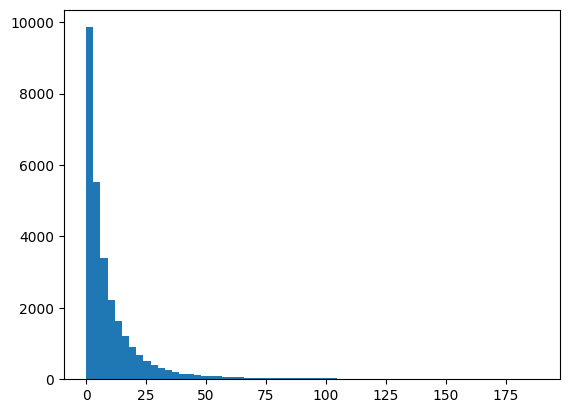

In [14]:
plt.hist(our_species_df[our_species_df['common_name']=='Peccary']['frame_num'], bins=63)

In [ ]:
# expected number of image per species after downsampling
# median is used as the max sampling size per sequence
# the minimum size of sample is used as a reference for downsampling
df_exp_img_no = pd.DataFrame()

for species in species_list:
  # filter out species
  df_tmp = our_species_df[our_species_df['common_name']==species]
  # get sequence size (no. of images with the animal) in each sequence id
  df_seq = df_tmp.groupby('seq_id').count().reset_index(drop=False)[['seq_id','image_id']]
  df_seq.columns = ['seq_id', 'seq_size']
  median = df_seq.describe().loc['50%'][0]
  species_downsampled = df_seq.loc[df_seq['seq_size']< median, 'seq_size'].sum() +\
                      df_seq.loc[df_seq['seq_size']>=median, 'seq_size'].count()*median
  df_exp_img_no = pd.concat([df_exp_img_no,
                            pd.DataFrame([{'common_name': species,
                             'exp_img_no': species_downsampled}])],
                            ignore_index=True)
  print(f'Sequence Size Distribution of {species}:\n', df_seq.describe())
  print('-'*25)

print(f'{df_exp_img_no}')

Sequence Size Distribution of Peccary:
           seq_size
count  3589.000000
mean      7.956255
std      10.405225
min       1.000000
25%       3.000000
50%       5.000000
75%       9.000000
max     189.000000
-------------------------
Sequence Size Distribution of Black Agouti:
           seq_size
count  3142.000000
mean      4.338638
std       4.176986
min       1.000000
25%       3.000000
50%       3.000000
75%       6.000000
max      75.000000
-------------------------
Sequence Size Distribution of Spotted Paca:
           seq_size
count  1099.000000
mean      4.830755
std       3.791770
min       1.000000
25%       3.000000
50%       3.000000
75%       6.000000
max      37.000000
-------------------------
Sequence Size Distribution of Dasypus Species:
           seq_size
count  1336.000000
mean      4.258982
std       3.243246
min       1.000000
25%       3.000000
50%       3.000000
75%       6.000000
max      24.000000
-------------------------
Sequence Size Distribution of Sout

In [ ]:
# supress warning
pd.set_option('mode.chained_assignment', None)
# Splitting images in a ratio of 70:10:20 for train-validation-test set

for species in species_list:
  # filter out species
  df_tmp = our_species_df[our_species_df['common_name']==species]
  # get sequence size (no. of images with the animal) in each sequence id
  df_seq = df_tmp.groupby('seq_id').count().reset_index(drop=False)[['seq_id','image_id']]
  df_seq.columns = ['seq_id', 'seq_size']
  # 50% percentile of seq_size
  median = df_seq.describe().loc['50%'][0]

  # expected total no. of images
  species_downsampled = df_seq.loc[df_seq['seq_size']< median, 'seq_size'].sum() +\
                        df_seq.loc[df_seq['seq_size']>=median, 'seq_size'].count()*median

  # expected min number of images per split
  # size of smallest class
  min_class = min(df_exp_img_no['exp_img_no'])

  # additional 10% buffer to get more images
  if species_downsampled >= min_class*1.1:
    min_train = min_class*1.1*0.7
    min_val = min_class*1.1*0.1
    min_test = min_class*1.1*0.2
  else:
    # use all images available
    min_train = species_downsampled*0.7
    min_val = species_downsampled*0.1
    min_test = species_downsampled*0.2

  print(f'{min_train = }; {min_val = }; {min_test = };')

  # df of required seq_id
  df_downsampled = pd.DataFrame()
  # df of train, validation and test sets
  df_train = pd.DataFrame()
  df_val = pd.DataFrame()
  df_test = pd.DataFrame()

  # shuffle seq_id
  seq_id = df_seq['seq_id'].sample(frac=1, random_state=281).reset_index(drop=True)


  # for each seq_id
  for id in seq_id:
    df = df_tmp[df_tmp['seq_id']==id]
    # count of images within a sequence that belongs to the species
    k = df_seq[df_seq['seq_id']==id]['seq_size'].iloc[0]
    df.loc[:,'seq_size'] = k

    # if seq_num_frames > median
    if all(df_seq.loc[df_seq['seq_id']==id, 'seq_size'] > median):
      # sample median no. of rows
      df = df.sample(int(median), random_state=281)
      # fill according to the priority train>test>val
      if len(df_train)<min_train:
        df_train = pd.concat([df_train, df], axis=0)
        continue
      elif len(df_test)<min_test:
        df_test = pd.concat([df_test, df], axis=0)
        continue
      elif len(df_val)<min_val:
        df_val = pd.concat([df_val, df], axis=0)
        continue

    else:
      # concat all rows
      # fill according to the priority train>test>val
      if len(df_train)<min_train:
        df_train = pd.concat([df_train, df], axis=0)
        continue
      elif len(df_test)<min_test:
        df_test = pd.concat([df_test, df], axis=0)
        continue
      elif len(df_val)<min_val:
        df_val = pd.concat([df_val, df], axis=0)
        continue

    # stop getting next seq_id
    break

  # when train, val and test sizes are satisfied for a species
  # assign split label for each df train/test/val
  df_train['split'] = 'train'
  df_test['split'] = 'test'
  df_val['split'] = 'validation'

  # print results for checking
  print(f'{df_train.head()}')
  print(f'{df_val.head()}')
  print(f'{df_test.head()}')
  print(f'{len(df_train) = }')
  print(f'{len(df_val) = }')
  print(f'{len(df_test) = }')

  # save df train/val/test of different species to csv
  train_csv = '/content/drive/MyDrive/w281_Project/0_data/train_downsampled.csv'
  val_csv = '/content/drive/MyDrive/w281_Project/0_data/val_downsampled.csv'
  test_csv = '/content/drive/MyDrive/w281_Project/0_data/test_downsampled.csv'

  # save train data to csv
  # if csv not created yet
  if not os.path.exists(train_csv):
    # create new csv
    df_train.to_csv(train_csv, index=False)
  else:
    # append to old csv
    df_train.to_csv(train_csv, mode='a', index=False, header=False)

  # save validation data to csv
  # if csv not created yet
  if not os.path.exists(val_csv):
    # create new csv
    df_val.to_csv(val_csv, index=False)
  else:
    # append to old csv
    df_val.to_csv(val_csv, mode='a', index=False, header=False)

  # save test data to csv
  # if csv not created yet
  if not os.path.exists(test_csv):
    # create new csv
    df_test.to_csv(test_csv, index=False)
  else:
    # append to old csv
    df_test.to_csv(test_csv, mode='a', index=False, header=False)


min_train = 1071.84; min_val = 153.12; min_test = 306.24;
                  timestamp                              image_id  sp_num  \
1356   2020-03-03T19:11:37Z  5597150e-ba7d-4333-a6f6-b81e26bd61ca       1   
4279   2020-03-03T19:11:43Z  c4357cc6-ea95-4136-828f-3a54492ef7fd       1   
9130   2020-03-03T19:11:36Z  ad8c695b-a1e6-4401-aa90-af281610c93b       1   
60233  2020-03-03T19:11:42Z  34cb2ecb-c3ef-46df-b458-89321ea73269       1   
83627  2020-03-03T19:11:35Z  ca4db301-6ebe-4743-847b-1bd94658f0ab       1   

      common_name camera  image_number               filename_new  \
1356      Peccary    N25  03030540.JPG  N25_100EK113_03030540.JPG   
4279      Peccary    N25  03030542.JPG  N25_100EK113_03030542.JPG   
9130      Peccary    N25  03030539.JPG  N25_100EK113_03030539.JPG   
60233     Peccary    N25  03030541.JPG  N25_100EK113_03030541.JPG   
83627     Peccary    N25  03030538.JPG  N25_100EK113_03030538.JPG   

                        filename                                

## Check Output csv

In [ ]:
# check output csv of train, val and test
train_csv = '/content/drive/MyDrive/w281_Project/0_data/train_downsampled.csv'
val_csv = '/content/drive/MyDrive/w281_Project/0_data/val_downsampled.csv'
test_csv = '/content/drive/MyDrive/w281_Project/0_data/test_downsampled.csv'

df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(val_csv)
df_test = pd.read_csv(test_csv)

print('no. of images in train set:\n')
print(df_train.groupby('common_name').count()['image_id'])
print('-'*25)


print('no. of images in validation set:\n')
print(df_val.groupby('common_name').count()['image_id'])
print('-'*25)


print('no. of images in test set:\n')
print(df_test.groupby('common_name').count()['image_id'])
print('-'*25)

no. of images in train set:

common_name
Black Agouti            1074
Bos Species              976
Dasypus Species         1074
Peccary                 1075
South American Coati     981
Spotted Paca            1074
Name: image_id, dtype: int64
-------------------------
no. of images in validation set:

common_name
Black Agouti            156
Bos Species             134
Dasypus Species         155
Peccary                 156
South American Coati    136
Spotted Paca            154
Name: image_id, dtype: int64
-------------------------
no. of images in test set:

common_name
Black Agouti            307
Bos Species             282
Dasypus Species         309
Peccary                 307
South American Coati    281
Spotted Paca            308
Name: image_id, dtype: int64
-------------------------


In [ ]:
# Ensure no duplication in seq_id and common_name in train, validation and test

# train and validation
df_tmp = df_train.merge(df_val, on=['seq_id', 'common_name'], how='inner', indicator=True)
print('No. of seq_id and common_name co-exist in train + validation: ', len(df_tmp))
# train and test
df_tmp = df_train.merge(df_test, on=['seq_id', 'common_name'], how='inner', indicator=True)
print('No. of seq_id and common_name co-exist in train + test: ', len(df_tmp))
# validation and test
df_tmp = df_test.merge(df_val, on=['seq_id', 'common_name'], how='inner', indicator=True)
print('No. of seq_id and common_name co-exist in validation + test: ', len(df_tmp))

No. of seq_id and common_name co-exist in train + validation:  0
No. of seq_id and common_name co-exist in train + test:  0
No. of seq_id and common_name co-exist in validation + test:  0


In [ ]:
df_train.columns

Index(['timestamp', 'image_id', 'sp_num', 'common_name', 'camera',
       'image_number', 'filename_new', 'filename', 'seq_id', 'frame_num',
       'seq_num_frames', 'seq_size', 'split'],
      dtype='object')

#Explore Images Sequences and Counts in Old Downsampled Folder
* Images from original downsampling methods, which only included specific cameras and species.

##Get Desired Species

In [ ]:
# Get our_species_df

camera_list = ['M04','N29','N14','N25','M01','N07','A07','N27','A06','N00']

species_list = ['Collared Peccary','White-lipped Peccary','Black Agouti',
                'Spotted Paca','Dasypus Species','South American Coati',
                'Domestic Horse','Bos Species']

#upload image labels to get correct filename for species of interest
#remember to add the shortcut to shared folder to MyDrive
#w281_Project -> more actions -> Orangize -> Add shortcut
image_labels = pd.read_csv('/content/drive/MyDrive/w281_Project/0_data/sample_images/images_labels.csv')

#split filename into camera and image number
image_labels['camera'] = image_labels['filename'].str.split('/').str[0]
image_labels['image_number'] = image_labels['filename'].str.split('/').str[1]

# Get list of filenames for our species
# create df of only our_species
our_species_df = image_labels[image_labels['common_name'].isin(species_list)]

# Get list of filenames for our camera
our_species_df = our_species_df[our_species_df['camera'].isin(camera_list)]

our_species_df.head()

,filename,timestamp,image_id,common_name,sp_num,camera,image_number
0,N25/03310082.JPG,2020-03-31T14:28:14Z,902b671f-58b9-4cb0-9898-bd53c9909e51,Collared Peccary,1,N25,03310082.JPG
1,N29/03310288.JPG,2020-03-31T06:49:17Z,e727dc42-5ebb-46a0-a979-eac158c050e6,Collared Peccary,1,N29,03310288.JPG
2,A06/06020479.JPG,2020-06-02T08:12:17Z,db3c3213-5ad9-4bf7-94a8-92ded5efb5a5,Black Agouti,1,A06,06020479.JPG
6,A06/06190148.JPG,2020-06-19T11:40:33Z,063c0153-d8fd-46b3-b248-8459ba954ad6,White-lipped Peccary,1,A06,06190148.JPG
8,A07/05090248.JPG,2020-05-09T15:05:11Z,15c4e9f4-7a68-4bde-9b5a-d90c78b6ac0e,Domestic Horse,1,A07,05090248.JPG


In [ ]:
# check number of target images downloaded
red_only_path = os.path.join(local_path, 'raw-data', 'preprocessed_data_red')

img_red_only = os.listdir(red_only_path)
print('No. of images loaded: ', len(img_red_only))

KeyboardInterrupt: 

In [ ]:
df_img_red = pd.DataFrame(
    {
        'filename_new': img_red_only,
        'camera': [re.search( r'([A-Z]\d{2})_.+_(\d{8,}.JPG)', img).group(1) for img in img_red_only],
        'image_number': [re.search( r'([A-Z]\d{2})_.+_(\d{8,}.JPG)', img).group(2) for img in img_red_only]
    }
)

df_img_red.info()

In [ ]:
# Get common_name for species
df_our_images = df_img_red.merge(our_species_df, on=['camera','image_number'], how='left')
df_our_images.head()

In [ ]:
# join df_all_images with df_img to get sequence ID

# keep useful columns in df_our_imaegs
df_our_images = df_our_images[['filename_new', 'timestamp', 'image_id', 'sp_num',	'common_name']]

# keep useful columns in df_img
df_img = df_img[['filename_new', 'seq_id', 'frame_num', 'seq_num_frames']]

# join the df
df_master = df_our_images.merge(df_img, on=['filename_new'], how='left')
df_master.info()

In [ ]:
# Drop rows where filename_new is NaN
df_master = df_master[~df_master['filename_new'].isna()]
df_master.info()

In [ ]:
# Drop images with multiple classes
# sp_num > 1
df_master = df_master[df_master['sp_num']==1]
df_master = df_master.reset_index()
print('Any duplicated image id left: ', any(df_master['image_id'].duplicated()))
print('-'*25)
print(df_master.info())

In [ ]:
# combine Collared Peccary and White-lipped Peccary as Peccary
print('Before combining: \n', df_master['common_name'].value_counts())
print('-'*25)

df_master.loc[df_master['common_name'].isin(['Collared Peccary', 'White-lipped Peccary']),'common_name'] = 'Peccary'

# check after replacement
print('After combining: \n', df_master['common_name'].value_counts())

In [ ]:
# save df_master to csv
csv_path = '/content/drive/MyDrive/w281_Project/0_data/sample_images/images_seq_num_downsampled.csv'
df_master.to_csv(csv_path, index=False)

In [ ]:
csv_path = '/content/drive/MyDrive/w281_Project/0_data/sample_images/images_seq_num_downsampled.csv'
df_master = pd.read_csv(csv_path)
df_master.info()

In [ ]:
df_block_size = df_master.groupby(['common_name','seq_id']).count()

In [ ]:
# for each class, find the distribution of frame block sizes


dist1 = df_block_size.loc['Peccary']['image_id']
dist2 = df_block_size.loc['Black Agouti']['image_id']

fig, ax = plt.subplots(1, 7, sharey=True, tight_layout=False, figsize=(20,10))
bins=[1,5,20,50,100,200]
for i, species in enumerate(df_master['common_name'].unique()):
  ax[i].hist(df_block_size.loc[species]['image_id'], bins=bins)
  ax[i].set_title(species)

plt.show()

70% Training
10% Validation
20% Test

# Split into Train, Validation and Test Sets
- 70% train
- 10% validation
- 20% test

In [ ]:
train_csv = '/content/drive/MyDrive/w281_Project/0_data/train_downsampled.csv'
val_csv = '/content/drive/MyDrive/w281_Project/0_data/val_downsampled.csv'
test_csv = '/content/drive/MyDrive/w281_Project/0_data/test_downsampled.csv'

df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(val_csv)
df_test = pd.read_csv(test_csv)

## Train set images

In [ ]:
# base_path = f"{local_path}/raw-data/orinoquia-camera-traps/public"
# output_path = f"{local_path}/raw-data/train_data"

# required_img = len(df_train)
# failed_img = 0
# sucessful_img = 0

# failed_img_paths = []

# progress_bar = tqdm(total=required_img)

# for filename, filename_new in zip(df_train['filename'],df_train['filename_new']):
#   # construct image path on GCP (1)
#   image_path = os.path.join(base_path, filename)
#   # construct output path for image with filename_new (2)
#   output_file = os.path.join(output_path, filename_new)
#   # try: copy image from (1) to (2), sucessful_img += 1, progress_bar += 1
#   try:
#     # Copy the image file to the output directory
#     shutil.copyfile(image_path, output_file)
#     # Update the progress bar
#     progress_bar.update(1)
#     # Update sucessful count
#     sucessful_img += 1
#     print(f"{progress_bar.n}: {output_file}")

#   # except: "image path" is not copied, failed_img += 1, progress_bar += 1
#   except:
#     # update progress bar
#     progress_bar.update(1)
#     # update failure count
#     failed_img += 1
#     # update failed path list
#     failed_img_paths.append(output_file)
#     print('Image copy not successful')
#     print(f"{progress_bar.n}: Image processed")

  0%|          | 1/6254 [00:00<1:23:49,  1.24it/s]

1: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03030540.JPG


  0%|          | 2/6254 [00:01<1:02:39,  1.66it/s]

2: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03030542.JPG


  0%|          | 3/6254 [00:01<51:27,  2.02it/s]  

3: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03030539.JPG


  0%|          | 4/6254 [00:02<47:40,  2.19it/s]

4: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03030541.JPG


  0%|          | 5/6254 [00:02<46:15,  2.25it/s]

5: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03030538.JPG


  0%|          | 6/6254 [00:02<49:32,  2.10it/s]

6: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05170157.JPG


  0%|          | 7/6254 [00:03<51:14,  2.03it/s]

7: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05170158.JPG


  0%|          | 8/6254 [00:03<50:17,  2.07it/s]

8: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05170156.JPG


  0%|          | 9/6254 [00:04<50:20,  2.07it/s]

9: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05170154.JPG


  0%|          | 10/6254 [00:04<47:47,  2.18it/s]

10: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05170155.JPG


  0%|          | 11/6254 [00:05<47:19,  2.20it/s]

11: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06010608.JPG


  0%|          | 12/6254 [00:05<45:18,  2.30it/s]

12: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06010609.JPG


  0%|          | 13/6254 [00:06<45:10,  2.30it/s]

13: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06010607.JPG


  0%|          | 14/6254 [00:06<45:05,  2.31it/s]

14: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03060592.JPG


  0%|          | 15/6254 [00:07<46:02,  2.26it/s]

15: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03060593.JPG


  0%|          | 16/6254 [00:07<47:37,  2.18it/s]

16: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06030605.JPG


  0%|          | 17/6254 [00:07<45:25,  2.29it/s]

17: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06030606.JPG


  0%|          | 18/6254 [00:08<46:49,  2.22it/s]

18: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06030602.JPG


  0%|          | 19/6254 [00:08<47:25,  2.19it/s]

19: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06030603.JPG


  0%|          | 20/6254 [00:09<45:24,  2.29it/s]

20: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06030601.JPG


  0%|          | 21/6254 [00:09<47:07,  2.20it/s]

21: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120787.JPG


  0%|          | 22/6254 [00:10<46:35,  2.23it/s]

22: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120788.JPG


  0%|          | 23/6254 [00:10<45:24,  2.29it/s]

23: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120789.JPG


  0%|          | 24/6254 [00:11<45:24,  2.29it/s]

24: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04080546.JPG


  0%|          | 25/6254 [00:11<43:22,  2.39it/s]

25: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04080547.JPG


  0%|          | 26/6254 [00:11<42:51,  2.42it/s]

26: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04080544.JPG


  0%|          | 27/6254 [00:12<41:31,  2.50it/s]

27: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04080545.JPG


  0%|          | 28/6254 [00:12<40:10,  2.58it/s]

28: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04080548.JPG


  0%|          | 29/6254 [00:12<40:18,  2.57it/s]

29: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04270266.JPG


  0%|          | 30/6254 [00:13<40:30,  2.56it/s]

30: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04270267.JPG


  0%|          | 31/6254 [00:13<43:37,  2.38it/s]

31: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06130886.JPG


  1%|          | 32/6254 [00:14<43:32,  2.38it/s]

32: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05090774.JPG


  1%|          | 33/6254 [00:14<45:19,  2.29it/s]

33: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05090776.JPG


  1%|          | 34/6254 [00:15<43:05,  2.41it/s]

34: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05090773.JPG


  1%|          | 35/6254 [00:15<41:55,  2.47it/s]

35: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05090775.JPG


  1%|          | 36/6254 [00:15<44:01,  2.35it/s]

36: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02180612.JPG


  1%|          | 37/6254 [00:16<43:25,  2.39it/s]

37: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02180613.JPG


  1%|          | 38/6254 [00:16<41:47,  2.48it/s]

38: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02180615.JPG


  1%|          | 39/6254 [00:17<41:20,  2.51it/s]

39: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02180608.JPG


  1%|          | 40/6254 [00:17<40:22,  2.57it/s]

40: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02180617.JPG


  1%|          | 41/6254 [00:17<41:50,  2.47it/s]

41: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01120118.JPG


  1%|          | 42/6254 [00:18<40:11,  2.58it/s]

42: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01120115.JPG


  1%|          | 43/6254 [00:18<38:59,  2.65it/s]

43: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01120112.JPG


  1%|          | 44/6254 [00:18<38:48,  2.67it/s]

44: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01120113.JPG


  1%|          | 45/6254 [00:19<38:18,  2.70it/s]

45: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01120117.JPG


  1%|          | 46/6254 [00:19<40:15,  2.57it/s]

46: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220901.JPG


  1%|          | 47/6254 [00:20<39:40,  2.61it/s]

47: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220907.JPG


  1%|          | 48/6254 [00:20<39:52,  2.59it/s]

48: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220902.JPG


  1%|          | 49/6254 [00:20<40:20,  2.56it/s]

49: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220904.JPG


  1%|          | 50/6254 [00:21<39:51,  2.59it/s]

50: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220911.JPG


  1%|          | 51/6254 [00:21<43:19,  2.39it/s]

51: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_03310105.JPG


  1%|          | 52/6254 [00:22<44:04,  2.35it/s]

52: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_03310104.JPG


  1%|          | 53/6254 [00:22<44:02,  2.35it/s]

53: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_03310108.JPG


  1%|          | 54/6254 [00:23<43:48,  2.36it/s]

54: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_03310103.JPG


  1%|          | 55/6254 [00:23<42:58,  2.40it/s]

55: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_03310106.JPG


  1%|          | 56/6254 [00:23<43:51,  2.36it/s]

56: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06130604.JPG


  1%|          | 57/6254 [00:24<43:44,  2.36it/s]

57: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06130614.JPG


  1%|          | 58/6254 [00:24<43:42,  2.36it/s]

58: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06130615.JPG


  1%|          | 59/6254 [00:25<46:21,  2.23it/s]

59: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06130608.JPG


  1%|          | 60/6254 [00:25<45:45,  2.26it/s]

60: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06130609.JPG


  1%|          | 61/6254 [00:26<48:10,  2.14it/s]

61: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05040995.JPG


  1%|          | 62/6254 [00:26<45:55,  2.25it/s]

62: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05040993.JPG


  1%|          | 63/6254 [00:26<43:51,  2.35it/s]

63: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05040992.JPG


  1%|          | 64/6254 [00:27<44:32,  2.32it/s]

64: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05040997.JPG


  1%|          | 65/6254 [00:27<42:12,  2.44it/s]

65: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05040994.JPG


  1%|          | 66/6254 [00:28<44:54,  2.30it/s]

66: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03030408.JPG


  1%|          | 67/6254 [00:28<44:08,  2.34it/s]

67: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03030410.JPG


  1%|          | 68/6254 [00:29<42:38,  2.42it/s]

68: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03030407.JPG


  1%|          | 69/6254 [00:29<45:34,  2.26it/s]

69: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03030411.JPG


  1%|          | 70/6254 [00:29<44:12,  2.33it/s]

70: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03030409.JPG


  1%|          | 71/6254 [00:30<44:23,  2.32it/s]

71: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_03050897.JPG


  1%|          | 72/6254 [00:30<43:44,  2.36it/s]

72: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_03050896.JPG


  1%|          | 73/6254 [00:31<42:18,  2.44it/s]

73: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_03050895.JPG


  1%|          | 74/6254 [00:31<44:03,  2.34it/s]

74: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03070454.JPG


  1%|          | 75/6254 [00:32<41:55,  2.46it/s]

75: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03070455.JPG


  1%|          | 76/6254 [00:32<40:35,  2.54it/s]

76: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03070453.JPG


  1%|          | 77/6254 [00:32<42:54,  2.40it/s]

77: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06090221.JPG


  1%|          | 78/6254 [00:33<41:34,  2.48it/s]

78: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06090220.JPG


  1%|▏         | 79/6254 [00:33<40:30,  2.54it/s]

79: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06010502.JPG


  1%|▏         | 80/6254 [00:34<48:51,  2.11it/s]

80: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_05190951.JPG


  1%|▏         | 81/6254 [00:34<45:31,  2.26it/s]

81: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_05190961.JPG


  1%|▏         | 82/6254 [00:35<43:52,  2.34it/s]

82: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_05190955.JPG


  1%|▏         | 83/6254 [00:35<42:48,  2.40it/s]

83: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_05190963.JPG


  1%|▏         | 84/6254 [00:35<39:52,  2.58it/s]

84: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_05190952.JPG


  1%|▏         | 85/6254 [00:36<42:50,  2.40it/s]

85: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_07040936.JPG


  1%|▏         | 86/6254 [00:36<41:22,  2.48it/s]

86: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_07040939.JPG


  1%|▏         | 87/6254 [00:37<42:17,  2.43it/s]

87: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_07040934.JPG


  1%|▏         | 88/6254 [00:37<41:18,  2.49it/s]

88: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_07040941.JPG


  1%|▏         | 89/6254 [00:37<40:41,  2.52it/s]

89: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_07040940.JPG


  1%|▏         | 90/6254 [00:38<43:28,  2.36it/s]

90: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02230691.JPG


  1%|▏         | 91/6254 [00:38<45:47,  2.24it/s]

91: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02230698.JPG


  1%|▏         | 92/6254 [00:39<43:40,  2.35it/s]

92: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02230681.JPG


  1%|▏         | 93/6254 [00:39<43:26,  2.36it/s]

93: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02230683.JPG


  2%|▏         | 94/6254 [00:40<43:29,  2.36it/s]

94: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02230679.JPG


  2%|▏         | 95/6254 [00:40<45:45,  2.24it/s]

95: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06150338.JPG


  2%|▏         | 96/6254 [00:40<44:37,  2.30it/s]

96: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06150342.JPG


  2%|▏         | 97/6254 [00:41<42:31,  2.41it/s]

97: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06150335.JPG


  2%|▏         | 98/6254 [00:41<41:53,  2.45it/s]

98: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06150341.JPG


  2%|▏         | 99/6254 [00:42<43:48,  2.34it/s]

99: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06150332.JPG


  2%|▏         | 100/6254 [00:42<45:18,  2.26it/s]

100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100873.JPG


  2%|▏         | 101/6254 [00:43<43:33,  2.35it/s]

101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100871.JPG


  2%|▏         | 102/6254 [00:43<42:35,  2.41it/s]

102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100867.JPG


  2%|▏         | 103/6254 [00:43<41:45,  2.45it/s]

103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100865.JPG


  2%|▏         | 104/6254 [00:44<41:34,  2.47it/s]

104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100866.JPG


  2%|▏         | 105/6254 [00:44<43:11,  2.37it/s]

105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04210284.JPG


  2%|▏         | 106/6254 [00:45<43:27,  2.36it/s]

106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04210285.JPG


  2%|▏         | 107/6254 [00:45<42:31,  2.41it/s]

107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04210287.JPG


  2%|▏         | 108/6254 [00:45<42:44,  2.40it/s]

108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04210283.JPG


  2%|▏         | 109/6254 [00:46<41:53,  2.45it/s]

109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04210286.JPG


  2%|▏         | 110/6254 [00:46<44:09,  2.32it/s]

110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230891.JPG


  2%|▏         | 111/6254 [00:47<44:04,  2.32it/s]

111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230897.JPG


  2%|▏         | 112/6254 [00:47<41:51,  2.45it/s]

112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230883.JPG


  2%|▏         | 113/6254 [00:47<41:58,  2.44it/s]

113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230894.JPG


  2%|▏         | 114/6254 [00:48<41:18,  2.48it/s]

114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230889.JPG


  2%|▏         | 115/6254 [00:48<43:23,  2.36it/s]

115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03050159.JPG


  2%|▏         | 116/6254 [00:49<42:12,  2.42it/s]

116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03050155.JPG


  2%|▏         | 117/6254 [00:49<44:38,  2.29it/s]

117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03050151.JPG


  2%|▏         | 118/6254 [00:50<43:03,  2.38it/s]

118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03050156.JPG


  2%|▏         | 119/6254 [00:50<43:35,  2.35it/s]

119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03050152.JPG


  2%|▏         | 120/6254 [00:51<45:31,  2.25it/s]

120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03240301.JPG


  2%|▏         | 121/6254 [00:51<43:29,  2.35it/s]

121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03240302.JPG


  2%|▏         | 122/6254 [00:51<43:09,  2.37it/s]

122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03240304.JPG


  2%|▏         | 123/6254 [00:52<41:54,  2.44it/s]

123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03240305.JPG


  2%|▏         | 124/6254 [00:52<39:33,  2.58it/s]

124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03240306.JPG


  2%|▏         | 125/6254 [00:53<42:35,  2.40it/s]

125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020490.JPG


  2%|▏         | 126/6254 [00:53<42:02,  2.43it/s]

126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020491.JPG


  2%|▏         | 127/6254 [00:53<45:02,  2.27it/s]

127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020492.JPG


  2%|▏         | 128/6254 [00:54<47:19,  2.16it/s]

128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140073.JPG


  2%|▏         | 129/6254 [00:54<44:21,  2.30it/s]

129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140074.JPG


  2%|▏         | 130/6254 [00:55<43:32,  2.34it/s]

130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140079.JPG


  2%|▏         | 131/6254 [00:55<45:25,  2.25it/s]

131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140076.JPG


  2%|▏         | 132/6254 [00:56<43:18,  2.36it/s]

132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140078.JPG


  2%|▏         | 133/6254 [00:56<43:03,  2.37it/s]

133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04040052.JPG


  2%|▏         | 134/6254 [00:56<42:19,  2.41it/s]

134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04040061.JPG


  2%|▏         | 135/6254 [00:57<41:52,  2.44it/s]

135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04040034.JPG


  2%|▏         | 136/6254 [00:57<41:32,  2.45it/s]

136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04040048.JPG


  2%|▏         | 137/6254 [00:58<41:31,  2.45it/s]

137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04040044.JPG


  2%|▏         | 138/6254 [00:58<42:46,  2.38it/s]

138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03290588.JPG


  2%|▏         | 139/6254 [00:59<43:56,  2.32it/s]

139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03290586.JPG


  2%|▏         | 140/6254 [00:59<44:21,  2.30it/s]

140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03290590.JPG


  2%|▏         | 141/6254 [00:59<43:50,  2.32it/s]

141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03290589.JPG


  2%|▏         | 142/6254 [01:00<42:46,  2.38it/s]

142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03290591.JPG


  2%|▏         | 143/6254 [01:00<42:15,  2.41it/s]

143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230733.JPG


  2%|▏         | 144/6254 [01:01<41:58,  2.43it/s]

144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230734.JPG


  2%|▏         | 145/6254 [01:01<41:20,  2.46it/s]

145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230732.JPG


  2%|▏         | 146/6254 [01:01<43:44,  2.33it/s]

146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230737.JPG


  2%|▏         | 147/6254 [01:02<44:55,  2.27it/s]

147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230731.JPG


  2%|▏         | 148/6254 [01:02<42:44,  2.38it/s]

148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220880.JPG


  2%|▏         | 149/6254 [01:03<43:08,  2.36it/s]

149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220884.JPG


  2%|▏         | 150/6254 [01:03<42:16,  2.41it/s]

150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220883.JPG


  2%|▏         | 151/6254 [01:04<41:23,  2.46it/s]

151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220885.JPG


  2%|▏         | 152/6254 [01:04<41:31,  2.45it/s]

152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220881.JPG


  2%|▏         | 153/6254 [01:04<44:02,  2.31it/s]

153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04070673.JPG


  2%|▏         | 154/6254 [01:05<44:15,  2.30it/s]

154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04070675.JPG


  2%|▏         | 155/6254 [01:05<43:23,  2.34it/s]

155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04070677.JPG


  2%|▏         | 156/6254 [01:06<41:59,  2.42it/s]

156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04070674.JPG


  3%|▎         | 157/6254 [01:06<41:41,  2.44it/s]

157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04070672.JPG


  3%|▎         | 158/6254 [01:07<44:55,  2.26it/s]

158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05260089.JPG


  3%|▎         | 159/6254 [01:07<45:44,  2.22it/s]

159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260751.JPG


  3%|▎         | 160/6254 [01:07<43:05,  2.36it/s]

160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260756.JPG


  3%|▎         | 161/6254 [01:08<42:26,  2.39it/s]

161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260755.JPG


  3%|▎         | 162/6254 [01:08<40:25,  2.51it/s]

162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260753.JPG


  3%|▎         | 163/6254 [01:09<41:11,  2.46it/s]

163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260754.JPG


  3%|▎         | 164/6254 [01:09<49:38,  2.04it/s]

164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200877.JPG


  3%|▎         | 165/6254 [01:10<48:08,  2.11it/s]

165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200878.JPG


  3%|▎         | 166/6254 [01:10<49:27,  2.05it/s]

166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200881.JPG


  3%|▎         | 167/6254 [01:11<47:33,  2.13it/s]

167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200879.JPG


  3%|▎         | 168/6254 [01:11<47:02,  2.16it/s]

168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200880.JPG


  3%|▎         | 169/6254 [01:12<47:24,  2.14it/s]

169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03260959.JPG


  3%|▎         | 170/6254 [01:12<46:57,  2.16it/s]

170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03260966.JPG


  3%|▎         | 171/6254 [01:12<46:16,  2.19it/s]

171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03260961.JPG


  3%|▎         | 172/6254 [01:13<44:13,  2.29it/s]

172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03260964.JPG


  3%|▎         | 173/6254 [01:13<47:09,  2.15it/s]

173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03260962.JPG


  3%|▎         | 174/6254 [01:14<53:24,  1.90it/s]

174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240794.JPG


  3%|▎         | 175/6254 [01:14<49:15,  2.06it/s]

175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240800.JPG


  3%|▎         | 176/6254 [01:15<46:57,  2.16it/s]

176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240805.JPG


  3%|▎         | 177/6254 [01:15<45:20,  2.23it/s]

177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240809.JPG


  3%|▎         | 178/6254 [01:16<43:18,  2.34it/s]

178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240803.JPG


  3%|▎         | 179/6254 [01:16<43:52,  2.31it/s]

179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05250203.JPG


  3%|▎         | 180/6254 [01:16<42:49,  2.36it/s]

180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05250202.JPG


  3%|▎         | 181/6254 [01:17<44:30,  2.27it/s]

181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07130591.JPG


  3%|▎         | 182/6254 [01:17<43:32,  2.32it/s]

182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07130601.JPG


  3%|▎         | 183/6254 [01:18<41:54,  2.41it/s]

183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07130595.JPG


  3%|▎         | 184/6254 [01:18<41:07,  2.46it/s]

184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07130596.JPG


  3%|▎         | 185/6254 [01:18<38:55,  2.60it/s]

185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07130598.JPG


  3%|▎         | 186/6254 [01:19<41:38,  2.43it/s]

186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03110059.JPG


  3%|▎         | 187/6254 [01:19<41:14,  2.45it/s]

187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03110034.JPG


  3%|▎         | 188/6254 [01:20<41:06,  2.46it/s]

188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03110081.JPG


  3%|▎         | 189/6254 [01:20<40:24,  2.50it/s]

189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03110073.JPG


  3%|▎         | 190/6254 [01:21<40:42,  2.48it/s]

190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03110055.JPG


  3%|▎         | 191/6254 [01:21<42:55,  2.35it/s]

191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03130955.JPG


  3%|▎         | 192/6254 [01:21<42:41,  2.37it/s]

192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02110729.JPG


  3%|▎         | 193/6254 [01:22<40:58,  2.46it/s]

193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02110728.JPG


  3%|▎         | 194/6254 [01:22<40:10,  2.51it/s]

194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02110727.JPG


  3%|▎         | 195/6254 [01:23<42:59,  2.35it/s]

195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110742.JPG


  3%|▎         | 196/6254 [01:23<41:02,  2.46it/s]

196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110744.JPG


  3%|▎         | 197/6254 [01:23<40:49,  2.47it/s]

197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110753.JPG


  3%|▎         | 198/6254 [01:24<40:18,  2.50it/s]

198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110745.JPG


  3%|▎         | 199/6254 [01:24<39:52,  2.53it/s]

199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110746.JPG


  3%|▎         | 200/6254 [01:25<39:25,  2.56it/s]

200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_03250129.JPG


  3%|▎         | 201/6254 [01:25<39:07,  2.58it/s]

201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_03250130.JPG


  3%|▎         | 202/6254 [01:25<38:23,  2.63it/s]

202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_03250128.JPG


  3%|▎         | 203/6254 [01:26<41:19,  2.44it/s]

203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190681.JPG


  3%|▎         | 204/6254 [01:26<42:03,  2.40it/s]

204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190679.JPG


  3%|▎         | 205/6254 [01:27<41:29,  2.43it/s]

205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190680.JPG


  3%|▎         | 206/6254 [01:27<44:32,  2.26it/s]

206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03200138.JPG


  3%|▎         | 207/6254 [01:28<43:56,  2.29it/s]

207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03200130.JPG


  3%|▎         | 208/6254 [01:28<45:11,  2.23it/s]

208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03200135.JPG


  3%|▎         | 209/6254 [01:29<44:58,  2.24it/s]

209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03200136.JPG


  3%|▎         | 210/6254 [01:29<46:03,  2.19it/s]

210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03200132.JPG


  3%|▎         | 211/6254 [01:29<44:27,  2.27it/s]

211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06050103.JPG


  3%|▎         | 212/6254 [01:30<42:59,  2.34it/s]

212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06050101.JPG


  3%|▎         | 213/6254 [01:30<42:28,  2.37it/s]

213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06050102.JPG


  3%|▎         | 214/6254 [01:31<40:38,  2.48it/s]

214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06050100.JPG


  3%|▎         | 215/6254 [01:31<45:12,  2.23it/s]

215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01280187.JPG


  3%|▎         | 216/6254 [01:32<47:10,  2.13it/s]

216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01280231.JPG


  3%|▎         | 217/6254 [01:32<45:57,  2.19it/s]

217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01280188.JPG


  3%|▎         | 218/6254 [01:33<46:13,  2.18it/s]

218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01280207.JPG


  4%|▎         | 219/6254 [01:33<44:37,  2.25it/s]

219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01280179.JPG


  4%|▎         | 220/6254 [01:33<45:06,  2.23it/s]

220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04040646.JPG


  4%|▎         | 221/6254 [01:34<42:32,  2.36it/s]

221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04040647.JPG


  4%|▎         | 222/6254 [01:34<40:54,  2.46it/s]

222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03240341.JPG


  4%|▎         | 223/6254 [01:35<40:16,  2.50it/s]

223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03240340.JPG


  4%|▎         | 224/6254 [01:35<41:36,  2.42it/s]

224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05310529.JPG


  4%|▎         | 225/6254 [01:35<40:48,  2.46it/s]

225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05310533.JPG


  4%|▎         | 226/6254 [01:36<39:32,  2.54it/s]

226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05310534.JPG


  4%|▎         | 227/6254 [01:36<38:33,  2.61it/s]

227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05310532.JPG


  4%|▎         | 228/6254 [01:36<39:20,  2.55it/s]

228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05310530.JPG


  4%|▎         | 229/6254 [01:37<40:26,  2.48it/s]

229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250883.JPG


  4%|▎         | 230/6254 [01:37<40:28,  2.48it/s]

230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05220409.JPG


  4%|▎         | 231/6254 [01:38<39:57,  2.51it/s]

231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05220407.JPG


  4%|▎         | 232/6254 [01:38<39:58,  2.51it/s]

232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05220408.JPG


  4%|▎         | 233/6254 [01:38<39:09,  2.56it/s]

233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05220412.JPG


  4%|▎         | 234/6254 [01:39<40:44,  2.46it/s]

234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05220406.JPG


  4%|▍         | 235/6254 [01:39<40:33,  2.47it/s]

235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04060223.JPG


  4%|▍         | 236/6254 [01:40<41:42,  2.41it/s]

236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03190697.JPG


  4%|▍         | 237/6254 [01:40<43:02,  2.33it/s]

237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03190699.JPG


  4%|▍         | 238/6254 [01:41<42:10,  2.38it/s]

238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03190698.JPG


  4%|▍         | 239/6254 [01:41<43:42,  2.29it/s]

239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06230502.JPG


  4%|▍         | 240/6254 [01:41<41:30,  2.42it/s]

240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_01300492.JPG


  4%|▍         | 241/6254 [01:42<40:46,  2.46it/s]

241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_01300491.JPG


  4%|▍         | 242/6254 [01:42<40:33,  2.47it/s]

242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_01300478.JPG


  4%|▍         | 243/6254 [01:43<40:45,  2.46it/s]

243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_01300481.JPG


  4%|▍         | 244/6254 [01:43<39:22,  2.54it/s]

244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_01300486.JPG


  4%|▍         | 245/6254 [01:43<39:34,  2.53it/s]

245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02270083.JPG


  4%|▍         | 246/6254 [01:44<39:24,  2.54it/s]

246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02270085.JPG


  4%|▍         | 247/6254 [01:44<41:08,  2.43it/s]

247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02270082.JPG


  4%|▍         | 248/6254 [01:45<42:27,  2.36it/s]

248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02270084.JPG


  4%|▍         | 249/6254 [01:45<41:15,  2.43it/s]

249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02270086.JPG


  4%|▍         | 250/6254 [01:46<43:21,  2.31it/s]

250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100445.JPG


  4%|▍         | 251/6254 [01:46<42:48,  2.34it/s]

251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100457.JPG


  4%|▍         | 252/6254 [01:46<43:12,  2.32it/s]

252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100447.JPG


  4%|▍         | 253/6254 [01:47<44:54,  2.23it/s]

253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100437.JPG


  4%|▍         | 254/6254 [01:47<43:57,  2.27it/s]

254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100452.JPG


  4%|▍         | 255/6254 [01:48<42:49,  2.33it/s]

255: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_102EK113_03180007.JPG


  4%|▍         | 256/6254 [01:48<43:41,  2.29it/s]

256: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03010800.JPG


  4%|▍         | 257/6254 [01:49<42:20,  2.36it/s]

257: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03010802.JPG


  4%|▍         | 258/6254 [01:49<41:03,  2.43it/s]

258: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03010801.JPG


  4%|▍         | 259/6254 [01:49<40:02,  2.50it/s]

259: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05210928.JPG


  4%|▍         | 260/6254 [01:50<40:42,  2.45it/s]

260: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05210933.JPG


  4%|▍         | 261/6254 [01:50<39:46,  2.51it/s]

261: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05210932.JPG


  4%|▍         | 262/6254 [01:51<38:32,  2.59it/s]

262: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05210929.JPG


  4%|▍         | 263/6254 [01:51<38:21,  2.60it/s]

263: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05210926.JPG


  4%|▍         | 264/6254 [01:51<40:42,  2.45it/s]

264: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210437.JPG


  4%|▍         | 265/6254 [01:52<40:36,  2.46it/s]

265: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210438.JPG


  4%|▍         | 266/6254 [01:52<40:41,  2.45it/s]

266: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210436.JPG


  4%|▍         | 267/6254 [01:53<40:18,  2.48it/s]

267: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190675.JPG


  4%|▍         | 268/6254 [01:53<40:04,  2.49it/s]

268: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190669.JPG


  4%|▍         | 269/6254 [01:53<40:33,  2.46it/s]

269: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190667.JPG


  4%|▍         | 270/6254 [01:54<41:15,  2.42it/s]

270: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190672.JPG


  4%|▍         | 271/6254 [01:54<40:32,  2.46it/s]

271: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190671.JPG


  4%|▍         | 272/6254 [01:55<46:56,  2.12it/s]

272: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_01260267.JPG


  4%|▍         | 273/6254 [01:55<46:18,  2.15it/s]

273: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_01260265.JPG


  4%|▍         | 274/6254 [01:56<56:23,  1.77it/s]

274: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_01260262.JPG


  4%|▍         | 275/6254 [01:57<56:15,  1.77it/s]

275: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_01260260.JPG


  4%|▍         | 276/6254 [01:57<49:43,  2.00it/s]

276: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_01260259.JPG


  4%|▍         | 277/6254 [01:57<48:33,  2.05it/s]

277: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06130682.JPG


  4%|▍         | 278/6254 [01:58<52:25,  1.90it/s]

278: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06130684.JPG


  4%|▍         | 279/6254 [01:58<49:06,  2.03it/s]

279: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06130680.JPG


  4%|▍         | 280/6254 [01:59<46:31,  2.14it/s]

280: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06130685.JPG


  4%|▍         | 281/6254 [01:59<43:58,  2.26it/s]

281: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06130683.JPG


  5%|▍         | 282/6254 [02:00<48:35,  2.05it/s]

282: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06290204.JPG


  5%|▍         | 283/6254 [02:00<47:15,  2.11it/s]

283: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06290203.JPG


  5%|▍         | 284/6254 [02:01<45:55,  2.17it/s]

284: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06290202.JPG


  5%|▍         | 285/6254 [02:01<43:36,  2.28it/s]

285: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06300853.JPG


  5%|▍         | 286/6254 [02:01<42:06,  2.36it/s]

286: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04110086.JPG


  5%|▍         | 287/6254 [02:02<41:12,  2.41it/s]

287: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04110079.JPG


  5%|▍         | 288/6254 [02:02<41:29,  2.40it/s]

288: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04110083.JPG


  5%|▍         | 289/6254 [02:03<41:28,  2.40it/s]

289: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04110087.JPG


  5%|▍         | 290/6254 [02:03<41:05,  2.42it/s]

290: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04110082.JPG


  5%|▍         | 291/6254 [02:04<41:24,  2.40it/s]

291: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03280160.JPG


  5%|▍         | 292/6254 [02:04<40:13,  2.47it/s]

292: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03280164.JPG


  5%|▍         | 293/6254 [02:04<40:39,  2.44it/s]

293: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03280161.JPG


  5%|▍         | 294/6254 [02:05<40:30,  2.45it/s]

294: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03280165.JPG


  5%|▍         | 295/6254 [02:05<41:32,  2.39it/s]

295: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03280163.JPG


  5%|▍         | 296/6254 [02:06<40:52,  2.43it/s]

296: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010133.JPG


  5%|▍         | 297/6254 [02:06<41:36,  2.39it/s]

297: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010135.JPG


  5%|▍         | 298/6254 [02:06<42:22,  2.34it/s]

298: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010134.JPG


  5%|▍         | 299/6254 [02:07<42:42,  2.32it/s]

299: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010137.JPG


  5%|▍         | 300/6254 [02:08<59:52,  1.66it/s]

300: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010138.JPG


  5%|▍         | 301/6254 [02:08<54:31,  1.82it/s]

301: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05310705.JPG


  5%|▍         | 302/6254 [02:09<52:31,  1.89it/s]

302: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05310704.JPG


  5%|▍         | 303/6254 [02:09<48:50,  2.03it/s]

303: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05310703.JPG


  5%|▍         | 304/6254 [02:10<45:23,  2.18it/s]

304: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05100134.JPG


  5%|▍         | 305/6254 [02:10<44:32,  2.23it/s]

305: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05100133.JPG


  5%|▍         | 306/6254 [02:10<42:08,  2.35it/s]

306: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05100135.JPG


  5%|▍         | 307/6254 [02:11<42:33,  2.33it/s]

307: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220532.JPG


  5%|▍         | 308/6254 [02:11<41:13,  2.40it/s]

308: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220529.JPG


  5%|▍         | 309/6254 [02:12<41:30,  2.39it/s]

309: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220527.JPG


  5%|▍         | 310/6254 [02:12<42:47,  2.32it/s]

310: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220528.JPG


  5%|▍         | 311/6254 [02:13<45:09,  2.19it/s]

311: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220530.JPG


  5%|▍         | 312/6254 [02:13<42:51,  2.31it/s]

312: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05030081.JPG


  5%|▌         | 313/6254 [02:13<43:45,  2.26it/s]

313: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05030080.JPG


  5%|▌         | 314/6254 [02:14<42:12,  2.35it/s]

314: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05030079.JPG


  5%|▌         | 315/6254 [02:14<40:16,  2.46it/s]

315: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06290747.JPG


  5%|▌         | 316/6254 [02:15<39:31,  2.50it/s]

316: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06290745.JPG


  5%|▌         | 317/6254 [02:15<38:45,  2.55it/s]

317: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06290746.JPG


  5%|▌         | 318/6254 [02:15<39:28,  2.51it/s]

318: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03090761.JPG


  5%|▌         | 319/6254 [02:16<39:16,  2.52it/s]

319: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03090762.JPG


  5%|▌         | 320/6254 [02:16<43:35,  2.27it/s]

320: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03090763.JPG


  5%|▌         | 321/6254 [02:17<43:01,  2.30it/s]

321: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03090760.JPG


  5%|▌         | 322/6254 [02:17<42:37,  2.32it/s]

322: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310533.JPG


  5%|▌         | 323/6254 [02:18<42:10,  2.34it/s]

323: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310534.JPG


  5%|▌         | 324/6254 [02:18<40:37,  2.43it/s]

324: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310532.JPG


  5%|▌         | 325/6254 [02:18<40:45,  2.42it/s]

325: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310531.JPG


  5%|▌         | 326/6254 [02:19<40:12,  2.46it/s]

326: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310530.JPG


  5%|▌         | 327/6254 [02:19<39:20,  2.51it/s]

327: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03250679.JPG


  5%|▌         | 328/6254 [02:20<38:38,  2.56it/s]

328: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03250683.JPG


  5%|▌         | 329/6254 [02:20<38:53,  2.54it/s]

329: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03250687.JPG


  5%|▌         | 330/6254 [02:20<38:09,  2.59it/s]

330: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03250685.JPG


  5%|▌         | 331/6254 [02:21<39:38,  2.49it/s]

331: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03250680.JPG


  5%|▌         | 332/6254 [02:21<40:45,  2.42it/s]

332: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05150278.JPG


  5%|▌         | 333/6254 [02:22<40:31,  2.44it/s]

333: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05150281.JPG


  5%|▌         | 334/6254 [02:22<39:47,  2.48it/s]

334: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05150282.JPG


  5%|▌         | 335/6254 [02:22<39:03,  2.53it/s]

335: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05150277.JPG


  5%|▌         | 336/6254 [02:23<41:41,  2.37it/s]

336: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05150280.JPG


  5%|▌         | 337/6254 [02:23<42:42,  2.31it/s]

337: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120786.JPG


  5%|▌         | 338/6254 [02:24<41:16,  2.39it/s]

338: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120780.JPG


  5%|▌         | 339/6254 [02:24<41:39,  2.37it/s]

339: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120782.JPG


  5%|▌         | 340/6254 [02:25<41:45,  2.36it/s]

340: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120779.JPG


  5%|▌         | 341/6254 [02:25<40:27,  2.44it/s]

341: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120783.JPG


  5%|▌         | 342/6254 [02:25<41:15,  2.39it/s]

342: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03130336.JPG


  5%|▌         | 343/6254 [02:26<41:17,  2.39it/s]

343: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03130335.JPG


  6%|▌         | 344/6254 [02:26<41:29,  2.37it/s]

344: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03130334.JPG


  6%|▌         | 345/6254 [02:27<44:23,  2.22it/s]

345: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04150188.JPG


  6%|▌         | 346/6254 [02:27<43:44,  2.25it/s]

346: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04150184.JPG


  6%|▌         | 347/6254 [02:28<44:03,  2.23it/s]

347: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04150186.JPG


  6%|▌         | 348/6254 [02:28<44:05,  2.23it/s]

348: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04150190.JPG


  6%|▌         | 349/6254 [02:28<42:59,  2.29it/s]

349: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04150193.JPG


  6%|▌         | 350/6254 [02:29<42:45,  2.30it/s]

350: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04170440.JPG


  6%|▌         | 351/6254 [02:29<41:51,  2.35it/s]

351: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04170443.JPG


  6%|▌         | 352/6254 [02:30<42:37,  2.31it/s]

352: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04170441.JPG


  6%|▌         | 353/6254 [02:30<41:27,  2.37it/s]

353: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04170442.JPG


  6%|▌         | 354/6254 [02:31<40:33,  2.42it/s]

354: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03070269.JPG


  6%|▌         | 355/6254 [02:31<39:23,  2.50it/s]

355: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03070278.JPG


  6%|▌         | 356/6254 [02:31<38:52,  2.53it/s]

356: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03070273.JPG


  6%|▌         | 357/6254 [02:32<50:10,  1.96it/s]

357: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03070280.JPG


  6%|▌         | 358/6254 [02:32<45:10,  2.17it/s]

358: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03070277.JPG


  6%|▌         | 359/6254 [02:33<42:30,  2.31it/s]

359: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200011.JPG


  6%|▌         | 360/6254 [02:33<42:10,  2.33it/s]

360: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200010.JPG


  6%|▌         | 361/6254 [02:34<40:15,  2.44it/s]

361: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200012.JPG


  6%|▌         | 362/6254 [02:34<46:59,  2.09it/s]

362: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05290405.JPG


  6%|▌         | 363/6254 [02:35<44:57,  2.18it/s]

363: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05290403.JPG


  6%|▌         | 364/6254 [02:35<42:30,  2.31it/s]

364: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05290404.JPG


  6%|▌         | 365/6254 [02:35<42:15,  2.32it/s]

365: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01210733.JPG


  6%|▌         | 366/6254 [02:36<41:15,  2.38it/s]

366: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01210734.JPG


  6%|▌         | 367/6254 [02:36<43:38,  2.25it/s]

367: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03280934.JPG


  6%|▌         | 368/6254 [02:37<43:27,  2.26it/s]

368: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03250011.JPG


  6%|▌         | 369/6254 [02:37<42:32,  2.31it/s]

369: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03250013.JPG


  6%|▌         | 370/6254 [02:38<41:35,  2.36it/s]

370: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03250014.JPG


  6%|▌         | 371/6254 [02:38<41:10,  2.38it/s]

371: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03250008.JPG


  6%|▌         | 372/6254 [02:38<42:30,  2.31it/s]

372: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03250007.JPG


  6%|▌         | 373/6254 [02:39<41:24,  2.37it/s]

373: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04090655.JPG


  6%|▌         | 374/6254 [02:39<41:03,  2.39it/s]

374: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_04290175.JPG


  6%|▌         | 375/6254 [02:40<40:15,  2.43it/s]

375: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_04290176.JPG


  6%|▌         | 376/6254 [02:40<40:42,  2.41it/s]

376: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_04290177.JPG


  6%|▌         | 377/6254 [02:40<41:01,  2.39it/s]

377: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04170448.JPG


  6%|▌         | 378/6254 [02:41<46:52,  2.09it/s]

378: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04170447.JPG


  6%|▌         | 379/6254 [02:42<46:00,  2.13it/s]

379: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04170445.JPG


  6%|▌         | 380/6254 [02:42<43:41,  2.24it/s]

380: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04170446.JPG


  6%|▌         | 381/6254 [02:42<42:41,  2.29it/s]

381: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06040013.JPG


  6%|▌         | 382/6254 [02:43<41:12,  2.37it/s]

382: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06040014.JPG


  6%|▌         | 383/6254 [02:43<41:18,  2.37it/s]

383: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_06290043.JPG


  6%|▌         | 384/6254 [02:44<40:32,  2.41it/s]

384: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07200394.JPG


  6%|▌         | 385/6254 [02:44<40:57,  2.39it/s]

385: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07200395.JPG


  6%|▌         | 386/6254 [02:44<40:06,  2.44it/s]

386: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260635.JPG


  6%|▌         | 387/6254 [02:45<42:26,  2.30it/s]

387: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260636.JPG


  6%|▌         | 388/6254 [02:45<40:07,  2.44it/s]

388: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260634.JPG


  6%|▌         | 389/6254 [02:46<41:00,  2.38it/s]

389: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160237.JPG


  6%|▌         | 390/6254 [02:46<39:32,  2.47it/s]

390: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160236.JPG


  6%|▋         | 391/6254 [02:46<38:35,  2.53it/s]

391: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160235.JPG


  6%|▋         | 392/6254 [02:47<38:12,  2.56it/s]

392: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160231.JPG


  6%|▋         | 393/6254 [02:47<37:58,  2.57it/s]

393: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160234.JPG


  6%|▋         | 394/6254 [02:48<38:42,  2.52it/s]

394: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120807.JPG


  6%|▋         | 395/6254 [02:48<40:16,  2.42it/s]

395: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120802.JPG


  6%|▋         | 396/6254 [02:48<39:38,  2.46it/s]

396: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120804.JPG


  6%|▋         | 397/6254 [02:49<38:44,  2.52it/s]

397: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120805.JPG


  6%|▋         | 398/6254 [02:49<38:39,  2.53it/s]

398: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120809.JPG


  6%|▋         | 399/6254 [02:50<38:24,  2.54it/s]

399: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110662.JPG


  6%|▋         | 400/6254 [02:50<38:11,  2.55it/s]

400: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110665.JPG


  6%|▋         | 401/6254 [02:50<40:10,  2.43it/s]

401: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110663.JPG


  6%|▋         | 402/6254 [02:51<39:55,  2.44it/s]

402: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110666.JPG


  6%|▋         | 403/6254 [02:51<40:06,  2.43it/s]

403: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110661.JPG


  6%|▋         | 404/6254 [02:52<38:17,  2.55it/s]

404: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260835.JPG


  6%|▋         | 405/6254 [02:52<39:56,  2.44it/s]

405: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05180260.JPG


  6%|▋         | 406/6254 [02:52<38:14,  2.55it/s]

406: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05180261.JPG


  7%|▋         | 407/6254 [02:53<39:04,  2.49it/s]

407: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05180259.JPG


  7%|▋         | 408/6254 [02:53<38:51,  2.51it/s]

408: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_103EK113_07140050.JPG


  7%|▋         | 409/6254 [02:54<38:20,  2.54it/s]

409: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_103EK113_07140052.JPG


  7%|▋         | 410/6254 [02:54<39:42,  2.45it/s]

410: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_103EK113_07140051.JPG


  7%|▋         | 411/6254 [02:55<41:20,  2.36it/s]

411: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_02250460.JPG


  7%|▋         | 412/6254 [02:55<39:56,  2.44it/s]

412: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_02250458.JPG


  7%|▋         | 413/6254 [02:55<40:22,  2.41it/s]

413: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_02250459.JPG


  7%|▋         | 414/6254 [02:56<40:21,  2.41it/s]

414: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_02250457.JPG


  7%|▋         | 415/6254 [02:56<41:49,  2.33it/s]

415: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210761.JPG


  7%|▋         | 416/6254 [02:57<40:59,  2.37it/s]

416: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210765.JPG


  7%|▋         | 417/6254 [02:57<40:45,  2.39it/s]

417: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210764.JPG


  7%|▋         | 418/6254 [02:57<40:18,  2.41it/s]

418: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210755.JPG


  7%|▋         | 419/6254 [02:58<39:25,  2.47it/s]

419: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210756.JPG


  7%|▋         | 420/6254 [02:58<39:34,  2.46it/s]

420: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250808.JPG


  7%|▋         | 421/6254 [02:59<39:52,  2.44it/s]

421: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250815.JPG


  7%|▋         | 422/6254 [02:59<40:29,  2.40it/s]

422: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250816.JPG


  7%|▋         | 423/6254 [02:59<40:43,  2.39it/s]

423: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250802.JPG


  7%|▋         | 424/6254 [03:00<46:14,  2.10it/s]

424: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250811.JPG


  7%|▋         | 425/6254 [03:00<43:35,  2.23it/s]

425: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06230360.JPG


  7%|▋         | 426/6254 [03:01<40:47,  2.38it/s]

426: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06230359.JPG


  7%|▋         | 427/6254 [03:01<40:12,  2.42it/s]

427: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06230358.JPG


  7%|▋         | 428/6254 [03:02<39:24,  2.46it/s]

428: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07110890.JPG


  7%|▋         | 429/6254 [03:02<39:04,  2.48it/s]

429: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07110891.JPG


  7%|▋         | 430/6254 [03:02<38:57,  2.49it/s]

430: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07110889.JPG


  7%|▋         | 431/6254 [03:03<42:22,  2.29it/s]

431: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02090205.JPG


  7%|▋         | 432/6254 [03:03<40:03,  2.42it/s]

432: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02090207.JPG


  7%|▋         | 433/6254 [03:04<39:14,  2.47it/s]

433: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02090206.JPG


  7%|▋         | 434/6254 [03:04<41:54,  2.31it/s]

434: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05210064.JPG


  7%|▋         | 435/6254 [03:05<41:16,  2.35it/s]

435: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05210067.JPG


  7%|▋         | 436/6254 [03:05<40:05,  2.42it/s]

436: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05210063.JPG


  7%|▋         | 437/6254 [03:05<38:51,  2.50it/s]

437: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05210069.JPG


  7%|▋         | 438/6254 [03:06<38:13,  2.54it/s]

438: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05210058.JPG


  7%|▋         | 439/6254 [03:06<38:15,  2.53it/s]

439: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07010725.JPG


  7%|▋         | 440/6254 [03:07<38:24,  2.52it/s]

440: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07010726.JPG


  7%|▋         | 441/6254 [03:07<38:11,  2.54it/s]

441: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07010727.JPG


  7%|▋         | 442/6254 [03:07<38:57,  2.49it/s]

442: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04050810.JPG


  7%|▋         | 443/6254 [03:08<37:44,  2.57it/s]

443: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04050807.JPG


  7%|▋         | 444/6254 [03:08<38:11,  2.54it/s]

444: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04050802.JPG


  7%|▋         | 445/6254 [03:08<37:41,  2.57it/s]

445: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04050809.JPG


  7%|▋         | 446/6254 [03:09<39:46,  2.43it/s]

446: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04050813.JPG


  7%|▋         | 447/6254 [03:09<39:24,  2.46it/s]

447: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03110675.JPG


  7%|▋         | 448/6254 [03:10<38:26,  2.52it/s]

448: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03110674.JPG


  7%|▋         | 449/6254 [03:10<39:10,  2.47it/s]

449: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03110673.JPG


  7%|▋         | 450/6254 [03:11<39:56,  2.42it/s]

450: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03020811.JPG


  7%|▋         | 451/6254 [03:11<42:09,  2.29it/s]

451: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03020810.JPG


  7%|▋         | 452/6254 [03:11<40:38,  2.38it/s]

452: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03020809.JPG


  7%|▋         | 453/6254 [03:12<42:05,  2.30it/s]

453: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03020814.JPG


  7%|▋         | 454/6254 [03:12<41:38,  2.32it/s]

454: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03020813.JPG


  7%|▋         | 455/6254 [03:13<43:08,  2.24it/s]

455: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02090785.JPG


  7%|▋         | 456/6254 [03:13<42:43,  2.26it/s]

456: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02090786.JPG


  7%|▋         | 457/6254 [03:14<41:42,  2.32it/s]

457: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02090789.JPG


  7%|▋         | 458/6254 [03:14<40:37,  2.38it/s]

458: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02090787.JPG


  7%|▋         | 459/6254 [03:14<40:10,  2.40it/s]

459: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02090784.JPG


  7%|▋         | 460/6254 [03:15<38:11,  2.53it/s]

460: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05030401.JPG


  7%|▋         | 461/6254 [03:15<39:17,  2.46it/s]

461: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05030404.JPG


  7%|▋         | 462/6254 [03:16<38:12,  2.53it/s]

462: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05030402.JPG


  7%|▋         | 463/6254 [03:16<41:39,  2.32it/s]

463: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05030405.JPG


  7%|▋         | 464/6254 [03:16<39:46,  2.43it/s]

464: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05030403.JPG


  7%|▋         | 465/6254 [03:17<40:30,  2.38it/s]

465: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04100447.JPG


  7%|▋         | 466/6254 [03:17<41:25,  2.33it/s]

466: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04100443.JPG


  7%|▋         | 467/6254 [03:18<42:01,  2.29it/s]

467: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04100450.JPG


  7%|▋         | 468/6254 [03:18<41:09,  2.34it/s]

468: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04100455.JPG


  7%|▋         | 469/6254 [03:19<41:57,  2.30it/s]

469: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04100446.JPG


  8%|▊         | 470/6254 [03:19<47:50,  2.01it/s]

470: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04080253.JPG


  8%|▊         | 471/6254 [03:20<46:32,  2.07it/s]

471: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04080254.JPG


  8%|▊         | 472/6254 [03:20<46:58,  2.05it/s]

472: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05150021.JPG


  8%|▊         | 473/6254 [03:21<44:03,  2.19it/s]

473: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05150025.JPG


  8%|▊         | 474/6254 [03:21<43:08,  2.23it/s]

474: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05150026.JPG


  8%|▊         | 475/6254 [03:21<41:22,  2.33it/s]

475: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05150020.JPG


  8%|▊         | 476/6254 [03:22<40:34,  2.37it/s]

476: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05150019.JPG


  8%|▊         | 477/6254 [03:22<38:57,  2.47it/s]

477: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01230928.JPG


  8%|▊         | 478/6254 [03:23<40:25,  2.38it/s]

478: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01230922.JPG


  8%|▊         | 479/6254 [03:23<39:43,  2.42it/s]

479: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01230925.JPG


  8%|▊         | 480/6254 [03:24<41:03,  2.34it/s]

480: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01230927.JPG


  8%|▊         | 481/6254 [03:24<41:26,  2.32it/s]

481: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01230933.JPG


  8%|▊         | 482/6254 [03:24<40:18,  2.39it/s]

482: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05060535.JPG


  8%|▊         | 483/6254 [03:25<39:29,  2.44it/s]

483: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05060536.JPG


  8%|▊         | 484/6254 [03:25<44:19,  2.17it/s]

484: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05060537.JPG


  8%|▊         | 485/6254 [03:26<42:05,  2.28it/s]

485: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_03010890.JPG


  8%|▊         | 486/6254 [03:26<41:06,  2.34it/s]

486: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_03010889.JPG


  8%|▊         | 487/6254 [03:27<40:29,  2.37it/s]

487: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_03010891.JPG


  8%|▊         | 488/6254 [03:27<44:31,  2.16it/s]

488: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05020346.JPG


  8%|▊         | 489/6254 [03:27<42:29,  2.26it/s]

489: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05020348.JPG


  8%|▊         | 490/6254 [03:28<40:14,  2.39it/s]

490: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05020347.JPG


  8%|▊         | 491/6254 [03:28<41:47,  2.30it/s]

491: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02220482.JPG


  8%|▊         | 492/6254 [03:29<40:19,  2.38it/s]

492: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02220480.JPG


  8%|▊         | 493/6254 [03:29<39:47,  2.41it/s]

493: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02220478.JPG


  8%|▊         | 494/6254 [03:30<39:22,  2.44it/s]

494: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02220481.JPG


  8%|▊         | 495/6254 [03:30<39:03,  2.46it/s]

495: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02220473.JPG


  8%|▊         | 496/6254 [03:30<40:20,  2.38it/s]

496: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02180584.JPG


  8%|▊         | 497/6254 [03:31<40:05,  2.39it/s]

497: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02180585.JPG


  8%|▊         | 498/6254 [03:31<39:30,  2.43it/s]

498: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02180583.JPG


  8%|▊         | 499/6254 [03:32<38:45,  2.48it/s]

499: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220942.JPG


  8%|▊         | 500/6254 [03:32<38:41,  2.48it/s]

500: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220941.JPG


  8%|▊         | 501/6254 [03:32<37:16,  2.57it/s]

501: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220940.JPG


  8%|▊         | 502/6254 [03:33<40:00,  2.40it/s]

502: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_06230106.JPG


  8%|▊         | 503/6254 [03:34<51:54,  1.85it/s]

503: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_06230094.JPG


  8%|▊         | 504/6254 [03:34<46:35,  2.06it/s]

504: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_06230105.JPG


  8%|▊         | 505/6254 [03:34<43:28,  2.20it/s]

505: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_06230104.JPG


  8%|▊         | 506/6254 [03:35<42:00,  2.28it/s]

506: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_06230086.JPG


  8%|▊         | 507/6254 [03:35<40:35,  2.36it/s]

507: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04140968.JPG


  8%|▊         | 508/6254 [03:36<41:05,  2.33it/s]

508: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04140969.JPG


  8%|▊         | 509/6254 [03:36<40:46,  2.35it/s]

509: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04140967.JPG


  8%|▊         | 510/6254 [03:36<41:43,  2.29it/s]

510: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04140971.JPG


  8%|▊         | 511/6254 [03:37<38:43,  2.47it/s]

511: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04140970.JPG


  8%|▊         | 512/6254 [03:37<39:12,  2.44it/s]

512: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260868.JPG


  8%|▊         | 513/6254 [03:38<38:17,  2.50it/s]

513: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260869.JPG


  8%|▊         | 514/6254 [03:38<38:54,  2.46it/s]

514: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260870.JPG


  8%|▊         | 515/6254 [03:38<38:00,  2.52it/s]

515: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260871.JPG


  8%|▊         | 516/6254 [03:39<37:43,  2.54it/s]

516: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05300628.JPG


  8%|▊         | 517/6254 [03:39<37:18,  2.56it/s]

517: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05300629.JPG


  8%|▊         | 518/6254 [03:40<35:46,  2.67it/s]

518: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05300630.JPG


  8%|▊         | 519/6254 [03:40<38:15,  2.50it/s]

519: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05280530.JPG


  8%|▊         | 520/6254 [03:40<38:31,  2.48it/s]

520: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05280537.JPG


  8%|▊         | 521/6254 [03:41<38:17,  2.50it/s]

521: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05280534.JPG


  8%|▊         | 522/6254 [03:41<39:44,  2.40it/s]

522: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05280529.JPG


  8%|▊         | 523/6254 [03:42<38:58,  2.45it/s]

523: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05280538.JPG


  8%|▊         | 524/6254 [03:42<40:15,  2.37it/s]

524: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04070679.JPG


  8%|▊         | 525/6254 [03:42<39:24,  2.42it/s]

525: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04070678.JPG


  8%|▊         | 526/6254 [03:43<39:15,  2.43it/s]

526: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06240753.JPG


  8%|▊         | 527/6254 [03:43<39:54,  2.39it/s]

527: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06240754.JPG


  8%|▊         | 528/6254 [03:44<38:36,  2.47it/s]

528: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06240752.JPG


  8%|▊         | 529/6254 [03:44<39:39,  2.41it/s]

529: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06240751.JPG


  8%|▊         | 530/6254 [03:45<42:09,  2.26it/s]

530: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06240750.JPG


  8%|▊         | 531/6254 [03:45<41:15,  2.31it/s]

531: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05230385.JPG


  9%|▊         | 532/6254 [03:45<40:14,  2.37it/s]

532: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05230386.JPG


  9%|▊         | 533/6254 [03:46<40:15,  2.37it/s]

533: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05230387.JPG


  9%|▊         | 534/6254 [03:46<40:46,  2.34it/s]

534: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030631.JPG


  9%|▊         | 535/6254 [03:47<39:37,  2.41it/s]

535: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030675.JPG


  9%|▊         | 536/6254 [03:47<39:05,  2.44it/s]

536: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030667.JPG


  9%|▊         | 537/6254 [03:47<37:19,  2.55it/s]

537: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030635.JPG


  9%|▊         | 538/6254 [03:48<36:23,  2.62it/s]

538: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030670.JPG


  9%|▊         | 539/6254 [03:48<39:09,  2.43it/s]

539: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06280366.JPG


  9%|▊         | 540/6254 [03:49<40:02,  2.38it/s]

540: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06280365.JPG


  9%|▊         | 541/6254 [03:49<38:45,  2.46it/s]

541: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06280367.JPG


  9%|▊         | 542/6254 [03:49<37:16,  2.55it/s]

542: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06280371.JPG


  9%|▊         | 543/6254 [03:50<37:27,  2.54it/s]

543: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06280368.JPG


  9%|▊         | 544/6254 [03:50<38:28,  2.47it/s]

544: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_07050833.JPG


  9%|▊         | 545/6254 [03:51<39:19,  2.42it/s]

545: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_07050832.JPG


  9%|▊         | 546/6254 [03:51<39:21,  2.42it/s]

546: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140821.JPG


  9%|▊         | 547/6254 [03:52<38:50,  2.45it/s]

547: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140822.JPG


  9%|▉         | 548/6254 [03:52<38:53,  2.45it/s]

548: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140820.JPG


  9%|▉         | 549/6254 [03:52<40:42,  2.34it/s]

549: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04110969.JPG


  9%|▉         | 550/6254 [03:53<39:59,  2.38it/s]

550: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04110967.JPG


  9%|▉         | 551/6254 [03:53<40:07,  2.37it/s]

551: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04110968.JPG


  9%|▉         | 552/6254 [03:54<41:18,  2.30it/s]

552: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02220658.JPG


  9%|▉         | 553/6254 [03:54<38:54,  2.44it/s]

553: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02220660.JPG


  9%|▉         | 554/6254 [03:54<37:14,  2.55it/s]

554: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02220659.JPG


  9%|▉         | 555/6254 [03:55<36:47,  2.58it/s]

555: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02220661.JPG


  9%|▉         | 556/6254 [03:55<38:40,  2.46it/s]

556: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02210665.JPG


  9%|▉         | 557/6254 [03:56<38:04,  2.49it/s]

557: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260608.JPG


  9%|▉         | 558/6254 [03:56<38:14,  2.48it/s]

558: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260606.JPG


  9%|▉         | 559/6254 [03:56<38:28,  2.47it/s]

559: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260605.JPG


  9%|▉         | 560/6254 [03:57<37:16,  2.55it/s]

560: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260609.JPG


  9%|▉         | 561/6254 [03:57<37:18,  2.54it/s]

561: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260604.JPG


  9%|▉         | 562/6254 [03:58<37:26,  2.53it/s]

562: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260929.JPG


  9%|▉         | 563/6254 [03:58<37:14,  2.55it/s]

563: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260932.JPG


  9%|▉         | 564/6254 [03:58<35:21,  2.68it/s]

564: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260931.JPG


  9%|▉         | 565/6254 [03:59<35:49,  2.65it/s]

565: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260928.JPG


  9%|▉         | 566/6254 [03:59<36:06,  2.63it/s]

566: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260926.JPG


  9%|▉         | 567/6254 [03:59<37:03,  2.56it/s]

567: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05100123.JPG


  9%|▉         | 568/6254 [04:00<38:02,  2.49it/s]

568: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05100122.JPG


  9%|▉         | 569/6254 [04:00<39:10,  2.42it/s]

569: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05100121.JPG


  9%|▉         | 570/6254 [04:01<38:50,  2.44it/s]

570: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200160.JPG


  9%|▉         | 571/6254 [04:01<37:54,  2.50it/s]

571: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200163.JPG


  9%|▉         | 572/6254 [04:02<38:04,  2.49it/s]

572: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200167.JPG


  9%|▉         | 573/6254 [04:02<38:23,  2.47it/s]

573: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200166.JPG


  9%|▉         | 574/6254 [04:02<36:40,  2.58it/s]

574: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200171.JPG


  9%|▉         | 575/6254 [04:03<36:50,  2.57it/s]

575: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05110173.JPG


  9%|▉         | 576/6254 [04:04<51:41,  1.83it/s]

576: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05110166.JPG


  9%|▉         | 577/6254 [04:04<46:21,  2.04it/s]

577: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05110168.JPG


  9%|▉         | 578/6254 [04:04<45:59,  2.06it/s]

578: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05110180.JPG


  9%|▉         | 579/6254 [04:05<42:17,  2.24it/s]

579: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05110174.JPG


  9%|▉         | 580/6254 [04:05<41:15,  2.29it/s]

580: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03300402.JPG


  9%|▉         | 581/6254 [04:06<40:33,  2.33it/s]

581: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03300400.JPG


  9%|▉         | 582/6254 [04:06<40:16,  2.35it/s]

582: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03300401.JPG


  9%|▉         | 583/6254 [04:07<42:09,  2.24it/s]

583: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06140638.JPG


  9%|▉         | 584/6254 [04:07<42:42,  2.21it/s]

584: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06140637.JPG


  9%|▉         | 585/6254 [04:07<40:02,  2.36it/s]

585: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06140640.JPG


  9%|▉         | 586/6254 [04:08<39:07,  2.41it/s]

586: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06140639.JPG


  9%|▉         | 587/6254 [04:08<40:19,  2.34it/s]

587: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160263.JPG


  9%|▉         | 588/6254 [04:09<39:20,  2.40it/s]

588: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160264.JPG


  9%|▉         | 589/6254 [04:09<38:01,  2.48it/s]

589: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160259.JPG


  9%|▉         | 590/6254 [04:09<37:47,  2.50it/s]

590: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160261.JPG


  9%|▉         | 591/6254 [04:10<37:32,  2.51it/s]

591: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160268.JPG


  9%|▉         | 592/6254 [04:10<37:47,  2.50it/s]

592: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01170360.JPG


  9%|▉         | 593/6254 [04:11<36:53,  2.56it/s]

593: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01170359.JPG


  9%|▉         | 594/6254 [04:11<36:47,  2.56it/s]

594: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01170358.JPG


 10%|▉         | 595/6254 [04:11<37:52,  2.49it/s]

595: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01240991.JPG


 10%|▉         | 596/6254 [04:12<38:31,  2.45it/s]

596: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01240995.JPG


 10%|▉         | 597/6254 [04:12<39:15,  2.40it/s]

597: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01240993.JPG


 10%|▉         | 598/6254 [04:13<39:28,  2.39it/s]

598: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01240992.JPG


 10%|▉         | 599/6254 [04:13<40:21,  2.34it/s]

599: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01240994.JPG


 10%|▉         | 600/6254 [04:14<40:05,  2.35it/s]

600: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04080247.JPG


 10%|▉         | 601/6254 [04:14<38:31,  2.45it/s]

601: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04080249.JPG


 10%|▉         | 602/6254 [04:14<38:06,  2.47it/s]

602: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04080248.JPG


 10%|▉         | 603/6254 [04:15<38:42,  2.43it/s]

603: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06010408.JPG


 10%|▉         | 604/6254 [04:15<37:58,  2.48it/s]

604: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06010403.JPG


 10%|▉         | 605/6254 [04:15<37:57,  2.48it/s]

605: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06010407.JPG


 10%|▉         | 606/6254 [04:16<37:38,  2.50it/s]

606: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06010404.JPG


 10%|▉         | 607/6254 [04:16<36:07,  2.61it/s]

607: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06010406.JPG


 10%|▉         | 608/6254 [04:17<35:46,  2.63it/s]

608: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05030695.JPG


 10%|▉         | 609/6254 [04:17<36:16,  2.59it/s]

609: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05030696.JPG


 10%|▉         | 610/6254 [04:17<39:35,  2.38it/s]

610: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090369.JPG


 10%|▉         | 611/6254 [04:18<37:57,  2.48it/s]

611: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090366.JPG


 10%|▉         | 612/6254 [04:18<36:40,  2.56it/s]

612: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090367.JPG


 10%|▉         | 613/6254 [04:19<37:25,  2.51it/s]

613: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090368.JPG


 10%|▉         | 614/6254 [04:19<37:40,  2.49it/s]

614: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090364.JPG


 10%|▉         | 615/6254 [04:20<40:20,  2.33it/s]

615: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06290961.JPG


 10%|▉         | 616/6254 [04:20<41:32,  2.26it/s]

616: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06290968.JPG


 10%|▉         | 617/6254 [04:21<43:32,  2.16it/s]

617: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06290963.JPG


 10%|▉         | 618/6254 [04:21<43:31,  2.16it/s]

618: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06290967.JPG


 10%|▉         | 619/6254 [04:21<43:24,  2.16it/s]

619: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06290962.JPG


 10%|▉         | 620/6254 [04:22<41:29,  2.26it/s]

620: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02140141.JPG


 10%|▉         | 621/6254 [04:22<41:24,  2.27it/s]

621: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02140140.JPG


 10%|▉         | 622/6254 [04:23<39:19,  2.39it/s]

622: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02140139.JPG


 10%|▉         | 623/6254 [04:23<37:52,  2.48it/s]

623: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_01120169.JPG


 10%|▉         | 624/6254 [04:23<37:10,  2.52it/s]

624: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_01120178.JPG


 10%|▉         | 625/6254 [04:24<36:05,  2.60it/s]

625: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_01120181.JPG


 10%|█         | 626/6254 [04:24<35:38,  2.63it/s]

626: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_01120175.JPG


 10%|█         | 627/6254 [04:25<37:09,  2.52it/s]

627: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_01120177.JPG


 10%|█         | 628/6254 [04:25<39:51,  2.35it/s]

628: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07080910.JPG


 10%|█         | 629/6254 [04:25<38:10,  2.46it/s]

629: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07080915.JPG


 10%|█         | 630/6254 [04:26<37:14,  2.52it/s]

630: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07080909.JPG


 10%|█         | 631/6254 [04:26<37:01,  2.53it/s]

631: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07080912.JPG


 10%|█         | 632/6254 [04:27<37:03,  2.53it/s]

632: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07080908.JPG


 10%|█         | 633/6254 [04:27<38:56,  2.41it/s]

633: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05050711.JPG


 10%|█         | 634/6254 [04:27<38:07,  2.46it/s]

634: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05050709.JPG


 10%|█         | 635/6254 [04:28<36:51,  2.54it/s]

635: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05050710.JPG


 10%|█         | 636/6254 [04:28<37:47,  2.48it/s]

636: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02120859.JPG


 10%|█         | 637/6254 [04:29<40:31,  2.31it/s]

637: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02090261.JPG


 10%|█         | 638/6254 [04:29<38:05,  2.46it/s]

638: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02090262.JPG


 10%|█         | 639/6254 [04:29<37:59,  2.46it/s]

639: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02090260.JPG


 10%|█         | 640/6254 [04:30<36:39,  2.55it/s]

640: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02090264.JPG


 10%|█         | 641/6254 [04:30<36:51,  2.54it/s]

641: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02090259.JPG


 10%|█         | 642/6254 [04:31<37:34,  2.49it/s]

642: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06130603.JPG


 10%|█         | 643/6254 [04:31<38:07,  2.45it/s]

643: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06130602.JPG


 10%|█         | 644/6254 [04:31<37:26,  2.50it/s]

644: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06130601.JPG


 10%|█         | 645/6254 [04:32<36:24,  2.57it/s]

645: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210799.JPG


 10%|█         | 646/6254 [04:32<36:47,  2.54it/s]

646: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210797.JPG


 10%|█         | 647/6254 [04:33<35:49,  2.61it/s]

647: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210801.JPG


 10%|█         | 648/6254 [04:33<36:24,  2.57it/s]

648: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210800.JPG


 10%|█         | 649/6254 [04:33<37:34,  2.49it/s]

649: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04210796.JPG


 10%|█         | 650/6254 [04:34<38:23,  2.43it/s]

650: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02240644.JPG


 10%|█         | 651/6254 [04:34<39:15,  2.38it/s]

651: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02240645.JPG


 10%|█         | 652/6254 [04:35<39:43,  2.35it/s]

652: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02240643.JPG


 10%|█         | 653/6254 [04:35<38:44,  2.41it/s]

653: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_04290170.JPG


 10%|█         | 654/6254 [04:35<37:12,  2.51it/s]

654: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_04290171.JPG


 10%|█         | 655/6254 [04:36<35:51,  2.60it/s]

655: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_04290169.JPG


 10%|█         | 656/6254 [04:36<37:00,  2.52it/s]

656: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01310296.JPG


 11%|█         | 657/6254 [04:37<36:19,  2.57it/s]

657: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04290629.JPG


 11%|█         | 658/6254 [04:37<35:20,  2.64it/s]

658: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04290630.JPG


 11%|█         | 659/6254 [04:37<35:29,  2.63it/s]

659: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04290628.JPG


 11%|█         | 660/6254 [04:38<35:13,  2.65it/s]

660: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_02110375.JPG


 11%|█         | 661/6254 [04:38<34:52,  2.67it/s]

661: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_02110374.JPG


 11%|█         | 662/6254 [04:38<35:14,  2.64it/s]

662: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_02110373.JPG


 11%|█         | 663/6254 [04:39<35:14,  2.64it/s]

663: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05060540.JPG


 11%|█         | 664/6254 [04:39<36:47,  2.53it/s]

664: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05060542.JPG


 11%|█         | 665/6254 [04:40<36:21,  2.56it/s]

665: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05060543.JPG


 11%|█         | 666/6254 [04:40<37:06,  2.51it/s]

666: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05060541.JPG


 11%|█         | 667/6254 [04:41<38:17,  2.43it/s]

667: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05060538.JPG


 11%|█         | 668/6254 [04:41<37:33,  2.48it/s]

668: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02140817.JPG


 11%|█         | 669/6254 [04:41<37:08,  2.51it/s]

669: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02140818.JPG


 11%|█         | 670/6254 [04:42<36:34,  2.54it/s]

670: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02140819.JPG


 11%|█         | 671/6254 [04:42<36:39,  2.54it/s]

671: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230903.JPG


 11%|█         | 672/6254 [04:43<37:35,  2.47it/s]

672: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230913.JPG


 11%|█         | 673/6254 [04:43<38:34,  2.41it/s]

673: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230901.JPG


 11%|█         | 674/6254 [04:43<38:30,  2.41it/s]

674: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230907.JPG


 11%|█         | 675/6254 [04:44<39:55,  2.33it/s]

675: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230906.JPG


 11%|█         | 676/6254 [04:44<38:43,  2.40it/s]

676: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05310440.JPG


 11%|█         | 677/6254 [04:45<38:26,  2.42it/s]

677: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05310441.JPG


 11%|█         | 678/6254 [04:45<36:57,  2.51it/s]

678: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05310437.JPG


 11%|█         | 679/6254 [04:45<36:08,  2.57it/s]

679: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05310438.JPG


 11%|█         | 680/6254 [04:46<35:29,  2.62it/s]

680: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05310439.JPG


 11%|█         | 681/6254 [04:46<36:08,  2.57it/s]

681: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04060236.JPG


 11%|█         | 682/6254 [04:47<36:45,  2.53it/s]

682: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04060235.JPG


 11%|█         | 683/6254 [04:47<40:59,  2.27it/s]

683: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_06120979.JPG


 11%|█         | 684/6254 [04:47<39:33,  2.35it/s]

684: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_06120978.JPG


 11%|█         | 685/6254 [04:48<40:40,  2.28it/s]

685: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_06120980.JPG


 11%|█         | 686/6254 [04:48<41:20,  2.24it/s]

686: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_01250179.JPG


 11%|█         | 687/6254 [04:49<41:35,  2.23it/s]

687: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_01250181.JPG


 11%|█         | 688/6254 [04:49<39:41,  2.34it/s]

688: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_01250183.JPG


 11%|█         | 689/6254 [04:50<39:17,  2.36it/s]

689: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_01250180.JPG


 11%|█         | 690/6254 [04:50<38:23,  2.42it/s]

690: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_01250182.JPG


 11%|█         | 691/6254 [04:50<37:26,  2.48it/s]

691: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200095.JPG


 11%|█         | 692/6254 [04:51<36:05,  2.57it/s]

692: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200094.JPG


 11%|█         | 693/6254 [04:51<35:38,  2.60it/s]

693: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200099.JPG


 11%|█         | 694/6254 [04:52<34:59,  2.65it/s]

694: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200098.JPG


 11%|█         | 695/6254 [04:52<34:58,  2.65it/s]

695: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06200096.JPG


 11%|█         | 696/6254 [04:52<35:46,  2.59it/s]

696: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010160.JPG


 11%|█         | 697/6254 [04:53<36:37,  2.53it/s]

697: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010156.JPG


 11%|█         | 698/6254 [04:53<36:26,  2.54it/s]

698: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010159.JPG


 11%|█         | 699/6254 [04:54<37:02,  2.50it/s]

699: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010151.JPG


 11%|█         | 700/6254 [04:54<36:45,  2.52it/s]

700: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04010152.JPG


 11%|█         | 701/6254 [04:54<37:42,  2.45it/s]

701: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230857.JPG


 11%|█         | 702/6254 [04:55<37:21,  2.48it/s]

702: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230856.JPG


 11%|█         | 703/6254 [04:55<37:06,  2.49it/s]

703: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230858.JPG


 11%|█▏        | 704/6254 [04:56<37:32,  2.46it/s]

704: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_103EK113_07180084.JPG


 11%|█▏        | 705/6254 [04:56<39:32,  2.34it/s]

705: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_103EK113_07180083.JPG


 11%|█▏        | 706/6254 [04:56<39:15,  2.35it/s]

706: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_103EK113_07180085.JPG


 11%|█▏        | 707/6254 [04:57<39:01,  2.37it/s]

707: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04070419.JPG


 11%|█▏        | 708/6254 [04:57<38:04,  2.43it/s]

708: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04070418.JPG


 11%|█▏        | 709/6254 [04:58<39:24,  2.34it/s]

709: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04070420.JPG


 11%|█▏        | 710/6254 [04:58<40:05,  2.31it/s]

710: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04200558.JPG


 11%|█▏        | 711/6254 [04:59<39:15,  2.35it/s]

711: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04200556.JPG


 11%|█▏        | 712/6254 [04:59<38:16,  2.41it/s]

712: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04200553.JPG


 11%|█▏        | 713/6254 [04:59<37:40,  2.45it/s]

713: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04200554.JPG


 11%|█▏        | 714/6254 [05:00<42:17,  2.18it/s]

714: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04200555.JPG


 11%|█▏        | 715/6254 [05:00<41:22,  2.23it/s]

715: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05240613.JPG


 11%|█▏        | 716/6254 [05:01<41:32,  2.22it/s]

716: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05240617.JPG


 11%|█▏        | 717/6254 [05:01<39:32,  2.33it/s]

717: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05240611.JPG


 11%|█▏        | 718/6254 [05:02<40:43,  2.27it/s]

718: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05240618.JPG


 11%|█▏        | 719/6254 [05:02<39:54,  2.31it/s]

719: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05240621.JPG


 12%|█▏        | 720/6254 [05:02<39:31,  2.33it/s]

720: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03210698.JPG


 12%|█▏        | 721/6254 [05:03<40:08,  2.30it/s]

721: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03210699.JPG


 12%|█▏        | 722/6254 [05:03<38:56,  2.37it/s]

722: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03210697.JPG


 12%|█▏        | 723/6254 [05:04<37:43,  2.44it/s]

723: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03160542.JPG


 12%|█▏        | 724/6254 [05:04<38:40,  2.38it/s]

724: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03160536.JPG


 12%|█▏        | 725/6254 [05:05<37:36,  2.45it/s]

725: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03160539.JPG


 12%|█▏        | 726/6254 [05:05<36:53,  2.50it/s]

726: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03160535.JPG


 12%|█▏        | 727/6254 [05:05<38:25,  2.40it/s]

727: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03160537.JPG


 12%|█▏        | 728/6254 [05:06<38:08,  2.41it/s]

728: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_07100286.JPG


 12%|█▏        | 729/6254 [05:06<36:29,  2.52it/s]

729: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_07100289.JPG


 12%|█▏        | 730/6254 [05:06<35:27,  2.60it/s]

730: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_07100285.JPG


 12%|█▏        | 731/6254 [05:07<36:57,  2.49it/s]

731: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_07100290.JPG


 12%|█▏        | 732/6254 [05:07<36:54,  2.49it/s]

732: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_07100288.JPG


 12%|█▏        | 733/6254 [05:08<38:57,  2.36it/s]

733: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020534.JPG


 12%|█▏        | 734/6254 [05:08<39:42,  2.32it/s]

734: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020533.JPG


 12%|█▏        | 735/6254 [05:09<36:51,  2.50it/s]

735: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020538.JPG


 12%|█▏        | 736/6254 [05:09<36:16,  2.54it/s]

736: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020540.JPG


 12%|█▏        | 737/6254 [05:09<35:37,  2.58it/s]

737: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020536.JPG


 12%|█▏        | 738/6254 [05:10<37:29,  2.45it/s]

738: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04150666.JPG


 12%|█▏        | 739/6254 [05:10<37:19,  2.46it/s]

739: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04150670.JPG


 12%|█▏        | 740/6254 [05:11<37:39,  2.44it/s]

740: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04150671.JPG


 12%|█▏        | 741/6254 [05:11<40:26,  2.27it/s]

741: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04150673.JPG


 12%|█▏        | 742/6254 [05:11<38:43,  2.37it/s]

742: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04150674.JPG


 12%|█▏        | 743/6254 [05:12<39:07,  2.35it/s]

743: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06280362.JPG


 12%|█▏        | 744/6254 [05:12<38:12,  2.40it/s]

744: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06280364.JPG


 12%|█▏        | 745/6254 [05:13<38:49,  2.36it/s]

745: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06280363.JPG


 12%|█▏        | 746/6254 [05:13<37:35,  2.44it/s]

746: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05280282.JPG


 12%|█▏        | 747/6254 [05:14<37:37,  2.44it/s]

747: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05280284.JPG


 12%|█▏        | 748/6254 [05:14<38:01,  2.41it/s]

748: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05280277.JPG


 12%|█▏        | 749/6254 [05:14<37:19,  2.46it/s]

749: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05280278.JPG


 12%|█▏        | 750/6254 [05:15<36:56,  2.48it/s]

750: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05280285.JPG


 12%|█▏        | 751/6254 [05:15<37:43,  2.43it/s]

751: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05170105.JPG


 12%|█▏        | 752/6254 [05:16<37:14,  2.46it/s]

752: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05170104.JPG


 12%|█▏        | 753/6254 [05:16<36:57,  2.48it/s]

753: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05170106.JPG


 12%|█▏        | 754/6254 [05:16<36:06,  2.54it/s]

754: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05170103.JPG


 12%|█▏        | 755/6254 [05:17<36:40,  2.50it/s]

755: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01160205.JPG


 12%|█▏        | 756/6254 [05:17<35:57,  2.55it/s]

756: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01160206.JPG


 12%|█▏        | 757/6254 [05:18<35:48,  2.56it/s]

757: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01160207.JPG


 12%|█▏        | 758/6254 [05:18<35:42,  2.56it/s]

758: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230899.JPG


 12%|█▏        | 759/6254 [05:18<36:16,  2.52it/s]

759: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230898.JPG


 12%|█▏        | 760/6254 [05:19<37:24,  2.45it/s]

760: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06230900.JPG


 12%|█▏        | 761/6254 [05:19<38:24,  2.38it/s]

761: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05270817.JPG


 12%|█▏        | 762/6254 [05:20<36:15,  2.52it/s]

762: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05270818.JPG


 12%|█▏        | 763/6254 [05:20<36:13,  2.53it/s]

763: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05270819.JPG


 12%|█▏        | 764/6254 [05:20<36:02,  2.54it/s]

764: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120768.JPG


 12%|█▏        | 765/6254 [05:21<36:24,  2.51it/s]

765: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120769.JPG


 12%|█▏        | 766/6254 [05:21<36:28,  2.51it/s]

766: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120767.JPG


 12%|█▏        | 767/6254 [05:22<37:33,  2.43it/s]

767: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120772.JPG


 12%|█▏        | 768/6254 [05:22<36:21,  2.51it/s]

768: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120773.JPG


 12%|█▏        | 769/6254 [05:22<39:31,  2.31it/s]

769: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02210268.JPG


 12%|█▏        | 770/6254 [05:23<39:11,  2.33it/s]

770: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02210272.JPG


 12%|█▏        | 771/6254 [05:23<37:30,  2.44it/s]

771: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02210262.JPG


 12%|█▏        | 772/6254 [05:24<36:37,  2.49it/s]

772: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02210274.JPG


 12%|█▏        | 773/6254 [05:24<36:32,  2.50it/s]

773: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02210258.JPG


 12%|█▏        | 774/6254 [05:24<35:10,  2.60it/s]

774: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04170825.JPG


 12%|█▏        | 775/6254 [05:25<36:04,  2.53it/s]

775: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04170823.JPG


 12%|█▏        | 776/6254 [05:25<35:34,  2.57it/s]

776: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04170829.JPG


 12%|█▏        | 777/6254 [05:26<41:39,  2.19it/s]

777: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04170831.JPG


 12%|█▏        | 778/6254 [05:26<39:20,  2.32it/s]

778: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04170830.JPG


 12%|█▏        | 779/6254 [05:27<37:00,  2.47it/s]

779: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06010494.JPG


 12%|█▏        | 780/6254 [05:27<35:20,  2.58it/s]

780: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06010491.JPG


 12%|█▏        | 781/6254 [05:27<36:37,  2.49it/s]

781: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06010484.JPG


 13%|█▎        | 782/6254 [05:28<35:30,  2.57it/s]

782: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06010488.JPG


 13%|█▎        | 783/6254 [05:28<34:37,  2.63it/s]

783: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06010489.JPG


 13%|█▎        | 784/6254 [05:28<34:07,  2.67it/s]

784: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03260058.JPG


 13%|█▎        | 785/6254 [05:29<35:57,  2.53it/s]

785: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05020666.JPG


 13%|█▎        | 786/6254 [05:29<38:37,  2.36it/s]

786: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05020665.JPG


 13%|█▎        | 787/6254 [05:30<38:27,  2.37it/s]

787: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05020667.JPG


 13%|█▎        | 788/6254 [05:30<37:59,  2.40it/s]

788: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02150606.JPG


 13%|█▎        | 789/6254 [05:31<37:10,  2.45it/s]

789: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02150605.JPG


 13%|█▎        | 790/6254 [05:31<36:51,  2.47it/s]

790: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02150607.JPG


 13%|█▎        | 791/6254 [05:31<37:59,  2.40it/s]

791: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03100313.JPG


 13%|█▎        | 792/6254 [05:32<35:46,  2.54it/s]

792: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03100316.JPG


 13%|█▎        | 793/6254 [05:32<33:47,  2.69it/s]

793: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03100317.JPG


 13%|█▎        | 794/6254 [05:32<33:38,  2.71it/s]

794: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03100315.JPG


 13%|█▎        | 795/6254 [05:33<33:35,  2.71it/s]

795: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03100314.JPG


 13%|█▎        | 796/6254 [05:33<34:41,  2.62it/s]

796: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01190457.JPG


 13%|█▎        | 797/6254 [05:34<37:02,  2.46it/s]

797: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01190456.JPG


 13%|█▎        | 798/6254 [05:34<36:17,  2.51it/s]

798: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01190455.JPG


 13%|█▎        | 799/6254 [05:34<34:59,  2.60it/s]

799: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01190454.JPG


 13%|█▎        | 800/6254 [05:35<35:20,  2.57it/s]

800: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_05070807.JPG


 13%|█▎        | 801/6254 [05:35<34:47,  2.61it/s]

801: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_05070806.JPG


 13%|█▎        | 802/6254 [05:36<37:51,  2.40it/s]

802: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_05070805.JPG


 13%|█▎        | 803/6254 [05:36<36:51,  2.46it/s]

803: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04120322.JPG


 13%|█▎        | 804/6254 [05:36<35:11,  2.58it/s]

804: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04120324.JPG


 13%|█▎        | 805/6254 [05:37<35:41,  2.54it/s]

805: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04120323.JPG


 13%|█▎        | 806/6254 [05:37<38:23,  2.37it/s]

806: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_02260291.JPG


 13%|█▎        | 807/6254 [05:38<36:27,  2.49it/s]

807: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_02260293.JPG


 13%|█▎        | 808/6254 [05:38<36:46,  2.47it/s]

808: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_02260292.JPG


 13%|█▎        | 809/6254 [05:38<35:31,  2.55it/s]

809: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_02260294.JPG


 13%|█▎        | 810/6254 [05:39<35:53,  2.53it/s]

810: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_02260289.JPG


 13%|█▎        | 811/6254 [05:39<36:19,  2.50it/s]

811: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140815.JPG


 13%|█▎        | 812/6254 [05:40<36:01,  2.52it/s]

812: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140814.JPG


 13%|█▎        | 813/6254 [05:40<37:04,  2.45it/s]

813: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140812.JPG


 13%|█▎        | 814/6254 [05:40<36:01,  2.52it/s]

814: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140811.JPG


 13%|█▎        | 815/6254 [05:41<36:14,  2.50it/s]

815: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140813.JPG


 13%|█▎        | 816/6254 [05:41<40:38,  2.23it/s]

816: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_03260879.JPG


 13%|█▎        | 817/6254 [05:42<39:41,  2.28it/s]

817: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_03260873.JPG


 13%|█▎        | 818/6254 [05:42<39:37,  2.29it/s]

818: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_03260872.JPG


 13%|█▎        | 819/6254 [05:43<39:19,  2.30it/s]

819: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_03260881.JPG


 13%|█▎        | 820/6254 [05:43<39:01,  2.32it/s]

820: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_03260883.JPG


 13%|█▎        | 821/6254 [05:43<38:43,  2.34it/s]

821: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06190071.JPG


 13%|█▎        | 822/6254 [05:44<37:22,  2.42it/s]

822: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06190070.JPG


 13%|█▎        | 823/6254 [05:44<36:36,  2.47it/s]

823: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06190072.JPG


 13%|█▎        | 824/6254 [05:45<37:07,  2.44it/s]

824: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220537.JPG


 13%|█▎        | 825/6254 [05:45<35:57,  2.52it/s]

825: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220536.JPG


 13%|█▎        | 826/6254 [05:45<34:50,  2.60it/s]

826: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220535.JPG


 13%|█▎        | 827/6254 [05:46<34:53,  2.59it/s]

827: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120762.JPG


 13%|█▎        | 828/6254 [05:46<36:08,  2.50it/s]

828: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120765.JPG


 13%|█▎        | 829/6254 [05:47<37:37,  2.40it/s]

829: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120764.JPG


 13%|█▎        | 830/6254 [05:47<38:17,  2.36it/s]

830: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120761.JPG


 13%|█▎        | 831/6254 [05:47<37:18,  2.42it/s]

831: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02120763.JPG


 13%|█▎        | 832/6254 [05:48<36:58,  2.44it/s]

832: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120779.JPG


 13%|█▎        | 833/6254 [05:48<38:42,  2.33it/s]

833: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05120778.JPG


 13%|█▎        | 834/6254 [05:49<39:23,  2.29it/s]

834: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03010455.JPG


 13%|█▎        | 835/6254 [05:49<38:22,  2.35it/s]

835: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03010454.JPG


 13%|█▎        | 836/6254 [05:50<39:09,  2.31it/s]

836: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03010456.JPG


 13%|█▎        | 837/6254 [05:50<40:18,  2.24it/s]

837: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02170778.JPG


 13%|█▎        | 838/6254 [05:50<37:59,  2.38it/s]

838: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02170779.JPG


 13%|█▎        | 839/6254 [05:51<37:30,  2.41it/s]

839: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02170780.JPG


 13%|█▎        | 840/6254 [05:51<35:44,  2.52it/s]

840: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160339.JPG


 13%|█▎        | 841/6254 [05:52<35:59,  2.51it/s]

841: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160331.JPG


 13%|█▎        | 842/6254 [05:52<34:42,  2.60it/s]

842: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160328.JPG


 13%|█▎        | 843/6254 [05:52<35:19,  2.55it/s]

843: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160334.JPG


 13%|█▎        | 844/6254 [05:53<34:25,  2.62it/s]

844: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01160336.JPG


 14%|█▎        | 845/6254 [05:53<33:46,  2.67it/s]

845: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_03170999.JPG


 14%|█▎        | 846/6254 [05:53<31:58,  2.82it/s]

846: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_03170998.JPG


 14%|█▎        | 847/6254 [05:54<31:34,  2.85it/s]

847: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_03170997.JPG


 14%|█▎        | 848/6254 [05:54<33:14,  2.71it/s]

848: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01130125.JPG


 14%|█▎        | 849/6254 [05:55<32:59,  2.73it/s]

849: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01130126.JPG


 14%|█▎        | 850/6254 [05:55<34:55,  2.58it/s]

850: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01130127.JPG


 14%|█▎        | 851/6254 [05:55<34:57,  2.58it/s]

851: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170371.JPG


 14%|█▎        | 852/6254 [05:56<36:56,  2.44it/s]

852: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170372.JPG


 14%|█▎        | 853/6254 [05:56<36:25,  2.47it/s]

853: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170370.JPG


 14%|█▎        | 854/6254 [05:57<35:37,  2.53it/s]

854: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250867.JPG


 14%|█▎        | 855/6254 [05:57<34:25,  2.61it/s]

855: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250865.JPG


 14%|█▎        | 856/6254 [05:57<34:42,  2.59it/s]

856: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250866.JPG


 14%|█▎        | 857/6254 [05:58<35:34,  2.53it/s]

857: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05100112.JPG


 14%|█▎        | 858/6254 [05:58<35:03,  2.57it/s]

858: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05100114.JPG


 14%|█▎        | 859/6254 [05:59<35:19,  2.55it/s]

859: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05100113.JPG


 14%|█▍        | 860/6254 [05:59<34:15,  2.62it/s]

860: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05100117.JPG


 14%|█▍        | 861/6254 [05:59<34:14,  2.62it/s]

861: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05100115.JPG


 14%|█▍        | 862/6254 [06:00<34:46,  2.58it/s]

862: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_101EK113_06170063.JPG


 14%|█▍        | 863/6254 [06:00<33:39,  2.67it/s]

863: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_101EK113_06170062.JPG


 14%|█▍        | 864/6254 [06:00<33:30,  2.68it/s]

864: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_101EK113_06170061.JPG


 14%|█▍        | 865/6254 [06:01<35:02,  2.56it/s]

865: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06070059.JPG


 14%|█▍        | 866/6254 [06:01<36:00,  2.49it/s]

866: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06070060.JPG


 14%|█▍        | 867/6254 [06:02<36:34,  2.45it/s]

867: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06070058.JPG


 14%|█▍        | 868/6254 [06:02<36:18,  2.47it/s]

868: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05220070.JPG


 14%|█▍        | 869/6254 [06:02<36:34,  2.45it/s]

869: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05220071.JPG


 14%|█▍        | 870/6254 [06:03<36:09,  2.48it/s]

870: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05220073.JPG


 14%|█▍        | 871/6254 [06:03<35:49,  2.50it/s]

871: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05220068.JPG


 14%|█▍        | 872/6254 [06:04<35:20,  2.54it/s]

872: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05220077.JPG


 14%|█▍        | 873/6254 [06:04<39:01,  2.30it/s]

873: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_07020935.JPG


 14%|█▍        | 874/6254 [06:05<37:30,  2.39it/s]

874: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_07020936.JPG


 14%|█▍        | 875/6254 [06:05<36:22,  2.47it/s]

875: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_07020934.JPG


 14%|█▍        | 876/6254 [06:05<39:06,  2.29it/s]

876: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06050099.JPG


 14%|█▍        | 877/6254 [06:06<37:55,  2.36it/s]

877: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06050098.JPG


 14%|█▍        | 878/6254 [06:06<35:54,  2.50it/s]

878: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06050097.JPG


 14%|█▍        | 879/6254 [06:07<36:53,  2.43it/s]

879: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190780.JPG


 14%|█▍        | 880/6254 [06:07<36:36,  2.45it/s]

880: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190779.JPG


 14%|█▍        | 881/6254 [06:07<36:20,  2.46it/s]

881: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190777.JPG


 14%|█▍        | 882/6254 [06:08<36:45,  2.44it/s]

882: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190776.JPG


 14%|█▍        | 883/6254 [06:08<37:10,  2.41it/s]

883: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190775.JPG


 14%|█▍        | 884/6254 [06:09<35:14,  2.54it/s]

884: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03020314.JPG


 14%|█▍        | 885/6254 [06:09<34:42,  2.58it/s]

885: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03020311.JPG


 14%|█▍        | 886/6254 [06:09<33:14,  2.69it/s]

886: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03020310.JPG


 14%|█▍        | 887/6254 [06:10<32:01,  2.79it/s]

887: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03020313.JPG


 14%|█▍        | 888/6254 [06:10<31:17,  2.86it/s]

888: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03020312.JPG


 14%|█▍        | 889/6254 [06:10<35:16,  2.54it/s]

889: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02140465.JPG


 14%|█▍        | 890/6254 [06:11<34:10,  2.62it/s]

890: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02140464.JPG


 14%|█▍        | 891/6254 [06:11<34:25,  2.60it/s]

891: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02140463.JPG


 14%|█▍        | 892/6254 [06:12<34:38,  2.58it/s]

892: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090381.JPG


 14%|█▍        | 893/6254 [06:12<35:26,  2.52it/s]

893: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090380.JPG


 14%|█▍        | 894/6254 [06:12<33:23,  2.67it/s]

894: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090372.JPG


 14%|█▍        | 895/6254 [06:13<34:08,  2.62it/s]

895: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090376.JPG


 14%|█▍        | 896/6254 [06:13<33:24,  2.67it/s]

896: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04090371.JPG


 14%|█▍        | 897/6254 [06:14<35:46,  2.50it/s]

897: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_102EK113_07110087.JPG


 14%|█▍        | 898/6254 [06:14<37:02,  2.41it/s]

898: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_102EK113_07110082.JPG


 14%|█▍        | 899/6254 [06:14<36:10,  2.47it/s]

899: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_102EK113_07110085.JPG


 14%|█▍        | 900/6254 [06:15<35:06,  2.54it/s]

900: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_102EK113_07110083.JPG


 14%|█▍        | 901/6254 [06:15<36:16,  2.46it/s]

901: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_102EK113_07110086.JPG


 14%|█▍        | 902/6254 [06:16<36:27,  2.45it/s]

902: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06030610.JPG


 14%|█▍        | 903/6254 [06:16<35:39,  2.50it/s]

903: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06030613.JPG


 14%|█▍        | 904/6254 [06:16<35:44,  2.49it/s]

904: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06030611.JPG


 14%|█▍        | 905/6254 [06:17<34:25,  2.59it/s]

905: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06030615.JPG


 14%|█▍        | 906/6254 [06:17<34:29,  2.58it/s]

906: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06030612.JPG


 15%|█▍        | 907/6254 [06:18<35:35,  2.50it/s]

907: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07060158.JPG


 15%|█▍        | 908/6254 [06:18<34:57,  2.55it/s]

908: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07060157.JPG


 15%|█▍        | 909/6254 [06:18<37:36,  2.37it/s]

909: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03270608.JPG


 15%|█▍        | 910/6254 [06:19<35:12,  2.53it/s]

910: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03270609.JPG


 15%|█▍        | 911/6254 [06:19<33:47,  2.63it/s]

911: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03270606.JPG


 15%|█▍        | 912/6254 [06:19<33:04,  2.69it/s]

912: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03270607.JPG


 15%|█▍        | 913/6254 [06:20<32:34,  2.73it/s]

913: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03270604.JPG


 15%|█▍        | 914/6254 [06:20<33:27,  2.66it/s]

914: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05150004.JPG


 15%|█▍        | 915/6254 [06:21<35:26,  2.51it/s]

915: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05150006.JPG


 15%|█▍        | 916/6254 [06:21<34:13,  2.60it/s]

916: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05150005.JPG


 15%|█▍        | 917/6254 [06:21<34:39,  2.57it/s]

917: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02110446.JPG


 15%|█▍        | 918/6254 [06:22<33:58,  2.62it/s]

918: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02110456.JPG


 15%|█▍        | 919/6254 [06:22<34:31,  2.58it/s]

919: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02110434.JPG


 15%|█▍        | 920/6254 [06:23<34:49,  2.55it/s]

920: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02110437.JPG


 15%|█▍        | 921/6254 [06:23<36:06,  2.46it/s]

921: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02110439.JPG


 15%|█▍        | 922/6254 [06:23<35:45,  2.49it/s]

922: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03260913.JPG


 15%|█▍        | 923/6254 [06:24<35:06,  2.53it/s]

923: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03260914.JPG


 15%|█▍        | 924/6254 [06:25<45:04,  1.97it/s]

924: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03260915.JPG


 15%|█▍        | 925/6254 [06:25<43:59,  2.02it/s]

925: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140105.JPG


 15%|█▍        | 926/6254 [06:25<41:09,  2.16it/s]

926: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140104.JPG


 15%|█▍        | 927/6254 [06:26<38:27,  2.31it/s]

927: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140095.JPG


 15%|█▍        | 928/6254 [06:26<37:14,  2.38it/s]

928: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140097.JPG


 15%|█▍        | 929/6254 [06:27<36:32,  2.43it/s]

929: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06140103.JPG


 15%|█▍        | 930/6254 [06:27<36:49,  2.41it/s]

930: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03120026.JPG


 15%|█▍        | 931/6254 [06:27<34:45,  2.55it/s]

931: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03120025.JPG


 15%|█▍        | 932/6254 [06:28<34:16,  2.59it/s]

932: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03120027.JPG


 15%|█▍        | 933/6254 [06:28<34:23,  2.58it/s]

933: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05090698.JPG


 15%|█▍        | 934/6254 [06:29<35:21,  2.51it/s]

934: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03120365.JPG


 15%|█▍        | 935/6254 [06:29<35:46,  2.48it/s]

935: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03120366.JPG


 15%|█▍        | 936/6254 [06:29<37:54,  2.34it/s]

936: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03120364.JPG


 15%|█▍        | 937/6254 [06:30<38:04,  2.33it/s]

937: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04070244.JPG


 15%|█▍        | 938/6254 [06:30<36:46,  2.41it/s]

938: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04070243.JPG


 15%|█▌        | 939/6254 [06:31<35:40,  2.48it/s]

939: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04070242.JPG


 15%|█▌        | 940/6254 [06:31<35:13,  2.51it/s]

940: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04070241.JPG


 15%|█▌        | 941/6254 [06:31<33:50,  2.62it/s]

941: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04070246.JPG


 15%|█▌        | 942/6254 [06:32<35:10,  2.52it/s]

942: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030734.JPG


 15%|█▌        | 943/6254 [06:32<34:09,  2.59it/s]

943: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030732.JPG


 15%|█▌        | 944/6254 [06:33<51:04,  1.73it/s]

944: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030729.JPG


 15%|█▌        | 945/6254 [06:34<45:19,  1.95it/s]

945: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030735.JPG


 15%|█▌        | 946/6254 [06:34<43:06,  2.05it/s]

946: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04030728.JPG


 15%|█▌        | 947/6254 [06:34<40:39,  2.18it/s]

947: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03240368.JPG


 15%|█▌        | 948/6254 [06:35<38:03,  2.32it/s]

948: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03240369.JPG


 15%|█▌        | 949/6254 [06:35<36:52,  2.40it/s]

949: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03240370.JPG


 15%|█▌        | 950/6254 [06:35<34:34,  2.56it/s]

950: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03240367.JPG


 15%|█▌        | 951/6254 [06:36<35:38,  2.48it/s]

951: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06160831.JPG


 15%|█▌        | 952/6254 [06:36<34:49,  2.54it/s]

952: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06160829.JPG


 15%|█▌        | 953/6254 [06:37<33:27,  2.64it/s]

953: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06160830.JPG


 15%|█▌        | 954/6254 [06:37<33:44,  2.62it/s]

954: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04250105.JPG


 15%|█▌        | 955/6254 [06:37<34:09,  2.59it/s]

955: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04250074.JPG


 15%|█▌        | 956/6254 [06:38<34:13,  2.58it/s]

956: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04250117.JPG


 15%|█▌        | 957/6254 [06:38<34:30,  2.56it/s]

957: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04250069.JPG


 15%|█▌        | 958/6254 [06:39<33:56,  2.60it/s]

958: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04250067.JPG


 15%|█▌        | 959/6254 [06:39<34:36,  2.55it/s]

959: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04180520.JPG


 15%|█▌        | 960/6254 [06:39<35:01,  2.52it/s]

960: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04180521.JPG


 15%|█▌        | 961/6254 [06:40<35:38,  2.47it/s]

961: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04160430.JPG


 15%|█▌        | 962/6254 [06:40<36:00,  2.45it/s]

962: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04190480.JPG


 15%|█▌        | 963/6254 [06:41<34:44,  2.54it/s]

963: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04190479.JPG


 15%|█▌        | 964/6254 [06:41<34:09,  2.58it/s]

964: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04190481.JPG


 15%|█▌        | 965/6254 [06:41<33:54,  2.60it/s]

965: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100435.JPG


 15%|█▌        | 966/6254 [06:42<33:10,  2.66it/s]

966: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100430.JPG


 15%|█▌        | 967/6254 [06:42<34:47,  2.53it/s]

967: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100412.JPG


 15%|█▌        | 968/6254 [06:42<34:15,  2.57it/s]

968: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100420.JPG


 15%|█▌        | 969/6254 [06:43<34:18,  2.57it/s]

969: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02100425.JPG


 16%|█▌        | 970/6254 [06:43<34:41,  2.54it/s]

970: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05020352.JPG


 16%|█▌        | 971/6254 [06:44<34:35,  2.54it/s]

971: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02210330.JPG


 16%|█▌        | 972/6254 [06:44<33:48,  2.60it/s]

972: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02210328.JPG


 16%|█▌        | 973/6254 [06:44<32:13,  2.73it/s]

973: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02210329.JPG


 16%|█▌        | 974/6254 [06:45<32:33,  2.70it/s]

974: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240845.JPG


 16%|█▌        | 975/6254 [06:45<34:12,  2.57it/s]

975: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240846.JPG


 16%|█▌        | 976/6254 [06:46<35:24,  2.48it/s]

976: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240844.JPG


 16%|█▌        | 977/6254 [06:46<35:17,  2.49it/s]

977: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04200882.JPG


 16%|█▌        | 978/6254 [06:46<37:14,  2.36it/s]

978: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04200884.JPG


 16%|█▌        | 979/6254 [06:47<36:41,  2.40it/s]

979: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04200883.JPG


 16%|█▌        | 980/6254 [06:47<35:42,  2.46it/s]

980: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04300999.JPG


 16%|█▌        | 981/6254 [06:48<34:57,  2.51it/s]

981: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_101EK113_04300002.JPG


 16%|█▌        | 982/6254 [06:48<41:30,  2.12it/s]

982: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_101EK113_04300001.JPG


 16%|█▌        | 983/6254 [06:49<42:35,  2.06it/s]

983: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_04230076.JPG


 16%|█▌        | 984/6254 [06:49<40:52,  2.15it/s]

984: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_04230077.JPG


 16%|█▌        | 985/6254 [06:50<40:35,  2.16it/s]

985: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02180524.JPG


 16%|█▌        | 986/6254 [06:50<38:21,  2.29it/s]

986: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02180528.JPG


 16%|█▌        | 987/6254 [06:50<37:13,  2.36it/s]

987: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02180523.JPG


 16%|█▌        | 988/6254 [06:51<36:40,  2.39it/s]

988: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02180527.JPG


 16%|█▌        | 989/6254 [06:51<35:26,  2.48it/s]

989: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02180526.JPG


 16%|█▌        | 990/6254 [06:52<35:03,  2.50it/s]

990: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04150679.JPG


 16%|█▌        | 991/6254 [06:52<34:12,  2.56it/s]

991: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04150680.JPG


 16%|█▌        | 992/6254 [06:52<33:19,  2.63it/s]

992: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04150681.JPG


 16%|█▌        | 993/6254 [06:53<33:29,  2.62it/s]

993: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02140118.JPG


 16%|█▌        | 994/6254 [06:53<34:05,  2.57it/s]

994: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02140120.JPG


 16%|█▌        | 995/6254 [06:53<33:35,  2.61it/s]

995: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02140119.JPG


 16%|█▌        | 996/6254 [06:54<32:25,  2.70it/s]

996: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240860.JPG


 16%|█▌        | 997/6254 [06:54<31:47,  2.76it/s]

997: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240859.JPG


 16%|█▌        | 998/6254 [06:55<31:53,  2.75it/s]

998: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240863.JPG


 16%|█▌        | 999/6254 [06:55<30:50,  2.84it/s]

999: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240852.JPG


 16%|█▌        | 1000/6254 [06:55<32:57,  2.66it/s]

1000: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04240856.JPG


 16%|█▌        | 1001/6254 [06:56<34:05,  2.57it/s]

1001: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220877.JPG


 16%|█▌        | 1002/6254 [06:56<36:23,  2.40it/s]

1002: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220878.JPG


 16%|█▌        | 1003/6254 [06:57<35:54,  2.44it/s]

1003: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220873.JPG


 16%|█▌        | 1004/6254 [06:57<35:43,  2.45it/s]

1004: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220875.JPG


 16%|█▌        | 1005/6254 [06:57<36:16,  2.41it/s]

1005: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04220872.JPG


 16%|█▌        | 1006/6254 [06:58<36:43,  2.38it/s]

1006: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170293.JPG


 16%|█▌        | 1007/6254 [06:58<35:54,  2.44it/s]

1007: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170345.JPG


 16%|█▌        | 1008/6254 [06:59<34:20,  2.55it/s]

1008: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170332.JPG


 16%|█▌        | 1009/6254 [06:59<35:08,  2.49it/s]

1009: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170307.JPG


 16%|█▌        | 1010/6254 [06:59<34:57,  2.50it/s]

1010: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170311.JPG


 16%|█▌        | 1011/6254 [07:00<35:54,  2.43it/s]

1011: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04270434.JPG


 16%|█▌        | 1012/6254 [07:00<35:38,  2.45it/s]

1012: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04270421.JPG


 16%|█▌        | 1013/6254 [07:01<35:21,  2.47it/s]

1013: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04270425.JPG


 16%|█▌        | 1014/6254 [07:01<37:18,  2.34it/s]

1014: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04270429.JPG


 16%|█▌        | 1015/6254 [07:02<37:13,  2.35it/s]

1015: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04270435.JPG


 16%|█▌        | 1016/6254 [07:02<36:12,  2.41it/s]

1016: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200845.JPG


 16%|█▋        | 1017/6254 [07:02<36:04,  2.42it/s]

1017: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200848.JPG


 16%|█▋        | 1018/6254 [07:03<35:35,  2.45it/s]

1018: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200849.JPG


 16%|█▋        | 1019/6254 [07:03<35:47,  2.44it/s]

1019: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200846.JPG


 16%|█▋        | 1020/6254 [07:04<35:43,  2.44it/s]

1020: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200847.JPG


 16%|█▋        | 1021/6254 [07:04<37:00,  2.36it/s]

1021: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03020875.JPG


 16%|█▋        | 1022/6254 [07:04<36:20,  2.40it/s]

1022: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03020879.JPG


 16%|█▋        | 1023/6254 [07:05<34:50,  2.50it/s]

1023: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03020878.JPG


 16%|█▋        | 1024/6254 [07:05<35:01,  2.49it/s]

1024: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03020877.JPG


 16%|█▋        | 1025/6254 [07:06<34:05,  2.56it/s]

1025: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03020876.JPG


 16%|█▋        | 1026/6254 [07:06<33:30,  2.60it/s]

1026: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06090760.JPG


 16%|█▋        | 1027/6254 [07:06<33:16,  2.62it/s]

1027: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06090757.JPG


 16%|█▋        | 1028/6254 [07:07<33:43,  2.58it/s]

1028: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06090775.JPG


 16%|█▋        | 1029/6254 [07:07<32:06,  2.71it/s]

1029: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06090763.JPG


 16%|█▋        | 1030/6254 [07:07<31:06,  2.80it/s]

1030: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06090770.JPG


 16%|█▋        | 1031/6254 [07:08<34:37,  2.51it/s]

1031: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01300512.JPG


 17%|█▋        | 1032/6254 [07:08<33:50,  2.57it/s]

1032: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01300511.JPG


 17%|█▋        | 1033/6254 [07:09<37:14,  2.34it/s]

1033: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01300518.JPG


 17%|█▋        | 1034/6254 [07:09<36:43,  2.37it/s]

1034: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01300515.JPG


 17%|█▋        | 1035/6254 [07:10<36:59,  2.35it/s]

1035: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01300519.JPG


 17%|█▋        | 1036/6254 [07:10<34:56,  2.49it/s]

1036: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03030336.JPG


 17%|█▋        | 1037/6254 [07:10<33:33,  2.59it/s]

1037: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03030335.JPG


 17%|█▋        | 1038/6254 [07:11<33:05,  2.63it/s]

1038: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_03030334.JPG


 17%|█▋        | 1039/6254 [07:11<33:49,  2.57it/s]

1039: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05090705.JPG


 17%|█▋        | 1040/6254 [07:11<33:40,  2.58it/s]

1040: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05090704.JPG


 17%|█▋        | 1041/6254 [07:12<34:10,  2.54it/s]

1041: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03240869.JPG


 17%|█▋        | 1042/6254 [07:12<36:08,  2.40it/s]

1042: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03240868.JPG


 17%|█▋        | 1043/6254 [07:13<36:00,  2.41it/s]

1043: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03240870.JPG


 17%|█▋        | 1044/6254 [07:13<35:49,  2.42it/s]

1044: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270850.JPG


 17%|█▋        | 1045/6254 [07:13<34:53,  2.49it/s]

1045: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270844.JPG


 17%|█▋        | 1046/6254 [07:14<35:14,  2.46it/s]

1046: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270851.JPG


 17%|█▋        | 1047/6254 [07:14<35:18,  2.46it/s]

1047: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270849.JPG


 17%|█▋        | 1048/6254 [07:15<34:33,  2.51it/s]

1048: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270846.JPG


 17%|█▋        | 1049/6254 [07:15<34:37,  2.51it/s]

1049: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04020561.JPG


 17%|█▋        | 1050/6254 [07:16<36:14,  2.39it/s]

1050: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04020556.JPG


 17%|█▋        | 1051/6254 [07:16<35:19,  2.46it/s]

1051: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04020558.JPG


 17%|█▋        | 1052/6254 [07:16<34:10,  2.54it/s]

1052: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04020560.JPG


 17%|█▋        | 1053/6254 [07:17<35:10,  2.46it/s]

1053: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04020559.JPG


 17%|█▋        | 1054/6254 [07:17<36:06,  2.40it/s]

1054: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06110804.JPG


 17%|█▋        | 1055/6254 [07:18<35:14,  2.46it/s]

1055: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06110803.JPG


 17%|█▋        | 1056/6254 [07:18<36:00,  2.41it/s]

1056: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06110802.JPG


 17%|█▋        | 1057/6254 [07:18<36:10,  2.39it/s]

1057: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04170425.JPG


 17%|█▋        | 1058/6254 [07:19<35:11,  2.46it/s]

1058: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04170426.JPG


 17%|█▋        | 1059/6254 [07:19<35:50,  2.42it/s]

1059: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04170427.JPG


 17%|█▋        | 1060/6254 [07:20<34:18,  2.52it/s]

1060: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05270258.JPG


 17%|█▋        | 1061/6254 [07:20<34:10,  2.53it/s]

1061: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05270257.JPG


 17%|█▋        | 1062/6254 [07:20<33:07,  2.61it/s]

1062: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05270256.JPG


 17%|█▋        | 1063/6254 [07:21<35:31,  2.44it/s]

1063: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06220739.JPG


 17%|█▋        | 1064/6254 [07:21<35:17,  2.45it/s]

1064: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06220741.JPG


 17%|█▋        | 1065/6254 [07:22<35:32,  2.43it/s]

1065: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06220740.JPG


 17%|█▋        | 1066/6254 [07:22<36:29,  2.37it/s]

1066: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_05070925.JPG


 17%|█▋        | 1067/6254 [07:22<35:40,  2.42it/s]

1067: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_05070929.JPG


 17%|█▋        | 1068/6254 [07:23<34:59,  2.47it/s]

1068: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_05070943.JPG


 17%|█▋        | 1069/6254 [07:23<34:43,  2.49it/s]

1069: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_05070945.JPG


 17%|█▋        | 1070/6254 [07:24<32:46,  2.64it/s]

1070: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_05070939.JPG


 17%|█▋        | 1071/6254 [07:24<32:53,  2.63it/s]

1071: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280515.JPG


 17%|█▋        | 1072/6254 [07:24<32:52,  2.63it/s]

1072: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280511.JPG


 17%|█▋        | 1073/6254 [07:25<32:47,  2.63it/s]

1073: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280513.JPG


 17%|█▋        | 1074/6254 [07:25<36:14,  2.38it/s]

1074: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280516.JPG


 17%|█▋        | 1075/6254 [07:26<36:07,  2.39it/s]

1075: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280514.JPG


 17%|█▋        | 1076/6254 [07:26<36:18,  2.38it/s]

1076: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_02090187.JPG


 17%|█▋        | 1077/6254 [07:26<36:20,  2.37it/s]

1077: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_02090188.JPG


 17%|█▋        | 1078/6254 [07:27<35:57,  2.40it/s]

1078: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_02090189.JPG


 17%|█▋        | 1079/6254 [07:27<35:47,  2.41it/s]

1079: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07100251.JPG


 17%|█▋        | 1080/6254 [07:28<35:49,  2.41it/s]

1080: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07100250.JPG


 17%|█▋        | 1081/6254 [07:28<35:54,  2.40it/s]

1081: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07100252.JPG


 17%|█▋        | 1082/6254 [07:29<35:47,  2.41it/s]

1082: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250777.JPG


 17%|█▋        | 1083/6254 [07:29<34:57,  2.47it/s]

1083: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250775.JPG


 17%|█▋        | 1084/6254 [07:29<35:58,  2.40it/s]

1084: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250780.JPG


 17%|█▋        | 1085/6254 [07:30<35:07,  2.45it/s]

1085: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06160461.JPG


 17%|█▋        | 1086/6254 [07:30<34:12,  2.52it/s]

1086: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06160462.JPG


 17%|█▋        | 1087/6254 [07:31<33:30,  2.57it/s]

1087: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06160460.JPG


 17%|█▋        | 1088/6254 [07:31<33:36,  2.56it/s]

1088: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_04280157.JPG


 17%|█▋        | 1089/6254 [07:31<32:53,  2.62it/s]

1089: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_04280158.JPG


 17%|█▋        | 1090/6254 [07:32<33:05,  2.60it/s]

1090: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_04280155.JPG


 17%|█▋        | 1091/6254 [07:32<34:57,  2.46it/s]

1091: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_03240124.JPG


 17%|█▋        | 1092/6254 [07:33<35:13,  2.44it/s]

1092: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_03240123.JPG


 17%|█▋        | 1093/6254 [07:33<33:13,  2.59it/s]

1093: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_03240122.JPG


 17%|█▋        | 1094/6254 [07:33<33:24,  2.57it/s]

1094: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01220377.JPG


 18%|█▊        | 1095/6254 [07:34<33:08,  2.59it/s]

1095: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01220376.JPG


 18%|█▊        | 1096/6254 [07:34<35:01,  2.45it/s]

1096: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01220378.JPG


 18%|█▊        | 1097/6254 [07:35<36:29,  2.36it/s]

1097: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01240397.JPG


 18%|█▊        | 1098/6254 [07:35<36:28,  2.36it/s]

1098: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01240399.JPG


 18%|█▊        | 1099/6254 [07:35<37:16,  2.30it/s]

1099: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01240401.JPG


 18%|█▊        | 1100/6254 [07:36<36:30,  2.35it/s]

1100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07050271.JPG


 18%|█▊        | 1101/6254 [07:36<35:46,  2.40it/s]

1101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07050272.JPG


 18%|█▊        | 1102/6254 [07:37<37:41,  2.28it/s]

1102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05250565.JPG


 18%|█▊        | 1103/6254 [07:37<36:48,  2.33it/s]

1103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05250569.JPG


 18%|█▊        | 1104/6254 [07:38<38:15,  2.24it/s]

1104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05250564.JPG


 18%|█▊        | 1105/6254 [07:38<36:11,  2.37it/s]

1105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04050323.JPG


 18%|█▊        | 1106/6254 [07:38<34:45,  2.47it/s]

1106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04050322.JPG


 18%|█▊        | 1107/6254 [07:39<35:34,  2.41it/s]

1107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04100627.JPG


 18%|█▊        | 1108/6254 [07:39<33:54,  2.53it/s]

1108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04100629.JPG


 18%|█▊        | 1109/6254 [07:40<33:40,  2.55it/s]

1109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04100628.JPG


 18%|█▊        | 1110/6254 [07:40<35:27,  2.42it/s]

1110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02090741.JPG


 18%|█▊        | 1111/6254 [07:40<34:35,  2.48it/s]

1111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02090740.JPG


 18%|█▊        | 1112/6254 [07:41<36:06,  2.37it/s]

1112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02090744.JPG


 18%|█▊        | 1113/6254 [07:41<36:26,  2.35it/s]

1113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03020852.JPG


 18%|█▊        | 1114/6254 [07:42<38:23,  2.23it/s]

1114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03020848.JPG


 18%|█▊        | 1115/6254 [07:42<36:58,  2.32it/s]

1115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03020860.JPG


 18%|█▊        | 1116/6254 [07:43<39:13,  2.18it/s]

1116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07010636.JPG


 18%|█▊        | 1117/6254 [07:43<39:00,  2.19it/s]

1117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07010635.JPG


 18%|█▊        | 1118/6254 [07:44<38:30,  2.22it/s]

1118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07010634.JPG


 18%|█▊        | 1119/6254 [07:44<38:00,  2.25it/s]

1119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04280621.JPG


 18%|█▊        | 1120/6254 [07:46<1:06:10,  1.29it/s]

1120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04280620.JPG


 18%|█▊        | 1121/6254 [07:46<57:05,  1.50it/s]  

1121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04280622.JPG


 18%|█▊        | 1122/6254 [07:46<49:43,  1.72it/s]

1122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05030931.JPG


 18%|█▊        | 1123/6254 [07:47<45:08,  1.89it/s]

1123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05030936.JPG


 18%|█▊        | 1124/6254 [07:47<42:01,  2.03it/s]

1124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05030934.JPG


 18%|█▊        | 1125/6254 [07:48<40:05,  2.13it/s]

1125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280449.JPG


 18%|█▊        | 1126/6254 [07:48<38:18,  2.23it/s]

1126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280450.JPG


 18%|█▊        | 1127/6254 [07:48<36:42,  2.33it/s]

1127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280448.JPG


 18%|█▊        | 1128/6254 [07:49<37:52,  2.26it/s]

1128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05250886.JPG


 18%|█▊        | 1129/6254 [07:49<37:22,  2.29it/s]

1129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05250885.JPG


 18%|█▊        | 1130/6254 [07:50<36:34,  2.34it/s]

1130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06010554.JPG


 18%|█▊        | 1131/6254 [07:50<36:14,  2.36it/s]

1131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06010548.JPG


 18%|█▊        | 1132/6254 [07:50<35:06,  2.43it/s]

1132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06010553.JPG


 18%|█▊        | 1133/6254 [07:51<34:45,  2.46it/s]

1133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_06160659.JPG


 18%|█▊        | 1134/6254 [07:51<33:22,  2.56it/s]

1134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05050819.JPG


 18%|█▊        | 1135/6254 [07:52<34:36,  2.47it/s]

1135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07090864.JPG


 18%|█▊        | 1136/6254 [07:52<33:44,  2.53it/s]

1136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07090862.JPG


 18%|█▊        | 1137/6254 [07:52<33:04,  2.58it/s]

1137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07090863.JPG


 18%|█▊        | 1138/6254 [07:53<35:22,  2.41it/s]

1138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03100293.JPG


 18%|█▊        | 1139/6254 [07:53<35:46,  2.38it/s]

1139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03100294.JPG


 18%|█▊        | 1140/6254 [07:54<34:56,  2.44it/s]

1140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03100292.JPG


 18%|█▊        | 1141/6254 [07:54<34:27,  2.47it/s]

1141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_02100202.JPG


 18%|█▊        | 1142/6254 [07:55<35:26,  2.40it/s]

1142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_02100204.JPG


 18%|█▊        | 1143/6254 [07:55<35:31,  2.40it/s]

1143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_02100203.JPG


 18%|█▊        | 1144/6254 [07:56<39:30,  2.16it/s]

1144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04150304.JPG


 18%|█▊        | 1145/6254 [07:56<39:47,  2.14it/s]

1145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01180132.JPG


 18%|█▊        | 1146/6254 [07:56<38:22,  2.22it/s]

1146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01180133.JPG


 18%|█▊        | 1147/6254 [07:57<38:15,  2.23it/s]

1147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01180131.JPG


 18%|█▊        | 1148/6254 [07:57<36:50,  2.31it/s]

1148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04130155.JPG


 18%|█▊        | 1149/6254 [07:58<35:37,  2.39it/s]

1149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04130164.JPG


 18%|█▊        | 1150/6254 [07:59<47:42,  1.78it/s]

1150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04130159.JPG


 18%|█▊        | 1151/6254 [07:59<49:27,  1.72it/s]

1151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02290394.JPG


 18%|█▊        | 1152/6254 [08:00<45:03,  1.89it/s]

1152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02290395.JPG


 18%|█▊        | 1153/6254 [08:00<42:27,  2.00it/s]

1153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02290396.JPG


 18%|█▊        | 1154/6254 [08:00<40:44,  2.09it/s]

1154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05240082.JPG


 18%|█▊        | 1155/6254 [08:01<39:25,  2.16it/s]

1155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05240083.JPG


 18%|█▊        | 1156/6254 [08:01<39:39,  2.14it/s]

1156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02120823.JPG


 19%|█▊        | 1157/6254 [08:02<38:54,  2.18it/s]

1157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02120825.JPG


 19%|█▊        | 1158/6254 [08:02<37:27,  2.27it/s]

1158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02120824.JPG


 19%|█▊        | 1159/6254 [08:03<37:32,  2.26it/s]

1159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05010208.JPG


 19%|█▊        | 1160/6254 [08:03<38:23,  2.21it/s]

1160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_01150055.JPG


 19%|█▊        | 1161/6254 [08:04<37:36,  2.26it/s]

1161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_01150057.JPG


 19%|█▊        | 1162/6254 [08:04<38:06,  2.23it/s]

1162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_01150056.JPG


 19%|█▊        | 1163/6254 [08:04<38:46,  2.19it/s]

1163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06090729.JPG


 19%|█▊        | 1164/6254 [08:05<36:46,  2.31it/s]

1164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06090727.JPG


 19%|█▊        | 1165/6254 [08:05<35:20,  2.40it/s]

1165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06090728.JPG


 19%|█▊        | 1166/6254 [08:06<35:22,  2.40it/s]

1166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05110491.JPG


 19%|█▊        | 1167/6254 [08:06<34:08,  2.48it/s]

1167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05110490.JPG


 19%|█▊        | 1168/6254 [08:06<36:18,  2.33it/s]

1168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05280756.JPG


 19%|█▊        | 1169/6254 [08:07<35:06,  2.41it/s]

1169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05280754.JPG


 19%|█▊        | 1170/6254 [08:07<35:11,  2.41it/s]

1170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05280755.JPG


 19%|█▊        | 1171/6254 [08:08<34:25,  2.46it/s]

1171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06120806.JPG


 19%|█▊        | 1172/6254 [08:08<34:15,  2.47it/s]

1172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06120807.JPG


 19%|█▉        | 1173/6254 [08:08<34:33,  2.45it/s]

1173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06120805.JPG


 19%|█▉        | 1174/6254 [08:09<37:56,  2.23it/s]

1174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03090474.JPG


 19%|█▉        | 1175/6254 [08:09<37:58,  2.23it/s]

1175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03090473.JPG


 19%|█▉        | 1176/6254 [08:10<36:45,  2.30it/s]

1176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03090472.JPG


 19%|█▉        | 1177/6254 [08:10<35:58,  2.35it/s]

1177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04050374.JPG


 19%|█▉        | 1178/6254 [08:11<35:48,  2.36it/s]

1178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04050373.JPG


 19%|█▉        | 1179/6254 [08:11<34:30,  2.45it/s]

1179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04200512.JPG


 19%|█▉        | 1180/6254 [08:11<33:45,  2.50it/s]

1180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04200513.JPG


 19%|█▉        | 1181/6254 [08:12<33:07,  2.55it/s]

1181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04200509.JPG


 19%|█▉        | 1182/6254 [08:12<31:59,  2.64it/s]

1182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02210974.JPG


 19%|█▉        | 1183/6254 [08:13<33:11,  2.55it/s]

1183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02210973.JPG


 19%|█▉        | 1184/6254 [08:13<32:34,  2.59it/s]

1184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02210975.JPG


 19%|█▉        | 1185/6254 [08:13<32:34,  2.59it/s]

1185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06060623.JPG


 19%|█▉        | 1186/6254 [08:14<32:16,  2.62it/s]

1186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06060622.JPG


 19%|█▉        | 1187/6254 [08:14<32:10,  2.63it/s]

1187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02160309.JPG


 19%|█▉        | 1188/6254 [08:14<32:13,  2.62it/s]

1188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02160312.JPG


 19%|█▉        | 1189/6254 [08:15<32:30,  2.60it/s]

1189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02160308.JPG


 19%|█▉        | 1190/6254 [08:15<35:14,  2.40it/s]

1190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_06050987.JPG


 19%|█▉        | 1191/6254 [08:16<35:14,  2.39it/s]

1191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_06050986.JPG


 19%|█▉        | 1192/6254 [08:16<34:45,  2.43it/s]

1192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_06050985.JPG


 19%|█▉        | 1193/6254 [08:17<35:18,  2.39it/s]

1193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06060688.JPG


 19%|█▉        | 1194/6254 [08:17<34:31,  2.44it/s]

1194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06060689.JPG


 19%|█▉        | 1195/6254 [08:17<35:07,  2.40it/s]

1195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06060690.JPG


 19%|█▉        | 1196/6254 [08:18<36:51,  2.29it/s]

1196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06120583.JPG


 19%|█▉        | 1197/6254 [08:18<37:29,  2.25it/s]

1197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06120584.JPG


 19%|█▉        | 1198/6254 [08:19<37:30,  2.25it/s]

1198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06120585.JPG


 19%|█▉        | 1199/6254 [08:19<36:26,  2.31it/s]

1199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06250759.JPG


 19%|█▉        | 1200/6254 [08:20<35:30,  2.37it/s]

1200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06250758.JPG


 19%|█▉        | 1201/6254 [08:20<35:08,  2.40it/s]

1201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06250757.JPG


 19%|█▉        | 1202/6254 [08:21<44:51,  1.88it/s]

1202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06240917.JPG


 19%|█▉        | 1203/6254 [08:23<1:33:45,  1.11s/it]

1203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06240914.JPG


 19%|█▉        | 1204/6254 [08:24<1:17:07,  1.09it/s]

1204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06240916.JPG


 19%|█▉        | 1205/6254 [08:24<1:05:18,  1.29it/s]

1205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_04280139.JPG


 19%|█▉        | 1206/6254 [08:25<56:13,  1.50it/s]  

1206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_04280140.JPG


 19%|█▉        | 1207/6254 [08:25<50:04,  1.68it/s]

1207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_04280141.JPG


 19%|█▉        | 1208/6254 [08:26<46:22,  1.81it/s]

1208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06220736.JPG


 19%|█▉        | 1209/6254 [08:26<45:36,  1.84it/s]

1209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06220738.JPG


 19%|█▉        | 1210/6254 [08:26<41:49,  2.01it/s]

1210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06220737.JPG


 19%|█▉        | 1211/6254 [08:27<40:23,  2.08it/s]

1211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04300921.JPG


 19%|█▉        | 1212/6254 [08:28<1:02:27,  1.35it/s]

1212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04300920.JPG


 19%|█▉        | 1213/6254 [08:29<55:14,  1.52it/s]  

1213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04300919.JPG


 19%|█▉        | 1214/6254 [08:29<49:00,  1.71it/s]

1214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06110043.JPG


 19%|█▉        | 1215/6254 [08:29<43:39,  1.92it/s]

1215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05140849.JPG


 19%|█▉        | 1216/6254 [08:30<39:35,  2.12it/s]

1216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05140847.JPG


 19%|█▉        | 1217/6254 [08:30<39:40,  2.12it/s]

1217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05140848.JPG


 19%|█▉        | 1218/6254 [08:31<43:12,  1.94it/s]

1218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03260387.JPG


 19%|█▉        | 1219/6254 [08:31<39:54,  2.10it/s]

1219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03260385.JPG


 20%|█▉        | 1220/6254 [08:32<37:31,  2.24it/s]

1220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03260384.JPG


 20%|█▉        | 1221/6254 [08:32<36:08,  2.32it/s]

1221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02160361.JPG


 20%|█▉        | 1222/6254 [08:32<34:44,  2.41it/s]

1222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06160719.JPG


 20%|█▉        | 1223/6254 [08:33<34:30,  2.43it/s]

1223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06160720.JPG


 20%|█▉        | 1224/6254 [08:33<33:04,  2.53it/s]

1224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06160721.JPG


 20%|█▉        | 1225/6254 [08:34<34:23,  2.44it/s]

1225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06120335.JPG


 20%|█▉        | 1226/6254 [08:34<35:23,  2.37it/s]

1226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06120332.JPG


 20%|█▉        | 1227/6254 [08:35<35:03,  2.39it/s]

1227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06120333.JPG


 20%|█▉        | 1228/6254 [08:35<37:33,  2.23it/s]

1228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03260746.JPG


 20%|█▉        | 1229/6254 [08:35<37:55,  2.21it/s]

1229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03260745.JPG


 20%|█▉        | 1230/6254 [08:36<37:51,  2.21it/s]

1230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03260747.JPG


 20%|█▉        | 1231/6254 [08:36<37:09,  2.25it/s]

1231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06180485.JPG


 20%|█▉        | 1232/6254 [08:37<35:31,  2.36it/s]

1232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06180486.JPG


 20%|█▉        | 1233/6254 [08:37<35:01,  2.39it/s]

1233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06180484.JPG


 20%|█▉        | 1234/6254 [08:38<36:03,  2.32it/s]

1234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07020135.JPG


 20%|█▉        | 1235/6254 [08:38<35:57,  2.33it/s]

1235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07020136.JPG


 20%|█▉        | 1236/6254 [08:38<35:47,  2.34it/s]

1236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07020138.JPG


 20%|█▉        | 1237/6254 [08:39<36:57,  2.26it/s]

1237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04030779.JPG


 20%|█▉        | 1238/6254 [08:39<37:29,  2.23it/s]

1238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04030778.JPG


 20%|█▉        | 1239/6254 [08:40<36:20,  2.30it/s]

1239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04030780.JPG


 20%|█▉        | 1240/6254 [08:40<35:50,  2.33it/s]

1240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020366.JPG


 20%|█▉        | 1241/6254 [08:41<34:53,  2.39it/s]

1241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020365.JPG


 20%|█▉        | 1242/6254 [08:41<33:24,  2.50it/s]

1242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020364.JPG


 20%|█▉        | 1243/6254 [08:41<33:49,  2.47it/s]

1243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04160199.JPG


 20%|█▉        | 1244/6254 [08:42<36:26,  2.29it/s]

1244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04160200.JPG


 20%|█▉        | 1245/6254 [08:42<34:56,  2.39it/s]

1245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03210466.JPG


 20%|█▉        | 1246/6254 [08:43<34:10,  2.44it/s]

1246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03210467.JPG


 20%|█▉        | 1247/6254 [08:43<32:49,  2.54it/s]

1247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03210468.JPG


 20%|█▉        | 1248/6254 [08:43<32:23,  2.58it/s]

1248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06100637.JPG


 20%|█▉        | 1249/6254 [08:44<34:07,  2.44it/s]

1249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06100638.JPG


 20%|█▉        | 1250/6254 [08:44<33:05,  2.52it/s]

1250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06100639.JPG


 20%|██        | 1251/6254 [08:45<34:35,  2.41it/s]

1251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02150280.JPG


 20%|██        | 1252/6254 [08:45<33:48,  2.47it/s]

1252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_06060869.JPG


 20%|██        | 1253/6254 [08:45<34:43,  2.40it/s]

1253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_06060867.JPG


 20%|██        | 1254/6254 [08:46<34:09,  2.44it/s]

1254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_06060866.JPG


 20%|██        | 1255/6254 [08:46<34:40,  2.40it/s]

1255: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02080496.JPG


 20%|██        | 1256/6254 [08:47<33:41,  2.47it/s]

1256: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02080498.JPG


 20%|██        | 1257/6254 [08:47<34:00,  2.45it/s]

1257: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02080501.JPG


 20%|██        | 1258/6254 [08:47<33:05,  2.52it/s]

1258: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05030788.JPG


 20%|██        | 1259/6254 [08:48<33:30,  2.48it/s]

1259: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05030787.JPG


 20%|██        | 1260/6254 [08:48<34:28,  2.41it/s]

1260: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05150629.JPG


 20%|██        | 1261/6254 [08:49<34:23,  2.42it/s]

1261: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05150632.JPG


 20%|██        | 1262/6254 [08:49<33:48,  2.46it/s]

1262: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05150628.JPG


 20%|██        | 1263/6254 [08:50<34:59,  2.38it/s]

1263: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03100946.JPG


 20%|██        | 1264/6254 [08:50<36:27,  2.28it/s]

1264: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03100947.JPG


 20%|██        | 1265/6254 [08:51<36:39,  2.27it/s]

1265: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03100948.JPG


 20%|██        | 1266/6254 [08:51<36:03,  2.31it/s]

1266: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04140374.JPG


 20%|██        | 1267/6254 [08:51<36:43,  2.26it/s]

1267: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04140373.JPG


 20%|██        | 1268/6254 [08:52<35:40,  2.33it/s]

1268: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04140375.JPG


 20%|██        | 1269/6254 [08:52<35:55,  2.31it/s]

1269: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07010641.JPG


 20%|██        | 1270/6254 [08:53<37:04,  2.24it/s]

1270: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07010640.JPG


 20%|██        | 1271/6254 [08:53<35:03,  2.37it/s]

1271: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07010637.JPG


 20%|██        | 1272/6254 [08:53<34:41,  2.39it/s]

1272: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06080689.JPG


 20%|██        | 1273/6254 [08:54<33:46,  2.46it/s]

1273: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06080691.JPG


 20%|██        | 1274/6254 [08:54<33:21,  2.49it/s]

1274: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06080688.JPG


 20%|██        | 1275/6254 [08:55<33:42,  2.46it/s]

1275: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03050890.JPG


 20%|██        | 1276/6254 [08:55<40:33,  2.05it/s]

1276: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03050892.JPG


 20%|██        | 1277/6254 [08:56<38:14,  2.17it/s]

1277: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03050891.JPG


 20%|██        | 1278/6254 [08:56<37:21,  2.22it/s]

1278: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02190581.JPG


 20%|██        | 1279/6254 [08:57<38:02,  2.18it/s]

1279: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02190582.JPG


 20%|██        | 1280/6254 [08:57<38:01,  2.18it/s]

1280: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02190580.JPG


 20%|██        | 1281/6254 [08:58<40:42,  2.04it/s]

1281: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_02180230.JPG


 20%|██        | 1282/6254 [08:58<39:19,  2.11it/s]

1282: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_02180229.JPG


 21%|██        | 1283/6254 [08:59<36:59,  2.24it/s]

1283: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07160994.JPG


 21%|██        | 1284/6254 [08:59<37:42,  2.20it/s]

1284: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05100516.JPG


 21%|██        | 1285/6254 [08:59<35:57,  2.30it/s]

1285: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05100514.JPG


 21%|██        | 1286/6254 [09:00<35:38,  2.32it/s]

1286: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05100515.JPG


 21%|██        | 1287/6254 [09:00<35:59,  2.30it/s]

1287: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_07050901.JPG


 21%|██        | 1288/6254 [09:01<34:50,  2.38it/s]

1288: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_04030853.JPG


 21%|██        | 1289/6254 [09:01<34:20,  2.41it/s]

1289: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_04030854.JPG


 21%|██        | 1290/6254 [09:01<34:59,  2.36it/s]

1290: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_04030855.JPG


 21%|██        | 1291/6254 [09:02<35:30,  2.33it/s]

1291: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03300518.JPG


 21%|██        | 1292/6254 [09:02<37:49,  2.19it/s]

1292: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03300519.JPG


 21%|██        | 1293/6254 [09:03<37:00,  2.23it/s]

1293: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03300517.JPG


 21%|██        | 1294/6254 [09:03<35:43,  2.31it/s]

1294: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03130971.JPG


 21%|██        | 1295/6254 [09:04<35:44,  2.31it/s]

1295: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03130972.JPG


 21%|██        | 1296/6254 [09:04<35:46,  2.31it/s]

1296: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03130970.JPG


 21%|██        | 1297/6254 [09:04<34:08,  2.42it/s]

1297: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02220257.JPG


 21%|██        | 1298/6254 [09:05<38:32,  2.14it/s]

1298: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02220258.JPG


 21%|██        | 1299/6254 [09:05<36:17,  2.28it/s]

1299: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02220256.JPG


 21%|██        | 1300/6254 [09:06<35:16,  2.34it/s]

1300: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03230223.JPG


 21%|██        | 1301/6254 [09:06<37:07,  2.22it/s]

1301: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03230225.JPG


 21%|██        | 1302/6254 [09:07<36:09,  2.28it/s]

1302: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03230224.JPG


 21%|██        | 1303/6254 [09:07<36:55,  2.23it/s]

1303: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07040124.JPG


 21%|██        | 1304/6254 [09:08<34:38,  2.38it/s]

1304: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07040125.JPG


 21%|██        | 1305/6254 [09:08<34:08,  2.42it/s]

1305: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07040126.JPG


 21%|██        | 1306/6254 [09:08<33:43,  2.44it/s]

1306: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07070172.JPG


 21%|██        | 1307/6254 [09:09<34:35,  2.38it/s]

1307: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07070174.JPG


 21%|██        | 1308/6254 [09:09<34:53,  2.36it/s]

1308: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07070173.JPG


 21%|██        | 1309/6254 [09:10<33:56,  2.43it/s]

1309: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06300651.JPG


 21%|██        | 1310/6254 [09:10<33:07,  2.49it/s]

1310: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06300650.JPG


 21%|██        | 1311/6254 [09:10<32:02,  2.57it/s]

1311: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06300649.JPG


 21%|██        | 1312/6254 [09:11<31:02,  2.65it/s]

1312: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04050380.JPG


 21%|██        | 1313/6254 [09:11<31:11,  2.64it/s]

1313: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04050379.JPG


 21%|██        | 1314/6254 [09:12<31:18,  2.63it/s]

1314: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04050381.JPG


 21%|██        | 1315/6254 [09:12<30:48,  2.67it/s]

1315: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03050367.JPG


 21%|██        | 1316/6254 [09:12<30:11,  2.73it/s]

1316: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03050369.JPG


 21%|██        | 1317/6254 [09:13<31:41,  2.60it/s]

1317: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03050368.JPG


 21%|██        | 1318/6254 [09:13<32:06,  2.56it/s]

1318: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020476.JPG


 21%|██        | 1319/6254 [09:13<31:34,  2.61it/s]

1319: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020483.JPG


 21%|██        | 1320/6254 [09:14<30:49,  2.67it/s]

1320: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020472.JPG


 21%|██        | 1321/6254 [09:14<32:46,  2.51it/s]

1321: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02030912.JPG


 21%|██        | 1322/6254 [09:15<33:02,  2.49it/s]

1322: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02030911.JPG


 21%|██        | 1323/6254 [09:15<32:56,  2.49it/s]

1323: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02030914.JPG


 21%|██        | 1324/6254 [09:16<35:25,  2.32it/s]

1324: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090846.JPG


 21%|██        | 1325/6254 [09:16<35:01,  2.35it/s]

1325: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090842.JPG


 21%|██        | 1326/6254 [09:16<34:25,  2.39it/s]

1326: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090845.JPG


 21%|██        | 1327/6254 [09:17<34:15,  2.40it/s]

1327: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250451.JPG


 21%|██        | 1328/6254 [09:17<34:06,  2.41it/s]

1328: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250452.JPG


 21%|██▏       | 1329/6254 [09:18<33:28,  2.45it/s]

1329: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_01250157.JPG


 21%|██▏       | 1330/6254 [09:18<33:19,  2.46it/s]

1330: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_01250159.JPG


 21%|██▏       | 1331/6254 [09:18<34:05,  2.41it/s]

1331: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_01250162.JPG


 21%|██▏       | 1332/6254 [09:19<32:57,  2.49it/s]

1332: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_06100238.JPG


 21%|██▏       | 1333/6254 [09:19<32:29,  2.52it/s]

1333: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_06100240.JPG


 21%|██▏       | 1334/6254 [09:20<34:54,  2.35it/s]

1334: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03270575.JPG


 21%|██▏       | 1335/6254 [09:20<35:14,  2.33it/s]

1335: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03270574.JPG


 21%|██▏       | 1336/6254 [09:20<34:20,  2.39it/s]

1336: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03270576.JPG


 21%|██▏       | 1337/6254 [09:21<34:25,  2.38it/s]

1337: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_04020539.JPG


 21%|██▏       | 1338/6254 [09:22<39:21,  2.08it/s]

1338: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_04020540.JPG


 21%|██▏       | 1339/6254 [09:22<37:21,  2.19it/s]

1339: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_04020538.JPG


 21%|██▏       | 1340/6254 [09:22<37:46,  2.17it/s]

1340: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05310658.JPG


 21%|██▏       | 1341/6254 [09:23<37:44,  2.17it/s]

1341: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03280098.JPG


 21%|██▏       | 1342/6254 [09:23<36:24,  2.25it/s]

1342: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03280099.JPG


 21%|██▏       | 1343/6254 [09:24<33:51,  2.42it/s]

1343: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03280102.JPG


 21%|██▏       | 1344/6254 [09:24<33:02,  2.48it/s]

1344: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01170133.JPG


 22%|██▏       | 1345/6254 [09:24<33:04,  2.47it/s]

1345: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01170135.JPG


 22%|██▏       | 1346/6254 [09:25<33:40,  2.43it/s]

1346: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01170134.JPG


 22%|██▏       | 1347/6254 [09:25<34:50,  2.35it/s]

1347: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01210534.JPG


 22%|██▏       | 1348/6254 [09:26<33:15,  2.46it/s]

1348: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01210533.JPG


 22%|██▏       | 1349/6254 [09:26<32:04,  2.55it/s]

1349: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01210531.JPG


 22%|██▏       | 1350/6254 [09:26<32:31,  2.51it/s]

1350: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06170999.JPG


 22%|██▏       | 1351/6254 [09:27<32:27,  2.52it/s]

1351: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06170997.JPG


 22%|██▏       | 1352/6254 [09:27<32:08,  2.54it/s]

1352: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06170998.JPG


 22%|██▏       | 1353/6254 [09:28<33:32,  2.43it/s]

1353: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05110173.JPG


 22%|██▏       | 1354/6254 [09:28<33:44,  2.42it/s]

1354: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05110174.JPG


 22%|██▏       | 1355/6254 [09:28<32:51,  2.48it/s]

1355: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05110172.JPG


 22%|██▏       | 1356/6254 [09:29<32:50,  2.49it/s]

1356: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03080276.JPG


 22%|██▏       | 1357/6254 [09:29<32:18,  2.53it/s]

1357: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03080274.JPG


 22%|██▏       | 1358/6254 [09:30<31:44,  2.57it/s]

1358: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03080275.JPG


 22%|██▏       | 1359/6254 [09:30<35:42,  2.29it/s]

1359: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04280271.JPG


 22%|██▏       | 1360/6254 [09:31<34:23,  2.37it/s]

1360: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04280275.JPG


 22%|██▏       | 1361/6254 [09:31<34:10,  2.39it/s]

1361: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04280273.JPG


 22%|██▏       | 1362/6254 [09:31<32:33,  2.50it/s]

1362: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06200747.JPG


 22%|██▏       | 1363/6254 [09:32<32:13,  2.53it/s]

1363: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06200746.JPG


 22%|██▏       | 1364/6254 [09:32<31:54,  2.55it/s]

1364: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06200745.JPG


 22%|██▏       | 1365/6254 [09:33<33:30,  2.43it/s]

1365: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05250491.JPG


 22%|██▏       | 1366/6254 [09:33<32:44,  2.49it/s]

1366: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05250489.JPG


 22%|██▏       | 1367/6254 [09:33<34:07,  2.39it/s]

1367: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05250488.JPG


 22%|██▏       | 1368/6254 [09:34<33:34,  2.43it/s]

1368: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06140808.JPG


 22%|██▏       | 1369/6254 [09:34<32:58,  2.47it/s]

1369: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06140809.JPG


 22%|██▏       | 1370/6254 [09:34<31:29,  2.58it/s]

1370: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06140810.JPG


 22%|██▏       | 1371/6254 [09:35<31:57,  2.55it/s]

1371: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02220802.JPG


 22%|██▏       | 1372/6254 [09:35<31:46,  2.56it/s]

1372: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03290887.JPG


 22%|██▏       | 1373/6254 [09:36<32:15,  2.52it/s]

1373: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03290886.JPG


 22%|██▏       | 1374/6254 [09:36<33:05,  2.46it/s]

1374: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03290888.JPG


 22%|██▏       | 1375/6254 [09:36<32:06,  2.53it/s]

1375: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05030737.JPG


 22%|██▏       | 1376/6254 [09:37<30:38,  2.65it/s]

1376: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05030734.JPG


 22%|██▏       | 1377/6254 [09:37<30:43,  2.65it/s]

1377: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05030733.JPG


 22%|██▏       | 1378/6254 [09:38<31:57,  2.54it/s]

1378: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170400.JPG


 22%|██▏       | 1379/6254 [09:38<31:47,  2.56it/s]

1379: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170399.JPG


 22%|██▏       | 1380/6254 [09:38<33:07,  2.45it/s]

1380: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170398.JPG


 22%|██▏       | 1381/6254 [09:39<32:52,  2.47it/s]

1381: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_06090764.JPG


 22%|██▏       | 1382/6254 [09:39<33:04,  2.45it/s]

1382: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_06090765.JPG


 22%|██▏       | 1383/6254 [09:40<35:09,  2.31it/s]

1383: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_06090763.JPG


 22%|██▏       | 1384/6254 [09:40<35:41,  2.27it/s]

1384: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06120719.JPG


 22%|██▏       | 1385/6254 [09:41<36:52,  2.20it/s]

1385: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06120721.JPG


 22%|██▏       | 1386/6254 [09:41<35:21,  2.29it/s]

1386: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06120720.JPG


 22%|██▏       | 1387/6254 [09:42<35:06,  2.31it/s]

1387: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06220945.JPG


 22%|██▏       | 1388/6254 [09:42<33:41,  2.41it/s]

1388: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06220944.JPG


 22%|██▏       | 1389/6254 [09:42<35:07,  2.31it/s]

1389: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06220943.JPG


 22%|██▏       | 1390/6254 [09:43<34:35,  2.34it/s]

1390: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_02030529.JPG


 22%|██▏       | 1391/6254 [09:43<33:20,  2.43it/s]

1391: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_02030530.JPG


 22%|██▏       | 1392/6254 [09:44<35:24,  2.29it/s]

1392: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_02030531.JPG


 22%|██▏       | 1393/6254 [09:44<35:12,  2.30it/s]

1393: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07140986.JPG


 22%|██▏       | 1394/6254 [09:44<34:22,  2.36it/s]

1394: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07140985.JPG


 22%|██▏       | 1395/6254 [09:45<35:06,  2.31it/s]

1395: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07140987.JPG


 22%|██▏       | 1396/6254 [09:45<37:13,  2.18it/s]

1396: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04090653.JPG


 22%|██▏       | 1397/6254 [09:46<35:22,  2.29it/s]

1397: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04090652.JPG


 22%|██▏       | 1398/6254 [09:46<35:17,  2.29it/s]

1398: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05200041.JPG


 22%|██▏       | 1399/6254 [09:47<35:09,  2.30it/s]

1399: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05200040.JPG


 22%|██▏       | 1400/6254 [09:47<34:29,  2.35it/s]

1400: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01160332.JPG


 22%|██▏       | 1401/6254 [09:48<33:47,  2.39it/s]

1401: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01160331.JPG


 22%|██▏       | 1402/6254 [09:48<33:16,  2.43it/s]

1402: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01160328.JPG


 22%|██▏       | 1403/6254 [09:48<33:00,  2.45it/s]

1403: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06220896.JPG


 22%|██▏       | 1404/6254 [09:49<32:00,  2.53it/s]

1404: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06220899.JPG


 22%|██▏       | 1405/6254 [09:49<31:57,  2.53it/s]

1405: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06220897.JPG


 22%|██▏       | 1406/6254 [09:49<31:32,  2.56it/s]

1406: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03290534.JPG


 22%|██▏       | 1407/6254 [09:50<31:25,  2.57it/s]

1407: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03290530.JPG


 23%|██▎       | 1408/6254 [09:50<32:33,  2.48it/s]

1408: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03290526.JPG


 23%|██▎       | 1409/6254 [09:51<32:48,  2.46it/s]

1409: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03270871.JPG


 23%|██▎       | 1410/6254 [09:51<32:47,  2.46it/s]

1410: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03270873.JPG


 23%|██▎       | 1411/6254 [09:52<32:35,  2.48it/s]

1411: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03270872.JPG


 23%|██▎       | 1412/6254 [09:52<33:04,  2.44it/s]

1412: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07100478.JPG


 23%|██▎       | 1413/6254 [09:52<32:08,  2.51it/s]

1413: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07100479.JPG


 23%|██▎       | 1414/6254 [09:53<32:09,  2.51it/s]

1414: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07100480.JPG


 23%|██▎       | 1415/6254 [09:53<32:06,  2.51it/s]

1415: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03230184.JPG


 23%|██▎       | 1416/6254 [09:53<31:16,  2.58it/s]

1416: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03230185.JPG


 23%|██▎       | 1417/6254 [09:54<31:50,  2.53it/s]

1417: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03230189.JPG


 23%|██▎       | 1418/6254 [09:54<33:07,  2.43it/s]

1418: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01250433.JPG


 23%|██▎       | 1419/6254 [09:55<33:51,  2.38it/s]

1419: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01250435.JPG


 23%|██▎       | 1420/6254 [09:55<32:52,  2.45it/s]

1420: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01250434.JPG


 23%|██▎       | 1421/6254 [09:56<33:34,  2.40it/s]

1421: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06110831.JPG


 23%|██▎       | 1422/6254 [09:56<34:00,  2.37it/s]

1422: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06110830.JPG


 23%|██▎       | 1423/6254 [09:56<34:04,  2.36it/s]

1423: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06110829.JPG


 23%|██▎       | 1424/6254 [09:57<36:14,  2.22it/s]

1424: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_05010169.JPG


 23%|██▎       | 1425/6254 [09:57<34:32,  2.33it/s]

1425: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_05010171.JPG


 23%|██▎       | 1426/6254 [09:58<32:22,  2.49it/s]

1426: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_05010170.JPG


 23%|██▎       | 1427/6254 [09:58<32:33,  2.47it/s]

1427: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05170005.JPG


 23%|██▎       | 1428/6254 [09:58<31:10,  2.58it/s]

1428: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_05170999.JPG


 23%|██▎       | 1429/6254 [09:59<31:24,  2.56it/s]

1429: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05170002.JPG


 23%|██▎       | 1430/6254 [09:59<32:24,  2.48it/s]

1430: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06050260.JPG


 23%|██▎       | 1431/6254 [10:00<31:40,  2.54it/s]

1431: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06050259.JPG


 23%|██▎       | 1432/6254 [10:00<31:24,  2.56it/s]

1432: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06050257.JPG


 23%|██▎       | 1433/6254 [10:00<31:33,  2.55it/s]

1433: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03070250.JPG


 23%|██▎       | 1434/6254 [10:01<31:14,  2.57it/s]

1434: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03070238.JPG


 23%|██▎       | 1435/6254 [10:01<31:31,  2.55it/s]

1435: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03070247.JPG


 23%|██▎       | 1436/6254 [10:02<34:06,  2.35it/s]

1436: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03120756.JPG


 23%|██▎       | 1437/6254 [10:02<35:03,  2.29it/s]

1437: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03120754.JPG


 23%|██▎       | 1438/6254 [10:03<35:03,  2.29it/s]

1438: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03120755.JPG


 23%|██▎       | 1439/6254 [10:03<36:07,  2.22it/s]

1439: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01160360.JPG


 23%|██▎       | 1440/6254 [10:03<34:57,  2.30it/s]

1440: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01160357.JPG


 23%|██▎       | 1441/6254 [10:04<34:34,  2.32it/s]

1441: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01160356.JPG


 23%|██▎       | 1442/6254 [10:04<34:55,  2.30it/s]

1442: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05090040.JPG


 23%|██▎       | 1443/6254 [10:05<34:09,  2.35it/s]

1443: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05090039.JPG


 23%|██▎       | 1444/6254 [10:05<34:21,  2.33it/s]

1444: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05090037.JPG


 23%|██▎       | 1445/6254 [10:06<33:41,  2.38it/s]

1445: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02060242.JPG


 23%|██▎       | 1446/6254 [10:06<32:32,  2.46it/s]

1446: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02060243.JPG


 23%|██▎       | 1447/6254 [10:06<32:47,  2.44it/s]

1447: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02060241.JPG


 23%|██▎       | 1448/6254 [10:07<33:18,  2.41it/s]

1448: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06250923.JPG


 23%|██▎       | 1449/6254 [10:07<32:13,  2.48it/s]

1449: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06250924.JPG


 23%|██▎       | 1450/6254 [10:08<31:47,  2.52it/s]

1450: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06250922.JPG


 23%|██▎       | 1451/6254 [10:08<31:47,  2.52it/s]

1451: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280465.JPG


 23%|██▎       | 1452/6254 [10:08<32:23,  2.47it/s]

1452: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280464.JPG


 23%|██▎       | 1453/6254 [10:09<34:29,  2.32it/s]

1453: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280463.JPG


 23%|██▎       | 1454/6254 [10:09<35:40,  2.24it/s]

1454: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_01190097.JPG


 23%|██▎       | 1455/6254 [10:10<35:13,  2.27it/s]

1455: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_01190093.JPG


 23%|██▎       | 1456/6254 [10:10<33:34,  2.38it/s]

1456: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_01190099.JPG


 23%|██▎       | 1457/6254 [10:11<33:56,  2.36it/s]

1457: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03110960.JPG


 23%|██▎       | 1458/6254 [10:11<33:46,  2.37it/s]

1458: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03110959.JPG


 23%|██▎       | 1459/6254 [10:11<33:06,  2.41it/s]

1459: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_07090934.JPG


 23%|██▎       | 1460/6254 [10:12<32:02,  2.49it/s]

1460: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_07090935.JPG


 23%|██▎       | 1461/6254 [10:12<33:32,  2.38it/s]

1461: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06190743.JPG


 23%|██▎       | 1462/6254 [10:13<34:19,  2.33it/s]

1462: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06190742.JPG


 23%|██▎       | 1463/6254 [10:13<34:35,  2.31it/s]

1463: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07080409.JPG


 23%|██▎       | 1464/6254 [10:14<33:08,  2.41it/s]

1464: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07080410.JPG


 23%|██▎       | 1465/6254 [10:14<34:12,  2.33it/s]

1465: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03190601.JPG


 23%|██▎       | 1466/6254 [10:14<33:19,  2.39it/s]

1466: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03190602.JPG


 23%|██▎       | 1467/6254 [10:15<33:46,  2.36it/s]

1467: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03190603.JPG


 23%|██▎       | 1468/6254 [10:15<35:45,  2.23it/s]

1468: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03080384.JPG


 23%|██▎       | 1469/6254 [10:16<34:57,  2.28it/s]

1469: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03080383.JPG


 24%|██▎       | 1470/6254 [10:16<34:40,  2.30it/s]

1470: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03080382.JPG


 24%|██▎       | 1471/6254 [10:17<33:30,  2.38it/s]

1471: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01290269.JPG


 24%|██▎       | 1472/6254 [10:17<33:31,  2.38it/s]

1472: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01290268.JPG


 24%|██▎       | 1473/6254 [10:17<33:39,  2.37it/s]

1473: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04300903.JPG


 24%|██▎       | 1474/6254 [10:18<33:03,  2.41it/s]

1474: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04300901.JPG


 24%|██▎       | 1475/6254 [10:18<32:06,  2.48it/s]

1475: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04300902.JPG


 24%|██▎       | 1476/6254 [10:19<32:21,  2.46it/s]

1476: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05110160.JPG


 24%|██▎       | 1477/6254 [10:19<33:38,  2.37it/s]

1477: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01310253.JPG


 24%|██▎       | 1478/6254 [10:19<32:52,  2.42it/s]

1478: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01310251.JPG


 24%|██▎       | 1479/6254 [10:20<32:55,  2.42it/s]

1479: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01310252.JPG


 24%|██▎       | 1480/6254 [10:20<32:44,  2.43it/s]

1480: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200706.JPG


 24%|██▎       | 1481/6254 [10:21<33:03,  2.41it/s]

1481: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200721.JPG


 24%|██▎       | 1482/6254 [10:21<32:16,  2.46it/s]

1482: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200703.JPG


 24%|██▎       | 1483/6254 [10:22<34:06,  2.33it/s]

1483: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05040763.JPG


 24%|██▎       | 1484/6254 [10:22<33:15,  2.39it/s]

1484: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02170895.JPG


 24%|██▎       | 1485/6254 [10:22<32:07,  2.47it/s]

1485: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02170897.JPG


 24%|██▍       | 1486/6254 [10:23<32:11,  2.47it/s]

1486: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02170896.JPG


 24%|██▍       | 1487/6254 [10:23<32:11,  2.47it/s]

1487: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05080025.JPG


 24%|██▍       | 1488/6254 [10:24<33:34,  2.37it/s]

1488: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05080027.JPG


 24%|██▍       | 1489/6254 [10:24<32:40,  2.43it/s]

1489: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05080026.JPG


 24%|██▍       | 1490/6254 [10:24<32:29,  2.44it/s]

1490: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02200350.JPG


 24%|██▍       | 1491/6254 [10:25<32:07,  2.47it/s]

1491: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02200351.JPG


 24%|██▍       | 1492/6254 [10:25<31:12,  2.54it/s]

1492: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02200349.JPG


 24%|██▍       | 1493/6254 [10:26<31:53,  2.49it/s]

1493: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04200384.JPG


 24%|██▍       | 1494/6254 [10:26<32:21,  2.45it/s]

1494: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04200382.JPG


 24%|██▍       | 1495/6254 [10:26<32:55,  2.41it/s]

1495: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04200379.JPG


 24%|██▍       | 1496/6254 [10:27<32:15,  2.46it/s]

1496: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06100260.JPG


 24%|██▍       | 1497/6254 [10:27<32:03,  2.47it/s]

1497: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06100261.JPG


 24%|██▍       | 1498/6254 [10:28<30:38,  2.59it/s]

1498: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06100259.JPG


 24%|██▍       | 1499/6254 [10:28<31:40,  2.50it/s]

1499: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04020623.JPG


 24%|██▍       | 1500/6254 [10:28<32:09,  2.46it/s]

1500: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04020622.JPG


 24%|██▍       | 1501/6254 [10:29<31:26,  2.52it/s]

1501: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04020624.JPG


 24%|██▍       | 1502/6254 [10:29<32:36,  2.43it/s]

1502: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07040098.JPG


 24%|██▍       | 1503/6254 [10:30<32:27,  2.44it/s]

1503: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07040097.JPG


 24%|██▍       | 1504/6254 [10:30<32:01,  2.47it/s]

1504: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03310705.JPG


 24%|██▍       | 1505/6254 [10:30<31:38,  2.50it/s]

1505: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03310706.JPG


 24%|██▍       | 1506/6254 [10:31<32:14,  2.45it/s]

1506: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03310707.JPG


 24%|██▍       | 1507/6254 [10:31<32:24,  2.44it/s]

1507: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01310589.JPG


 24%|██▍       | 1508/6254 [10:32<30:53,  2.56it/s]

1508: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02250823.JPG


 24%|██▍       | 1509/6254 [10:32<31:41,  2.50it/s]

1509: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02250822.JPG


 24%|██▍       | 1510/6254 [10:32<31:21,  2.52it/s]

1510: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02250820.JPG


 24%|██▍       | 1511/6254 [10:33<30:35,  2.58it/s]

1511: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05290842.JPG


 24%|██▍       | 1512/6254 [10:33<29:58,  2.64it/s]

1512: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05290843.JPG


 24%|██▍       | 1513/6254 [10:33<29:26,  2.68it/s]

1513: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05290841.JPG


 24%|██▍       | 1514/6254 [10:34<29:55,  2.64it/s]

1514: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02020784.JPG


 24%|██▍       | 1515/6254 [10:34<30:20,  2.60it/s]

1515: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02020796.JPG


 24%|██▍       | 1516/6254 [10:35<30:45,  2.57it/s]

1516: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02020786.JPG


 24%|██▍       | 1517/6254 [10:35<32:58,  2.39it/s]

1517: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_101EK113_07160031.JPG


 24%|██▍       | 1518/6254 [10:36<31:40,  2.49it/s]

1518: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_101EK113_07160033.JPG


 24%|██▍       | 1519/6254 [10:36<30:41,  2.57it/s]

1519: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_101EK113_07160032.JPG


 24%|██▍       | 1520/6254 [10:36<31:42,  2.49it/s]

1520: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250770.JPG


 24%|██▍       | 1521/6254 [10:37<33:42,  2.34it/s]

1521: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250767.JPG


 24%|██▍       | 1522/6254 [10:37<33:17,  2.37it/s]

1522: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250773.JPG


 24%|██▍       | 1523/6254 [10:38<32:55,  2.40it/s]

1523: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01290406.JPG


 24%|██▍       | 1524/6254 [10:38<33:21,  2.36it/s]

1524: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01290416.JPG


 24%|██▍       | 1525/6254 [10:38<32:06,  2.45it/s]

1525: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01290413.JPG


 24%|██▍       | 1526/6254 [10:39<31:50,  2.48it/s]

1526: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05150101.JPG


 24%|██▍       | 1527/6254 [10:39<31:09,  2.53it/s]

1527: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05150100.JPG


 24%|██▍       | 1528/6254 [10:40<33:37,  2.34it/s]

1528: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05150102.JPG


 24%|██▍       | 1529/6254 [10:40<32:47,  2.40it/s]

1529: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06100539.JPG


 24%|██▍       | 1530/6254 [10:40<33:01,  2.38it/s]

1530: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06100549.JPG


 24%|██▍       | 1531/6254 [10:41<32:04,  2.45it/s]

1531: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06100545.JPG


 24%|██▍       | 1532/6254 [10:41<31:59,  2.46it/s]

1532: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05130194.JPG


 25%|██▍       | 1533/6254 [10:42<30:49,  2.55it/s]

1533: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05130193.JPG


 25%|██▍       | 1534/6254 [10:42<30:47,  2.55it/s]

1534: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04270744.JPG


 25%|██▍       | 1535/6254 [10:42<31:17,  2.51it/s]

1535: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04270742.JPG


 25%|██▍       | 1536/6254 [10:43<31:28,  2.50it/s]

1536: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04270743.JPG


 25%|██▍       | 1537/6254 [10:43<34:00,  2.31it/s]

1537: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03090625.JPG


 25%|██▍       | 1538/6254 [10:44<33:32,  2.34it/s]

1538: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03090629.JPG


 25%|██▍       | 1539/6254 [10:44<32:45,  2.40it/s]

1539: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03090619.JPG


 25%|██▍       | 1540/6254 [10:45<32:54,  2.39it/s]

1540: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04180790.JPG


 25%|██▍       | 1541/6254 [10:45<32:43,  2.40it/s]

1541: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04180791.JPG


 25%|██▍       | 1542/6254 [10:45<31:58,  2.46it/s]

1542: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04180792.JPG


 25%|██▍       | 1543/6254 [10:46<30:31,  2.57it/s]

1543: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05190931.JPG


 25%|██▍       | 1544/6254 [10:46<30:42,  2.56it/s]

1544: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200699.JPG


 25%|██▍       | 1545/6254 [10:46<30:14,  2.60it/s]

1545: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200697.JPG


 25%|██▍       | 1546/6254 [10:47<29:52,  2.63it/s]

1546: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200700.JPG


 25%|██▍       | 1547/6254 [10:47<31:27,  2.49it/s]

1547: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090861.JPG


 25%|██▍       | 1548/6254 [10:48<31:40,  2.48it/s]

1548: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090857.JPG


 25%|██▍       | 1549/6254 [10:48<32:06,  2.44it/s]

1549: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090864.JPG


 25%|██▍       | 1550/6254 [10:49<32:03,  2.45it/s]

1550: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06020573.JPG


 25%|██▍       | 1551/6254 [10:49<32:13,  2.43it/s]

1551: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06020574.JPG


 25%|██▍       | 1552/6254 [10:49<32:37,  2.40it/s]

1552: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06020571.JPG


 25%|██▍       | 1553/6254 [10:50<33:07,  2.37it/s]

1553: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05050719.JPG


 25%|██▍       | 1554/6254 [10:50<33:48,  2.32it/s]

1554: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05050721.JPG


 25%|██▍       | 1555/6254 [10:51<33:10,  2.36it/s]

1555: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05050720.JPG


 25%|██▍       | 1556/6254 [10:51<32:32,  2.41it/s]

1556: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06070692.JPG


 25%|██▍       | 1557/6254 [10:52<32:28,  2.41it/s]

1557: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06070691.JPG


 25%|██▍       | 1558/6254 [10:52<32:21,  2.42it/s]

1558: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06070693.JPG


 25%|██▍       | 1559/6254 [10:52<32:44,  2.39it/s]

1559: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_07040892.JPG


 25%|██▍       | 1560/6254 [10:53<32:05,  2.44it/s]

1560: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_07040893.JPG


 25%|██▍       | 1561/6254 [10:53<32:07,  2.43it/s]

1561: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_05040205.JPG


 25%|██▍       | 1562/6254 [10:54<31:32,  2.48it/s]

1562: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_05040204.JPG


 25%|██▍       | 1563/6254 [10:54<31:28,  2.48it/s]

1563: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_05040207.JPG


 25%|██▌       | 1564/6254 [10:54<34:41,  2.25it/s]

1564: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05310913.JPG


 25%|██▌       | 1565/6254 [10:55<34:34,  2.26it/s]

1565: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05310912.JPG


 25%|██▌       | 1566/6254 [10:55<33:56,  2.30it/s]

1566: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_06240448.JPG


 25%|██▌       | 1567/6254 [10:56<34:07,  2.29it/s]

1567: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_06240452.JPG


 25%|██▌       | 1568/6254 [10:56<33:29,  2.33it/s]

1568: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_06240451.JPG


 25%|██▌       | 1569/6254 [10:57<33:58,  2.30it/s]

1569: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_01130158.JPG


 25%|██▌       | 1570/6254 [10:57<33:42,  2.32it/s]

1570: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_01130154.JPG


 25%|██▌       | 1571/6254 [10:58<34:25,  2.27it/s]

1571: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_01130157.JPG


 25%|██▌       | 1572/6254 [10:58<33:28,  2.33it/s]

1572: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05210551.JPG


 25%|██▌       | 1573/6254 [10:58<31:23,  2.49it/s]

1573: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05210550.JPG


 25%|██▌       | 1574/6254 [10:59<30:38,  2.55it/s]

1574: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05210552.JPG


 25%|██▌       | 1575/6254 [10:59<31:36,  2.47it/s]

1575: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_06110242.JPG


 25%|██▌       | 1576/6254 [10:59<32:15,  2.42it/s]

1576: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04030467.JPG


 25%|██▌       | 1577/6254 [11:00<32:04,  2.43it/s]

1577: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04030466.JPG


 25%|██▌       | 1578/6254 [11:00<32:49,  2.37it/s]

1578: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04030468.JPG


 25%|██▌       | 1579/6254 [11:01<31:28,  2.48it/s]

1579: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05110792.JPG


 25%|██▌       | 1580/6254 [11:01<31:52,  2.44it/s]

1580: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05110791.JPG


 25%|██▌       | 1581/6254 [11:02<32:42,  2.38it/s]

1581: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05110793.JPG


 25%|██▌       | 1582/6254 [11:02<34:58,  2.23it/s]

1582: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_06010980.JPG


 25%|██▌       | 1583/6254 [11:03<35:55,  2.17it/s]

1583: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_06010979.JPG


 25%|██▌       | 1584/6254 [11:03<34:05,  2.28it/s]

1584: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03300603.JPG


 25%|██▌       | 1585/6254 [11:03<32:34,  2.39it/s]

1585: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03300601.JPG


 25%|██▌       | 1586/6254 [11:04<32:03,  2.43it/s]

1586: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03300602.JPG


 25%|██▌       | 1587/6254 [11:04<31:56,  2.44it/s]

1587: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_103EK113_07200051.JPG


 25%|██▌       | 1588/6254 [11:05<31:07,  2.50it/s]

1588: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_103EK113_07200050.JPG


 25%|██▌       | 1589/6254 [11:05<31:11,  2.49it/s]

1589: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_103EK113_07200049.JPG


 25%|██▌       | 1590/6254 [11:05<31:53,  2.44it/s]

1590: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07110889.JPG


 25%|██▌       | 1591/6254 [11:06<31:01,  2.51it/s]

1591: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07110891.JPG


 25%|██▌       | 1592/6254 [11:06<31:19,  2.48it/s]

1592: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07110890.JPG


 25%|██▌       | 1593/6254 [11:07<32:30,  2.39it/s]

1593: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01160202.JPG


 25%|██▌       | 1594/6254 [11:07<36:38,  2.12it/s]

1594: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01160206.JPG


 26%|██▌       | 1595/6254 [11:08<34:26,  2.25it/s]

1595: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01160204.JPG


 26%|██▌       | 1596/6254 [11:08<32:47,  2.37it/s]

1596: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05030397.JPG


 26%|██▌       | 1597/6254 [11:08<32:13,  2.41it/s]

1597: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05030394.JPG


 26%|██▌       | 1598/6254 [11:09<30:54,  2.51it/s]

1598: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05030395.JPG


 26%|██▌       | 1599/6254 [11:09<30:32,  2.54it/s]

1599: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07010120.JPG


 26%|██▌       | 1600/6254 [11:10<31:38,  2.45it/s]

1600: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07010118.JPG


 26%|██▌       | 1601/6254 [11:10<31:29,  2.46it/s]

1601: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07010119.JPG


 26%|██▌       | 1602/6254 [11:10<31:25,  2.47it/s]

1602: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04200086.JPG


 26%|██▌       | 1603/6254 [11:11<31:53,  2.43it/s]

1603: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04200085.JPG


 26%|██▌       | 1604/6254 [11:11<32:30,  2.38it/s]

1604: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070818.JPG


 26%|██▌       | 1605/6254 [11:12<31:06,  2.49it/s]

1605: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070817.JPG


 26%|██▌       | 1606/6254 [11:12<31:35,  2.45it/s]

1606: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_06250054.JPG


 26%|██▌       | 1607/6254 [11:12<30:57,  2.50it/s]

1607: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03150096.JPG


 26%|██▌       | 1608/6254 [11:13<30:34,  2.53it/s]

1608: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03150095.JPG


 26%|██▌       | 1609/6254 [11:13<31:25,  2.46it/s]

1609: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03150094.JPG


 26%|██▌       | 1610/6254 [11:14<33:02,  2.34it/s]

1610: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03150108.JPG


 26%|██▌       | 1611/6254 [11:14<32:12,  2.40it/s]

1611: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03150107.JPG


 26%|██▌       | 1612/6254 [11:14<31:22,  2.47it/s]

1612: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03150106.JPG


 26%|██▌       | 1613/6254 [11:15<32:11,  2.40it/s]

1613: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200867.JPG


 26%|██▌       | 1614/6254 [11:15<32:25,  2.39it/s]

1614: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200865.JPG


 26%|██▌       | 1615/6254 [11:16<31:41,  2.44it/s]

1615: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200866.JPG


 26%|██▌       | 1616/6254 [11:16<33:12,  2.33it/s]

1616: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01160211.JPG


 26%|██▌       | 1617/6254 [11:17<32:57,  2.35it/s]

1617: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01160212.JPG


 26%|██▌       | 1618/6254 [11:17<32:51,  2.35it/s]

1618: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01160213.JPG


 26%|██▌       | 1619/6254 [11:17<31:47,  2.43it/s]

1619: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05140099.JPG


 26%|██▌       | 1620/6254 [11:18<31:36,  2.44it/s]

1620: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05140097.JPG


 26%|██▌       | 1621/6254 [11:18<31:52,  2.42it/s]

1621: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05140098.JPG


 26%|██▌       | 1622/6254 [11:19<32:51,  2.35it/s]

1622: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_02160596.JPG


 26%|██▌       | 1623/6254 [11:19<33:06,  2.33it/s]

1623: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_02160595.JPG


 26%|██▌       | 1624/6254 [11:20<35:44,  2.16it/s]

1624: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_02160593.JPG


 26%|██▌       | 1625/6254 [11:20<35:30,  2.17it/s]

1625: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03240550.JPG


 26%|██▌       | 1626/6254 [11:21<35:36,  2.17it/s]

1626: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260632.JPG


 26%|██▌       | 1627/6254 [11:21<33:39,  2.29it/s]

1627: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260631.JPG


 26%|██▌       | 1628/6254 [11:21<33:42,  2.29it/s]

1628: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04260633.JPG


 26%|██▌       | 1629/6254 [11:22<32:36,  2.36it/s]

1629: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05130538.JPG


 26%|██▌       | 1630/6254 [11:22<32:02,  2.41it/s]

1630: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05130539.JPG


 26%|██▌       | 1631/6254 [11:23<32:39,  2.36it/s]

1631: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05130540.JPG


 26%|██▌       | 1632/6254 [11:23<32:59,  2.34it/s]

1632: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04200378.JPG


 26%|██▌       | 1633/6254 [11:23<31:58,  2.41it/s]

1633: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04200377.JPG


 26%|██▌       | 1634/6254 [11:24<33:31,  2.30it/s]

1634: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_04200376.JPG


 26%|██▌       | 1635/6254 [11:24<34:04,  2.26it/s]

1635: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04160419.JPG


 26%|██▌       | 1636/6254 [11:25<34:42,  2.22it/s]

1636: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04160415.JPG


 26%|██▌       | 1637/6254 [11:25<34:13,  2.25it/s]

1637: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04160417.JPG


 26%|██▌       | 1638/6254 [11:26<32:27,  2.37it/s]

1638: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04180781.JPG


 26%|██▌       | 1639/6254 [11:26<31:43,  2.42it/s]

1639: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07050275.JPG


 26%|██▌       | 1640/6254 [11:26<30:13,  2.54it/s]

1640: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07050277.JPG


 26%|██▌       | 1641/6254 [11:27<32:31,  2.36it/s]

1641: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07050274.JPG


 26%|██▋       | 1642/6254 [11:27<32:05,  2.40it/s]

1642: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06220831.JPG


 26%|██▋       | 1643/6254 [11:28<33:54,  2.27it/s]

1643: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06220828.JPG


 26%|██▋       | 1644/6254 [11:28<34:01,  2.26it/s]

1644: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06220829.JPG


 26%|██▋       | 1645/6254 [11:29<32:56,  2.33it/s]

1645: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_01170194.JPG


 26%|██▋       | 1646/6254 [11:29<31:21,  2.45it/s]

1646: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_01170200.JPG


 26%|██▋       | 1647/6254 [11:29<30:26,  2.52it/s]

1647: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_01170204.JPG


 26%|██▋       | 1648/6254 [11:30<31:22,  2.45it/s]

1648: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06280179.JPG


 26%|██▋       | 1649/6254 [11:30<31:16,  2.45it/s]

1649: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06280177.JPG


 26%|██▋       | 1650/6254 [11:31<30:55,  2.48it/s]

1650: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06280178.JPG


 26%|██▋       | 1651/6254 [11:31<29:31,  2.60it/s]

1651: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070375.JPG


 26%|██▋       | 1652/6254 [11:31<30:08,  2.54it/s]

1652: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070373.JPG


 26%|██▋       | 1653/6254 [11:32<30:07,  2.55it/s]

1653: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070376.JPG


 26%|██▋       | 1654/6254 [11:32<29:06,  2.63it/s]

1654: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_101EK113_02220799.JPG


 26%|██▋       | 1655/6254 [11:32<29:36,  2.59it/s]

1655: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_05030965.JPG


 26%|██▋       | 1656/6254 [11:33<30:31,  2.51it/s]

1656: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_05030963.JPG


 26%|██▋       | 1657/6254 [11:33<32:49,  2.33it/s]

1657: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_05030961.JPG


 27%|██▋       | 1658/6254 [11:34<32:55,  2.33it/s]

1658: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050179.JPG


 27%|██▋       | 1659/6254 [11:34<34:03,  2.25it/s]

1659: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050178.JPG


 27%|██▋       | 1660/6254 [11:35<34:18,  2.23it/s]

1660: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06130312.JPG


 27%|██▋       | 1661/6254 [11:35<33:03,  2.32it/s]

1661: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06130311.JPG


 27%|██▋       | 1662/6254 [11:36<32:18,  2.37it/s]

1662: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06130310.JPG


 27%|██▋       | 1663/6254 [11:36<32:20,  2.37it/s]

1663: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06040573.JPG


 27%|██▋       | 1664/6254 [11:36<33:28,  2.28it/s]

1664: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06040574.JPG


 27%|██▋       | 1665/6254 [11:37<33:37,  2.27it/s]

1665: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06040572.JPG


 27%|██▋       | 1666/6254 [11:37<32:40,  2.34it/s]

1666: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05030244.JPG


 27%|██▋       | 1667/6254 [11:38<31:31,  2.42it/s]

1667: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05030245.JPG


 27%|██▋       | 1668/6254 [11:38<33:02,  2.31it/s]

1668: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_04190487.JPG


 27%|██▋       | 1669/6254 [11:39<35:26,  2.16it/s]

1669: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_04190489.JPG


 27%|██▋       | 1670/6254 [11:39<34:36,  2.21it/s]

1670: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_04190488.JPG


 27%|██▋       | 1671/6254 [11:40<34:29,  2.21it/s]

1671: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06050628.JPG


 27%|██▋       | 1672/6254 [11:40<33:36,  2.27it/s]

1672: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06050629.JPG


 27%|██▋       | 1673/6254 [11:40<33:48,  2.26it/s]

1673: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05270680.JPG


 27%|██▋       | 1674/6254 [11:41<31:57,  2.39it/s]

1674: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05270678.JPG


 27%|██▋       | 1675/6254 [11:41<31:17,  2.44it/s]

1675: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05270673.JPG


 27%|██▋       | 1676/6254 [11:42<31:18,  2.44it/s]

1676: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_04160760.JPG


 27%|██▋       | 1677/6254 [11:42<31:03,  2.46it/s]

1677: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_04160761.JPG


 27%|██▋       | 1678/6254 [11:42<30:03,  2.54it/s]

1678: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_04160762.JPG


 27%|██▋       | 1679/6254 [11:43<30:08,  2.53it/s]

1679: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020501.JPG


 27%|██▋       | 1680/6254 [11:43<30:28,  2.50it/s]

1680: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020500.JPG


 27%|██▋       | 1681/6254 [11:44<30:19,  2.51it/s]

1681: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020498.JPG


 27%|██▋       | 1682/6254 [11:44<30:15,  2.52it/s]

1682: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03280728.JPG


 27%|██▋       | 1683/6254 [11:44<30:19,  2.51it/s]

1683: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03280727.JPG


 27%|██▋       | 1684/6254 [11:45<30:57,  2.46it/s]

1684: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04220598.JPG


 27%|██▋       | 1685/6254 [11:45<31:08,  2.44it/s]

1685: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04220600.JPG


 27%|██▋       | 1686/6254 [11:46<29:59,  2.54it/s]

1686: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04220605.JPG


 27%|██▋       | 1687/6254 [11:46<30:10,  2.52it/s]

1687: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230271.JPG


 27%|██▋       | 1688/6254 [11:46<30:55,  2.46it/s]

1688: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230273.JPG


 27%|██▋       | 1689/6254 [11:47<31:16,  2.43it/s]

1689: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230272.JPG


 27%|██▋       | 1690/6254 [11:47<31:41,  2.40it/s]

1690: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06150929.JPG


 27%|██▋       | 1691/6254 [11:48<31:00,  2.45it/s]

1691: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06150930.JPG


 27%|██▋       | 1692/6254 [11:48<29:45,  2.55it/s]

1692: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06150928.JPG


 27%|██▋       | 1693/6254 [11:48<30:57,  2.46it/s]

1693: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_07080826.JPG


 27%|██▋       | 1694/6254 [11:49<34:01,  2.23it/s]

1694: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_07080823.JPG


 27%|██▋       | 1695/6254 [11:49<32:30,  2.34it/s]

1695: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_07080825.JPG


 27%|██▋       | 1696/6254 [11:50<33:10,  2.29it/s]

1696: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_06240189.JPG


 27%|██▋       | 1697/6254 [11:50<31:27,  2.41it/s]

1697: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_06240187.JPG


 27%|██▋       | 1698/6254 [11:51<31:48,  2.39it/s]

1698: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_06240188.JPG


 27%|██▋       | 1699/6254 [11:51<30:58,  2.45it/s]

1699: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04160514.JPG


 27%|██▋       | 1700/6254 [11:51<32:01,  2.37it/s]

1700: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04160516.JPG


 27%|██▋       | 1701/6254 [11:52<31:08,  2.44it/s]

1701: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04160515.JPG


 27%|██▋       | 1702/6254 [11:52<31:08,  2.44it/s]

1702: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06020792.JPG


 27%|██▋       | 1703/6254 [11:53<30:25,  2.49it/s]

1703: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06020791.JPG


 27%|██▋       | 1704/6254 [11:53<29:49,  2.54it/s]

1704: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06020790.JPG


 27%|██▋       | 1705/6254 [11:53<30:58,  2.45it/s]

1705: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06210852.JPG


 27%|██▋       | 1706/6254 [11:54<30:33,  2.48it/s]

1706: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06210855.JPG


 27%|██▋       | 1707/6254 [11:54<30:58,  2.45it/s]

1707: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06210853.JPG


 27%|██▋       | 1708/6254 [11:55<29:36,  2.56it/s]

1708: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03280730.JPG


 27%|██▋       | 1709/6254 [11:55<29:24,  2.58it/s]

1709: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03280734.JPG


 27%|██▋       | 1710/6254 [11:55<29:47,  2.54it/s]

1710: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03280735.JPG


 27%|██▋       | 1711/6254 [11:56<28:36,  2.65it/s]

1711: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07110632.JPG


 27%|██▋       | 1712/6254 [11:56<28:29,  2.66it/s]

1712: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07110633.JPG


 27%|██▋       | 1713/6254 [11:56<28:31,  2.65it/s]

1713: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07110631.JPG


 27%|██▋       | 1714/6254 [11:57<30:18,  2.50it/s]

1714: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03210556.JPG


 27%|██▋       | 1715/6254 [11:57<29:53,  2.53it/s]

1715: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03210558.JPG


 27%|██▋       | 1716/6254 [11:58<31:27,  2.40it/s]

1716: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03210557.JPG


 27%|██▋       | 1717/6254 [11:58<31:17,  2.42it/s]

1717: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_05030507.JPG


 27%|██▋       | 1718/6254 [11:59<31:17,  2.42it/s]

1718: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_05030505.JPG


 27%|██▋       | 1719/6254 [11:59<31:28,  2.40it/s]

1719: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_05030506.JPG


 28%|██▊       | 1720/6254 [11:59<31:18,  2.41it/s]

1720: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06230177.JPG


 28%|██▊       | 1721/6254 [12:00<30:43,  2.46it/s]

1721: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06230176.JPG


 28%|██▊       | 1722/6254 [12:00<30:00,  2.52it/s]

1722: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06230175.JPG


 28%|██▊       | 1723/6254 [12:01<32:28,  2.33it/s]

1723: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06220743.JPG


 28%|██▊       | 1724/6254 [12:01<31:42,  2.38it/s]

1724: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06220742.JPG


 28%|██▊       | 1725/6254 [12:02<31:56,  2.36it/s]

1725: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06220744.JPG


 28%|██▊       | 1726/6254 [12:02<32:47,  2.30it/s]

1726: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_108EK113_06230104.JPG


 28%|██▊       | 1727/6254 [12:03<34:47,  2.17it/s]

1727: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_108EK113_06230105.JPG


 28%|██▊       | 1728/6254 [12:03<34:47,  2.17it/s]

1728: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_108EK113_06230103.JPG


 28%|██▊       | 1729/6254 [12:03<34:54,  2.16it/s]

1729: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04300378.JPG


 28%|██▊       | 1730/6254 [12:04<33:55,  2.22it/s]

1730: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04300377.JPG


 28%|██▊       | 1731/6254 [12:04<33:43,  2.24it/s]

1731: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04300373.JPG


 28%|██▊       | 1732/6254 [12:05<33:34,  2.24it/s]

1732: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05040558.JPG


 28%|██▊       | 1733/6254 [12:05<33:35,  2.24it/s]

1733: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05040556.JPG


 28%|██▊       | 1734/6254 [12:06<33:51,  2.23it/s]

1734: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05040557.JPG


 28%|██▊       | 1735/6254 [12:06<32:54,  2.29it/s]

1735: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03290895.JPG


 28%|██▊       | 1736/6254 [12:06<31:36,  2.38it/s]

1736: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03290893.JPG


 28%|██▊       | 1737/6254 [12:07<32:04,  2.35it/s]

1737: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03290897.JPG


 28%|██▊       | 1738/6254 [12:07<32:55,  2.29it/s]

1738: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02110462.JPG


 28%|██▊       | 1739/6254 [12:08<33:34,  2.24it/s]

1739: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02110460.JPG


 28%|██▊       | 1740/6254 [12:08<33:16,  2.26it/s]

1740: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02110461.JPG


 28%|██▊       | 1741/6254 [12:09<31:47,  2.37it/s]

1741: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04300200.JPG


 28%|██▊       | 1742/6254 [12:09<30:38,  2.45it/s]

1742: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04300199.JPG


 28%|██▊       | 1743/6254 [12:09<31:48,  2.36it/s]

1743: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04170468.JPG


 28%|██▊       | 1744/6254 [12:10<31:46,  2.37it/s]

1744: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04170467.JPG


 28%|██▊       | 1745/6254 [12:10<31:12,  2.41it/s]

1745: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04170466.JPG


 28%|██▊       | 1746/6254 [12:11<32:00,  2.35it/s]

1746: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_02280175.JPG


 28%|██▊       | 1747/6254 [12:11<33:12,  2.26it/s]

1747: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_02280176.JPG


 28%|██▊       | 1748/6254 [12:12<34:02,  2.21it/s]

1748: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05220494.JPG


 28%|██▊       | 1749/6254 [12:12<34:30,  2.18it/s]

1749: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05220493.JPG


 28%|██▊       | 1750/6254 [12:13<32:59,  2.28it/s]

1750: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05220495.JPG


 28%|██▊       | 1751/6254 [12:13<31:20,  2.39it/s]

1751: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_05060999.JPG


 28%|██▊       | 1752/6254 [12:13<31:53,  2.35it/s]

1752: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_05060998.JPG


 28%|██▊       | 1753/6254 [12:14<31:19,  2.40it/s]

1753: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_05060997.JPG


 28%|██▊       | 1754/6254 [12:14<32:30,  2.31it/s]

1754: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06090631.JPG


 28%|██▊       | 1755/6254 [12:15<32:44,  2.29it/s]

1755: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_04280617.JPG


 28%|██▊       | 1756/6254 [12:15<33:54,  2.21it/s]

1756: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02070322.JPG


 28%|██▊       | 1757/6254 [12:16<33:25,  2.24it/s]

1757: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02070327.JPG


 28%|██▊       | 1758/6254 [12:16<32:09,  2.33it/s]

1758: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02070319.JPG


 28%|██▊       | 1759/6254 [12:16<32:36,  2.30it/s]

1759: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_04290071.JPG


 28%|██▊       | 1760/6254 [12:17<33:11,  2.26it/s]

1760: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_04290072.JPG


 28%|██▊       | 1761/6254 [12:17<33:46,  2.22it/s]

1761: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_04290070.JPG


 28%|██▊       | 1762/6254 [12:18<32:10,  2.33it/s]

1762: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_04010537.JPG


 28%|██▊       | 1763/6254 [12:18<32:18,  2.32it/s]

1763: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_04010535.JPG


 28%|██▊       | 1764/6254 [12:19<31:18,  2.39it/s]

1764: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_04010536.JPG


 28%|██▊       | 1765/6254 [12:19<29:32,  2.53it/s]

1765: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_03240105.JPG


 28%|██▊       | 1766/6254 [12:19<28:42,  2.61it/s]

1766: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_03240106.JPG


 28%|██▊       | 1767/6254 [12:20<28:11,  2.65it/s]

1767: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_03240104.JPG


 28%|██▊       | 1768/6254 [12:20<28:29,  2.62it/s]

1768: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06130061.JPG


 28%|██▊       | 1769/6254 [12:20<27:58,  2.67it/s]

1769: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06130059.JPG


 28%|██▊       | 1770/6254 [12:21<27:42,  2.70it/s]

1770: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06130058.JPG


 28%|██▊       | 1771/6254 [12:21<30:30,  2.45it/s]

1771: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02050642.JPG


 28%|██▊       | 1772/6254 [12:22<29:48,  2.51it/s]

1772: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02050648.JPG


 28%|██▊       | 1773/6254 [12:22<29:50,  2.50it/s]

1773: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02050653.JPG


 28%|██▊       | 1774/6254 [12:22<31:04,  2.40it/s]

1774: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05190229.JPG


 28%|██▊       | 1775/6254 [12:23<31:33,  2.37it/s]

1775: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_01280177.JPG


 28%|██▊       | 1776/6254 [12:23<30:43,  2.43it/s]

1776: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_01280176.JPG


 28%|██▊       | 1777/6254 [12:24<29:48,  2.50it/s]

1777: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_01280178.JPG


 28%|██▊       | 1778/6254 [12:24<30:42,  2.43it/s]

1778: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04060502.JPG


 28%|██▊       | 1779/6254 [12:25<30:47,  2.42it/s]

1779: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04060505.JPG


 28%|██▊       | 1780/6254 [12:25<30:50,  2.42it/s]

1780: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04060501.JPG


 28%|██▊       | 1781/6254 [12:25<30:10,  2.47it/s]

1781: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05040756.JPG


 28%|██▊       | 1782/6254 [12:26<28:49,  2.59it/s]

1782: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05040753.JPG


 29%|██▊       | 1783/6254 [12:26<30:33,  2.44it/s]

1783: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05040754.JPG


 29%|██▊       | 1784/6254 [12:27<30:30,  2.44it/s]

1784: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02210902.JPG


 29%|██▊       | 1785/6254 [12:27<29:30,  2.52it/s]

1785: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02210904.JPG


 29%|██▊       | 1786/6254 [12:27<28:56,  2.57it/s]

1786: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02210903.JPG


 29%|██▊       | 1787/6254 [12:28<29:25,  2.53it/s]

1787: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03170434.JPG


 29%|██▊       | 1788/6254 [12:28<29:09,  2.55it/s]

1788: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03170438.JPG


 29%|██▊       | 1789/6254 [12:29<30:23,  2.45it/s]

1789: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03170439.JPG


 29%|██▊       | 1790/6254 [12:29<31:27,  2.36it/s]

1790: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06170674.JPG


 29%|██▊       | 1791/6254 [12:29<30:13,  2.46it/s]

1791: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06170673.JPG


 29%|██▊       | 1792/6254 [12:30<30:10,  2.46it/s]

1792: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06170675.JPG


 29%|██▊       | 1793/6254 [12:30<31:36,  2.35it/s]

1793: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01220601.JPG


 29%|██▊       | 1794/6254 [12:31<31:59,  2.32it/s]

1794: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_07010302.JPG


 29%|██▊       | 1795/6254 [12:31<30:44,  2.42it/s]

1795: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_07010306.JPG


 29%|██▊       | 1796/6254 [12:32<33:30,  2.22it/s]

1796: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_07010301.JPG


 29%|██▊       | 1797/6254 [12:32<32:10,  2.31it/s]

1797: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05150677.JPG


 29%|██▊       | 1798/6254 [12:32<30:09,  2.46it/s]

1798: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07010341.JPG


 29%|██▉       | 1799/6254 [12:33<29:23,  2.53it/s]

1799: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07010343.JPG


 29%|██▉       | 1800/6254 [12:33<29:03,  2.55it/s]

1800: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07010340.JPG


 29%|██▉       | 1801/6254 [12:33<29:53,  2.48it/s]

1801: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_03100332.JPG


 29%|██▉       | 1802/6254 [12:34<30:19,  2.45it/s]

1802: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_03100333.JPG


 29%|██▉       | 1803/6254 [12:34<29:38,  2.50it/s]

1803: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_03100331.JPG


 29%|██▉       | 1804/6254 [12:35<31:56,  2.32it/s]

1804: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02200785.JPG


 29%|██▉       | 1805/6254 [12:35<31:18,  2.37it/s]

1805: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02200784.JPG


 29%|██▉       | 1806/6254 [12:36<32:34,  2.28it/s]

1806: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02200786.JPG


 29%|██▉       | 1807/6254 [12:36<31:50,  2.33it/s]

1807: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02230556.JPG


 29%|██▉       | 1808/6254 [12:36<31:18,  2.37it/s]

1808: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02230558.JPG


 29%|██▉       | 1809/6254 [12:37<30:41,  2.41it/s]

1809: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02230557.JPG


 29%|██▉       | 1810/6254 [12:37<30:46,  2.41it/s]

1810: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05170944.JPG


 29%|██▉       | 1811/6254 [12:38<30:57,  2.39it/s]

1811: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05170945.JPG


 29%|██▉       | 1812/6254 [12:38<30:14,  2.45it/s]

1812: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05170943.JPG


 29%|██▉       | 1813/6254 [12:38<30:00,  2.47it/s]

1813: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_02280475.JPG


 29%|██▉       | 1814/6254 [12:39<29:42,  2.49it/s]

1814: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01210346.JPG


 29%|██▉       | 1815/6254 [12:39<28:46,  2.57it/s]

1815: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01210347.JPG


 29%|██▉       | 1816/6254 [12:40<28:37,  2.58it/s]

1816: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_01210348.JPG


 29%|██▉       | 1817/6254 [12:40<30:12,  2.45it/s]

1817: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07100248.JPG


 29%|██▉       | 1818/6254 [12:41<30:59,  2.39it/s]

1818: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07100247.JPG


 29%|██▉       | 1819/6254 [12:41<31:19,  2.36it/s]

1819: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07100249.JPG


 29%|██▉       | 1820/6254 [12:41<31:07,  2.37it/s]

1820: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230652.JPG


 29%|██▉       | 1821/6254 [12:42<31:18,  2.36it/s]

1821: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230654.JPG


 29%|██▉       | 1822/6254 [12:42<30:09,  2.45it/s]

1822: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230653.JPG


 29%|██▉       | 1823/6254 [12:43<32:31,  2.27it/s]

1823: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_04270756.JPG


 29%|██▉       | 1824/6254 [12:43<31:59,  2.31it/s]

1824: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_04270755.JPG


 29%|██▉       | 1825/6254 [12:44<31:56,  2.31it/s]

1825: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_04270754.JPG


 29%|██▉       | 1826/6254 [12:44<31:28,  2.34it/s]

1826: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01120115.JPG


 29%|██▉       | 1827/6254 [12:44<30:04,  2.45it/s]

1827: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01120117.JPG


 29%|██▉       | 1828/6254 [12:45<29:56,  2.46it/s]

1828: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01120113.JPG


 29%|██▉       | 1829/6254 [12:45<29:27,  2.50it/s]

1829: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06300652.JPG


 29%|██▉       | 1830/6254 [12:46<30:17,  2.43it/s]

1830: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_04150733.JPG


 29%|██▉       | 1831/6254 [12:46<30:00,  2.46it/s]

1831: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05110182.JPG


 29%|██▉       | 1832/6254 [12:46<29:52,  2.47it/s]

1832: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05110178.JPG


 29%|██▉       | 1833/6254 [12:47<31:37,  2.33it/s]

1833: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05110181.JPG


 29%|██▉       | 1834/6254 [12:47<31:12,  2.36it/s]

1834: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06050607.JPG


 29%|██▉       | 1835/6254 [12:48<31:40,  2.32it/s]

1835: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06050608.JPG


 29%|██▉       | 1836/6254 [12:48<31:07,  2.37it/s]

1836: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_05040570.JPG


 29%|██▉       | 1837/6254 [12:49<30:57,  2.38it/s]

1837: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_05040568.JPG


 29%|██▉       | 1838/6254 [12:49<32:45,  2.25it/s]

1838: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_05040569.JPG


 29%|██▉       | 1839/6254 [12:49<31:27,  2.34it/s]

1839: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07080178.JPG


 29%|██▉       | 1840/6254 [12:50<31:38,  2.33it/s]

1840: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04060890.JPG


 29%|██▉       | 1841/6254 [12:50<31:27,  2.34it/s]

1841: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04060891.JPG


 29%|██▉       | 1842/6254 [12:51<32:06,  2.29it/s]

1842: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04060889.JPG


 29%|██▉       | 1843/6254 [12:51<29:58,  2.45it/s]

1843: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06170789.JPG


 29%|██▉       | 1844/6254 [12:51<30:43,  2.39it/s]

1844: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06170785.JPG


 30%|██▉       | 1845/6254 [12:52<29:55,  2.46it/s]

1845: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06170788.JPG


 30%|██▉       | 1846/6254 [12:52<29:23,  2.50it/s]

1846: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07210429.JPG


 30%|██▉       | 1847/6254 [12:53<30:02,  2.45it/s]

1847: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07210427.JPG


 30%|██▉       | 1848/6254 [12:53<30:25,  2.41it/s]

1848: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07210432.JPG


 30%|██▉       | 1849/6254 [12:54<30:09,  2.43it/s]

1849: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310541.JPG


 30%|██▉       | 1850/6254 [12:54<28:42,  2.56it/s]

1850: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310544.JPG


 30%|██▉       | 1851/6254 [12:54<28:15,  2.60it/s]

1851: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310546.JPG


 30%|██▉       | 1852/6254 [12:55<28:51,  2.54it/s]

1852: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05060880.JPG


 30%|██▉       | 1853/6254 [12:55<28:47,  2.55it/s]

1853: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05060881.JPG


 30%|██▉       | 1854/6254 [12:55<28:21,  2.59it/s]

1854: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05060878.JPG


 30%|██▉       | 1855/6254 [12:56<29:36,  2.48it/s]

1855: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02290699.JPG


 30%|██▉       | 1856/6254 [12:56<28:42,  2.55it/s]

1856: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02290694.JPG


 30%|██▉       | 1857/6254 [12:57<28:11,  2.60it/s]

1857: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02290686.JPG


 30%|██▉       | 1858/6254 [12:57<28:02,  2.61it/s]

1858: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05190272.JPG


 30%|██▉       | 1859/6254 [12:57<27:06,  2.70it/s]

1859: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05190271.JPG


 30%|██▉       | 1860/6254 [12:58<27:42,  2.64it/s]

1860: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05190273.JPG


 30%|██▉       | 1861/6254 [12:58<28:30,  2.57it/s]

1861: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03060340.JPG


 30%|██▉       | 1862/6254 [12:58<27:21,  2.68it/s]

1862: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03060341.JPG


 30%|██▉       | 1863/6254 [12:59<27:16,  2.68it/s]

1863: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03060342.JPG


 30%|██▉       | 1864/6254 [12:59<28:16,  2.59it/s]

1864: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04050282.JPG


 30%|██▉       | 1865/6254 [13:00<27:42,  2.64it/s]

1865: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04050280.JPG


 30%|██▉       | 1866/6254 [13:00<28:12,  2.59it/s]

1866: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04050281.JPG


 30%|██▉       | 1867/6254 [13:00<28:31,  2.56it/s]

1867: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04080292.JPG


 30%|██▉       | 1868/6254 [13:01<27:51,  2.62it/s]

1868: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04080293.JPG


 30%|██▉       | 1869/6254 [13:01<27:48,  2.63it/s]

1869: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05160581.JPG


 30%|██▉       | 1870/6254 [13:01<27:03,  2.70it/s]

1870: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05160578.JPG


 30%|██▉       | 1871/6254 [13:02<26:50,  2.72it/s]

1871: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05160577.JPG


 30%|██▉       | 1872/6254 [13:02<29:38,  2.46it/s]

1872: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250399.JPG


 30%|██▉       | 1873/6254 [13:03<30:11,  2.42it/s]

1873: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250398.JPG


 30%|██▉       | 1874/6254 [13:03<30:42,  2.38it/s]

1874: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250397.JPG


 30%|██▉       | 1875/6254 [13:04<30:08,  2.42it/s]

1875: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05010548.JPG


 30%|██▉       | 1876/6254 [13:04<29:52,  2.44it/s]

1876: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05010547.JPG


 30%|███       | 1877/6254 [13:04<29:10,  2.50it/s]

1877: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05010549.JPG


 30%|███       | 1878/6254 [13:05<29:36,  2.46it/s]

1878: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06200519.JPG


 30%|███       | 1879/6254 [13:05<29:01,  2.51it/s]

1879: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06200518.JPG


 30%|███       | 1880/6254 [13:06<27:20,  2.67it/s]

1880: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06200521.JPG


 30%|███       | 1881/6254 [13:06<29:51,  2.44it/s]

1881: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260955.JPG


 30%|███       | 1882/6254 [13:06<30:23,  2.40it/s]

1882: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260957.JPG


 30%|███       | 1883/6254 [13:07<29:53,  2.44it/s]

1883: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260954.JPG


 30%|███       | 1884/6254 [13:07<29:10,  2.50it/s]

1884: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03300116.JPG


 30%|███       | 1885/6254 [13:08<28:22,  2.57it/s]

1885: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03300120.JPG


 30%|███       | 1886/6254 [13:08<28:29,  2.55it/s]

1886: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03300115.JPG


 30%|███       | 1887/6254 [13:08<27:58,  2.60it/s]

1887: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04090418.JPG


 30%|███       | 1888/6254 [13:09<28:21,  2.57it/s]

1888: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04090420.JPG


 30%|███       | 1889/6254 [13:09<28:21,  2.57it/s]

1889: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04090419.JPG


 30%|███       | 1890/6254 [13:10<28:10,  2.58it/s]

1890: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04250520.JPG


 30%|███       | 1891/6254 [13:10<28:07,  2.58it/s]

1891: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04250519.JPG


 30%|███       | 1892/6254 [13:10<28:31,  2.55it/s]

1892: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07120585.JPG


 30%|███       | 1893/6254 [13:11<29:19,  2.48it/s]

1893: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07120584.JPG


 30%|███       | 1894/6254 [13:11<28:52,  2.52it/s]

1894: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07120583.JPG


 30%|███       | 1895/6254 [13:12<28:47,  2.52it/s]

1895: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01200666.JPG


 30%|███       | 1896/6254 [13:12<29:31,  2.46it/s]

1896: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01200665.JPG


 30%|███       | 1897/6254 [13:12<28:55,  2.51it/s]

1897: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01200664.JPG


 30%|███       | 1898/6254 [13:13<29:09,  2.49it/s]

1898: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01200783.JPG


 30%|███       | 1899/6254 [13:13<28:28,  2.55it/s]

1899: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01200781.JPG


 30%|███       | 1900/6254 [13:13<28:02,  2.59it/s]

1900: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01200780.JPG


 30%|███       | 1901/6254 [13:14<28:30,  2.55it/s]

1901: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06040613.JPG


 30%|███       | 1902/6254 [13:14<29:06,  2.49it/s]

1902: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06040610.JPG


 30%|███       | 1903/6254 [13:15<29:32,  2.46it/s]

1903: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_06040611.JPG


 30%|███       | 1904/6254 [13:15<29:38,  2.45it/s]

1904: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010388.JPG


 30%|███       | 1905/6254 [13:16<28:44,  2.52it/s]

1905: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010390.JPG


 30%|███       | 1906/6254 [13:16<29:05,  2.49it/s]

1906: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010391.JPG


 30%|███       | 1907/6254 [13:16<28:39,  2.53it/s]

1907: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_06280024.JPG


 31%|███       | 1908/6254 [13:17<28:04,  2.58it/s]

1908: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_06280023.JPG


 31%|███       | 1909/6254 [13:17<29:17,  2.47it/s]

1909: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_06280022.JPG


 31%|███       | 1910/6254 [13:17<28:48,  2.51it/s]

1910: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03240631.JPG


 31%|███       | 1911/6254 [13:18<28:47,  2.51it/s]

1911: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03240633.JPG


 31%|███       | 1912/6254 [13:18<28:07,  2.57it/s]

1912: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03240632.JPG


 31%|███       | 1913/6254 [13:19<28:18,  2.56it/s]

1913: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01110154.JPG


 31%|███       | 1914/6254 [13:19<27:43,  2.61it/s]

1914: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02130201.JPG


 31%|███       | 1915/6254 [13:19<27:50,  2.60it/s]

1915: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02130200.JPG


 31%|███       | 1916/6254 [13:20<27:45,  2.60it/s]

1916: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02130199.JPG


 31%|███       | 1917/6254 [13:20<27:48,  2.60it/s]

1917: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03140477.JPG


 31%|███       | 1918/6254 [13:21<27:50,  2.60it/s]

1918: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03140476.JPG


 31%|███       | 1919/6254 [13:21<26:40,  2.71it/s]

1919: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03140475.JPG


 31%|███       | 1920/6254 [13:21<26:38,  2.71it/s]

1920: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06020794.JPG


 31%|███       | 1921/6254 [13:22<25:53,  2.79it/s]

1921: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06020795.JPG


 31%|███       | 1922/6254 [13:22<26:05,  2.77it/s]

1922: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A01_06020793.JPG


 31%|███       | 1923/6254 [13:22<26:47,  2.69it/s]

1923: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01300426.JPG


 31%|███       | 1924/6254 [13:23<27:14,  2.65it/s]

1924: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01300423.JPG


 31%|███       | 1925/6254 [13:23<28:13,  2.56it/s]

1925: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01300425.JPG


 31%|███       | 1926/6254 [13:24<28:28,  2.53it/s]

1926: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06010189.JPG


 31%|███       | 1927/6254 [13:24<27:50,  2.59it/s]

1927: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06010190.JPG


 31%|███       | 1928/6254 [13:24<28:49,  2.50it/s]

1928: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06010188.JPG


 31%|███       | 1929/6254 [13:25<27:56,  2.58it/s]

1929: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06180726.JPG


 31%|███       | 1930/6254 [13:25<28:30,  2.53it/s]

1930: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06180725.JPG


 31%|███       | 1931/6254 [13:26<30:11,  2.39it/s]

1931: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06180724.JPG


 31%|███       | 1932/6254 [13:26<29:06,  2.47it/s]

1932: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020450.JPG


 31%|███       | 1933/6254 [13:26<28:52,  2.49it/s]

1933: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020449.JPG


 31%|███       | 1934/6254 [13:27<27:52,  2.58it/s]

1934: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06020448.JPG


 31%|███       | 1935/6254 [13:27<30:50,  2.33it/s]

1935: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02210176.JPG


 31%|███       | 1936/6254 [13:28<31:04,  2.32it/s]

1936: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02210177.JPG


 31%|███       | 1937/6254 [13:28<29:21,  2.45it/s]

1937: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02210175.JPG


 31%|███       | 1938/6254 [13:29<31:23,  2.29it/s]

1938: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03090935.JPG


 31%|███       | 1939/6254 [13:29<32:08,  2.24it/s]

1939: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03090933.JPG


 31%|███       | 1940/6254 [13:29<31:03,  2.32it/s]

1940: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03090931.JPG


 31%|███       | 1941/6254 [13:30<31:11,  2.30it/s]

1941: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03110515.JPG


 31%|███       | 1942/6254 [13:30<30:25,  2.36it/s]

1942: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03110514.JPG


 31%|███       | 1943/6254 [13:31<30:40,  2.34it/s]

1943: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_02200346.JPG


 31%|███       | 1944/6254 [13:31<31:00,  2.32it/s]

1944: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_02200347.JPG


 31%|███       | 1945/6254 [13:32<30:23,  2.36it/s]

1945: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090876.JPG


 31%|███       | 1946/6254 [13:32<29:49,  2.41it/s]

1946: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090875.JPG


 31%|███       | 1947/6254 [13:32<29:51,  2.40it/s]

1947: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090874.JPG


 31%|███       | 1948/6254 [13:33<29:06,  2.47it/s]

1948: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07020368.JPG


 31%|███       | 1949/6254 [13:33<28:18,  2.53it/s]

1949: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07020367.JPG


 31%|███       | 1950/6254 [13:34<29:00,  2.47it/s]

1950: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07050103.JPG


 31%|███       | 1951/6254 [13:34<29:53,  2.40it/s]

1951: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_04200502.JPG


 31%|███       | 1952/6254 [13:34<30:30,  2.35it/s]

1952: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_04200503.JPG


 31%|███       | 1953/6254 [13:35<29:47,  2.41it/s]

1953: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_04200504.JPG


 31%|███       | 1954/6254 [13:35<31:52,  2.25it/s]

1954: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03300605.JPG


 31%|███▏      | 1955/6254 [13:36<31:57,  2.24it/s]

1955: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03300609.JPG


 31%|███▏      | 1956/6254 [13:36<31:10,  2.30it/s]

1956: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03300604.JPG


 31%|███▏      | 1957/6254 [13:37<32:09,  2.23it/s]

1957: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02190334.JPG


 31%|███▏      | 1958/6254 [13:37<34:46,  2.06it/s]

1958: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_01280135.JPG


 31%|███▏      | 1959/6254 [13:38<34:44,  2.06it/s]

1959: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_01280134.JPG


 31%|███▏      | 1960/6254 [13:38<32:39,  2.19it/s]

1960: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06200837.JPG


 31%|███▏      | 1961/6254 [13:38<30:48,  2.32it/s]

1961: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06200836.JPG


 31%|███▏      | 1962/6254 [13:39<31:21,  2.28it/s]

1962: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_02010504.JPG


 31%|███▏      | 1963/6254 [13:39<30:57,  2.31it/s]

1963: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_02010509.JPG


 31%|███▏      | 1964/6254 [13:40<30:46,  2.32it/s]

1964: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_02010506.JPG


 31%|███▏      | 1965/6254 [13:40<31:10,  2.29it/s]

1965: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04030049.JPG


 31%|███▏      | 1966/6254 [13:41<31:19,  2.28it/s]

1966: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02270442.JPG


 31%|███▏      | 1967/6254 [13:41<30:03,  2.38it/s]

1967: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02270443.JPG


 31%|███▏      | 1968/6254 [13:41<28:54,  2.47it/s]

1968: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02270447.JPG


 31%|███▏      | 1969/6254 [13:42<31:05,  2.30it/s]

1969: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06040547.JPG


 31%|███▏      | 1970/6254 [13:42<29:45,  2.40it/s]

1970: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06040550.JPG


 32%|███▏      | 1971/6254 [13:43<29:59,  2.38it/s]

1971: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06040549.JPG


 32%|███▏      | 1972/6254 [13:43<30:57,  2.31it/s]

1972: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270795.JPG


 32%|███▏      | 1973/6254 [13:44<29:31,  2.42it/s]

1973: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270793.JPG


 32%|███▏      | 1974/6254 [13:44<28:52,  2.47it/s]

1974: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270791.JPG


 32%|███▏      | 1975/6254 [13:44<29:12,  2.44it/s]

1975: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05150216.JPG


 32%|███▏      | 1976/6254 [13:45<28:19,  2.52it/s]

1976: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05150215.JPG


 32%|███▏      | 1977/6254 [13:45<27:50,  2.56it/s]

1977: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05150214.JPG


 32%|███▏      | 1978/6254 [13:46<28:17,  2.52it/s]

1978: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01180380.JPG


 32%|███▏      | 1979/6254 [13:46<29:18,  2.43it/s]

1979: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01180382.JPG


 32%|███▏      | 1980/6254 [13:46<28:52,  2.47it/s]

1980: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01180377.JPG


 32%|███▏      | 1981/6254 [13:47<30:11,  2.36it/s]

1981: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03050163.JPG


 32%|███▏      | 1982/6254 [13:47<29:55,  2.38it/s]

1982: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03050164.JPG


 32%|███▏      | 1983/6254 [13:48<28:47,  2.47it/s]

1983: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03050165.JPG


 32%|███▏      | 1984/6254 [13:48<28:30,  2.50it/s]

1984: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_108EK113_06240118.JPG


 32%|███▏      | 1985/6254 [13:48<29:20,  2.42it/s]

1985: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06090231.JPG


 32%|███▏      | 1986/6254 [13:49<29:15,  2.43it/s]

1986: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06090229.JPG


 32%|███▏      | 1987/6254 [13:49<29:24,  2.42it/s]

1987: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06090230.JPG


 32%|███▏      | 1988/6254 [13:50<29:04,  2.45it/s]

1988: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04130634.JPG


 32%|███▏      | 1989/6254 [13:50<28:21,  2.51it/s]

1989: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04130635.JPG


 32%|███▏      | 1990/6254 [13:50<28:08,  2.52it/s]

1990: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04130636.JPG


 32%|███▏      | 1991/6254 [13:51<28:29,  2.49it/s]

1991: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_108EK113_06290154.JPG


 32%|███▏      | 1992/6254 [13:51<28:34,  2.49it/s]

1992: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_108EK113_06290155.JPG


 32%|███▏      | 1993/6254 [13:52<28:47,  2.47it/s]

1993: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03230192.JPG


 32%|███▏      | 1994/6254 [13:52<28:16,  2.51it/s]

1994: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03230191.JPG


 32%|███▏      | 1995/6254 [13:52<28:07,  2.52it/s]

1995: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03230190.JPG


 32%|███▏      | 1996/6254 [13:53<28:57,  2.45it/s]

1996: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02260801.JPG


 32%|███▏      | 1997/6254 [13:53<28:47,  2.46it/s]

1997: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04050826.JPG


 32%|███▏      | 1998/6254 [13:54<29:01,  2.44it/s]

1998: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04050827.JPG


 32%|███▏      | 1999/6254 [13:54<28:37,  2.48it/s]

1999: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01160333.JPG


 32%|███▏      | 2000/6254 [13:54<27:03,  2.62it/s]

2000: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01160336.JPG


 32%|███▏      | 2001/6254 [13:55<26:22,  2.69it/s]

2001: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01160344.JPG


 32%|███▏      | 2002/6254 [13:55<27:14,  2.60it/s]

2002: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_102EK113_07060011.JPG


 32%|███▏      | 2003/6254 [13:56<28:33,  2.48it/s]

2003: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_102EK113_07060010.JPG


 32%|███▏      | 2004/6254 [13:56<27:44,  2.55it/s]

2004: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_102EK113_07060012.JPG


 32%|███▏      | 2005/6254 [13:56<28:11,  2.51it/s]

2005: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_04110979.JPG


 32%|███▏      | 2006/6254 [13:57<28:14,  2.51it/s]

2006: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03250340.JPG


 32%|███▏      | 2007/6254 [13:57<28:11,  2.51it/s]

2007: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03250342.JPG


 32%|███▏      | 2008/6254 [13:58<28:26,  2.49it/s]

2008: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03250341.JPG


 32%|███▏      | 2009/6254 [13:58<29:28,  2.40it/s]

2009: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100344.JPG


 32%|███▏      | 2010/6254 [13:58<28:07,  2.52it/s]

2010: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100343.JPG


 32%|███▏      | 2011/6254 [13:59<28:32,  2.48it/s]

2011: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02120593.JPG


 32%|███▏      | 2012/6254 [13:59<29:14,  2.42it/s]

2012: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02120595.JPG


 32%|███▏      | 2013/6254 [14:00<30:30,  2.32it/s]

2013: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02120594.JPG


 32%|███▏      | 2014/6254 [14:00<30:14,  2.34it/s]

2014: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06120577.JPG


 32%|███▏      | 2015/6254 [14:01<31:12,  2.26it/s]

2015: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06120578.JPG


 32%|███▏      | 2016/6254 [14:01<30:13,  2.34it/s]

2016: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06120579.JPG


 32%|███▏      | 2017/6254 [14:01<30:09,  2.34it/s]

2017: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270783.JPG


 32%|███▏      | 2018/6254 [14:02<28:45,  2.46it/s]

2018: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270787.JPG


 32%|███▏      | 2019/6254 [14:02<29:25,  2.40it/s]

2019: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03270785.JPG


 32%|███▏      | 2020/6254 [14:03<29:48,  2.37it/s]

2020: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03220577.JPG


 32%|███▏      | 2021/6254 [14:03<29:22,  2.40it/s]

2021: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03220581.JPG


 32%|███▏      | 2022/6254 [14:04<29:09,  2.42it/s]

2022: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03220580.JPG


 32%|███▏      | 2023/6254 [14:04<28:50,  2.45it/s]

2023: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04020433.JPG


 32%|███▏      | 2024/6254 [14:04<28:36,  2.46it/s]

2024: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04020435.JPG


 32%|███▏      | 2025/6254 [14:05<29:33,  2.38it/s]

2025: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04020436.JPG


 32%|███▏      | 2026/6254 [14:05<30:39,  2.30it/s]

2026: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02030217.JPG


 32%|███▏      | 2027/6254 [14:06<29:39,  2.38it/s]

2027: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02030219.JPG


 32%|███▏      | 2028/6254 [14:06<29:32,  2.38it/s]

2028: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02030218.JPG


 32%|███▏      | 2029/6254 [14:06<28:17,  2.49it/s]

2029: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_01280194.JPG


 32%|███▏      | 2030/6254 [14:07<27:49,  2.53it/s]

2030: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_01280195.JPG


 32%|███▏      | 2031/6254 [14:07<27:03,  2.60it/s]

2031: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_01280197.JPG


 32%|███▏      | 2032/6254 [14:08<28:11,  2.50it/s]

2032: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05150864.JPG


 33%|███▎      | 2033/6254 [14:08<28:32,  2.46it/s]

2033: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05150863.JPG


 33%|███▎      | 2034/6254 [14:08<30:13,  2.33it/s]

2034: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05150862.JPG


 33%|███▎      | 2035/6254 [14:09<30:46,  2.28it/s]

2035: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06110020.JPG


 33%|███▎      | 2036/6254 [14:09<31:26,  2.24it/s]

2036: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06110017.JPG


 33%|███▎      | 2037/6254 [14:10<30:57,  2.27it/s]

2037: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06110021.JPG


 33%|███▎      | 2038/6254 [14:10<31:05,  2.26it/s]

2038: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05220601.JPG


 33%|███▎      | 2039/6254 [14:11<29:41,  2.37it/s]

2039: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05220602.JPG


 33%|███▎      | 2040/6254 [14:11<30:17,  2.32it/s]

2040: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_04130005.JPG


 33%|███▎      | 2041/6254 [14:11<29:35,  2.37it/s]

2041: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_04130004.JPG


 33%|███▎      | 2042/6254 [14:12<30:00,  2.34it/s]

2042: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_101EK113_04130006.JPG


 33%|███▎      | 2043/6254 [14:12<30:55,  2.27it/s]

2043: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_06240196.JPG


 33%|███▎      | 2044/6254 [14:13<29:40,  2.36it/s]

2044: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_06240190.JPG


 33%|███▎      | 2045/6254 [14:13<28:44,  2.44it/s]

2045: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_06240192.JPG


 33%|███▎      | 2046/6254 [14:14<29:12,  2.40it/s]

2046: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03260705.JPG


 33%|███▎      | 2047/6254 [14:14<27:46,  2.52it/s]

2047: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03260704.JPG


 33%|███▎      | 2048/6254 [14:14<26:25,  2.65it/s]

2048: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03260703.JPG


 33%|███▎      | 2049/6254 [14:15<26:58,  2.60it/s]

2049: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_06030788.JPG


 33%|███▎      | 2050/6254 [14:15<27:33,  2.54it/s]

2050: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_06030789.JPG


 33%|███▎      | 2051/6254 [14:15<27:37,  2.54it/s]

2051: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_06030787.JPG


 33%|███▎      | 2052/6254 [14:16<27:59,  2.50it/s]

2052: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02190636.JPG


 33%|███▎      | 2053/6254 [14:16<27:58,  2.50it/s]

2053: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02190638.JPG


 33%|███▎      | 2054/6254 [14:17<28:02,  2.50it/s]

2054: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02190639.JPG


 33%|███▎      | 2055/6254 [14:17<27:51,  2.51it/s]

2055: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02120989.JPG


 33%|███▎      | 2056/6254 [14:17<27:42,  2.52it/s]

2056: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02120990.JPG


 33%|███▎      | 2057/6254 [14:18<27:10,  2.57it/s]

2057: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02120988.JPG


 33%|███▎      | 2058/6254 [14:18<26:03,  2.68it/s]

2058: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05120372.JPG


 33%|███▎      | 2059/6254 [14:19<26:07,  2.68it/s]

2059: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05120370.JPG


 33%|███▎      | 2060/6254 [14:19<30:00,  2.33it/s]

2060: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05120371.JPG


 33%|███▎      | 2061/6254 [14:19<28:43,  2.43it/s]

2061: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02140058.JPG


 33%|███▎      | 2062/6254 [14:20<28:46,  2.43it/s]

2062: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02140060.JPG


 33%|███▎      | 2063/6254 [14:20<28:18,  2.47it/s]

2063: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02140059.JPG


 33%|███▎      | 2064/6254 [14:21<26:59,  2.59it/s]

2064: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02050673.JPG


 33%|███▎      | 2065/6254 [14:21<27:15,  2.56it/s]

2065: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02050689.JPG


 33%|███▎      | 2066/6254 [14:21<26:49,  2.60it/s]

2066: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02050672.JPG


 33%|███▎      | 2067/6254 [14:22<26:09,  2.67it/s]

2067: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06200494.JPG


 33%|███▎      | 2068/6254 [14:22<26:50,  2.60it/s]

2068: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06200495.JPG


 33%|███▎      | 2069/6254 [14:23<26:55,  2.59it/s]

2069: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06200496.JPG


 33%|███▎      | 2070/6254 [14:23<28:01,  2.49it/s]

2070: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06050613.JPG


 33%|███▎      | 2071/6254 [14:23<28:06,  2.48it/s]

2071: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06050614.JPG


 33%|███▎      | 2072/6254 [14:24<27:17,  2.55it/s]

2072: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06050615.JPG


 33%|███▎      | 2073/6254 [14:24<27:45,  2.51it/s]

2073: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01160210.JPG


 33%|███▎      | 2074/6254 [14:25<28:26,  2.45it/s]

2074: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01160208.JPG


 33%|███▎      | 2075/6254 [14:25<29:33,  2.36it/s]

2075: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01160209.JPG


 33%|███▎      | 2076/6254 [14:26<30:17,  2.30it/s]

2076: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03080598.JPG


 33%|███▎      | 2077/6254 [14:26<29:24,  2.37it/s]

2077: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03080601.JPG


 33%|███▎      | 2078/6254 [14:26<28:26,  2.45it/s]

2078: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03080604.JPG


 33%|███▎      | 2079/6254 [14:27<28:14,  2.46it/s]

2079: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07120913.JPG


 33%|███▎      | 2080/6254 [14:27<27:45,  2.51it/s]

2080: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04090304.JPG


 33%|███▎      | 2081/6254 [14:27<27:27,  2.53it/s]

2081: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04090303.JPG


 33%|███▎      | 2082/6254 [14:28<28:02,  2.48it/s]

2082: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04090305.JPG


 33%|███▎      | 2083/6254 [14:28<27:23,  2.54it/s]

2083: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03090455.JPG


 33%|███▎      | 2084/6254 [14:29<27:05,  2.57it/s]

2084: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03090456.JPG


 33%|███▎      | 2085/6254 [14:29<27:43,  2.51it/s]

2085: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03090451.JPG


 33%|███▎      | 2086/6254 [14:30<28:48,  2.41it/s]

2086: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_05280141.JPG


 33%|███▎      | 2087/6254 [14:30<28:12,  2.46it/s]

2087: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_05280142.JPG


 33%|███▎      | 2088/6254 [14:30<28:58,  2.40it/s]

2088: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_05280140.JPG


 33%|███▎      | 2089/6254 [14:31<29:01,  2.39it/s]

2089: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03230865.JPG


 33%|███▎      | 2090/6254 [14:31<28:44,  2.42it/s]

2090: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03230867.JPG


 33%|███▎      | 2091/6254 [14:32<28:31,  2.43it/s]

2091: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03230866.JPG


 33%|███▎      | 2092/6254 [14:32<27:56,  2.48it/s]

2092: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01180139.JPG


 33%|███▎      | 2093/6254 [14:32<27:36,  2.51it/s]

2093: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01180140.JPG


 33%|███▎      | 2094/6254 [14:33<27:09,  2.55it/s]

2094: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01180141.JPG


 33%|███▎      | 2095/6254 [14:33<27:47,  2.49it/s]

2095: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05310991.JPG


 34%|███▎      | 2096/6254 [14:34<27:56,  2.48it/s]

2096: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05310992.JPG


 34%|███▎      | 2097/6254 [14:34<27:55,  2.48it/s]

2097: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05310993.JPG


 34%|███▎      | 2098/6254 [14:34<28:00,  2.47it/s]

2098: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05250560.JPG


 34%|███▎      | 2099/6254 [14:35<27:37,  2.51it/s]

2099: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05250561.JPG


 34%|███▎      | 2100/6254 [14:35<27:31,  2.52it/s]

2100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05250559.JPG


 34%|███▎      | 2101/6254 [14:36<28:21,  2.44it/s]

2101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03160486.JPG


 34%|███▎      | 2102/6254 [14:36<29:33,  2.34it/s]

2102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03160485.JPG


 34%|███▎      | 2103/6254 [14:36<29:41,  2.33it/s]

2103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03160484.JPG


 34%|███▎      | 2104/6254 [14:37<28:03,  2.46it/s]

2104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_07160994.JPG


 34%|███▎      | 2105/6254 [14:37<27:06,  2.55it/s]

2105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_07160992.JPG


 34%|███▎      | 2106/6254 [14:38<26:32,  2.60it/s]

2106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_07160991.JPG


 34%|███▎      | 2107/6254 [14:38<26:23,  2.62it/s]

2107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03060343.JPG


 34%|███▎      | 2108/6254 [14:38<26:16,  2.63it/s]

2108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03060344.JPG


 34%|███▎      | 2109/6254 [14:39<26:11,  2.64it/s]

2109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03060345.JPG


 34%|███▎      | 2110/6254 [14:39<26:54,  2.57it/s]

2110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03220233.JPG


 34%|███▍      | 2111/6254 [14:40<27:09,  2.54it/s]

2111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03220234.JPG


 34%|███▍      | 2112/6254 [14:40<26:56,  2.56it/s]

2112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03220232.JPG


 34%|███▍      | 2113/6254 [14:40<26:56,  2.56it/s]

2113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01170352.JPG


 34%|███▍      | 2114/6254 [14:41<26:16,  2.63it/s]

2114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01170354.JPG


 34%|███▍      | 2115/6254 [14:41<28:36,  2.41it/s]

2115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_100EK113_01170355.JPG


 34%|███▍      | 2116/6254 [14:42<27:32,  2.50it/s]

2116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02060366.JPG


 34%|███▍      | 2117/6254 [14:42<25:57,  2.66it/s]

2117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02060365.JPG


 34%|███▍      | 2118/6254 [14:42<26:11,  2.63it/s]

2118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02060364.JPG


 34%|███▍      | 2119/6254 [14:43<26:36,  2.59it/s]

2119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250889.JPG


 34%|███▍      | 2120/6254 [14:43<26:34,  2.59it/s]

2120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250891.JPG


 34%|███▍      | 2121/6254 [14:43<26:59,  2.55it/s]

2121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03250890.JPG


 34%|███▍      | 2122/6254 [14:44<27:18,  2.52it/s]

2122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05150374.JPG


 34%|███▍      | 2123/6254 [14:44<26:23,  2.61it/s]

2123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05150373.JPG


 34%|███▍      | 2124/6254 [14:45<26:23,  2.61it/s]

2124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05150371.JPG


 34%|███▍      | 2125/6254 [14:45<26:56,  2.55it/s]

2125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280462.JPG


 34%|███▍      | 2126/6254 [14:45<27:09,  2.53it/s]

2126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280456.JPG


 34%|███▍      | 2127/6254 [14:46<28:13,  2.44it/s]

2127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03280457.JPG


 34%|███▍      | 2128/6254 [14:46<28:39,  2.40it/s]

2128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04300372.JPG


 34%|███▍      | 2129/6254 [14:47<28:08,  2.44it/s]

2129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04300370.JPG


 34%|███▍      | 2130/6254 [14:47<28:44,  2.39it/s]

2130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04300371.JPG


 34%|███▍      | 2131/6254 [14:48<30:24,  2.26it/s]

2131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07190381.JPG


 34%|███▍      | 2132/6254 [14:48<29:05,  2.36it/s]

2132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07190379.JPG


 34%|███▍      | 2133/6254 [14:48<28:38,  2.40it/s]

2133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07190380.JPG


 34%|███▍      | 2134/6254 [14:49<28:03,  2.45it/s]

2134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06010186.JPG


 34%|███▍      | 2135/6254 [14:49<26:37,  2.58it/s]

2135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06010187.JPG


 34%|███▍      | 2136/6254 [14:49<26:44,  2.57it/s]

2136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06010185.JPG


 34%|███▍      | 2137/6254 [14:50<28:26,  2.41it/s]

2137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05100781.JPG


 34%|███▍      | 2138/6254 [14:50<28:36,  2.40it/s]

2138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05100782.JPG


 34%|███▍      | 2139/6254 [14:51<28:47,  2.38it/s]

2139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05100780.JPG


 34%|███▍      | 2140/6254 [14:51<28:52,  2.37it/s]

2140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_05120506.JPG


 34%|███▍      | 2141/6254 [14:52<28:13,  2.43it/s]

2141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_05120512.JPG


 34%|███▍      | 2142/6254 [14:52<28:08,  2.44it/s]

2142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_05120513.JPG


 34%|███▍      | 2143/6254 [14:52<27:36,  2.48it/s]

2143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_102EK113_06090085.JPG


 34%|███▍      | 2144/6254 [14:53<27:24,  2.50it/s]

2144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05160044.JPG


 34%|███▍      | 2145/6254 [14:53<26:21,  2.60it/s]

2145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05160045.JPG


 34%|███▍      | 2146/6254 [14:54<26:29,  2.58it/s]

2146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05160042.JPG


 34%|███▍      | 2147/6254 [14:54<27:24,  2.50it/s]

2147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07100450.JPG


 34%|███▍      | 2148/6254 [14:54<27:26,  2.49it/s]

2148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07100446.JPG


 34%|███▍      | 2149/6254 [14:55<27:10,  2.52it/s]

2149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_104EK113_07100448.JPG


 34%|███▍      | 2150/6254 [14:55<27:41,  2.47it/s]

2150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01150286.JPG


 34%|███▍      | 2151/6254 [14:56<27:39,  2.47it/s]

2151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01150287.JPG


 34%|███▍      | 2152/6254 [14:56<26:22,  2.59it/s]

2152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01150288.JPG


 34%|███▍      | 2153/6254 [14:56<26:42,  2.56it/s]

2153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01250851.JPG


 34%|███▍      | 2154/6254 [14:57<26:42,  2.56it/s]

2154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01250852.JPG


 34%|███▍      | 2155/6254 [14:57<26:30,  2.58it/s]

2155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01250850.JPG


 34%|███▍      | 2156/6254 [14:57<25:54,  2.64it/s]

2156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01210245.JPG


 34%|███▍      | 2157/6254 [14:58<25:56,  2.63it/s]

2157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01210239.JPG


 35%|███▍      | 2158/6254 [14:58<26:31,  2.57it/s]

2158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01210243.JPG


 35%|███▍      | 2159/6254 [14:59<27:05,  2.52it/s]

2159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280081.JPG


 35%|███▍      | 2160/6254 [14:59<26:13,  2.60it/s]

2160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280079.JPG


 35%|███▍      | 2161/6254 [14:59<25:53,  2.63it/s]

2161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280080.JPG


 35%|███▍      | 2162/6254 [15:00<26:56,  2.53it/s]

2162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290146.JPG


 35%|███▍      | 2163/6254 [15:00<26:12,  2.60it/s]

2163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180221.JPG


 35%|███▍      | 2164/6254 [15:01<27:28,  2.48it/s]

2164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180222.JPG


 35%|███▍      | 2165/6254 [15:01<27:14,  2.50it/s]

2165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180220.JPG


 35%|███▍      | 2166/6254 [15:01<27:17,  2.50it/s]

2166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03200897.JPG


 35%|███▍      | 2167/6254 [15:02<27:11,  2.51it/s]

2167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06090781.JPG


 35%|███▍      | 2168/6254 [15:02<28:06,  2.42it/s]

2168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06090782.JPG


 35%|███▍      | 2169/6254 [15:03<27:13,  2.50it/s]

2169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06090783.JPG


 35%|███▍      | 2170/6254 [15:03<29:22,  2.32it/s]

2170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02200300.JPG


 35%|███▍      | 2171/6254 [15:04<29:19,  2.32it/s]

2171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02200298.JPG


 35%|███▍      | 2172/6254 [15:04<28:24,  2.39it/s]

2172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02200299.JPG


 35%|███▍      | 2173/6254 [15:04<29:15,  2.32it/s]

2173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_05240655.JPG


 35%|███▍      | 2174/6254 [15:05<28:28,  2.39it/s]

2174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01200341.JPG


 35%|███▍      | 2175/6254 [15:05<28:11,  2.41it/s]

2175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01200343.JPG


 35%|███▍      | 2176/6254 [15:06<27:34,  2.46it/s]

2176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01200344.JPG


 35%|███▍      | 2177/6254 [15:06<26:53,  2.53it/s]

2177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05300330.JPG


 35%|███▍      | 2178/6254 [15:06<26:28,  2.57it/s]

2178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05300331.JPG


 35%|███▍      | 2179/6254 [15:07<26:18,  2.58it/s]

2179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05300329.JPG


 35%|███▍      | 2180/6254 [15:07<26:08,  2.60it/s]

2180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06170410.JPG


 35%|███▍      | 2181/6254 [15:08<26:36,  2.55it/s]

2181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06170408.JPG


 35%|███▍      | 2182/6254 [15:08<27:05,  2.51it/s]

2182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06170406.JPG


 35%|███▍      | 2183/6254 [15:08<27:45,  2.44it/s]

2183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06210940.JPG


 35%|███▍      | 2184/6254 [15:09<27:16,  2.49it/s]

2184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06210939.JPG


 35%|███▍      | 2185/6254 [15:09<28:05,  2.41it/s]

2185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06210938.JPG


 35%|███▍      | 2186/6254 [15:10<28:00,  2.42it/s]

2186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020783.JPG


 35%|███▍      | 2187/6254 [15:10<28:04,  2.41it/s]

2187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020790.JPG


 35%|███▍      | 2188/6254 [15:10<27:41,  2.45it/s]

2188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020788.JPG


 35%|███▌      | 2189/6254 [15:11<26:44,  2.53it/s]

2189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02090546.JPG


 35%|███▌      | 2190/6254 [15:11<26:18,  2.57it/s]

2190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02090549.JPG


 35%|███▌      | 2191/6254 [15:12<25:56,  2.61it/s]

2191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02090545.JPG


 35%|███▌      | 2192/6254 [15:12<25:42,  2.63it/s]

2192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01270015.JPG


 35%|███▌      | 2193/6254 [15:12<26:47,  2.53it/s]

2193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01270016.JPG


 35%|███▌      | 2194/6254 [15:13<26:28,  2.56it/s]

2194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01270014.JPG


 35%|███▌      | 2195/6254 [15:13<26:37,  2.54it/s]

2195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05180544.JPG


 35%|███▌      | 2196/6254 [15:13<26:17,  2.57it/s]

2196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01120112.JPG


 35%|███▌      | 2197/6254 [15:14<26:19,  2.57it/s]

2197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01120109.JPG


 35%|███▌      | 2198/6254 [15:14<25:33,  2.64it/s]

2198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01120113.JPG


 35%|███▌      | 2199/6254 [15:15<25:43,  2.63it/s]

2199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06050730.JPG


 35%|███▌      | 2200/6254 [15:15<25:25,  2.66it/s]

2200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06050731.JPG


 35%|███▌      | 2201/6254 [15:15<26:01,  2.60it/s]

2201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06210206.JPG


 35%|███▌      | 2202/6254 [15:16<26:11,  2.58it/s]

2202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06210203.JPG


 35%|███▌      | 2203/6254 [15:16<26:00,  2.60it/s]

2203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06210200.JPG


 35%|███▌      | 2204/6254 [15:17<26:29,  2.55it/s]

2204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01230285.JPG


 35%|███▌      | 2205/6254 [15:17<25:37,  2.63it/s]

2205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01230286.JPG


 35%|███▌      | 2206/6254 [15:17<25:52,  2.61it/s]

2206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01230284.JPG


 35%|███▌      | 2207/6254 [15:18<25:54,  2.60it/s]

2207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07170693.JPG


 35%|███▌      | 2208/6254 [15:18<25:55,  2.60it/s]

2208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07040233.JPG


 35%|███▌      | 2209/6254 [15:19<26:38,  2.53it/s]

2209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07040232.JPG


 35%|███▌      | 2210/6254 [15:19<27:14,  2.47it/s]

2210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07040229.JPG


 35%|███▌      | 2211/6254 [15:19<26:06,  2.58it/s]

2211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_03150346.JPG


 35%|███▌      | 2212/6254 [15:20<27:10,  2.48it/s]

2212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_101EK113_07200399.JPG


 35%|███▌      | 2213/6254 [15:20<27:35,  2.44it/s]

2213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04050139.JPG


 35%|███▌      | 2214/6254 [15:20<26:26,  2.55it/s]

2214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04050140.JPG


 35%|███▌      | 2215/6254 [15:21<26:35,  2.53it/s]

2215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04050142.JPG


 35%|███▌      | 2216/6254 [15:21<26:28,  2.54it/s]

2216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06180844.JPG


 35%|███▌      | 2217/6254 [15:22<25:35,  2.63it/s]

2217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06180845.JPG


 35%|███▌      | 2218/6254 [15:22<25:51,  2.60it/s]

2218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06180848.JPG


 35%|███▌      | 2219/6254 [15:22<26:17,  2.56it/s]

2219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02270390.JPG


 35%|███▌      | 2220/6254 [15:23<27:28,  2.45it/s]

2220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02270385.JPG


 36%|███▌      | 2221/6254 [15:23<28:46,  2.34it/s]

2221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02270388.JPG


 36%|███▌      | 2222/6254 [15:24<28:08,  2.39it/s]

2222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07070116.JPG


 36%|███▌      | 2223/6254 [15:24<28:17,  2.37it/s]

2223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07070115.JPG


 36%|███▌      | 2224/6254 [15:25<27:42,  2.42it/s]

2224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03070370.JPG


 36%|███▌      | 2225/6254 [15:25<27:56,  2.40it/s]

2225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07170680.JPG


 36%|███▌      | 2226/6254 [15:25<26:38,  2.52it/s]

2226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07170679.JPG


 36%|███▌      | 2227/6254 [15:26<26:40,  2.52it/s]

2227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260971.JPG


 36%|███▌      | 2228/6254 [15:26<26:10,  2.56it/s]

2228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260972.JPG


 36%|███▌      | 2229/6254 [15:27<26:05,  2.57it/s]

2229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260974.JPG


 36%|███▌      | 2230/6254 [15:27<26:51,  2.50it/s]

2230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04280350.JPG


 36%|███▌      | 2231/6254 [15:27<25:47,  2.60it/s]

2231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04280343.JPG


 36%|███▌      | 2232/6254 [15:28<26:50,  2.50it/s]

2232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04280351.JPG


 36%|███▌      | 2233/6254 [15:28<26:24,  2.54it/s]

2233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260883.JPG


 36%|███▌      | 2234/6254 [15:29<27:09,  2.47it/s]

2234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260884.JPG


 36%|███▌      | 2235/6254 [15:29<26:21,  2.54it/s]

2235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260886.JPG


 36%|███▌      | 2236/6254 [15:29<26:36,  2.52it/s]

2236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05190440.JPG


 36%|███▌      | 2237/6254 [15:30<25:55,  2.58it/s]

2237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05190439.JPG


 36%|███▌      | 2238/6254 [15:30<26:48,  2.50it/s]

2238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06270058.JPG


 36%|███▌      | 2239/6254 [15:31<26:55,  2.49it/s]

2239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06270060.JPG


 36%|███▌      | 2240/6254 [15:31<26:32,  2.52it/s]

2240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06270059.JPG


 36%|███▌      | 2241/6254 [15:31<26:52,  2.49it/s]

2241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_04010988.JPG


 36%|███▌      | 2242/6254 [15:32<25:59,  2.57it/s]

2242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_04010990.JPG


 36%|███▌      | 2243/6254 [15:32<26:15,  2.55it/s]

2243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_04010989.JPG


 36%|███▌      | 2244/6254 [15:32<26:33,  2.52it/s]

2244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100908.JPG


 36%|███▌      | 2245/6254 [15:33<26:11,  2.55it/s]

2245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100909.JPG


 36%|███▌      | 2246/6254 [15:33<26:59,  2.47it/s]

2246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100907.JPG


 36%|███▌      | 2247/6254 [15:34<27:13,  2.45it/s]

2247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01290246.JPG


 36%|███▌      | 2248/6254 [15:34<26:23,  2.53it/s]

2248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01290251.JPG


 36%|███▌      | 2249/6254 [15:34<26:26,  2.52it/s]

2249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01290247.JPG


 36%|███▌      | 2250/6254 [15:35<25:54,  2.58it/s]

2250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04030318.JPG


 36%|███▌      | 2251/6254 [15:35<25:03,  2.66it/s]

2251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04030319.JPG


 36%|███▌      | 2252/6254 [15:36<24:27,  2.73it/s]

2252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04030315.JPG


 36%|███▌      | 2253/6254 [15:36<25:12,  2.64it/s]

2253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07050279.JPG


 36%|███▌      | 2254/6254 [15:36<25:17,  2.64it/s]

2254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07050281.JPG


 36%|███▌      | 2255/6254 [15:37<25:31,  2.61it/s]

2255: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07050280.JPG


 36%|███▌      | 2256/6254 [15:37<25:34,  2.61it/s]

2256: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210376.JPG


 36%|███▌      | 2257/6254 [15:37<25:52,  2.57it/s]

2257: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210380.JPG


 36%|███▌      | 2258/6254 [15:38<26:54,  2.47it/s]

2258: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210375.JPG


 36%|███▌      | 2259/6254 [15:38<26:32,  2.51it/s]

2259: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04070370.JPG


 36%|███▌      | 2260/6254 [15:39<25:58,  2.56it/s]

2260: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04070373.JPG


 36%|███▌      | 2261/6254 [15:39<26:01,  2.56it/s]

2261: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04070374.JPG


 36%|███▌      | 2262/6254 [15:40<26:48,  2.48it/s]

2262: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05230360.JPG


 36%|███▌      | 2263/6254 [15:40<26:21,  2.52it/s]

2263: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05230361.JPG


 36%|███▌      | 2264/6254 [15:40<27:07,  2.45it/s]

2264: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05230358.JPG


 36%|███▌      | 2265/6254 [15:41<27:59,  2.37it/s]

2265: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02100208.JPG


 36%|███▌      | 2266/6254 [15:41<27:25,  2.42it/s]

2266: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02100209.JPG


 36%|███▌      | 2267/6254 [15:42<26:56,  2.47it/s]

2267: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02100207.JPG


 36%|███▋      | 2268/6254 [15:42<27:01,  2.46it/s]

2268: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_03130710.JPG


 36%|███▋      | 2269/6254 [15:42<26:15,  2.53it/s]

2269: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_03130708.JPG


 36%|███▋      | 2270/6254 [15:43<28:02,  2.37it/s]

2270: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_03130706.JPG


 36%|███▋      | 2271/6254 [15:43<27:41,  2.40it/s]

2271: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02260055.JPG


 36%|███▋      | 2272/6254 [15:44<26:35,  2.50it/s]

2272: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02260056.JPG


 36%|███▋      | 2273/6254 [15:44<26:57,  2.46it/s]

2273: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020821.JPG


 36%|███▋      | 2274/6254 [15:44<26:31,  2.50it/s]

2274: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020822.JPG


 36%|███▋      | 2275/6254 [15:45<26:29,  2.50it/s]

2275: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020816.JPG


 36%|███▋      | 2276/6254 [15:45<26:37,  2.49it/s]

2276: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07100517.JPG


 36%|███▋      | 2277/6254 [15:46<27:42,  2.39it/s]

2277: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07100512.JPG


 36%|███▋      | 2278/6254 [15:46<26:53,  2.46it/s]

2278: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07100516.JPG


 36%|███▋      | 2279/6254 [15:46<26:35,  2.49it/s]

2279: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02060398.JPG


 36%|███▋      | 2280/6254 [15:47<25:26,  2.60it/s]

2280: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02060397.JPG


 36%|███▋      | 2281/6254 [15:47<25:46,  2.57it/s]

2281: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02060399.JPG


 36%|███▋      | 2282/6254 [15:48<28:02,  2.36it/s]

2282: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01160177.JPG


 37%|███▋      | 2283/6254 [15:48<27:55,  2.37it/s]

2283: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01160178.JPG


 37%|███▋      | 2284/6254 [15:48<27:05,  2.44it/s]

2284: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01190159.JPG


 37%|███▋      | 2285/6254 [15:49<26:34,  2.49it/s]

2285: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01190157.JPG


 37%|███▋      | 2286/6254 [15:49<25:36,  2.58it/s]

2286: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01190158.JPG


 37%|███▋      | 2287/6254 [15:50<25:02,  2.64it/s]

2287: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02160855.JPG


 37%|███▋      | 2288/6254 [15:50<24:51,  2.66it/s]

2288: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02160857.JPG


 37%|███▋      | 2289/6254 [15:50<25:00,  2.64it/s]

2289: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02160856.JPG


 37%|███▋      | 2290/6254 [15:51<25:34,  2.58it/s]

2290: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06230988.JPG


 37%|███▋      | 2291/6254 [15:51<25:53,  2.55it/s]

2291: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06230986.JPG


 37%|███▋      | 2292/6254 [15:52<26:17,  2.51it/s]

2292: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06230987.JPG


 37%|███▋      | 2293/6254 [15:52<25:58,  2.54it/s]

2293: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01240839.JPG


 37%|███▋      | 2294/6254 [15:52<26:12,  2.52it/s]

2294: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01240838.JPG


 37%|███▋      | 2295/6254 [15:53<27:04,  2.44it/s]

2295: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290148.JPG


 37%|███▋      | 2296/6254 [15:53<27:24,  2.41it/s]

2296: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290150.JPG


 37%|███▋      | 2297/6254 [15:54<27:32,  2.39it/s]

2297: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290149.JPG


 37%|███▋      | 2298/6254 [15:54<26:31,  2.49it/s]

2298: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01160125.JPG


 37%|███▋      | 2299/6254 [15:54<26:20,  2.50it/s]

2299: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01160126.JPG


 37%|███▋      | 2300/6254 [15:55<25:58,  2.54it/s]

2300: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01160124.JPG


 37%|███▋      | 2301/6254 [15:55<25:58,  2.54it/s]

2301: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05120493.JPG


 37%|███▋      | 2302/6254 [15:56<26:16,  2.51it/s]

2302: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06220957.JPG


 37%|███▋      | 2303/6254 [15:56<26:33,  2.48it/s]

2303: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06220960.JPG


 37%|███▋      | 2304/6254 [15:56<26:22,  2.50it/s]

2304: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06220955.JPG


 37%|███▋      | 2305/6254 [15:57<26:20,  2.50it/s]

2305: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05200223.JPG


 37%|███▋      | 2306/6254 [15:57<25:36,  2.57it/s]

2306: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03220074.JPG


 37%|███▋      | 2307/6254 [15:58<25:41,  2.56it/s]

2307: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03220083.JPG


 37%|███▋      | 2308/6254 [15:58<24:50,  2.65it/s]

2308: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03220067.JPG


 37%|███▋      | 2309/6254 [15:58<25:00,  2.63it/s]

2309: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05230346.JPG


 37%|███▋      | 2310/6254 [15:59<25:04,  2.62it/s]

2310: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06210865.JPG


 37%|███▋      | 2311/6254 [15:59<24:45,  2.65it/s]

2311: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140839.JPG


 37%|███▋      | 2312/6254 [15:59<25:40,  2.56it/s]

2312: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140835.JPG


 37%|███▋      | 2313/6254 [16:00<26:29,  2.48it/s]

2313: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02140840.JPG


 37%|███▋      | 2314/6254 [16:00<25:57,  2.53it/s]

2314: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_02190352.JPG


 37%|███▋      | 2315/6254 [16:01<25:34,  2.57it/s]

2315: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_02190354.JPG


 37%|███▋      | 2316/6254 [16:01<25:07,  2.61it/s]

2316: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_02190353.JPG


 37%|███▋      | 2317/6254 [16:01<25:01,  2.62it/s]

2317: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01300276.JPG


 37%|███▋      | 2318/6254 [16:02<25:17,  2.59it/s]

2318: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01300280.JPG


 37%|███▋      | 2319/6254 [16:02<24:47,  2.64it/s]

2319: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01300274.JPG


 37%|███▋      | 2320/6254 [16:03<24:59,  2.62it/s]

2320: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_05160644.JPG


 37%|███▋      | 2321/6254 [16:03<25:56,  2.53it/s]

2321: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_05160645.JPG


 37%|███▋      | 2322/6254 [16:03<25:26,  2.58it/s]

2322: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_05160643.JPG


 37%|███▋      | 2323/6254 [16:04<24:38,  2.66it/s]

2323: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01110104.JPG


 37%|███▋      | 2324/6254 [16:04<24:59,  2.62it/s]

2324: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01110105.JPG


 37%|███▋      | 2325/6254 [16:04<25:25,  2.57it/s]

2325: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01110103.JPG


 37%|███▋      | 2326/6254 [16:05<26:53,  2.43it/s]

2326: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06080759.JPG


 37%|███▋      | 2327/6254 [16:05<26:06,  2.51it/s]

2327: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06080758.JPG


 37%|███▋      | 2328/6254 [16:06<25:50,  2.53it/s]

2328: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06080757.JPG


 37%|███▋      | 2329/6254 [16:06<25:09,  2.60it/s]

2329: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06210932.JPG


 37%|███▋      | 2330/6254 [16:06<24:52,  2.63it/s]

2330: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06210934.JPG


 37%|███▋      | 2331/6254 [16:07<25:42,  2.54it/s]

2331: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06210931.JPG


 37%|███▋      | 2332/6254 [16:07<24:49,  2.63it/s]

2332: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05280474.JPG


 37%|███▋      | 2333/6254 [16:08<25:08,  2.60it/s]

2333: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05280473.JPG


 37%|███▋      | 2334/6254 [16:08<24:14,  2.69it/s]

2334: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05280480.JPG


 37%|███▋      | 2335/6254 [16:08<25:30,  2.56it/s]

2335: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07170165.JPG


 37%|███▋      | 2336/6254 [16:09<25:38,  2.55it/s]

2336: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07170164.JPG


 37%|███▋      | 2337/6254 [16:09<25:34,  2.55it/s]

2337: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07170166.JPG


 37%|███▋      | 2338/6254 [16:10<26:33,  2.46it/s]

2338: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05180182.JPG


 37%|███▋      | 2339/6254 [16:10<25:48,  2.53it/s]

2339: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05180181.JPG


 37%|███▋      | 2340/6254 [16:10<25:47,  2.53it/s]

2340: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05180183.JPG


 37%|███▋      | 2341/6254 [16:11<26:15,  2.48it/s]

2341: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06150850.JPG


 37%|███▋      | 2342/6254 [16:11<26:19,  2.48it/s]

2342: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06150852.JPG


 37%|███▋      | 2343/6254 [16:12<26:39,  2.45it/s]

2343: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06150851.JPG


 37%|███▋      | 2344/6254 [16:12<26:29,  2.46it/s]

2344: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080418.JPG


 37%|███▋      | 2345/6254 [16:12<25:36,  2.54it/s]

2345: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080419.JPG


 38%|███▊      | 2346/6254 [16:13<25:07,  2.59it/s]

2346: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080420.JPG


 38%|███▊      | 2347/6254 [16:13<25:25,  2.56it/s]

2347: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07180528.JPG


 38%|███▊      | 2348/6254 [16:14<25:17,  2.57it/s]

2348: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07180526.JPG


 38%|███▊      | 2349/6254 [16:14<25:24,  2.56it/s]

2349: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07180527.JPG


 38%|███▊      | 2350/6254 [16:14<26:17,  2.47it/s]

2350: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06010703.JPG


 38%|███▊      | 2351/6254 [16:15<26:00,  2.50it/s]

2351: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06010704.JPG


 38%|███▊      | 2352/6254 [16:15<25:30,  2.55it/s]

2352: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06010705.JPG


 38%|███▊      | 2353/6254 [16:15<24:15,  2.68it/s]

2353: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02120644.JPG


 38%|███▊      | 2354/6254 [16:16<23:57,  2.71it/s]

2354: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02120653.JPG


 38%|███▊      | 2355/6254 [16:16<24:38,  2.64it/s]

2355: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02120648.JPG


 38%|███▊      | 2356/6254 [16:17<24:52,  2.61it/s]

2356: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230749.JPG


 38%|███▊      | 2357/6254 [16:17<24:51,  2.61it/s]

2357: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230748.JPG


 38%|███▊      | 2358/6254 [16:17<24:45,  2.62it/s]

2358: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230750.JPG


 38%|███▊      | 2359/6254 [16:18<25:41,  2.53it/s]

2359: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_06090662.JPG


 38%|███▊      | 2360/6254 [16:18<26:48,  2.42it/s]

2360: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_06090663.JPG


 38%|███▊      | 2361/6254 [16:19<26:23,  2.46it/s]

2361: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_06090664.JPG


 38%|███▊      | 2362/6254 [16:19<25:42,  2.52it/s]

2362: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180239.JPG


 38%|███▊      | 2363/6254 [16:19<26:26,  2.45it/s]

2363: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180240.JPG


 38%|███▊      | 2364/6254 [16:20<25:52,  2.51it/s]

2364: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180238.JPG


 38%|███▊      | 2365/6254 [16:20<26:07,  2.48it/s]

2365: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04260609.JPG


 38%|███▊      | 2366/6254 [16:21<25:11,  2.57it/s]

2366: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04110394.JPG


 38%|███▊      | 2367/6254 [16:21<25:08,  2.58it/s]

2367: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04110392.JPG


 38%|███▊      | 2368/6254 [16:21<25:29,  2.54it/s]

2368: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04110389.JPG


 38%|███▊      | 2369/6254 [16:22<25:37,  2.53it/s]

2369: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05260449.JPG


 38%|███▊      | 2370/6254 [16:22<25:20,  2.55it/s]

2370: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05260450.JPG


 38%|███▊      | 2371/6254 [16:23<25:51,  2.50it/s]

2371: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05260448.JPG


 38%|███▊      | 2372/6254 [16:23<26:09,  2.47it/s]

2372: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03110424.JPG


 38%|███▊      | 2373/6254 [16:23<26:38,  2.43it/s]

2373: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03110425.JPG


 38%|███▊      | 2374/6254 [16:24<26:40,  2.42it/s]

2374: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_02280256.JPG


 38%|███▊      | 2375/6254 [16:24<27:31,  2.35it/s]

2375: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07140623.JPG


 38%|███▊      | 2376/6254 [16:25<26:02,  2.48it/s]

2376: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07140624.JPG


 38%|███▊      | 2377/6254 [16:25<26:58,  2.40it/s]

2377: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07140622.JPG


 38%|███▊      | 2378/6254 [16:25<26:37,  2.43it/s]

2378: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03280974.JPG


 38%|███▊      | 2379/6254 [16:26<25:48,  2.50it/s]

2379: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03280973.JPG


 38%|███▊      | 2380/6254 [16:26<25:24,  2.54it/s]

2380: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03280977.JPG


 38%|███▊      | 2381/6254 [16:27<24:35,  2.63it/s]

2381: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05200230.JPG


 38%|███▊      | 2382/6254 [16:27<24:43,  2.61it/s]

2382: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05200233.JPG


 38%|███▊      | 2383/6254 [16:27<24:58,  2.58it/s]

2383: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05200234.JPG


 38%|███▊      | 2384/6254 [16:28<25:27,  2.53it/s]

2384: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05160521.JPG


 38%|███▊      | 2385/6254 [16:28<27:10,  2.37it/s]

2385: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05160522.JPG


 38%|███▊      | 2386/6254 [16:29<25:48,  2.50it/s]

2386: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05160520.JPG


 38%|███▊      | 2387/6254 [16:29<25:17,  2.55it/s]

2387: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06190896.JPG


 38%|███▊      | 2388/6254 [16:29<25:20,  2.54it/s]

2388: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06190895.JPG


 38%|███▊      | 2389/6254 [16:30<26:50,  2.40it/s]

2389: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06190897.JPG


 38%|███▊      | 2390/6254 [16:30<26:07,  2.47it/s]

2390: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100955.JPG


 38%|███▊      | 2391/6254 [16:31<26:22,  2.44it/s]

2391: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100956.JPG


 38%|███▊      | 2392/6254 [16:31<25:27,  2.53it/s]

2392: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100957.JPG


 38%|███▊      | 2393/6254 [16:31<26:40,  2.41it/s]

2393: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06270883.JPG


 38%|███▊      | 2394/6254 [16:32<26:11,  2.46it/s]

2394: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06270881.JPG


 38%|███▊      | 2395/6254 [16:32<25:50,  2.49it/s]

2395: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06270880.JPG


 38%|███▊      | 2396/6254 [16:33<26:56,  2.39it/s]

2396: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06240022.JPG


 38%|███▊      | 2397/6254 [16:33<26:29,  2.43it/s]

2397: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290142.JPG


 38%|███▊      | 2398/6254 [16:34<25:59,  2.47it/s]

2398: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06200913.JPG


 38%|███▊      | 2399/6254 [16:34<25:24,  2.53it/s]

2399: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06200921.JPG


 38%|███▊      | 2400/6254 [16:34<24:52,  2.58it/s]

2400: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06200915.JPG


 38%|███▊      | 2401/6254 [16:35<24:58,  2.57it/s]

2401: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230798.JPG


 38%|███▊      | 2402/6254 [16:35<24:36,  2.61it/s]

2402: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230792.JPG


 38%|███▊      | 2403/6254 [16:35<25:48,  2.49it/s]

2403: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230794.JPG


 38%|███▊      | 2404/6254 [16:36<24:17,  2.64it/s]

2404: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06030719.JPG


 38%|███▊      | 2405/6254 [16:36<23:50,  2.69it/s]

2405: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06030718.JPG


 38%|███▊      | 2406/6254 [16:37<23:47,  2.70it/s]

2406: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180242.JPG


 38%|███▊      | 2407/6254 [16:37<24:24,  2.63it/s]

2407: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180243.JPG


 39%|███▊      | 2408/6254 [16:37<24:20,  2.63it/s]

2408: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180246.JPG


 39%|███▊      | 2409/6254 [16:38<24:33,  2.61it/s]

2409: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03270788.JPG


 39%|███▊      | 2410/6254 [16:38<25:15,  2.54it/s]

2410: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03270787.JPG


 39%|███▊      | 2411/6254 [16:38<24:21,  2.63it/s]

2411: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03270789.JPG


 39%|███▊      | 2412/6254 [16:39<24:28,  2.62it/s]

2412: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190301.JPG


 39%|███▊      | 2413/6254 [16:39<25:15,  2.53it/s]

2413: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190300.JPG


 39%|███▊      | 2414/6254 [16:40<24:57,  2.56it/s]

2414: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190295.JPG


 39%|███▊      | 2415/6254 [16:40<25:31,  2.51it/s]

2415: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_01210160.JPG


 39%|███▊      | 2416/6254 [16:40<25:27,  2.51it/s]

2416: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_01210161.JPG


 39%|███▊      | 2417/6254 [16:41<24:56,  2.56it/s]

2417: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_01210162.JPG


 39%|███▊      | 2418/6254 [16:41<25:21,  2.52it/s]

2418: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_07100139.JPG


 39%|███▊      | 2419/6254 [16:42<25:14,  2.53it/s]

2419: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_07100138.JPG


 39%|███▊      | 2420/6254 [16:42<25:30,  2.50it/s]

2420: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02280099.JPG


 39%|███▊      | 2421/6254 [16:42<25:07,  2.54it/s]

2421: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02280097.JPG


 39%|███▊      | 2422/6254 [16:43<26:08,  2.44it/s]

2422: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02280098.JPG


 39%|███▊      | 2423/6254 [16:43<26:16,  2.43it/s]

2423: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06060567.JPG


 39%|███▉      | 2424/6254 [16:44<25:26,  2.51it/s]

2424: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06060568.JPG


 39%|███▉      | 2425/6254 [16:44<24:37,  2.59it/s]

2425: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06060566.JPG


 39%|███▉      | 2426/6254 [16:44<24:26,  2.61it/s]

2426: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230752.JPG


 39%|███▉      | 2427/6254 [16:45<23:50,  2.67it/s]

2427: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230753.JPG


 39%|███▉      | 2428/6254 [16:45<23:15,  2.74it/s]

2428: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230751.JPG


 39%|███▉      | 2429/6254 [16:46<24:50,  2.57it/s]

2429: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02100211.JPG


 39%|███▉      | 2430/6254 [16:46<24:58,  2.55it/s]

2430: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180253.JPG


 39%|███▉      | 2431/6254 [16:46<24:44,  2.57it/s]

2431: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180257.JPG


 39%|███▉      | 2432/6254 [16:47<25:00,  2.55it/s]

2432: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180255.JPG


 39%|███▉      | 2433/6254 [16:47<24:51,  2.56it/s]

2433: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130382.JPG


 39%|███▉      | 2434/6254 [16:47<23:55,  2.66it/s]

2434: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130384.JPG


 39%|███▉      | 2435/6254 [16:48<23:24,  2.72it/s]

2435: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130383.JPG


 39%|███▉      | 2436/6254 [16:48<23:31,  2.70it/s]

2436: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02230153.JPG


 39%|███▉      | 2437/6254 [16:49<24:44,  2.57it/s]

2437: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01190227.JPG


 39%|███▉      | 2438/6254 [16:49<25:44,  2.47it/s]

2438: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01190228.JPG


 39%|███▉      | 2439/6254 [16:49<26:06,  2.44it/s]

2439: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03260785.JPG


 39%|███▉      | 2440/6254 [16:50<25:07,  2.53it/s]

2440: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03260784.JPG


 39%|███▉      | 2441/6254 [16:50<25:08,  2.53it/s]

2441: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03260781.JPG


 39%|███▉      | 2442/6254 [16:51<24:42,  2.57it/s]

2442: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04260636.JPG


 39%|███▉      | 2443/6254 [16:51<24:30,  2.59it/s]

2443: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04260634.JPG


 39%|███▉      | 2444/6254 [16:51<24:50,  2.56it/s]

2444: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04260635.JPG


 39%|███▉      | 2445/6254 [16:52<25:38,  2.48it/s]

2445: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01190456.JPG


 39%|███▉      | 2446/6254 [16:52<25:52,  2.45it/s]

2446: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01190467.JPG


 39%|███▉      | 2447/6254 [16:53<25:04,  2.53it/s]

2447: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01190460.JPG


 39%|███▉      | 2448/6254 [16:53<24:15,  2.61it/s]

2448: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04170254.JPG


 39%|███▉      | 2449/6254 [16:53<24:00,  2.64it/s]

2449: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04170256.JPG


 39%|███▉      | 2450/6254 [16:54<24:50,  2.55it/s]

2450: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04170255.JPG


 39%|███▉      | 2451/6254 [16:54<23:55,  2.65it/s]

2451: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02220600.JPG


 39%|███▉      | 2452/6254 [16:54<24:04,  2.63it/s]

2452: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02220599.JPG


 39%|███▉      | 2453/6254 [16:55<24:03,  2.63it/s]

2453: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02220602.JPG


 39%|███▉      | 2454/6254 [16:55<23:52,  2.65it/s]

2454: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02050380.JPG


 39%|███▉      | 2455/6254 [16:56<23:38,  2.68it/s]

2455: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02050377.JPG


 39%|███▉      | 2456/6254 [16:56<23:53,  2.65it/s]

2456: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02050379.JPG


 39%|███▉      | 2457/6254 [16:56<23:22,  2.71it/s]

2457: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07120591.JPG


 39%|███▉      | 2458/6254 [16:57<23:29,  2.69it/s]

2458: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07120590.JPG


 39%|███▉      | 2459/6254 [16:57<24:24,  2.59it/s]

2459: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07120592.JPG


 39%|███▉      | 2460/6254 [16:58<24:52,  2.54it/s]

2460: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03290867.JPG


 39%|███▉      | 2461/6254 [16:58<24:46,  2.55it/s]

2461: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03290859.JPG


 39%|███▉      | 2462/6254 [16:58<25:08,  2.51it/s]

2462: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03290878.JPG


 39%|███▉      | 2463/6254 [16:59<25:17,  2.50it/s]

2463: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05080835.JPG


 39%|███▉      | 2464/6254 [16:59<24:52,  2.54it/s]

2464: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03250388.JPG


 39%|███▉      | 2465/6254 [17:00<26:15,  2.40it/s]

2465: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03250389.JPG


 39%|███▉      | 2466/6254 [17:00<25:16,  2.50it/s]

2466: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03250390.JPG


 39%|███▉      | 2467/6254 [17:00<25:09,  2.51it/s]

2467: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07100535.JPG


 39%|███▉      | 2468/6254 [17:01<25:09,  2.51it/s]

2468: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07100533.JPG


 39%|███▉      | 2469/6254 [17:01<24:55,  2.53it/s]

2469: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07100534.JPG


 39%|███▉      | 2470/6254 [17:01<24:11,  2.61it/s]

2470: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03080576.JPG


 40%|███▉      | 2471/6254 [17:02<24:36,  2.56it/s]

2471: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03080577.JPG


 40%|███▉      | 2472/6254 [17:02<25:32,  2.47it/s]

2472: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03080582.JPG


 40%|███▉      | 2473/6254 [17:03<24:46,  2.54it/s]

2473: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04120249.JPG


 40%|███▉      | 2474/6254 [17:03<25:17,  2.49it/s]

2474: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04120245.JPG


 40%|███▉      | 2475/6254 [17:04<25:38,  2.46it/s]

2475: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04120248.JPG


 40%|███▉      | 2476/6254 [17:04<27:16,  2.31it/s]

2476: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01270258.JPG


 40%|███▉      | 2477/6254 [17:04<26:19,  2.39it/s]

2477: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01270257.JPG


 40%|███▉      | 2478/6254 [17:05<26:14,  2.40it/s]

2478: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080433.JPG


 40%|███▉      | 2479/6254 [17:05<25:43,  2.45it/s]

2479: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080434.JPG


 40%|███▉      | 2480/6254 [17:06<25:31,  2.46it/s]

2480: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080430.JPG


 40%|███▉      | 2481/6254 [17:06<26:01,  2.42it/s]

2481: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170406.JPG


 40%|███▉      | 2482/6254 [17:06<25:27,  2.47it/s]

2482: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170408.JPG


 40%|███▉      | 2483/6254 [17:07<25:09,  2.50it/s]

2483: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_104EK113_07170405.JPG


 40%|███▉      | 2484/6254 [17:07<25:06,  2.50it/s]

2484: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04260648.JPG


 40%|███▉      | 2485/6254 [17:08<26:35,  2.36it/s]

2485: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04260644.JPG


 40%|███▉      | 2486/6254 [17:08<26:04,  2.41it/s]

2486: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04260650.JPG


 40%|███▉      | 2487/6254 [17:09<26:42,  2.35it/s]

2487: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06100736.JPG


 40%|███▉      | 2488/6254 [17:09<26:38,  2.36it/s]

2488: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06100733.JPG


 40%|███▉      | 2489/6254 [17:09<26:02,  2.41it/s]

2489: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06100735.JPG


 40%|███▉      | 2490/6254 [17:10<24:54,  2.52it/s]

2490: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06220950.JPG


 40%|███▉      | 2491/6254 [17:10<24:59,  2.51it/s]

2491: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06220949.JPG


 40%|███▉      | 2492/6254 [17:11<25:02,  2.50it/s]

2492: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06220951.JPG


 40%|███▉      | 2493/6254 [17:11<25:59,  2.41it/s]

2493: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07110563.JPG


 40%|███▉      | 2494/6254 [17:11<25:35,  2.45it/s]

2494: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03240938.JPG


 40%|███▉      | 2495/6254 [17:12<25:12,  2.48it/s]

2495: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03240937.JPG


 40%|███▉      | 2496/6254 [17:12<24:45,  2.53it/s]

2496: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03240939.JPG


 40%|███▉      | 2497/6254 [17:12<24:28,  2.56it/s]

2497: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04140434.JPG


 40%|███▉      | 2498/6254 [17:13<24:24,  2.56it/s]

2498: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04140432.JPG


 40%|███▉      | 2499/6254 [17:13<24:22,  2.57it/s]

2499: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_04140430.JPG


 40%|███▉      | 2500/6254 [17:14<23:29,  2.66it/s]

2500: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06190959.JPG


 40%|███▉      | 2501/6254 [17:14<22:53,  2.73it/s]

2501: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06190942.JPG


 40%|████      | 2502/6254 [17:14<24:19,  2.57it/s]

2502: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06190943.JPG


 40%|████      | 2503/6254 [17:15<24:22,  2.56it/s]

2503: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01220262.JPG


 40%|████      | 2504/6254 [17:15<24:34,  2.54it/s]

2504: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01220263.JPG


 40%|████      | 2505/6254 [17:16<24:01,  2.60it/s]

2505: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01220260.JPG


 40%|████      | 2506/6254 [17:16<23:37,  2.64it/s]

2506: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02150277.JPG


 40%|████      | 2507/6254 [17:16<24:22,  2.56it/s]

2507: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02150274.JPG


 40%|████      | 2508/6254 [17:17<23:44,  2.63it/s]

2508: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02150276.JPG


 40%|████      | 2509/6254 [17:17<24:55,  2.50it/s]

2509: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_07100308.JPG


 40%|████      | 2510/6254 [17:18<25:48,  2.42it/s]

2510: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_07100307.JPG


 40%|████      | 2511/6254 [17:18<26:16,  2.37it/s]

2511: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07010192.JPG


 40%|████      | 2512/6254 [17:18<25:19,  2.46it/s]

2512: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07010191.JPG


 40%|████      | 2513/6254 [17:19<24:58,  2.50it/s]

2513: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07010190.JPG


 40%|████      | 2514/6254 [17:19<24:26,  2.55it/s]

2514: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04070363.JPG


 40%|████      | 2515/6254 [17:20<24:50,  2.51it/s]

2515: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04070362.JPG


 40%|████      | 2516/6254 [17:20<24:16,  2.57it/s]

2516: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04070361.JPG


 40%|████      | 2517/6254 [17:20<24:01,  2.59it/s]

2517: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06140842.JPG


 40%|████      | 2518/6254 [17:21<23:42,  2.63it/s]

2518: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06140843.JPG


 40%|████      | 2519/6254 [17:21<24:09,  2.58it/s]

2519: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06140841.JPG


 40%|████      | 2520/6254 [17:21<23:36,  2.64it/s]

2520: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03280826.JPG


 40%|████      | 2521/6254 [17:22<23:15,  2.68it/s]

2521: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03280823.JPG


 40%|████      | 2522/6254 [17:22<23:06,  2.69it/s]

2522: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03280825.JPG


 40%|████      | 2523/6254 [17:23<22:56,  2.71it/s]

2523: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02120246.JPG


 40%|████      | 2524/6254 [17:23<24:34,  2.53it/s]

2524: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02120243.JPG


 40%|████      | 2525/6254 [17:23<24:50,  2.50it/s]

2525: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02120244.JPG


 40%|████      | 2526/6254 [17:24<24:28,  2.54it/s]

2526: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02260847.JPG


 40%|████      | 2527/6254 [17:24<23:54,  2.60it/s]

2527: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02260849.JPG


 40%|████      | 2528/6254 [17:25<23:55,  2.59it/s]

2528: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02260848.JPG


 40%|████      | 2529/6254 [17:25<23:18,  2.66it/s]

2529: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02120356.JPG


 40%|████      | 2530/6254 [17:25<24:02,  2.58it/s]

2530: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02120355.JPG


 40%|████      | 2531/6254 [17:26<23:36,  2.63it/s]

2531: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02120357.JPG


 40%|████      | 2532/6254 [17:26<23:28,  2.64it/s]

2532: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01210251.JPG


 41%|████      | 2533/6254 [17:26<23:52,  2.60it/s]

2533: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06120384.JPG


 41%|████      | 2534/6254 [17:27<23:13,  2.67it/s]

2534: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06120385.JPG


 41%|████      | 2535/6254 [17:27<23:17,  2.66it/s]

2535: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06120383.JPG


 41%|████      | 2536/6254 [17:28<24:50,  2.50it/s]

2536: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_01300250.JPG


 41%|████      | 2537/6254 [17:28<24:43,  2.51it/s]

2537: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_01300252.JPG


 41%|████      | 2538/6254 [17:28<25:39,  2.41it/s]

2538: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_01300251.JPG


 41%|████      | 2539/6254 [17:29<25:10,  2.46it/s]

2539: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02260421.JPG


 41%|████      | 2540/6254 [17:29<25:23,  2.44it/s]

2540: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02260423.JPG


 41%|████      | 2541/6254 [17:30<26:02,  2.38it/s]

2541: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02260427.JPG


 41%|████      | 2542/6254 [17:30<25:36,  2.42it/s]

2542: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04190645.JPG


 41%|████      | 2543/6254 [17:31<25:55,  2.39it/s]

2543: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04190643.JPG


 41%|████      | 2544/6254 [17:31<26:27,  2.34it/s]

2544: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04190644.JPG


 41%|████      | 2545/6254 [17:31<26:28,  2.34it/s]

2545: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_01240164.JPG


 41%|████      | 2546/6254 [17:32<25:37,  2.41it/s]

2546: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_01240166.JPG


 41%|████      | 2547/6254 [17:32<24:38,  2.51it/s]

2547: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_01240165.JPG


 41%|████      | 2548/6254 [17:33<23:50,  2.59it/s]

2548: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06160708.JPG


 41%|████      | 2549/6254 [17:33<23:45,  2.60it/s]

2549: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06160707.JPG


 41%|████      | 2550/6254 [17:33<23:17,  2.65it/s]

2550: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06160710.JPG


 41%|████      | 2551/6254 [17:34<23:06,  2.67it/s]

2551: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05270471.JPG


 41%|████      | 2552/6254 [17:34<23:42,  2.60it/s]

2552: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05270470.JPG


 41%|████      | 2553/6254 [17:34<24:01,  2.57it/s]

2553: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05270469.JPG


 41%|████      | 2554/6254 [17:35<24:08,  2.55it/s]

2554: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230686.JPG


 41%|████      | 2555/6254 [17:35<24:11,  2.55it/s]

2555: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230685.JPG


 41%|████      | 2556/6254 [17:36<23:47,  2.59it/s]

2556: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230683.JPG


 41%|████      | 2557/6254 [17:36<24:27,  2.52it/s]

2557: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06090713.JPG


 41%|████      | 2558/6254 [17:36<23:44,  2.60it/s]

2558: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06090707.JPG


 41%|████      | 2559/6254 [17:37<23:12,  2.65it/s]

2559: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06090706.JPG


 41%|████      | 2560/6254 [17:37<23:24,  2.63it/s]

2560: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06270088.JPG


 41%|████      | 2561/6254 [17:38<23:48,  2.59it/s]

2561: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06270089.JPG


 41%|████      | 2562/6254 [17:38<23:37,  2.60it/s]

2562: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06270087.JPG


 41%|████      | 2563/6254 [17:38<24:26,  2.52it/s]

2563: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_03300768.JPG


 41%|████      | 2564/6254 [17:39<23:51,  2.58it/s]

2564: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_03300770.JPG


 41%|████      | 2565/6254 [17:39<23:56,  2.57it/s]

2565: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_03300766.JPG


 41%|████      | 2566/6254 [17:40<24:01,  2.56it/s]

2566: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05270627.JPG


 41%|████      | 2567/6254 [17:40<24:05,  2.55it/s]

2567: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05270624.JPG


 41%|████      | 2568/6254 [17:40<23:55,  2.57it/s]

2568: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05270622.JPG


 41%|████      | 2569/6254 [17:41<24:40,  2.49it/s]

2569: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01200231.JPG


 41%|████      | 2570/6254 [17:41<23:56,  2.56it/s]

2570: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01200232.JPG


 41%|████      | 2571/6254 [17:41<23:19,  2.63it/s]

2571: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01190147.JPG


 41%|████      | 2572/6254 [17:42<24:02,  2.55it/s]

2572: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01190142.JPG


 41%|████      | 2573/6254 [17:42<24:20,  2.52it/s]

2573: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01190150.JPG


 41%|████      | 2574/6254 [17:43<24:02,  2.55it/s]

2574: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_01180082.JPG


 41%|████      | 2575/6254 [17:43<22:55,  2.67it/s]

2575: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_01180086.JPG


 41%|████      | 2576/6254 [17:43<22:20,  2.74it/s]

2576: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_01180081.JPG


 41%|████      | 2577/6254 [17:44<23:25,  2.62it/s]

2577: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_01240093.JPG


 41%|████      | 2578/6254 [17:44<23:24,  2.62it/s]

2578: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_01240095.JPG


 41%|████      | 2579/6254 [17:45<23:28,  2.61it/s]

2579: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_01240094.JPG


 41%|████▏     | 2580/6254 [17:45<25:05,  2.44it/s]

2580: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03230218.JPG


 41%|████▏     | 2581/6254 [17:45<24:51,  2.46it/s]

2581: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03230214.JPG


 41%|████▏     | 2582/6254 [17:46<25:47,  2.37it/s]

2582: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03230217.JPG


 41%|████▏     | 2583/6254 [17:46<24:57,  2.45it/s]

2583: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06120649.JPG


 41%|████▏     | 2584/6254 [17:47<23:48,  2.57it/s]

2584: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06120651.JPG


 41%|████▏     | 2585/6254 [17:47<22:30,  2.72it/s]

2585: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06120650.JPG


 41%|████▏     | 2586/6254 [17:47<22:28,  2.72it/s]

2586: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210432.JPG


 41%|████▏     | 2587/6254 [17:48<22:36,  2.70it/s]

2587: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210433.JPG


 41%|████▏     | 2588/6254 [17:48<22:31,  2.71it/s]

2588: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210435.JPG


 41%|████▏     | 2589/6254 [17:48<24:08,  2.53it/s]

2589: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_07080121.JPG


 41%|████▏     | 2590/6254 [17:49<23:17,  2.62it/s]

2590: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_07080119.JPG


 41%|████▏     | 2591/6254 [17:49<23:12,  2.63it/s]

2591: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_07080117.JPG


 41%|████▏     | 2592/6254 [17:50<23:03,  2.65it/s]

2592: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03180466.JPG


 41%|████▏     | 2593/6254 [17:50<23:04,  2.64it/s]

2593: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03180468.JPG


 41%|████▏     | 2594/6254 [17:50<22:53,  2.66it/s]

2594: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03180467.JPG


 41%|████▏     | 2595/6254 [17:51<23:20,  2.61it/s]

2595: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02090551.JPG


 42%|████▏     | 2596/6254 [17:51<23:27,  2.60it/s]

2596: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02090556.JPG


 42%|████▏     | 2597/6254 [17:52<25:12,  2.42it/s]

2597: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02090560.JPG


 42%|████▏     | 2598/6254 [17:52<25:30,  2.39it/s]

2598: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05120496.JPG


 42%|████▏     | 2599/6254 [17:52<24:26,  2.49it/s]

2599: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02170861.JPG


 42%|████▏     | 2600/6254 [17:53<23:51,  2.55it/s]

2600: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02170862.JPG


 42%|████▏     | 2601/6254 [17:53<24:24,  2.49it/s]

2601: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02170859.JPG


 42%|████▏     | 2602/6254 [17:54<24:09,  2.52it/s]

2602: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01270991.JPG


 42%|████▏     | 2603/6254 [17:54<23:40,  2.57it/s]

2603: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01270992.JPG


 42%|████▏     | 2604/6254 [17:54<23:31,  2.59it/s]

2604: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05180185.JPG


 42%|████▏     | 2605/6254 [17:55<23:44,  2.56it/s]

2605: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05180186.JPG


 42%|████▏     | 2606/6254 [17:55<23:25,  2.59it/s]

2606: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05180184.JPG


 42%|████▏     | 2607/6254 [17:55<23:32,  2.58it/s]

2607: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03230698.JPG


 42%|████▏     | 2608/6254 [17:56<22:41,  2.68it/s]

2608: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03230702.JPG


 42%|████▏     | 2609/6254 [17:56<23:56,  2.54it/s]

2609: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03230699.JPG


 42%|████▏     | 2610/6254 [17:57<23:26,  2.59it/s]

2610: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02220171.JPG


 42%|████▏     | 2611/6254 [17:57<22:35,  2.69it/s]

2611: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02220173.JPG


 42%|████▏     | 2612/6254 [17:57<22:19,  2.72it/s]

2612: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02220169.JPG


 42%|████▏     | 2613/6254 [17:58<22:43,  2.67it/s]

2613: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04090387.JPG


 42%|████▏     | 2614/6254 [17:58<22:19,  2.72it/s]

2614: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100906.JPG


 42%|████▏     | 2615/6254 [17:58<22:32,  2.69it/s]

2615: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100905.JPG


 42%|████▏     | 2616/6254 [17:59<22:13,  2.73it/s]

2616: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100904.JPG


 42%|████▏     | 2617/6254 [17:59<22:14,  2.73it/s]

2617: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_05270689.JPG


 42%|████▏     | 2618/6254 [18:00<22:37,  2.68it/s]

2618: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_05270688.JPG


 42%|████▏     | 2619/6254 [18:00<22:30,  2.69it/s]

2619: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01270998.JPG


 42%|████▏     | 2620/6254 [18:00<22:18,  2.72it/s]

2620: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01270001.JPG


 42%|████▏     | 2621/6254 [18:01<22:23,  2.70it/s]

2621: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01270997.JPG


 42%|████▏     | 2622/6254 [18:01<23:09,  2.61it/s]

2622: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05100871.JPG


 42%|████▏     | 2623/6254 [18:01<23:39,  2.56it/s]

2623: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05100869.JPG


 42%|████▏     | 2624/6254 [18:02<23:46,  2.54it/s]

2624: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05100873.JPG


 42%|████▏     | 2625/6254 [18:02<25:18,  2.39it/s]

2625: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02020023.JPG


 42%|████▏     | 2626/6254 [18:03<25:14,  2.40it/s]

2626: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02020020.JPG


 42%|████▏     | 2627/6254 [18:03<25:05,  2.41it/s]

2627: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02020021.JPG


 42%|████▏     | 2628/6254 [18:04<24:37,  2.45it/s]

2628: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02270705.JPG


 42%|████▏     | 2629/6254 [18:04<24:16,  2.49it/s]

2629: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02270707.JPG


 42%|████▏     | 2630/6254 [18:04<23:38,  2.56it/s]

2630: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02270708.JPG


 42%|████▏     | 2631/6254 [18:05<23:51,  2.53it/s]

2631: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02070460.JPG


 42%|████▏     | 2632/6254 [18:05<23:18,  2.59it/s]

2632: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02070459.JPG


 42%|████▏     | 2633/6254 [18:05<23:19,  2.59it/s]

2633: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02070458.JPG


 42%|████▏     | 2634/6254 [18:06<23:40,  2.55it/s]

2634: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190615.JPG


 42%|████▏     | 2635/6254 [18:06<24:04,  2.50it/s]

2635: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190619.JPG


 42%|████▏     | 2636/6254 [18:07<23:34,  2.56it/s]

2636: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06190607.JPG


 42%|████▏     | 2637/6254 [18:07<23:37,  2.55it/s]

2637: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06260877.JPG


 42%|████▏     | 2638/6254 [18:07<23:32,  2.56it/s]

2638: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06260878.JPG


 42%|████▏     | 2639/6254 [18:08<23:27,  2.57it/s]

2639: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06260879.JPG


 42%|████▏     | 2640/6254 [18:08<22:53,  2.63it/s]

2640: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04160454.JPG


 42%|████▏     | 2641/6254 [18:09<22:14,  2.71it/s]

2641: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04160455.JPG


 42%|████▏     | 2642/6254 [18:09<21:32,  2.80it/s]

2642: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04160456.JPG


 42%|████▏     | 2643/6254 [18:09<21:38,  2.78it/s]

2643: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290119.JPG


 42%|████▏     | 2644/6254 [18:10<22:31,  2.67it/s]

2644: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290118.JPG


 42%|████▏     | 2645/6254 [18:10<22:42,  2.65it/s]

2645: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290120.JPG


 42%|████▏     | 2646/6254 [18:10<23:53,  2.52it/s]

2646: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_103EK113_07190028.JPG


 42%|████▏     | 2647/6254 [18:11<24:03,  2.50it/s]

2647: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_103EK113_07190029.JPG


 42%|████▏     | 2648/6254 [18:11<23:50,  2.52it/s]

2648: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_103EK113_07190030.JPG


 42%|████▏     | 2649/6254 [18:12<23:43,  2.53it/s]

2649: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_03250644.JPG


 42%|████▏     | 2650/6254 [18:12<23:12,  2.59it/s]

2650: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_03250643.JPG


 42%|████▏     | 2651/6254 [18:12<22:28,  2.67it/s]

2651: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_03250645.JPG


 42%|████▏     | 2652/6254 [18:13<22:09,  2.71it/s]

2652: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06160702.JPG


 42%|████▏     | 2653/6254 [18:13<22:51,  2.62it/s]

2653: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06160700.JPG


 42%|████▏     | 2654/6254 [18:14<23:20,  2.57it/s]

2654: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06160701.JPG


 42%|████▏     | 2655/6254 [18:14<23:55,  2.51it/s]

2655: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02250416.JPG


 42%|████▏     | 2656/6254 [18:14<23:34,  2.54it/s]

2656: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02250417.JPG


 42%|████▏     | 2657/6254 [18:15<23:32,  2.55it/s]

2657: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02250419.JPG


 43%|████▎     | 2658/6254 [18:15<23:17,  2.57it/s]

2658: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01290164.JPG


 43%|████▎     | 2659/6254 [18:16<24:06,  2.49it/s]

2659: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01290157.JPG


 43%|████▎     | 2660/6254 [18:16<23:05,  2.59it/s]

2660: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01290158.JPG


 43%|████▎     | 2661/6254 [18:16<23:15,  2.57it/s]

2661: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02190295.JPG


 43%|████▎     | 2662/6254 [18:17<23:35,  2.54it/s]

2662: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02190296.JPG


 43%|████▎     | 2663/6254 [18:17<23:08,  2.59it/s]

2663: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180252.JPG


 43%|████▎     | 2664/6254 [18:17<22:16,  2.69it/s]

2664: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180247.JPG


 43%|████▎     | 2665/6254 [18:18<21:55,  2.73it/s]

2665: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01180250.JPG


 43%|████▎     | 2666/6254 [18:18<22:13,  2.69it/s]

2666: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07060293.JPG


 43%|████▎     | 2667/6254 [18:19<23:21,  2.56it/s]

2667: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07060292.JPG


 43%|████▎     | 2668/6254 [18:19<23:21,  2.56it/s]

2668: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07060297.JPG


 43%|████▎     | 2669/6254 [18:19<22:46,  2.62it/s]

2669: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260882.JPG


 43%|████▎     | 2670/6254 [18:20<22:48,  2.62it/s]

2670: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260880.JPG


 43%|████▎     | 2671/6254 [18:20<22:35,  2.64it/s]

2671: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190294.JPG


 43%|████▎     | 2672/6254 [18:20<21:48,  2.74it/s]

2672: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190292.JPG


 43%|████▎     | 2673/6254 [18:21<22:34,  2.64it/s]

2673: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190293.JPG


 43%|████▎     | 2674/6254 [18:21<22:01,  2.71it/s]

2674: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02190515.JPG


 43%|████▎     | 2675/6254 [18:21<21:33,  2.77it/s]

2675: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02190521.JPG


 43%|████▎     | 2676/6254 [18:22<21:24,  2.79it/s]

2676: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02190520.JPG


 43%|████▎     | 2677/6254 [18:22<21:42,  2.75it/s]

2677: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230743.JPG


 43%|████▎     | 2678/6254 [18:23<21:52,  2.72it/s]

2678: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230745.JPG


 43%|████▎     | 2679/6254 [18:23<23:17,  2.56it/s]

2679: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230746.JPG


 43%|████▎     | 2680/6254 [18:23<22:35,  2.64it/s]

2680: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05230350.JPG


 43%|████▎     | 2681/6254 [18:24<22:55,  2.60it/s]

2681: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05230349.JPG


 43%|████▎     | 2682/6254 [18:24<26:06,  2.28it/s]

2682: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05230351.JPG


 43%|████▎     | 2683/6254 [18:25<24:38,  2.41it/s]

2683: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06120724.JPG


 43%|████▎     | 2684/6254 [18:25<24:18,  2.45it/s]

2684: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06120725.JPG


 43%|████▎     | 2685/6254 [18:25<23:44,  2.51it/s]

2685: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06120726.JPG


 43%|████▎     | 2686/6254 [18:26<24:17,  2.45it/s]

2686: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01200498.JPG


 43%|████▎     | 2687/6254 [18:26<23:25,  2.54it/s]

2687: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01200499.JPG


 43%|████▎     | 2688/6254 [18:27<23:15,  2.56it/s]

2688: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01200496.JPG


 43%|████▎     | 2689/6254 [18:27<23:34,  2.52it/s]

2689: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_07020799.JPG


 43%|████▎     | 2690/6254 [18:27<23:03,  2.58it/s]

2690: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_07020800.JPG


 43%|████▎     | 2691/6254 [18:28<23:10,  2.56it/s]

2691: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_07020801.JPG


 43%|████▎     | 2692/6254 [18:28<23:24,  2.54it/s]

2692: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02040114.JPG


 43%|████▎     | 2693/6254 [18:29<23:03,  2.57it/s]

2693: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02040113.JPG


 43%|████▎     | 2694/6254 [18:29<22:47,  2.60it/s]

2694: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02040112.JPG


 43%|████▎     | 2695/6254 [18:29<24:20,  2.44it/s]

2695: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06220924.JPG


 43%|████▎     | 2696/6254 [18:30<24:42,  2.40it/s]

2696: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01270810.JPG


 43%|████▎     | 2697/6254 [18:30<23:59,  2.47it/s]

2697: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01270799.JPG


 43%|████▎     | 2698/6254 [18:31<23:54,  2.48it/s]

2698: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01270804.JPG


 43%|████▎     | 2699/6254 [18:31<23:38,  2.51it/s]

2699: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05280574.JPG


 43%|████▎     | 2700/6254 [18:31<23:54,  2.48it/s]

2700: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05280575.JPG


 43%|████▎     | 2701/6254 [18:32<23:18,  2.54it/s]

2701: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03300906.JPG


 43%|████▎     | 2702/6254 [18:32<22:52,  2.59it/s]

2702: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03300910.JPG


 43%|████▎     | 2703/6254 [18:33<22:38,  2.61it/s]

2703: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03300908.JPG


 43%|████▎     | 2704/6254 [18:33<24:12,  2.44it/s]

2704: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_05260667.JPG


 43%|████▎     | 2705/6254 [18:33<23:41,  2.50it/s]

2705: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_05260668.JPG


 43%|████▎     | 2706/6254 [18:34<23:02,  2.57it/s]

2706: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_03220540.JPG


 43%|████▎     | 2707/6254 [18:34<23:19,  2.54it/s]

2707: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_03220541.JPG


 43%|████▎     | 2708/6254 [18:36<53:14,  1.11it/s]

2708: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_03220542.JPG


 43%|████▎     | 2709/6254 [18:37<43:23,  1.36it/s]

2709: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210494.JPG


 43%|████▎     | 2710/6254 [18:37<36:58,  1.60it/s]

2710: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210493.JPG


 43%|████▎     | 2711/6254 [18:37<33:01,  1.79it/s]

2711: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05130949.JPG


 43%|████▎     | 2712/6254 [18:38<30:40,  1.92it/s]

2712: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05130950.JPG


 43%|████▎     | 2713/6254 [18:38<28:45,  2.05it/s]

2713: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05130951.JPG


 43%|████▎     | 2714/6254 [18:39<27:18,  2.16it/s]

2714: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02200576.JPG


 43%|████▎     | 2715/6254 [18:39<25:31,  2.31it/s]

2715: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02200571.JPG


 43%|████▎     | 2716/6254 [18:39<25:21,  2.32it/s]

2716: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02200572.JPG


 43%|████▎     | 2717/6254 [18:40<24:59,  2.36it/s]

2717: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02190530.JPG


 43%|████▎     | 2718/6254 [18:40<24:42,  2.39it/s]

2718: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02190529.JPG


 43%|████▎     | 2719/6254 [18:41<23:55,  2.46it/s]

2719: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02190531.JPG


 43%|████▎     | 2720/6254 [18:41<23:30,  2.51it/s]

2720: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06230014.JPG


 44%|████▎     | 2721/6254 [18:41<23:17,  2.53it/s]

2721: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06230015.JPG


 44%|████▎     | 2722/6254 [18:42<23:36,  2.49it/s]

2722: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06230013.JPG


 44%|████▎     | 2723/6254 [18:42<24:32,  2.40it/s]

2723: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02200946.JPG


 44%|████▎     | 2724/6254 [18:43<24:16,  2.42it/s]

2724: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02200947.JPG


 44%|████▎     | 2725/6254 [18:43<23:44,  2.48it/s]

2725: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02200948.JPG


 44%|████▎     | 2726/6254 [18:44<24:40,  2.38it/s]

2726: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260775.JPG


 44%|████▎     | 2727/6254 [18:44<24:09,  2.43it/s]

2727: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260772.JPG


 44%|████▎     | 2728/6254 [18:44<22:46,  2.58it/s]

2728: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_103EK113_03260770.JPG


 44%|████▎     | 2729/6254 [18:45<23:08,  2.54it/s]

2729: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290131.JPG


 44%|████▎     | 2730/6254 [18:45<23:15,  2.52it/s]

2730: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290132.JPG


 44%|████▎     | 2731/6254 [18:45<23:40,  2.48it/s]

2731: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290130.JPG


 44%|████▎     | 2732/6254 [18:46<24:06,  2.43it/s]

2732: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04270319.JPG


 44%|████▎     | 2733/6254 [18:46<23:28,  2.50it/s]

2733: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04270328.JPG


 44%|████▎     | 2734/6254 [18:47<22:45,  2.58it/s]

2734: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04270321.JPG


 44%|████▎     | 2735/6254 [18:47<22:46,  2.57it/s]

2735: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06130757.JPG


 44%|████▎     | 2736/6254 [18:47<22:21,  2.62it/s]

2736: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06130759.JPG


 44%|████▍     | 2737/6254 [18:48<23:01,  2.55it/s]

2737: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06130758.JPG


 44%|████▍     | 2738/6254 [18:48<22:30,  2.60it/s]

2738: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080415.JPG


 44%|████▍     | 2739/6254 [18:49<22:19,  2.62it/s]

2739: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080417.JPG


 44%|████▍     | 2740/6254 [18:49<23:11,  2.52it/s]

2740: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080416.JPG


 44%|████▍     | 2741/6254 [18:49<23:12,  2.52it/s]

2741: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01230281.JPG


 44%|████▍     | 2742/6254 [18:50<22:51,  2.56it/s]

2742: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01230282.JPG


 44%|████▍     | 2743/6254 [18:50<23:53,  2.45it/s]

2743: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01230278.JPG


 44%|████▍     | 2744/6254 [18:51<23:55,  2.45it/s]

2744: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_07060836.JPG


 44%|████▍     | 2745/6254 [18:51<24:02,  2.43it/s]

2745: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_07060837.JPG


 44%|████▍     | 2746/6254 [18:51<23:09,  2.52it/s]

2746: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_07060838.JPG


 44%|████▍     | 2747/6254 [18:52<23:38,  2.47it/s]

2747: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020347.JPG


 44%|████▍     | 2748/6254 [18:52<24:05,  2.43it/s]

2748: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020348.JPG


 44%|████▍     | 2749/6254 [18:53<23:11,  2.52it/s]

2749: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020346.JPG


 44%|████▍     | 2750/6254 [18:53<23:26,  2.49it/s]

2750: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07170682.JPG


 44%|████▍     | 2751/6254 [18:53<23:19,  2.50it/s]

2751: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07170684.JPG


 44%|████▍     | 2752/6254 [18:54<23:14,  2.51it/s]

2752: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07170683.JPG


 44%|████▍     | 2753/6254 [18:54<24:29,  2.38it/s]

2753: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_01090072.JPG


 44%|████▍     | 2754/6254 [18:55<23:46,  2.45it/s]

2754: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_01090075.JPG


 44%|████▍     | 2755/6254 [18:55<23:17,  2.50it/s]

2755: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_01090071.JPG


 44%|████▍     | 2756/6254 [18:55<22:39,  2.57it/s]

2756: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_06220868.JPG


 44%|████▍     | 2757/6254 [18:56<22:49,  2.55it/s]

2757: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07140637.JPG


 44%|████▍     | 2758/6254 [18:56<22:59,  2.53it/s]

2758: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07140639.JPG


 44%|████▍     | 2759/6254 [18:57<22:28,  2.59it/s]

2759: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07140638.JPG


 44%|████▍     | 2760/6254 [18:57<22:52,  2.55it/s]

2760: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05230138.JPG


 44%|████▍     | 2761/6254 [18:57<22:04,  2.64it/s]

2761: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05230139.JPG


 44%|████▍     | 2762/6254 [18:58<21:43,  2.68it/s]

2762: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05230137.JPG


 44%|████▍     | 2763/6254 [18:58<22:14,  2.62it/s]

2763: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02130380.JPG


 44%|████▍     | 2764/6254 [18:58<22:21,  2.60it/s]

2764: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02130381.JPG


 44%|████▍     | 2765/6254 [18:59<22:26,  2.59it/s]

2765: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02130379.JPG


 44%|████▍     | 2766/6254 [18:59<22:44,  2.56it/s]

2766: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04020361.JPG


 44%|████▍     | 2767/6254 [19:00<22:22,  2.60it/s]

2767: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06270083.JPG


 44%|████▍     | 2768/6254 [19:00<21:46,  2.67it/s]

2768: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06270084.JPG


 44%|████▍     | 2769/6254 [19:00<21:14,  2.73it/s]

2769: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06270082.JPG


 44%|████▍     | 2770/6254 [19:01<21:09,  2.75it/s]

2770: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01250854.JPG


 44%|████▍     | 2771/6254 [19:01<21:04,  2.76it/s]

2771: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01250859.JPG


 44%|████▍     | 2772/6254 [19:01<22:15,  2.61it/s]

2772: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01250858.JPG


 44%|████▍     | 2773/6254 [19:02<22:27,  2.58it/s]

2773: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04060185.JPG


 44%|████▍     | 2774/6254 [19:02<22:28,  2.58it/s]

2774: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04060186.JPG


 44%|████▍     | 2775/6254 [19:03<23:03,  2.51it/s]

2775: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04060184.JPG


 44%|████▍     | 2776/6254 [19:03<22:52,  2.53it/s]

2776: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06050637.JPG


 44%|████▍     | 2777/6254 [19:04<23:40,  2.45it/s]

2777: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06050638.JPG


 44%|████▍     | 2778/6254 [19:04<23:16,  2.49it/s]

2778: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02170911.JPG


 44%|████▍     | 2779/6254 [19:04<22:32,  2.57it/s]

2779: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02170912.JPG


 44%|████▍     | 2780/6254 [19:05<22:53,  2.53it/s]

2780: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02170905.JPG


 44%|████▍     | 2781/6254 [19:05<24:28,  2.36it/s]

2781: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06040732.JPG


 44%|████▍     | 2782/6254 [19:06<23:41,  2.44it/s]

2782: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06040733.JPG


 44%|████▍     | 2783/6254 [19:06<22:41,  2.55it/s]

2783: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06040734.JPG


 45%|████▍     | 2784/6254 [19:06<23:31,  2.46it/s]

2784: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280130.JPG


 45%|████▍     | 2785/6254 [19:07<22:52,  2.53it/s]

2785: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280131.JPG


 45%|████▍     | 2786/6254 [19:07<22:27,  2.57it/s]

2786: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280132.JPG


 45%|████▍     | 2787/6254 [19:07<22:42,  2.55it/s]

2787: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03120434.JPG


 45%|████▍     | 2788/6254 [19:08<22:12,  2.60it/s]

2788: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03120433.JPG


 45%|████▍     | 2789/6254 [19:08<22:27,  2.57it/s]

2789: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03120435.JPG


 45%|████▍     | 2790/6254 [19:09<22:00,  2.62it/s]

2790: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07070371.JPG


 45%|████▍     | 2791/6254 [19:09<22:37,  2.55it/s]

2791: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07070375.JPG


 45%|████▍     | 2792/6254 [19:09<22:38,  2.55it/s]

2792: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07070373.JPG


 45%|████▍     | 2793/6254 [19:10<22:34,  2.56it/s]

2793: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06170876.JPG


 45%|████▍     | 2794/6254 [19:10<22:51,  2.52it/s]

2794: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06170871.JPG


 45%|████▍     | 2795/6254 [19:11<22:34,  2.55it/s]

2795: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06170873.JPG


 45%|████▍     | 2796/6254 [19:11<22:31,  2.56it/s]

2796: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01300175.JPG


 45%|████▍     | 2797/6254 [19:11<22:41,  2.54it/s]

2797: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01300180.JPG


 45%|████▍     | 2798/6254 [19:12<22:56,  2.51it/s]

2798: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01300179.JPG


 45%|████▍     | 2799/6254 [19:12<23:26,  2.46it/s]

2799: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06180592.JPG


 45%|████▍     | 2800/6254 [19:13<22:16,  2.58it/s]

2800: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06180593.JPG


 45%|████▍     | 2801/6254 [19:13<21:58,  2.62it/s]

2801: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06180594.JPG


 45%|████▍     | 2802/6254 [19:13<22:54,  2.51it/s]

2802: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03130465.JPG


 45%|████▍     | 2803/6254 [19:14<22:53,  2.51it/s]

2803: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03130463.JPG


 45%|████▍     | 2804/6254 [19:14<22:31,  2.55it/s]

2804: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03130464.JPG


 45%|████▍     | 2805/6254 [19:15<22:49,  2.52it/s]

2805: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04160754.JPG


 45%|████▍     | 2806/6254 [19:15<22:42,  2.53it/s]

2806: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04160755.JPG


 45%|████▍     | 2807/6254 [19:15<22:19,  2.57it/s]

2807: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04160757.JPG


 45%|████▍     | 2808/6254 [19:16<23:13,  2.47it/s]

2808: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280094.JPG


 45%|████▍     | 2809/6254 [19:16<22:49,  2.52it/s]

2809: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280096.JPG


 45%|████▍     | 2810/6254 [19:16<21:56,  2.62it/s]

2810: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280095.JPG


 45%|████▍     | 2811/6254 [19:17<22:23,  2.56it/s]

2811: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03120758.JPG


 45%|████▍     | 2812/6254 [19:17<22:43,  2.52it/s]

2812: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03120757.JPG


 45%|████▍     | 2813/6254 [19:18<23:00,  2.49it/s]

2813: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_01270238.JPG


 45%|████▍     | 2814/6254 [19:18<22:51,  2.51it/s]

2814: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_01270236.JPG


 45%|████▌     | 2815/6254 [19:18<22:47,  2.52it/s]

2815: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_01270235.JPG


 45%|████▌     | 2816/6254 [19:19<22:04,  2.59it/s]

2816: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02240011.JPG


 45%|████▌     | 2817/6254 [19:19<22:03,  2.60it/s]

2817: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02240010.JPG


 45%|████▌     | 2818/6254 [19:20<22:08,  2.59it/s]

2818: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02240012.JPG


 45%|████▌     | 2819/6254 [19:20<22:26,  2.55it/s]

2819: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_07070108.JPG


 45%|████▌     | 2820/6254 [19:20<22:12,  2.58it/s]

2820: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01290272.JPG


 45%|████▌     | 2821/6254 [19:21<21:30,  2.66it/s]

2821: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01290269.JPG


 45%|████▌     | 2822/6254 [19:21<23:48,  2.40it/s]

2822: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01290266.JPG


 45%|████▌     | 2823/6254 [19:22<25:10,  2.27it/s]

2823: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06240019.JPG


 45%|████▌     | 2824/6254 [19:22<23:16,  2.46it/s]

2824: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06240021.JPG


 45%|████▌     | 2825/6254 [19:22<22:38,  2.52it/s]

2825: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06240020.JPG


 45%|████▌     | 2826/6254 [19:23<22:16,  2.56it/s]

2826: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07160675.JPG


 45%|████▌     | 2827/6254 [19:23<21:27,  2.66it/s]

2827: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07160674.JPG


 45%|████▌     | 2828/6254 [19:24<21:38,  2.64it/s]

2828: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07160673.JPG


 45%|████▌     | 2829/6254 [19:24<21:48,  2.62it/s]

2829: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06110749.JPG


 45%|████▌     | 2830/6254 [19:24<22:16,  2.56it/s]

2830: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06110750.JPG


 45%|████▌     | 2831/6254 [19:25<22:05,  2.58it/s]

2831: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06110748.JPG


 45%|████▌     | 2832/6254 [19:25<21:51,  2.61it/s]

2832: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190280.JPG


 45%|████▌     | 2833/6254 [19:26<22:03,  2.58it/s]

2833: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190282.JPG


 45%|████▌     | 2834/6254 [19:26<22:55,  2.49it/s]

2834: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190285.JPG


 45%|████▌     | 2835/6254 [19:26<22:37,  2.52it/s]

2835: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04300978.JPG


 45%|████▌     | 2836/6254 [19:27<22:53,  2.49it/s]

2836: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_04300979.JPG


 45%|████▌     | 2837/6254 [19:27<22:30,  2.53it/s]

2837: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02200328.JPG


 45%|████▌     | 2838/6254 [19:28<22:13,  2.56it/s]

2838: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02200329.JPG


 45%|████▌     | 2839/6254 [19:28<22:16,  2.55it/s]

2839: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02230368.JPG


 45%|████▌     | 2840/6254 [19:28<23:00,  2.47it/s]

2840: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02230369.JPG


 45%|████▌     | 2841/6254 [19:29<22:59,  2.47it/s]

2841: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02230367.JPG


 45%|████▌     | 2842/6254 [19:29<24:48,  2.29it/s]

2842: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_07060961.JPG


 45%|████▌     | 2843/6254 [19:30<23:12,  2.45it/s]

2843: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_07060962.JPG


 45%|████▌     | 2844/6254 [19:30<22:46,  2.50it/s]

2844: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N26_100EK113_07060963.JPG


 45%|████▌     | 2845/6254 [19:30<23:03,  2.46it/s]

2845: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_06230186.JPG


 46%|████▌     | 2846/6254 [19:31<22:46,  2.49it/s]

2846: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_06230185.JPG


 46%|████▌     | 2847/6254 [19:31<24:10,  2.35it/s]

2847: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_06230184.JPG


 46%|████▌     | 2848/6254 [19:32<23:19,  2.43it/s]

2848: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04080339.JPG


 46%|████▌     | 2849/6254 [19:32<22:58,  2.47it/s]

2849: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04080342.JPG


 46%|████▌     | 2850/6254 [19:32<22:02,  2.57it/s]

2850: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04080343.JPG


 46%|████▌     | 2851/6254 [19:33<22:09,  2.56it/s]

2851: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080458.JPG


 46%|████▌     | 2852/6254 [19:33<21:56,  2.58it/s]

2852: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06210868.JPG


 46%|████▌     | 2853/6254 [19:34<21:53,  2.59it/s]

2853: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06210870.JPG


 46%|████▌     | 2854/6254 [19:34<22:21,  2.53it/s]

2854: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06210869.JPG


 46%|████▌     | 2855/6254 [19:34<22:05,  2.56it/s]

2855: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230552.JPG


 46%|████▌     | 2856/6254 [19:35<21:27,  2.64it/s]

2856: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230551.JPG


 46%|████▌     | 2857/6254 [19:35<23:02,  2.46it/s]

2857: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020775.JPG


 46%|████▌     | 2858/6254 [19:36<22:16,  2.54it/s]

2858: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020777.JPG


 46%|████▌     | 2859/6254 [19:36<20:53,  2.71it/s]

2859: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020779.JPG


 46%|████▌     | 2860/6254 [19:36<21:44,  2.60it/s]

2860: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01240802.JPG


 46%|████▌     | 2861/6254 [19:37<21:34,  2.62it/s]

2861: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02160396.JPG


 46%|████▌     | 2862/6254 [19:37<21:20,  2.65it/s]

2862: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02160393.JPG


 46%|████▌     | 2863/6254 [19:37<20:41,  2.73it/s]

2863: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02160395.JPG


 46%|████▌     | 2864/6254 [19:38<21:22,  2.64it/s]

2864: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07060113.JPG


 46%|████▌     | 2865/6254 [19:38<21:20,  2.65it/s]

2865: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07060114.JPG


 46%|████▌     | 2866/6254 [19:38<20:25,  2.76it/s]

2866: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07060112.JPG


 46%|████▌     | 2867/6254 [19:39<20:57,  2.69it/s]

2867: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05180189.JPG


 46%|████▌     | 2868/6254 [19:39<21:34,  2.62it/s]

2868: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05180190.JPG


 46%|████▌     | 2869/6254 [19:40<23:04,  2.45it/s]

2869: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_05180187.JPG


 46%|████▌     | 2870/6254 [19:40<22:36,  2.50it/s]

2870: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06260054.JPG


 46%|████▌     | 2871/6254 [19:41<22:56,  2.46it/s]

2871: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06260055.JPG


 46%|████▌     | 2872/6254 [19:41<23:19,  2.42it/s]

2872: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06260053.JPG


 46%|████▌     | 2873/6254 [19:41<22:51,  2.47it/s]

2873: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07090122.JPG


 46%|████▌     | 2874/6254 [19:42<22:14,  2.53it/s]

2874: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07090121.JPG


 46%|████▌     | 2875/6254 [19:42<22:03,  2.55it/s]

2875: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07090118.JPG


 46%|████▌     | 2876/6254 [19:42<21:45,  2.59it/s]

2876: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06230995.JPG


 46%|████▌     | 2877/6254 [19:43<21:45,  2.59it/s]

2877: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06230994.JPG


 46%|████▌     | 2878/6254 [19:43<20:51,  2.70it/s]

2878: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06230996.JPG


 46%|████▌     | 2879/6254 [19:44<21:04,  2.67it/s]

2879: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01110053.JPG


 46%|████▌     | 2880/6254 [19:44<20:44,  2.71it/s]

2880: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01110052.JPG


 46%|████▌     | 2881/6254 [19:44<21:06,  2.66it/s]

2881: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01110058.JPG


 46%|████▌     | 2882/6254 [19:45<21:42,  2.59it/s]

2882: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_101EK113_05150189.JPG


 46%|████▌     | 2883/6254 [19:45<22:30,  2.50it/s]

2883: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_101EK113_05150190.JPG


 46%|████▌     | 2884/6254 [19:46<22:04,  2.54it/s]

2884: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_101EK113_05150191.JPG


 46%|████▌     | 2885/6254 [19:46<21:46,  2.58it/s]

2885: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06280103.JPG


 46%|████▌     | 2886/6254 [19:46<21:46,  2.58it/s]

2886: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06280105.JPG


 46%|████▌     | 2887/6254 [19:47<21:29,  2.61it/s]

2887: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06280104.JPG


 46%|████▌     | 2888/6254 [19:47<21:30,  2.61it/s]

2888: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05020274.JPG


 46%|████▌     | 2889/6254 [19:47<22:05,  2.54it/s]

2889: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05020273.JPG


 46%|████▌     | 2890/6254 [19:48<23:49,  2.35it/s]

2890: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05020272.JPG


 46%|████▌     | 2891/6254 [19:48<24:43,  2.27it/s]

2891: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06110800.JPG


 46%|████▌     | 2892/6254 [19:49<24:27,  2.29it/s]

2892: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06110802.JPG


 46%|████▋     | 2893/6254 [19:49<23:01,  2.43it/s]

2893: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06110804.JPG


 46%|████▋     | 2894/6254 [19:50<22:36,  2.48it/s]

2894: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_03020583.JPG


 46%|████▋     | 2895/6254 [19:50<22:17,  2.51it/s]

2895: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_03020582.JPG


 46%|████▋     | 2896/6254 [19:50<22:55,  2.44it/s]

2896: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_03020584.JPG


 46%|████▋     | 2897/6254 [19:51<22:54,  2.44it/s]

2897: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_06030101.JPG


 46%|████▋     | 2898/6254 [19:51<22:19,  2.51it/s]

2898: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_06030100.JPG


 46%|████▋     | 2899/6254 [19:52<21:40,  2.58it/s]

2899: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_06030102.JPG


 46%|████▋     | 2900/6254 [19:52<21:26,  2.61it/s]

2900: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190313.JPG


 46%|████▋     | 2901/6254 [19:52<21:16,  2.63it/s]

2901: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190316.JPG


 46%|████▋     | 2902/6254 [19:53<22:20,  2.50it/s]

2902: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01190318.JPG


 46%|████▋     | 2903/6254 [19:53<22:14,  2.51it/s]

2903: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02230370.JPG


 46%|████▋     | 2904/6254 [19:54<22:32,  2.48it/s]

2904: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02230371.JPG


 46%|████▋     | 2905/6254 [19:54<22:30,  2.48it/s]

2905: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_04010984.JPG


 46%|████▋     | 2906/6254 [19:54<22:50,  2.44it/s]

2906: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_04010983.JPG


 46%|████▋     | 2907/6254 [19:55<22:53,  2.44it/s]

2907: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_04010982.JPG


 46%|████▋     | 2908/6254 [19:55<22:47,  2.45it/s]

2908: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02270607.JPG


 47%|████▋     | 2909/6254 [19:56<21:54,  2.54it/s]

2909: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02270609.JPG


 47%|████▋     | 2910/6254 [19:56<21:45,  2.56it/s]

2910: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02270606.JPG


 47%|████▋     | 2911/6254 [19:56<22:15,  2.50it/s]

2911: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05110922.JPG


 47%|████▋     | 2912/6254 [19:57<22:01,  2.53it/s]

2912: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05110924.JPG


 47%|████▋     | 2913/6254 [19:57<22:08,  2.52it/s]

2913: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_05110923.JPG


 47%|████▋     | 2914/6254 [19:58<22:17,  2.50it/s]

2914: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02210331.JPG


 47%|████▋     | 2915/6254 [19:58<22:18,  2.50it/s]

2915: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02210332.JPG


 47%|████▋     | 2916/6254 [19:58<21:57,  2.53it/s]

2916: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07200560.JPG


 47%|████▋     | 2917/6254 [19:59<21:18,  2.61it/s]

2917: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07200561.JPG


 47%|████▋     | 2918/6254 [19:59<22:29,  2.47it/s]

2918: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07200559.JPG


 47%|████▋     | 2919/6254 [20:00<22:08,  2.51it/s]

2919: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05150896.JPG


 47%|████▋     | 2920/6254 [20:00<21:27,  2.59it/s]

2920: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05150895.JPG


 47%|████▋     | 2921/6254 [20:00<21:16,  2.61it/s]

2921: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05150897.JPG


 47%|████▋     | 2922/6254 [20:01<20:59,  2.64it/s]

2922: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02020292.JPG


 47%|████▋     | 2923/6254 [20:01<21:21,  2.60it/s]

2923: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01150101.JPG


 47%|████▋     | 2924/6254 [20:01<20:31,  2.70it/s]

2924: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01150100.JPG


 47%|████▋     | 2925/6254 [20:02<20:12,  2.75it/s]

2925: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01150099.JPG


 47%|████▋     | 2926/6254 [20:02<19:41,  2.82it/s]

2926: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01300189.JPG


 47%|████▋     | 2927/6254 [20:02<20:01,  2.77it/s]

2927: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01300188.JPG


 47%|████▋     | 2928/6254 [20:03<20:18,  2.73it/s]

2928: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01300185.JPG


 47%|████▋     | 2929/6254 [20:03<21:50,  2.54it/s]

2929: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03030419.JPG


 47%|████▋     | 2930/6254 [20:04<21:42,  2.55it/s]

2930: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03030420.JPG


 47%|████▋     | 2931/6254 [20:04<21:44,  2.55it/s]

2931: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03030418.JPG


 47%|████▋     | 2932/6254 [20:04<21:26,  2.58it/s]

2932: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01270076.JPG


 47%|████▋     | 2933/6254 [20:05<21:17,  2.60it/s]

2933: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01270078.JPG


 47%|████▋     | 2934/6254 [20:05<21:53,  2.53it/s]

2934: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01270077.JPG


 47%|████▋     | 2935/6254 [20:06<23:28,  2.36it/s]

2935: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_05240610.JPG


 47%|████▋     | 2936/6254 [20:06<22:24,  2.47it/s]

2936: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_02280373.JPG


 47%|████▋     | 2937/6254 [20:06<21:38,  2.55it/s]

2937: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_02280370.JPG


 47%|████▋     | 2938/6254 [20:07<21:46,  2.54it/s]

2938: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_02280372.JPG


 47%|████▋     | 2939/6254 [20:07<21:46,  2.54it/s]

2939: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_06220990.JPG


 47%|████▋     | 2940/6254 [20:08<21:19,  2.59it/s]

2940: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_06220988.JPG


 47%|████▋     | 2941/6254 [20:08<20:47,  2.66it/s]

2941: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_06220989.JPG


 47%|████▋     | 2942/6254 [20:08<22:02,  2.50it/s]

2942: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01280324.JPG


 47%|████▋     | 2943/6254 [20:09<21:50,  2.53it/s]

2943: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01280323.JPG


 47%|████▋     | 2944/6254 [20:09<21:44,  2.54it/s]

2944: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01280325.JPG


 47%|████▋     | 2945/6254 [20:10<21:18,  2.59it/s]

2945: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02090509.JPG


 47%|████▋     | 2946/6254 [20:10<20:50,  2.64it/s]

2946: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02090508.JPG


 47%|████▋     | 2947/6254 [20:10<21:06,  2.61it/s]

2947: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02090510.JPG


 47%|████▋     | 2948/6254 [20:11<21:26,  2.57it/s]

2948: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01230168.JPG


 47%|████▋     | 2949/6254 [20:11<21:25,  2.57it/s]

2949: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01230169.JPG


 47%|████▋     | 2950/6254 [20:11<20:53,  2.64it/s]

2950: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01230166.JPG


 47%|████▋     | 2951/6254 [20:12<23:32,  2.34it/s]

2951: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_03240387.JPG


 47%|████▋     | 2952/6254 [20:12<23:53,  2.30it/s]

2952: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_03240388.JPG


 47%|████▋     | 2953/6254 [20:14<40:12,  1.37it/s]

2953: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_03240386.JPG


 47%|████▋     | 2954/6254 [20:14<34:38,  1.59it/s]

2954: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07170687.JPG


 47%|████▋     | 2955/6254 [20:15<29:47,  1.85it/s]

2955: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07170686.JPG


 47%|████▋     | 2956/6254 [20:15<27:31,  2.00it/s]

2956: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07170685.JPG


 47%|████▋     | 2957/6254 [20:15<26:45,  2.05it/s]

2957: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04180498.JPG


 47%|████▋     | 2958/6254 [20:16<25:41,  2.14it/s]

2958: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04180499.JPG


 47%|████▋     | 2959/6254 [20:16<25:09,  2.18it/s]

2959: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_106EK113_04180497.JPG


 47%|████▋     | 2960/6254 [20:17<24:16,  2.26it/s]

2960: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05300685.JPG


 47%|████▋     | 2961/6254 [20:17<23:25,  2.34it/s]

2961: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05300688.JPG


 47%|████▋     | 2962/6254 [20:18<22:41,  2.42it/s]

2962: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05300687.JPG


 47%|████▋     | 2963/6254 [20:18<22:46,  2.41it/s]

2963: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_06190382.JPG


 47%|████▋     | 2964/6254 [20:18<22:34,  2.43it/s]

2964: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_101EK113_06190383.JPG


 47%|████▋     | 2965/6254 [20:19<27:50,  1.97it/s]

2965: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07120596.JPG


 47%|████▋     | 2966/6254 [20:19<25:37,  2.14it/s]

2966: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230778.JPG


 47%|████▋     | 2967/6254 [20:20<23:49,  2.30it/s]

2967: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230776.JPG


 47%|████▋     | 2968/6254 [20:20<23:08,  2.37it/s]

2968: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230775.JPG


 47%|████▋     | 2969/6254 [20:21<22:59,  2.38it/s]

2969: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_05240617.JPG


 47%|████▋     | 2970/6254 [20:21<23:05,  2.37it/s]

2970: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_05240613.JPG


 48%|████▊     | 2971/6254 [20:21<22:28,  2.43it/s]

2971: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_05240633.JPG


 48%|████▊     | 2972/6254 [20:22<22:41,  2.41it/s]

2972: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07090507.JPG


 48%|████▊     | 2973/6254 [20:22<22:54,  2.39it/s]

2973: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07090506.JPG


 48%|████▊     | 2974/6254 [20:23<22:20,  2.45it/s]

2974: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07090508.JPG


 48%|████▊     | 2975/6254 [20:23<21:59,  2.49it/s]

2975: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080446.JPG


 48%|████▊     | 2976/6254 [20:24<22:58,  2.38it/s]

2976: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080445.JPG


 48%|████▊     | 2977/6254 [20:24<22:46,  2.40it/s]

2977: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080447.JPG


 48%|████▊     | 2978/6254 [20:24<22:45,  2.40it/s]

2978: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06180803.JPG


 48%|████▊     | 2979/6254 [20:25<22:12,  2.46it/s]

2979: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06180800.JPG


 48%|████▊     | 2980/6254 [20:25<22:41,  2.41it/s]

2980: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06180801.JPG


 48%|████▊     | 2981/6254 [20:26<22:05,  2.47it/s]

2981: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06180805.JPG


 48%|████▊     | 2982/6254 [20:26<21:48,  2.50it/s]

2982: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06180809.JPG


 48%|████▊     | 2983/6254 [20:27<25:52,  2.11it/s]

2983: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06180807.JPG


 48%|████▊     | 2984/6254 [20:27<24:05,  2.26it/s]

2984: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04040325.JPG


 48%|████▊     | 2985/6254 [20:27<22:28,  2.42it/s]

2985: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04040329.JPG


 48%|████▊     | 2986/6254 [20:28<21:16,  2.56it/s]

2986: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04040326.JPG


 48%|████▊     | 2987/6254 [20:28<20:41,  2.63it/s]

2987: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01210255.JPG


 48%|████▊     | 2988/6254 [20:28<20:47,  2.62it/s]

2988: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_01210254.JPG


 48%|████▊     | 2989/6254 [20:29<20:48,  2.61it/s]

2989: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06230326.JPG


 48%|████▊     | 2990/6254 [20:29<21:08,  2.57it/s]

2990: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06230327.JPG


 48%|████▊     | 2991/6254 [20:30<21:22,  2.54it/s]

2991: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06230325.JPG


 48%|████▊     | 2992/6254 [20:30<21:30,  2.53it/s]

2992: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01150119.JPG


 48%|████▊     | 2993/6254 [20:30<21:07,  2.57it/s]

2993: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01150118.JPG


 48%|████▊     | 2994/6254 [20:31<21:24,  2.54it/s]

2994: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01150122.JPG


 48%|████▊     | 2995/6254 [20:31<21:10,  2.56it/s]

2995: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02190511.JPG


 48%|████▊     | 2996/6254 [20:32<21:39,  2.51it/s]

2996: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02190512.JPG


 48%|████▊     | 2997/6254 [20:32<21:32,  2.52it/s]

2997: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02190513.JPG


 48%|████▊     | 2998/6254 [20:32<21:57,  2.47it/s]

2998: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07040250.JPG


 48%|████▊     | 2999/6254 [20:33<21:44,  2.50it/s]

2999: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07040254.JPG


 48%|████▊     | 3000/6254 [20:33<21:33,  2.52it/s]

3000: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07040255.JPG


 48%|████▊     | 3001/6254 [20:34<22:01,  2.46it/s]

3001: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03180496.JPG


 48%|████▊     | 3002/6254 [20:34<21:29,  2.52it/s]

3002: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03180497.JPG


 48%|████▊     | 3003/6254 [20:34<21:21,  2.54it/s]

3003: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03180499.JPG


 48%|████▊     | 3004/6254 [20:35<20:53,  2.59it/s]

3004: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260979.JPG


 48%|████▊     | 3005/6254 [20:35<21:13,  2.55it/s]

3005: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260981.JPG


 48%|████▊     | 3006/6254 [20:35<21:01,  2.58it/s]

3006: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01260980.JPG


 48%|████▊     | 3007/6254 [20:36<21:47,  2.48it/s]

3007: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01250844.JPG


 48%|████▊     | 3008/6254 [20:36<21:13,  2.55it/s]

3008: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06210943.JPG


 48%|████▊     | 3009/6254 [20:37<20:45,  2.60it/s]

3009: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06210944.JPG


 48%|████▊     | 3010/6254 [20:37<22:03,  2.45it/s]

3010: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06210945.JPG


 48%|████▊     | 3011/6254 [20:37<21:31,  2.51it/s]

3011: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02080470.JPG


 48%|████▊     | 3012/6254 [20:38<21:32,  2.51it/s]

3012: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02080469.JPG


 48%|████▊     | 3013/6254 [20:38<21:40,  2.49it/s]

3013: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06190835.JPG


 48%|████▊     | 3014/6254 [20:39<21:21,  2.53it/s]

3014: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06190836.JPG


 48%|████▊     | 3015/6254 [20:39<22:35,  2.39it/s]

3015: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06190837.JPG


 48%|████▊     | 3016/6254 [20:40<22:13,  2.43it/s]

3016: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02060115.JPG


 48%|████▊     | 3017/6254 [20:40<21:45,  2.48it/s]

3017: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02060111.JPG


 48%|████▊     | 3018/6254 [20:40<21:17,  2.53it/s]

3018: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02060117.JPG


 48%|████▊     | 3019/6254 [20:41<21:06,  2.55it/s]

3019: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02240635.JPG


 48%|████▊     | 3020/6254 [20:41<20:29,  2.63it/s]

3020: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02240634.JPG


 48%|████▊     | 3021/6254 [20:41<21:27,  2.51it/s]

3021: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02240636.JPG


 48%|████▊     | 3022/6254 [20:42<21:40,  2.49it/s]

3022: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04230825.JPG


 48%|████▊     | 3023/6254 [20:42<21:20,  2.52it/s]

3023: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04230824.JPG


 48%|████▊     | 3024/6254 [20:43<22:03,  2.44it/s]

3024: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04230823.JPG


 48%|████▊     | 3025/6254 [20:43<22:59,  2.34it/s]

3025: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_03250411.JPG


 48%|████▊     | 3026/6254 [20:44<22:46,  2.36it/s]

3026: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_03250393.JPG


 48%|████▊     | 3027/6254 [20:44<22:07,  2.43it/s]

3027: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06080775.JPG


 48%|████▊     | 3028/6254 [20:44<21:42,  2.48it/s]

3028: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06080777.JPG


 48%|████▊     | 3029/6254 [20:45<21:33,  2.49it/s]

3029: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06080776.JPG


 48%|████▊     | 3030/6254 [20:45<21:02,  2.55it/s]

3030: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02190292.JPG


 48%|████▊     | 3031/6254 [20:46<20:39,  2.60it/s]

3031: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03310966.JPG


 48%|████▊     | 3032/6254 [20:46<20:35,  2.61it/s]

3032: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03310946.JPG


 48%|████▊     | 3033/6254 [20:46<20:24,  2.63it/s]

3033: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03310950.JPG


 49%|████▊     | 3034/6254 [20:47<20:45,  2.58it/s]

3034: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04240829.JPG


 49%|████▊     | 3035/6254 [20:47<21:53,  2.45it/s]

3035: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06230763.JPG


 49%|████▊     | 3036/6254 [20:48<21:39,  2.48it/s]

3036: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06230765.JPG


 49%|████▊     | 3037/6254 [20:48<22:59,  2.33it/s]

3037: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06230764.JPG


 49%|████▊     | 3038/6254 [20:48<23:15,  2.30it/s]

3038: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06160469.JPG


 49%|████▊     | 3039/6254 [20:49<22:29,  2.38it/s]

3039: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06160470.JPG


 49%|████▊     | 3040/6254 [20:49<21:58,  2.44it/s]

3040: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06160471.JPG


 49%|████▊     | 3041/6254 [20:50<21:49,  2.45it/s]

3041: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06190889.JPG


 49%|████▊     | 3042/6254 [20:50<21:11,  2.53it/s]

3042: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06190892.JPG


 49%|████▊     | 3043/6254 [20:50<22:15,  2.40it/s]

3043: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06190890.JPG


 49%|████▊     | 3044/6254 [20:51<21:30,  2.49it/s]

3044: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06150667.JPG


 49%|████▊     | 3045/6254 [20:51<22:01,  2.43it/s]

3045: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06150668.JPG


 49%|████▊     | 3046/6254 [20:52<22:26,  2.38it/s]

3046: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06150669.JPG


 49%|████▊     | 3047/6254 [20:52<21:56,  2.44it/s]

3047: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_104EK113_04040900.JPG


 49%|████▊     | 3048/6254 [20:52<21:56,  2.43it/s]

3048: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04300372.JPG


 49%|████▉     | 3049/6254 [20:53<21:01,  2.54it/s]

3049: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04300373.JPG


 49%|████▉     | 3050/6254 [20:53<20:50,  2.56it/s]

3050: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_04300370.JPG


 49%|████▉     | 3051/6254 [20:54<20:53,  2.56it/s]

3051: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290123.JPG


 49%|████▉     | 3052/6254 [20:54<20:49,  2.56it/s]

3052: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290128.JPG


 49%|████▉     | 3053/6254 [20:54<20:51,  2.56it/s]

3053: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06290121.JPG


 49%|████▉     | 3054/6254 [20:55<20:31,  2.60it/s]

3054: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02120291.JPG


 49%|████▉     | 3055/6254 [20:55<20:01,  2.66it/s]

3055: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02120290.JPG


 49%|████▉     | 3056/6254 [20:56<20:09,  2.64it/s]

3056: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02120289.JPG


 49%|████▉     | 3057/6254 [20:56<20:17,  2.63it/s]

3057: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05060794.JPG


 49%|████▉     | 3058/6254 [20:56<20:06,  2.65it/s]

3058: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05060793.JPG


 49%|████▉     | 3059/6254 [20:57<20:39,  2.58it/s]

3059: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_103EK113_07160004.JPG


 49%|████▉     | 3060/6254 [20:57<20:39,  2.58it/s]

3060: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_103EK113_07160005.JPG


 49%|████▉     | 3061/6254 [20:57<20:59,  2.53it/s]

3061: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_103EK113_07160003.JPG


 49%|████▉     | 3062/6254 [20:58<20:58,  2.54it/s]

3062: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_04010789.JPG


 49%|████▉     | 3063/6254 [20:58<22:03,  2.41it/s]

3063: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05020104.JPG


 49%|████▉     | 3064/6254 [20:59<22:00,  2.42it/s]

3064: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05020105.JPG


 49%|████▉     | 3065/6254 [20:59<21:27,  2.48it/s]

3065: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05020103.JPG


 49%|████▉     | 3066/6254 [20:59<20:17,  2.62it/s]

3066: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080422.JPG


 49%|████▉     | 3067/6254 [21:00<20:19,  2.61it/s]

3067: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080423.JPG


 49%|████▉     | 3068/6254 [21:00<20:23,  2.60it/s]

3068: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07080421.JPG


 49%|████▉     | 3069/6254 [21:01<20:48,  2.55it/s]

3069: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03190627.JPG


 49%|████▉     | 3070/6254 [21:01<20:52,  2.54it/s]

3070: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03190628.JPG


 49%|████▉     | 3071/6254 [21:02<22:21,  2.37it/s]

3071: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03190626.JPG


 49%|████▉     | 3072/6254 [21:02<22:09,  2.39it/s]

3072: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_03310012.JPG


 49%|████▉     | 3073/6254 [21:02<21:22,  2.48it/s]

3073: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_03310016.JPG


 49%|████▉     | 3074/6254 [21:03<20:51,  2.54it/s]

3074: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_03310013.JPG


 49%|████▉     | 3075/6254 [21:03<19:54,  2.66it/s]

3075: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220505.JPG


 49%|████▉     | 3076/6254 [21:03<20:08,  2.63it/s]

3076: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220506.JPG


 49%|████▉     | 3077/6254 [21:04<19:52,  2.66it/s]

3077: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01220507.JPG


 49%|████▉     | 3078/6254 [21:04<21:04,  2.51it/s]

3078: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06060658.JPG


 49%|████▉     | 3079/6254 [21:05<21:58,  2.41it/s]

3079: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06060659.JPG


 49%|████▉     | 3080/6254 [21:05<21:15,  2.49it/s]

3080: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06060660.JPG


 49%|████▉     | 3081/6254 [21:05<21:26,  2.47it/s]

3081: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03210687.JPG


 49%|████▉     | 3082/6254 [21:06<21:16,  2.49it/s]

3082: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03210688.JPG


 49%|████▉     | 3083/6254 [21:06<21:15,  2.49it/s]

3083: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03210683.JPG


 49%|████▉     | 3084/6254 [21:07<21:02,  2.51it/s]

3084: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02190382.JPG


 49%|████▉     | 3085/6254 [21:07<20:47,  2.54it/s]

3085: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02190383.JPG


 49%|████▉     | 3086/6254 [21:07<20:05,  2.63it/s]

3086: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02190384.JPG


 49%|████▉     | 3087/6254 [21:08<20:02,  2.63it/s]

3087: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06210234.JPG


 49%|████▉     | 3088/6254 [21:08<20:07,  2.62it/s]

3088: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06210231.JPG


 49%|████▉     | 3089/6254 [21:09<20:29,  2.57it/s]

3089: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06210232.JPG


 49%|████▉     | 3090/6254 [21:09<20:40,  2.55it/s]

3090: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07090228.JPG


 49%|████▉     | 3091/6254 [21:09<20:41,  2.55it/s]

3091: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07090229.JPG


 49%|████▉     | 3092/6254 [21:10<19:58,  2.64it/s]

3092: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_104EK113_07090227.JPG


 49%|████▉     | 3093/6254 [21:10<20:50,  2.53it/s]

3093: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_05050925.JPG


 49%|████▉     | 3094/6254 [21:11<21:52,  2.41it/s]

3094: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280101.JPG


 49%|████▉     | 3095/6254 [21:11<22:15,  2.37it/s]

3095: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280102.JPG


 50%|████▉     | 3096/6254 [21:11<21:30,  2.45it/s]

3096: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280100.JPG


 50%|████▉     | 3097/6254 [21:12<21:32,  2.44it/s]

3097: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02260312.JPG


 50%|████▉     | 3098/6254 [21:12<21:18,  2.47it/s]

3098: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02260317.JPG


 50%|████▉     | 3099/6254 [21:13<20:43,  2.54it/s]

3099: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02260316.JPG


 50%|████▉     | 3100/6254 [21:13<20:24,  2.58it/s]

3100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_102EK113_06220172.JPG


 50%|████▉     | 3101/6254 [21:13<21:41,  2.42it/s]

3101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_05130445.JPG


 50%|████▉     | 3102/6254 [21:14<22:30,  2.33it/s]

3102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_05130447.JPG


 50%|████▉     | 3103/6254 [21:14<22:33,  2.33it/s]

3103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_05130446.JPG


 50%|████▉     | 3104/6254 [21:15<24:04,  2.18it/s]

3104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03140474.JPG


 50%|████▉     | 3105/6254 [21:15<23:01,  2.28it/s]

3105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03140469.JPG


 50%|████▉     | 3106/6254 [21:16<22:29,  2.33it/s]

3106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03140473.JPG


 50%|████▉     | 3107/6254 [21:16<21:52,  2.40it/s]

3107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06050635.JPG


 50%|████▉     | 3108/6254 [21:16<21:40,  2.42it/s]

3108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06050634.JPG


 50%|████▉     | 3109/6254 [21:17<21:48,  2.40it/s]

3109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06050636.JPG


 50%|████▉     | 3110/6254 [21:17<21:16,  2.46it/s]

3110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03250712.JPG


 50%|████▉     | 3111/6254 [21:18<21:06,  2.48it/s]

3111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03250714.JPG


 50%|████▉     | 3112/6254 [21:18<21:45,  2.41it/s]

3112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03250715.JPG


 50%|████▉     | 3113/6254 [21:18<21:17,  2.46it/s]

3113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210391.JPG


 50%|████▉     | 3114/6254 [21:19<20:49,  2.51it/s]

3114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210386.JPG


 50%|████▉     | 3115/6254 [21:19<20:14,  2.58it/s]

3115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210388.JPG


 50%|████▉     | 3116/6254 [21:20<20:53,  2.50it/s]

3116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05240293.JPG


 50%|████▉     | 3117/6254 [21:20<20:52,  2.50it/s]

3117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05240294.JPG


 50%|████▉     | 3118/6254 [21:20<21:13,  2.46it/s]

3118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05240289.JPG


 50%|████▉     | 3119/6254 [21:21<23:31,  2.22it/s]

3119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280128.JPG


 50%|████▉     | 3120/6254 [21:21<22:30,  2.32it/s]

3120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280129.JPG


 50%|████▉     | 3121/6254 [21:22<21:46,  2.40it/s]

3121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01280127.JPG


 50%|████▉     | 3122/6254 [21:22<21:32,  2.42it/s]

3122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07010630.JPG


 50%|████▉     | 3123/6254 [21:23<21:22,  2.44it/s]

3123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07010629.JPG


 50%|████▉     | 3124/6254 [21:23<20:46,  2.51it/s]

3124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07010628.JPG


 50%|████▉     | 3125/6254 [21:23<20:29,  2.55it/s]

3125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02180452.JPG


 50%|████▉     | 3126/6254 [21:24<20:22,  2.56it/s]

3126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02180455.JPG


 50%|█████     | 3127/6254 [21:24<20:04,  2.60it/s]

3127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02180457.JPG


 50%|█████     | 3128/6254 [21:25<20:51,  2.50it/s]

3128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07040244.JPG


 50%|█████     | 3129/6254 [21:25<21:07,  2.47it/s]

3129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07040245.JPG


 50%|█████     | 3130/6254 [21:25<20:39,  2.52it/s]

3130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07040246.JPG


 50%|█████     | 3131/6254 [21:26<21:43,  2.40it/s]

3131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06170881.JPG


 50%|█████     | 3132/6254 [21:26<21:04,  2.47it/s]

3132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06170880.JPG


 50%|█████     | 3133/6254 [21:27<20:54,  2.49it/s]

3133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020829.JPG


 50%|█████     | 3134/6254 [21:27<20:33,  2.53it/s]

3134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020831.JPG


 50%|█████     | 3135/6254 [21:27<20:43,  2.51it/s]

3135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03020828.JPG


 50%|█████     | 3136/6254 [21:28<20:16,  2.56it/s]

3136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02250660.JPG


 50%|█████     | 3137/6254 [21:28<20:42,  2.51it/s]

3137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02250656.JPG


 50%|█████     | 3138/6254 [21:28<20:12,  2.57it/s]

3138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02250658.JPG


 50%|█████     | 3139/6254 [21:29<20:01,  2.59it/s]

3139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230618.JPG


 50%|█████     | 3140/6254 [21:29<19:53,  2.61it/s]

3140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230616.JPG


 50%|█████     | 3141/6254 [21:30<20:19,  2.55it/s]

3141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230617.JPG


 50%|█████     | 3142/6254 [21:30<20:55,  2.48it/s]

3142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02230829.JPG


 50%|█████     | 3143/6254 [21:31<21:14,  2.44it/s]

3143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02230831.JPG


 50%|█████     | 3144/6254 [21:31<21:15,  2.44it/s]

3144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02230830.JPG


 50%|█████     | 3145/6254 [21:31<21:43,  2.39it/s]

3145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06190466.JPG


 50%|█████     | 3146/6254 [21:32<22:03,  2.35it/s]

3146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06190464.JPG


 50%|█████     | 3147/6254 [21:32<21:13,  2.44it/s]

3147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06190461.JPG


 50%|█████     | 3148/6254 [21:33<21:02,  2.46it/s]

3148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02240027.JPG


 50%|█████     | 3149/6254 [21:33<20:34,  2.52it/s]

3149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02240033.JPG


 50%|█████     | 3150/6254 [21:33<20:06,  2.57it/s]

3150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02240030.JPG


 50%|█████     | 3151/6254 [21:34<20:29,  2.52it/s]

3151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01290934.JPG


 50%|█████     | 3152/6254 [21:34<21:30,  2.40it/s]

3152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01290935.JPG


 50%|█████     | 3153/6254 [21:35<22:30,  2.30it/s]

3153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01290933.JPG


 50%|█████     | 3154/6254 [21:35<22:07,  2.34it/s]

3154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210429.JPG


 50%|█████     | 3155/6254 [21:35<21:17,  2.43it/s]

3155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210428.JPG


 50%|█████     | 3156/6254 [21:36<20:59,  2.46it/s]

3156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01210427.JPG


 50%|█████     | 3157/6254 [21:36<21:06,  2.45it/s]

3157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230566.JPG


 50%|█████     | 3158/6254 [21:37<21:29,  2.40it/s]

3158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230567.JPG


 51%|█████     | 3159/6254 [21:37<22:42,  2.27it/s]

3159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230565.JPG


 51%|█████     | 3160/6254 [21:38<21:44,  2.37it/s]

3160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_07060989.JPG


 51%|█████     | 3161/6254 [21:38<20:58,  2.46it/s]

3161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_07060990.JPG


 51%|█████     | 3162/6254 [21:38<21:37,  2.38it/s]

3162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_07060988.JPG


 51%|█████     | 3163/6254 [21:39<20:53,  2.47it/s]

3163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230628.JPG


 51%|█████     | 3164/6254 [21:39<20:58,  2.46it/s]

3164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230623.JPG


 51%|█████     | 3165/6254 [21:40<20:31,  2.51it/s]

3165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01230620.JPG


 51%|█████     | 3166/6254 [21:40<20:03,  2.57it/s]

3166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02080487.JPG


 51%|█████     | 3167/6254 [21:40<20:33,  2.50it/s]

3167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02080486.JPG


 51%|█████     | 3168/6254 [21:41<20:09,  2.55it/s]

3168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_02080483.JPG


 51%|█████     | 3169/6254 [21:42<40:36,  1.27it/s]

3169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01250216.JPG


 51%|█████     | 3170/6254 [21:43<35:08,  1.46it/s]

3170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01250218.JPG


 51%|█████     | 3171/6254 [21:43<30:50,  1.67it/s]

3171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01250214.JPG


 51%|█████     | 3172/6254 [21:44<28:07,  1.83it/s]

3172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03160577.JPG


 51%|█████     | 3173/6254 [21:44<25:18,  2.03it/s]

3173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03160578.JPG


 51%|█████     | 3174/6254 [21:45<25:04,  2.05it/s]

3174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_03160581.JPG


 51%|█████     | 3175/6254 [21:45<24:02,  2.13it/s]

3175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01290141.JPG


 51%|█████     | 3176/6254 [21:45<22:48,  2.25it/s]

3176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01290140.JPG


 51%|█████     | 3177/6254 [21:46<22:55,  2.24it/s]

3177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_101EK113_01290139.JPG


 51%|█████     | 3178/6254 [21:46<22:00,  2.33it/s]

3178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06270061.JPG


 51%|█████     | 3179/6254 [21:47<21:09,  2.42it/s]

3179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06270065.JPG


 51%|█████     | 3180/6254 [21:47<21:19,  2.40it/s]

3180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06270063.JPG


 51%|█████     | 3181/6254 [21:47<21:13,  2.41it/s]

3181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100928.JPG


 51%|█████     | 3182/6254 [21:48<21:21,  2.40it/s]

3182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100922.JPG


 51%|█████     | 3183/6254 [21:48<20:23,  2.51it/s]

3183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_105EK113_04100931.JPG


 51%|█████     | 3184/6254 [21:49<20:21,  2.51it/s]

3184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06140838.JPG


 51%|█████     | 3185/6254 [21:49<19:35,  2.61it/s]

3185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06140840.JPG


 51%|█████     | 3186/6254 [21:49<20:43,  2.47it/s]

3186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06140839.JPG


 51%|█████     | 3187/6254 [21:50<20:47,  2.46it/s]

3187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03310932.JPG


 51%|█████     | 3188/6254 [21:50<20:50,  2.45it/s]

3188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03310933.JPG


 51%|█████     | 3189/6254 [21:51<21:26,  2.38it/s]

3189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03310931.JPG


 51%|█████     | 3190/6254 [21:51<20:39,  2.47it/s]

3190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01150180.JPG


 51%|█████     | 3191/6254 [21:51<20:05,  2.54it/s]

3191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01110105.JPG


 51%|█████     | 3192/6254 [21:52<20:38,  2.47it/s]

3192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01110122.JPG


 51%|█████     | 3193/6254 [21:52<20:46,  2.46it/s]

3193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01110128.JPG


 51%|█████     | 3194/6254 [21:53<20:18,  2.51it/s]

3194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01300962.JPG


 51%|█████     | 3195/6254 [21:53<20:40,  2.47it/s]

3195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01300961.JPG


 51%|█████     | 3196/6254 [21:54<21:25,  2.38it/s]

3196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_100EK113_01300963.JPG


 51%|█████     | 3197/6254 [21:54<20:49,  2.45it/s]

3197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_01220115.JPG


 51%|█████     | 3198/6254 [21:54<20:02,  2.54it/s]

3198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_01220116.JPG


 51%|█████     | 3199/6254 [21:55<19:46,  2.58it/s]

3199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_01220114.JPG


 51%|█████     | 3200/6254 [21:55<19:50,  2.57it/s]

3200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06250661.JPG


 51%|█████     | 3201/6254 [21:55<19:40,  2.59it/s]

3201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06250662.JPG


 51%|█████     | 3202/6254 [21:56<19:25,  2.62it/s]

3202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06250663.JPG


 51%|█████     | 3203/6254 [21:56<19:29,  2.61it/s]

3203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07090498.JPG


 51%|█████     | 3204/6254 [21:57<19:43,  2.58it/s]

3204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07090497.JPG


 51%|█████     | 3205/6254 [21:57<20:21,  2.50it/s]

3205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07090499.JPG


 51%|█████▏    | 3206/6254 [21:57<19:48,  2.56it/s]

3206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02210159.JPG


 51%|█████▏    | 3207/6254 [21:58<19:43,  2.58it/s]

3207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06160382.JPG


 51%|█████▏    | 3208/6254 [21:58<20:00,  2.54it/s]

3208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05110566.JPG


 51%|█████▏    | 3209/6254 [21:59<19:43,  2.57it/s]

3209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05110565.JPG


 51%|█████▏    | 3210/6254 [21:59<21:02,  2.41it/s]

3210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07100539.JPG


 51%|█████▏    | 3211/6254 [21:59<21:04,  2.41it/s]

3211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07100540.JPG


 51%|█████▏    | 3212/6254 [22:00<20:32,  2.47it/s]

3212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_07100541.JPG


 51%|█████▏    | 3213/6254 [22:00<19:57,  2.54it/s]

3213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02170422.JPG


 51%|█████▏    | 3214/6254 [22:01<19:44,  2.57it/s]

3214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02170421.JPG


 51%|█████▏    | 3215/6254 [22:01<20:28,  2.47it/s]

3215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02170425.JPG


 51%|█████▏    | 3216/6254 [22:01<20:01,  2.53it/s]

3216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05240296.JPG


 51%|█████▏    | 3217/6254 [22:02<20:03,  2.52it/s]

3217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05240295.JPG


 51%|█████▏    | 3218/6254 [22:02<20:34,  2.46it/s]

3218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06040628.JPG


 51%|█████▏    | 3219/6254 [22:03<20:49,  2.43it/s]

3219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06040626.JPG


 51%|█████▏    | 3220/6254 [22:03<20:52,  2.42it/s]

3220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06040627.JPG


 52%|█████▏    | 3221/6254 [22:03<21:24,  2.36it/s]

3221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06110803.JPG


 52%|█████▏    | 3222/6254 [22:04<20:38,  2.45it/s]

3222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06110802.JPG


 52%|█████▏    | 3223/6254 [22:04<21:33,  2.34it/s]

3223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06110796.JPG


 52%|█████▏    | 3224/6254 [22:05<21:47,  2.32it/s]

3224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04230802.JPG


 52%|█████▏    | 3225/6254 [22:05<21:39,  2.33it/s]

3225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04230803.JPG


 52%|█████▏    | 3226/6254 [22:06<23:08,  2.18it/s]

3226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03050350.JPG


 52%|█████▏    | 3227/6254 [22:06<22:24,  2.25it/s]

3227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03050346.JPG


 52%|█████▏    | 3228/6254 [22:06<21:20,  2.36it/s]

3228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03050353.JPG


 52%|█████▏    | 3229/6254 [22:07<21:02,  2.40it/s]

3229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05220968.JPG


 52%|█████▏    | 3230/6254 [22:07<20:44,  2.43it/s]

3230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05220967.JPG


 52%|█████▏    | 3231/6254 [22:08<20:28,  2.46it/s]

3231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06010133.JPG


 52%|█████▏    | 3232/6254 [22:08<20:17,  2.48it/s]

3232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06010136.JPG


 52%|█████▏    | 3233/6254 [22:08<20:18,  2.48it/s]

3233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06010137.JPG


 52%|█████▏    | 3234/6254 [22:09<19:54,  2.53it/s]

3234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06030094.JPG


 52%|█████▏    | 3235/6254 [22:09<20:24,  2.47it/s]

3235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02030233.JPG


 52%|█████▏    | 3236/6254 [22:10<20:00,  2.51it/s]

3236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02030234.JPG


 52%|█████▏    | 3237/6254 [22:10<19:26,  2.59it/s]

3237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02030235.JPG


 52%|█████▏    | 3238/6254 [22:11<21:19,  2.36it/s]

3238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06070919.JPG


 52%|█████▏    | 3239/6254 [22:11<20:31,  2.45it/s]

3239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06070917.JPG


 52%|█████▏    | 3240/6254 [22:11<20:48,  2.41it/s]

3240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06070918.JPG


 52%|█████▏    | 3241/6254 [22:12<21:16,  2.36it/s]

3241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05140544.JPG


 52%|█████▏    | 3242/6254 [22:12<20:25,  2.46it/s]

3242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05140548.JPG


 52%|█████▏    | 3243/6254 [22:13<20:16,  2.47it/s]

3243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_05140553.JPG


 52%|█████▏    | 3244/6254 [22:13<20:35,  2.44it/s]

3244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05270697.JPG


 52%|█████▏    | 3245/6254 [22:13<20:25,  2.46it/s]

3245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05270698.JPG


 52%|█████▏    | 3246/6254 [22:14<20:44,  2.42it/s]

3246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07210231.JPG


 52%|█████▏    | 3247/6254 [22:14<20:07,  2.49it/s]

3247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07210232.JPG


 52%|█████▏    | 3248/6254 [22:15<20:04,  2.50it/s]

3248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07210230.JPG


 52%|█████▏    | 3249/6254 [22:15<20:14,  2.47it/s]

3249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05140570.JPG


 52%|█████▏    | 3250/6254 [22:15<19:20,  2.59it/s]

3250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05140569.JPG


 52%|█████▏    | 3251/6254 [22:16<20:00,  2.50it/s]

3251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05140568.JPG


 52%|█████▏    | 3252/6254 [22:16<20:19,  2.46it/s]

3252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04250732.JPG


 52%|█████▏    | 3253/6254 [22:17<19:05,  2.62it/s]

3253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04250730.JPG


 52%|█████▏    | 3254/6254 [22:17<18:58,  2.63it/s]

3254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04250731.JPG


 52%|█████▏    | 3255/6254 [22:17<18:53,  2.64it/s]

3255: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06080199.JPG


 52%|█████▏    | 3256/6254 [22:18<20:25,  2.45it/s]

3256: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05110184.JPG


 52%|█████▏    | 3257/6254 [22:18<20:03,  2.49it/s]

3257: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05110186.JPG


 52%|█████▏    | 3258/6254 [22:19<19:45,  2.53it/s]

3258: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05110185.JPG


 52%|█████▏    | 3259/6254 [22:19<20:41,  2.41it/s]

3259: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04270659.JPG


 52%|█████▏    | 3260/6254 [22:19<20:07,  2.48it/s]

3260: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04270658.JPG


 52%|█████▏    | 3261/6254 [22:20<20:33,  2.43it/s]

3261: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04270660.JPG


 52%|█████▏    | 3262/6254 [22:20<20:46,  2.40it/s]

3262: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03250481.JPG


 52%|█████▏    | 3263/6254 [22:21<20:30,  2.43it/s]

3263: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03250483.JPG


 52%|█████▏    | 3264/6254 [22:21<20:28,  2.43it/s]

3264: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03250482.JPG


 52%|█████▏    | 3265/6254 [22:21<19:33,  2.55it/s]

3265: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_01250150.JPG


 52%|█████▏    | 3266/6254 [22:22<19:18,  2.58it/s]

3266: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_01250148.JPG


 52%|█████▏    | 3267/6254 [22:22<18:50,  2.64it/s]

3267: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_01250152.JPG


 52%|█████▏    | 3268/6254 [22:22<19:02,  2.61it/s]

3268: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06140328.JPG


 52%|█████▏    | 3269/6254 [22:23<19:37,  2.54it/s]

3269: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04250895.JPG


 52%|█████▏    | 3270/6254 [22:23<20:17,  2.45it/s]

3270: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06290707.JPG


 52%|█████▏    | 3271/6254 [22:24<20:03,  2.48it/s]

3271: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06290709.JPG


 52%|█████▏    | 3272/6254 [22:24<20:00,  2.48it/s]

3272: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06290708.JPG


 52%|█████▏    | 3273/6254 [22:25<19:22,  2.56it/s]

3273: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070441.JPG


 52%|█████▏    | 3274/6254 [22:25<19:13,  2.58it/s]

3274: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070443.JPG


 52%|█████▏    | 3275/6254 [22:25<18:40,  2.66it/s]

3275: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070445.JPG


 52%|█████▏    | 3276/6254 [22:26<18:57,  2.62it/s]

3276: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_05170796.JPG


 52%|█████▏    | 3277/6254 [22:26<20:09,  2.46it/s]

3277: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_05170795.JPG


 52%|█████▏    | 3278/6254 [22:26<19:52,  2.49it/s]

3278: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_05170794.JPG


 52%|█████▏    | 3279/6254 [22:27<20:36,  2.41it/s]

3279: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03310413.JPG


 52%|█████▏    | 3280/6254 [22:27<20:13,  2.45it/s]

3280: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03310414.JPG


 52%|█████▏    | 3281/6254 [22:28<20:05,  2.47it/s]

3281: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03310412.JPG


 52%|█████▏    | 3282/6254 [22:28<20:42,  2.39it/s]

3282: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02270289.JPG


 52%|█████▏    | 3283/6254 [22:29<20:05,  2.46it/s]

3283: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02270290.JPG


 53%|█████▎    | 3284/6254 [22:29<19:15,  2.57it/s]

3284: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06210557.JPG


 53%|█████▎    | 3285/6254 [22:29<20:34,  2.40it/s]

3285: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06210558.JPG


 53%|█████▎    | 3286/6254 [22:30<19:54,  2.49it/s]

3286: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06210556.JPG


 53%|█████▎    | 3287/6254 [22:30<19:42,  2.51it/s]

3287: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05160134.JPG


 53%|█████▎    | 3288/6254 [22:31<19:54,  2.48it/s]

3288: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05160133.JPG


 53%|█████▎    | 3289/6254 [22:31<19:41,  2.51it/s]

3289: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05160135.JPG


 53%|█████▎    | 3290/6254 [22:31<19:26,  2.54it/s]

3290: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06050508.JPG


 53%|█████▎    | 3291/6254 [22:32<19:34,  2.52it/s]

3291: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06050510.JPG


 53%|█████▎    | 3292/6254 [22:32<18:58,  2.60it/s]

3292: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06050509.JPG


 53%|█████▎    | 3293/6254 [22:33<20:31,  2.40it/s]

3293: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05290048.JPG


 53%|█████▎    | 3294/6254 [22:33<19:40,  2.51it/s]

3294: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05290049.JPG


 53%|█████▎    | 3295/6254 [22:33<19:25,  2.54it/s]

3295: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05290050.JPG


 53%|█████▎    | 3296/6254 [22:34<19:29,  2.53it/s]

3296: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04130950.JPG


 53%|█████▎    | 3297/6254 [22:34<19:25,  2.54it/s]

3297: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04130949.JPG


 53%|█████▎    | 3298/6254 [22:34<19:29,  2.53it/s]

3298: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04130951.JPG


 53%|█████▎    | 3299/6254 [22:35<20:24,  2.41it/s]

3299: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02020037.JPG


 53%|█████▎    | 3300/6254 [22:35<20:07,  2.45it/s]

3300: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02020039.JPG


 53%|█████▎    | 3301/6254 [22:36<19:54,  2.47it/s]

3301: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02020040.JPG


 53%|█████▎    | 3302/6254 [22:36<20:24,  2.41it/s]

3302: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02110436.JPG


 53%|█████▎    | 3303/6254 [22:37<19:43,  2.49it/s]

3303: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02110437.JPG


 53%|█████▎    | 3304/6254 [22:37<18:48,  2.61it/s]

3304: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02110438.JPG


 53%|█████▎    | 3305/6254 [22:37<18:58,  2.59it/s]

3305: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05130202.JPG


 53%|█████▎    | 3306/6254 [22:38<20:11,  2.43it/s]

3306: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03250831.JPG


 53%|█████▎    | 3307/6254 [22:38<19:45,  2.49it/s]

3307: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03250833.JPG


 53%|█████▎    | 3308/6254 [22:39<19:33,  2.51it/s]

3308: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03250834.JPG


 53%|█████▎    | 3309/6254 [22:39<19:11,  2.56it/s]

3309: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_07030205.JPG


 53%|█████▎    | 3310/6254 [22:39<18:57,  2.59it/s]

3310: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_07030206.JPG


 53%|█████▎    | 3311/6254 [22:40<20:32,  2.39it/s]

3311: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02020345.JPG


 53%|█████▎    | 3312/6254 [22:40<21:20,  2.30it/s]

3312: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02020346.JPG


 53%|█████▎    | 3313/6254 [22:41<20:35,  2.38it/s]

3313: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_02020344.JPG


 53%|█████▎    | 3314/6254 [22:41<19:53,  2.46it/s]

3314: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05270076.JPG


 53%|█████▎    | 3315/6254 [22:41<19:13,  2.55it/s]

3315: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05270074.JPG


 53%|█████▎    | 3316/6254 [22:42<19:19,  2.53it/s]

3316: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05270077.JPG


 53%|█████▎    | 3317/6254 [22:42<18:45,  2.61it/s]

3317: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05050108.JPG


 53%|█████▎    | 3318/6254 [22:42<18:27,  2.65it/s]

3318: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05050107.JPG


 53%|█████▎    | 3319/6254 [22:43<18:12,  2.69it/s]

3319: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05050106.JPG


 53%|█████▎    | 3320/6254 [22:43<18:28,  2.65it/s]

3320: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05150114.JPG


 53%|█████▎    | 3321/6254 [22:44<18:24,  2.65it/s]

3321: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05150110.JPG


 53%|█████▎    | 3322/6254 [22:44<18:10,  2.69it/s]

3322: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05150116.JPG


 53%|█████▎    | 3323/6254 [22:44<18:26,  2.65it/s]

3323: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03010736.JPG


 53%|█████▎    | 3324/6254 [22:45<19:24,  2.52it/s]

3324: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03050558.JPG


 53%|█████▎    | 3325/6254 [22:45<20:24,  2.39it/s]

3325: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03050554.JPG


 53%|█████▎    | 3326/6254 [22:46<20:56,  2.33it/s]

3326: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03050559.JPG


 53%|█████▎    | 3327/6254 [22:46<22:08,  2.20it/s]

3327: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02200527.JPG


 53%|█████▎    | 3328/6254 [22:47<21:15,  2.29it/s]

3328: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02200536.JPG


 53%|█████▎    | 3329/6254 [22:47<20:04,  2.43it/s]

3329: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02200531.JPG


 53%|█████▎    | 3330/6254 [22:47<19:46,  2.47it/s]

3330: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_101EK113_07160004.JPG


 53%|█████▎    | 3331/6254 [22:48<19:29,  2.50it/s]

3331: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03160565.JPG


 53%|█████▎    | 3332/6254 [22:48<19:01,  2.56it/s]

3332: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03160562.JPG


 53%|█████▎    | 3333/6254 [22:49<18:48,  2.59it/s]

3333: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03160567.JPG


 53%|█████▎    | 3334/6254 [22:49<20:56,  2.32it/s]

3334: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_06130649.JPG


 53%|█████▎    | 3335/6254 [22:49<19:55,  2.44it/s]

3335: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_06130646.JPG


 53%|█████▎    | 3336/6254 [22:50<19:17,  2.52it/s]

3336: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_06130647.JPG


 53%|█████▎    | 3337/6254 [22:50<20:05,  2.42it/s]

3337: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_06150147.JPG


 53%|█████▎    | 3338/6254 [22:51<19:37,  2.48it/s]

3338: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_06150145.JPG


 53%|█████▎    | 3339/6254 [22:51<20:18,  2.39it/s]

3339: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_06150146.JPG


 53%|█████▎    | 3340/6254 [22:51<20:23,  2.38it/s]

3340: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_06030888.JPG


 53%|█████▎    | 3341/6254 [22:52<19:35,  2.48it/s]

3341: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_06030890.JPG


 53%|█████▎    | 3342/6254 [22:52<19:14,  2.52it/s]

3342: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_06030887.JPG


 53%|█████▎    | 3343/6254 [22:53<19:04,  2.54it/s]

3343: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04290718.JPG


 53%|█████▎    | 3344/6254 [22:53<19:38,  2.47it/s]

3344: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04290719.JPG


 53%|█████▎    | 3345/6254 [22:53<19:25,  2.50it/s]

3345: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06190074.JPG


 54%|█████▎    | 3346/6254 [22:54<19:03,  2.54it/s]

3346: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06190073.JPG


 54%|█████▎    | 3347/6254 [22:54<18:20,  2.64it/s]

3347: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06190075.JPG


 54%|█████▎    | 3348/6254 [22:55<18:10,  2.67it/s]

3348: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07020656.JPG


 54%|█████▎    | 3349/6254 [22:55<18:25,  2.63it/s]

3349: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07020659.JPG


 54%|█████▎    | 3350/6254 [22:55<18:25,  2.63it/s]

3350: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07020655.JPG


 54%|█████▎    | 3351/6254 [22:56<18:16,  2.65it/s]

3351: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07180357.JPG


 54%|█████▎    | 3352/6254 [22:56<17:33,  2.75it/s]

3352: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07180355.JPG


 54%|█████▎    | 3353/6254 [22:56<18:00,  2.69it/s]

3353: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07180356.JPG


 54%|█████▎    | 3354/6254 [22:57<18:28,  2.62it/s]

3354: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03200691.JPG


 54%|█████▎    | 3355/6254 [22:57<19:07,  2.53it/s]

3355: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03200690.JPG


 54%|█████▎    | 3356/6254 [22:58<19:33,  2.47it/s]

3356: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01120067.JPG


 54%|█████▎    | 3357/6254 [22:58<19:28,  2.48it/s]

3357: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01120068.JPG


 54%|█████▎    | 3358/6254 [22:58<19:03,  2.53it/s]

3358: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_01120069.JPG


 54%|█████▎    | 3359/6254 [22:59<18:36,  2.59it/s]

3359: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02260805.JPG


 54%|█████▎    | 3360/6254 [22:59<18:09,  2.66it/s]

3360: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02260807.JPG


 54%|█████▎    | 3361/6254 [23:00<18:17,  2.64it/s]

3361: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02260806.JPG


 54%|█████▍    | 3362/6254 [23:00<17:58,  2.68it/s]

3362: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_01270191.JPG


 54%|█████▍    | 3363/6254 [23:00<17:49,  2.70it/s]

3363: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_01270192.JPG


 54%|█████▍    | 3364/6254 [23:01<18:58,  2.54it/s]

3364: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_01270190.JPG


 54%|█████▍    | 3365/6254 [23:01<18:36,  2.59it/s]

3365: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03150812.JPG


 54%|█████▍    | 3366/6254 [23:01<18:20,  2.62it/s]

3366: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03150813.JPG


 54%|█████▍    | 3367/6254 [23:02<18:46,  2.56it/s]

3367: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_03150811.JPG


 54%|█████▍    | 3368/6254 [23:02<18:16,  2.63it/s]

3368: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01240190.JPG


 54%|█████▍    | 3369/6254 [23:03<18:46,  2.56it/s]

3369: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01240187.JPG


 54%|█████▍    | 3370/6254 [23:03<19:01,  2.53it/s]

3370: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01240188.JPG


 54%|█████▍    | 3371/6254 [23:03<18:57,  2.53it/s]

3371: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_01280085.JPG


 54%|█████▍    | 3372/6254 [23:04<18:39,  2.57it/s]

3372: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_01280082.JPG


 54%|█████▍    | 3373/6254 [23:04<18:20,  2.62it/s]

3373: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_01280078.JPG


 54%|█████▍    | 3374/6254 [23:05<19:02,  2.52it/s]

3374: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05280569.JPG


 54%|█████▍    | 3375/6254 [23:05<18:35,  2.58it/s]

3375: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05280570.JPG


 54%|█████▍    | 3376/6254 [23:05<18:47,  2.55it/s]

3376: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05280568.JPG


 54%|█████▍    | 3377/6254 [23:06<19:36,  2.45it/s]

3377: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06260025.JPG


 54%|█████▍    | 3378/6254 [23:06<19:29,  2.46it/s]

3378: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06260023.JPG


 54%|█████▍    | 3379/6254 [23:07<19:25,  2.47it/s]

3379: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06260027.JPG


 54%|█████▍    | 3380/6254 [23:07<18:30,  2.59it/s]

3380: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05040947.JPG


 54%|█████▍    | 3381/6254 [23:07<19:26,  2.46it/s]

3381: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05210699.JPG


 54%|█████▍    | 3382/6254 [23:08<20:09,  2.37it/s]

3382: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05210694.JPG


 54%|█████▍    | 3383/6254 [23:08<19:37,  2.44it/s]

3383: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05210697.JPG


 54%|█████▍    | 3384/6254 [23:09<20:22,  2.35it/s]

3384: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04070899.JPG


 54%|█████▍    | 3385/6254 [23:09<19:59,  2.39it/s]

3385: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04070898.JPG


 54%|█████▍    | 3386/6254 [23:09<19:31,  2.45it/s]

3386: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03190472.JPG


 54%|█████▍    | 3387/6254 [23:10<20:15,  2.36it/s]

3387: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05100806.JPG


 54%|█████▍    | 3388/6254 [23:10<19:48,  2.41it/s]

3388: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05100805.JPG


 54%|█████▍    | 3389/6254 [23:11<19:46,  2.42it/s]

3389: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01180144.JPG


 54%|█████▍    | 3390/6254 [23:11<19:59,  2.39it/s]

3390: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01180143.JPG


 54%|█████▍    | 3391/6254 [23:12<19:40,  2.43it/s]

3391: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01180142.JPG


 54%|█████▍    | 3392/6254 [23:12<18:53,  2.52it/s]

3392: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05040523.JPG


 54%|█████▍    | 3393/6254 [23:12<19:10,  2.49it/s]

3393: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05040521.JPG


 54%|█████▍    | 3394/6254 [23:13<18:44,  2.54it/s]

3394: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05040520.JPG


 54%|█████▍    | 3395/6254 [23:13<18:29,  2.58it/s]

3395: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03210722.JPG


 54%|█████▍    | 3396/6254 [23:13<18:30,  2.57it/s]

3396: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03210718.JPG


 54%|█████▍    | 3397/6254 [23:14<17:56,  2.65it/s]

3397: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03210721.JPG


 54%|█████▍    | 3398/6254 [23:14<18:04,  2.63it/s]

3398: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06130991.JPG


 54%|█████▍    | 3399/6254 [23:15<17:51,  2.66it/s]

3399: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06130990.JPG


 54%|█████▍    | 3400/6254 [23:15<18:35,  2.56it/s]

3400: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06130989.JPG


 54%|█████▍    | 3401/6254 [23:15<18:15,  2.61it/s]

3401: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02260814.JPG


 54%|█████▍    | 3402/6254 [23:16<18:12,  2.61it/s]

3402: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_02270172.JPG


 54%|█████▍    | 3403/6254 [23:16<18:16,  2.60it/s]

3403: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_02270169.JPG


 54%|█████▍    | 3404/6254 [23:17<18:16,  2.60it/s]

3404: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_02270174.JPG


 54%|█████▍    | 3405/6254 [23:17<19:43,  2.41it/s]

3405: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05160223.JPG


 54%|█████▍    | 3406/6254 [23:17<20:18,  2.34it/s]

3406: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05160225.JPG


 54%|█████▍    | 3407/6254 [23:18<18:56,  2.50it/s]

3407: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_05160224.JPG


 54%|█████▍    | 3408/6254 [23:18<18:49,  2.52it/s]

3408: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07090142.JPG


 55%|█████▍    | 3409/6254 [23:19<18:47,  2.52it/s]

3409: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07090146.JPG


 55%|█████▍    | 3410/6254 [23:19<18:11,  2.60it/s]

3410: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07090138.JPG


 55%|█████▍    | 3411/6254 [23:19<18:25,  2.57it/s]

3411: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05310646.JPG


 55%|█████▍    | 3412/6254 [23:20<17:52,  2.65it/s]

3412: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05310648.JPG


 55%|█████▍    | 3413/6254 [23:20<17:51,  2.65it/s]

3413: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05310647.JPG


 55%|█████▍    | 3414/6254 [23:20<17:32,  2.70it/s]

3414: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06200622.JPG


 55%|█████▍    | 3415/6254 [23:21<17:45,  2.67it/s]

3415: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04270157.JPG


 55%|█████▍    | 3416/6254 [23:21<19:47,  2.39it/s]

3416: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04270159.JPG


 55%|█████▍    | 3417/6254 [23:22<19:10,  2.46it/s]

3417: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04270158.JPG


 55%|█████▍    | 3418/6254 [23:22<19:18,  2.45it/s]

3418: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04200666.JPG


 55%|█████▍    | 3419/6254 [23:23<19:43,  2.40it/s]

3419: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04200665.JPG


 55%|█████▍    | 3420/6254 [23:23<19:16,  2.45it/s]

3420: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04200664.JPG


 55%|█████▍    | 3421/6254 [23:23<19:20,  2.44it/s]

3421: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05070005.JPG


 55%|█████▍    | 3422/6254 [23:24<18:40,  2.53it/s]

3422: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05070006.JPG


 55%|█████▍    | 3423/6254 [23:24<18:26,  2.56it/s]

3423: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05070004.JPG


 55%|█████▍    | 3424/6254 [23:25<18:17,  2.58it/s]

3424: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02130205.JPG


 55%|█████▍    | 3425/6254 [23:25<17:49,  2.65it/s]

3425: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02130206.JPG


 55%|█████▍    | 3426/6254 [23:25<17:36,  2.68it/s]

3426: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02130207.JPG


 55%|█████▍    | 3427/6254 [23:26<17:38,  2.67it/s]

3427: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_05230734.JPG


 55%|█████▍    | 3428/6254 [23:26<18:29,  2.55it/s]

3428: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_05230733.JPG


 55%|█████▍    | 3429/6254 [23:26<17:44,  2.65it/s]

3429: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03200489.JPG


 55%|█████▍    | 3430/6254 [23:27<17:52,  2.63it/s]

3430: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03200487.JPG


 55%|█████▍    | 3431/6254 [23:27<17:58,  2.62it/s]

3431: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03200488.JPG


 55%|█████▍    | 3432/6254 [23:28<18:07,  2.59it/s]

3432: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05110361.JPG


 55%|█████▍    | 3433/6254 [23:28<18:44,  2.51it/s]

3433: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05110365.JPG


 55%|█████▍    | 3434/6254 [23:28<19:13,  2.44it/s]

3434: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05110364.JPG


 55%|█████▍    | 3435/6254 [23:29<19:29,  2.41it/s]

3435: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03150707.JPG


 55%|█████▍    | 3436/6254 [23:29<19:57,  2.35it/s]

3436: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03150717.JPG


 55%|█████▍    | 3437/6254 [23:30<20:14,  2.32it/s]

3437: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03150709.JPG


 55%|█████▍    | 3438/6254 [23:30<19:26,  2.41it/s]

3438: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06120288.JPG


 55%|█████▍    | 3439/6254 [23:30<18:41,  2.51it/s]

3439: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06120287.JPG


 55%|█████▌    | 3440/6254 [23:31<18:25,  2.54it/s]

3440: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06120289.JPG


 55%|█████▌    | 3441/6254 [23:31<18:47,  2.50it/s]

3441: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03210261.JPG


 55%|█████▌    | 3442/6254 [23:32<18:59,  2.47it/s]

3442: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03210262.JPG


 55%|█████▌    | 3443/6254 [23:32<19:01,  2.46it/s]

3443: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05240575.JPG


 55%|█████▌    | 3444/6254 [23:32<18:55,  2.47it/s]

3444: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05240576.JPG


 55%|█████▌    | 3445/6254 [23:33<18:22,  2.55it/s]

3445: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05240574.JPG


 55%|█████▌    | 3446/6254 [23:33<18:59,  2.46it/s]

3446: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04100658.JPG


 55%|█████▌    | 3447/6254 [23:34<18:42,  2.50it/s]

3447: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04100660.JPG


 55%|█████▌    | 3448/6254 [23:34<19:06,  2.45it/s]

3448: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01140115.JPG


 55%|█████▌    | 3449/6254 [23:35<19:32,  2.39it/s]

3449: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01140113.JPG


 55%|█████▌    | 3450/6254 [23:35<19:13,  2.43it/s]

3450: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01140112.JPG


 55%|█████▌    | 3451/6254 [23:35<18:43,  2.49it/s]

3451: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05130982.JPG


 55%|█████▌    | 3452/6254 [23:36<18:37,  2.51it/s]

3452: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03270070.JPG


 55%|█████▌    | 3453/6254 [23:36<18:08,  2.57it/s]

3453: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03270072.JPG


 55%|█████▌    | 3454/6254 [23:36<18:37,  2.50it/s]

3454: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03270071.JPG


 55%|█████▌    | 3455/6254 [23:37<19:39,  2.37it/s]

3455: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02260418.JPG


 55%|█████▌    | 3456/6254 [23:37<19:09,  2.43it/s]

3456: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02260420.JPG


 55%|█████▌    | 3457/6254 [23:38<18:42,  2.49it/s]

3457: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02260419.JPG


 55%|█████▌    | 3458/6254 [23:38<18:26,  2.53it/s]

3458: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07080570.JPG


 55%|█████▌    | 3459/6254 [23:38<17:39,  2.64it/s]

3459: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07080569.JPG


 55%|█████▌    | 3460/6254 [23:39<17:24,  2.68it/s]

3460: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07080568.JPG


 55%|█████▌    | 3461/6254 [23:39<17:15,  2.70it/s]

3461: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02200538.JPG


 55%|█████▌    | 3462/6254 [23:40<18:24,  2.53it/s]

3462: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02200539.JPG


 55%|█████▌    | 3463/6254 [23:40<18:13,  2.55it/s]

3463: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02200540.JPG


 55%|█████▌    | 3464/6254 [23:40<18:04,  2.57it/s]

3464: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_05150823.JPG


 55%|█████▌    | 3465/6254 [23:41<18:25,  2.52it/s]

3465: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_05150825.JPG


 55%|█████▌    | 3466/6254 [23:41<18:31,  2.51it/s]

3466: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_05150826.JPG


 55%|█████▌    | 3467/6254 [23:42<17:21,  2.68it/s]

3467: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02130215.JPG


 55%|█████▌    | 3468/6254 [23:42<16:47,  2.77it/s]

3468: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02130216.JPG


 55%|█████▌    | 3469/6254 [23:42<16:29,  2.82it/s]

3469: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02130214.JPG


 55%|█████▌    | 3470/6254 [23:43<17:41,  2.62it/s]

3470: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_04120454.JPG


 56%|█████▌    | 3471/6254 [23:43<17:42,  2.62it/s]

3471: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_04120455.JPG


 56%|█████▌    | 3472/6254 [23:43<18:22,  2.52it/s]

3472: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_04120459.JPG


 56%|█████▌    | 3473/6254 [23:44<17:59,  2.58it/s]

3473: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04030633.JPG


 56%|█████▌    | 3474/6254 [23:44<17:25,  2.66it/s]

3474: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04030632.JPG


 56%|█████▌    | 3475/6254 [23:45<17:54,  2.59it/s]

3475: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04030631.JPG


 56%|█████▌    | 3476/6254 [23:45<17:42,  2.61it/s]

3476: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03080305.JPG


 56%|█████▌    | 3477/6254 [23:45<17:06,  2.70it/s]

3477: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03080306.JPG


 56%|█████▌    | 3478/6254 [23:46<17:00,  2.72it/s]

3478: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03080307.JPG


 56%|█████▌    | 3479/6254 [23:46<17:13,  2.69it/s]

3479: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_04210063.JPG


 56%|█████▌    | 3480/6254 [23:46<17:25,  2.65it/s]

3480: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_04210064.JPG


 56%|█████▌    | 3481/6254 [23:47<17:06,  2.70it/s]

3481: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_04210061.JPG


 56%|█████▌    | 3482/6254 [23:47<17:43,  2.61it/s]

3482: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05090909.JPG


 56%|█████▌    | 3483/6254 [23:48<17:37,  2.62it/s]

3483: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05090911.JPG


 56%|█████▌    | 3484/6254 [23:48<18:00,  2.56it/s]

3484: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05090919.JPG


 56%|█████▌    | 3485/6254 [23:48<17:33,  2.63it/s]

3485: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02170651.JPG


 56%|█████▌    | 3486/6254 [23:49<16:23,  2.81it/s]

3486: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02170648.JPG


 56%|█████▌    | 3487/6254 [23:49<16:03,  2.87it/s]

3487: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02170643.JPG


 56%|█████▌    | 3488/6254 [23:49<17:31,  2.63it/s]

3488: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06110033.JPG


 56%|█████▌    | 3489/6254 [23:50<17:40,  2.61it/s]

3489: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06110031.JPG


 56%|█████▌    | 3490/6254 [23:50<17:21,  2.65it/s]

3490: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_06110026.JPG


 56%|█████▌    | 3491/6254 [23:51<17:19,  2.66it/s]

3491: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04290620.JPG


 56%|█████▌    | 3492/6254 [23:51<17:33,  2.62it/s]

3492: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04290619.JPG


 56%|█████▌    | 3493/6254 [23:51<17:33,  2.62it/s]

3493: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100961.JPG


 56%|█████▌    | 3494/6254 [23:52<17:18,  2.66it/s]

3494: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100955.JPG


 56%|█████▌    | 3495/6254 [23:52<17:05,  2.69it/s]

3495: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100957.JPG


 56%|█████▌    | 3496/6254 [23:53<17:58,  2.56it/s]

3496: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02250350.JPG


 56%|█████▌    | 3497/6254 [23:53<18:23,  2.50it/s]

3497: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02250351.JPG


 56%|█████▌    | 3498/6254 [23:53<18:25,  2.49it/s]

3498: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02250349.JPG


 56%|█████▌    | 3499/6254 [23:54<18:43,  2.45it/s]

3499: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05270695.JPG


 56%|█████▌    | 3500/6254 [23:54<18:02,  2.55it/s]

3500: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05270696.JPG


 56%|█████▌    | 3501/6254 [23:54<17:57,  2.55it/s]

3501: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05270694.JPG


 56%|█████▌    | 3502/6254 [23:55<18:36,  2.46it/s]

3502: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_07040977.JPG


 56%|█████▌    | 3503/6254 [23:55<19:11,  2.39it/s]

3503: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_07040979.JPG


 56%|█████▌    | 3504/6254 [23:56<18:32,  2.47it/s]

3504: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_07040978.JPG


 56%|█████▌    | 3505/6254 [23:56<17:29,  2.62it/s]

3505: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03020403.JPG


 56%|█████▌    | 3506/6254 [23:57<18:58,  2.41it/s]

3506: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03020404.JPG


 56%|█████▌    | 3507/6254 [23:57<18:30,  2.47it/s]

3507: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03020405.JPG


 56%|█████▌    | 3508/6254 [23:57<18:56,  2.42it/s]

3508: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05270381.JPG


 56%|█████▌    | 3509/6254 [23:58<18:38,  2.45it/s]

3509: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05270379.JPG


 56%|█████▌    | 3510/6254 [23:58<18:25,  2.48it/s]

3510: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05270380.JPG


 56%|█████▌    | 3511/6254 [23:59<17:59,  2.54it/s]

3511: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02270818.JPG


 56%|█████▌    | 3512/6254 [23:59<17:47,  2.57it/s]

3512: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02270821.JPG


 56%|█████▌    | 3513/6254 [23:59<17:51,  2.56it/s]

3513: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02270819.JPG


 56%|█████▌    | 3514/6254 [24:00<18:19,  2.49it/s]

3514: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05080771.JPG


 56%|█████▌    | 3515/6254 [24:00<18:35,  2.45it/s]

3515: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05080770.JPG


 56%|█████▌    | 3516/6254 [24:01<18:16,  2.50it/s]

3516: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05080769.JPG


 56%|█████▌    | 3517/6254 [24:01<18:10,  2.51it/s]

3517: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05250035.JPG


 56%|█████▋    | 3518/6254 [24:01<18:35,  2.45it/s]

3518: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05250034.JPG


 56%|█████▋    | 3519/6254 [24:02<18:26,  2.47it/s]

3519: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04100656.JPG


 56%|█████▋    | 3520/6254 [24:02<18:23,  2.48it/s]

3520: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04100655.JPG


 56%|█████▋    | 3521/6254 [24:03<18:34,  2.45it/s]

3521: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06070421.JPG


 56%|█████▋    | 3522/6254 [24:03<18:23,  2.48it/s]

3522: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06070418.JPG


 56%|█████▋    | 3523/6254 [24:03<18:38,  2.44it/s]

3523: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06070420.JPG


 56%|█████▋    | 3524/6254 [24:04<19:35,  2.32it/s]

3524: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02230134.JPG


 56%|█████▋    | 3525/6254 [24:04<20:05,  2.26it/s]

3525: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02230133.JPG


 56%|█████▋    | 3526/6254 [24:05<19:09,  2.37it/s]

3526: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02230135.JPG


 56%|█████▋    | 3527/6254 [24:05<18:50,  2.41it/s]

3527: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02190736.JPG


 56%|█████▋    | 3528/6254 [24:06<18:22,  2.47it/s]

3528: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02190738.JPG


 56%|█████▋    | 3529/6254 [24:06<18:26,  2.46it/s]

3529: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02190737.JPG


 56%|█████▋    | 3530/6254 [24:06<18:40,  2.43it/s]

3530: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_05280307.JPG


 56%|█████▋    | 3531/6254 [24:07<18:57,  2.39it/s]

3531: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05120507.JPG


 56%|█████▋    | 3532/6254 [24:07<17:55,  2.53it/s]

3532: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05120506.JPG


 56%|█████▋    | 3533/6254 [24:08<18:05,  2.51it/s]

3533: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05120505.JPG


 57%|█████▋    | 3534/6254 [24:08<17:38,  2.57it/s]

3534: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_02270161.JPG


 57%|█████▋    | 3535/6254 [24:08<18:22,  2.47it/s]

3535: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_02270162.JPG


 57%|█████▋    | 3536/6254 [24:09<18:00,  2.52it/s]

3536: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_02270160.JPG


 57%|█████▋    | 3537/6254 [24:09<18:24,  2.46it/s]

3537: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03180631.JPG


 57%|█████▋    | 3538/6254 [24:10<17:55,  2.53it/s]

3538: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03180633.JPG


 57%|█████▋    | 3539/6254 [24:10<17:32,  2.58it/s]

3539: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03180632.JPG


 57%|█████▋    | 3540/6254 [24:10<18:01,  2.51it/s]

3540: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01200172.JPG


 57%|█████▋    | 3541/6254 [24:11<17:56,  2.52it/s]

3541: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01200173.JPG


 57%|█████▋    | 3542/6254 [24:11<19:09,  2.36it/s]

3542: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05080332.JPG


 57%|█████▋    | 3543/6254 [24:12<18:21,  2.46it/s]

3543: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05080333.JPG


 57%|█████▋    | 3544/6254 [24:12<17:29,  2.58it/s]

3544: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05080336.JPG


 57%|█████▋    | 3545/6254 [24:12<17:28,  2.58it/s]

3545: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200874.JPG


 57%|█████▋    | 3546/6254 [24:13<17:34,  2.57it/s]

3546: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200877.JPG


 57%|█████▋    | 3547/6254 [24:13<17:10,  2.63it/s]

3547: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200875.JPG


 57%|█████▋    | 3548/6254 [24:13<17:29,  2.58it/s]

3548: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_06210031.JPG


 57%|█████▋    | 3549/6254 [24:14<17:54,  2.52it/s]

3549: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_06210029.JPG


 57%|█████▋    | 3550/6254 [24:14<18:39,  2.42it/s]

3550: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_06210030.JPG


 57%|█████▋    | 3551/6254 [24:15<19:06,  2.36it/s]

3551: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05040512.JPG


 57%|█████▋    | 3552/6254 [24:15<19:04,  2.36it/s]

3552: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05040518.JPG


 57%|█████▋    | 3553/6254 [24:16<18:57,  2.38it/s]

3553: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05040511.JPG


 57%|█████▋    | 3554/6254 [24:16<18:19,  2.46it/s]

3554: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05180550.JPG


 57%|█████▋    | 3555/6254 [24:16<18:16,  2.46it/s]

3555: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04150691.JPG


 57%|█████▋    | 3556/6254 [24:17<18:29,  2.43it/s]

3556: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_06030778.JPG


 57%|█████▋    | 3557/6254 [24:17<18:41,  2.41it/s]

3557: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03280945.JPG


 57%|█████▋    | 3558/6254 [24:18<17:58,  2.50it/s]

3558: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03280948.JPG


 57%|█████▋    | 3559/6254 [24:18<18:34,  2.42it/s]

3559: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03280944.JPG


 57%|█████▋    | 3560/6254 [24:18<19:12,  2.34it/s]

3560: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04080300.JPG


 57%|█████▋    | 3561/6254 [24:19<18:21,  2.44it/s]

3561: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04080298.JPG


 57%|█████▋    | 3562/6254 [24:19<18:23,  2.44it/s]

3562: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04080299.JPG


 57%|█████▋    | 3563/6254 [24:20<18:16,  2.45it/s]

3563: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02280102.JPG


 57%|█████▋    | 3564/6254 [24:20<17:55,  2.50it/s]

3564: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02280100.JPG


 57%|█████▋    | 3565/6254 [24:20<17:43,  2.53it/s]

3565: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_102EK113_02280101.JPG


 57%|█████▋    | 3566/6254 [24:21<17:57,  2.50it/s]

3566: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_03240582.JPG


 57%|█████▋    | 3567/6254 [24:21<17:38,  2.54it/s]

3567: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_03240581.JPG


 57%|█████▋    | 3568/6254 [24:22<17:34,  2.55it/s]

3568: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_03240583.JPG


 57%|█████▋    | 3569/6254 [24:22<17:17,  2.59it/s]

3569: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04290622.JPG


 57%|█████▋    | 3570/6254 [24:22<17:28,  2.56it/s]

3570: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02210900.JPG


 57%|█████▋    | 3571/6254 [24:23<17:00,  2.63it/s]

3571: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02210898.JPG


 57%|█████▋    | 3572/6254 [24:23<17:19,  2.58it/s]

3572: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02210899.JPG


 57%|█████▋    | 3573/6254 [24:24<17:52,  2.50it/s]

3573: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_101EK113_06040727.JPG


 57%|█████▋    | 3574/6254 [24:24<18:07,  2.46it/s]

3574: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_05290808.JPG


 57%|█████▋    | 3575/6254 [24:24<17:21,  2.57it/s]

3575: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_05290809.JPG


 57%|█████▋    | 3576/6254 [24:25<16:52,  2.65it/s]

3576: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_05290812.JPG


 57%|█████▋    | 3577/6254 [24:25<17:28,  2.55it/s]

3577: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05200601.JPG


 57%|█████▋    | 3578/6254 [24:26<17:22,  2.57it/s]

3578: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05200603.JPG


 57%|█████▋    | 3579/6254 [24:26<17:12,  2.59it/s]

3579: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05200602.JPG


 57%|█████▋    | 3580/6254 [24:26<17:17,  2.58it/s]

3580: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01190166.JPG


 57%|█████▋    | 3581/6254 [24:27<17:11,  2.59it/s]

3581: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01190167.JPG


 57%|█████▋    | 3582/6254 [24:27<17:19,  2.57it/s]

3582: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01190168.JPG


 57%|█████▋    | 3583/6254 [24:27<17:24,  2.56it/s]

3583: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05180532.JPG


 57%|█████▋    | 3584/6254 [24:28<17:12,  2.59it/s]

3584: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05180533.JPG


 57%|█████▋    | 3585/6254 [24:28<17:23,  2.56it/s]

3585: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03010411.JPG


 57%|█████▋    | 3586/6254 [24:29<17:07,  2.60it/s]

3586: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03010407.JPG


 57%|█████▋    | 3587/6254 [24:29<17:27,  2.55it/s]

3587: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03010409.JPG


 57%|█████▋    | 3588/6254 [24:29<17:38,  2.52it/s]

3588: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05240985.JPG


 57%|█████▋    | 3589/6254 [24:30<18:12,  2.44it/s]

3589: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05240987.JPG


 57%|█████▋    | 3590/6254 [24:30<18:00,  2.47it/s]

3590: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05240983.JPG


 57%|█████▋    | 3591/6254 [24:31<17:33,  2.53it/s]

3591: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05300052.JPG


 57%|█████▋    | 3592/6254 [24:31<17:11,  2.58it/s]

3592: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07060705.JPG


 57%|█████▋    | 3593/6254 [24:31<17:16,  2.57it/s]

3593: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07060703.JPG


 57%|█████▋    | 3594/6254 [24:32<17:12,  2.58it/s]

3594: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07060704.JPG


 57%|█████▋    | 3595/6254 [24:32<17:15,  2.57it/s]

3595: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07150340.JPG


 57%|█████▋    | 3596/6254 [24:33<16:39,  2.66it/s]

3596: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07150341.JPG


 58%|█████▊    | 3597/6254 [24:33<16:20,  2.71it/s]

3597: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07150342.JPG


 58%|█████▊    | 3598/6254 [24:33<17:21,  2.55it/s]

3598: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05290649.JPG


 58%|█████▊    | 3599/6254 [24:34<17:55,  2.47it/s]

3599: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04080533.JPG


 58%|█████▊    | 3600/6254 [24:34<17:28,  2.53it/s]

3600: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04080532.JPG


 58%|█████▊    | 3601/6254 [24:35<17:42,  2.50it/s]

3601: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06200079.JPG


 58%|█████▊    | 3602/6254 [24:35<17:05,  2.59it/s]

3602: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06200080.JPG


 58%|█████▊    | 3603/6254 [24:35<17:01,  2.59it/s]

3603: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06200082.JPG


 58%|█████▊    | 3604/6254 [24:36<16:32,  2.67it/s]

3604: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02150319.JPG


 58%|█████▊    | 3605/6254 [24:36<16:43,  2.64it/s]

3605: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02150327.JPG


 58%|█████▊    | 3606/6254 [24:36<16:06,  2.74it/s]

3606: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02150316.JPG


 58%|█████▊    | 3607/6254 [24:37<17:02,  2.59it/s]

3607: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01190135.JPG


 58%|█████▊    | 3608/6254 [24:37<16:41,  2.64it/s]

3608: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01190134.JPG


 58%|█████▊    | 3609/6254 [24:38<17:29,  2.52it/s]

3609: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05210200.JPG


 58%|█████▊    | 3610/6254 [24:38<16:59,  2.59it/s]

3610: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05210201.JPG


 58%|█████▊    | 3611/6254 [24:38<16:57,  2.60it/s]

3611: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05210199.JPG


 58%|█████▊    | 3612/6254 [24:39<17:17,  2.55it/s]

3612: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04240912.JPG


 58%|█████▊    | 3613/6254 [24:39<16:49,  2.62it/s]

3613: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04240906.JPG


 58%|█████▊    | 3614/6254 [24:39<16:36,  2.65it/s]

3614: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04240910.JPG


 58%|█████▊    | 3615/6254 [24:40<16:53,  2.60it/s]

3615: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_05020945.JPG


 58%|█████▊    | 3616/6254 [24:40<16:45,  2.62it/s]

3616: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_05020949.JPG


 58%|█████▊    | 3617/6254 [24:41<16:23,  2.68it/s]

3617: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_05020946.JPG


 58%|█████▊    | 3618/6254 [24:41<16:52,  2.60it/s]

3618: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03240271.JPG


 58%|█████▊    | 3619/6254 [24:41<16:55,  2.60it/s]

3619: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03240273.JPG


 58%|█████▊    | 3620/6254 [24:42<17:04,  2.57it/s]

3620: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03240272.JPG


 58%|█████▊    | 3621/6254 [24:42<16:42,  2.63it/s]

3621: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_03290379.JPG


 58%|█████▊    | 3622/6254 [24:43<16:38,  2.63it/s]

3622: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04290625.JPG


 58%|█████▊    | 3623/6254 [24:43<16:47,  2.61it/s]

3623: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04290626.JPG


 58%|█████▊    | 3624/6254 [24:43<17:17,  2.53it/s]

3624: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03190648.JPG


 58%|█████▊    | 3625/6254 [24:44<17:51,  2.45it/s]

3625: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03190646.JPG


 58%|█████▊    | 3626/6254 [24:44<17:13,  2.54it/s]

3626: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03190649.JPG


 58%|█████▊    | 3627/6254 [24:44<16:44,  2.62it/s]

3627: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05090924.JPG


 58%|█████▊    | 3628/6254 [24:45<16:33,  2.64it/s]

3628: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05090923.JPG


 58%|█████▊    | 3629/6254 [24:45<17:15,  2.53it/s]

3629: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05090922.JPG


 58%|█████▊    | 3630/6254 [24:46<17:02,  2.57it/s]

3630: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06090589.JPG


 58%|█████▊    | 3631/6254 [24:46<17:05,  2.56it/s]

3631: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06090590.JPG


 58%|█████▊    | 3632/6254 [24:46<17:26,  2.51it/s]

3632: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06090591.JPG


 58%|█████▊    | 3633/6254 [24:47<17:54,  2.44it/s]

3633: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05070766.JPG


 58%|█████▊    | 3634/6254 [24:47<17:24,  2.51it/s]

3634: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05070767.JPG


 58%|█████▊    | 3635/6254 [24:48<17:43,  2.46it/s]

3635: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06180696.JPG


 58%|█████▊    | 3636/6254 [24:48<17:27,  2.50it/s]

3636: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06180694.JPG


 58%|█████▊    | 3637/6254 [24:48<17:25,  2.50it/s]

3637: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06180691.JPG


 58%|█████▊    | 3638/6254 [24:49<18:08,  2.40it/s]

3638: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02210212.JPG


 58%|█████▊    | 3639/6254 [24:49<17:46,  2.45it/s]

3639: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02210213.JPG


 58%|█████▊    | 3640/6254 [24:50<17:25,  2.50it/s]

3640: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02210215.JPG


 58%|█████▊    | 3641/6254 [24:50<16:57,  2.57it/s]

3641: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04040718.JPG


 58%|█████▊    | 3642/6254 [24:51<17:28,  2.49it/s]

3642: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04040720.JPG


 58%|█████▊    | 3643/6254 [24:51<16:57,  2.57it/s]

3643: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04040719.JPG


 58%|█████▊    | 3644/6254 [24:51<17:08,  2.54it/s]

3644: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02040124.JPG


 58%|█████▊    | 3645/6254 [24:52<16:58,  2.56it/s]

3645: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02040125.JPG


 58%|█████▊    | 3646/6254 [24:52<16:48,  2.59it/s]

3646: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02040126.JPG


 58%|█████▊    | 3647/6254 [24:52<17:31,  2.48it/s]

3647: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01190350.JPG


 58%|█████▊    | 3648/6254 [24:53<16:43,  2.60it/s]

3648: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01190349.JPG


 58%|█████▊    | 3649/6254 [24:53<16:18,  2.66it/s]

3649: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01190351.JPG


 58%|█████▊    | 3650/6254 [24:54<16:35,  2.62it/s]

3650: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07120412.JPG


 58%|█████▊    | 3651/6254 [24:54<17:13,  2.52it/s]

3651: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07120413.JPG


 58%|█████▊    | 3652/6254 [24:54<16:34,  2.62it/s]

3652: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07120414.JPG


 58%|█████▊    | 3653/6254 [24:55<16:11,  2.68it/s]

3653: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04200844.JPG


 58%|█████▊    | 3654/6254 [24:55<16:57,  2.55it/s]

3654: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04200846.JPG


 58%|█████▊    | 3655/6254 [24:56<16:44,  2.59it/s]

3655: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04200847.JPG


 58%|█████▊    | 3656/6254 [24:56<16:41,  2.59it/s]

3656: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02170225.JPG


 58%|█████▊    | 3657/6254 [24:56<16:36,  2.61it/s]

3657: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02170223.JPG


 58%|█████▊    | 3658/6254 [24:57<15:43,  2.75it/s]

3658: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02170224.JPG


 59%|█████▊    | 3659/6254 [24:57<16:22,  2.64it/s]

3659: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03190244.JPG


 59%|█████▊    | 3660/6254 [24:57<16:14,  2.66it/s]

3660: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03190243.JPG


 59%|█████▊    | 3661/6254 [24:58<16:12,  2.67it/s]

3661: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03190245.JPG


 59%|█████▊    | 3662/6254 [24:58<16:43,  2.58it/s]

3662: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_06220002.JPG


 59%|█████▊    | 3663/6254 [24:59<16:29,  2.62it/s]

3663: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_06220003.JPG


 59%|█████▊    | 3664/6254 [24:59<16:34,  2.61it/s]

3664: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_06220001.JPG


 59%|█████▊    | 3665/6254 [24:59<17:08,  2.52it/s]

3665: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04050657.JPG


 59%|█████▊    | 3666/6254 [25:00<17:10,  2.51it/s]

3666: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04050654.JPG


 59%|█████▊    | 3667/6254 [25:00<17:55,  2.41it/s]

3667: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04050655.JPG


 59%|█████▊    | 3668/6254 [25:01<17:12,  2.50it/s]

3668: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06160457.JPG


 59%|█████▊    | 3669/6254 [25:01<17:08,  2.51it/s]

3669: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06160456.JPG


 59%|█████▊    | 3670/6254 [25:01<17:02,  2.53it/s]

3670: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06160454.JPG


 59%|█████▊    | 3671/6254 [25:02<17:29,  2.46it/s]

3671: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06050436.JPG


 59%|█████▊    | 3672/6254 [25:02<17:05,  2.52it/s]

3672: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06050432.JPG


 59%|█████▊    | 3673/6254 [25:03<17:49,  2.41it/s]

3673: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_103EK113_06050437.JPG


 59%|█████▊    | 3674/6254 [25:03<17:06,  2.51it/s]

3674: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05130666.JPG


 59%|█████▉    | 3675/6254 [25:03<17:47,  2.41it/s]

3675: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05130669.JPG


 59%|█████▉    | 3676/6254 [25:04<17:55,  2.40it/s]

3676: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05130665.JPG


 59%|█████▉    | 3677/6254 [25:04<17:38,  2.43it/s]

3677: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01310487.JPG


 59%|█████▉    | 3678/6254 [25:05<18:47,  2.28it/s]

3678: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01310489.JPG


 59%|█████▉    | 3679/6254 [25:05<18:37,  2.30it/s]

3679: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01310488.JPG


 59%|█████▉    | 3680/6254 [25:06<23:43,  1.81it/s]

3680: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01300466.JPG


 59%|█████▉    | 3681/6254 [25:06<21:39,  1.98it/s]

3681: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01300469.JPG


 59%|█████▉    | 3682/6254 [25:07<19:19,  2.22it/s]

3682: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_01300464.JPG


 59%|█████▉    | 3683/6254 [25:07<19:04,  2.25it/s]

3683: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03160425.JPG


 59%|█████▉    | 3684/6254 [25:08<18:07,  2.36it/s]

3684: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03160422.JPG


 59%|█████▉    | 3685/6254 [25:08<17:16,  2.48it/s]

3685: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03160421.JPG


 59%|█████▉    | 3686/6254 [25:08<17:16,  2.48it/s]

3686: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02070187.JPG


 59%|█████▉    | 3687/6254 [25:09<16:55,  2.53it/s]

3687: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_04050973.JPG


 59%|█████▉    | 3688/6254 [25:09<17:41,  2.42it/s]

3688: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_04050974.JPG


 59%|█████▉    | 3689/6254 [25:10<17:29,  2.44it/s]

3689: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_04050968.JPG


 59%|█████▉    | 3690/6254 [25:10<16:52,  2.53it/s]

3690: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04210819.JPG


 59%|█████▉    | 3691/6254 [25:10<16:40,  2.56it/s]

3691: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04210817.JPG


 59%|█████▉    | 3692/6254 [25:11<16:20,  2.61it/s]

3692: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04210818.JPG


 59%|█████▉    | 3693/6254 [25:11<16:39,  2.56it/s]

3693: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06110292.JPG


 59%|█████▉    | 3694/6254 [25:11<16:25,  2.60it/s]

3694: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06110293.JPG


 59%|█████▉    | 3695/6254 [25:12<16:16,  2.62it/s]

3695: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06110294.JPG


 59%|█████▉    | 3696/6254 [25:12<18:11,  2.34it/s]

3696: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04230684.JPG


 59%|█████▉    | 3697/6254 [25:13<17:50,  2.39it/s]

3697: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04230682.JPG


 59%|█████▉    | 3698/6254 [25:13<17:02,  2.50it/s]

3698: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04230683.JPG


 59%|█████▉    | 3699/6254 [25:13<17:19,  2.46it/s]

3699: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07010720.JPG


 59%|█████▉    | 3700/6254 [25:14<17:10,  2.48it/s]

3700: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07010719.JPG


 59%|█████▉    | 3701/6254 [25:14<17:01,  2.50it/s]

3701: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07010721.JPG


 59%|█████▉    | 3702/6254 [25:15<17:19,  2.46it/s]

3702: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_03270597.JPG


 59%|█████▉    | 3703/6254 [25:15<18:22,  2.31it/s]

3703: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_03270598.JPG


 59%|█████▉    | 3704/6254 [25:16<17:33,  2.42it/s]

3704: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_03270593.JPG


 59%|█████▉    | 3705/6254 [25:16<17:06,  2.48it/s]

3705: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05020111.JPG


 59%|█████▉    | 3706/6254 [25:16<17:14,  2.46it/s]

3706: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05020109.JPG


 59%|█████▉    | 3707/6254 [25:17<17:16,  2.46it/s]

3707: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05020110.JPG


 59%|█████▉    | 3708/6254 [25:17<16:58,  2.50it/s]

3708: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05180596.JPG


 59%|█████▉    | 3709/6254 [25:18<17:05,  2.48it/s]

3709: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05180595.JPG


 59%|█████▉    | 3710/6254 [25:18<16:50,  2.52it/s]

3710: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05180597.JPG


 59%|█████▉    | 3711/6254 [25:18<16:28,  2.57it/s]

3711: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04090478.JPG


 59%|█████▉    | 3712/6254 [25:19<16:07,  2.63it/s]

3712: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04090482.JPG


 59%|█████▉    | 3713/6254 [25:19<16:00,  2.65it/s]

3713: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04090483.JPG


 59%|█████▉    | 3714/6254 [25:19<16:39,  2.54it/s]

3714: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02290198.JPG


 59%|█████▉    | 3715/6254 [25:20<15:52,  2.66it/s]

3715: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02290200.JPG


 59%|█████▉    | 3716/6254 [25:20<16:07,  2.62it/s]

3716: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02290199.JPG


 59%|█████▉    | 3717/6254 [25:21<16:45,  2.52it/s]

3717: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_04210696.JPG


 59%|█████▉    | 3718/6254 [25:21<16:37,  2.54it/s]

3718: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_04210694.JPG


 59%|█████▉    | 3719/6254 [25:21<16:13,  2.60it/s]

3719: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_04210695.JPG


 59%|█████▉    | 3720/6254 [25:22<16:27,  2.57it/s]

3720: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06160998.JPG


 59%|█████▉    | 3721/6254 [25:22<16:07,  2.62it/s]

3721: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03170557.JPG


 60%|█████▉    | 3722/6254 [25:23<15:57,  2.64it/s]

3722: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03170556.JPG


 60%|█████▉    | 3723/6254 [25:23<16:08,  2.61it/s]

3723: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03170561.JPG


 60%|█████▉    | 3724/6254 [25:23<16:51,  2.50it/s]

3724: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_02060249.JPG


 60%|█████▉    | 3725/6254 [25:24<16:32,  2.55it/s]

3725: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_02060251.JPG


 60%|█████▉    | 3726/6254 [25:24<16:20,  2.58it/s]

3726: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_02060258.JPG


 60%|█████▉    | 3727/6254 [25:24<16:01,  2.63it/s]

3727: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04180720.JPG


 60%|█████▉    | 3728/6254 [25:25<15:59,  2.63it/s]

3728: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04180718.JPG


 60%|█████▉    | 3729/6254 [25:25<15:48,  2.66it/s]

3729: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04180719.JPG


 60%|█████▉    | 3730/6254 [25:26<15:58,  2.63it/s]

3730: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04110513.JPG


 60%|█████▉    | 3731/6254 [25:26<15:52,  2.65it/s]

3731: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04110516.JPG


 60%|█████▉    | 3732/6254 [25:26<15:40,  2.68it/s]

3732: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04110514.JPG


 60%|█████▉    | 3733/6254 [25:27<15:49,  2.66it/s]

3733: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_05290877.JPG


 60%|█████▉    | 3734/6254 [25:27<15:55,  2.64it/s]

3734: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_05290876.JPG


 60%|█████▉    | 3735/6254 [25:28<16:07,  2.60it/s]

3735: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_05290875.JPG


 60%|█████▉    | 3736/6254 [25:28<17:12,  2.44it/s]

3736: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03140382.JPG


 60%|█████▉    | 3737/6254 [25:28<16:38,  2.52it/s]

3737: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03140385.JPG


 60%|█████▉    | 3738/6254 [25:29<16:49,  2.49it/s]

3738: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03140384.JPG


 60%|█████▉    | 3739/6254 [25:29<16:52,  2.48it/s]

3739: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_06020828.JPG


 60%|█████▉    | 3740/6254 [25:30<16:17,  2.57it/s]

3740: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_06020827.JPG


 60%|█████▉    | 3741/6254 [25:30<16:03,  2.61it/s]

3741: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_06020826.JPG


 60%|█████▉    | 3742/6254 [25:30<16:40,  2.51it/s]

3742: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05180355.JPG


 60%|█████▉    | 3743/6254 [25:31<16:15,  2.57it/s]

3743: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05180357.JPG


 60%|█████▉    | 3744/6254 [25:31<16:37,  2.52it/s]

3744: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05180356.JPG


 60%|█████▉    | 3745/6254 [25:32<16:48,  2.49it/s]

3745: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05160589.JPG


 60%|█████▉    | 3746/6254 [25:32<16:09,  2.59it/s]

3746: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05160054.JPG


 60%|█████▉    | 3747/6254 [25:32<16:01,  2.61it/s]

3747: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05160053.JPG


 60%|█████▉    | 3748/6254 [25:33<15:46,  2.65it/s]

3748: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05160052.JPG


 60%|█████▉    | 3749/6254 [25:33<15:49,  2.64it/s]

3749: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05260605.JPG


 60%|█████▉    | 3750/6254 [25:33<16:08,  2.59it/s]

3750: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05260604.JPG


 60%|█████▉    | 3751/6254 [25:34<17:00,  2.45it/s]

3751: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05260606.JPG


 60%|█████▉    | 3752/6254 [25:34<16:29,  2.53it/s]

3752: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04150029.JPG


 60%|██████    | 3753/6254 [25:35<16:06,  2.59it/s]

3753: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04150028.JPG


 60%|██████    | 3754/6254 [25:35<16:48,  2.48it/s]

3754: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_04270112.JPG


 60%|██████    | 3755/6254 [25:35<16:34,  2.51it/s]

3755: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_04270113.JPG


 60%|██████    | 3756/6254 [25:36<16:25,  2.53it/s]

3756: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_04070793.JPG


 60%|██████    | 3757/6254 [25:36<16:16,  2.56it/s]

3757: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_04070790.JPG


 60%|██████    | 3758/6254 [25:37<15:59,  2.60it/s]

3758: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_04070787.JPG


 60%|██████    | 3759/6254 [25:37<16:03,  2.59it/s]

3759: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05130819.JPG


 60%|██████    | 3760/6254 [25:37<16:11,  2.57it/s]

3760: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05130817.JPG


 60%|██████    | 3761/6254 [25:38<16:23,  2.53it/s]

3761: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05130818.JPG


 60%|██████    | 3762/6254 [25:38<16:20,  2.54it/s]

3762: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04280760.JPG


 60%|██████    | 3763/6254 [25:39<16:25,  2.53it/s]

3763: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04280757.JPG


 60%|██████    | 3764/6254 [25:39<16:28,  2.52it/s]

3764: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04280759.JPG


 60%|██████    | 3765/6254 [25:39<17:00,  2.44it/s]

3765: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04270904.JPG


 60%|██████    | 3766/6254 [25:40<17:12,  2.41it/s]

3766: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05270099.JPG


 60%|██████    | 3767/6254 [25:40<17:10,  2.41it/s]

3767: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05270093.JPG


 60%|██████    | 3768/6254 [25:41<16:41,  2.48it/s]

3768: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05270089.JPG


 60%|██████    | 3769/6254 [25:41<16:31,  2.51it/s]

3769: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04240902.JPG


 60%|██████    | 3770/6254 [25:41<16:23,  2.53it/s]

3770: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04240901.JPG


 60%|██████    | 3771/6254 [25:42<16:40,  2.48it/s]

3771: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04240893.JPG


 60%|██████    | 3772/6254 [25:42<16:06,  2.57it/s]

3772: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03170231.JPG


 60%|██████    | 3773/6254 [25:43<15:51,  2.61it/s]

3773: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03170232.JPG


 60%|██████    | 3774/6254 [25:43<16:20,  2.53it/s]

3774: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03170233.JPG


 60%|██████    | 3775/6254 [25:43<16:32,  2.50it/s]

3775: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05270081.JPG


 60%|██████    | 3776/6254 [25:44<16:13,  2.54it/s]

3776: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05270079.JPG


 60%|██████    | 3777/6254 [25:44<16:02,  2.57it/s]

3777: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05270080.JPG


 60%|██████    | 3778/6254 [25:45<16:38,  2.48it/s]

3778: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_01290116.JPG


 60%|██████    | 3779/6254 [25:45<17:05,  2.41it/s]

3779: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_07140289.JPG


 60%|██████    | 3780/6254 [25:45<16:58,  2.43it/s]

3780: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_07140293.JPG


 60%|██████    | 3781/6254 [25:46<16:43,  2.47it/s]

3781: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_07140291.JPG


 60%|██████    | 3782/6254 [25:46<16:51,  2.44it/s]

3782: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_07170415.JPG


 60%|██████    | 3783/6254 [25:47<16:43,  2.46it/s]

3783: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_07170416.JPG


 61%|██████    | 3784/6254 [25:47<17:13,  2.39it/s]

3784: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_07170417.JPG


 61%|██████    | 3785/6254 [25:47<16:59,  2.42it/s]

3785: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_01280075.JPG


 61%|██████    | 3786/6254 [25:48<16:45,  2.45it/s]

3786: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_01280074.JPG


 61%|██████    | 3787/6254 [25:48<16:25,  2.50it/s]

3787: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_100EK113_05240751.JPG


 61%|██████    | 3788/6254 [25:49<17:01,  2.41it/s]

3788: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02290444.JPG


 61%|██████    | 3789/6254 [25:49<16:46,  2.45it/s]

3789: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02290443.JPG


 61%|██████    | 3790/6254 [25:49<16:29,  2.49it/s]

3790: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_02290438.JPG


 61%|██████    | 3791/6254 [25:50<17:04,  2.40it/s]

3791: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05310729.JPG


 61%|██████    | 3792/6254 [25:50<16:32,  2.48it/s]

3792: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05310728.JPG


 61%|██████    | 3793/6254 [25:51<16:11,  2.53it/s]

3793: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05310727.JPG


 61%|██████    | 3794/6254 [25:51<16:03,  2.55it/s]

3794: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07160691.JPG


 61%|██████    | 3795/6254 [25:51<16:04,  2.55it/s]

3795: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07160685.JPG


 61%|██████    | 3796/6254 [25:52<15:48,  2.59it/s]

3796: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07160690.JPG


 61%|██████    | 3797/6254 [25:52<16:12,  2.53it/s]

3797: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06200728.JPG


 61%|██████    | 3798/6254 [25:53<16:02,  2.55it/s]

3798: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06200727.JPG


 61%|██████    | 3799/6254 [25:53<16:09,  2.53it/s]

3799: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_04290551.JPG


 61%|██████    | 3800/6254 [25:53<15:58,  2.56it/s]

3800: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_04290550.JPG


 61%|██████    | 3801/6254 [25:54<15:42,  2.60it/s]

3801: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_04290552.JPG


 61%|██████    | 3802/6254 [25:54<15:57,  2.56it/s]

3802: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_04170987.JPG


 61%|██████    | 3803/6254 [25:55<16:09,  2.53it/s]

3803: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_04170988.JPG


 61%|██████    | 3804/6254 [25:55<15:51,  2.58it/s]

3804: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_04170986.JPG


 61%|██████    | 3805/6254 [25:55<16:16,  2.51it/s]

3805: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_07050097.JPG


 61%|██████    | 3806/6254 [25:56<16:35,  2.46it/s]

3806: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_07050099.JPG


 61%|██████    | 3807/6254 [25:56<16:35,  2.46it/s]

3807: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_07050098.JPG


 61%|██████    | 3808/6254 [25:57<17:20,  2.35it/s]

3808: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02090301.JPG


 61%|██████    | 3809/6254 [25:57<16:45,  2.43it/s]

3809: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02090298.JPG


 61%|██████    | 3810/6254 [25:57<16:41,  2.44it/s]

3810: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02090302.JPG


 61%|██████    | 3811/6254 [25:58<16:37,  2.45it/s]

3811: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03140564.JPG


 61%|██████    | 3812/6254 [25:58<16:15,  2.50it/s]

3812: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03140561.JPG


 61%|██████    | 3813/6254 [25:59<16:24,  2.48it/s]

3813: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03140566.JPG


 61%|██████    | 3814/6254 [25:59<16:27,  2.47it/s]

3814: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06280807.JPG


 61%|██████    | 3815/6254 [26:00<17:23,  2.34it/s]

3815: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06280805.JPG


 61%|██████    | 3816/6254 [26:00<17:04,  2.38it/s]

3816: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06280806.JPG


 61%|██████    | 3817/6254 [26:00<16:31,  2.46it/s]

3817: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04250325.JPG


 61%|██████    | 3818/6254 [26:01<16:02,  2.53it/s]

3818: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04250326.JPG


 61%|██████    | 3819/6254 [26:01<16:17,  2.49it/s]

3819: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04250327.JPG


 61%|██████    | 3820/6254 [26:01<15:41,  2.59it/s]

3820: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_07180227.JPG


 61%|██████    | 3821/6254 [26:02<15:25,  2.63it/s]

3821: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_07180226.JPG


 61%|██████    | 3822/6254 [26:02<15:13,  2.66it/s]

3822: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_07180228.JPG


 61%|██████    | 3823/6254 [26:03<15:17,  2.65it/s]

3823: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_07100284.JPG


 61%|██████    | 3824/6254 [26:03<16:00,  2.53it/s]

3824: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_07100282.JPG


 61%|██████    | 3825/6254 [26:03<15:47,  2.56it/s]

3825: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_07100280.JPG


 61%|██████    | 3826/6254 [26:04<16:23,  2.47it/s]

3826: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07090125.JPG


 61%|██████    | 3827/6254 [26:04<16:21,  2.47it/s]

3827: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07090126.JPG


 61%|██████    | 3828/6254 [26:05<15:50,  2.55it/s]

3828: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07090128.JPG


 61%|██████    | 3829/6254 [26:05<16:35,  2.44it/s]

3829: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_06060991.JPG


 61%|██████    | 3830/6254 [26:05<16:24,  2.46it/s]

3830: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05080458.JPG


 61%|██████▏   | 3831/6254 [26:06<16:32,  2.44it/s]

3831: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05080455.JPG


 61%|██████▏   | 3832/6254 [26:06<16:28,  2.45it/s]

3832: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_05080460.JPG


 61%|██████▏   | 3833/6254 [26:07<16:36,  2.43it/s]

3833: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03210148.JPG


 61%|██████▏   | 3834/6254 [26:07<16:20,  2.47it/s]

3834: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_03210149.JPG


 61%|██████▏   | 3835/6254 [26:07<15:56,  2.53it/s]

3835: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03200538.JPG


 61%|██████▏   | 3836/6254 [26:08<16:25,  2.45it/s]

3836: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03200540.JPG


 61%|██████▏   | 3837/6254 [26:08<16:40,  2.41it/s]

3837: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03200539.JPG


 61%|██████▏   | 3838/6254 [26:09<16:58,  2.37it/s]

3838: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05250409.JPG


 61%|██████▏   | 3839/6254 [26:09<16:14,  2.48it/s]

3839: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05250407.JPG


 61%|██████▏   | 3840/6254 [26:09<15:40,  2.57it/s]

3840: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05250406.JPG


 61%|██████▏   | 3841/6254 [26:10<16:35,  2.42it/s]

3841: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05170485.JPG


 61%|██████▏   | 3842/6254 [26:10<16:10,  2.49it/s]

3842: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05170484.JPG


 61%|██████▏   | 3843/6254 [26:11<15:43,  2.56it/s]

3843: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05170486.JPG


 61%|██████▏   | 3844/6254 [26:11<15:45,  2.55it/s]

3844: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05300511.JPG


 61%|██████▏   | 3845/6254 [26:11<15:31,  2.59it/s]

3845: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_07120199.JPG


 61%|██████▏   | 3846/6254 [26:12<15:36,  2.57it/s]

3846: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03230386.JPG


 62%|██████▏   | 3847/6254 [26:12<15:34,  2.58it/s]

3847: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03230384.JPG


 62%|██████▏   | 3848/6254 [26:13<15:33,  2.58it/s]

3848: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_03230383.JPG


 62%|██████▏   | 3849/6254 [26:13<15:01,  2.67it/s]

3849: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06130652.JPG


 62%|██████▏   | 3850/6254 [26:13<15:30,  2.58it/s]

3850: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07090114.JPG


 62%|██████▏   | 3851/6254 [26:14<15:12,  2.63it/s]

3851: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07090113.JPG


 62%|██████▏   | 3852/6254 [26:14<15:31,  2.58it/s]

3852: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06160605.JPG


 62%|██████▏   | 3853/6254 [26:14<15:10,  2.64it/s]

3853: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06160604.JPG


 62%|██████▏   | 3854/6254 [26:15<15:07,  2.64it/s]

3854: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_06160606.JPG


 62%|██████▏   | 3855/6254 [26:15<15:20,  2.61it/s]

3855: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06060637.JPG


 62%|██████▏   | 3856/6254 [26:16<15:58,  2.50it/s]

3856: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06060638.JPG


 62%|██████▏   | 3857/6254 [26:16<16:23,  2.44it/s]

3857: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06060639.JPG


 62%|██████▏   | 3858/6254 [26:17<16:28,  2.42it/s]

3858: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07010718.JPG


 62%|██████▏   | 3859/6254 [26:17<16:09,  2.47it/s]

3859: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07010717.JPG


 62%|██████▏   | 3860/6254 [26:17<15:28,  2.58it/s]

3860: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07010716.JPG


 62%|██████▏   | 3861/6254 [26:18<15:05,  2.64it/s]

3861: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06150541.JPG


 62%|██████▏   | 3862/6254 [26:18<14:33,  2.74it/s]

3862: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06150540.JPG


 62%|██████▏   | 3863/6254 [26:18<15:24,  2.59it/s]

3863: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04270917.JPG


 62%|██████▏   | 3864/6254 [26:19<15:02,  2.65it/s]

3864: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04270916.JPG


 62%|██████▏   | 3865/6254 [26:19<15:20,  2.59it/s]

3865: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04270923.JPG


 62%|██████▏   | 3866/6254 [26:20<15:48,  2.52it/s]

3866: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06190419.JPG


 62%|██████▏   | 3867/6254 [26:20<15:59,  2.49it/s]

3867: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06190418.JPG


 62%|██████▏   | 3868/6254 [26:20<15:54,  2.50it/s]

3868: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06190420.JPG


 62%|██████▏   | 3869/6254 [26:21<15:39,  2.54it/s]

3869: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02230370.JPG


 62%|██████▏   | 3870/6254 [26:21<15:32,  2.56it/s]

3870: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02230369.JPG


 62%|██████▏   | 3871/6254 [26:22<15:33,  2.55it/s]

3871: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02230367.JPG


 62%|██████▏   | 3872/6254 [26:22<15:09,  2.62it/s]

3872: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_06250305.JPG


 62%|██████▏   | 3873/6254 [26:22<15:08,  2.62it/s]

3873: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_06250306.JPG


 62%|██████▏   | 3874/6254 [26:23<15:34,  2.55it/s]

3874: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_06250304.JPG


 62%|██████▏   | 3875/6254 [26:23<15:29,  2.56it/s]

3875: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_03270274.JPG


 62%|██████▏   | 3876/6254 [26:24<15:33,  2.55it/s]

3876: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_03270273.JPG


 62%|██████▏   | 3877/6254 [26:24<15:17,  2.59it/s]

3877: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_03270275.JPG


 62%|██████▏   | 3878/6254 [26:24<15:53,  2.49it/s]

3878: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06250098.JPG


 62%|██████▏   | 3879/6254 [26:25<16:08,  2.45it/s]

3879: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03090485.JPG


 62%|██████▏   | 3880/6254 [26:25<15:28,  2.56it/s]

3880: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03090484.JPG


 62%|██████▏   | 3881/6254 [26:25<15:24,  2.57it/s]

3881: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03090486.JPG


 62%|██████▏   | 3882/6254 [26:26<15:57,  2.48it/s]

3882: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07010636.JPG


 62%|██████▏   | 3883/6254 [26:26<15:08,  2.61it/s]

3883: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07010633.JPG


 62%|██████▏   | 3884/6254 [26:27<14:53,  2.65it/s]

3884: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07010635.JPG


 62%|██████▏   | 3885/6254 [26:27<15:06,  2.61it/s]

3885: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07170816.JPG


 62%|██████▏   | 3886/6254 [26:27<15:08,  2.61it/s]

3886: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07170814.JPG


 62%|██████▏   | 3887/6254 [26:28<15:23,  2.56it/s]

3887: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07170815.JPG


 62%|██████▏   | 3888/6254 [26:28<16:24,  2.40it/s]

3888: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_04190530.JPG


 62%|██████▏   | 3889/6254 [26:29<15:38,  2.52it/s]

3889: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_04190532.JPG


 62%|██████▏   | 3890/6254 [26:29<15:34,  2.53it/s]

3890: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_04190534.JPG


 62%|██████▏   | 3891/6254 [26:29<15:37,  2.52it/s]

3891: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06200536.JPG


 62%|██████▏   | 3892/6254 [26:30<15:28,  2.54it/s]

3892: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06200537.JPG


 62%|██████▏   | 3893/6254 [26:30<15:20,  2.57it/s]

3893: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06200535.JPG


 62%|██████▏   | 3894/6254 [26:31<15:39,  2.51it/s]

3894: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_06020998.JPG


 62%|██████▏   | 3895/6254 [26:31<15:28,  2.54it/s]

3895: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_06020999.JPG


 62%|██████▏   | 3896/6254 [26:31<15:21,  2.56it/s]

3896: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_06020997.JPG


 62%|██████▏   | 3897/6254 [26:32<15:03,  2.61it/s]

3897: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02260299.JPG


 62%|██████▏   | 3898/6254 [26:32<14:45,  2.66it/s]

3898: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02260302.JPG


 62%|██████▏   | 3899/6254 [26:32<14:59,  2.62it/s]

3899: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02260300.JPG


 62%|██████▏   | 3900/6254 [26:33<15:35,  2.52it/s]

3900: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07030779.JPG


 62%|██████▏   | 3901/6254 [26:33<15:27,  2.54it/s]

3901: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07030780.JPG


 62%|██████▏   | 3902/6254 [26:34<15:29,  2.53it/s]

3902: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07030778.JPG


 62%|██████▏   | 3903/6254 [26:34<15:43,  2.49it/s]

3903: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05170909.JPG


 62%|██████▏   | 3904/6254 [26:35<16:04,  2.44it/s]

3904: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05170908.JPG


 62%|██████▏   | 3905/6254 [26:35<15:32,  2.52it/s]

3905: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05170907.JPG


 62%|██████▏   | 3906/6254 [26:35<15:44,  2.49it/s]

3906: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02260781.JPG


 62%|██████▏   | 3907/6254 [26:36<15:40,  2.50it/s]

3907: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02260783.JPG


 62%|██████▏   | 3908/6254 [26:36<15:06,  2.59it/s]

3908: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02260782.JPG


 63%|██████▎   | 3909/6254 [26:36<14:37,  2.67it/s]

3909: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02290310.JPG


 63%|██████▎   | 3910/6254 [26:37<14:32,  2.69it/s]

3910: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02290308.JPG


 63%|██████▎   | 3911/6254 [26:37<14:40,  2.66it/s]

3911: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02290307.JPG


 63%|██████▎   | 3912/6254 [26:38<14:21,  2.72it/s]

3912: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03200665.JPG


 63%|██████▎   | 3913/6254 [26:38<14:58,  2.61it/s]

3913: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03200669.JPG


 63%|██████▎   | 3914/6254 [26:38<14:53,  2.62it/s]

3914: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03200664.JPG


 63%|██████▎   | 3915/6254 [26:39<14:55,  2.61it/s]

3915: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05160391.JPG


 63%|██████▎   | 3916/6254 [26:39<14:57,  2.61it/s]

3916: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05160392.JPG


 63%|██████▎   | 3917/6254 [26:40<17:19,  2.25it/s]

3917: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05160393.JPG


 63%|██████▎   | 3918/6254 [26:40<16:41,  2.33it/s]

3918: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05060007.JPG


 63%|██████▎   | 3919/6254 [26:40<16:20,  2.38it/s]

3919: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05060004.JPG


 63%|██████▎   | 3920/6254 [26:41<16:05,  2.42it/s]

3920: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05060009.JPG


 63%|██████▎   | 3921/6254 [26:41<16:07,  2.41it/s]

3921: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_04070674.JPG


 63%|██████▎   | 3922/6254 [26:42<16:01,  2.43it/s]

3922: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_04070675.JPG


 63%|██████▎   | 3923/6254 [26:42<15:48,  2.46it/s]

3923: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_04070673.JPG


 63%|██████▎   | 3924/6254 [26:43<15:55,  2.44it/s]

3924: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04060589.JPG


 63%|██████▎   | 3925/6254 [26:43<15:41,  2.47it/s]

3925: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04060590.JPG


 63%|██████▎   | 3926/6254 [26:43<15:23,  2.52it/s]

3926: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04060591.JPG


 63%|██████▎   | 3927/6254 [26:44<15:50,  2.45it/s]

3927: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05250619.JPG


 63%|██████▎   | 3928/6254 [26:44<14:55,  2.60it/s]

3928: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05160050.JPG


 63%|██████▎   | 3929/6254 [26:44<14:43,  2.63it/s]

3929: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05160049.JPG


 63%|██████▎   | 3930/6254 [26:45<15:17,  2.53it/s]

3930: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05160051.JPG


 63%|██████▎   | 3931/6254 [26:45<15:21,  2.52it/s]

3931: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05030937.JPG


 63%|██████▎   | 3932/6254 [26:46<15:01,  2.58it/s]

3932: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05030938.JPG


 63%|██████▎   | 3933/6254 [26:46<15:40,  2.47it/s]

3933: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200889.JPG


 63%|██████▎   | 3934/6254 [26:46<15:47,  2.45it/s]

3934: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200890.JPG


 63%|██████▎   | 3935/6254 [26:47<15:57,  2.42it/s]

3935: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02200891.JPG


 63%|██████▎   | 3936/6254 [26:47<16:00,  2.41it/s]

3936: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05070599.JPG


 63%|██████▎   | 3937/6254 [26:48<16:11,  2.38it/s]

3937: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05070598.JPG


 63%|██████▎   | 3938/6254 [26:48<15:56,  2.42it/s]

3938: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_05070600.JPG


 63%|██████▎   | 3939/6254 [26:49<15:59,  2.41it/s]

3939: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04090422.JPG


 63%|██████▎   | 3940/6254 [26:49<15:33,  2.48it/s]

3940: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04090423.JPG


 63%|██████▎   | 3941/6254 [26:49<16:19,  2.36it/s]

3941: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_04090421.JPG


 63%|██████▎   | 3942/6254 [26:50<15:52,  2.43it/s]

3942: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03010339.JPG


 63%|██████▎   | 3943/6254 [26:50<15:20,  2.51it/s]

3943: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03010338.JPG


 63%|██████▎   | 3944/6254 [26:51<15:25,  2.50it/s]

3944: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02210366.JPG


 63%|██████▎   | 3945/6254 [26:51<15:24,  2.50it/s]

3945: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02210364.JPG


 63%|██████▎   | 3946/6254 [26:51<15:21,  2.50it/s]

3946: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_02210365.JPG


 63%|██████▎   | 3947/6254 [26:52<14:55,  2.58it/s]

3947: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03190524.JPG


 63%|██████▎   | 3948/6254 [26:52<15:00,  2.56it/s]

3948: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03190526.JPG


 63%|██████▎   | 3949/6254 [26:52<14:36,  2.63it/s]

3949: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03190523.JPG


 63%|██████▎   | 3950/6254 [26:53<15:11,  2.53it/s]

3950: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06250922.JPG


 63%|██████▎   | 3951/6254 [26:53<14:27,  2.66it/s]

3951: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06250923.JPG


 63%|██████▎   | 3952/6254 [26:54<14:18,  2.68it/s]

3952: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_05080377.JPG


 63%|██████▎   | 3953/6254 [26:54<14:55,  2.57it/s]

3953: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_05080376.JPG


 63%|██████▎   | 3954/6254 [26:54<15:13,  2.52it/s]

3954: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_05080378.JPG


 63%|██████▎   | 3955/6254 [26:55<16:04,  2.38it/s]

3955: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05260039.JPG


 63%|██████▎   | 3956/6254 [26:55<15:30,  2.47it/s]

3956: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05260038.JPG


 63%|██████▎   | 3957/6254 [26:56<15:08,  2.53it/s]

3957: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05260037.JPG


 63%|██████▎   | 3958/6254 [26:56<14:34,  2.63it/s]

3958: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07180732.JPG


 63%|██████▎   | 3959/6254 [26:56<13:54,  2.75it/s]

3959: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07180716.JPG


 63%|██████▎   | 3960/6254 [26:57<13:38,  2.80it/s]

3960: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07180725.JPG


 63%|██████▎   | 3961/6254 [26:57<13:55,  2.74it/s]

3961: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_04150921.JPG


 63%|██████▎   | 3962/6254 [26:58<15:10,  2.52it/s]

3962: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03200697.JPG


 63%|██████▎   | 3963/6254 [26:58<15:10,  2.52it/s]

3963: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03200695.JPG


 63%|██████▎   | 3964/6254 [26:58<14:44,  2.59it/s]

3964: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03200696.JPG


 63%|██████▎   | 3965/6254 [26:59<14:05,  2.71it/s]

3965: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02200338.JPG


 63%|██████▎   | 3966/6254 [26:59<14:38,  2.60it/s]

3966: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02200337.JPG


 63%|██████▎   | 3967/6254 [26:59<14:32,  2.62it/s]

3967: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_02200339.JPG


 63%|██████▎   | 3968/6254 [27:00<15:23,  2.47it/s]

3968: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02250751.JPG


 63%|██████▎   | 3969/6254 [27:00<16:23,  2.32it/s]

3969: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02250752.JPG


 63%|██████▎   | 3970/6254 [27:01<15:43,  2.42it/s]

3970: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_02250753.JPG


 63%|██████▎   | 3971/6254 [27:01<15:20,  2.48it/s]

3971: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06200730.JPG


 64%|██████▎   | 3972/6254 [27:01<14:57,  2.54it/s]

3972: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06200732.JPG


 64%|██████▎   | 3973/6254 [27:02<14:40,  2.59it/s]

3973: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06200731.JPG


 64%|██████▎   | 3974/6254 [27:02<14:24,  2.64it/s]

3974: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03170464.JPG


 64%|██████▎   | 3975/6254 [27:03<14:17,  2.66it/s]

3975: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03170463.JPG


 64%|██████▎   | 3976/6254 [27:03<14:26,  2.63it/s]

3976: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03170465.JPG


 64%|██████▎   | 3977/6254 [27:03<14:42,  2.58it/s]

3977: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07120773.JPG


 64%|██████▎   | 3978/6254 [27:04<14:40,  2.59it/s]

3978: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07120772.JPG


 64%|██████▎   | 3979/6254 [27:04<14:46,  2.57it/s]

3979: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07120774.JPG


 64%|██████▎   | 3980/6254 [27:05<14:51,  2.55it/s]

3980: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06170453.JPG


 64%|██████▎   | 3981/6254 [27:05<14:34,  2.60it/s]

3981: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06170452.JPG


 64%|██████▎   | 3982/6254 [27:05<14:57,  2.53it/s]

3982: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04250729.JPG


 64%|██████▎   | 3983/6254 [27:06<14:47,  2.56it/s]

3983: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04250727.JPG


 64%|██████▎   | 3984/6254 [27:06<14:21,  2.63it/s]

3984: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_04250728.JPG


 64%|██████▎   | 3985/6254 [27:06<14:45,  2.56it/s]

3985: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06290669.JPG


 64%|██████▎   | 3986/6254 [27:07<14:24,  2.62it/s]

3986: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06290668.JPG


 64%|██████▍   | 3987/6254 [27:07<14:21,  2.63it/s]

3987: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06290670.JPG


 64%|██████▍   | 3988/6254 [27:08<14:55,  2.53it/s]

3988: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05140017.JPG


 64%|██████▍   | 3989/6254 [27:08<15:05,  2.50it/s]

3989: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05140022.JPG


 64%|██████▍   | 3990/6254 [27:08<14:43,  2.56it/s]

3990: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05140016.JPG


 64%|██████▍   | 3991/6254 [27:09<14:47,  2.55it/s]

3991: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06250567.JPG


 64%|██████▍   | 3992/6254 [27:09<14:39,  2.57it/s]

3992: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06250568.JPG


 64%|██████▍   | 3993/6254 [27:10<15:30,  2.43it/s]

3993: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06250571.JPG


 64%|██████▍   | 3994/6254 [27:10<16:38,  2.26it/s]

3994: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03290279.JPG


 64%|██████▍   | 3995/6254 [27:11<16:07,  2.33it/s]

3995: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03290277.JPG


 64%|██████▍   | 3996/6254 [27:11<15:40,  2.40it/s]

3996: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_03290278.JPG


 64%|██████▍   | 3997/6254 [27:11<15:05,  2.49it/s]

3997: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03110312.JPG


 64%|██████▍   | 3998/6254 [27:12<15:06,  2.49it/s]

3998: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03110310.JPG


 64%|██████▍   | 3999/6254 [27:12<14:35,  2.58it/s]

3999: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03110311.JPG


 64%|██████▍   | 4000/6254 [27:13<14:36,  2.57it/s]

4000: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_05210611.JPG


 64%|██████▍   | 4001/6254 [27:13<14:48,  2.54it/s]

4001: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_05210610.JPG


 64%|██████▍   | 4002/6254 [27:13<14:29,  2.59it/s]

4002: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_05210612.JPG


 64%|██████▍   | 4003/6254 [27:14<14:37,  2.57it/s]

4003: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07110463.JPG


 64%|██████▍   | 4004/6254 [27:14<15:30,  2.42it/s]

4004: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07110462.JPG


 64%|██████▍   | 4005/6254 [27:15<15:15,  2.46it/s]

4005: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07110461.JPG


 64%|██████▍   | 4006/6254 [27:15<14:59,  2.50it/s]

4006: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05240305.JPG


 64%|██████▍   | 4007/6254 [27:15<14:21,  2.61it/s]

4007: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05240303.JPG


 64%|██████▍   | 4008/6254 [27:16<14:07,  2.65it/s]

4008: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05240306.JPG


 64%|██████▍   | 4009/6254 [27:16<14:37,  2.56it/s]

4009: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_02210358.JPG


 64%|██████▍   | 4010/6254 [27:16<14:25,  2.59it/s]

4010: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_02210359.JPG


 64%|██████▍   | 4011/6254 [27:17<14:58,  2.50it/s]

4011: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_02210356.JPG


 64%|██████▍   | 4012/6254 [27:17<15:04,  2.48it/s]

4012: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05050528.JPG


 64%|██████▍   | 4013/6254 [27:18<15:09,  2.46it/s]

4013: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05050526.JPG


 64%|██████▍   | 4014/6254 [27:18<14:44,  2.53it/s]

4014: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05050527.JPG


 64%|██████▍   | 4015/6254 [27:19<15:34,  2.40it/s]

4015: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02290727.JPG


 64%|██████▍   | 4016/6254 [27:19<15:52,  2.35it/s]

4016: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06290713.JPG


 64%|██████▍   | 4017/6254 [27:19<15:17,  2.44it/s]

4017: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06290716.JPG


 64%|██████▍   | 4018/6254 [27:20<15:04,  2.47it/s]

4018: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_102EK113_06290715.JPG


 64%|██████▍   | 4019/6254 [27:20<15:26,  2.41it/s]

4019: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05310082.JPG


 64%|██████▍   | 4020/6254 [27:21<15:20,  2.43it/s]

4020: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05310084.JPG


 64%|██████▍   | 4021/6254 [27:21<14:46,  2.52it/s]

4021: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_101EK113_05310083.JPG


 64%|██████▍   | 4022/6254 [27:21<14:46,  2.52it/s]

4022: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05250355.JPG


 64%|██████▍   | 4023/6254 [27:22<14:54,  2.49it/s]

4023: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05250356.JPG


 64%|██████▍   | 4024/6254 [27:22<14:24,  2.58it/s]

4024: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05250357.JPG


 64%|██████▍   | 4025/6254 [27:23<15:07,  2.46it/s]

4025: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06110965.JPG


 64%|██████▍   | 4026/6254 [27:23<14:51,  2.50it/s]

4026: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06110968.JPG


 64%|██████▍   | 4027/6254 [27:23<14:25,  2.57it/s]

4027: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_06110970.JPG


 64%|██████▍   | 4028/6254 [27:24<15:18,  2.42it/s]

4028: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_06300334.JPG


 64%|██████▍   | 4029/6254 [27:24<15:39,  2.37it/s]

4029: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_06300335.JPG


 64%|██████▍   | 4030/6254 [27:25<15:10,  2.44it/s]

4030: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04220734.JPG


 64%|██████▍   | 4031/6254 [27:25<14:41,  2.52it/s]

4031: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04220733.JPG


 64%|██████▍   | 4032/6254 [27:25<15:21,  2.41it/s]

4032: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04120449.JPG


 64%|██████▍   | 4033/6254 [27:26<14:40,  2.52it/s]

4033: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04120448.JPG


 65%|██████▍   | 4034/6254 [27:26<15:34,  2.38it/s]

4034: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_05270628.JPG


 65%|██████▍   | 4035/6254 [27:27<15:27,  2.39it/s]

4035: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_02290120.JPG


 65%|██████▍   | 4036/6254 [27:27<14:58,  2.47it/s]

4036: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_02290118.JPG


 65%|██████▍   | 4037/6254 [27:27<14:40,  2.52it/s]

4037: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_02290119.JPG


 65%|██████▍   | 4038/6254 [27:28<14:37,  2.53it/s]

4038: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070365.JPG


 65%|██████▍   | 4039/6254 [27:28<14:38,  2.52it/s]

4039: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070366.JPG


 65%|██████▍   | 4040/6254 [27:29<14:47,  2.50it/s]

4040: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070364.JPG


 65%|██████▍   | 4041/6254 [27:29<15:00,  2.46it/s]

4041: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_06200899.JPG


 65%|██████▍   | 4042/6254 [27:29<15:11,  2.43it/s]

4042: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_06200897.JPG


 65%|██████▍   | 4043/6254 [27:30<15:22,  2.40it/s]

4043: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_06200901.JPG


 65%|██████▍   | 4044/6254 [27:30<15:45,  2.34it/s]

4044: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_07160415.JPG


 65%|██████▍   | 4045/6254 [27:31<15:15,  2.41it/s]

4045: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_07160417.JPG


 65%|██████▍   | 4046/6254 [27:31<15:27,  2.38it/s]

4046: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_07160416.JPG


 65%|██████▍   | 4047/6254 [27:32<15:06,  2.44it/s]

4047: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04080296.JPG


 65%|██████▍   | 4048/6254 [27:32<14:50,  2.48it/s]

4048: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04080295.JPG


 65%|██████▍   | 4049/6254 [27:32<14:50,  2.48it/s]

4049: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04080297.JPG


 65%|██████▍   | 4050/6254 [27:33<14:40,  2.50it/s]

4050: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03020399.JPG


 65%|██████▍   | 4051/6254 [27:33<14:10,  2.59it/s]

4051: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03020398.JPG


 65%|██████▍   | 4052/6254 [27:33<14:14,  2.58it/s]

4052: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_100EK113_03020397.JPG


 65%|██████▍   | 4053/6254 [27:34<15:15,  2.40it/s]

4053: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03250838.JPG


 65%|██████▍   | 4054/6254 [27:34<15:27,  2.37it/s]

4054: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03260843.JPG


 65%|██████▍   | 4055/6254 [27:35<15:05,  2.43it/s]

4055: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03250840.JPG


 65%|██████▍   | 4056/6254 [27:35<15:18,  2.39it/s]

4056: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03050888.JPG


 65%|██████▍   | 4057/6254 [27:36<15:04,  2.43it/s]

4057: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03050886.JPG


 65%|██████▍   | 4058/6254 [27:36<14:59,  2.44it/s]

4058: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_03050887.JPG


 65%|██████▍   | 4059/6254 [27:36<15:28,  2.36it/s]

4059: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07070827.JPG


 65%|██████▍   | 4060/6254 [27:37<15:03,  2.43it/s]

4060: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07070831.JPG


 65%|██████▍   | 4061/6254 [27:37<14:41,  2.49it/s]

4061: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_07070826.JPG


 65%|██████▍   | 4062/6254 [27:38<14:25,  2.53it/s]

4062: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03050383.JPG


 65%|██████▍   | 4063/6254 [27:38<14:36,  2.50it/s]

4063: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03050382.JPG


 65%|██████▍   | 4064/6254 [27:38<13:58,  2.61it/s]

4064: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03050384.JPG


 65%|██████▍   | 4065/6254 [27:39<13:56,  2.62it/s]

4065: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_06300080.JPG


 65%|██████▌   | 4066/6254 [27:39<13:49,  2.64it/s]

4066: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_06300081.JPG


 65%|██████▌   | 4067/6254 [27:40<13:55,  2.62it/s]

4067: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N17_101EK113_06300079.JPG


 65%|██████▌   | 4068/6254 [27:40<13:28,  2.70it/s]

4068: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_01290168.JPG


 65%|██████▌   | 4069/6254 [27:40<13:54,  2.62it/s]

4069: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_01290166.JPG


 65%|██████▌   | 4070/6254 [27:41<14:07,  2.58it/s]

4070: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_01290167.JPG


 65%|██████▌   | 4071/6254 [27:41<14:12,  2.56it/s]

4071: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04160809.JPG


 65%|██████▌   | 4072/6254 [27:41<14:24,  2.52it/s]

4072: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04160805.JPG


 65%|██████▌   | 4073/6254 [27:42<14:37,  2.48it/s]

4073: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04160810.JPG


 65%|██████▌   | 4074/6254 [27:42<15:00,  2.42it/s]

4074: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06070751.JPG


 65%|██████▌   | 4075/6254 [27:43<14:40,  2.47it/s]

4075: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06070749.JPG


 65%|██████▌   | 4076/6254 [27:43<14:31,  2.50it/s]

4076: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_06070750.JPG


 65%|██████▌   | 4077/6254 [27:44<14:43,  2.47it/s]

4077: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_06020984.JPG


 65%|██████▌   | 4078/6254 [27:44<14:32,  2.49it/s]

4078: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_06020983.JPG


 65%|██████▌   | 4079/6254 [27:44<14:24,  2.52it/s]

4079: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_06020982.JPG


 65%|██████▌   | 4080/6254 [27:45<14:08,  2.56it/s]

4080: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05120971.JPG


 65%|██████▌   | 4081/6254 [27:45<13:45,  2.63it/s]

4081: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05120972.JPG


 65%|██████▌   | 4082/6254 [27:45<13:19,  2.72it/s]

4082: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05120969.JPG


 65%|██████▌   | 4083/6254 [27:46<13:48,  2.62it/s]

4083: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05190558.JPG


 65%|██████▌   | 4084/6254 [27:46<14:12,  2.55it/s]

4084: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05190557.JPG


 65%|██████▌   | 4085/6254 [27:47<14:25,  2.51it/s]

4085: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05190556.JPG


 65%|██████▌   | 4086/6254 [27:47<14:31,  2.49it/s]

4086: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_07050783.JPG


 65%|██████▌   | 4087/6254 [27:47<14:39,  2.47it/s]

4087: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_07050782.JPG


 65%|██████▌   | 4088/6254 [27:48<14:41,  2.46it/s]

4088: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_07050781.JPG


 65%|██████▌   | 4089/6254 [27:48<14:29,  2.49it/s]

4089: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01270206.JPG


 65%|██████▌   | 4090/6254 [27:49<14:12,  2.54it/s]

4090: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_01270205.JPG


 65%|██████▌   | 4091/6254 [27:49<14:01,  2.57it/s]

4091: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_05300040.JPG


 65%|██████▌   | 4092/6254 [27:49<13:42,  2.63it/s]

4092: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04200803.JPG


 65%|██████▌   | 4093/6254 [27:50<13:44,  2.62it/s]

4093: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04200802.JPG


 65%|██████▌   | 4094/6254 [27:50<14:00,  2.57it/s]

4094: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_04200804.JPG


 65%|██████▌   | 4095/6254 [27:51<14:09,  2.54it/s]

4095: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06090637.JPG


 65%|██████▌   | 4096/6254 [27:51<14:20,  2.51it/s]

4096: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06090639.JPG


 66%|██████▌   | 4097/6254 [27:51<15:04,  2.39it/s]

4097: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06090638.JPG


 66%|██████▌   | 4098/6254 [27:52<15:19,  2.34it/s]

4098: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05300334.JPG


 66%|██████▌   | 4099/6254 [27:52<14:37,  2.45it/s]

4099: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05300336.JPG


 66%|██████▌   | 4100/6254 [27:53<14:09,  2.53it/s]

4100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_05300337.JPG


 66%|██████▌   | 4101/6254 [27:53<14:02,  2.56it/s]

4101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06130356.JPG


 66%|██████▌   | 4102/6254 [27:53<14:05,  2.55it/s]

4102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06130362.JPG


 66%|██████▌   | 4103/6254 [27:54<13:53,  2.58it/s]

4103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06130365.JPG


 66%|██████▌   | 4104/6254 [27:54<13:27,  2.66it/s]

4104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04240532.JPG


 66%|██████▌   | 4105/6254 [27:54<13:42,  2.61it/s]

4105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_04240533.JPG


 66%|██████▌   | 4106/6254 [27:55<14:33,  2.46it/s]

4106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04160640.JPG


 66%|██████▌   | 4107/6254 [27:55<14:21,  2.49it/s]

4107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04160641.JPG


 66%|██████▌   | 4108/6254 [27:56<14:24,  2.48it/s]

4108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04160642.JPG


 66%|██████▌   | 4109/6254 [27:56<13:58,  2.56it/s]

4109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_05090780.JPG


 66%|██████▌   | 4110/6254 [27:56<13:56,  2.56it/s]

4110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_05090781.JPG


 66%|██████▌   | 4111/6254 [27:57<13:48,  2.59it/s]

4111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_05090779.JPG


 66%|██████▌   | 4112/6254 [27:57<14:42,  2.43it/s]

4112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06250665.JPG


 66%|██████▌   | 4113/6254 [27:58<13:51,  2.57it/s]

4113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06250663.JPG


 66%|██████▌   | 4114/6254 [27:58<13:32,  2.63it/s]

4114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06250666.JPG


 66%|██████▌   | 4115/6254 [27:58<13:33,  2.63it/s]

4115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_01290103.JPG


 66%|██████▌   | 4116/6254 [27:59<13:39,  2.61it/s]

4116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_01290105.JPG


 66%|██████▌   | 4117/6254 [27:59<13:51,  2.57it/s]

4117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_01290104.JPG


 66%|██████▌   | 4118/6254 [28:00<13:48,  2.58it/s]

4118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06220470.JPG


 66%|██████▌   | 4119/6254 [28:00<14:02,  2.53it/s]

4119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_103EK113_06220469.JPG


 66%|██████▌   | 4120/6254 [28:00<14:13,  2.50it/s]

4120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_103EK113_07100385.JPG


 66%|██████▌   | 4121/6254 [28:01<14:48,  2.40it/s]

4121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03140216.JPG


 66%|██████▌   | 4122/6254 [28:01<14:28,  2.46it/s]

4122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03140217.JPG


 66%|██████▌   | 4123/6254 [28:02<13:57,  2.54it/s]

4123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05250364.JPG


 66%|██████▌   | 4124/6254 [28:02<13:45,  2.58it/s]

4124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04130952.JPG


 66%|██████▌   | 4125/6254 [28:02<13:37,  2.60it/s]

4125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05220591.JPG


 66%|██████▌   | 4126/6254 [28:03<13:36,  2.61it/s]

4126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05220590.JPG


 66%|██████▌   | 4127/6254 [28:03<13:18,  2.66it/s]

4127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05220589.JPG


 66%|██████▌   | 4128/6254 [28:04<14:09,  2.50it/s]

4128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05100468.JPG


 66%|██████▌   | 4129/6254 [28:04<14:10,  2.50it/s]

4129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05100466.JPG


 66%|██████▌   | 4130/6254 [28:04<14:02,  2.52it/s]

4130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05100467.JPG


 66%|██████▌   | 4131/6254 [28:05<13:59,  2.53it/s]

4131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01240805.JPG


 66%|██████▌   | 4132/6254 [28:05<13:56,  2.54it/s]

4132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01240806.JPG


 66%|██████▌   | 4133/6254 [28:05<13:30,  2.62it/s]

4133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_100EK113_01240807.JPG


 66%|██████▌   | 4134/6254 [28:06<13:44,  2.57it/s]

4134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04210763.JPG


 66%|██████▌   | 4135/6254 [28:06<13:42,  2.58it/s]

4135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04210764.JPG


 66%|██████▌   | 4136/6254 [28:07<13:35,  2.60it/s]

4136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_106EK113_04210765.JPG


 66%|██████▌   | 4137/6254 [28:07<14:14,  2.48it/s]

4137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04260961.JPG


 66%|██████▌   | 4138/6254 [28:07<13:36,  2.59it/s]

4138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04260962.JPG


 66%|██████▌   | 4139/6254 [28:08<13:25,  2.63it/s]

4139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_101EK113_04260963.JPG


 66%|██████▌   | 4140/6254 [28:08<13:37,  2.59it/s]

4140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06110299.JPG


 66%|██████▌   | 4141/6254 [28:09<13:45,  2.56it/s]

4141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06110300.JPG


 66%|██████▌   | 4142/6254 [28:09<13:52,  2.54it/s]

4142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06110296.JPG


 66%|██████▌   | 4143/6254 [28:10<15:17,  2.30it/s]

4143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_03270917.JPG


 66%|██████▋   | 4144/6254 [28:10<14:49,  2.37it/s]

4144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_03270916.JPG


 66%|██████▋   | 4145/6254 [28:10<14:46,  2.38it/s]

4145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_03270918.JPG


 66%|██████▋   | 4146/6254 [28:11<16:33,  2.12it/s]

4146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_05280007.JPG


 66%|██████▋   | 4147/6254 [28:11<15:36,  2.25it/s]

4147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_05280009.JPG


 66%|██████▋   | 4148/6254 [28:12<14:58,  2.34it/s]

4148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_05280008.JPG


 66%|██████▋   | 4149/6254 [28:12<15:24,  2.28it/s]

4149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05160884.JPG


 66%|██████▋   | 4150/6254 [28:13<14:51,  2.36it/s]

4150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05160868.JPG


 66%|██████▋   | 4151/6254 [28:13<14:25,  2.43it/s]

4151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_102EK113_05160882.JPG


 66%|██████▋   | 4152/6254 [28:13<15:34,  2.25it/s]

4152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05270475.JPG


 66%|██████▋   | 4153/6254 [28:14<16:05,  2.18it/s]

4153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05240513.JPG


 66%|██████▋   | 4154/6254 [28:14<15:19,  2.28it/s]

4154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05240512.JPG


 66%|██████▋   | 4155/6254 [28:15<16:01,  2.18it/s]

4155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05240511.JPG


 66%|██████▋   | 4156/6254 [28:15<17:00,  2.06it/s]

4156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02260291.JPG


 66%|██████▋   | 4157/6254 [28:16<16:14,  2.15it/s]

4157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02260290.JPG


 66%|██████▋   | 4158/6254 [28:16<14:58,  2.33it/s]

4158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_02260289.JPG


 67%|██████▋   | 4159/6254 [28:17<16:36,  2.10it/s]

4159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07150145.JPG


 67%|██████▋   | 4160/6254 [28:17<15:13,  2.29it/s]

4160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07150144.JPG


 67%|██████▋   | 4161/6254 [28:18<14:42,  2.37it/s]

4161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_07150143.JPG


 67%|██████▋   | 4162/6254 [28:18<15:09,  2.30it/s]

4162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06190718.JPG


 67%|██████▋   | 4163/6254 [28:18<14:44,  2.36it/s]

4163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06190721.JPG


 67%|██████▋   | 4164/6254 [28:19<14:06,  2.47it/s]

4164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_06190719.JPG


 67%|██████▋   | 4165/6254 [28:19<15:00,  2.32it/s]

4165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02270854.JPG


 67%|██████▋   | 4166/6254 [28:20<14:56,  2.33it/s]

4166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_100EK113_02270853.JPG


 67%|██████▋   | 4167/6254 [28:20<14:59,  2.32it/s]

4167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04250313.JPG


 67%|██████▋   | 4168/6254 [28:20<14:49,  2.34it/s]

4168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04190848.JPG


 67%|██████▋   | 4169/6254 [28:21<14:44,  2.36it/s]

4169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04190846.JPG


 67%|██████▋   | 4170/6254 [28:21<14:18,  2.43it/s]

4170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04190847.JPG


 67%|██████▋   | 4171/6254 [28:22<15:09,  2.29it/s]

4171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_01220135.JPG


 67%|██████▋   | 4172/6254 [28:22<14:29,  2.40it/s]

4172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_01220133.JPG


 67%|██████▋   | 4173/6254 [28:23<15:11,  2.28it/s]

4173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05240292.JPG


 67%|██████▋   | 4174/6254 [28:23<14:45,  2.35it/s]

4174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05240291.JPG


 67%|██████▋   | 4175/6254 [28:23<13:58,  2.48it/s]

4175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05240293.JPG


 67%|██████▋   | 4176/6254 [28:24<13:42,  2.53it/s]

4176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_04060659.JPG


 67%|██████▋   | 4177/6254 [28:24<13:17,  2.60it/s]

4177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_04060658.JPG


 67%|██████▋   | 4178/6254 [28:25<14:19,  2.42it/s]

4178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_03110857.JPG


 67%|██████▋   | 4179/6254 [28:25<15:17,  2.26it/s]

4179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_03110854.JPG


 67%|██████▋   | 4180/6254 [28:26<14:49,  2.33it/s]

4180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_03110858.JPG


 67%|██████▋   | 4181/6254 [28:26<15:15,  2.26it/s]

4181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05100840.JPG


 67%|██████▋   | 4182/6254 [28:26<14:49,  2.33it/s]

4182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05100841.JPG


 67%|██████▋   | 4183/6254 [28:27<14:39,  2.36it/s]

4183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05100839.JPG


 67%|██████▋   | 4184/6254 [28:27<14:42,  2.35it/s]

4184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04100755.JPG


 67%|██████▋   | 4185/6254 [28:28<14:10,  2.43it/s]

4185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04100756.JPG


 67%|██████▋   | 4186/6254 [28:28<14:25,  2.39it/s]

4186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04100754.JPG


 67%|██████▋   | 4187/6254 [28:28<14:23,  2.39it/s]

4187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06200098.JPG


 67%|██████▋   | 4188/6254 [28:29<14:17,  2.41it/s]

4188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06200101.JPG


 67%|██████▋   | 4189/6254 [28:29<14:18,  2.41it/s]

4189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06200099.JPG


 67%|██████▋   | 4190/6254 [28:30<15:27,  2.23it/s]

4190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_04190018.JPG


 67%|██████▋   | 4191/6254 [28:30<15:17,  2.25it/s]

4191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_04190019.JPG


 67%|██████▋   | 4192/6254 [28:31<14:44,  2.33it/s]

4192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_04190016.JPG


 67%|██████▋   | 4193/6254 [28:31<15:27,  2.22it/s]

4193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05200568.JPG


 67%|██████▋   | 4194/6254 [28:32<15:50,  2.17it/s]

4194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05200565.JPG


 67%|██████▋   | 4195/6254 [28:32<14:58,  2.29it/s]

4195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_05200569.JPG


 67%|██████▋   | 4196/6254 [28:32<15:21,  2.23it/s]

4196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_108EK113_07150472.JPG


 67%|██████▋   | 4197/6254 [28:33<14:58,  2.29it/s]

4197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_108EK113_07150473.JPG


 67%|██████▋   | 4198/6254 [28:33<15:37,  2.19it/s]

4198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_108EK113_07150474.JPG


 67%|██████▋   | 4199/6254 [28:34<15:21,  2.23it/s]

4199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03290324.JPG


 67%|██████▋   | 4200/6254 [28:34<16:16,  2.10it/s]

4200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_05300051.JPG


 67%|██████▋   | 4201/6254 [28:35<15:16,  2.24it/s]

4201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_05300057.JPG


 67%|██████▋   | 4202/6254 [28:35<14:25,  2.37it/s]

4202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_05300058.JPG


 67%|██████▋   | 4203/6254 [28:36<15:19,  2.23it/s]

4203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03140391.JPG


 67%|██████▋   | 4204/6254 [28:37<23:06,  1.48it/s]

4204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03140393.JPG


 67%|██████▋   | 4205/6254 [28:37<20:34,  1.66it/s]

4205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03140388.JPG


 67%|██████▋   | 4206/6254 [28:38<18:55,  1.80it/s]

4206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03050443.JPG


 67%|██████▋   | 4207/6254 [28:38<17:18,  1.97it/s]

4207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03050448.JPG


 67%|██████▋   | 4208/6254 [28:39<16:18,  2.09it/s]

4208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03050450.JPG


 67%|██████▋   | 4209/6254 [28:39<16:59,  2.01it/s]

4209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03090481.JPG


 67%|██████▋   | 4210/6254 [28:40<16:31,  2.06it/s]

4210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06170925.JPG


 67%|██████▋   | 4211/6254 [28:40<15:25,  2.21it/s]

4211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06170927.JPG


 67%|██████▋   | 4212/6254 [28:40<14:41,  2.32it/s]

4212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06170926.JPG


 67%|██████▋   | 4213/6254 [28:41<15:58,  2.13it/s]

4213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02220066.JPG


 67%|██████▋   | 4214/6254 [28:41<15:52,  2.14it/s]

4214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02220065.JPG


 67%|██████▋   | 4215/6254 [28:42<14:50,  2.29it/s]

4215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_104EK113_02220064.JPG


 67%|██████▋   | 4216/6254 [28:42<14:20,  2.37it/s]

4216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03260600.JPG


 67%|██████▋   | 4217/6254 [28:42<13:52,  2.45it/s]

4217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03260602.JPG


 67%|██████▋   | 4218/6254 [28:43<13:08,  2.58it/s]

4218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03260598.JPG


 67%|██████▋   | 4219/6254 [28:43<14:18,  2.37it/s]

4219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06140094.JPG


 67%|██████▋   | 4220/6254 [28:44<14:03,  2.41it/s]

4220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06140098.JPG


 67%|██████▋   | 4221/6254 [28:44<14:05,  2.41it/s]

4221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06140107.JPG


 68%|██████▊   | 4222/6254 [28:44<13:41,  2.47it/s]

4222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05040215.JPG


 68%|██████▊   | 4223/6254 [28:45<13:29,  2.51it/s]

4223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05040207.JPG


 68%|██████▊   | 4224/6254 [28:45<13:33,  2.49it/s]

4224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05040210.JPG


 68%|██████▊   | 4225/6254 [28:46<13:52,  2.44it/s]

4225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03170237.JPG


 68%|██████▊   | 4226/6254 [28:46<14:02,  2.41it/s]

4226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03170238.JPG


 68%|██████▊   | 4227/6254 [28:47<14:25,  2.34it/s]

4227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_03170239.JPG


 68%|██████▊   | 4228/6254 [28:47<13:49,  2.44it/s]

4228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01250147.JPG


 68%|██████▊   | 4229/6254 [28:47<13:08,  2.57it/s]

4229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01250145.JPG


 68%|██████▊   | 4230/6254 [28:48<12:55,  2.61it/s]

4230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01250146.JPG


 68%|██████▊   | 4231/6254 [28:48<13:41,  2.46it/s]

4231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07010014.JPG


 68%|██████▊   | 4232/6254 [28:48<13:32,  2.49it/s]

4232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07010015.JPG


 68%|██████▊   | 4233/6254 [28:49<12:54,  2.61it/s]

4233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07010013.JPG


 68%|██████▊   | 4234/6254 [28:49<13:41,  2.46it/s]

4234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02180401.JPG


 68%|██████▊   | 4235/6254 [28:50<13:43,  2.45it/s]

4235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02180400.JPG


 68%|██████▊   | 4236/6254 [28:50<13:25,  2.51it/s]

4236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_02180402.JPG


 68%|██████▊   | 4237/6254 [28:51<13:58,  2.41it/s]

4237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_01150142.JPG


 68%|██████▊   | 4238/6254 [28:51<13:48,  2.43it/s]

4238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_01150145.JPG


 68%|██████▊   | 4239/6254 [28:51<13:25,  2.50it/s]

4239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_01150144.JPG


 68%|██████▊   | 4240/6254 [28:52<14:39,  2.29it/s]

4240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02020240.JPG


 68%|██████▊   | 4241/6254 [28:52<14:55,  2.25it/s]

4241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02020238.JPG


 68%|██████▊   | 4242/6254 [28:53<14:44,  2.27it/s]

4242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_02020239.JPG


 68%|██████▊   | 4243/6254 [28:53<15:40,  2.14it/s]

4243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_05230847.JPG


 68%|██████▊   | 4244/6254 [28:54<14:40,  2.28it/s]

4244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_05230853.JPG


 68%|██████▊   | 4245/6254 [28:54<13:59,  2.39it/s]

4245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_05230848.JPG


 68%|██████▊   | 4246/6254 [28:54<13:55,  2.40it/s]

4246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05120789.JPG


 68%|██████▊   | 4247/6254 [28:55<14:08,  2.37it/s]

4247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02170865.JPG


 68%|██████▊   | 4248/6254 [28:55<13:45,  2.43it/s]

4248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_100EK113_02170866.JPG


 68%|██████▊   | 4249/6254 [28:56<14:15,  2.34it/s]

4249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_06140406.JPG


 68%|██████▊   | 4250/6254 [28:56<14:24,  2.32it/s]

4250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07030803.JPG


 68%|██████▊   | 4251/6254 [28:57<14:21,  2.32it/s]

4251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04180483.JPG


 68%|██████▊   | 4252/6254 [28:57<14:05,  2.37it/s]

4252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04180486.JPG


 68%|██████▊   | 4253/6254 [28:57<13:25,  2.48it/s]

4253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_04180485.JPG


 68%|██████▊   | 4254/6254 [28:58<15:06,  2.21it/s]

4254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05180677.JPG


 68%|██████▊   | 4255/6254 [28:58<14:31,  2.29it/s]

4255: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05180679.JPG


 68%|██████▊   | 4256/6254 [28:59<14:09,  2.35it/s]

4256: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_05180678.JPG


 68%|██████▊   | 4257/6254 [28:59<14:22,  2.32it/s]

4257: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_07070349.JPG


 68%|██████▊   | 4258/6254 [29:00<14:51,  2.24it/s]

4258: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_07070351.JPG


 68%|██████▊   | 4259/6254 [29:00<14:12,  2.34it/s]

4259: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_07070350.JPG


 68%|██████▊   | 4260/6254 [29:00<14:21,  2.31it/s]

4260: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04200832.JPG


 68%|██████▊   | 4261/6254 [29:01<13:54,  2.39it/s]

4261: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04250332.JPG


 68%|██████▊   | 4262/6254 [29:01<14:05,  2.36it/s]

4262: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_101EK113_04250331.JPG


 68%|██████▊   | 4263/6254 [29:02<14:25,  2.30it/s]

4263: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06150860.JPG


 68%|██████▊   | 4264/6254 [29:02<14:11,  2.34it/s]

4264: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06150861.JPG


 68%|██████▊   | 4265/6254 [29:03<13:58,  2.37it/s]

4265: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06150859.JPG


 68%|██████▊   | 4266/6254 [29:03<14:42,  2.25it/s]

4266: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06090257.JPG


 68%|██████▊   | 4267/6254 [29:03<13:55,  2.38it/s]

4267: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06090258.JPG


 68%|██████▊   | 4268/6254 [29:04<15:23,  2.15it/s]

4268: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06090256.JPG


 68%|██████▊   | 4269/6254 [29:05<16:59,  1.95it/s]

4269: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07070736.JPG


 68%|██████▊   | 4270/6254 [29:05<16:05,  2.05it/s]

4270: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07070734.JPG


 68%|██████▊   | 4271/6254 [29:05<14:56,  2.21it/s]

4271: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_102EK113_07070735.JPG


 68%|██████▊   | 4272/6254 [29:06<14:37,  2.26it/s]

4272: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03180338.JPG


 68%|██████▊   | 4273/6254 [29:06<14:17,  2.31it/s]

4273: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03180339.JPG


 68%|██████▊   | 4274/6254 [29:07<14:26,  2.29it/s]

4274: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01210175.JPG


 68%|██████▊   | 4275/6254 [29:07<14:20,  2.30it/s]

4275: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01210177.JPG


 68%|██████▊   | 4276/6254 [29:07<13:39,  2.41it/s]

4276: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_01210176.JPG


 68%|██████▊   | 4277/6254 [29:08<13:24,  2.46it/s]

4277: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04160821.JPG


 68%|██████▊   | 4278/6254 [29:08<13:13,  2.49it/s]

4278: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04160820.JPG


 68%|██████▊   | 4279/6254 [29:09<13:12,  2.49it/s]

4279: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06240776.JPG


 68%|██████▊   | 4280/6254 [29:09<13:44,  2.39it/s]

4280: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06240775.JPG


 68%|██████▊   | 4281/6254 [29:10<13:31,  2.43it/s]

4281: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06240777.JPG


 68%|██████▊   | 4282/6254 [29:10<13:30,  2.43it/s]

4282: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100705.JPG


 68%|██████▊   | 4283/6254 [29:10<13:15,  2.48it/s]

4283: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100703.JPG


 69%|██████▊   | 4284/6254 [29:11<13:24,  2.45it/s]

4284: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100704.JPG


 69%|██████▊   | 4285/6254 [29:11<12:53,  2.54it/s]

4285: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_102EK113_05020906.JPG


 69%|██████▊   | 4286/6254 [29:11<12:41,  2.59it/s]

4286: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06070028.JPG


 69%|██████▊   | 4287/6254 [29:12<13:11,  2.48it/s]

4287: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06070031.JPG


 69%|██████▊   | 4288/6254 [29:12<14:01,  2.34it/s]

4288: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06070030.JPG


 69%|██████▊   | 4289/6254 [29:13<13:46,  2.38it/s]

4289: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05240003.JPG


 69%|██████▊   | 4290/6254 [29:13<13:16,  2.47it/s]

4290: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_05240001.JPG


 69%|██████▊   | 4291/6254 [29:14<13:54,  2.35it/s]

4291: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05240999.JPG


 69%|██████▊   | 4292/6254 [29:14<14:56,  2.19it/s]

4292: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06040839.JPG


 69%|██████▊   | 4293/6254 [29:15<14:22,  2.27it/s]

4293: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_03190919.JPG


 69%|██████▊   | 4294/6254 [29:15<14:03,  2.32it/s]

4294: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_100EK113_03190921.JPG


 69%|██████▊   | 4295/6254 [29:15<13:26,  2.43it/s]

4295: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04040726.JPG


 69%|██████▊   | 4296/6254 [29:16<13:25,  2.43it/s]

4296: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04040725.JPG


 69%|██████▊   | 4297/6254 [29:16<13:26,  2.43it/s]

4297: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04040724.JPG


 69%|██████▊   | 4298/6254 [29:17<14:04,  2.31it/s]

4298: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03220539.JPG


 69%|██████▊   | 4299/6254 [29:17<13:51,  2.35it/s]

4299: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03220538.JPG


 69%|██████▉   | 4300/6254 [29:17<14:07,  2.30it/s]

4300: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03220540.JPG


 69%|██████▉   | 4301/6254 [29:18<14:20,  2.27it/s]

4301: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05200918.JPG


 69%|██████▉   | 4302/6254 [29:18<13:36,  2.39it/s]

4302: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05200914.JPG


 69%|██████▉   | 4303/6254 [29:19<14:09,  2.30it/s]

4303: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05200915.JPG


 69%|██████▉   | 4304/6254 [29:19<14:12,  2.29it/s]

4304: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06140398.JPG


 69%|██████▉   | 4305/6254 [29:20<13:28,  2.41it/s]

4305: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06140399.JPG


 69%|██████▉   | 4306/6254 [29:20<13:59,  2.32it/s]

4306: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06210507.JPG


 69%|██████▉   | 4307/6254 [29:20<13:27,  2.41it/s]

4307: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06210506.JPG


 69%|██████▉   | 4308/6254 [29:21<13:52,  2.34it/s]

4308: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_01260087.JPG


 69%|██████▉   | 4309/6254 [29:21<13:59,  2.32it/s]

4309: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_01260080.JPG


 69%|██████▉   | 4310/6254 [29:22<13:24,  2.42it/s]

4310: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_01260083.JPG


 69%|██████▉   | 4311/6254 [29:22<14:35,  2.22it/s]

4311: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140445.JPG


 69%|██████▉   | 4312/6254 [29:23<14:06,  2.29it/s]

4312: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140446.JPG


 69%|██████▉   | 4313/6254 [29:23<13:56,  2.32it/s]

4313: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140447.JPG


 69%|██████▉   | 4314/6254 [29:24<14:34,  2.22it/s]

4314: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05070737.JPG


 69%|██████▉   | 4315/6254 [29:24<14:15,  2.27it/s]

4315: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05070738.JPG


 69%|██████▉   | 4316/6254 [29:24<14:30,  2.23it/s]

4316: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03150420.JPG


 69%|██████▉   | 4317/6254 [29:25<14:05,  2.29it/s]

4317: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03150418.JPG


 69%|██████▉   | 4318/6254 [29:25<13:40,  2.36it/s]

4318: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03150419.JPG


 69%|██████▉   | 4319/6254 [29:26<13:51,  2.33it/s]

4319: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02150531.JPG


 69%|██████▉   | 4320/6254 [29:26<13:32,  2.38it/s]

4320: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02150529.JPG


 69%|██████▉   | 4321/6254 [29:27<13:32,  2.38it/s]

4321: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_02150530.JPG


 69%|██████▉   | 4322/6254 [29:27<14:50,  2.17it/s]

4322: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_05020354.JPG


 69%|██████▉   | 4323/6254 [29:27<14:28,  2.22it/s]

4323: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_05020352.JPG


 69%|██████▉   | 4324/6254 [29:28<14:15,  2.26it/s]

4324: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_05020356.JPG


 69%|██████▉   | 4325/6254 [29:28<14:15,  2.25it/s]

4325: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03200480.JPG


 69%|██████▉   | 4326/6254 [29:29<13:56,  2.31it/s]

4326: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03200475.JPG


 69%|██████▉   | 4327/6254 [29:29<13:28,  2.38it/s]

4327: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03200477.JPG


 69%|██████▉   | 4328/6254 [29:30<14:10,  2.26it/s]

4328: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03020893.JPG


 69%|██████▉   | 4329/6254 [29:30<13:49,  2.32it/s]

4329: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03020894.JPG


 69%|██████▉   | 4330/6254 [29:30<13:27,  2.38it/s]

4330: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03020892.JPG


 69%|██████▉   | 4331/6254 [29:31<12:55,  2.48it/s]

4331: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04070772.JPG


 69%|██████▉   | 4332/6254 [29:31<12:42,  2.52it/s]

4332: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04070770.JPG


 69%|██████▉   | 4333/6254 [29:32<12:51,  2.49it/s]

4333: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04070780.JPG


 69%|██████▉   | 4334/6254 [29:32<12:42,  2.52it/s]

4334: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03220574.JPG


 69%|██████▉   | 4335/6254 [29:32<12:50,  2.49it/s]

4335: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03220576.JPG


 69%|██████▉   | 4336/6254 [29:33<12:40,  2.52it/s]

4336: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03220575.JPG


 69%|██████▉   | 4337/6254 [29:33<12:46,  2.50it/s]

4337: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05040754.JPG


 69%|██████▉   | 4338/6254 [29:34<12:55,  2.47it/s]

4338: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05040756.JPG


 69%|██████▉   | 4339/6254 [29:34<13:01,  2.45it/s]

4339: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05040755.JPG


 69%|██████▉   | 4340/6254 [29:35<13:53,  2.30it/s]

4340: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_04180027.JPG


 69%|██████▉   | 4341/6254 [29:35<14:42,  2.17it/s]

4341: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_04180026.JPG


 69%|██████▉   | 4342/6254 [29:36<14:44,  2.16it/s]

4342: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_102EK113_04180028.JPG


 69%|██████▉   | 4343/6254 [29:36<15:09,  2.10it/s]

4343: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010387.JPG


 69%|██████▉   | 4344/6254 [29:36<14:21,  2.22it/s]

4344: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010385.JPG


 69%|██████▉   | 4345/6254 [29:37<14:04,  2.26it/s]

4345: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010386.JPG


 69%|██████▉   | 4346/6254 [29:37<14:07,  2.25it/s]

4346: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01190212.JPG


 70%|██████▉   | 4347/6254 [29:38<13:56,  2.28it/s]

4347: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01190213.JPG


 70%|██████▉   | 4348/6254 [29:38<13:30,  2.35it/s]

4348: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01190211.JPG


 70%|██████▉   | 4349/6254 [29:39<14:15,  2.23it/s]

4349: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050806.JPG


 70%|██████▉   | 4350/6254 [29:39<13:55,  2.28it/s]

4350: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050816.JPG


 70%|██████▉   | 4351/6254 [29:39<13:31,  2.35it/s]

4351: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050810.JPG


 70%|██████▉   | 4352/6254 [29:40<13:17,  2.38it/s]

4352: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05200441.JPG


 70%|██████▉   | 4353/6254 [29:40<13:08,  2.41it/s]

4353: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05200449.JPG


 70%|██████▉   | 4354/6254 [29:41<13:06,  2.42it/s]

4354: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05200455.JPG


 70%|██████▉   | 4355/6254 [29:41<13:28,  2.35it/s]

4355: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180596.JPG


 70%|██████▉   | 4356/6254 [29:42<13:08,  2.41it/s]

4356: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180595.JPG


 70%|██████▉   | 4357/6254 [29:42<12:52,  2.46it/s]

4357: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180597.JPG


 70%|██████▉   | 4358/6254 [29:42<13:34,  2.33it/s]

4358: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06020517.JPG


 70%|██████▉   | 4359/6254 [29:43<12:57,  2.44it/s]

4359: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06020518.JPG


 70%|██████▉   | 4360/6254 [29:43<12:56,  2.44it/s]

4360: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_06020521.JPG


 70%|██████▉   | 4361/6254 [29:44<13:38,  2.31it/s]

4361: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07040740.JPG


 70%|██████▉   | 4362/6254 [29:44<13:13,  2.38it/s]

4362: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07040739.JPG


 70%|██████▉   | 4363/6254 [29:44<12:48,  2.46it/s]

4363: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07040743.JPG


 70%|██████▉   | 4364/6254 [29:45<12:40,  2.49it/s]

4364: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_02210285.JPG


 70%|██████▉   | 4365/6254 [29:45<13:18,  2.37it/s]

4365: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_02210284.JPG


 70%|██████▉   | 4366/6254 [29:46<15:19,  2.05it/s]

4366: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02160081.JPG


 70%|██████▉   | 4367/6254 [29:46<15:07,  2.08it/s]

4367: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02160080.JPG


 70%|██████▉   | 4368/6254 [29:47<14:15,  2.21it/s]

4368: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02160077.JPG


 70%|██████▉   | 4369/6254 [29:47<14:14,  2.21it/s]

4369: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_07100786.JPG


 70%|██████▉   | 4370/6254 [29:48<13:53,  2.26it/s]

4370: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_07100785.JPG


 70%|██████▉   | 4371/6254 [29:48<13:37,  2.30it/s]

4371: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_07100784.JPG


 70%|██████▉   | 4372/6254 [29:48<13:18,  2.36it/s]

4372: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05090822.JPG


 70%|██████▉   | 4373/6254 [29:49<13:17,  2.36it/s]

4373: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05090821.JPG


 70%|██████▉   | 4374/6254 [29:49<12:49,  2.44it/s]

4374: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05090825.JPG


 70%|██████▉   | 4375/6254 [29:50<12:28,  2.51it/s]

4375: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01130155.JPG


 70%|██████▉   | 4376/6254 [29:50<12:22,  2.53it/s]

4376: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01130157.JPG


 70%|██████▉   | 4377/6254 [29:50<12:31,  2.50it/s]

4377: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01130154.JPG


 70%|███████   | 4378/6254 [29:51<12:52,  2.43it/s]

4378: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_04080598.JPG


 70%|███████   | 4379/6254 [29:51<12:55,  2.42it/s]

4379: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02160275.JPG


 70%|███████   | 4380/6254 [29:52<12:37,  2.47it/s]

4380: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02160277.JPG


 70%|███████   | 4381/6254 [29:52<12:41,  2.46it/s]

4381: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02160278.JPG


 70%|███████   | 4382/6254 [29:53<13:31,  2.31it/s]

4382: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03150526.JPG


 70%|███████   | 4383/6254 [29:53<13:47,  2.26it/s]

4383: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03150527.JPG


 70%|███████   | 4384/6254 [29:53<13:33,  2.30it/s]

4384: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03150528.JPG


 70%|███████   | 4385/6254 [29:54<15:42,  1.98it/s]

4385: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06260557.JPG


 70%|███████   | 4386/6254 [29:55<14:47,  2.11it/s]

4386: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06260555.JPG


 70%|███████   | 4387/6254 [29:55<14:07,  2.20it/s]

4387: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06260556.JPG


 70%|███████   | 4388/6254 [29:55<14:41,  2.12it/s]

4388: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07050163.JPG


 70%|███████   | 4389/6254 [29:56<13:30,  2.30it/s]

4389: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07050158.JPG


 70%|███████   | 4390/6254 [29:56<13:03,  2.38it/s]

4390: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_102EK113_07050154.JPG


 70%|███████   | 4391/6254 [29:57<13:17,  2.34it/s]

4391: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310535.JPG


 70%|███████   | 4392/6254 [29:57<12:56,  2.40it/s]

4392: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03310536.JPG


 70%|███████   | 4393/6254 [29:57<13:33,  2.29it/s]

4393: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_01270188.JPG


 70%|███████   | 4394/6254 [29:58<13:58,  2.22it/s]

4394: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_01270187.JPG


 70%|███████   | 4395/6254 [29:58<13:44,  2.25it/s]

4395: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_01270189.JPG


 70%|███████   | 4396/6254 [29:59<13:20,  2.32it/s]

4396: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_02150472.JPG


 70%|███████   | 4397/6254 [29:59<13:26,  2.30it/s]

4397: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_02150473.JPG


 70%|███████   | 4398/6254 [30:00<13:15,  2.33it/s]

4398: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_02150474.JPG


 70%|███████   | 4399/6254 [30:00<13:32,  2.28it/s]

4399: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110683.JPG


 70%|███████   | 4400/6254 [30:00<12:42,  2.43it/s]

4400: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110686.JPG


 70%|███████   | 4401/6254 [30:01<12:17,  2.51it/s]

4401: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110691.JPG


 70%|███████   | 4402/6254 [30:01<12:44,  2.42it/s]

4402: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05060154.JPG


 70%|███████   | 4403/6254 [30:02<12:39,  2.44it/s]

4403: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03210491.JPG


 70%|███████   | 4404/6254 [30:02<12:32,  2.46it/s]

4404: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03210490.JPG


 70%|███████   | 4405/6254 [30:02<12:05,  2.55it/s]

4405: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03210492.JPG


 70%|███████   | 4406/6254 [30:03<12:46,  2.41it/s]

4406: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060632.JPG


 70%|███████   | 4407/6254 [30:03<12:52,  2.39it/s]

4407: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060634.JPG


 70%|███████   | 4408/6254 [30:04<13:00,  2.37it/s]

4408: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060635.JPG


 70%|███████   | 4409/6254 [30:04<13:10,  2.33it/s]

4409: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_06160985.JPG


 71%|███████   | 4410/6254 [30:05<12:43,  2.42it/s]

4410: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_06160988.JPG


 71%|███████   | 4411/6254 [30:05<12:32,  2.45it/s]

4411: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_06160986.JPG


 71%|███████   | 4412/6254 [30:05<12:20,  2.49it/s]

4412: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02220226.JPG


 71%|███████   | 4413/6254 [30:06<12:02,  2.55it/s]

4413: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02220227.JPG


 71%|███████   | 4414/6254 [30:06<12:35,  2.43it/s]

4414: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230266.JPG


 71%|███████   | 4415/6254 [30:07<12:39,  2.42it/s]

4415: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230268.JPG


 71%|███████   | 4416/6254 [30:07<13:15,  2.31it/s]

4416: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230269.JPG


 71%|███████   | 4417/6254 [30:08<13:18,  2.30it/s]

4417: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04190064.JPG


 71%|███████   | 4418/6254 [30:08<13:05,  2.34it/s]

4418: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04190065.JPG


 71%|███████   | 4419/6254 [30:08<13:31,  2.26it/s]

4419: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04190066.JPG


 71%|███████   | 4420/6254 [30:09<13:21,  2.29it/s]

4420: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05210049.JPG


 71%|███████   | 4421/6254 [30:09<12:44,  2.40it/s]

4421: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05210048.JPG


 71%|███████   | 4422/6254 [30:10<12:29,  2.44it/s]

4422: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_05210044.JPG


 71%|███████   | 4423/6254 [30:10<13:11,  2.31it/s]

4423: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01220164.JPG


 71%|███████   | 4424/6254 [30:10<12:57,  2.35it/s]

4424: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_01220163.JPG


 71%|███████   | 4425/6254 [30:11<12:41,  2.40it/s]

4425: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230234.JPG


 71%|███████   | 4426/6254 [30:11<13:02,  2.34it/s]

4426: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230228.JPG


 71%|███████   | 4427/6254 [30:12<13:02,  2.33it/s]

4427: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230232.JPG


 71%|███████   | 4428/6254 [30:12<13:42,  2.22it/s]

4428: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01130124.JPG


 71%|███████   | 4429/6254 [30:13<13:06,  2.32it/s]

4429: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01130127.JPG


 71%|███████   | 4430/6254 [30:13<12:34,  2.42it/s]

4430: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01130126.JPG


 71%|███████   | 4431/6254 [30:14<13:02,  2.33it/s]

4431: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010349.JPG


 71%|███████   | 4432/6254 [30:14<13:14,  2.29it/s]

4432: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010351.JPG


 71%|███████   | 4433/6254 [30:14<13:22,  2.27it/s]

4433: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010350.JPG


 71%|███████   | 4434/6254 [30:15<13:33,  2.24it/s]

4434: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_05230065.JPG


 71%|███████   | 4435/6254 [30:15<13:29,  2.25it/s]

4435: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02010769.JPG


 71%|███████   | 4436/6254 [30:16<12:57,  2.34it/s]

4436: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02010770.JPG


 71%|███████   | 4437/6254 [30:16<12:31,  2.42it/s]

4437: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02010773.JPG


 71%|███████   | 4438/6254 [30:17<13:16,  2.28it/s]

4438: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02250412.JPG


 71%|███████   | 4439/6254 [30:17<13:12,  2.29it/s]

4439: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02250414.JPG


 71%|███████   | 4440/6254 [30:17<13:41,  2.21it/s]

4440: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_02250410.JPG


 71%|███████   | 4441/6254 [30:18<13:30,  2.24it/s]

4441: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050859.JPG


 71%|███████   | 4442/6254 [30:18<13:04,  2.31it/s]

4442: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050855.JPG


 71%|███████   | 4443/6254 [30:19<12:50,  2.35it/s]

4443: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050856.JPG


 71%|███████   | 4444/6254 [30:19<12:28,  2.42it/s]

4444: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_03260274.JPG


 71%|███████   | 4445/6254 [30:19<12:02,  2.50it/s]

4445: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_03260272.JPG


 71%|███████   | 4446/6254 [30:20<11:53,  2.53it/s]

4446: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_03260273.JPG


 71%|███████   | 4447/6254 [30:20<12:53,  2.34it/s]

4447: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04130818.JPG


 71%|███████   | 4448/6254 [30:21<12:32,  2.40it/s]

4448: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04130817.JPG


 71%|███████   | 4449/6254 [30:21<13:06,  2.30it/s]

4449: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04130819.JPG


 71%|███████   | 4450/6254 [30:22<13:12,  2.28it/s]

4450: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_06270071.JPG


 71%|███████   | 4451/6254 [30:22<13:04,  2.30it/s]

4451: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_06270070.JPG


 71%|███████   | 4452/6254 [30:22<12:31,  2.40it/s]

4452: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_101EK113_06270066.JPG


 71%|███████   | 4453/6254 [30:23<12:20,  2.43it/s]

4453: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05040761.JPG


 71%|███████   | 4454/6254 [30:23<12:32,  2.39it/s]

4454: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05040760.JPG


 71%|███████   | 4455/6254 [30:24<12:12,  2.46it/s]

4455: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05040762.JPG


 71%|███████▏  | 4456/6254 [30:24<12:36,  2.38it/s]

4456: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03190573.JPG


 71%|███████▏  | 4457/6254 [30:25<12:46,  2.34it/s]

4457: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03190575.JPG


 71%|███████▏  | 4458/6254 [30:25<12:46,  2.34it/s]

4458: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03190572.JPG


 71%|███████▏  | 4459/6254 [30:25<12:46,  2.34it/s]

4459: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_01160097.JPG


 71%|███████▏  | 4460/6254 [30:26<12:21,  2.42it/s]

4460: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_01160096.JPG


 71%|███████▏  | 4461/6254 [30:26<12:21,  2.42it/s]

4461: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_01160099.JPG


 71%|███████▏  | 4462/6254 [30:27<12:15,  2.44it/s]

4462: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07070859.JPG


 71%|███████▏  | 4463/6254 [30:27<12:00,  2.49it/s]

4463: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07070858.JPG


 71%|███████▏  | 4464/6254 [30:27<12:03,  2.47it/s]

4464: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07070860.JPG


 71%|███████▏  | 4465/6254 [30:28<12:32,  2.38it/s]

4465: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05150398.JPG


 71%|███████▏  | 4466/6254 [30:28<12:06,  2.46it/s]

4466: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05150399.JPG


 71%|███████▏  | 4467/6254 [30:29<11:35,  2.57it/s]

4467: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05150397.JPG


 71%|███████▏  | 4468/6254 [30:29<12:02,  2.47it/s]

4468: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06190832.JPG


 71%|███████▏  | 4469/6254 [30:29<12:03,  2.47it/s]

4469: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06190831.JPG


 71%|███████▏  | 4470/6254 [30:30<12:07,  2.45it/s]

4470: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06190833.JPG


 71%|███████▏  | 4471/6254 [30:30<12:58,  2.29it/s]

4471: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07060417.JPG


 72%|███████▏  | 4472/6254 [30:31<12:51,  2.31it/s]

4472: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07060416.JPG


 72%|███████▏  | 4473/6254 [30:31<12:32,  2.37it/s]

4473: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07060418.JPG


 72%|███████▏  | 4474/6254 [30:32<13:00,  2.28it/s]

4474: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02160088.JPG


 72%|███████▏  | 4475/6254 [30:32<12:59,  2.28it/s]

4475: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03080909.JPG


 72%|███████▏  | 4476/6254 [30:33<12:39,  2.34it/s]

4476: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03080907.JPG


 72%|███████▏  | 4477/6254 [30:33<12:52,  2.30it/s]

4477: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03080908.JPG


 72%|███████▏  | 4478/6254 [30:33<12:58,  2.28it/s]

4478: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090877.JPG


 72%|███████▏  | 4479/6254 [30:34<12:45,  2.32it/s]

4479: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090879.JPG


 72%|███████▏  | 4480/6254 [30:35<16:25,  1.80it/s]

4480: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090878.JPG


 72%|███████▏  | 4481/6254 [30:35<14:53,  1.98it/s]

4481: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_01200168.JPG


 72%|███████▏  | 4482/6254 [30:36<14:26,  2.04it/s]

4482: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_01200169.JPG


 72%|███████▏  | 4483/6254 [30:36<14:08,  2.09it/s]

4483: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_01200167.JPG


 72%|███████▏  | 4484/6254 [30:36<13:30,  2.18it/s]

4484: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07040753.JPG


 72%|███████▏  | 4485/6254 [30:37<12:55,  2.28it/s]

4485: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07040752.JPG


 72%|███████▏  | 4486/6254 [30:37<12:30,  2.36it/s]

4486: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_07040751.JPG


 72%|███████▏  | 4487/6254 [30:38<12:53,  2.29it/s]

4487: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03180124.JPG


 72%|███████▏  | 4488/6254 [30:38<12:59,  2.27it/s]

4488: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03180125.JPG


 72%|███████▏  | 4489/6254 [30:39<12:43,  2.31it/s]

4489: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03180126.JPG


 72%|███████▏  | 4490/6254 [30:39<12:42,  2.31it/s]

4490: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01210100.JPG


 72%|███████▏  | 4491/6254 [30:39<12:15,  2.40it/s]

4491: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05250461.JPG


 72%|███████▏  | 4492/6254 [30:40<12:09,  2.41it/s]

4492: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05250460.JPG


 72%|███████▏  | 4493/6254 [30:40<12:08,  2.42it/s]

4493: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05250462.JPG


 72%|███████▏  | 4494/6254 [30:41<12:44,  2.30it/s]

4494: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070412.JPG


 72%|███████▏  | 4495/6254 [30:41<12:23,  2.37it/s]

4495: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070413.JPG


 72%|███████▏  | 4496/6254 [30:41<12:27,  2.35it/s]

4496: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070414.JPG


 72%|███████▏  | 4497/6254 [30:42<12:18,  2.38it/s]

4497: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02160298.JPG


 72%|███████▏  | 4498/6254 [30:42<12:27,  2.35it/s]

4498: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02160295.JPG


 72%|███████▏  | 4499/6254 [30:43<12:23,  2.36it/s]

4499: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02160300.JPG


 72%|███████▏  | 4500/6254 [30:43<12:44,  2.29it/s]

4500: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04170590.JPG


 72%|███████▏  | 4501/6254 [30:44<12:57,  2.26it/s]

4501: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04170589.JPG


 72%|███████▏  | 4502/6254 [30:44<12:51,  2.27it/s]

4502: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_04170587.JPG


 72%|███████▏  | 4503/6254 [30:44<12:04,  2.42it/s]

4503: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01210108.JPG


 72%|███████▏  | 4504/6254 [30:45<12:01,  2.43it/s]

4504: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01210107.JPG


 72%|███████▏  | 4505/6254 [30:45<11:31,  2.53it/s]

4505: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01210106.JPG


 72%|███████▏  | 4506/6254 [30:46<12:10,  2.39it/s]

4506: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06140877.JPG


 72%|███████▏  | 4507/6254 [30:46<11:51,  2.46it/s]

4507: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06140878.JPG


 72%|███████▏  | 4508/6254 [30:46<12:09,  2.39it/s]

4508: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06140879.JPG


 72%|███████▏  | 4509/6254 [30:47<12:10,  2.39it/s]

4509: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170471.JPG


 72%|███████▏  | 4510/6254 [30:47<12:17,  2.37it/s]

4510: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170474.JPG


 72%|███████▏  | 4511/6254 [30:48<11:41,  2.48it/s]

4511: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170475.JPG


 72%|███████▏  | 4512/6254 [30:48<12:29,  2.32it/s]

4512: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06070218.JPG


 72%|███████▏  | 4513/6254 [30:49<12:12,  2.38it/s]

4513: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06070201.JPG


 72%|███████▏  | 4514/6254 [30:49<12:18,  2.35it/s]

4514: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06070210.JPG


 72%|███████▏  | 4515/6254 [30:49<12:05,  2.40it/s]

4515: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_07080537.JPG


 72%|███████▏  | 4516/6254 [30:50<11:46,  2.46it/s]

4516: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_07080525.JPG


 72%|███████▏  | 4517/6254 [30:50<11:35,  2.50it/s]

4517: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_07080533.JPG


 72%|███████▏  | 4518/6254 [30:51<11:51,  2.44it/s]

4518: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01230308.JPG


 72%|███████▏  | 4519/6254 [30:51<12:07,  2.38it/s]

4519: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01230309.JPG


 72%|███████▏  | 4520/6254 [30:52<12:20,  2.34it/s]

4520: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01230307.JPG


 72%|███████▏  | 4521/6254 [30:52<12:25,  2.32it/s]

4521: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07060824.JPG


 72%|███████▏  | 4522/6254 [30:52<12:23,  2.33it/s]

4522: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07060826.JPG


 72%|███████▏  | 4523/6254 [30:53<11:57,  2.41it/s]

4523: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07060825.JPG


 72%|███████▏  | 4524/6254 [30:53<12:30,  2.30it/s]

4524: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03260854.JPG


 72%|███████▏  | 4525/6254 [30:54<12:37,  2.28it/s]

4525: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03260855.JPG


 72%|███████▏  | 4526/6254 [30:54<12:06,  2.38it/s]

4526: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03260851.JPG


 72%|███████▏  | 4527/6254 [30:54<11:54,  2.42it/s]

4527: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03190619.JPG


 72%|███████▏  | 4528/6254 [30:55<11:49,  2.43it/s]

4528: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03190620.JPG


 72%|███████▏  | 4529/6254 [30:55<11:54,  2.41it/s]

4529: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03190621.JPG


 72%|███████▏  | 4530/6254 [30:56<11:46,  2.44it/s]

4530: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06070647.JPG


 72%|███████▏  | 4531/6254 [30:56<11:53,  2.42it/s]

4531: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06070646.JPG


 72%|███████▏  | 4532/6254 [30:57<12:00,  2.39it/s]

4532: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06070648.JPG


 72%|███████▏  | 4533/6254 [30:57<12:09,  2.36it/s]

4533: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05060839.JPG


 72%|███████▏  | 4534/6254 [30:57<11:36,  2.47it/s]

4534: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05060838.JPG


 73%|███████▎  | 4535/6254 [30:58<11:50,  2.42it/s]

4535: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_04050909.JPG


 73%|███████▎  | 4536/6254 [30:58<12:13,  2.34it/s]

4536: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_04050905.JPG


 73%|███████▎  | 4537/6254 [30:59<11:49,  2.42it/s]

4537: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_04050908.JPG


 73%|███████▎  | 4538/6254 [30:59<11:54,  2.40it/s]

4538: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03050506.JPG


 73%|███████▎  | 4539/6254 [31:00<12:26,  2.30it/s]

4539: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03050507.JPG


 73%|███████▎  | 4540/6254 [31:00<11:57,  2.39it/s]

4540: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03050505.JPG


 73%|███████▎  | 4541/6254 [31:00<11:47,  2.42it/s]

4541: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060626.JPG


 73%|███████▎  | 4542/6254 [31:01<11:48,  2.41it/s]

4542: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060625.JPG


 73%|███████▎  | 4543/6254 [31:01<12:07,  2.35it/s]

4543: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060627.JPG


 73%|███████▎  | 4544/6254 [31:02<12:51,  2.22it/s]

4544: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03040861.JPG


 73%|███████▎  | 4545/6254 [31:02<13:09,  2.16it/s]

4545: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03040860.JPG


 73%|███████▎  | 4546/6254 [31:03<12:52,  2.21it/s]

4546: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_100EK113_03040862.JPG


 73%|███████▎  | 4547/6254 [31:03<12:49,  2.22it/s]

4547: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04160674.JPG


 73%|███████▎  | 4548/6254 [31:03<12:12,  2.33it/s]

4548: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04160675.JPG


 73%|███████▎  | 4549/6254 [31:04<11:50,  2.40it/s]

4549: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04160673.JPG


 73%|███████▎  | 4550/6254 [31:04<11:46,  2.41it/s]

4550: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_05040529.JPG


 73%|███████▎  | 4551/6254 [31:05<11:52,  2.39it/s]

4551: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_05040530.JPG


 73%|███████▎  | 4552/6254 [31:05<12:47,  2.22it/s]

4552: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06020596.JPG


 73%|███████▎  | 4553/6254 [31:06<12:39,  2.24it/s]

4553: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06020595.JPG


 73%|███████▎  | 4554/6254 [31:06<12:06,  2.34it/s]

4554: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_107EK113_06020592.JPG


 73%|███████▎  | 4555/6254 [31:06<12:25,  2.28it/s]

4555: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05220951.JPG


 73%|███████▎  | 4556/6254 [31:07<13:23,  2.11it/s]

4556: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05220949.JPG


 73%|███████▎  | 4557/6254 [31:07<12:47,  2.21it/s]

4557: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_05220944.JPG


 73%|███████▎  | 4558/6254 [31:08<12:34,  2.25it/s]

4558: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190685.JPG


 73%|███████▎  | 4559/6254 [31:08<11:52,  2.38it/s]

4559: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190686.JPG


 73%|███████▎  | 4560/6254 [31:09<11:38,  2.43it/s]

4560: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190684.JPG


 73%|███████▎  | 4561/6254 [31:09<11:42,  2.41it/s]

4561: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01230310.JPG


 73%|███████▎  | 4562/6254 [31:09<11:33,  2.44it/s]

4562: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01230314.JPG


 73%|███████▎  | 4563/6254 [31:10<11:51,  2.38it/s]

4563: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01230315.JPG


 73%|███████▎  | 4564/6254 [31:10<12:15,  2.30it/s]

4564: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100088.JPG


 73%|███████▎  | 4565/6254 [31:11<11:59,  2.35it/s]

4565: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100089.JPG


 73%|███████▎  | 4566/6254 [31:11<11:54,  2.36it/s]

4566: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100090.JPG


 73%|███████▎  | 4567/6254 [31:12<11:43,  2.40it/s]

4567: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04060604.JPG


 73%|███████▎  | 4568/6254 [31:12<11:20,  2.48it/s]

4568: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04060606.JPG


 73%|███████▎  | 4569/6254 [31:12<11:20,  2.48it/s]

4569: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04060605.JPG


 73%|███████▎  | 4570/6254 [31:13<11:18,  2.48it/s]

4570: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06240651.JPG


 73%|███████▎  | 4571/6254 [31:13<11:10,  2.51it/s]

4571: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06240650.JPG


 73%|███████▎  | 4572/6254 [31:13<10:49,  2.59it/s]

4572: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06240653.JPG


 73%|███████▎  | 4573/6254 [31:14<10:55,  2.56it/s]

4573: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250389.JPG


 73%|███████▎  | 4574/6254 [31:14<11:06,  2.52it/s]

4574: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250386.JPG


 73%|███████▎  | 4575/6254 [31:15<11:17,  2.48it/s]

4575: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250391.JPG


 73%|███████▎  | 4576/6254 [31:15<11:54,  2.35it/s]

4576: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01240008.JPG


 73%|███████▎  | 4577/6254 [31:16<11:59,  2.33it/s]

4577: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01240007.JPG


 73%|███████▎  | 4578/6254 [31:16<11:49,  2.36it/s]

4578: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01240009.JPG


 73%|███████▎  | 4579/6254 [31:17<12:23,  2.25it/s]

4579: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01190218.JPG


 73%|███████▎  | 4580/6254 [31:17<12:43,  2.19it/s]

4580: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01190217.JPG


 73%|███████▎  | 4581/6254 [31:17<13:01,  2.14it/s]

4581: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01190219.JPG


 73%|███████▎  | 4582/6254 [31:18<12:49,  2.17it/s]

4582: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06280102.JPG


 73%|███████▎  | 4583/6254 [31:18<12:17,  2.26it/s]

4583: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06280101.JPG


 73%|███████▎  | 4584/6254 [31:19<12:18,  2.26it/s]

4584: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N33_101EK113_06280100.JPG


 73%|███████▎  | 4585/6254 [31:19<12:17,  2.26it/s]

4585: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01260456.JPG


 73%|███████▎  | 4586/6254 [31:20<12:36,  2.20it/s]

4586: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01260464.JPG


 73%|███████▎  | 4587/6254 [31:20<12:28,  2.23it/s]

4587: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01260457.JPG


 73%|███████▎  | 4588/6254 [31:21<12:34,  2.21it/s]

4588: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02210339.JPG


 73%|███████▎  | 4589/6254 [31:21<12:31,  2.21it/s]

4589: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02210335.JPG


 73%|███████▎  | 4590/6254 [31:21<12:00,  2.31it/s]

4590: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02210337.JPG


 73%|███████▎  | 4591/6254 [31:22<12:05,  2.29it/s]

4591: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04190062.JPG


 73%|███████▎  | 4592/6254 [31:22<12:07,  2.28it/s]

4592: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04190061.JPG


 73%|███████▎  | 4593/6254 [31:23<11:45,  2.35it/s]

4593: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04190063.JPG


 73%|███████▎  | 4594/6254 [31:23<12:02,  2.30it/s]

4594: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_05140717.JPG


 73%|███████▎  | 4595/6254 [31:24<11:43,  2.36it/s]

4595: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_05140716.JPG


 73%|███████▎  | 4596/6254 [31:24<11:48,  2.34it/s]

4596: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_05140719.JPG


 74%|███████▎  | 4597/6254 [31:24<11:47,  2.34it/s]

4597: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03140603.JPG


 74%|███████▎  | 4598/6254 [31:25<11:50,  2.33it/s]

4598: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_100EK113_03140602.JPG


 74%|███████▎  | 4599/6254 [31:25<11:35,  2.38it/s]

4599: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190668.JPG


 74%|███████▎  | 4600/6254 [31:26<11:25,  2.41it/s]

4600: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190663.JPG


 74%|███████▎  | 4601/6254 [31:26<11:01,  2.50it/s]

4601: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190671.JPG


 74%|███████▎  | 4602/6254 [31:26<11:02,  2.49it/s]

4602: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080667.JPG


 74%|███████▎  | 4603/6254 [31:27<11:13,  2.45it/s]

4603: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080669.JPG


 74%|███████▎  | 4604/6254 [31:27<11:20,  2.43it/s]

4604: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080668.JPG


 74%|███████▎  | 4605/6254 [31:28<11:08,  2.47it/s]

4605: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02160086.JPG


 74%|███████▎  | 4606/6254 [31:28<11:27,  2.40it/s]

4606: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02160083.JPG


 74%|███████▎  | 4607/6254 [31:29<11:44,  2.34it/s]

4607: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02160084.JPG


 74%|███████▎  | 4608/6254 [31:29<11:40,  2.35it/s]

4608: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03280442.JPG


 74%|███████▎  | 4609/6254 [31:29<11:49,  2.32it/s]

4609: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03280444.JPG


 74%|███████▎  | 4610/6254 [31:30<12:09,  2.25it/s]

4610: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03280443.JPG


 74%|███████▎  | 4611/6254 [31:30<11:51,  2.31it/s]

4611: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090890.JPG


 74%|███████▎  | 4612/6254 [31:31<12:00,  2.28it/s]

4612: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090888.JPG


 74%|███████▍  | 4613/6254 [31:31<12:08,  2.25it/s]

4613: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090889.JPG


 74%|███████▍  | 4614/6254 [31:32<12:08,  2.25it/s]

4614: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050795.JPG


 74%|███████▍  | 4615/6254 [31:32<12:28,  2.19it/s]

4615: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050793.JPG


 74%|███████▍  | 4616/6254 [31:33<12:03,  2.26it/s]

4616: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050794.JPG


 74%|███████▍  | 4617/6254 [31:33<12:22,  2.21it/s]

4617: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03210174.JPG


 74%|███████▍  | 4618/6254 [31:33<11:49,  2.31it/s]

4618: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03210172.JPG


 74%|███████▍  | 4619/6254 [31:34<11:59,  2.27it/s]

4619: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03210173.JPG


 74%|███████▍  | 4620/6254 [31:34<11:43,  2.32it/s]

4620: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05200462.JPG


 74%|███████▍  | 4621/6254 [31:35<11:42,  2.32it/s]

4621: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05200463.JPG


 74%|███████▍  | 4622/6254 [31:35<11:30,  2.36it/s]

4622: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_05200460.JPG


 74%|███████▍  | 4623/6254 [31:36<11:43,  2.32it/s]

4623: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_01120075.JPG


 74%|███████▍  | 4624/6254 [31:36<11:36,  2.34it/s]

4624: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_01120074.JPG


 74%|███████▍  | 4625/6254 [31:36<11:42,  2.32it/s]

4625: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_01120070.JPG


 74%|███████▍  | 4626/6254 [31:37<11:34,  2.35it/s]

4626: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180509.JPG


 74%|███████▍  | 4627/6254 [31:37<11:13,  2.42it/s]

4627: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180510.JPG


 74%|███████▍  | 4628/6254 [31:38<11:00,  2.46it/s]

4628: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180508.JPG


 74%|███████▍  | 4629/6254 [31:38<11:01,  2.46it/s]

4629: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050872.JPG


 74%|███████▍  | 4630/6254 [31:38<11:01,  2.45it/s]

4630: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050880.JPG


 74%|███████▍  | 4631/6254 [31:39<11:03,  2.44it/s]

4631: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050874.JPG


 74%|███████▍  | 4632/6254 [31:39<11:05,  2.44it/s]

4632: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190656.JPG


 74%|███████▍  | 4633/6254 [31:40<11:07,  2.43it/s]

4633: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190655.JPG


 74%|███████▍  | 4634/6254 [31:40<11:08,  2.42it/s]

4634: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190654.JPG


 74%|███████▍  | 4635/6254 [31:41<11:08,  2.42it/s]

4635: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060608.JPG


 74%|███████▍  | 4636/6254 [31:41<11:21,  2.38it/s]

4636: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060607.JPG


 74%|███████▍  | 4637/6254 [31:41<11:04,  2.43it/s]

4637: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06260571.JPG


 74%|███████▍  | 4638/6254 [31:42<10:37,  2.53it/s]

4638: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06260568.JPG


 74%|███████▍  | 4639/6254 [31:42<10:41,  2.52it/s]

4639: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06260572.JPG


 74%|███████▍  | 4640/6254 [31:43<10:51,  2.48it/s]

4640: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03150533.JPG


 74%|███████▍  | 4641/6254 [31:43<10:49,  2.48it/s]

4641: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03150531.JPG


 74%|███████▍  | 4642/6254 [31:43<10:51,  2.47it/s]

4642: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03150534.JPG


 74%|███████▍  | 4643/6254 [31:44<10:36,  2.53it/s]

4643: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190627.JPG


 74%|███████▍  | 4644/6254 [31:44<10:49,  2.48it/s]

4644: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03180793.JPG


 74%|███████▍  | 4645/6254 [31:45<10:43,  2.50it/s]

4645: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03180797.JPG


 74%|███████▍  | 4646/6254 [31:45<10:24,  2.58it/s]

4646: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03180794.JPG


 74%|███████▍  | 4647/6254 [31:45<10:23,  2.58it/s]

4647: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_05210734.JPG


 74%|███████▍  | 4648/6254 [31:46<10:36,  2.52it/s]

4648: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_05210735.JPG


 74%|███████▍  | 4649/6254 [31:46<10:33,  2.53it/s]

4649: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_05210732.JPG


 74%|███████▍  | 4650/6254 [31:47<11:11,  2.39it/s]

4650: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05290191.JPG


 74%|███████▍  | 4651/6254 [31:47<11:29,  2.32it/s]

4651: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05290188.JPG


 74%|███████▍  | 4652/6254 [31:47<11:13,  2.38it/s]

4652: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05290194.JPG


 74%|███████▍  | 4653/6254 [31:48<12:10,  2.19it/s]

4653: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130450.JPG


 74%|███████▍  | 4654/6254 [31:48<12:14,  2.18it/s]

4654: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130449.JPG


 74%|███████▍  | 4655/6254 [31:49<12:06,  2.20it/s]

4655: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130446.JPG


 74%|███████▍  | 4656/6254 [31:49<11:22,  2.34it/s]

4656: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170457.JPG


 74%|███████▍  | 4657/6254 [31:50<10:49,  2.46it/s]

4657: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170452.JPG


 74%|███████▍  | 4658/6254 [31:50<10:29,  2.53it/s]

4658: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170438.JPG


 74%|███████▍  | 4659/6254 [31:50<10:42,  2.48it/s]

4659: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04180653.JPG


 75%|███████▍  | 4660/6254 [31:51<11:07,  2.39it/s]

4660: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04180652.JPG


 75%|███████▍  | 4661/6254 [31:51<11:21,  2.34it/s]

4661: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04180654.JPG


 75%|███████▍  | 4662/6254 [31:52<12:27,  2.13it/s]

4662: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03060861.JPG


 75%|███████▍  | 4663/6254 [31:52<12:35,  2.11it/s]

4663: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03060860.JPG


 75%|███████▍  | 4664/6254 [31:53<12:03,  2.20it/s]

4664: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03060859.JPG


 75%|███████▍  | 4665/6254 [31:53<13:07,  2.02it/s]

4665: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02200605.JPG


 75%|███████▍  | 4666/6254 [31:54<12:27,  2.12it/s]

4666: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02200601.JPG


 75%|███████▍  | 4667/6254 [31:54<12:05,  2.19it/s]

4667: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02200604.JPG


 75%|███████▍  | 4668/6254 [31:55<11:46,  2.24it/s]

4668: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06010237.JPG


 75%|███████▍  | 4669/6254 [31:55<11:38,  2.27it/s]

4669: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06010236.JPG


 75%|███████▍  | 4670/6254 [31:55<11:14,  2.35it/s]

4670: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06010233.JPG


 75%|███████▍  | 4671/6254 [31:56<11:41,  2.26it/s]

4671: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05290619.JPG


 75%|███████▍  | 4672/6254 [31:56<11:31,  2.29it/s]

4672: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05290620.JPG


 75%|███████▍  | 4673/6254 [31:57<11:53,  2.22it/s]

4673: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_05290604.JPG


 75%|███████▍  | 4674/6254 [31:57<11:38,  2.26it/s]

4674: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06140664.JPG


 75%|███████▍  | 4675/6254 [31:58<11:17,  2.33it/s]

4675: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05060158.JPG


 75%|███████▍  | 4676/6254 [31:58<11:05,  2.37it/s]

4676: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05060157.JPG


 75%|███████▍  | 4677/6254 [31:58<10:50,  2.43it/s]

4677: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05060160.JPG


 75%|███████▍  | 4678/6254 [31:59<10:27,  2.51it/s]

4678: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05070170.JPG


 75%|███████▍  | 4679/6254 [31:59<10:39,  2.46it/s]

4679: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05070164.JPG


 75%|███████▍  | 4680/6254 [32:00<10:23,  2.52it/s]

4680: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05070163.JPG


 75%|███████▍  | 4681/6254 [32:00<10:39,  2.46it/s]

4681: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05060784.JPG


 75%|███████▍  | 4682/6254 [32:00<11:10,  2.35it/s]

4682: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05060785.JPG


 75%|███████▍  | 4683/6254 [32:01<11:10,  2.34it/s]

4683: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05060786.JPG


 75%|███████▍  | 4684/6254 [32:01<11:20,  2.31it/s]

4684: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_02080152.JPG


 75%|███████▍  | 4685/6254 [32:02<11:14,  2.33it/s]

4685: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_02080151.JPG


 75%|███████▍  | 4686/6254 [32:02<11:58,  2.18it/s]

4686: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05110867.JPG


 75%|███████▍  | 4687/6254 [32:03<11:54,  2.19it/s]

4687: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05110869.JPG


 75%|███████▍  | 4688/6254 [32:03<11:28,  2.27it/s]

4688: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05110865.JPG


 75%|███████▍  | 4689/6254 [32:04<11:48,  2.21it/s]

4689: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06100623.JPG


 75%|███████▍  | 4690/6254 [32:04<11:27,  2.28it/s]

4690: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06100620.JPG


 75%|███████▌  | 4691/6254 [32:04<10:40,  2.44it/s]

4691: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06100616.JPG


 75%|███████▌  | 4692/6254 [32:05<10:40,  2.44it/s]

4692: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04170464.JPG


 75%|███████▌  | 4693/6254 [32:05<10:50,  2.40it/s]

4693: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04170463.JPG


 75%|███████▌  | 4694/6254 [32:06<10:22,  2.51it/s]

4694: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04170462.JPG


 75%|███████▌  | 4695/6254 [32:06<10:40,  2.43it/s]

4695: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04190878.JPG


 75%|███████▌  | 4696/6254 [32:06<10:29,  2.47it/s]

4696: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04190879.JPG


 75%|███████▌  | 4697/6254 [32:07<10:36,  2.45it/s]

4697: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N09_100EK113_04190877.JPG


 75%|███████▌  | 4698/6254 [32:07<10:39,  2.43it/s]

4698: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140433.JPG


 75%|███████▌  | 4699/6254 [32:08<10:47,  2.40it/s]

4699: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140434.JPG


 75%|███████▌  | 4700/6254 [32:08<10:51,  2.38it/s]

4700: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140432.JPG


 75%|███████▌  | 4701/6254 [32:09<11:22,  2.27it/s]

4701: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02220217.JPG


 75%|███████▌  | 4702/6254 [32:09<11:32,  2.24it/s]

4702: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02220222.JPG


 75%|███████▌  | 4703/6254 [32:09<11:19,  2.28it/s]

4703: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N24_100EK113_02220225.JPG


 75%|███████▌  | 4704/6254 [32:10<11:33,  2.24it/s]

4704: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_01200198.JPG


 75%|███████▌  | 4705/6254 [32:10<11:08,  2.32it/s]

4705: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_01200194.JPG


 75%|███████▌  | 4706/6254 [32:11<10:57,  2.36it/s]

4706: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_100EK113_01200196.JPG


 75%|███████▌  | 4707/6254 [32:11<10:29,  2.46it/s]

4707: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190683.JPG


 75%|███████▌  | 4708/6254 [32:12<10:52,  2.37it/s]

4708: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190681.JPG


 75%|███████▌  | 4709/6254 [32:12<11:44,  2.19it/s]

4709: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_07190682.JPG


 75%|███████▌  | 4710/6254 [32:13<11:41,  2.20it/s]

4710: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05050726.JPG


 75%|███████▌  | 4711/6254 [32:13<11:53,  2.16it/s]

4711: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05050731.JPG


 75%|███████▌  | 4712/6254 [32:13<11:28,  2.24it/s]

4712: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05050729.JPG


 75%|███████▌  | 4713/6254 [32:14<11:22,  2.26it/s]

4713: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230254.JPG


 75%|███████▌  | 4714/6254 [32:14<11:17,  2.27it/s]

4714: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230255.JPG


 75%|███████▌  | 4715/6254 [32:15<11:16,  2.27it/s]

4715: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230253.JPG


 75%|███████▌  | 4716/6254 [32:15<11:09,  2.30it/s]

4716: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03030497.JPG


 75%|███████▌  | 4717/6254 [32:16<11:14,  2.28it/s]

4717: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03030496.JPG


 75%|███████▌  | 4718/6254 [32:16<10:42,  2.39it/s]

4718: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03030498.JPG


 75%|███████▌  | 4719/6254 [32:16<10:09,  2.52it/s]

4719: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180521.JPG


 75%|███████▌  | 4720/6254 [32:17<10:10,  2.51it/s]

4720: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180522.JPG


 75%|███████▌  | 4721/6254 [32:17<10:07,  2.52it/s]

4721: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180525.JPG


 76%|███████▌  | 4722/6254 [32:18<10:14,  2.49it/s]

4722: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01280558.JPG


 76%|███████▌  | 4723/6254 [32:18<10:30,  2.43it/s]

4723: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01280557.JPG


 76%|███████▌  | 4724/6254 [32:18<10:22,  2.46it/s]

4724: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01280556.JPG


 76%|███████▌  | 4725/6254 [32:19<10:55,  2.33it/s]

4725: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03210701.JPG


 76%|███████▌  | 4726/6254 [32:19<10:34,  2.41it/s]

4726: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03210703.JPG


 76%|███████▌  | 4727/6254 [32:20<10:35,  2.40it/s]

4727: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03210702.JPG


 76%|███████▌  | 4728/6254 [32:20<11:21,  2.24it/s]

4728: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090532.JPG


 76%|███████▌  | 4729/6254 [32:21<11:38,  2.18it/s]

4729: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090531.JPG


 76%|███████▌  | 4730/6254 [32:21<11:14,  2.26it/s]

4730: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090529.JPG


 76%|███████▌  | 4731/6254 [32:21<10:57,  2.32it/s]

4731: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_05080887.JPG


 76%|███████▌  | 4732/6254 [32:22<12:26,  2.04it/s]

4732: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_05080893.JPG


 76%|███████▌  | 4733/6254 [32:23<11:57,  2.12it/s]

4733: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_05080889.JPG


 76%|███████▌  | 4734/6254 [32:23<11:18,  2.24it/s]

4734: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100948.JPG


 76%|███████▌  | 4735/6254 [32:23<11:01,  2.30it/s]

4735: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100947.JPG


 76%|███████▌  | 4736/6254 [32:24<10:44,  2.35it/s]

4736: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100949.JPG


 76%|███████▌  | 4737/6254 [32:24<10:34,  2.39it/s]

4737: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_07080514.JPG


 76%|███████▌  | 4738/6254 [32:25<10:28,  2.41it/s]

4738: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_07080518.JPG


 76%|███████▌  | 4739/6254 [32:25<10:34,  2.39it/s]

4739: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_07080519.JPG


 76%|███████▌  | 4740/6254 [32:25<10:46,  2.34it/s]

4740: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03010418.JPG


 76%|███████▌  | 4741/6254 [32:26<11:21,  2.22it/s]

4741: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03010420.JPG


 76%|███████▌  | 4742/6254 [32:26<11:12,  2.25it/s]

4742: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03010416.JPG


 76%|███████▌  | 4743/6254 [32:27<11:04,  2.27it/s]

4743: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03210494.JPG


 76%|███████▌  | 4744/6254 [32:27<10:53,  2.31it/s]

4744: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03210495.JPG


 76%|███████▌  | 4745/6254 [32:28<11:01,  2.28it/s]

4745: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N19_100EK113_03210493.JPG


 76%|███████▌  | 4746/6254 [32:28<10:25,  2.41it/s]

4746: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06220755.JPG


 76%|███████▌  | 4747/6254 [32:28<10:29,  2.40it/s]

4747: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06220756.JPG


 76%|███████▌  | 4748/6254 [32:29<10:08,  2.48it/s]

4748: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06220754.JPG


 76%|███████▌  | 4749/6254 [32:29<10:05,  2.49it/s]

4749: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_07060276.JPG


 76%|███████▌  | 4750/6254 [32:30<10:12,  2.45it/s]

4750: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_07060275.JPG


 76%|███████▌  | 4751/6254 [32:30<10:35,  2.36it/s]

4751: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_101EK113_07060274.JPG


 76%|███████▌  | 4752/6254 [32:30<10:11,  2.46it/s]

4752: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070755.JPG


 76%|███████▌  | 4753/6254 [32:31<10:12,  2.45it/s]

4753: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070762.JPG


 76%|███████▌  | 4754/6254 [32:31<10:12,  2.45it/s]

4754: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070756.JPG


 76%|███████▌  | 4755/6254 [32:32<10:37,  2.35it/s]

4755: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_06190017.JPG


 76%|███████▌  | 4756/6254 [32:32<10:40,  2.34it/s]

4756: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_06190026.JPG


 76%|███████▌  | 4757/6254 [32:33<10:26,  2.39it/s]

4757: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_06190023.JPG


 76%|███████▌  | 4758/6254 [32:33<10:43,  2.32it/s]

4758: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04010711.JPG


 76%|███████▌  | 4759/6254 [32:33<10:40,  2.33it/s]

4759: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04010710.JPG


 76%|███████▌  | 4760/6254 [32:34<10:40,  2.33it/s]

4760: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06260050.JPG


 76%|███████▌  | 4761/6254 [32:34<10:30,  2.37it/s]

4761: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06260049.JPG


 76%|███████▌  | 4762/6254 [32:35<10:38,  2.34it/s]

4762: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04100121.JPG


 76%|███████▌  | 4763/6254 [32:35<10:39,  2.33it/s]

4763: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04100122.JPG


 76%|███████▌  | 4764/6254 [32:36<10:35,  2.35it/s]

4764: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04100118.JPG


 76%|███████▌  | 4765/6254 [32:36<10:16,  2.42it/s]

4765: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080689.JPG


 76%|███████▌  | 4766/6254 [32:36<09:56,  2.49it/s]

4766: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080695.JPG


 76%|███████▌  | 4767/6254 [32:37<09:57,  2.49it/s]

4767: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080706.JPG


 76%|███████▌  | 4768/6254 [32:37<10:15,  2.41it/s]

4768: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_04110988.JPG


 76%|███████▋  | 4769/6254 [32:38<10:14,  2.42it/s]

4769: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_04110990.JPG


 76%|███████▋  | 4770/6254 [32:38<10:14,  2.42it/s]

4770: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_04110989.JPG


 76%|███████▋  | 4771/6254 [32:38<09:42,  2.55it/s]

4771: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180599.JPG


 76%|███████▋  | 4772/6254 [32:39<09:40,  2.55it/s]

4772: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180601.JPG


 76%|███████▋  | 4773/6254 [32:39<09:57,  2.48it/s]

4773: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180600.JPG


 76%|███████▋  | 4774/6254 [32:40<10:33,  2.34it/s]

4774: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02030116.JPG


 76%|███████▋  | 4775/6254 [32:40<10:27,  2.36it/s]

4775: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02030115.JPG


 76%|███████▋  | 4776/6254 [32:41<10:57,  2.25it/s]

4776: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_02030118.JPG


 76%|███████▋  | 4777/6254 [32:41<10:46,  2.29it/s]

4777: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06060511.JPG


 76%|███████▋  | 4778/6254 [32:41<10:23,  2.37it/s]

4778: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06060513.JPG


 76%|███████▋  | 4779/6254 [32:42<10:03,  2.44it/s]

4779: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06060512.JPG


 76%|███████▋  | 4780/6254 [32:42<10:15,  2.39it/s]

4780: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03310152.JPG


 76%|███████▋  | 4781/6254 [32:43<10:07,  2.43it/s]

4781: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03310151.JPG


 76%|███████▋  | 4782/6254 [32:43<10:17,  2.38it/s]

4782: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_101EK113_03310153.JPG


 76%|███████▋  | 4783/6254 [32:43<10:26,  2.35it/s]

4783: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_04070637.JPG


 76%|███████▋  | 4784/6254 [32:44<10:27,  2.34it/s]

4784: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_04070639.JPG


 77%|███████▋  | 4785/6254 [32:44<10:06,  2.42it/s]

4785: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_04070635.JPG


 77%|███████▋  | 4786/6254 [32:45<09:36,  2.55it/s]

4786: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06070532.JPG


 77%|███████▋  | 4787/6254 [32:45<09:19,  2.62it/s]

4787: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06070533.JPG


 77%|███████▋  | 4788/6254 [32:45<09:58,  2.45it/s]

4788: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070388.JPG


 77%|███████▋  | 4789/6254 [32:46<09:46,  2.50it/s]

4789: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070389.JPG


 77%|███████▋  | 4790/6254 [32:46<10:01,  2.44it/s]

4790: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070390.JPG


 77%|███████▋  | 4791/6254 [32:47<10:17,  2.37it/s]

4791: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05220856.JPG


 77%|███████▋  | 4792/6254 [32:47<10:08,  2.40it/s]

4792: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05220866.JPG


 77%|███████▋  | 4793/6254 [32:48<10:16,  2.37it/s]

4793: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05220858.JPG


 77%|███████▋  | 4794/6254 [32:48<10:27,  2.33it/s]

4794: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02170301.JPG


 77%|███████▋  | 4795/6254 [32:48<10:09,  2.39it/s]

4795: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02170302.JPG


 77%|███████▋  | 4796/6254 [32:49<10:10,  2.39it/s]

4796: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02170303.JPG


 77%|███████▋  | 4797/6254 [32:49<10:13,  2.38it/s]

4797: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05060148.JPG


 77%|███████▋  | 4798/6254 [32:50<10:03,  2.41it/s]

4798: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05060151.JPG


 77%|███████▋  | 4799/6254 [32:50<10:23,  2.33it/s]

4799: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_05060152.JPG


 77%|███████▋  | 4800/6254 [32:51<10:38,  2.28it/s]

4800: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060581.JPG


 77%|███████▋  | 4801/6254 [32:51<10:42,  2.26it/s]

4801: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060582.JPG


 77%|███████▋  | 4802/6254 [32:51<10:28,  2.31it/s]

4802: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060584.JPG


 77%|███████▋  | 4803/6254 [32:52<10:31,  2.30it/s]

4803: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07050404.JPG


 77%|███████▋  | 4804/6254 [32:52<10:44,  2.25it/s]

4804: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07050406.JPG


 77%|███████▋  | 4805/6254 [32:53<10:58,  2.20it/s]

4805: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07050405.JPG


 77%|███████▋  | 4806/6254 [32:53<11:13,  2.15it/s]

4806: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03090917.JPG


 77%|███████▋  | 4807/6254 [32:54<10:40,  2.26it/s]

4807: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03090918.JPG


 77%|███████▋  | 4808/6254 [32:54<10:27,  2.30it/s]

4808: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03090916.JPG


 77%|███████▋  | 4809/6254 [32:54<10:10,  2.37it/s]

4809: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070431.JPG


 77%|███████▋  | 4810/6254 [32:55<09:59,  2.41it/s]

4810: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070430.JPG


 77%|███████▋  | 4811/6254 [32:55<10:09,  2.37it/s]

4811: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070432.JPG


 77%|███████▋  | 4812/6254 [32:56<10:13,  2.35it/s]

4812: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02230262.JPG


 77%|███████▋  | 4813/6254 [32:56<10:02,  2.39it/s]

4813: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02230264.JPG


 77%|███████▋  | 4814/6254 [32:57<10:13,  2.35it/s]

4814: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02230263.JPG


 77%|███████▋  | 4815/6254 [32:57<09:51,  2.43it/s]

4815: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05220868.JPG


 77%|███████▋  | 4816/6254 [32:57<09:48,  2.44it/s]

4816: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05220869.JPG


 77%|███████▋  | 4817/6254 [32:58<10:11,  2.35it/s]

4817: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_05220867.JPG


 77%|███████▋  | 4818/6254 [32:58<10:13,  2.34it/s]

4818: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01260476.JPG


 77%|███████▋  | 4819/6254 [32:59<09:54,  2.41it/s]

4819: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01260479.JPG


 77%|███████▋  | 4820/6254 [32:59<09:50,  2.43it/s]

4820: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01260484.JPG


 77%|███████▋  | 4821/6254 [33:00<10:10,  2.35it/s]

4821: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080683.JPG


 77%|███████▋  | 4822/6254 [33:00<09:51,  2.42it/s]

4822: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080686.JPG


 77%|███████▋  | 4823/6254 [33:00<09:51,  2.42it/s]

4823: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080681.JPG


 77%|███████▋  | 4824/6254 [33:01<10:12,  2.33it/s]

4824: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_01100059.JPG


 77%|███████▋  | 4825/6254 [33:01<10:15,  2.32it/s]

4825: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_01100053.JPG


 77%|███████▋  | 4826/6254 [33:02<10:19,  2.30it/s]

4826: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_01100056.JPG


 77%|███████▋  | 4827/6254 [33:02<10:20,  2.30it/s]

4827: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050840.JPG


 77%|███████▋  | 4828/6254 [33:03<10:19,  2.30it/s]

4828: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050839.JPG


 77%|███████▋  | 4829/6254 [33:03<11:04,  2.14it/s]

4829: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050838.JPG


 77%|███████▋  | 4830/6254 [33:04<10:58,  2.16it/s]

4830: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05050045.JPG


 77%|███████▋  | 4831/6254 [33:04<10:42,  2.21it/s]

4831: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05050044.JPG


 77%|███████▋  | 4832/6254 [33:04<10:23,  2.28it/s]

4832: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_05190837.JPG


 77%|███████▋  | 4833/6254 [33:05<09:58,  2.37it/s]

4833: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_05190835.JPG


 77%|███████▋  | 4834/6254 [33:05<09:48,  2.41it/s]

4834: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_05190836.JPG


 77%|███████▋  | 4835/6254 [33:06<09:47,  2.41it/s]

4835: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06150053.JPG


 77%|███████▋  | 4836/6254 [33:06<09:31,  2.48it/s]

4836: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06150052.JPG


 77%|███████▋  | 4837/6254 [33:06<09:25,  2.51it/s]

4837: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_101EK113_06150055.JPG


 77%|███████▋  | 4838/6254 [33:07<10:05,  2.34it/s]

4838: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05060788.JPG


 77%|███████▋  | 4839/6254 [33:07<09:38,  2.44it/s]

4839: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05060790.JPG


 77%|███████▋  | 4840/6254 [33:08<09:52,  2.39it/s]

4840: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05060791.JPG


 77%|███████▋  | 4841/6254 [33:08<09:50,  2.39it/s]

4841: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050856.JPG


 77%|███████▋  | 4842/6254 [33:08<09:40,  2.43it/s]

4842: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050855.JPG


 77%|███████▋  | 4843/6254 [33:09<09:48,  2.40it/s]

4843: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050849.JPG


 77%|███████▋  | 4844/6254 [33:09<10:23,  2.26it/s]

4844: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_02290168.JPG


 77%|███████▋  | 4845/6254 [33:10<10:17,  2.28it/s]

4845: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_02290167.JPG


 77%|███████▋  | 4846/6254 [33:10<10:11,  2.30it/s]

4846: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_02290166.JPG


 78%|███████▊  | 4847/6254 [33:11<09:51,  2.38it/s]

4847: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04010706.JPG


 78%|███████▊  | 4848/6254 [33:11<10:00,  2.34it/s]

4848: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04010707.JPG


 78%|███████▊  | 4849/6254 [33:11<09:47,  2.39it/s]

4849: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_04010708.JPG


 78%|███████▊  | 4850/6254 [33:12<09:49,  2.38it/s]

4850: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03080912.JPG


 78%|███████▊  | 4851/6254 [33:12<10:04,  2.32it/s]

4851: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03080911.JPG


 78%|███████▊  | 4852/6254 [33:13<09:55,  2.35it/s]

4852: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03080910.JPG


 78%|███████▊  | 4853/6254 [33:13<09:33,  2.44it/s]

4853: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03180467.JPG


 78%|███████▊  | 4854/6254 [33:14<09:26,  2.47it/s]

4854: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03180463.JPG


 78%|███████▊  | 4855/6254 [33:14<09:16,  2.51it/s]

4855: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03180469.JPG


 78%|███████▊  | 4856/6254 [33:14<09:42,  2.40it/s]

4856: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03230641.JPG


 78%|███████▊  | 4857/6254 [33:15<09:53,  2.35it/s]

4857: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03230642.JPG


 78%|███████▊  | 4858/6254 [33:15<10:13,  2.27it/s]

4858: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03230640.JPG


 78%|███████▊  | 4859/6254 [33:16<10:21,  2.25it/s]

4859: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05090837.JPG


 78%|███████▊  | 4860/6254 [33:16<10:26,  2.22it/s]

4860: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05090845.JPG


 78%|███████▊  | 4861/6254 [33:17<10:14,  2.27it/s]

4861: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05090842.JPG


 78%|███████▊  | 4862/6254 [33:17<10:07,  2.29it/s]

4862: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03310646.JPG


 78%|███████▊  | 4863/6254 [33:17<10:11,  2.28it/s]

4863: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03310647.JPG


 78%|███████▊  | 4864/6254 [33:18<09:46,  2.37it/s]

4864: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_03310648.JPG


 78%|███████▊  | 4865/6254 [33:18<09:55,  2.33it/s]

4865: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160448.JPG


 78%|███████▊  | 4866/6254 [33:19<09:55,  2.33it/s]

4866: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160449.JPG


 78%|███████▊  | 4867/6254 [33:19<09:53,  2.34it/s]

4867: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03280448.JPG


 78%|███████▊  | 4868/6254 [33:20<09:36,  2.40it/s]

4868: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03280447.JPG


 78%|███████▊  | 4869/6254 [33:20<10:16,  2.25it/s]

4869: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03280446.JPG


 78%|███████▊  | 4870/6254 [33:21<10:37,  2.17it/s]

4870: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06140882.JPG


 78%|███████▊  | 4871/6254 [33:21<10:37,  2.17it/s]

4871: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06140880.JPG


 78%|███████▊  | 4872/6254 [33:21<10:17,  2.24it/s]

4872: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06140881.JPG


 78%|███████▊  | 4873/6254 [33:22<10:19,  2.23it/s]

4873: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06100362.JPG


 78%|███████▊  | 4874/6254 [33:22<09:38,  2.39it/s]

4874: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06100364.JPG


 78%|███████▊  | 4875/6254 [33:23<09:36,  2.39it/s]

4875: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06100353.JPG


 78%|███████▊  | 4876/6254 [33:23<09:54,  2.32it/s]

4876: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_03270523.JPG


 78%|███████▊  | 4877/6254 [33:24<10:06,  2.27it/s]

4877: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03080515.JPG


 78%|███████▊  | 4878/6254 [33:24<09:53,  2.32it/s]

4878: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03080516.JPG


 78%|███████▊  | 4879/6254 [33:24<09:37,  2.38it/s]

4879: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_03080514.JPG


 78%|███████▊  | 4880/6254 [33:25<09:33,  2.40it/s]

4880: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_103EK113_06190838.JPG


 78%|███████▊  | 4881/6254 [33:25<09:33,  2.39it/s]

4881: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01110133.JPG


 78%|███████▊  | 4882/6254 [33:26<09:26,  2.42it/s]

4882: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01110135.JPG


 78%|███████▊  | 4883/6254 [33:26<09:29,  2.41it/s]

4883: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01110134.JPG


 78%|███████▊  | 4884/6254 [33:26<09:30,  2.40it/s]

4884: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060590.JPG


 78%|███████▊  | 4885/6254 [33:27<09:36,  2.37it/s]

4885: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060591.JPG


 78%|███████▊  | 4886/6254 [33:27<09:35,  2.38it/s]

4886: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060587.JPG


 78%|███████▊  | 4887/6254 [33:28<09:35,  2.38it/s]

4887: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_02070416.JPG


 78%|███████▊  | 4888/6254 [33:28<09:28,  2.40it/s]

4888: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_02070415.JPG


 78%|███████▊  | 4889/6254 [33:29<10:02,  2.27it/s]

4889: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130444.JPG


 78%|███████▊  | 4890/6254 [33:29<09:53,  2.30it/s]

4890: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130442.JPG


 78%|███████▊  | 4891/6254 [33:29<09:50,  2.31it/s]

4891: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130443.JPG


 78%|███████▊  | 4892/6254 [33:30<09:53,  2.30it/s]

4892: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03290937.JPG


 78%|███████▊  | 4893/6254 [33:30<09:47,  2.32it/s]

4893: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M02_101EK113_03290938.JPG


 78%|███████▊  | 4894/6254 [33:31<10:05,  2.24it/s]

4894: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110709.JPG


 78%|███████▊  | 4895/6254 [33:31<09:43,  2.33it/s]

4895: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110701.JPG


 78%|███████▊  | 4896/6254 [33:32<09:38,  2.35it/s]

4896: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02110706.JPG


 78%|███████▊  | 4897/6254 [33:32<09:59,  2.26it/s]

4897: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_05210752.JPG


 78%|███████▊  | 4898/6254 [33:33<10:04,  2.24it/s]

4898: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_05210751.JPG


 78%|███████▊  | 4899/6254 [33:33<10:05,  2.24it/s]

4899: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_05210749.JPG


 78%|███████▊  | 4900/6254 [33:33<09:48,  2.30it/s]

4900: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_07080522.JPG


 78%|███████▊  | 4901/6254 [33:34<09:23,  2.40it/s]

4901: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_07080520.JPG


 78%|███████▊  | 4902/6254 [33:34<08:56,  2.52it/s]

4902: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_101EK113_07080521.JPG


 78%|███████▊  | 4903/6254 [33:35<09:07,  2.47it/s]

4903: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_01290262.JPG


 78%|███████▊  | 4904/6254 [33:35<09:27,  2.38it/s]

4904: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_01290263.JPG


 78%|███████▊  | 4905/6254 [33:35<09:28,  2.37it/s]

4905: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_01290264.JPG


 78%|███████▊  | 4906/6254 [33:36<09:36,  2.34it/s]

4906: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05180083.JPG


 78%|███████▊  | 4907/6254 [33:36<09:46,  2.30it/s]

4907: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05180084.JPG


 78%|███████▊  | 4908/6254 [33:37<09:40,  2.32it/s]

4908: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05180085.JPG


 78%|███████▊  | 4909/6254 [33:37<09:30,  2.36it/s]

4909: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03100514.JPG


 79%|███████▊  | 4910/6254 [33:38<09:07,  2.46it/s]

4910: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03100513.JPG


 79%|███████▊  | 4911/6254 [33:38<10:05,  2.22it/s]

4911: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03100511.JPG


 79%|███████▊  | 4912/6254 [33:39<09:59,  2.24it/s]

4912: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230241.JPG


 79%|███████▊  | 4913/6254 [33:39<10:04,  2.22it/s]

4913: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230239.JPG


 79%|███████▊  | 4914/6254 [33:39<09:57,  2.24it/s]

4914: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230242.JPG


 79%|███████▊  | 4915/6254 [33:40<09:57,  2.24it/s]

4915: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05180098.JPG


 79%|███████▊  | 4916/6254 [33:40<09:46,  2.28it/s]

4916: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05180099.JPG


 79%|███████▊  | 4917/6254 [33:41<09:24,  2.37it/s]

4917: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03080913.JPG


 79%|███████▊  | 4918/6254 [33:41<09:34,  2.32it/s]

4918: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03080915.JPG


 79%|███████▊  | 4919/6254 [33:42<09:32,  2.33it/s]

4919: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_100EK113_03080914.JPG


 79%|███████▊  | 4920/6254 [33:42<09:38,  2.31it/s]

4920: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04270242.JPG


 79%|███████▊  | 4921/6254 [33:42<09:27,  2.35it/s]

4921: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_102EK113_04270241.JPG


 79%|███████▊  | 4922/6254 [33:43<09:34,  2.32it/s]

4922: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02160270.JPG


 79%|███████▊  | 4923/6254 [33:43<09:18,  2.38it/s]

4923: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02160269.JPG


 79%|███████▊  | 4924/6254 [33:44<09:03,  2.44it/s]

4924: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_103EK113_02160273.JPG


 79%|███████▊  | 4925/6254 [33:44<09:06,  2.43it/s]

4925: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06220930.JPG


 79%|███████▉  | 4926/6254 [33:44<09:18,  2.38it/s]

4926: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06220931.JPG


 79%|███████▉  | 4927/6254 [33:45<09:31,  2.32it/s]

4927: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06220929.JPG


 79%|███████▉  | 4928/6254 [33:45<09:29,  2.33it/s]

4928: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03140512.JPG


 79%|███████▉  | 4929/6254 [33:46<09:33,  2.31it/s]

4929: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03140511.JPG


 79%|███████▉  | 4930/6254 [33:46<09:21,  2.36it/s]

4930: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_03140513.JPG


 79%|███████▉  | 4931/6254 [33:47<09:22,  2.35it/s]

4931: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050154.JPG


 79%|███████▉  | 4932/6254 [33:47<09:31,  2.31it/s]

4932: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050156.JPG


 79%|███████▉  | 4933/6254 [33:47<09:24,  2.34it/s]

4933: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050155.JPG


 79%|███████▉  | 4934/6254 [33:48<09:03,  2.43it/s]

4934: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_01190144.JPG


 79%|███████▉  | 4935/6254 [33:48<08:57,  2.45it/s]

4935: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_01190143.JPG


 79%|███████▉  | 4936/6254 [33:49<09:07,  2.41it/s]

4936: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_01190139.JPG


 79%|███████▉  | 4937/6254 [33:49<09:13,  2.38it/s]

4937: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180578.JPG


 79%|███████▉  | 4938/6254 [33:50<08:56,  2.45it/s]

4938: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180566.JPG


 79%|███████▉  | 4939/6254 [33:50<08:45,  2.50it/s]

4939: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180572.JPG


 79%|███████▉  | 4940/6254 [33:50<09:17,  2.36it/s]

4940: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05070434.JPG


 79%|███████▉  | 4941/6254 [33:51<09:03,  2.42it/s]

4941: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05070435.JPG


 79%|███████▉  | 4942/6254 [33:51<09:17,  2.35it/s]

4942: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05070433.JPG


 79%|███████▉  | 4943/6254 [33:52<09:07,  2.39it/s]

4943: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050157.JPG


 79%|███████▉  | 4944/6254 [33:52<08:59,  2.43it/s]

4944: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050158.JPG


 79%|███████▉  | 4945/6254 [33:52<09:02,  2.41it/s]

4945: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050159.JPG


 79%|███████▉  | 4946/6254 [33:53<09:25,  2.31it/s]

4946: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04010746.JPG


 79%|███████▉  | 4947/6254 [33:53<08:56,  2.44it/s]

4947: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04010745.JPG


 79%|███████▉  | 4948/6254 [33:54<09:22,  2.32it/s]

4948: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02260324.JPG


 79%|███████▉  | 4949/6254 [33:54<09:09,  2.38it/s]

4949: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02260326.JPG


 79%|███████▉  | 4950/6254 [33:55<09:09,  2.37it/s]

4950: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02260325.JPG


 79%|███████▉  | 4951/6254 [33:55<09:06,  2.38it/s]

4951: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070778.JPG


 79%|███████▉  | 4952/6254 [33:55<09:38,  2.25it/s]

4952: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070780.JPG


 79%|███████▉  | 4953/6254 [33:56<09:22,  2.31it/s]

4953: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070777.JPG


 79%|███████▉  | 4954/6254 [33:56<09:37,  2.25it/s]

4954: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03240209.JPG


 79%|███████▉  | 4955/6254 [33:57<09:24,  2.30it/s]

4955: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03240207.JPG


 79%|███████▉  | 4956/6254 [33:57<09:48,  2.21it/s]

4956: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03240205.JPG


 79%|███████▉  | 4957/6254 [33:58<09:32,  2.26it/s]

4957: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04100760.JPG


 79%|███████▉  | 4958/6254 [33:58<09:16,  2.33it/s]

4958: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04100762.JPG


 79%|███████▉  | 4959/6254 [33:58<08:55,  2.42it/s]

4959: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_101EK113_04100761.JPG


 79%|███████▉  | 4960/6254 [33:59<09:10,  2.35it/s]

4960: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02210194.JPG


 79%|███████▉  | 4961/6254 [33:59<08:59,  2.40it/s]

4961: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02210199.JPG


 79%|███████▉  | 4962/6254 [34:00<09:07,  2.36it/s]

4962: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02210196.JPG


 79%|███████▉  | 4963/6254 [34:00<09:05,  2.37it/s]

4963: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070769.JPG


 79%|███████▉  | 4964/6254 [34:01<08:58,  2.39it/s]

4964: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070768.JPG


 79%|███████▉  | 4965/6254 [34:01<09:13,  2.33it/s]

4965: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02070765.JPG


 79%|███████▉  | 4966/6254 [34:01<09:17,  2.31it/s]

4966: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02190107.JPG


 79%|███████▉  | 4967/6254 [34:02<09:05,  2.36it/s]

4967: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02190108.JPG


 79%|███████▉  | 4968/6254 [34:02<08:51,  2.42it/s]

4968: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02190106.JPG


 79%|███████▉  | 4969/6254 [34:03<08:51,  2.42it/s]

4969: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03290976.JPG


 79%|███████▉  | 4970/6254 [34:03<09:33,  2.24it/s]

4970: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03290980.JPG


 79%|███████▉  | 4971/6254 [34:04<09:44,  2.19it/s]

4971: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_03290981.JPG


 80%|███████▉  | 4972/6254 [34:04<08:59,  2.38it/s]

4972: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02220232.JPG


 80%|███████▉  | 4973/6254 [34:04<08:30,  2.51it/s]

4973: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02220229.JPG


 80%|███████▉  | 4974/6254 [34:05<08:32,  2.50it/s]

4974: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02220233.JPG


 80%|███████▉  | 4975/6254 [34:05<08:23,  2.54it/s]

4975: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050174.JPG


 80%|███████▉  | 4976/6254 [34:06<08:36,  2.47it/s]

4976: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050172.JPG


 80%|███████▉  | 4977/6254 [34:06<08:51,  2.40it/s]

4977: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050170.JPG


 80%|███████▉  | 4978/6254 [34:07<09:36,  2.21it/s]

4978: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100087.JPG


 80%|███████▉  | 4979/6254 [34:07<09:07,  2.33it/s]

4979: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100086.JPG


 80%|███████▉  | 4980/6254 [34:07<09:01,  2.35it/s]

4980: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100085.JPG


 80%|███████▉  | 4981/6254 [34:08<09:09,  2.32it/s]

4981: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03050278.JPG


 80%|███████▉  | 4982/6254 [34:08<08:56,  2.37it/s]

4982: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03050275.JPG


 80%|███████▉  | 4983/6254 [34:09<08:36,  2.46it/s]

4983: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03050277.JPG


 80%|███████▉  | 4984/6254 [34:09<08:53,  2.38it/s]

4984: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06130588.JPG


 80%|███████▉  | 4985/6254 [34:09<08:39,  2.44it/s]

4985: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06130586.JPG


 80%|███████▉  | 4986/6254 [34:10<08:33,  2.47it/s]

4986: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06130587.JPG


 80%|███████▉  | 4987/6254 [34:10<08:33,  2.47it/s]

4987: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_100EK113_04010580.JPG


 80%|███████▉  | 4988/6254 [34:11<08:35,  2.46it/s]

4988: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04150647.JPG


 80%|███████▉  | 4989/6254 [34:11<08:46,  2.40it/s]

4989: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04150646.JPG


 80%|███████▉  | 4990/6254 [34:11<08:49,  2.39it/s]

4990: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04150644.JPG


 80%|███████▉  | 4991/6254 [34:12<08:41,  2.42it/s]

4991: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03030495.JPG


 80%|███████▉  | 4992/6254 [34:12<08:59,  2.34it/s]

4992: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05200394.JPG


 80%|███████▉  | 4993/6254 [34:13<08:51,  2.37it/s]

4993: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05200392.JPG


 80%|███████▉  | 4994/6254 [34:13<08:47,  2.39it/s]

4994: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M01_102EK113_05200390.JPG


 80%|███████▉  | 4995/6254 [34:14<08:52,  2.37it/s]

4995: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06070220.JPG


 80%|███████▉  | 4996/6254 [34:14<08:45,  2.39it/s]

4996: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06070227.JPG


 80%|███████▉  | 4997/6254 [34:14<09:02,  2.31it/s]

4997: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_101EK113_06070224.JPG


 80%|███████▉  | 4998/6254 [34:15<09:02,  2.32it/s]

4998: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03160582.JPG


 80%|███████▉  | 4999/6254 [34:15<09:26,  2.22it/s]

4999: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03160585.JPG


 80%|███████▉  | 5000/6254 [34:16<09:22,  2.23it/s]

5000: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N12_100EK113_03160586.JPG


 80%|███████▉  | 5001/6254 [34:16<09:05,  2.30it/s]

5001: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05160151.JPG


 80%|███████▉  | 5002/6254 [34:17<09:16,  2.25it/s]

5002: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05160153.JPG


 80%|███████▉  | 5003/6254 [34:17<08:52,  2.35it/s]

5003: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_101EK113_05160152.JPG


 80%|████████  | 5004/6254 [34:17<08:45,  2.38it/s]

5004: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02280383.JPG


 80%|████████  | 5005/6254 [34:18<08:45,  2.38it/s]

5005: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02280380.JPG


 80%|████████  | 5006/6254 [34:18<08:38,  2.41it/s]

5006: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02280381.JPG


 80%|████████  | 5007/6254 [34:19<08:34,  2.42it/s]

5007: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140439.JPG


 80%|████████  | 5008/6254 [34:19<08:31,  2.44it/s]

5008: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140437.JPG


 80%|████████  | 5009/6254 [34:20<08:43,  2.38it/s]

5009: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140441.JPG


 80%|████████  | 5010/6254 [34:20<08:49,  2.35it/s]

5010: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03180348.JPG


 80%|████████  | 5011/6254 [34:20<08:47,  2.36it/s]

5011: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03180346.JPG


 80%|████████  | 5012/6254 [34:21<08:40,  2.39it/s]

5012: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N31_100EK113_03180347.JPG


 80%|████████  | 5013/6254 [34:21<08:57,  2.31it/s]

5013: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03030854.JPG


 80%|████████  | 5014/6254 [34:22<08:32,  2.42it/s]

5014: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03030853.JPG


 80%|████████  | 5015/6254 [34:22<08:32,  2.42it/s]

5015: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03030855.JPG


 80%|████████  | 5016/6254 [34:23<08:34,  2.41it/s]

5016: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100092.JPG


 80%|████████  | 5017/6254 [34:23<08:16,  2.49it/s]

5017: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100091.JPG


 80%|████████  | 5018/6254 [34:23<08:25,  2.45it/s]

5018: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100093.JPG


 80%|████████  | 5019/6254 [34:24<08:39,  2.38it/s]

5019: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06290862.JPG


 80%|████████  | 5020/6254 [34:24<08:29,  2.42it/s]

5020: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06290863.JPG


 80%|████████  | 5021/6254 [34:25<08:22,  2.45it/s]

5021: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06290864.JPG


 80%|████████  | 5022/6254 [34:25<08:36,  2.39it/s]

5022: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06080294.JPG


 80%|████████  | 5023/6254 [34:25<08:49,  2.32it/s]

5023: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06080293.JPG


 80%|████████  | 5024/6254 [34:26<08:44,  2.35it/s]

5024: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_06080295.JPG


 80%|████████  | 5025/6254 [34:26<09:27,  2.17it/s]

5025: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100925.JPG


 80%|████████  | 5026/6254 [34:27<09:25,  2.17it/s]

5026: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100926.JPG


 80%|████████  | 5027/6254 [34:27<09:13,  2.22it/s]

5027: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100927.JPG


 80%|████████  | 5028/6254 [34:28<09:36,  2.13it/s]

5028: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05100550.JPG


 80%|████████  | 5029/6254 [34:28<09:06,  2.24it/s]

5029: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05100555.JPG


 80%|████████  | 5030/6254 [34:29<09:14,  2.21it/s]

5030: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05100554.JPG


 80%|████████  | 5031/6254 [34:29<09:00,  2.26it/s]

5031: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05210542.JPG


 80%|████████  | 5032/6254 [34:29<08:35,  2.37it/s]

5032: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05210552.JPG


 80%|████████  | 5033/6254 [34:30<08:48,  2.31it/s]

5033: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05210543.JPG


 80%|████████  | 5034/6254 [34:30<08:36,  2.36it/s]

5034: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01170201.JPG


 81%|████████  | 5035/6254 [34:31<08:43,  2.33it/s]

5035: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01170200.JPG


 81%|████████  | 5036/6254 [34:31<08:24,  2.42it/s]

5036: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01170199.JPG


 81%|████████  | 5037/6254 [34:32<08:15,  2.46it/s]

5037: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04150654.JPG


 81%|████████  | 5038/6254 [34:32<08:18,  2.44it/s]

5038: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04150653.JPG


 81%|████████  | 5039/6254 [34:32<08:11,  2.47it/s]

5039: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_04150652.JPG


 81%|████████  | 5040/6254 [34:33<07:57,  2.54it/s]

5040: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05100544.JPG


 81%|████████  | 5041/6254 [34:33<08:10,  2.47it/s]

5041: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05100545.JPG


 81%|████████  | 5042/6254 [34:34<08:01,  2.51it/s]

5042: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N20_101EK113_05100546.JPG


 81%|████████  | 5043/6254 [34:34<08:25,  2.39it/s]

5043: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06140875.JPG


 81%|████████  | 5044/6254 [34:34<08:28,  2.38it/s]

5044: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_06140874.JPG


 81%|████████  | 5045/6254 [34:35<08:11,  2.46it/s]

5045: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01170202.JPG


 81%|████████  | 5046/6254 [34:35<08:02,  2.50it/s]

5046: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01170204.JPG


 81%|████████  | 5047/6254 [34:36<08:10,  2.46it/s]

5047: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_100EK113_01170203.JPG


 81%|████████  | 5048/6254 [34:36<08:19,  2.41it/s]

5048: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160461.JPG


 81%|████████  | 5049/6254 [34:36<08:11,  2.45it/s]

5049: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160459.JPG


 81%|████████  | 5050/6254 [34:37<08:12,  2.44it/s]

5050: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160457.JPG


 81%|████████  | 5051/6254 [34:37<08:15,  2.43it/s]

5051: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06260559.JPG


 81%|████████  | 5052/6254 [34:38<08:16,  2.42it/s]

5052: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06260560.JPG


 81%|████████  | 5053/6254 [34:38<08:12,  2.44it/s]

5053: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_06260558.JPG


 81%|████████  | 5054/6254 [34:38<08:10,  2.45it/s]

5054: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180587.JPG


 81%|████████  | 5055/6254 [34:39<07:49,  2.55it/s]

5055: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180589.JPG


 81%|████████  | 5056/6254 [34:39<07:47,  2.56it/s]

5056: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01180586.JPG


 81%|████████  | 5057/6254 [34:40<07:56,  2.51it/s]

5057: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06260035.JPG


 81%|████████  | 5058/6254 [34:40<07:34,  2.63it/s]

5058: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06260038.JPG


 81%|████████  | 5059/6254 [34:40<07:44,  2.57it/s]

5059: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_06260039.JPG


 81%|████████  | 5060/6254 [34:41<08:09,  2.44it/s]

5060: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050888.JPG


 81%|████████  | 5061/6254 [34:41<08:24,  2.36it/s]

5061: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050886.JPG


 81%|████████  | 5062/6254 [34:42<08:21,  2.38it/s]

5062: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050884.JPG


 81%|████████  | 5063/6254 [34:42<08:30,  2.33it/s]

5063: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02010108.JPG


 81%|████████  | 5064/6254 [34:43<08:22,  2.37it/s]

5064: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02010109.JPG


 81%|████████  | 5065/6254 [34:43<08:11,  2.42it/s]

5065: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_02010110.JPG


 81%|████████  | 5066/6254 [34:43<08:05,  2.45it/s]

5066: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160451.JPG


 81%|████████  | 5067/6254 [34:44<07:51,  2.51it/s]

5067: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160452.JPG


 81%|████████  | 5068/6254 [34:44<08:22,  2.36it/s]

5068: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160453.JPG


 81%|████████  | 5069/6254 [34:45<08:24,  2.35it/s]

5069: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250362.JPG


 81%|████████  | 5070/6254 [34:45<08:18,  2.37it/s]

5070: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250363.JPG


 81%|████████  | 5071/6254 [34:45<08:16,  2.38it/s]

5071: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250361.JPG


 81%|████████  | 5072/6254 [34:46<08:30,  2.31it/s]

5072: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03130034.JPG


 81%|████████  | 5073/6254 [34:46<08:25,  2.34it/s]

5073: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06100599.JPG


 81%|████████  | 5074/6254 [34:47<08:16,  2.37it/s]

5074: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06100595.JPG


 81%|████████  | 5075/6254 [34:47<07:58,  2.46it/s]

5075: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06100603.JPG


 81%|████████  | 5076/6254 [34:48<08:17,  2.37it/s]

5076: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04170461.JPG


 81%|████████  | 5077/6254 [34:48<08:06,  2.42it/s]

5077: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04170459.JPG


 81%|████████  | 5078/6254 [34:48<08:12,  2.39it/s]

5078: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A03_04170460.JPG


 81%|████████  | 5079/6254 [34:49<08:16,  2.37it/s]

5079: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03290466.JPG


 81%|████████  | 5080/6254 [34:49<08:14,  2.37it/s]

5080: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03290468.JPG


 81%|████████  | 5081/6254 [34:50<07:55,  2.47it/s]

5081: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03290469.JPG


 81%|████████▏ | 5082/6254 [34:50<07:53,  2.48it/s]

5082: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050861.JPG


 81%|████████▏ | 5083/6254 [34:50<07:45,  2.51it/s]

5083: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050859.JPG


 81%|████████▏ | 5084/6254 [34:51<07:48,  2.50it/s]

5084: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050860.JPG


 81%|████████▏ | 5085/6254 [34:51<07:39,  2.54it/s]

5085: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170419.JPG


 81%|████████▏ | 5086/6254 [34:52<07:29,  2.60it/s]

5086: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170418.JPG


 81%|████████▏ | 5087/6254 [34:52<07:55,  2.45it/s]

5087: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170420.JPG


 81%|████████▏ | 5088/6254 [34:52<07:43,  2.52it/s]

5088: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170496.JPG


 81%|████████▏ | 5089/6254 [34:53<07:44,  2.51it/s]

5089: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170487.JPG


 81%|████████▏ | 5090/6254 [34:53<07:38,  2.54it/s]

5090: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A05_100EK113_01170484.JPG


 81%|████████▏ | 5091/6254 [34:54<07:50,  2.47it/s]

5091: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070397.JPG


 81%|████████▏ | 5092/6254 [34:54<07:48,  2.48it/s]

5092: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070398.JPG


 81%|████████▏ | 5093/6254 [34:54<08:03,  2.40it/s]

5093: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070399.JPG


 81%|████████▏ | 5094/6254 [34:55<08:13,  2.35it/s]

5094: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06010229.JPG


 81%|████████▏ | 5095/6254 [34:55<08:06,  2.38it/s]

5095: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06010232.JPG


 81%|████████▏ | 5096/6254 [34:56<07:56,  2.43it/s]

5096: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_06010230.JPG


 81%|████████▏ | 5097/6254 [34:56<08:03,  2.39it/s]

5097: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060596.JPG


 82%|████████▏ | 5098/6254 [34:57<08:34,  2.25it/s]

5098: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060598.JPG


 82%|████████▏ | 5099/6254 [34:57<08:19,  2.31it/s]

5099: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03060595.JPG


 82%|████████▏ | 5100/6254 [34:58<08:46,  2.19it/s]

5100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05110874.JPG


 82%|████████▏ | 5101/6254 [34:58<08:34,  2.24it/s]

5101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05110873.JPG


 82%|████████▏ | 5102/6254 [34:58<08:25,  2.28it/s]

5102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_05110871.JPG


 82%|████████▏ | 5103/6254 [34:59<08:58,  2.14it/s]

5103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130452.JPG


 82%|████████▏ | 5104/6254 [34:59<08:35,  2.23it/s]

5104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130451.JPG


 82%|████████▏ | 5105/6254 [35:00<08:25,  2.27it/s]

5105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130453.JPG


 82%|████████▏ | 5106/6254 [35:00<08:17,  2.31it/s]

5106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04220117.JPG


 82%|████████▏ | 5107/6254 [35:01<08:47,  2.17it/s]

5107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04220116.JPG


 82%|████████▏ | 5108/6254 [35:01<08:40,  2.20it/s]

5108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04220115.JPG


 82%|████████▏ | 5109/6254 [35:02<08:31,  2.24it/s]

5109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04190077.JPG


 82%|████████▏ | 5110/6254 [35:02<08:38,  2.21it/s]

5110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04190068.JPG


 82%|████████▏ | 5111/6254 [35:02<08:16,  2.30it/s]

5111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_04190067.JPG


 82%|████████▏ | 5112/6254 [35:03<08:26,  2.26it/s]

5112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01240012.JPG


 82%|████████▏ | 5113/6254 [35:03<08:18,  2.29it/s]

5113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01240011.JPG


 82%|████████▏ | 5114/6254 [35:04<08:06,  2.34it/s]

5114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_01240013.JPG


 82%|████████▏ | 5115/6254 [35:04<07:41,  2.47it/s]

5115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250360.JPG


 82%|████████▏ | 5116/6254 [35:05<07:56,  2.39it/s]

5116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250355.JPG


 82%|████████▏ | 5117/6254 [35:05<07:52,  2.41it/s]

5117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250357.JPG


 82%|████████▏ | 5118/6254 [35:05<08:15,  2.29it/s]

5118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01270517.JPG


 82%|████████▏ | 5119/6254 [35:06<08:10,  2.31it/s]

5119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01270513.JPG


 82%|████████▏ | 5120/6254 [35:06<08:09,  2.32it/s]

5120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01270511.JPG


 82%|████████▏ | 5121/6254 [35:07<08:00,  2.36it/s]

5121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080675.JPG


 82%|████████▏ | 5122/6254 [35:07<07:54,  2.38it/s]

5122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080671.JPG


 82%|████████▏ | 5123/6254 [35:08<08:28,  2.22it/s]

5123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_03080673.JPG


 82%|████████▏ | 5124/6254 [35:08<08:50,  2.13it/s]

5124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06210859.JPG


 82%|████████▏ | 5125/6254 [35:09<08:34,  2.20it/s]

5125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06210861.JPG


 82%|████████▏ | 5126/6254 [35:09<08:09,  2.30it/s]

5126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06210860.JPG


 82%|████████▏ | 5127/6254 [35:09<07:54,  2.38it/s]

5127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06100605.JPG


 82%|████████▏ | 5128/6254 [35:10<07:41,  2.44it/s]

5128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06100611.JPG


 82%|████████▏ | 5129/6254 [35:10<07:26,  2.52it/s]

5129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_101EK113_06100609.JPG


 82%|████████▏ | 5130/6254 [35:11<07:44,  2.42it/s]

5130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230223.JPG


 82%|████████▏ | 5131/6254 [35:11<07:36,  2.46it/s]

5131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230225.JPG


 82%|████████▏ | 5132/6254 [35:11<07:48,  2.39it/s]

5132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_107EK113_05230224.JPG


 82%|████████▏ | 5133/6254 [35:12<08:18,  2.25it/s]

5133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010368.JPG


 82%|████████▏ | 5134/6254 [35:12<08:11,  2.28it/s]

5134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010366.JPG


 82%|████████▏ | 5135/6254 [35:13<08:17,  2.25it/s]

5135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N08_101EK113_06010364.JPG


 82%|████████▏ | 5136/6254 [35:13<07:58,  2.33it/s]

5136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01180257.JPG


 82%|████████▏ | 5137/6254 [35:14<07:44,  2.41it/s]

5137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01180264.JPG


 82%|████████▏ | 5138/6254 [35:14<07:29,  2.48it/s]

5138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01180262.JPG


 82%|████████▏ | 5139/6254 [35:14<07:26,  2.50it/s]

5139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02190115.JPG


 82%|████████▏ | 5140/6254 [35:15<07:28,  2.49it/s]

5140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02190117.JPG


 82%|████████▏ | 5141/6254 [35:15<07:39,  2.42it/s]

5141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_101EK113_02190116.JPG


 82%|████████▏ | 5142/6254 [35:16<08:00,  2.31it/s]

5142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04010740.JPG


 82%|████████▏ | 5143/6254 [35:16<08:07,  2.28it/s]

5143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04010737.JPG


 82%|████████▏ | 5144/6254 [35:16<07:58,  2.32it/s]

5144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_101EK113_04010741.JPG


 82%|████████▏ | 5145/6254 [35:17<07:53,  2.34it/s]

5145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02020861.JPG


 82%|████████▏ | 5146/6254 [35:17<07:40,  2.41it/s]

5146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02020865.JPG


 82%|████████▏ | 5147/6254 [35:18<07:44,  2.39it/s]

5147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_101EK113_02020863.JPG


 82%|████████▏ | 5148/6254 [35:18<07:34,  2.43it/s]

5148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07070863.JPG


 82%|████████▏ | 5149/6254 [35:18<07:22,  2.50it/s]

5149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07070872.JPG


 82%|████████▏ | 5150/6254 [35:19<07:11,  2.56it/s]

5150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_102EK113_07070869.JPG


 82%|████████▏ | 5151/6254 [35:19<07:30,  2.45it/s]

5151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N05_07120787.JPG


 82%|████████▏ | 5152/6254 [35:20<09:43,  1.89it/s]

5152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07050407.JPG


 82%|████████▏ | 5153/6254 [35:21<09:04,  2.02it/s]

5153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07050409.JPG


 82%|████████▏ | 5154/6254 [35:21<08:26,  2.17it/s]

5154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_07050408.JPG


 82%|████████▏ | 5155/6254 [35:21<08:20,  2.20it/s]

5155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01270540.JPG


 82%|████████▏ | 5156/6254 [35:22<08:07,  2.25it/s]

5156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01270535.JPG


 82%|████████▏ | 5157/6254 [35:22<07:48,  2.34it/s]

5157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01270536.JPG


 82%|████████▏ | 5158/6254 [35:23<07:36,  2.40it/s]

5158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_07050973.JPG


 82%|████████▏ | 5159/6254 [35:23<07:44,  2.36it/s]

5159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N10_100EK113_07050974.JPG


 83%|████████▎ | 5160/6254 [35:23<07:56,  2.30it/s]

5160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100080.JPG


 83%|████████▎ | 5161/6254 [35:24<07:58,  2.28it/s]

5161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100082.JPG


 83%|████████▎ | 5162/6254 [35:24<07:49,  2.33it/s]

5162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_06100079.JPG


 83%|████████▎ | 5163/6254 [35:25<07:42,  2.36it/s]

5163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06130584.JPG


 83%|████████▎ | 5164/6254 [35:25<07:26,  2.44it/s]

5164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06130585.JPG


 83%|████████▎ | 5165/6254 [35:26<07:49,  2.32it/s]

5165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06130583.JPG


 83%|████████▎ | 5166/6254 [35:26<07:30,  2.42it/s]

5166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01280545.JPG


 83%|████████▎ | 5167/6254 [35:26<07:35,  2.38it/s]

5167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01280546.JPG


 83%|████████▎ | 5168/6254 [35:27<07:24,  2.44it/s]

5168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01280544.JPG


 83%|████████▎ | 5169/6254 [35:27<07:33,  2.39it/s]

5169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04210258.JPG


 83%|████████▎ | 5170/6254 [35:28<07:37,  2.37it/s]

5170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04210260.JPG


 83%|████████▎ | 5171/6254 [35:28<07:34,  2.38it/s]

5171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_04210256.JPG


 83%|████████▎ | 5172/6254 [35:28<07:42,  2.34it/s]

5172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02010216.JPG


 83%|████████▎ | 5173/6254 [35:29<07:35,  2.37it/s]

5173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02010214.JPG


 83%|████████▎ | 5174/6254 [35:29<07:13,  2.49it/s]

5174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N25_100EK113_02010215.JPG


 83%|████████▎ | 5175/6254 [35:30<07:29,  2.40it/s]

5175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_04070641.JPG


 83%|████████▎ | 5176/6254 [35:30<07:25,  2.42it/s]

5176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_04070642.JPG


 83%|████████▎ | 5177/6254 [35:30<07:15,  2.47it/s]

5177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_04070643.JPG


 83%|████████▎ | 5178/6254 [35:31<07:19,  2.45it/s]

5178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090894.JPG


 83%|████████▎ | 5179/6254 [35:31<07:15,  2.47it/s]

5179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090895.JPG


 83%|████████▎ | 5180/6254 [35:32<07:29,  2.39it/s]

5180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_02090897.JPG


 83%|████████▎ | 5181/6254 [35:32<07:19,  2.44it/s]

5181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01260472.JPG


 83%|████████▎ | 5182/6254 [35:33<07:20,  2.43it/s]

5182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01260470.JPG


 83%|████████▎ | 5183/6254 [35:33<07:25,  2.40it/s]

5183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01260473.JPG


 83%|████████▎ | 5184/6254 [35:33<07:34,  2.36it/s]

5184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05070740.JPG


 83%|████████▎ | 5185/6254 [35:34<07:31,  2.37it/s]

5185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05070741.JPG


 83%|████████▎ | 5186/6254 [35:34<07:43,  2.30it/s]

5186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N07_101EK113_05070742.JPG


 83%|████████▎ | 5187/6254 [35:35<07:28,  2.38it/s]

5187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05140396.JPG


 83%|████████▎ | 5188/6254 [35:35<07:13,  2.46it/s]

5188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05140394.JPG


 83%|████████▎ | 5189/6254 [35:35<07:14,  2.45it/s]

5189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05140395.JPG


 83%|████████▎ | 5190/6254 [35:36<07:04,  2.51it/s]

5190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_04190499.JPG


 83%|████████▎ | 5191/6254 [35:36<07:12,  2.46it/s]

5191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_04190501.JPG


 83%|████████▎ | 5192/6254 [35:37<07:33,  2.34it/s]

5192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N16_04190500.JPG


 83%|████████▎ | 5193/6254 [35:37<07:32,  2.35it/s]

5193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100936.JPG


 83%|████████▎ | 5194/6254 [35:38<07:33,  2.34it/s]

5194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100940.JPG


 83%|████████▎ | 5195/6254 [35:38<07:27,  2.37it/s]

5195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05100938.JPG


 83%|████████▎ | 5196/6254 [35:38<07:28,  2.36it/s]

5196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050860.JPG


 83%|████████▎ | 5197/6254 [35:39<07:37,  2.31it/s]

5197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050861.JPG


 83%|████████▎ | 5198/6254 [35:39<08:11,  2.15it/s]

5198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05170464.JPG


 83%|████████▎ | 5199/6254 [35:40<07:55,  2.22it/s]

5199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05170463.JPG


 83%|████████▎ | 5200/6254 [35:40<07:52,  2.23it/s]

5200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05170465.JPG


 83%|████████▎ | 5201/6254 [35:41<08:16,  2.12it/s]

5201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06260070.JPG


 83%|████████▎ | 5202/6254 [35:41<08:05,  2.17it/s]

5202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06260072.JPG


 83%|████████▎ | 5203/6254 [35:42<07:57,  2.20it/s]

5203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N29_108EK113_06260071.JPG


 83%|████████▎ | 5204/6254 [35:42<07:38,  2.29it/s]

5204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05240151.JPG


 83%|████████▎ | 5205/6254 [35:43<07:32,  2.32it/s]

5205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05240149.JPG


 83%|████████▎ | 5206/6254 [35:43<07:25,  2.35it/s]

5206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_05240150.JPG


 83%|████████▎ | 5207/6254 [35:43<07:21,  2.37it/s]

5207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05070422.JPG


 83%|████████▎ | 5208/6254 [35:44<07:09,  2.43it/s]

5208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N21_101EK113_05070421.JPG


 83%|████████▎ | 5209/6254 [35:44<07:23,  2.35it/s]

5209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050153.JPG


 83%|████████▎ | 5210/6254 [35:45<07:16,  2.39it/s]

5210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050151.JPG


 83%|████████▎ | 5211/6254 [35:45<07:27,  2.33it/s]

5211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050150.JPG


 83%|████████▎ | 5212/6254 [35:46<07:40,  2.26it/s]

5212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050792.JPG


 83%|████████▎ | 5213/6254 [35:46<07:39,  2.27it/s]

5213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050787.JPG


 83%|████████▎ | 5214/6254 [35:46<07:24,  2.34it/s]

5214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050791.JPG


 83%|████████▎ | 5215/6254 [35:47<07:56,  2.18it/s]

5215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050165.JPG


 83%|████████▎ | 5216/6254 [35:47<07:46,  2.23it/s]

5216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050164.JPG


 83%|████████▎ | 5217/6254 [35:48<07:41,  2.25it/s]

5217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_102EK113_02050163.JPG


 83%|████████▎ | 5218/6254 [35:48<07:36,  2.27it/s]

5218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06290859.JPG


 83%|████████▎ | 5219/6254 [35:49<07:29,  2.30it/s]

5219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06290860.JPG


 83%|████████▎ | 5220/6254 [35:49<07:09,  2.41it/s]

5220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_102EK113_06290861.JPG


 83%|████████▎ | 5221/6254 [35:49<07:21,  2.34it/s]

5221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160463.JPG


 83%|████████▎ | 5222/6254 [35:50<07:04,  2.43it/s]

5222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160466.JPG


 84%|████████▎ | 5223/6254 [35:50<07:01,  2.44it/s]

5223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M05_102EK113_06160464.JPG


 84%|████████▎ | 5224/6254 [35:51<07:01,  2.45it/s]

5224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06070529.JPG


 84%|████████▎ | 5225/6254 [35:51<07:02,  2.43it/s]

5225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06070528.JPG


 84%|████████▎ | 5226/6254 [35:51<06:51,  2.50it/s]

5226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06070530.JPG


 84%|████████▎ | 5227/6254 [35:52<07:12,  2.38it/s]

5227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03280464.JPG


 84%|████████▎ | 5228/6254 [35:52<07:21,  2.32it/s]

5228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03280460.JPG


 84%|████████▎ | 5229/6254 [35:53<07:18,  2.34it/s]

5229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M03_100EK113_03280463.JPG


 84%|████████▎ | 5230/6254 [35:53<07:20,  2.32it/s]

5230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050847.JPG


 84%|████████▎ | 5231/6254 [35:54<07:13,  2.36it/s]

5231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050845.JPG


 84%|████████▎ | 5232/6254 [35:54<07:17,  2.34it/s]

5232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N06_100EK113_06050851.JPG


 84%|████████▎ | 5233/6254 [35:54<07:23,  2.30it/s]

5233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_02190226.JPG


 84%|████████▎ | 5234/6254 [35:55<07:14,  2.35it/s]

5234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_02190227.JPG


 84%|████████▎ | 5235/6254 [35:55<07:18,  2.32it/s]

5235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N02_100EK113_02190225.JPG


 84%|████████▎ | 5236/6254 [35:56<07:33,  2.24it/s]

5236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05090848.JPG


 84%|████████▎ | 5237/6254 [35:56<07:29,  2.26it/s]

5237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05090847.JPG


 84%|████████▍ | 5238/6254 [35:57<07:19,  2.31it/s]

5238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N00_100EK113_05090849.JPG


 84%|████████▍ | 5239/6254 [35:57<07:19,  2.31it/s]

5239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250382.JPG


 84%|████████▍ | 5240/6254 [35:57<07:07,  2.37it/s]

5240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250381.JPG


 84%|████████▍ | 5241/6254 [35:58<06:45,  2.50it/s]

5241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01250380.JPG


 84%|████████▍ | 5242/6254 [35:58<06:58,  2.42it/s]

5242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070387.JPG


 84%|████████▍ | 5243/6254 [35:59<07:03,  2.39it/s]

5243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070385.JPG


 84%|████████▍ | 5244/6254 [35:59<07:03,  2.39it/s]

5244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070386.JPG


 84%|████████▍ | 5245/6254 [36:00<07:19,  2.30it/s]

5245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05060845.JPG


 84%|████████▍ | 5246/6254 [36:00<06:58,  2.41it/s]

5246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05060848.JPG


 84%|████████▍ | 5247/6254 [36:00<06:51,  2.45it/s]

5247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_05060847.JPG


 84%|████████▍ | 5248/6254 [36:01<06:45,  2.48it/s]

5248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05060819.JPG


 84%|████████▍ | 5249/6254 [36:01<07:05,  2.36it/s]

5249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05060814.JPG


 84%|████████▍ | 5250/6254 [36:02<07:03,  2.37it/s]

5250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_05060806.JPG


 84%|████████▍ | 5251/6254 [36:02<07:15,  2.30it/s]

5251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130482.JPG


 84%|████████▍ | 5252/6254 [36:03<07:08,  2.34it/s]

5252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130486.JPG


 84%|████████▍ | 5253/6254 [36:03<07:13,  2.31it/s]

5253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M00_100EK113_02130485.JPG


 84%|████████▍ | 5254/6254 [36:03<07:21,  2.27it/s]

5254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140448.JPG


 84%|████████▍ | 5255/6254 [36:04<07:19,  2.27it/s]

5255: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140450.JPG


 84%|████████▍ | 5256/6254 [36:04<07:10,  2.32it/s]

5256: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N11_101EK113_05140449.JPG


 84%|████████▍ | 5257/6254 [36:05<07:09,  2.32it/s]

5257: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_06190013.JPG


 84%|████████▍ | 5258/6254 [36:05<07:08,  2.32it/s]

5258: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_06190012.JPG


 84%|████████▍ | 5259/6254 [36:06<07:10,  2.31it/s]

5259: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_101EK113_06190011.JPG


 84%|████████▍ | 5260/6254 [36:06<07:09,  2.31it/s]

5260: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06210873.JPG


 84%|████████▍ | 5261/6254 [36:06<06:53,  2.40it/s]

5261: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06210872.JPG


 84%|████████▍ | 5262/6254 [36:07<06:52,  2.41it/s]

5262: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_101EK113_06210871.JPG


 84%|████████▍ | 5263/6254 [36:07<06:47,  2.43it/s]

5263: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01210103.JPG


 84%|████████▍ | 5264/6254 [36:08<06:27,  2.55it/s]

5264: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01210105.JPG


 84%|████████▍ | 5265/6254 [36:08<06:12,  2.66it/s]

5265: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_100EK113_01210104.JPG


 84%|████████▍ | 5266/6254 [36:08<06:31,  2.52it/s]

5266: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070383.JPG


 84%|████████▍ | 5267/6254 [36:09<06:36,  2.49it/s]

5267: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070382.JPG


 84%|████████▍ | 5268/6254 [36:09<06:55,  2.37it/s]

5268: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/M04_105EK113_03070384.JPG


 84%|████████▍ | 5269/6254 [36:10<06:57,  2.36it/s]

5269: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050782.JPG


 84%|████████▍ | 5270/6254 [36:10<06:52,  2.38it/s]

5270: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050786.JPG


 84%|████████▍ | 5271/6254 [36:10<06:45,  2.42it/s]

5271: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N03_100EK113_05050783.JPG


 84%|████████▍ | 5272/6254 [36:11<06:46,  2.41it/s]

5272: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N14_100EK113_02200607.JPG


 84%|████████▍ | 5273/6254 [36:11<07:07,  2.29it/s]

5273: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03200147.JPG


 84%|████████▍ | 5274/6254 [36:12<06:53,  2.37it/s]

5274: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03200146.JPG


 84%|████████▍ | 5275/6254 [36:12<07:03,  2.31it/s]

5275: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N13_101EK113_03200145.JPG


 84%|████████▍ | 5276/6254 [36:13<07:02,  2.32it/s]

5276: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01270510.JPG


 84%|████████▍ | 5277/6254 [36:13<07:25,  2.19it/s]

5277: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01270508.JPG


 84%|████████▍ | 5278/6254 [36:14<07:15,  2.24it/s]

5278: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N27_100EK113_01270505.JPG


 84%|████████▍ | 5279/6254 [36:14<06:53,  2.36it/s]

5279: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05120386.JPG


 84%|████████▍ | 5280/6254 [36:14<06:36,  2.46it/s]

5280: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05120380.JPG


 84%|████████▍ | 5281/6254 [36:15<06:23,  2.54it/s]

5281: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05120385.JPG


 84%|████████▍ | 5282/6254 [36:15<06:27,  2.51it/s]

5282: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05120387.JPG


 84%|████████▍ | 5283/6254 [36:15<06:33,  2.47it/s]

5283: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220119.JPG


 84%|████████▍ | 5284/6254 [36:16<06:15,  2.58it/s]

5284: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220120.JPG


 85%|████████▍ | 5285/6254 [36:16<06:25,  2.52it/s]

5285: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220118.JPG


 85%|████████▍ | 5286/6254 [36:17<06:19,  2.55it/s]

5286: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04130021.JPG


 85%|████████▍ | 5287/6254 [36:17<06:43,  2.40it/s]

5287: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04130020.JPG


 85%|████████▍ | 5288/6254 [36:18<06:41,  2.40it/s]

5288: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04130019.JPG


 85%|████████▍ | 5289/6254 [36:18<06:32,  2.46it/s]

5289: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100185.JPG


 85%|████████▍ | 5290/6254 [36:18<06:23,  2.51it/s]

5290: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100186.JPG


 85%|████████▍ | 5291/6254 [36:19<06:26,  2.49it/s]

5291: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100187.JPG


 85%|████████▍ | 5292/6254 [36:19<06:21,  2.52it/s]

5292: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100189.JPG


 85%|████████▍ | 5293/6254 [36:19<06:15,  2.56it/s]

5293: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03020361.JPG


 85%|████████▍ | 5294/6254 [36:20<06:15,  2.55it/s]

5294: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03020358.JPG


 85%|████████▍ | 5295/6254 [36:20<06:09,  2.59it/s]

5295: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03020359.JPG


 85%|████████▍ | 5296/6254 [36:21<06:11,  2.58it/s]

5296: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03020362.JPG


 85%|████████▍ | 5297/6254 [36:21<06:31,  2.44it/s]

5297: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100416.JPG


 85%|████████▍ | 5298/6254 [36:22<06:42,  2.38it/s]

5298: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100413.JPG


 85%|████████▍ | 5299/6254 [36:22<06:33,  2.43it/s]

5299: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100412.JPG


 85%|████████▍ | 5300/6254 [36:22<06:39,  2.39it/s]

5300: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100417.JPG


 85%|████████▍ | 5301/6254 [36:23<06:31,  2.44it/s]

5301: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100547.JPG


 85%|████████▍ | 5302/6254 [36:23<06:20,  2.50it/s]

5302: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100548.JPG


 85%|████████▍ | 5303/6254 [36:23<06:15,  2.54it/s]

5303: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100549.JPG


 85%|████████▍ | 5304/6254 [36:24<05:54,  2.68it/s]

5304: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220010.JPG


 85%|████████▍ | 5305/6254 [36:24<05:53,  2.68it/s]

5305: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220013.JPG


 85%|████████▍ | 5306/6254 [36:25<05:41,  2.78it/s]

5306: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220033.JPG


 85%|████████▍ | 5307/6254 [36:25<05:33,  2.84it/s]

5307: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220009.JPG


 85%|████████▍ | 5308/6254 [36:25<05:59,  2.63it/s]

5308: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210176.JPG


 85%|████████▍ | 5309/6254 [36:26<06:01,  2.61it/s]

5309: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210179.JPG


 85%|████████▍ | 5310/6254 [36:26<05:57,  2.64it/s]

5310: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210183.JPG


 85%|████████▍ | 5311/6254 [36:26<05:52,  2.67it/s]

5311: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210178.JPG


 85%|████████▍ | 5312/6254 [36:27<05:59,  2.62it/s]

5312: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06260670.JPG


 85%|████████▍ | 5313/6254 [36:27<06:10,  2.54it/s]

5313: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06260671.JPG


 85%|████████▍ | 5314/6254 [36:28<06:12,  2.52it/s]

5314: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230574.JPG


 85%|████████▍ | 5315/6254 [36:28<06:05,  2.57it/s]

5315: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230575.JPG


 85%|████████▌ | 5316/6254 [36:28<06:02,  2.58it/s]

5316: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230576.JPG


 85%|████████▌ | 5317/6254 [36:29<06:13,  2.51it/s]

5317: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270973.JPG


 85%|████████▌ | 5318/6254 [36:29<06:01,  2.59it/s]

5318: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270972.JPG


 85%|████████▌ | 5319/6254 [36:30<06:07,  2.54it/s]

5319: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270971.JPG


 85%|████████▌ | 5320/6254 [36:30<06:12,  2.51it/s]

5320: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270974.JPG


 85%|████████▌ | 5321/6254 [36:30<06:05,  2.55it/s]

5321: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210219.JPG


 85%|████████▌ | 5322/6254 [36:31<05:52,  2.65it/s]

5322: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210225.JPG


 85%|████████▌ | 5323/6254 [36:31<06:01,  2.58it/s]

5323: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210235.JPG


 85%|████████▌ | 5324/6254 [36:32<06:14,  2.49it/s]

5324: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210231.JPG


 85%|████████▌ | 5325/6254 [36:32<06:12,  2.50it/s]

5325: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03270889.JPG


 85%|████████▌ | 5326/6254 [36:32<05:51,  2.64it/s]

5326: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03270890.JPG


 85%|████████▌ | 5327/6254 [36:33<05:43,  2.70it/s]

5327: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220283.JPG


 85%|████████▌ | 5328/6254 [36:33<05:42,  2.70it/s]

5328: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220291.JPG


 85%|████████▌ | 5329/6254 [36:33<05:40,  2.72it/s]

5329: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220285.JPG


 85%|████████▌ | 5330/6254 [36:34<05:46,  2.67it/s]

5330: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220286.JPG


 85%|████████▌ | 5331/6254 [36:34<05:47,  2.66it/s]

5331: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220683.JPG


 85%|████████▌ | 5332/6254 [36:35<05:52,  2.62it/s]

5332: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220684.JPG


 85%|████████▌ | 5333/6254 [36:35<05:41,  2.70it/s]

5333: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220682.JPG


 85%|████████▌ | 5334/6254 [36:35<05:53,  2.61it/s]

5334: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220685.JPG


 85%|████████▌ | 5335/6254 [36:36<05:39,  2.71it/s]

5335: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04190103.JPG


 85%|████████▌ | 5336/6254 [36:36<05:40,  2.70it/s]

5336: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04190104.JPG


 85%|████████▌ | 5337/6254 [36:36<05:32,  2.76it/s]

5337: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06300697.JPG


 85%|████████▌ | 5338/6254 [36:37<05:28,  2.79it/s]

5338: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06300699.JPG


 85%|████████▌ | 5339/6254 [36:37<05:20,  2.86it/s]

5339: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06300702.JPG


 85%|████████▌ | 5340/6254 [36:37<05:19,  2.86it/s]

5340: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06300701.JPG


 85%|████████▌ | 5341/6254 [36:38<05:19,  2.86it/s]

5341: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100581.JPG


 85%|████████▌ | 5342/6254 [36:38<05:41,  2.67it/s]

5342: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100582.JPG


 85%|████████▌ | 5343/6254 [36:39<05:41,  2.67it/s]

5343: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100580.JPG


 85%|████████▌ | 5344/6254 [36:39<06:07,  2.48it/s]

5344: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100522.JPG


 85%|████████▌ | 5345/6254 [36:39<06:26,  2.35it/s]

5345: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100520.JPG


 85%|████████▌ | 5346/6254 [36:40<06:24,  2.36it/s]

5346: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100521.JPG


 85%|████████▌ | 5347/6254 [36:40<06:05,  2.48it/s]

5347: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260431.JPG


 86%|████████▌ | 5348/6254 [36:41<05:45,  2.62it/s]

5348: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260416.JPG


 86%|████████▌ | 5349/6254 [36:41<05:34,  2.71it/s]

5349: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260415.JPG


 86%|████████▌ | 5350/6254 [36:41<05:35,  2.69it/s]

5350: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260417.JPG


 86%|████████▌ | 5351/6254 [36:42<05:50,  2.58it/s]

5351: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020219.JPG


 86%|████████▌ | 5352/6254 [36:42<05:34,  2.69it/s]

5352: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020218.JPG


 86%|████████▌ | 5353/6254 [36:42<05:49,  2.58it/s]

5353: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020217.JPG


 86%|████████▌ | 5354/6254 [36:43<05:50,  2.57it/s]

5354: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100242.JPG


 86%|████████▌ | 5355/6254 [36:43<05:59,  2.50it/s]

5355: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100245.JPG


 86%|████████▌ | 5356/6254 [36:44<05:55,  2.53it/s]

5356: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100246.JPG


 86%|████████▌ | 5357/6254 [36:44<05:46,  2.59it/s]

5357: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100227.JPG


 86%|████████▌ | 5358/6254 [36:44<05:36,  2.66it/s]

5358: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180071.JPG


 86%|████████▌ | 5359/6254 [36:45<05:33,  2.68it/s]

5359: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180075.JPG


 86%|████████▌ | 5360/6254 [36:45<05:28,  2.72it/s]

5360: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180072.JPG


 86%|████████▌ | 5361/6254 [36:46<05:37,  2.65it/s]

5361: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180070.JPG


 86%|████████▌ | 5362/6254 [36:46<05:46,  2.58it/s]

5362: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270771.JPG


 86%|████████▌ | 5363/6254 [36:46<05:45,  2.58it/s]

5363: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270769.JPG


 86%|████████▌ | 5364/6254 [36:47<08:01,  1.85it/s]

5364: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270774.JPG


 86%|████████▌ | 5365/6254 [36:48<07:35,  1.95it/s]

5365: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270775.JPG


 86%|████████▌ | 5366/6254 [36:48<07:10,  2.06it/s]

5366: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06260629.JPG


 86%|████████▌ | 5367/6254 [36:48<06:30,  2.27it/s]

5367: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06260628.JPG


 86%|████████▌ | 5368/6254 [36:49<06:10,  2.39it/s]

5368: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06260630.JPG


 86%|████████▌ | 5369/6254 [36:49<06:06,  2.42it/s]

5369: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130319.JPG


 86%|████████▌ | 5370/6254 [36:50<06:06,  2.41it/s]

5370: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130316.JPG


 86%|████████▌ | 5371/6254 [36:50<06:04,  2.42it/s]

5371: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130324.JPG


 86%|████████▌ | 5372/6254 [36:50<05:54,  2.49it/s]

5372: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130330.JPG


 86%|████████▌ | 5373/6254 [36:51<06:19,  2.32it/s]

5373: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02260169.JPG


 86%|████████▌ | 5374/6254 [36:51<06:14,  2.35it/s]

5374: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02260170.JPG


 86%|████████▌ | 5375/6254 [36:52<07:15,  2.02it/s]

5375: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02260168.JPG


 86%|████████▌ | 5376/6254 [36:52<06:56,  2.11it/s]

5376: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150196.JPG


 86%|████████▌ | 5377/6254 [36:53<06:36,  2.21it/s]

5377: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150198.JPG


 86%|████████▌ | 5378/6254 [36:53<06:32,  2.23it/s]

5378: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150197.JPG


 86%|████████▌ | 5379/6254 [36:54<06:23,  2.28it/s]

5379: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270673.JPG


 86%|████████▌ | 5380/6254 [36:54<06:25,  2.27it/s]

5380: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150136.JPG


 86%|████████▌ | 5381/6254 [36:54<06:08,  2.37it/s]

5381: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150137.JPG


 86%|████████▌ | 5382/6254 [36:55<06:21,  2.29it/s]

5382: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150138.JPG


 86%|████████▌ | 5383/6254 [36:55<05:58,  2.43it/s]

5383: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260476.JPG


 86%|████████▌ | 5384/6254 [36:56<05:51,  2.47it/s]

5384: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260477.JPG


 86%|████████▌ | 5385/6254 [36:56<05:55,  2.44it/s]

5385: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260475.JPG


 86%|████████▌ | 5386/6254 [36:57<05:56,  2.44it/s]

5386: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260478.JPG


 86%|████████▌ | 5387/6254 [36:57<05:34,  2.59it/s]

5387: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04270274.JPG


 86%|████████▌ | 5388/6254 [36:57<05:19,  2.71it/s]

5388: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04270275.JPG


 86%|████████▌ | 5389/6254 [36:58<05:12,  2.77it/s]

5389: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04270276.JPG


 86%|████████▌ | 5390/6254 [36:58<05:41,  2.53it/s]

5390: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230550.JPG


 86%|████████▌ | 5391/6254 [36:58<05:28,  2.63it/s]

5391: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230559.JPG


 86%|████████▌ | 5392/6254 [36:59<05:16,  2.72it/s]

5392: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230560.JPG


 86%|████████▌ | 5393/6254 [36:59<05:12,  2.75it/s]

5393: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230564.JPG


 86%|████████▌ | 5394/6254 [36:59<05:30,  2.60it/s]

5394: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100597.JPG


 86%|████████▋ | 5395/6254 [37:00<05:26,  2.63it/s]

5395: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100619.JPG


 86%|████████▋ | 5396/6254 [37:00<05:26,  2.63it/s]

5396: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100628.JPG


 86%|████████▋ | 5397/6254 [37:01<05:24,  2.64it/s]

5397: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100614.JPG


 86%|████████▋ | 5398/6254 [37:01<05:37,  2.53it/s]

5398: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01220384.JPG


 86%|████████▋ | 5399/6254 [37:01<05:25,  2.63it/s]

5399: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01220383.JPG


 86%|████████▋ | 5400/6254 [37:02<05:31,  2.58it/s]

5400: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01220382.JPG


 86%|████████▋ | 5401/6254 [37:02<05:27,  2.60it/s]

5401: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220954.JPG


 86%|████████▋ | 5402/6254 [37:03<05:20,  2.66it/s]

5402: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220955.JPG


 86%|████████▋ | 5403/6254 [37:03<05:05,  2.78it/s]

5403: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220952.JPG


 86%|████████▋ | 5404/6254 [37:03<05:08,  2.76it/s]

5404: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220953.JPG


 86%|████████▋ | 5405/6254 [37:04<05:06,  2.77it/s]

5405: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220293.JPG


 86%|████████▋ | 5406/6254 [37:04<05:06,  2.77it/s]

5406: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220294.JPG


 86%|████████▋ | 5407/6254 [37:04<05:01,  2.81it/s]

5407: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220292.JPG


 86%|████████▋ | 5408/6254 [37:05<05:01,  2.81it/s]

5408: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020098.JPG


 86%|████████▋ | 5409/6254 [37:05<05:00,  2.81it/s]

5409: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020095.JPG


 87%|████████▋ | 5410/6254 [37:05<05:18,  2.65it/s]

5410: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020094.JPG


 87%|████████▋ | 5411/6254 [37:06<05:07,  2.74it/s]

5411: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020096.JPG


 87%|████████▋ | 5412/6254 [37:06<05:10,  2.71it/s]

5412: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01220244.JPG


 87%|████████▋ | 5413/6254 [37:07<05:19,  2.63it/s]

5413: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01220246.JPG


 87%|████████▋ | 5414/6254 [37:07<05:14,  2.67it/s]

5414: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01220245.JPG


 87%|████████▋ | 5415/6254 [37:07<05:15,  2.66it/s]

5415: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100166.JPG


 87%|████████▋ | 5416/6254 [37:08<05:13,  2.67it/s]

5416: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100175.JPG


 87%|████████▋ | 5417/6254 [37:08<05:08,  2.71it/s]

5417: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100173.JPG


 87%|████████▋ | 5418/6254 [37:08<05:07,  2.72it/s]

5418: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100176.JPG


 87%|████████▋ | 5419/6254 [37:09<05:21,  2.60it/s]

5419: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01090074.JPG


 87%|████████▋ | 5420/6254 [37:09<05:21,  2.59it/s]

5420: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01090073.JPG


 87%|████████▋ | 5421/6254 [37:10<05:26,  2.55it/s]

5421: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01090075.JPG


 87%|████████▋ | 5422/6254 [37:10<05:49,  2.38it/s]

5422: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150140.JPG


 87%|████████▋ | 5423/6254 [37:11<05:51,  2.37it/s]

5423: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150139.JPG


 87%|████████▋ | 5424/6254 [37:11<05:50,  2.37it/s]

5424: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150143.JPG


 87%|████████▋ | 5425/6254 [37:11<05:48,  2.38it/s]

5425: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150142.JPG


 87%|████████▋ | 5426/6254 [37:12<05:24,  2.55it/s]

5426: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230507.JPG


 87%|████████▋ | 5427/6254 [37:12<05:12,  2.65it/s]

5427: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230503.JPG


 87%|████████▋ | 5428/6254 [37:12<05:08,  2.68it/s]

5428: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230504.JPG


 87%|████████▋ | 5429/6254 [37:13<05:03,  2.72it/s]

5429: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230505.JPG


 87%|████████▋ | 5430/6254 [37:13<05:20,  2.57it/s]

5430: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02030291.JPG


 87%|████████▋ | 5431/6254 [37:14<05:14,  2.62it/s]

5431: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02030292.JPG


 87%|████████▋ | 5432/6254 [37:14<05:21,  2.55it/s]

5432: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02030300.JPG


 87%|████████▋ | 5433/6254 [37:14<05:34,  2.45it/s]

5433: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02030298.JPG


 87%|████████▋ | 5434/6254 [37:15<05:35,  2.44it/s]

5434: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060344.JPG


 87%|████████▋ | 5435/6254 [37:15<05:28,  2.50it/s]

5435: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060346.JPG


 87%|████████▋ | 5436/6254 [37:16<05:20,  2.55it/s]

5436: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060350.JPG


 87%|████████▋ | 5437/6254 [37:16<05:25,  2.51it/s]

5437: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060347.JPG


 87%|████████▋ | 5438/6254 [37:16<05:04,  2.68it/s]

5438: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020215.JPG


 87%|████████▋ | 5439/6254 [37:17<05:01,  2.71it/s]

5439: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020216.JPG


 87%|████████▋ | 5440/6254 [37:17<05:01,  2.70it/s]

5440: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020214.JPG


 87%|████████▋ | 5441/6254 [37:17<05:08,  2.64it/s]

5441: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210097.JPG


 87%|████████▋ | 5442/6254 [37:18<05:03,  2.68it/s]

5442: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210098.JPG


 87%|████████▋ | 5443/6254 [37:18<04:55,  2.74it/s]

5443: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210099.JPG


 87%|████████▋ | 5444/6254 [37:18<04:48,  2.80it/s]

5444: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220280.JPG


 87%|████████▋ | 5445/6254 [37:19<04:44,  2.85it/s]

5445: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220281.JPG


 87%|████████▋ | 5446/6254 [37:19<05:03,  2.66it/s]

5446: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220274.JPG


 87%|████████▋ | 5447/6254 [37:20<05:03,  2.66it/s]

5447: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220273.JPG


 87%|████████▋ | 5448/6254 [37:20<05:06,  2.63it/s]

5448: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210191.JPG


 87%|████████▋ | 5449/6254 [37:20<05:06,  2.63it/s]

5449: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210189.JPG


 87%|████████▋ | 5450/6254 [37:21<04:59,  2.68it/s]

5450: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210190.JPG


 87%|████████▋ | 5451/6254 [37:21<04:54,  2.73it/s]

5451: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210192.JPG


 87%|████████▋ | 5452/6254 [37:21<04:54,  2.72it/s]

5452: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290972.JPG


 87%|████████▋ | 5453/6254 [37:22<05:10,  2.58it/s]

5453: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290970.JPG


 87%|████████▋ | 5454/6254 [37:22<05:03,  2.63it/s]

5454: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290973.JPG


 87%|████████▋ | 5455/6254 [37:23<05:35,  2.38it/s]

5455: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290974.JPG


 87%|████████▋ | 5456/6254 [37:23<05:36,  2.37it/s]

5456: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070555.JPG


 87%|████████▋ | 5457/6254 [37:24<05:43,  2.32it/s]

5457: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070554.JPG


 87%|████████▋ | 5458/6254 [37:24<05:39,  2.35it/s]

5458: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070553.JPG


 87%|████████▋ | 5459/6254 [37:25<05:57,  2.22it/s]

5459: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110400.JPG


 87%|████████▋ | 5460/6254 [37:25<05:36,  2.36it/s]

5460: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220950.JPG


 87%|████████▋ | 5461/6254 [37:25<05:13,  2.53it/s]

5461: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220941.JPG


 87%|████████▋ | 5462/6254 [37:26<05:06,  2.58it/s]

5462: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220934.JPG


 87%|████████▋ | 5463/6254 [37:26<05:13,  2.52it/s]

5463: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220939.JPG


 87%|████████▋ | 5464/6254 [37:26<05:15,  2.50it/s]

5464: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100421.JPG


 87%|████████▋ | 5465/6254 [37:27<05:27,  2.41it/s]

5465: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100422.JPG


 87%|████████▋ | 5466/6254 [37:27<05:22,  2.45it/s]

5466: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100423.JPG


 87%|████████▋ | 5467/6254 [37:28<05:16,  2.49it/s]

5467: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290990.JPG


 87%|████████▋ | 5468/6254 [37:28<05:27,  2.40it/s]

5468: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290988.JPG


 87%|████████▋ | 5469/6254 [37:29<05:16,  2.48it/s]

5469: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290989.JPG


 87%|████████▋ | 5470/6254 [37:29<05:04,  2.58it/s]

5470: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220158.JPG


 87%|████████▋ | 5471/6254 [37:29<04:54,  2.65it/s]

5471: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220161.JPG


 87%|████████▋ | 5472/6254 [37:30<04:50,  2.69it/s]

5472: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220157.JPG


 88%|████████▊ | 5473/6254 [37:30<04:51,  2.68it/s]

5473: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220167.JPG


 88%|████████▊ | 5474/6254 [37:30<05:02,  2.58it/s]

5474: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020195.JPG


 88%|████████▊ | 5475/6254 [37:31<05:05,  2.55it/s]

5475: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020190.JPG


 88%|████████▊ | 5476/6254 [37:31<05:03,  2.57it/s]

5476: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020192.JPG


 88%|████████▊ | 5477/6254 [37:32<04:56,  2.62it/s]

5477: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020193.JPG


 88%|████████▊ | 5478/6254 [37:32<04:51,  2.66it/s]

5478: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04200126.JPG


 88%|████████▊ | 5479/6254 [37:32<05:01,  2.57it/s]

5479: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04200124.JPG


 88%|████████▊ | 5480/6254 [37:33<05:22,  2.40it/s]

5480: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130453.JPG


 88%|████████▊ | 5481/6254 [37:33<05:24,  2.39it/s]

5481: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130454.JPG


 88%|████████▊ | 5482/6254 [37:34<05:24,  2.38it/s]

5482: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130451.JPG


 88%|████████▊ | 5483/6254 [37:34<05:19,  2.41it/s]

5483: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130452.JPG


 88%|████████▊ | 5484/6254 [37:34<05:20,  2.41it/s]

5484: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270977.JPG


 88%|████████▊ | 5485/6254 [37:35<05:41,  2.25it/s]

5485: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270978.JPG


 88%|████████▊ | 5486/6254 [37:35<05:31,  2.31it/s]

5486: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270981.JPG


 88%|████████▊ | 5487/6254 [37:36<05:19,  2.40it/s]

5487: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270982.JPG


 88%|████████▊ | 5488/6254 [37:36<05:02,  2.53it/s]

5488: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020204.JPG


 88%|████████▊ | 5489/6254 [37:36<05:05,  2.50it/s]

5489: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020203.JPG


 88%|████████▊ | 5490/6254 [37:37<05:05,  2.50it/s]

5490: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020202.JPG


 88%|████████▊ | 5491/6254 [37:37<05:08,  2.48it/s]

5491: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100681.JPG


 88%|████████▊ | 5492/6254 [37:38<04:57,  2.56it/s]

5492: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100688.JPG


 88%|████████▊ | 5493/6254 [37:38<04:48,  2.64it/s]

5493: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100686.JPG


 88%|████████▊ | 5494/6254 [37:38<04:55,  2.57it/s]

5494: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100685.JPG


 88%|████████▊ | 5495/6254 [37:39<04:53,  2.59it/s]

5495: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01220250.JPG


 88%|████████▊ | 5496/6254 [37:39<04:49,  2.62it/s]

5496: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01220252.JPG


 88%|████████▊ | 5497/6254 [37:40<04:45,  2.66it/s]

5497: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01220251.JPG


 88%|████████▊ | 5498/6254 [37:40<04:44,  2.66it/s]

5498: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220666.JPG


 88%|████████▊ | 5499/6254 [37:40<04:46,  2.64it/s]

5499: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220669.JPG


 88%|████████▊ | 5500/6254 [37:41<04:40,  2.68it/s]

5500: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220664.JPG


 88%|████████▊ | 5501/6254 [37:41<04:52,  2.58it/s]

5501: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220668.JPG


 88%|████████▊ | 5502/6254 [37:41<04:44,  2.64it/s]

5502: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230369.JPG


 88%|████████▊ | 5503/6254 [37:42<05:03,  2.47it/s]

5503: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230368.JPG


 88%|████████▊ | 5504/6254 [37:42<04:53,  2.56it/s]

5504: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230367.JPG


 88%|████████▊ | 5505/6254 [37:43<04:51,  2.57it/s]

5505: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020048.JPG


 88%|████████▊ | 5506/6254 [37:43<04:52,  2.56it/s]

5506: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020046.JPG


 88%|████████▊ | 5507/6254 [37:43<04:47,  2.60it/s]

5507: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020047.JPG


 88%|████████▊ | 5508/6254 [37:44<04:48,  2.58it/s]

5508: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03220716.JPG


 88%|████████▊ | 5509/6254 [37:44<04:52,  2.55it/s]

5509: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03220708.JPG


 88%|████████▊ | 5510/6254 [37:45<05:05,  2.43it/s]

5510: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03220707.JPG


 88%|████████▊ | 5511/6254 [37:45<04:57,  2.50it/s]

5511: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03220719.JPG


 88%|████████▊ | 5512/6254 [37:45<04:45,  2.60it/s]

5512: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05030278.JPG


 88%|████████▊ | 5513/6254 [37:46<04:32,  2.72it/s]

5513: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05030277.JPG


 88%|████████▊ | 5514/6254 [37:46<04:42,  2.62it/s]

5514: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100544.JPG


 88%|████████▊ | 5515/6254 [37:47<04:47,  2.57it/s]

5515: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100546.JPG


 88%|████████▊ | 5516/6254 [37:47<04:48,  2.55it/s]

5516: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100545.JPG


 88%|████████▊ | 5517/6254 [37:47<04:40,  2.63it/s]

5517: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220259.JPG


 88%|████████▊ | 5518/6254 [37:48<04:38,  2.64it/s]

5518: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220247.JPG


 88%|████████▊ | 5519/6254 [37:48<04:33,  2.69it/s]

5519: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220260.JPG


 88%|████████▊ | 5520/6254 [37:48<04:30,  2.72it/s]

5520: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220258.JPG


 88%|████████▊ | 5521/6254 [37:49<06:07,  1.99it/s]

5521: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130313.JPG


 88%|████████▊ | 5522/6254 [37:50<05:33,  2.20it/s]

5522: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130314.JPG


 88%|████████▊ | 5523/6254 [37:50<05:21,  2.28it/s]

5523: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130315.JPG


 88%|████████▊ | 5524/6254 [37:50<05:10,  2.35it/s]

5524: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05280486.JPG


 88%|████████▊ | 5525/6254 [37:51<05:06,  2.38it/s]

5525: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05280489.JPG


 88%|████████▊ | 5526/6254 [37:51<04:57,  2.44it/s]

5526: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05280487.JPG


 88%|████████▊ | 5527/6254 [37:52<04:57,  2.44it/s]

5527: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05280482.JPG


 88%|████████▊ | 5528/6254 [37:52<04:52,  2.48it/s]

5528: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02140505.JPG


 88%|████████▊ | 5529/6254 [37:52<04:53,  2.47it/s]

5529: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02140500.JPG


 88%|████████▊ | 5530/6254 [37:53<04:55,  2.45it/s]

5530: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02140502.JPG


 88%|████████▊ | 5531/6254 [37:53<04:50,  2.49it/s]

5531: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02140501.JPG


 88%|████████▊ | 5532/6254 [37:54<04:50,  2.49it/s]

5532: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06170615.JPG


 88%|████████▊ | 5533/6254 [37:54<04:48,  2.50it/s]

5533: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06170609.JPG


 88%|████████▊ | 5534/6254 [37:54<04:43,  2.54it/s]

5534: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06170614.JPG


 89%|████████▊ | 5535/6254 [37:55<04:32,  2.64it/s]

5535: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06170610.JPG


 89%|████████▊ | 5536/6254 [37:55<04:41,  2.55it/s]

5536: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270806.JPG


 89%|████████▊ | 5537/6254 [37:55<04:37,  2.58it/s]

5537: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270808.JPG


 89%|████████▊ | 5538/6254 [37:56<04:44,  2.52it/s]

5538: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270809.JPG


 89%|████████▊ | 5539/6254 [37:56<04:43,  2.52it/s]

5539: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270805.JPG


 89%|████████▊ | 5540/6254 [37:57<04:53,  2.44it/s]

5540: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02270797.JPG


 89%|████████▊ | 5541/6254 [37:57<04:43,  2.52it/s]

5541: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02270796.JPG


 89%|████████▊ | 5542/6254 [37:58<05:01,  2.36it/s]

5542: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_03040453.JPG


 89%|████████▊ | 5543/6254 [37:58<04:57,  2.39it/s]

5543: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_03040452.JPG


 89%|████████▊ | 5544/6254 [37:58<05:09,  2.29it/s]

5544: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A08_101EK113_03040451.JPG


 89%|████████▊ | 5545/6254 [37:59<04:55,  2.40it/s]

5545: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270876.JPG


 89%|████████▊ | 5546/6254 [37:59<04:56,  2.38it/s]

5546: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270912.JPG


 89%|████████▊ | 5547/6254 [38:00<05:02,  2.34it/s]

5547: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270871.JPG


 89%|████████▊ | 5548/6254 [38:00<05:07,  2.30it/s]

5548: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270863.JPG


 89%|████████▊ | 5549/6254 [38:01<04:57,  2.37it/s]

5549: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100567.JPG


 89%|████████▊ | 5550/6254 [38:01<05:08,  2.28it/s]

5550: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100565.JPG


 89%|████████▉ | 5551/6254 [38:01<05:02,  2.33it/s]

5551: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100566.JPG


 89%|████████▉ | 5552/6254 [38:02<05:03,  2.31it/s]

5552: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100444.JPG


 89%|████████▉ | 5553/6254 [38:02<04:55,  2.37it/s]

5553: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100462.JPG


 89%|████████▉ | 5554/6254 [38:03<04:53,  2.38it/s]

5554: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100452.JPG


 89%|████████▉ | 5555/6254 [38:03<04:54,  2.37it/s]

5555: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100457.JPG


 89%|████████▉ | 5556/6254 [38:04<04:53,  2.38it/s]

5556: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02140511.JPG


 89%|████████▉ | 5557/6254 [38:04<04:48,  2.42it/s]

5557: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02140512.JPG


 89%|████████▉ | 5558/6254 [38:04<04:53,  2.37it/s]

5558: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02140517.JPG


 89%|████████▉ | 5559/6254 [38:05<05:35,  2.07it/s]

5559: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02140513.JPG


 89%|████████▉ | 5560/6254 [38:05<05:14,  2.21it/s]

5560: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06220645.JPG


 89%|████████▉ | 5561/6254 [38:06<04:55,  2.34it/s]

5561: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06220641.JPG


 89%|████████▉ | 5562/6254 [38:06<05:04,  2.27it/s]

5562: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06220637.JPG


 89%|████████▉ | 5563/6254 [38:07<04:53,  2.36it/s]

5563: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06220640.JPG


 89%|████████▉ | 5564/6254 [38:07<04:53,  2.35it/s]

5564: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01290252.JPG


 89%|████████▉ | 5565/6254 [38:07<04:58,  2.30it/s]

5565: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01290261.JPG


 89%|████████▉ | 5566/6254 [38:08<04:57,  2.31it/s]

5566: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01290250.JPG


 89%|████████▉ | 5567/6254 [38:08<04:51,  2.36it/s]

5567: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01290264.JPG


 89%|████████▉ | 5568/6254 [38:09<04:48,  2.38it/s]

5568: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020060.JPG


 89%|████████▉ | 5569/6254 [38:09<04:44,  2.41it/s]

5569: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020058.JPG


 89%|████████▉ | 5570/6254 [38:09<04:33,  2.50it/s]

5570: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020057.JPG


 89%|████████▉ | 5571/6254 [38:10<04:42,  2.42it/s]

5571: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020055.JPG


 89%|████████▉ | 5572/6254 [38:10<04:36,  2.47it/s]

5572: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180088.JPG


 89%|████████▉ | 5573/6254 [38:11<04:25,  2.57it/s]

5573: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180089.JPG


 89%|████████▉ | 5574/6254 [38:11<04:23,  2.58it/s]

5574: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180094.JPG


 89%|████████▉ | 5575/6254 [38:11<04:16,  2.65it/s]

5575: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180095.JPG


 89%|████████▉ | 5576/6254 [38:12<04:19,  2.62it/s]

5576: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260486.JPG


 89%|████████▉ | 5577/6254 [38:12<04:12,  2.68it/s]

5577: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260484.JPG


 89%|████████▉ | 5578/6254 [38:13<04:13,  2.66it/s]

5578: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260485.JPG


 89%|████████▉ | 5579/6254 [38:13<04:11,  2.68it/s]

5579: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04190109.JPG


 89%|████████▉ | 5580/6254 [38:13<04:38,  2.42it/s]

5580: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04190110.JPG


 89%|████████▉ | 5581/6254 [38:14<04:51,  2.31it/s]

5581: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_02290441.JPG


 89%|████████▉ | 5582/6254 [38:14<04:45,  2.36it/s]

5582: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_02290440.JPG


 89%|████████▉ | 5583/6254 [38:15<04:41,  2.38it/s]

5583: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N01_100EK113_02290442.JPG


 89%|████████▉ | 5584/6254 [38:15<04:30,  2.47it/s]

5584: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02040520.JPG


 89%|████████▉ | 5585/6254 [38:16<07:31,  1.48it/s]

5585: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02040521.JPG


 89%|████████▉ | 5586/6254 [38:17<06:58,  1.60it/s]

5586: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120297.JPG


 89%|████████▉ | 5587/6254 [38:17<06:14,  1.78it/s]

5587: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120296.JPG


 89%|████████▉ | 5588/6254 [38:18<05:38,  1.97it/s]

5588: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120295.JPG


 89%|████████▉ | 5589/6254 [38:18<05:17,  2.10it/s]

5589: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03220729.JPG


 89%|████████▉ | 5590/6254 [38:19<05:06,  2.16it/s]

5590: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03220727.JPG


 89%|████████▉ | 5591/6254 [38:19<05:02,  2.19it/s]

5591: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03220730.JPG


 89%|████████▉ | 5592/6254 [38:19<04:45,  2.32it/s]

5592: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03220728.JPG


 89%|████████▉ | 5593/6254 [38:20<05:18,  2.07it/s]

5593: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060401.JPG


 89%|████████▉ | 5594/6254 [38:21<06:38,  1.66it/s]

5594: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060400.JPG


 89%|████████▉ | 5595/6254 [38:21<06:03,  1.81it/s]

5595: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060402.JPG


 89%|████████▉ | 5596/6254 [38:22<05:29,  2.00it/s]

5596: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130463.JPG


 89%|████████▉ | 5597/6254 [38:22<05:15,  2.08it/s]

5597: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130462.JPG


 90%|████████▉ | 5598/6254 [38:22<05:01,  2.18it/s]

5598: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130466.JPG


 90%|████████▉ | 5599/6254 [38:23<04:54,  2.23it/s]

5599: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130464.JPG


 90%|████████▉ | 5600/6254 [38:23<04:53,  2.23it/s]

5600: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02040295.JPG


 90%|████████▉ | 5601/6254 [38:24<04:50,  2.24it/s]

5601: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02040296.JPG


 90%|████████▉ | 5602/6254 [38:24<04:41,  2.31it/s]

5602: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02040297.JPG


 90%|████████▉ | 5603/6254 [38:25<04:30,  2.40it/s]

5603: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210633.JPG


 90%|████████▉ | 5604/6254 [38:25<04:29,  2.42it/s]

5604: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210632.JPG


 90%|████████▉ | 5605/6254 [38:25<04:26,  2.44it/s]

5605: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210631.JPG


 90%|████████▉ | 5606/6254 [38:26<04:29,  2.41it/s]

5606: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290953.JPG


 90%|████████▉ | 5607/6254 [38:26<04:20,  2.48it/s]

5607: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290955.JPG


 90%|████████▉ | 5608/6254 [38:27<04:15,  2.52it/s]

5608: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290954.JPG


 90%|████████▉ | 5609/6254 [38:27<04:13,  2.55it/s]

5609: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290952.JPG


 90%|████████▉ | 5610/6254 [38:27<04:21,  2.47it/s]

5610: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220926.JPG


 90%|████████▉ | 5611/6254 [38:28<04:08,  2.59it/s]

5611: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220922.JPG


 90%|████████▉ | 5612/6254 [38:28<04:05,  2.62it/s]

5612: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220924.JPG


 90%|████████▉ | 5613/6254 [38:28<04:01,  2.65it/s]

5613: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220923.JPG


 90%|████████▉ | 5614/6254 [38:29<04:01,  2.65it/s]

5614: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03030822.JPG


 90%|████████▉ | 5615/6254 [38:29<04:17,  2.48it/s]

5615: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03030821.JPG


 90%|████████▉ | 5616/6254 [38:30<04:07,  2.58it/s]

5616: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03030820.JPG


 90%|████████▉ | 5617/6254 [38:30<04:14,  2.50it/s]

5617: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270799.JPG


 90%|████████▉ | 5618/6254 [38:30<04:09,  2.55it/s]

5618: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270801.JPG


 90%|████████▉ | 5619/6254 [38:31<04:07,  2.57it/s]

5619: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270800.JPG


 90%|████████▉ | 5620/6254 [38:31<04:00,  2.64it/s]

5620: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100540.JPG


 90%|████████▉ | 5621/6254 [38:32<04:00,  2.63it/s]

5621: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100538.JPG


 90%|████████▉ | 5622/6254 [38:32<04:06,  2.57it/s]

5622: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100542.JPG


 90%|████████▉ | 5623/6254 [38:32<04:02,  2.60it/s]

5623: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100543.JPG


 90%|████████▉ | 5624/6254 [38:33<04:01,  2.61it/s]

5624: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100584.JPG


 90%|████████▉ | 5625/6254 [38:33<04:06,  2.55it/s]

5625: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100585.JPG


 90%|████████▉ | 5626/6254 [38:34<04:18,  2.43it/s]

5626: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100583.JPG


 90%|████████▉ | 5627/6254 [38:34<04:13,  2.48it/s]

5627: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01250408.JPG


 90%|████████▉ | 5628/6254 [38:34<04:11,  2.49it/s]

5628: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01250406.JPG


 90%|█████████ | 5629/6254 [38:35<04:10,  2.49it/s]

5629: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01250407.JPG


 90%|█████████ | 5630/6254 [38:35<04:52,  2.13it/s]

5630: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02260166.JPG


 90%|█████████ | 5631/6254 [38:36<04:50,  2.15it/s]

5631: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02260163.JPG


 90%|█████████ | 5632/6254 [38:36<04:49,  2.15it/s]

5632: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02260165.JPG


 90%|█████████ | 5633/6254 [38:37<04:45,  2.18it/s]

5633: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02260161.JPG


 90%|█████████ | 5634/6254 [38:37<04:32,  2.28it/s]

5634: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100208.JPG


 90%|█████████ | 5635/6254 [38:38<04:32,  2.27it/s]

5635: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100211.JPG


 90%|█████████ | 5636/6254 [38:38<04:26,  2.32it/s]

5636: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100209.JPG


 90%|█████████ | 5637/6254 [38:38<04:13,  2.43it/s]

5637: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100210.JPG


 90%|█████████ | 5638/6254 [38:39<04:04,  2.52it/s]

5638: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290985.JPG


 90%|█████████ | 5639/6254 [38:39<03:58,  2.58it/s]

5639: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290987.JPG


 90%|█████████ | 5640/6254 [38:40<03:54,  2.62it/s]

5640: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290986.JPG


 90%|█████████ | 5641/6254 [38:40<03:54,  2.62it/s]

5641: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02180653.JPG


 90%|█████████ | 5642/6254 [38:40<04:10,  2.44it/s]

5642: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02180652.JPG


 90%|█████████ | 5643/6254 [38:41<04:10,  2.44it/s]

5643: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02180654.JPG


 90%|█████████ | 5644/6254 [38:41<04:05,  2.48it/s]

5644: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100652.JPG


 90%|█████████ | 5645/6254 [38:42<04:07,  2.46it/s]

5645: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100640.JPG


 90%|█████████ | 5646/6254 [38:42<04:04,  2.49it/s]

5646: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100653.JPG


 90%|█████████ | 5647/6254 [38:42<04:18,  2.35it/s]

5647: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100647.JPG


 90%|█████████ | 5648/6254 [38:43<04:12,  2.40it/s]

5648: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02100590.JPG


 90%|█████████ | 5649/6254 [38:43<04:30,  2.24it/s]

5649: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02100594.JPG


 90%|█████████ | 5650/6254 [38:44<04:23,  2.29it/s]

5650: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02100586.JPG


 90%|█████████ | 5651/6254 [38:45<05:54,  1.70it/s]

5651: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02100593.JPG


 90%|█████████ | 5652/6254 [38:45<05:10,  1.94it/s]

5652: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220140.JPG


 90%|█████████ | 5653/6254 [38:46<05:23,  1.86it/s]

5653: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220137.JPG


 90%|█████████ | 5654/6254 [38:46<05:06,  1.96it/s]

5654: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220153.JPG


 90%|█████████ | 5655/6254 [38:46<04:35,  2.17it/s]

5655: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220147.JPG


 90%|█████████ | 5656/6254 [38:47<04:25,  2.25it/s]

5656: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210639.JPG


 90%|█████████ | 5657/6254 [38:47<04:12,  2.37it/s]

5657: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210638.JPG


 90%|█████████ | 5658/6254 [38:48<04:10,  2.38it/s]

5658: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210637.JPG


 90%|█████████ | 5659/6254 [38:48<04:02,  2.46it/s]

5659: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150133.JPG


 91%|█████████ | 5660/6254 [38:48<04:02,  2.45it/s]

5660: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150135.JPG


 91%|█████████ | 5661/6254 [38:49<03:56,  2.51it/s]

5661: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150134.JPG


 91%|█████████ | 5662/6254 [38:49<03:57,  2.50it/s]

5662: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140594.JPG


 91%|█████████ | 5663/6254 [38:50<03:50,  2.56it/s]

5663: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140595.JPG


 91%|█████████ | 5664/6254 [38:50<03:48,  2.58it/s]

5664: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140597.JPG


 91%|█████████ | 5665/6254 [38:50<03:43,  2.63it/s]

5665: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140593.JPG


 91%|█████████ | 5666/6254 [38:51<03:55,  2.50it/s]

5666: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130342.JPG


 91%|█████████ | 5667/6254 [38:51<03:52,  2.52it/s]

5667: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130336.JPG


 91%|█████████ | 5668/6254 [38:52<03:49,  2.55it/s]

5668: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130335.JPG


 91%|█████████ | 5669/6254 [38:52<03:44,  2.60it/s]

5669: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02130345.JPG


 91%|█████████ | 5670/6254 [38:52<03:45,  2.59it/s]

5670: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150147.JPG


 91%|█████████ | 5671/6254 [38:53<03:52,  2.51it/s]

5671: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150149.JPG


 91%|█████████ | 5672/6254 [38:53<04:00,  2.42it/s]

5672: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150145.JPG


 91%|█████████ | 5673/6254 [38:54<04:03,  2.39it/s]

5673: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150146.JPG


 91%|█████████ | 5674/6254 [38:54<04:12,  2.30it/s]

5674: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230493.JPG


 91%|█████████ | 5675/6254 [38:54<04:01,  2.39it/s]

5675: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230501.JPG


 91%|█████████ | 5676/6254 [38:55<04:10,  2.31it/s]

5676: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230495.JPG


 91%|█████████ | 5677/6254 [38:55<03:58,  2.42it/s]

5677: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230498.JPG


 91%|█████████ | 5678/6254 [38:56<04:04,  2.35it/s]

5678: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280289.JPG


 91%|█████████ | 5679/6254 [38:56<03:59,  2.40it/s]

5679: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280293.JPG


 91%|█████████ | 5680/6254 [38:57<03:53,  2.46it/s]

5680: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280288.JPG


 91%|█████████ | 5681/6254 [38:57<03:47,  2.52it/s]

5681: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280296.JPG


 91%|█████████ | 5682/6254 [38:57<03:45,  2.53it/s]

5682: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100480.JPG


 91%|█████████ | 5683/6254 [38:58<03:44,  2.55it/s]

5683: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100478.JPG


 91%|█████████ | 5684/6254 [38:58<04:12,  2.26it/s]

5684: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100477.JPG


 91%|█████████ | 5685/6254 [38:59<04:04,  2.33it/s]

5685: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100483.JPG


 91%|█████████ | 5686/6254 [38:59<03:56,  2.40it/s]

5686: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100532.JPG


 91%|█████████ | 5687/6254 [38:59<03:49,  2.47it/s]

5687: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100534.JPG


 91%|█████████ | 5688/6254 [39:00<03:43,  2.54it/s]

5688: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100533.JPG


 91%|█████████ | 5689/6254 [39:00<03:42,  2.54it/s]

5689: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220109.JPG


 91%|█████████ | 5690/6254 [39:01<03:39,  2.57it/s]

5690: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220116.JPG


 91%|█████████ | 5691/6254 [39:01<03:30,  2.67it/s]

5691: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220115.JPG


 91%|█████████ | 5692/6254 [39:01<03:25,  2.74it/s]

5692: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220108.JPG


 91%|█████████ | 5693/6254 [39:02<03:32,  2.65it/s]

5693: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270687.JPG


 91%|█████████ | 5694/6254 [39:02<03:41,  2.53it/s]

5694: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270686.JPG


 91%|█████████ | 5695/6254 [39:02<03:35,  2.59it/s]

5695: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270685.JPG


 91%|█████████ | 5696/6254 [39:03<03:34,  2.60it/s]

5696: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290959.JPG


 91%|█████████ | 5697/6254 [39:03<03:25,  2.70it/s]

5697: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290964.JPG


 91%|█████████ | 5698/6254 [39:04<03:26,  2.69it/s]

5698: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290960.JPG


 91%|█████████ | 5699/6254 [39:04<04:38,  2.00it/s]

5699: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290966.JPG


 91%|█████████ | 5700/6254 [39:05<04:25,  2.08it/s]

5700: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01220175.JPG


 91%|█████████ | 5701/6254 [39:06<06:41,  1.38it/s]

5701: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_01220176.JPG


 91%|█████████ | 5702/6254 [39:06<05:53,  1.56it/s]

5702: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150179.JPG


 91%|█████████ | 5703/6254 [39:07<05:07,  1.79it/s]

5703: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150176.JPG


 91%|█████████ | 5704/6254 [39:07<04:51,  1.89it/s]

5704: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150180.JPG


 91%|█████████ | 5705/6254 [39:08<04:28,  2.04it/s]

5705: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150172.JPG


 91%|█████████ | 5706/6254 [39:08<04:09,  2.20it/s]

5706: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270930.JPG


 91%|█████████▏| 5707/6254 [39:08<03:50,  2.37it/s]

5707: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270928.JPG


 91%|█████████▏| 5708/6254 [39:09<03:43,  2.44it/s]

5708: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270931.JPG


 91%|█████████▏| 5709/6254 [39:09<03:38,  2.50it/s]

5709: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270926.JPG


 91%|█████████▏| 5710/6254 [39:10<03:39,  2.48it/s]

5710: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100345.JPG


 91%|█████████▏| 5711/6254 [39:10<03:37,  2.50it/s]

5711: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180050.JPG


 91%|█████████▏| 5712/6254 [39:10<03:27,  2.62it/s]

5712: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180052.JPG


 91%|█████████▏| 5713/6254 [39:11<03:20,  2.69it/s]

5713: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180053.JPG


 91%|█████████▏| 5714/6254 [39:11<03:19,  2.70it/s]

5714: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180054.JPG


 91%|█████████▏| 5715/6254 [39:11<03:32,  2.53it/s]

5715: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02120494.JPG


 91%|█████████▏| 5716/6254 [39:12<03:35,  2.50it/s]

5716: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02120496.JPG


 91%|█████████▏| 5717/6254 [39:12<03:33,  2.52it/s]

5717: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02120493.JPG


 91%|█████████▏| 5718/6254 [39:13<03:32,  2.53it/s]

5718: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02120491.JPG


 91%|█████████▏| 5719/6254 [39:13<03:33,  2.51it/s]

5719: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270820.JPG


 91%|█████████▏| 5720/6254 [39:13<03:31,  2.52it/s]

5720: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270857.JPG


 91%|█████████▏| 5721/6254 [39:14<03:24,  2.61it/s]

5721: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270847.JPG


 91%|█████████▏| 5722/6254 [39:14<03:24,  2.60it/s]

5722: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270832.JPG


 92%|█████████▏| 5723/6254 [39:15<03:16,  2.71it/s]

5723: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270680.JPG


 92%|█████████▏| 5724/6254 [39:15<03:16,  2.70it/s]

5724: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270681.JPG


 92%|█████████▏| 5725/6254 [39:15<03:13,  2.73it/s]

5725: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270679.JPG


 92%|█████████▏| 5726/6254 [39:16<03:10,  2.77it/s]

5726: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270682.JPG


 92%|█████████▏| 5727/6254 [39:16<03:11,  2.76it/s]

5727: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090517.JPG


 92%|█████████▏| 5728/6254 [39:16<03:23,  2.59it/s]

5728: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090518.JPG


 92%|█████████▏| 5729/6254 [39:17<03:25,  2.56it/s]

5729: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090519.JPG


 92%|█████████▏| 5730/6254 [39:17<03:19,  2.63it/s]

5730: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070415.JPG


 92%|█████████▏| 5731/6254 [39:18<03:24,  2.55it/s]

5731: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070414.JPG


 92%|█████████▏| 5732/6254 [39:18<03:26,  2.53it/s]

5732: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070419.JPG


 92%|█████████▏| 5733/6254 [39:18<03:32,  2.45it/s]

5733: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070420.JPG


 92%|█████████▏| 5734/6254 [39:19<03:26,  2.52it/s]

5734: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07040233.JPG


 92%|█████████▏| 5735/6254 [39:19<03:18,  2.61it/s]

5735: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07040237.JPG


 92%|█████████▏| 5736/6254 [39:20<03:18,  2.61it/s]

5736: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07040240.JPG


 92%|█████████▏| 5737/6254 [39:20<03:28,  2.48it/s]

5737: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07040232.JPG


 92%|█████████▏| 5738/6254 [39:20<03:30,  2.46it/s]

5738: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02280310.JPG


 92%|█████████▏| 5739/6254 [39:21<03:36,  2.38it/s]

5739: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02280312.JPG


 92%|█████████▏| 5740/6254 [39:21<03:27,  2.48it/s]

5740: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180076.JPG


 92%|█████████▏| 5741/6254 [39:22<03:18,  2.58it/s]

5741: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180077.JPG


 92%|█████████▏| 5742/6254 [39:22<04:17,  1.99it/s]

5742: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180081.JPG


 92%|█████████▏| 5743/6254 [39:23<03:54,  2.18it/s]

5743: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180078.JPG


 92%|█████████▏| 5744/6254 [39:23<03:43,  2.28it/s]

5744: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07150488.JPG


 92%|█████████▏| 5745/6254 [39:23<03:33,  2.38it/s]

5745: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07150487.JPG


 92%|█████████▏| 5746/6254 [39:24<03:26,  2.46it/s]

5746: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07150489.JPG


 92%|█████████▏| 5747/6254 [39:24<03:27,  2.44it/s]

5747: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100471.JPG


 92%|█████████▏| 5748/6254 [39:25<03:30,  2.41it/s]

5748: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100470.JPG


 92%|█████████▏| 5749/6254 [39:25<03:38,  2.31it/s]

5749: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100469.JPG


 92%|█████████▏| 5750/6254 [39:26<03:29,  2.41it/s]

5750: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100472.JPG


 92%|█████████▏| 5751/6254 [39:26<03:22,  2.48it/s]

5751: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210094.JPG


 92%|█████████▏| 5752/6254 [39:26<03:17,  2.54it/s]

5752: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210096.JPG


 92%|█████████▏| 5753/6254 [39:27<03:40,  2.27it/s]

5753: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210095.JPG


 92%|█████████▏| 5754/6254 [39:27<03:27,  2.41it/s]

5754: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060317.JPG


 92%|█████████▏| 5755/6254 [39:28<03:22,  2.47it/s]

5755: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060321.JPG


 92%|█████████▏| 5756/6254 [39:28<03:15,  2.55it/s]

5756: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060320.JPG


 92%|█████████▏| 5757/6254 [39:28<03:14,  2.56it/s]

5757: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060331.JPG


 92%|█████████▏| 5758/6254 [39:29<03:13,  2.56it/s]

5758: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100200.JPG


 92%|█████████▏| 5759/6254 [39:29<03:17,  2.51it/s]

5759: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100205.JPG


 92%|█████████▏| 5760/6254 [39:30<03:10,  2.59it/s]

5760: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100204.JPG


 92%|█████████▏| 5761/6254 [39:30<03:13,  2.55it/s]

5761: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100199.JPG


 92%|█████████▏| 5762/6254 [39:30<03:10,  2.58it/s]

5762: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220983.JPG


 92%|█████████▏| 5763/6254 [39:31<03:07,  2.62it/s]

5763: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220984.JPG


 92%|█████████▏| 5764/6254 [39:31<03:09,  2.58it/s]

5764: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220982.JPG


 92%|█████████▏| 5765/6254 [39:31<03:07,  2.60it/s]

5765: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070545.JPG


 92%|█████████▏| 5766/6254 [39:32<03:06,  2.62it/s]

5766: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070544.JPG


 92%|█████████▏| 5767/6254 [39:32<03:09,  2.57it/s]

5767: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070546.JPG


 92%|█████████▏| 5768/6254 [39:33<03:11,  2.53it/s]

5768: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070547.JPG


 92%|█████████▏| 5769/6254 [39:33<03:04,  2.63it/s]

5769: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060298.JPG


 92%|█████████▏| 5770/6254 [39:33<02:58,  2.72it/s]

5770: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060306.JPG


 92%|█████████▏| 5771/6254 [39:34<02:59,  2.68it/s]

5771: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060304.JPG


 92%|█████████▏| 5772/6254 [39:34<03:08,  2.55it/s]

5772: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060300.JPG


 92%|█████████▏| 5773/6254 [39:35<03:04,  2.60it/s]

5773: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260414.JPG


 92%|█████████▏| 5774/6254 [39:35<03:04,  2.60it/s]

5774: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260413.JPG


 92%|█████████▏| 5775/6254 [39:35<03:15,  2.45it/s]

5775: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260412.JPG


 92%|█████████▏| 5776/6254 [39:36<03:11,  2.50it/s]

5776: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04150024.JPG


 92%|█████████▏| 5777/6254 [39:36<03:07,  2.55it/s]

5777: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04150023.JPG


 92%|█████████▏| 5778/6254 [39:36<03:03,  2.60it/s]

5778: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04150027.JPG


 92%|█████████▏| 5779/6254 [39:37<03:13,  2.46it/s]

5779: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04150026.JPG


 92%|█████████▏| 5780/6254 [39:37<03:09,  2.50it/s]

5780: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04170031.JPG


 92%|█████████▏| 5781/6254 [39:38<03:13,  2.45it/s]

5781: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04170032.JPG


 92%|█████████▏| 5782/6254 [39:38<03:12,  2.45it/s]

5782: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020093.JPG


 92%|█████████▏| 5783/6254 [39:39<03:07,  2.51it/s]

5783: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020091.JPG


 92%|█████████▏| 5784/6254 [39:39<03:01,  2.59it/s]

5784: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020092.JPG


 93%|█████████▎| 5785/6254 [39:39<03:01,  2.58it/s]

5785: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02280716.JPG


 93%|█████████▎| 5786/6254 [39:40<03:07,  2.49it/s]

5786: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02280714.JPG


 93%|█████████▎| 5787/6254 [39:40<03:27,  2.25it/s]

5787: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02280713.JPG


 93%|█████████▎| 5788/6254 [39:41<03:24,  2.28it/s]

5788: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_02280712.JPG


 93%|█████████▎| 5789/6254 [39:41<03:13,  2.40it/s]

5789: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100573.JPG


 93%|█████████▎| 5790/6254 [39:41<03:13,  2.40it/s]

5790: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100568.JPG


 93%|█████████▎| 5791/6254 [39:42<03:11,  2.42it/s]

5791: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100571.JPG


 93%|█████████▎| 5792/6254 [39:42<03:03,  2.52it/s]

5792: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100570.JPG


 93%|█████████▎| 5793/6254 [39:43<02:56,  2.61it/s]

5793: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120301.JPG


 93%|█████████▎| 5794/6254 [39:43<02:54,  2.64it/s]

5794: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120306.JPG


 93%|█████████▎| 5795/6254 [39:43<02:56,  2.59it/s]

5795: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120305.JPG


 93%|█████████▎| 5796/6254 [39:44<02:58,  2.57it/s]

5796: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120304.JPG


 93%|█████████▎| 5797/6254 [39:44<02:54,  2.63it/s]

5797: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020073.JPG


 93%|█████████▎| 5798/6254 [39:44<02:51,  2.66it/s]

5798: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020070.JPG


 93%|█████████▎| 5799/6254 [39:45<02:47,  2.72it/s]

5799: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020075.JPG


 93%|█████████▎| 5800/6254 [39:45<02:45,  2.75it/s]

5800: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020072.JPG


 93%|█████████▎| 5801/6254 [39:46<02:48,  2.68it/s]

5801: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020159.JPG


 93%|█████████▎| 5802/6254 [39:46<02:43,  2.76it/s]

5802: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020158.JPG


 93%|█████████▎| 5803/6254 [39:46<02:47,  2.70it/s]

5803: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020131.JPG


 93%|█████████▎| 5804/6254 [39:47<02:52,  2.60it/s]

5804: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020135.JPG


 93%|█████████▎| 5805/6254 [39:47<02:52,  2.60it/s]

5805: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220045.JPG


 93%|█████████▎| 5806/6254 [39:47<02:51,  2.61it/s]

5806: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220051.JPG


 93%|█████████▎| 5807/6254 [39:48<02:45,  2.70it/s]

5807: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220044.JPG


 93%|█████████▎| 5808/6254 [39:48<02:40,  2.78it/s]

5808: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220043.JPG


 93%|█████████▎| 5809/6254 [39:49<02:43,  2.72it/s]

5809: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100316.JPG


 93%|█████████▎| 5810/6254 [39:49<02:49,  2.62it/s]

5810: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100297.JPG


 93%|█████████▎| 5811/6254 [39:49<02:47,  2.65it/s]

5811: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100313.JPG


 93%|█████████▎| 5812/6254 [39:50<02:46,  2.65it/s]

5812: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100263.JPG


 93%|█████████▎| 5813/6254 [39:50<02:54,  2.53it/s]

5813: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070427.JPG


 93%|█████████▎| 5814/6254 [39:51<03:19,  2.21it/s]

5814: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070429.JPG


 93%|█████████▎| 5815/6254 [39:51<03:11,  2.29it/s]

5815: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070428.JPG


 93%|█████████▎| 5816/6254 [39:52<03:06,  2.35it/s]

5816: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070430.JPG


 93%|█████████▎| 5817/6254 [39:52<02:58,  2.45it/s]

5817: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220295.JPG


 93%|█████████▎| 5818/6254 [39:52<02:50,  2.55it/s]

5818: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220299.JPG


 93%|█████████▎| 5819/6254 [39:53<02:45,  2.62it/s]

5819: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220298.JPG


 93%|█████████▎| 5820/6254 [39:53<02:39,  2.73it/s]

5820: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220296.JPG


 93%|█████████▎| 5821/6254 [39:53<02:35,  2.79it/s]

5821: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220086.JPG


 93%|█████████▎| 5822/6254 [39:54<02:41,  2.68it/s]

5822: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220085.JPG


 93%|█████████▎| 5823/6254 [39:54<02:39,  2.70it/s]

5823: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220087.JPG


 93%|█████████▎| 5824/6254 [39:54<02:38,  2.71it/s]

5824: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100221.JPG


 93%|█████████▎| 5825/6254 [39:55<02:42,  2.64it/s]

5825: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100217.JPG


 93%|█████████▎| 5826/6254 [39:55<02:39,  2.68it/s]

5826: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100219.JPG


 93%|█████████▎| 5827/6254 [39:56<02:43,  2.62it/s]

5827: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100215.JPG


 93%|█████████▎| 5828/6254 [39:56<02:43,  2.61it/s]

5828: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150672.JPG


 93%|█████████▎| 5829/6254 [39:56<02:38,  2.68it/s]

5829: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150670.JPG


 93%|█████████▎| 5830/6254 [39:57<02:42,  2.61it/s]

5830: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150668.JPG


 93%|█████████▎| 5831/6254 [39:57<02:50,  2.48it/s]

5831: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150669.JPG


 93%|█████████▎| 5832/6254 [39:58<03:03,  2.30it/s]

5832: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230511.JPG


 93%|█████████▎| 5833/6254 [39:58<02:51,  2.45it/s]

5833: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230513.JPG


 93%|█████████▎| 5834/6254 [39:58<02:44,  2.56it/s]

5834: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230512.JPG


 93%|█████████▎| 5835/6254 [39:59<02:41,  2.60it/s]

5835: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230509.JPG


 93%|█████████▎| 5836/6254 [39:59<02:33,  2.72it/s]

5836: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020231.JPG


 93%|█████████▎| 5837/6254 [39:59<02:32,  2.74it/s]

5837: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020227.JPG


 93%|█████████▎| 5838/6254 [40:00<02:32,  2.73it/s]

5838: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020230.JPG


 93%|█████████▎| 5839/6254 [40:00<02:39,  2.61it/s]

5839: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020228.JPG


 93%|█████████▎| 5840/6254 [40:01<02:35,  2.67it/s]

5840: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03030817.JPG


 93%|█████████▎| 5841/6254 [40:01<02:43,  2.52it/s]

5841: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04010337.JPG


 93%|█████████▎| 5842/6254 [40:01<02:45,  2.49it/s]

5842: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04010339.JPG


 93%|█████████▎| 5843/6254 [40:02<02:44,  2.49it/s]

5843: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04010336.JPG


 93%|█████████▎| 5844/6254 [40:02<02:42,  2.53it/s]

5844: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04010338.JPG


 93%|█████████▎| 5845/6254 [40:03<02:38,  2.57it/s]

5845: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230398.JPG


 93%|█████████▎| 5846/6254 [40:03<02:33,  2.66it/s]

5846: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230400.JPG


 93%|█████████▎| 5847/6254 [40:03<02:28,  2.74it/s]

5847: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230401.JPG


 94%|█████████▎| 5848/6254 [40:04<02:29,  2.72it/s]

5848: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230399.JPG


 94%|█████████▎| 5849/6254 [40:04<02:40,  2.52it/s]

5849: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150633.JPG


 94%|█████████▎| 5850/6254 [40:05<02:39,  2.53it/s]

5850: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150634.JPG


 94%|█████████▎| 5851/6254 [40:05<02:44,  2.45it/s]

5851: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150632.JPG


 94%|█████████▎| 5852/6254 [40:05<02:44,  2.44it/s]

5852: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03020356.JPG


 94%|█████████▎| 5853/6254 [40:06<02:37,  2.54it/s]

5853: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03020357.JPG


 94%|█████████▎| 5854/6254 [40:06<02:34,  2.59it/s]

5854: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_03020355.JPG


 94%|█████████▎| 5855/6254 [40:07<02:38,  2.51it/s]

5855: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180059.JPG


 94%|█████████▎| 5856/6254 [40:07<02:37,  2.53it/s]

5856: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180060.JPG


 94%|█████████▎| 5857/6254 [40:07<02:30,  2.63it/s]

5857: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180056.JPG


 94%|█████████▎| 5858/6254 [40:08<02:26,  2.70it/s]

5858: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180057.JPG


 94%|█████████▎| 5859/6254 [40:08<02:31,  2.61it/s]

5859: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270691.JPG


 94%|█████████▎| 5860/6254 [40:08<02:37,  2.51it/s]

5860: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03050371.JPG


 94%|█████████▎| 5861/6254 [40:09<02:43,  2.41it/s]

5861: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03050372.JPG


 94%|█████████▎| 5862/6254 [40:09<02:36,  2.51it/s]

5862: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03050367.JPG


 94%|█████████▎| 5863/6254 [40:10<02:39,  2.45it/s]

5863: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03050370.JPG


 94%|█████████▍| 5864/6254 [40:10<02:35,  2.51it/s]

5864: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210656.JPG


 94%|█████████▍| 5865/6254 [40:11<02:40,  2.42it/s]

5865: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210653.JPG


 94%|█████████▍| 5866/6254 [40:11<02:44,  2.35it/s]

5866: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210657.JPG


 94%|█████████▍| 5867/6254 [40:11<02:46,  2.32it/s]

5867: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210655.JPG


 94%|█████████▍| 5868/6254 [40:12<02:42,  2.38it/s]

5868: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220170.JPG


 94%|█████████▍| 5869/6254 [40:12<02:38,  2.43it/s]

5869: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220169.JPG


 94%|█████████▍| 5870/6254 [40:13<02:30,  2.56it/s]

5870: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220171.JPG


 94%|█████████▍| 5871/6254 [40:13<02:33,  2.50it/s]

5871: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01090082.JPG


 94%|█████████▍| 5872/6254 [40:13<02:28,  2.58it/s]

5872: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01090092.JPG


 94%|█████████▍| 5873/6254 [40:14<02:30,  2.54it/s]

5873: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01090086.JPG


 94%|█████████▍| 5874/6254 [40:14<02:25,  2.61it/s]

5874: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01090091.JPG


 94%|█████████▍| 5875/6254 [40:15<02:29,  2.53it/s]

5875: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02130246.JPG


 94%|█████████▍| 5876/6254 [40:15<02:35,  2.43it/s]

5876: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02130245.JPG


 94%|█████████▍| 5877/6254 [40:15<02:39,  2.37it/s]

5877: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02130244.JPG


 94%|█████████▍| 5878/6254 [40:16<02:34,  2.43it/s]

5878: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210647.JPG


 94%|█████████▍| 5879/6254 [40:16<03:03,  2.04it/s]

5879: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210646.JPG


 94%|█████████▍| 5880/6254 [40:17<02:49,  2.21it/s]

5880: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210649.JPG


 94%|█████████▍| 5881/6254 [40:17<02:38,  2.35it/s]

5881: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210651.JPG


 94%|█████████▍| 5882/6254 [40:18<02:43,  2.27it/s]

5882: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130472.JPG


 94%|█████████▍| 5883/6254 [40:18<02:42,  2.28it/s]

5883: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130469.JPG


 94%|█████████▍| 5884/6254 [40:19<02:40,  2.30it/s]

5884: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130471.JPG


 94%|█████████▍| 5885/6254 [40:19<02:40,  2.29it/s]

5885: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N30_100EK113_02130476.JPG


 94%|█████████▍| 5886/6254 [40:19<02:37,  2.33it/s]

5886: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02270307.JPG


 94%|█████████▍| 5887/6254 [40:20<02:32,  2.41it/s]

5887: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070557.JPG


 94%|█████████▍| 5888/6254 [40:20<02:28,  2.47it/s]

5888: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070558.JPG


 94%|█████████▍| 5889/6254 [40:21<02:27,  2.48it/s]

5889: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02070556.JPG


 94%|█████████▍| 5890/6254 [40:21<02:21,  2.58it/s]

5890: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270733.JPG


 94%|█████████▍| 5891/6254 [40:21<02:18,  2.61it/s]

5891: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270737.JPG


 94%|█████████▍| 5892/6254 [40:22<02:15,  2.67it/s]

5892: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270732.JPG


 94%|█████████▍| 5893/6254 [40:22<02:11,  2.76it/s]

5893: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270731.JPG


 94%|█████████▍| 5894/6254 [40:22<02:09,  2.79it/s]

5894: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210199.JPG


 94%|█████████▍| 5895/6254 [40:23<02:13,  2.69it/s]

5895: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210196.JPG


 94%|█████████▍| 5896/6254 [40:23<02:15,  2.64it/s]

5896: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210207.JPG


 94%|█████████▍| 5897/6254 [40:24<02:17,  2.60it/s]

5897: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210195.JPG


 94%|█████████▍| 5898/6254 [40:24<02:17,  2.60it/s]

5898: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060397.JPG


 94%|█████████▍| 5899/6254 [40:24<02:25,  2.44it/s]

5899: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060398.JPG


 94%|█████████▍| 5900/6254 [40:25<02:22,  2.48it/s]

5900: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150132.JPG


 94%|█████████▍| 5901/6254 [40:25<02:20,  2.52it/s]

5901: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150130.JPG


 94%|█████████▍| 5902/6254 [40:25<02:14,  2.63it/s]

5902: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01150131.JPG


 94%|█████████▍| 5903/6254 [40:26<02:10,  2.69it/s]

5903: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04230246.JPG


 94%|█████████▍| 5904/6254 [40:26<02:10,  2.69it/s]

5904: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04230231.JPG


 94%|█████████▍| 5905/6254 [40:27<02:08,  2.72it/s]

5905: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04230239.JPG


 94%|█████████▍| 5906/6254 [40:27<02:10,  2.66it/s]

5906: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04230241.JPG


 94%|█████████▍| 5907/6254 [40:27<02:11,  2.64it/s]

5907: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060373.JPG


 94%|█████████▍| 5908/6254 [40:28<02:19,  2.48it/s]

5908: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060374.JPG


 94%|█████████▍| 5909/6254 [40:28<02:14,  2.57it/s]

5909: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230571.JPG


 94%|█████████▍| 5910/6254 [40:28<02:09,  2.66it/s]

5910: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230573.JPG


 95%|█████████▍| 5911/6254 [40:29<02:11,  2.60it/s]

5911: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230572.JPG


 95%|█████████▍| 5912/6254 [40:29<02:08,  2.66it/s]

5912: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210242.JPG


 95%|█████████▍| 5913/6254 [40:30<02:07,  2.68it/s]

5913: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210241.JPG


 95%|█████████▍| 5914/6254 [40:30<02:11,  2.58it/s]

5914: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210243.JPG


 95%|█████████▍| 5915/6254 [40:30<02:12,  2.56it/s]

5915: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02100598.JPG


 95%|█████████▍| 5916/6254 [40:31<02:16,  2.48it/s]

5916: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02100595.JPG


 95%|█████████▍| 5917/6254 [40:31<02:12,  2.54it/s]

5917: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02100596.JPG


 95%|█████████▍| 5918/6254 [40:32<02:12,  2.54it/s]

5918: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02100599.JPG


 95%|█████████▍| 5919/6254 [40:32<02:14,  2.49it/s]

5919: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100660.JPG


 95%|█████████▍| 5920/6254 [40:32<02:13,  2.50it/s]

5920: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100669.JPG


 95%|█████████▍| 5921/6254 [40:33<02:14,  2.47it/s]

5921: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100658.JPG


 95%|█████████▍| 5922/6254 [40:33<02:19,  2.38it/s]

5922: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100668.JPG


 95%|█████████▍| 5923/6254 [40:34<02:36,  2.12it/s]

5923: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120298.JPG


 95%|█████████▍| 5924/6254 [40:34<02:25,  2.27it/s]

5924: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120300.JPG


 95%|█████████▍| 5925/6254 [40:35<02:22,  2.31it/s]

5925: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_02120299.JPG


 95%|█████████▍| 5926/6254 [40:35<02:17,  2.39it/s]

5926: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100530.JPG


 95%|█████████▍| 5927/6254 [40:36<02:21,  2.31it/s]

5927: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100531.JPG


 95%|█████████▍| 5928/6254 [40:36<02:24,  2.25it/s]

5928: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100529.JPG


 95%|█████████▍| 5929/6254 [40:36<02:20,  2.32it/s]

5929: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150645.JPG


 95%|█████████▍| 5930/6254 [40:37<02:16,  2.38it/s]

5930: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150646.JPG


 95%|█████████▍| 5931/6254 [40:37<02:13,  2.42it/s]

5931: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150643.JPG


 95%|█████████▍| 5932/6254 [40:38<02:10,  2.46it/s]

5932: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150644.JPG


 95%|█████████▍| 5933/6254 [40:38<02:09,  2.48it/s]

5933: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07210783.JPG


 95%|█████████▍| 5934/6254 [40:38<02:05,  2.54it/s]

5934: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07210786.JPG


 95%|█████████▍| 5935/6254 [40:39<02:04,  2.57it/s]

5935: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07210784.JPG


 95%|█████████▍| 5936/6254 [40:39<02:02,  2.60it/s]

5936: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A06_102EK113_07210785.JPG


 95%|█████████▍| 5937/6254 [40:39<01:59,  2.66it/s]

5937: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220966.JPG


 95%|█████████▍| 5938/6254 [40:40<01:56,  2.72it/s]

5938: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220968.JPG


 95%|█████████▍| 5939/6254 [40:40<01:53,  2.77it/s]

5939: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220965.JPG


 95%|█████████▍| 5940/6254 [40:41<01:50,  2.84it/s]

5940: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220971.JPG


 95%|█████████▍| 5941/6254 [40:41<01:56,  2.70it/s]

5941: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02030310.JPG


 95%|█████████▌| 5942/6254 [40:41<01:59,  2.60it/s]

5942: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02030308.JPG


 95%|█████████▌| 5943/6254 [40:42<02:02,  2.54it/s]

5943: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_02030309.JPG


 95%|█████████▌| 5944/6254 [40:42<01:59,  2.60it/s]

5944: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07010022.JPG


 95%|█████████▌| 5945/6254 [40:42<01:55,  2.67it/s]

5945: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07010023.JPG


 95%|█████████▌| 5946/6254 [40:43<01:56,  2.65it/s]

5946: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220076.JPG


 95%|█████████▌| 5947/6254 [40:43<01:51,  2.75it/s]

5947: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220074.JPG


 95%|█████████▌| 5948/6254 [40:44<01:49,  2.81it/s]

5948: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220062.JPG


 95%|█████████▌| 5949/6254 [40:44<01:45,  2.90it/s]

5949: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220079.JPG


 95%|█████████▌| 5950/6254 [40:44<01:49,  2.77it/s]

5950: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060390.JPG


 95%|█████████▌| 5951/6254 [40:45<01:56,  2.60it/s]

5951: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060388.JPG


 95%|█████████▌| 5952/6254 [40:45<01:59,  2.53it/s]

5952: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03060389.JPG


 95%|█████████▌| 5953/6254 [40:45<01:55,  2.60it/s]

5953: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020063.JPG


 95%|█████████▌| 5954/6254 [40:46<01:51,  2.69it/s]

5954: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020064.JPG


 95%|█████████▌| 5955/6254 [40:46<01:50,  2.70it/s]

5955: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020061.JPG


 95%|█████████▌| 5956/6254 [40:47<01:48,  2.75it/s]

5956: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020062.JPG


 95%|█████████▌| 5957/6254 [40:47<01:47,  2.77it/s]

5957: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060339.JPG


 95%|█████████▌| 5958/6254 [40:47<01:48,  2.74it/s]

5958: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060340.JPG


 95%|█████████▌| 5959/6254 [40:48<01:50,  2.66it/s]

5959: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060338.JPG


 95%|█████████▌| 5960/6254 [40:48<01:48,  2.71it/s]

5960: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_05060334.JPG


 95%|█████████▌| 5961/6254 [40:48<01:49,  2.69it/s]

5961: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210130.JPG


 95%|█████████▌| 5962/6254 [40:49<01:46,  2.73it/s]

5962: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210127.JPG


 95%|█████████▌| 5963/6254 [40:49<01:47,  2.70it/s]

5963: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210134.JPG


 95%|█████████▌| 5964/6254 [40:49<01:48,  2.66it/s]

5964: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210135.JPG


 95%|█████████▌| 5965/6254 [40:50<01:52,  2.58it/s]

5965: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150639.JPG


 95%|█████████▌| 5966/6254 [40:50<01:53,  2.55it/s]

5966: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150638.JPG


 95%|█████████▌| 5967/6254 [40:51<01:52,  2.55it/s]

5967: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150640.JPG


 95%|█████████▌| 5968/6254 [40:51<01:48,  2.64it/s]

5968: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04230214.JPG


 95%|█████████▌| 5969/6254 [40:52<01:53,  2.51it/s]

5969: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04230215.JPG


 95%|█████████▌| 5970/6254 [40:52<01:53,  2.50it/s]

5970: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04230216.JPG


 95%|█████████▌| 5971/6254 [40:52<01:59,  2.37it/s]

5971: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N22_100EK113_04090815.JPG


 95%|█████████▌| 5972/6254 [40:53<01:55,  2.44it/s]

5972: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220659.JPG


 96%|█████████▌| 5973/6254 [40:53<01:53,  2.47it/s]

5973: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220658.JPG


 96%|█████████▌| 5974/6254 [40:54<01:52,  2.50it/s]

5974: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220660.JPG


 96%|█████████▌| 5975/6254 [40:54<01:45,  2.65it/s]

5975: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230410.JPG


 96%|█████████▌| 5976/6254 [40:54<01:42,  2.72it/s]

5976: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230407.JPG


 96%|█████████▌| 5977/6254 [40:55<01:40,  2.74it/s]

5977: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230404.JPG


 96%|█████████▌| 5978/6254 [40:55<01:42,  2.70it/s]

5978: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230409.JPG


 96%|█████████▌| 5979/6254 [40:55<01:41,  2.71it/s]

5979: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020030.JPG


 96%|█████████▌| 5980/6254 [40:56<01:39,  2.75it/s]

5980: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020028.JPG


 96%|█████████▌| 5981/6254 [40:56<01:37,  2.81it/s]

5981: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020029.JPG


 96%|█████████▌| 5982/6254 [40:56<01:38,  2.76it/s]

5982: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220989.JPG


 96%|█████████▌| 5983/6254 [40:57<01:40,  2.70it/s]

5983: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220990.JPG


 96%|█████████▌| 5984/6254 [40:57<01:40,  2.67it/s]

5984: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220988.JPG


 96%|█████████▌| 5985/6254 [40:58<01:41,  2.66it/s]

5985: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110358.JPG


 96%|█████████▌| 5986/6254 [40:58<01:37,  2.74it/s]

5986: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220130.JPG


 96%|█████████▌| 5987/6254 [40:58<01:39,  2.68it/s]

5987: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220127.JPG


 96%|█████████▌| 5988/6254 [40:59<01:40,  2.64it/s]

5988: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220124.JPG


 96%|█████████▌| 5989/6254 [40:59<01:38,  2.70it/s]

5989: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220125.JPG


 96%|█████████▌| 5990/6254 [40:59<01:42,  2.59it/s]

5990: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_04020706.JPG


 96%|█████████▌| 5991/6254 [41:00<01:41,  2.58it/s]

5991: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_04020703.JPG


 96%|█████████▌| 5992/6254 [41:00<01:41,  2.58it/s]

5992: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_04020707.JPG


 96%|█████████▌| 5993/6254 [41:01<01:41,  2.58it/s]

5993: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_04020708.JPG


 96%|█████████▌| 5994/6254 [41:01<01:40,  2.58it/s]

5994: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240770.JPG


 96%|█████████▌| 5995/6254 [41:01<01:42,  2.51it/s]

5995: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240771.JPG


 96%|█████████▌| 5996/6254 [41:02<01:42,  2.52it/s]

5996: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240769.JPG


 96%|█████████▌| 5997/6254 [41:02<01:38,  2.60it/s]

5997: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240773.JPG


 96%|█████████▌| 5998/6254 [41:03<01:35,  2.68it/s]

5998: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020045.JPG


 96%|█████████▌| 5999/6254 [41:03<01:39,  2.56it/s]

5999: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020043.JPG


 96%|█████████▌| 6000/6254 [41:03<01:36,  2.64it/s]

6000: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020044.JPG


 96%|█████████▌| 6001/6254 [41:04<01:36,  2.61it/s]

6001: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100160.JPG


 96%|█████████▌| 6002/6254 [41:04<01:37,  2.59it/s]

6002: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100162.JPG


 96%|█████████▌| 6003/6254 [41:04<01:36,  2.59it/s]

6003: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100163.JPG


 96%|█████████▌| 6004/6254 [41:05<01:34,  2.65it/s]

6004: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100165.JPG


 96%|█████████▌| 6005/6254 [41:05<01:34,  2.65it/s]

6005: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220958.JPG


 96%|█████████▌| 6006/6254 [41:06<01:32,  2.69it/s]

6006: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220962.JPG


 96%|█████████▌| 6007/6254 [41:06<01:31,  2.69it/s]

6007: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220961.JPG


 96%|█████████▌| 6008/6254 [41:06<01:31,  2.70it/s]

6008: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220963.JPG


 96%|█████████▌| 6009/6254 [41:07<01:31,  2.66it/s]

6009: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290912.JPG


 96%|█████████▌| 6010/6254 [41:07<01:34,  2.58it/s]

6010: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290910.JPG


 96%|█████████▌| 6011/6254 [41:07<01:34,  2.57it/s]

6011: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290913.JPG


 96%|█████████▌| 6012/6254 [41:08<01:32,  2.60it/s]

6012: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100337.JPG


 96%|█████████▌| 6013/6254 [41:08<01:34,  2.55it/s]

6013: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100339.JPG


 96%|█████████▌| 6014/6254 [41:09<01:35,  2.52it/s]

6014: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100338.JPG


 96%|█████████▌| 6015/6254 [41:09<01:35,  2.51it/s]

6015: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070433.JPG


 96%|█████████▌| 6016/6254 [41:09<01:34,  2.52it/s]

6016: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070435.JPG


 96%|█████████▌| 6017/6254 [41:10<01:36,  2.45it/s]

6017: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_03070434.JPG


 96%|█████████▌| 6018/6254 [41:10<01:36,  2.44it/s]

6018: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280280.JPG


 96%|█████████▌| 6019/6254 [41:11<01:35,  2.46it/s]

6019: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280281.JPG


 96%|█████████▋| 6020/6254 [41:11<01:33,  2.50it/s]

6020: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280282.JPG


 96%|█████████▋| 6021/6254 [41:11<01:30,  2.58it/s]

6021: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260483.JPG


 96%|█████████▋| 6022/6254 [41:12<01:44,  2.21it/s]

6022: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260482.JPG


 96%|█████████▋| 6023/6254 [41:12<01:41,  2.28it/s]

6023: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260481.JPG


 96%|█████████▋| 6024/6254 [41:13<01:39,  2.31it/s]

6024: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180062.JPG


 96%|█████████▋| 6025/6254 [41:13<01:33,  2.46it/s]

6025: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180063.JPG


 96%|█████████▋| 6026/6254 [41:14<01:28,  2.59it/s]

6026: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180061.JPG


 96%|█████████▋| 6027/6254 [41:14<01:26,  2.61it/s]

6027: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06260621.JPG


 96%|█████████▋| 6028/6254 [41:14<01:26,  2.62it/s]

6028: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06260624.JPG


 96%|█████████▋| 6029/6254 [41:15<01:24,  2.66it/s]

6029: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06260622.JPG


 96%|█████████▋| 6030/6254 [41:15<01:23,  2.69it/s]

6030: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06260619.JPG


 96%|█████████▋| 6031/6254 [41:15<01:24,  2.63it/s]

6031: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100557.JPG


 96%|█████████▋| 6032/6254 [41:16<01:25,  2.60it/s]

6032: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100558.JPG


 96%|█████████▋| 6033/6254 [41:16<01:26,  2.56it/s]

6033: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100556.JPG


 96%|█████████▋| 6034/6254 [41:17<01:24,  2.61it/s]

6034: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100550.JPG


 96%|█████████▋| 6035/6254 [41:17<01:26,  2.53it/s]

6035: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100552.JPG


 97%|█████████▋| 6036/6254 [41:17<01:24,  2.57it/s]

6036: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100554.JPG


 97%|█████████▋| 6037/6254 [41:18<01:23,  2.61it/s]

6037: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100555.JPG


 97%|█████████▋| 6038/6254 [41:18<01:24,  2.55it/s]

6038: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210209.JPG


 97%|█████████▋| 6039/6254 [41:19<01:24,  2.53it/s]

6039: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210208.JPG


 97%|█████████▋| 6040/6254 [41:19<01:24,  2.53it/s]

6040: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210210.JPG


 97%|█████████▋| 6041/6254 [41:19<01:26,  2.47it/s]

6041: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210213.JPG


 97%|█████████▋| 6042/6254 [41:20<01:26,  2.44it/s]

6042: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110348.JPG


 97%|█████████▋| 6043/6254 [41:20<01:31,  2.30it/s]

6043: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110347.JPG


 97%|█████████▋| 6044/6254 [41:21<01:26,  2.44it/s]

6044: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110350.JPG


 97%|█████████▋| 6045/6254 [41:21<01:22,  2.54it/s]

6045: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110352.JPG


 97%|█████████▋| 6046/6254 [41:21<01:19,  2.61it/s]

6046: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07170522.JPG


 97%|█████████▋| 6047/6254 [41:22<01:20,  2.57it/s]

6047: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07170521.JPG


 97%|█████████▋| 6048/6254 [41:22<01:20,  2.57it/s]

6048: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07170524.JPG


 97%|█████████▋| 6049/6254 [41:23<01:22,  2.49it/s]

6049: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07170525.JPG


 97%|█████████▋| 6050/6254 [41:23<01:22,  2.48it/s]

6050: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100464.JPG


 97%|█████████▋| 6051/6254 [41:23<01:23,  2.42it/s]

6051: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100466.JPG


 97%|█████████▋| 6052/6254 [41:24<01:21,  2.49it/s]

6052: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100465.JPG


 97%|█████████▋| 6053/6254 [41:24<01:21,  2.48it/s]

6053: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100463.JPG


 97%|█████████▋| 6054/6254 [41:25<01:29,  2.23it/s]

6054: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02290181.JPG


 97%|█████████▋| 6055/6254 [41:25<01:28,  2.25it/s]

6055: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02290184.JPG


 97%|█████████▋| 6056/6254 [41:26<01:27,  2.27it/s]

6056: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02290183.JPG


 97%|█████████▋| 6057/6254 [41:26<01:22,  2.39it/s]

6057: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_02290180.JPG


 97%|█████████▋| 6058/6254 [41:27<01:25,  2.30it/s]

6058: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270995.JPG


 97%|█████████▋| 6059/6254 [41:27<01:21,  2.38it/s]

6059: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_04270006.JPG


 97%|█████████▋| 6060/6254 [41:27<01:29,  2.17it/s]

6060: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_04270999.JPG


 97%|█████████▋| 6061/6254 [41:28<01:25,  2.27it/s]

6061: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_101EK113_04270004.JPG


 97%|█████████▋| 6062/6254 [41:28<01:26,  2.23it/s]

6062: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290905.JPG


 97%|█████████▋| 6063/6254 [41:29<01:19,  2.40it/s]

6063: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290907.JPG


 97%|█████████▋| 6064/6254 [41:29<01:15,  2.51it/s]

6064: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290908.JPG


 97%|█████████▋| 6065/6254 [41:29<01:12,  2.60it/s]

6065: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290904.JPG


 97%|█████████▋| 6066/6254 [41:30<01:13,  2.56it/s]

6066: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210150.JPG


 97%|█████████▋| 6067/6254 [41:30<01:13,  2.54it/s]

6067: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210146.JPG


 97%|█████████▋| 6068/6254 [41:31<01:11,  2.59it/s]

6068: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210149.JPG


 97%|█████████▋| 6069/6254 [41:31<01:09,  2.65it/s]

6069: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01210148.JPG


 97%|█████████▋| 6070/6254 [41:31<01:10,  2.59it/s]

6070: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020201.JPG


 97%|█████████▋| 6071/6254 [41:32<01:10,  2.61it/s]

6071: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020200.JPG


 97%|█████████▋| 6072/6254 [41:32<01:08,  2.68it/s]

6072: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020199.JPG


 97%|█████████▋| 6073/6254 [41:32<01:06,  2.72it/s]

6073: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02220703.JPG


 97%|█████████▋| 6074/6254 [41:33<01:06,  2.72it/s]

6074: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02220704.JPG


 97%|█████████▋| 6075/6254 [41:33<01:07,  2.67it/s]

6075: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02220705.JPG


 97%|█████████▋| 6076/6254 [41:34<01:07,  2.62it/s]

6076: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110374.JPG


 97%|█████████▋| 6077/6254 [41:34<01:08,  2.59it/s]

6077: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110376.JPG


 97%|█████████▋| 6078/6254 [41:34<01:08,  2.58it/s]

6078: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110371.JPG


 97%|█████████▋| 6079/6254 [41:35<01:08,  2.56it/s]

6079: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110377.JPG


 97%|█████████▋| 6080/6254 [41:35<01:08,  2.54it/s]

6080: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240767.JPG


 97%|█████████▋| 6081/6254 [41:36<01:07,  2.57it/s]

6081: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240766.JPG


 97%|█████████▋| 6082/6254 [41:36<01:05,  2.64it/s]

6082: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240768.JPG


 97%|█████████▋| 6083/6254 [41:36<01:05,  2.60it/s]

6083: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100326.JPG


 97%|█████████▋| 6084/6254 [41:37<01:05,  2.61it/s]

6084: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100320.JPG


 97%|█████████▋| 6085/6254 [41:37<01:04,  2.61it/s]

6085: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100322.JPG


 97%|█████████▋| 6086/6254 [41:37<01:03,  2.64it/s]

6086: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07100329.JPG


 97%|█████████▋| 6087/6254 [41:38<01:07,  2.48it/s]

6087: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02080232.JPG


 97%|█████████▋| 6088/6254 [41:38<01:12,  2.30it/s]

6088: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_100EK113_02080233.JPG


 97%|█████████▋| 6089/6254 [41:39<01:13,  2.26it/s]

6089: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090521.JPG


 97%|█████████▋| 6090/6254 [41:39<01:09,  2.36it/s]

6090: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090525.JPG


 97%|█████████▋| 6091/6254 [41:40<01:07,  2.41it/s]

6091: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090523.JPG


 97%|█████████▋| 6092/6254 [41:40<01:06,  2.43it/s]

6092: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_03090522.JPG


 97%|█████████▋| 6093/6254 [41:40<01:03,  2.54it/s]

6093: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180038.JPG


 97%|█████████▋| 6094/6254 [41:41<01:03,  2.54it/s]

6094: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180039.JPG


 97%|█████████▋| 6095/6254 [41:41<01:00,  2.63it/s]

6095: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180037.JPG


 97%|█████████▋| 6096/6254 [41:41<01:00,  2.63it/s]

6096: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220263.JPG


 97%|█████████▋| 6097/6254 [41:42<00:57,  2.72it/s]

6097: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220262.JPG


 98%|█████████▊| 6098/6254 [41:42<00:56,  2.75it/s]

6098: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220264.JPG


 98%|█████████▊| 6099/6254 [41:43<00:58,  2.66it/s]

6099: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01270168.JPG


 98%|█████████▊| 6100/6254 [41:43<00:58,  2.63it/s]

6100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01270169.JPG


 98%|█████████▊| 6101/6254 [41:43<00:58,  2.62it/s]

6101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01270170.JPG


 98%|█████████▊| 6102/6254 [41:44<00:59,  2.56it/s]

6102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_01270167.JPG


 98%|█████████▊| 6103/6254 [41:44<00:57,  2.63it/s]

6103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230487.JPG


 98%|█████████▊| 6104/6254 [41:45<00:58,  2.57it/s]

6104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230489.JPG


 98%|█████████▊| 6105/6254 [41:45<00:56,  2.62it/s]

6105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230483.JPG


 98%|█████████▊| 6106/6254 [41:45<00:55,  2.66it/s]

6106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230488.JPG


 98%|█████████▊| 6107/6254 [41:46<00:56,  2.62it/s]

6107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210579.JPG


 98%|█████████▊| 6108/6254 [41:46<00:58,  2.50it/s]

6108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210582.JPG


 98%|█████████▊| 6109/6254 [41:46<00:57,  2.53it/s]

6109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210580.JPG


 98%|█████████▊| 6110/6254 [41:47<00:58,  2.46it/s]

6110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04190554.JPG


 98%|█████████▊| 6111/6254 [41:47<00:58,  2.45it/s]

6111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04190560.JPG


 98%|█████████▊| 6112/6254 [41:48<00:58,  2.43it/s]

6112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04190552.JPG


 98%|█████████▊| 6113/6254 [41:48<00:57,  2.46it/s]

6113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N15_100EK113_04190559.JPG


 98%|█████████▊| 6114/6254 [41:49<00:55,  2.51it/s]

6114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02060540.JPG


 98%|█████████▊| 6115/6254 [41:49<00:54,  2.57it/s]

6115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02060539.JPG


 98%|█████████▊| 6116/6254 [41:49<00:52,  2.63it/s]

6116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02060538.JPG


 98%|█████████▊| 6117/6254 [41:50<00:51,  2.67it/s]

6117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100576.JPG


 98%|█████████▊| 6118/6254 [41:50<00:52,  2.60it/s]

6118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100574.JPG


 98%|█████████▊| 6119/6254 [41:50<00:50,  2.67it/s]

6119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06100575.JPG


 98%|█████████▊| 6120/6254 [41:51<00:50,  2.66it/s]

6120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210599.JPG


 98%|█████████▊| 6121/6254 [41:51<00:49,  2.71it/s]

6121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210588.JPG


 98%|█████████▊| 6122/6254 [41:51<00:48,  2.70it/s]

6122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210589.JPG


 98%|█████████▊| 6123/6254 [41:52<00:50,  2.62it/s]

6123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07210602.JPG


 98%|█████████▊| 6124/6254 [41:52<00:49,  2.64it/s]

6124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04120013.JPG


 98%|█████████▊| 6125/6254 [41:53<00:46,  2.75it/s]

6125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220243.JPG


 98%|█████████▊| 6126/6254 [41:53<00:45,  2.82it/s]

6126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220239.JPG


 98%|█████████▊| 6127/6254 [41:53<00:45,  2.79it/s]

6127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220241.JPG


 98%|█████████▊| 6128/6254 [41:54<00:44,  2.83it/s]

6128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220242.JPG


 98%|█████████▊| 6129/6254 [41:54<00:44,  2.81it/s]

6129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_04040925.JPG


 98%|█████████▊| 6130/6254 [41:54<00:45,  2.71it/s]

6130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_04040927.JPG


 98%|█████████▊| 6131/6254 [41:55<00:47,  2.61it/s]

6131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_04040926.JPG


 98%|█████████▊| 6132/6254 [41:55<00:46,  2.65it/s]

6132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280299.JPG


 98%|█████████▊| 6133/6254 [41:56<00:47,  2.54it/s]

6133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280301.JPG


 98%|█████████▊| 6134/6254 [41:56<00:50,  2.40it/s]

6134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280302.JPG


 98%|█████████▊| 6135/6254 [41:56<00:49,  2.39it/s]

6135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280300.JPG


 98%|█████████▊| 6136/6254 [41:57<00:48,  2.43it/s]

6136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100430.JPG


 98%|█████████▊| 6137/6254 [41:57<00:48,  2.40it/s]

6137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100429.JPG


 98%|█████████▊| 6138/6254 [41:58<00:46,  2.48it/s]

6138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100433.JPG


 98%|█████████▊| 6139/6254 [41:58<00:47,  2.42it/s]

6139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100427.JPG


 98%|█████████▊| 6140/6254 [41:58<00:45,  2.49it/s]

6140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230492.JPG


 98%|█████████▊| 6141/6254 [41:59<00:44,  2.55it/s]

6141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230490.JPG


 98%|█████████▊| 6142/6254 [41:59<00:46,  2.42it/s]

6142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230491.JPG


 98%|█████████▊| 6143/6254 [42:00<00:45,  2.46it/s]

6143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220675.JPG


 98%|█████████▊| 6144/6254 [42:00<00:45,  2.43it/s]

6144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220671.JPG


 98%|█████████▊| 6145/6254 [42:01<00:44,  2.46it/s]

6145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220673.JPG


 98%|█████████▊| 6146/6254 [42:01<00:43,  2.47it/s]

6146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07220670.JPG


 98%|█████████▊| 6147/6254 [42:01<00:43,  2.46it/s]

6147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150647.JPG


 98%|█████████▊| 6148/6254 [42:02<00:43,  2.43it/s]

6148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150649.JPG


 98%|█████████▊| 6149/6254 [42:02<00:44,  2.35it/s]

6149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150648.JPG


 98%|█████████▊| 6150/6254 [42:03<00:42,  2.44it/s]

6150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A09_100EK113_03150650.JPG


 98%|█████████▊| 6151/6254 [42:03<00:39,  2.59it/s]

6151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07150481.JPG


 98%|█████████▊| 6152/6254 [42:03<00:39,  2.57it/s]

6152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07150477.JPG


 98%|█████████▊| 6153/6254 [42:04<00:40,  2.48it/s]

6153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07150479.JPG


 98%|█████████▊| 6154/6254 [42:04<00:41,  2.41it/s]

6154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07150471.JPG


 98%|█████████▊| 6155/6254 [42:05<00:39,  2.49it/s]

6155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01180224.JPG


 98%|█████████▊| 6156/6254 [42:05<00:38,  2.52it/s]

6156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01180222.JPG


 98%|█████████▊| 6157/6254 [42:05<00:38,  2.52it/s]

6157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01180220.JPG


 98%|█████████▊| 6158/6254 [42:06<00:37,  2.59it/s]

6158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_100EK113_01180231.JPG


 98%|█████████▊| 6159/6254 [42:06<00:35,  2.67it/s]

6159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180046.JPG


 98%|█████████▊| 6160/6254 [42:06<00:35,  2.68it/s]

6160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180048.JPG


 99%|█████████▊| 6161/6254 [42:07<00:34,  2.68it/s]

6161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180044.JPG


 99%|█████████▊| 6162/6254 [42:07<00:35,  2.62it/s]

6162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04180041.JPG


 99%|█████████▊| 6163/6254 [42:08<00:33,  2.76it/s]

6163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230477.JPG


 99%|█████████▊| 6164/6254 [42:08<00:32,  2.77it/s]

6164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230476.JPG


 99%|█████████▊| 6165/6254 [42:08<00:32,  2.74it/s]

6165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230475.JPG


 99%|█████████▊| 6166/6254 [42:09<00:34,  2.54it/s]

6166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220976.JPG


 99%|█████████▊| 6167/6254 [42:09<00:34,  2.55it/s]

6167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220981.JPG


 99%|█████████▊| 6168/6254 [42:09<00:32,  2.64it/s]

6168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220980.JPG


 99%|█████████▊| 6169/6254 [42:10<00:32,  2.64it/s]

6169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220979.JPG


 99%|█████████▊| 6170/6254 [42:10<00:31,  2.70it/s]

6170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230378.JPG


 99%|█████████▊| 6171/6254 [42:11<00:30,  2.73it/s]

6171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230372.JPG


 99%|█████████▊| 6172/6254 [42:11<00:30,  2.68it/s]

6172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230375.JPG


 99%|█████████▊| 6173/6254 [42:11<00:30,  2.69it/s]

6173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06230376.JPG


 99%|█████████▊| 6174/6254 [42:12<00:30,  2.64it/s]

6174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04210177.JPG


 99%|█████████▊| 6175/6254 [42:12<00:30,  2.60it/s]

6175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04210176.JPG


 99%|█████████▉| 6176/6254 [42:12<00:30,  2.58it/s]

6176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04210175.JPG


 99%|█████████▉| 6177/6254 [42:13<00:31,  2.47it/s]

6177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03110384.JPG


 99%|█████████▉| 6178/6254 [42:13<00:31,  2.41it/s]

6178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03110366.JPG


 99%|█████████▉| 6179/6254 [42:14<00:30,  2.45it/s]

6179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03110358.JPG


 99%|█████████▉| 6180/6254 [42:14<00:29,  2.47it/s]

6180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N36_100EK113_03110387.JPG


 99%|█████████▉| 6181/6254 [42:15<00:29,  2.47it/s]

6181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280307.JPG


 99%|█████████▉| 6182/6254 [42:15<00:29,  2.43it/s]

6182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280311.JPG


 99%|█████████▉| 6183/6254 [42:15<00:28,  2.50it/s]

6183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280308.JPG


 99%|█████████▉| 6184/6254 [42:16<00:27,  2.55it/s]

6184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A02_100EK113_02280314.JPG


 99%|█████████▉| 6185/6254 [42:16<00:25,  2.66it/s]

6185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02150625.JPG


 99%|█████████▉| 6186/6254 [42:16<00:24,  2.72it/s]

6186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02150626.JPG


 99%|█████████▉| 6187/6254 [42:17<00:24,  2.71it/s]

6187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140591.JPG


 99%|█████████▉| 6188/6254 [42:17<00:24,  2.71it/s]

6188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140589.JPG


 99%|█████████▉| 6189/6254 [42:18<00:23,  2.75it/s]

6189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140590.JPG


 99%|█████████▉| 6190/6254 [42:18<00:24,  2.60it/s]

6190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240741.JPG


 99%|█████████▉| 6191/6254 [42:18<00:24,  2.59it/s]

6191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240730.JPG


 99%|█████████▉| 6192/6254 [42:19<00:23,  2.63it/s]

6192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240738.JPG


 99%|█████████▉| 6193/6254 [42:19<00:23,  2.64it/s]

6193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_02240758.JPG


 99%|█████████▉| 6194/6254 [42:19<00:22,  2.62it/s]

6194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100657.JPG


 99%|█████████▉| 6195/6254 [42:20<00:23,  2.56it/s]

6195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100656.JPG


 99%|█████████▉| 6196/6254 [42:20<00:22,  2.64it/s]

6196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N34_101EK113_07100655.JPG


 99%|█████████▉| 6197/6254 [42:21<00:21,  2.65it/s]

6197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260449.JPG


 99%|█████████▉| 6198/6254 [42:21<00:20,  2.73it/s]

6198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260442.JPG


 99%|█████████▉| 6199/6254 [42:21<00:20,  2.71it/s]

6199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260436.JPG


 99%|█████████▉| 6200/6254 [42:22<00:20,  2.67it/s]

6200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260440.JPG


 99%|█████████▉| 6201/6254 [42:22<00:19,  2.71it/s]

6201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270694.JPG


 99%|█████████▉| 6202/6254 [42:22<00:19,  2.71it/s]

6202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06270695.JPG


 99%|█████████▉| 6203/6254 [42:23<00:19,  2.56it/s]

6203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03050856.JPG


 99%|█████████▉| 6204/6254 [42:23<00:20,  2.46it/s]

6204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03050858.JPG


 99%|█████████▉| 6205/6254 [42:24<00:20,  2.44it/s]

6205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_100EK113_03050857.JPG


 99%|█████████▉| 6206/6254 [42:24<00:19,  2.41it/s]

6206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220306.JPG


 99%|█████████▉| 6207/6254 [42:25<00:18,  2.52it/s]

6207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220341.JPG


 99%|█████████▉| 6208/6254 [42:25<00:18,  2.44it/s]

6208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220334.JPG


 99%|█████████▉| 6209/6254 [42:25<00:18,  2.50it/s]

6209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220358.JPG


 99%|█████████▉| 6210/6254 [42:26<00:17,  2.52it/s]

6210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260467.JPG


 99%|█████████▉| 6211/6254 [42:26<00:16,  2.59it/s]

6211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01260466.JPG


 99%|█████████▉| 6212/6254 [42:27<00:16,  2.54it/s]

6212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04120017.JPG


 99%|█████████▉| 6213/6254 [42:27<00:15,  2.64it/s]

6213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04120018.JPG


 99%|█████████▉| 6214/6254 [42:27<00:15,  2.64it/s]

6214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04120016.JPG


 99%|█████████▉| 6215/6254 [42:28<00:15,  2.58it/s]

6215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110364.JPG


 99%|█████████▉| 6216/6254 [42:28<00:14,  2.59it/s]

6216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110366.JPG


 99%|█████████▉| 6217/6254 [42:28<00:14,  2.56it/s]

6217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07110365.JPG


 99%|█████████▉| 6218/6254 [42:29<00:14,  2.46it/s]

6218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290902.JPG


 99%|█████████▉| 6219/6254 [42:29<00:13,  2.59it/s]

6219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290901.JPG


 99%|█████████▉| 6220/6254 [42:30<00:14,  2.30it/s]

6220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03290903.JPG


 99%|█████████▉| 6221/6254 [42:31<00:17,  1.84it/s]

6221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01280497.JPG


 99%|█████████▉| 6222/6254 [42:31<00:16,  1.93it/s]

6222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_01280496.JPG


100%|█████████▉| 6223/6254 [42:31<00:14,  2.15it/s]

6223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04210158.JPG


100%|█████████▉| 6224/6254 [42:32<00:13,  2.28it/s]

6224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04210164.JPG


100%|█████████▉| 6225/6254 [42:32<00:11,  2.49it/s]

6225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04210167.JPG


100%|█████████▉| 6226/6254 [42:32<00:10,  2.60it/s]

6226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_04210145.JPG


100%|█████████▉| 6227/6254 [42:33<00:10,  2.54it/s]

6227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290983.JPG


100%|█████████▉| 6228/6254 [42:33<00:09,  2.62it/s]

6228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290984.JPG


100%|█████████▉| 6229/6254 [42:34<00:10,  2.30it/s]

6229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290982.JPG


100%|█████████▉| 6230/6254 [42:34<00:10,  2.39it/s]

6230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290950.JPG


100%|█████████▉| 6231/6254 [42:34<00:09,  2.46it/s]

6231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290949.JPG


100%|█████████▉| 6232/6254 [42:35<00:09,  2.42it/s]

6232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_101EK113_06290951.JPG


100%|█████████▉| 6233/6254 [42:35<00:08,  2.50it/s]

6233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03280898.JPG


100%|█████████▉| 6234/6254 [42:36<00:07,  2.51it/s]

6234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03280900.JPG


100%|█████████▉| 6235/6254 [42:36<00:07,  2.55it/s]

6235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_100EK113_03280899.JPG


100%|█████████▉| 6236/6254 [42:36<00:07,  2.51it/s]

6236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140586.JPG


100%|█████████▉| 6237/6254 [42:37<00:06,  2.58it/s]

6237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140587.JPG


100%|█████████▉| 6238/6254 [42:37<00:06,  2.56it/s]

6238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_05140588.JPG


100%|█████████▉| 6239/6254 [42:38<00:05,  2.59it/s]

6239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_07080878.JPG


100%|█████████▉| 6240/6254 [42:38<00:05,  2.63it/s]

6240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_07080879.JPG


100%|█████████▉| 6241/6254 [42:38<00:04,  2.64it/s]

6241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220155.JPG


100%|█████████▉| 6242/6254 [42:39<00:04,  2.71it/s]

6242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220156.JPG


100%|█████████▉| 6243/6254 [42:39<00:03,  2.77it/s]

6243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_102EK113_06220154.JPG


100%|█████████▉| 6244/6254 [42:39<00:03,  2.71it/s]

6244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07170515.JPG


100%|█████████▉| 6245/6254 [42:40<00:03,  2.66it/s]

6245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07170505.JPG


100%|█████████▉| 6246/6254 [42:40<00:03,  2.65it/s]

6246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07170507.JPG


100%|█████████▉| 6247/6254 [42:41<00:02,  2.56it/s]

6247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/N04_102EK113_07170512.JPG


100%|█████████▉| 6248/6254 [42:41<00:02,  2.57it/s]

6248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020177.JPG


100%|█████████▉| 6249/6254 [42:41<00:01,  2.67it/s]

6249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020172.JPG


100%|█████████▉| 6250/6254 [42:42<00:01,  2.51it/s]

6250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020183.JPG


100%|█████████▉| 6251/6254 [42:42<00:01,  2.42it/s]

6251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A04_102EK113_07020169.JPG


100%|█████████▉| 6252/6254 [42:43<00:00,  2.52it/s]

6252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220986.JPG


100%|█████████▉| 6253/6254 [42:43<00:00,  2.66it/s]

6253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220987.JPG


100%|██████████| 6254/6254 [42:43<00:00,  2.69it/s]

6254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/train_data/A07_101EK113_06220985.JPG


In [ ]:
# # print statistics
# print(f'{required_img = }')
# print(f'{sucessful_img = }')
# print(f'{failed_img = }')
# print(f'{failed_img_paths}')

required_img = 6254
sucessful_img = 6254
failed_img = 0
[]


## Validation Set Images

In [ ]:
# base_path = f"{local_path}/raw-data/orinoquia-camera-traps/public"
# output_path = f"{local_path}//raw-data/validation_data"

# required_img = len(df_val)
# failed_img = 0
# sucessful_img = 0

# failed_img_paths = []

# progress_bar = tqdm(total=required_img)

# for filename, filename_new in zip(df_val['filename'],df_val['filename_new']):
#   # construct image path on GCP (1)
#   image_path = os.path.join(base_path, filename)
#   # construct output path for image with filename_new (2)
#   output_file = os.path.join(output_path, filename_new)
#   # try: copy image from (1) to (2), sucessful_img += 1, progress_bar += 1
#   try:
#     # Copy the image file to the output directory
#     shutil.copyfile(image_path, output_file)
#     # Update the progress bar
#     progress_bar.update(1)
#     # Update sucessful count
#     sucessful_img += 1
#     print(f"{progress_bar.n}: {output_file}")

#   # except: "image path" is not copied, failed_img += 1, progress_bar += 1
#   except:
#     # update progress bar
#     progress_bar.update(1)
#     # update failure count
#     failed_img += 1
#     # update failed path list
#     failed_img_paths.append(output_file)
#     print('Image copy not successful')
#     print(f"{progress_bar.n}: Image processed")

# # print statistics
# print(f'{required_img = }')
# print(f'{sucessful_img = }')
# print(f'{failed_img = }')
# print(f'{failed_img_paths}')


100%|██████████| 6254/6254 [42:45<00:00,  2.44it/s]

  0%|          | 1/891 [00:00<07:28,  1.98it/s]

1: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04150393.JPG



  0%|          | 2/891 [00:00<06:47,  2.18it/s]

2: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04150391.JPG



  0%|          | 3/891 [00:01<06:34,  2.25it/s]

3: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04150396.JPG



  0%|          | 4/891 [00:01<06:17,  2.35it/s]

4: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04150395.JPG



  1%|          | 5/891 [00:02<06:20,  2.33it/s]

5: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04150392.JPG



  1%|          | 6/891 [00:02<06:20,  2.32it/s]

6: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_108EK113_06220067.JPG



  1%|          | 7/891 [00:03<06:26,  2.29it/s]

7: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_108EK113_06220068.JPG



  1%|          | 8/891 [00:03<06:28,  2.27it/s]

8: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06140083.JPG



  1%|          | 9/891 [00:03<06:19,  2.32it/s]

9: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06140082.JPG



  1%|          | 10/891 [00:04<06:02,  2.43it/s]

10: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06140084.JPG



  1%|          | 11/891 [00:04<06:05,  2.41it/s]

11: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06140085.JPG



  1%|▏         | 12/891 [00:05<06:27,  2.27it/s]

12: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_102EK113_06230801.JPG



  1%|▏         | 13/891 [00:05<06:26,  2.27it/s]

13: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_102EK113_06230803.JPG



  2%|▏         | 14/891 [00:06<06:13,  2.35it/s]

14: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_102EK113_06230804.JPG



  2%|▏         | 15/891 [00:06<06:16,  2.33it/s]

15: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_102EK113_06230802.JPG



  2%|▏         | 16/891 [00:06<06:11,  2.36it/s]

16: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_102EK113_06230805.JPG



  2%|▏         | 17/891 [00:07<06:09,  2.37it/s]

17: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_03170992.JPG



  2%|▏         | 18/891 [00:07<06:06,  2.38it/s]

18: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_03170991.JPG



  2%|▏         | 19/891 [00:08<05:47,  2.51it/s]

19: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_03170994.JPG



  2%|▏         | 20/891 [00:08<05:36,  2.59it/s]

20: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_03170993.JPG



  2%|▏         | 21/891 [00:08<05:24,  2.68it/s]

21: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_03170995.JPG



  2%|▏         | 22/891 [00:09<05:47,  2.50it/s]

22: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_03110098.JPG



  3%|▎         | 23/891 [00:09<05:43,  2.53it/s]

23: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_03110103.JPG



  3%|▎         | 24/891 [00:10<05:45,  2.51it/s]

24: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_03110147.JPG



  3%|▎         | 25/891 [00:10<05:49,  2.48it/s]

25: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_03110131.JPG



  3%|▎         | 26/891 [00:10<05:48,  2.48it/s]

26: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_03110171.JPG



  3%|▎         | 27/891 [00:11<06:17,  2.29it/s]

27: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_106EK113_04120131.JPG



  3%|▎         | 28/891 [00:11<06:12,  2.32it/s]

28: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_106EK113_04120132.JPG



  3%|▎         | 29/891 [00:12<06:11,  2.32it/s]

29: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_106EK113_04120130.JPG



  3%|▎         | 30/891 [00:12<06:30,  2.21it/s]

30: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_103EK113_06250953.JPG



  3%|▎         | 31/891 [00:13<06:33,  2.18it/s]

31: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_103EK113_06250956.JPG



  4%|▎         | 32/891 [00:13<06:21,  2.25it/s]

32: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_103EK113_06250941.JPG



  4%|▎         | 33/891 [00:14<06:12,  2.30it/s]

33: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_103EK113_06250948.JPG



  4%|▍         | 34/891 [00:14<05:59,  2.38it/s]

34: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_103EK113_06250960.JPG



  4%|▍         | 35/891 [00:14<06:01,  2.37it/s]

35: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_05280114.JPG



  4%|▍         | 36/891 [00:15<05:52,  2.42it/s]

36: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_05280113.JPG



  4%|▍         | 37/891 [00:15<05:54,  2.41it/s]

37: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_05280112.JPG



  4%|▍         | 38/891 [00:16<05:58,  2.38it/s]

38: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_104EK113_07180433.JPG



  4%|▍         | 39/891 [00:16<05:46,  2.46it/s]

39: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_104EK113_07180437.JPG



  4%|▍         | 40/891 [00:16<05:46,  2.45it/s]

40: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_104EK113_07180425.JPG



  5%|▍         | 41/891 [00:17<05:43,  2.48it/s]

41: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_104EK113_07180418.JPG



  5%|▍         | 42/891 [00:17<05:52,  2.41it/s]

42: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_104EK113_07180445.JPG



  5%|▍         | 43/891 [00:18<06:06,  2.31it/s]

43: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_103EK113_03260887.JPG



  5%|▍         | 44/891 [00:18<06:09,  2.29it/s]

44: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_103EK113_03260892.JPG



  5%|▌         | 45/891 [00:19<06:00,  2.35it/s]

45: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_103EK113_03260890.JPG



  5%|▌         | 46/891 [00:19<05:49,  2.42it/s]

46: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_103EK113_03260891.JPG



  5%|▌         | 47/891 [00:19<05:39,  2.48it/s]

47: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_103EK113_03260886.JPG



  5%|▌         | 48/891 [00:20<05:55,  2.37it/s]

48: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06290621.JPG



  5%|▌         | 49/891 [00:20<06:10,  2.27it/s]

49: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06290624.JPG



  6%|▌         | 50/891 [00:21<06:02,  2.32it/s]

50: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06290619.JPG



  6%|▌         | 51/891 [00:21<05:50,  2.40it/s]

51: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06290620.JPG



  6%|▌         | 52/891 [00:21<05:41,  2.46it/s]

52: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06290622.JPG



  6%|▌         | 53/891 [00:22<06:00,  2.33it/s]

53: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_102EK113_07140999.JPG



  6%|▌         | 54/891 [00:22<05:47,  2.41it/s]

54: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_102EK113_07140998.JPG



  6%|▌         | 55/891 [00:23<05:46,  2.42it/s]

55: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04110311.JPG



  6%|▋         | 56/891 [00:23<06:04,  2.29it/s]

56: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04110312.JPG



  6%|▋         | 57/891 [00:24<05:54,  2.35it/s]

57: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04110310.JPG



  7%|▋         | 58/891 [00:24<05:55,  2.34it/s]

58: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_100EK113_01200486.JPG



  7%|▋         | 59/891 [00:24<06:09,  2.25it/s]

59: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_100EK113_01200485.JPG



  7%|▋         | 60/891 [00:25<05:58,  2.32it/s]

60: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_100EK113_01200484.JPG



  7%|▋         | 61/891 [00:25<06:04,  2.28it/s]

61: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_06030412.JPG



  7%|▋         | 62/891 [00:26<06:09,  2.24it/s]

62: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_06030414.JPG



  7%|▋         | 63/891 [00:26<06:03,  2.28it/s]

63: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_06030413.JPG



  7%|▋         | 64/891 [00:27<05:59,  2.30it/s]

64: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_102EK113_04280125.JPG



  7%|▋         | 65/891 [00:27<06:05,  2.26it/s]

65: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_102EK113_04280130.JPG



  7%|▋         | 66/891 [00:28<05:57,  2.31it/s]

66: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_102EK113_04280127.JPG



  8%|▊         | 67/891 [00:28<06:03,  2.27it/s]

67: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_102EK113_04280124.JPG



  8%|▊         | 68/891 [00:28<06:02,  2.27it/s]

68: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_102EK113_04280128.JPG



  8%|▊         | 69/891 [00:29<06:04,  2.26it/s]

69: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01230050.JPG



  8%|▊         | 70/891 [00:29<05:59,  2.28it/s]

70: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01230022.JPG



  8%|▊         | 71/891 [00:30<05:47,  2.36it/s]

71: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01230029.JPG



  8%|▊         | 72/891 [00:30<05:43,  2.39it/s]

72: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01230041.JPG



  8%|▊         | 73/891 [00:30<05:25,  2.51it/s]

73: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01230025.JPG



  8%|▊         | 74/891 [00:31<05:12,  2.62it/s]

74: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06070162.JPG



  8%|▊         | 75/891 [00:31<05:19,  2.55it/s]

75: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06070161.JPG



  9%|▊         | 76/891 [00:32<05:25,  2.50it/s]

76: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06070160.JPG



  9%|▊         | 77/891 [00:32<05:33,  2.44it/s]

77: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03210971.JPG



  9%|▉         | 78/891 [00:33<05:48,  2.33it/s]

78: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03210974.JPG



  9%|▉         | 79/891 [00:33<05:42,  2.37it/s]

79: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03210973.JPG



  9%|▉         | 80/891 [00:33<05:42,  2.37it/s]

80: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03210975.JPG



  9%|▉         | 81/891 [00:34<05:56,  2.27it/s]

81: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03210972.JPG



  9%|▉         | 82/891 [00:34<05:48,  2.32it/s]

82: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04190676.JPG



  9%|▉         | 83/891 [00:35<05:39,  2.38it/s]

83: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_101EK113_05090758.JPG



  9%|▉         | 84/891 [00:35<05:35,  2.41it/s]

84: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_101EK113_05090759.JPG



 10%|▉         | 85/891 [00:36<05:45,  2.33it/s]

85: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_101EK113_05090760.JPG



 10%|▉         | 86/891 [00:36<05:58,  2.25it/s]

86: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_03080488.JPG



 10%|▉         | 87/891 [00:36<05:47,  2.32it/s]

87: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_03080489.JPG



 10%|▉         | 88/891 [00:37<06:01,  2.22it/s]

88: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_03080486.JPG



 10%|▉         | 89/891 [00:37<05:56,  2.25it/s]

89: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_03080487.JPG



 10%|█         | 90/891 [00:38<05:33,  2.40it/s]

90: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_03080485.JPG



 10%|█         | 91/891 [00:38<05:30,  2.42it/s]

91: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_05280150.JPG



 10%|█         | 92/891 [00:38<05:19,  2.50it/s]

92: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_05280161.JPG



 10%|█         | 93/891 [00:39<05:17,  2.51it/s]

93: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_05280171.JPG



 11%|█         | 94/891 [00:39<05:25,  2.45it/s]

94: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_05280143.JPG



 11%|█         | 95/891 [00:40<05:11,  2.56it/s]

95: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_05280149.JPG



 11%|█         | 96/891 [00:40<05:18,  2.50it/s]

96: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06260232.JPG



 11%|█         | 97/891 [00:40<05:23,  2.45it/s]

97: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03200742.JPG



 11%|█         | 98/891 [00:41<05:19,  2.48it/s]

98: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03200737.JPG



 11%|█         | 99/891 [00:41<05:25,  2.43it/s]

99: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03200736.JPG



 11%|█         | 100/891 [00:42<05:32,  2.38it/s]

100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03200744.JPG



 11%|█▏        | 101/891 [00:42<05:42,  2.31it/s]

101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_03200741.JPG



 11%|█▏        | 102/891 [00:43<05:59,  2.19it/s]

102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_104EK113_04030864.JPG



 12%|█▏        | 103/891 [00:43<05:59,  2.19it/s]

103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_104EK113_04030863.JPG



 12%|█▏        | 104/891 [00:44<05:52,  2.23it/s]

104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_104EK113_04030862.JPG



 12%|█▏        | 105/891 [00:44<05:29,  2.39it/s]

105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_104EK113_04030856.JPG



 12%|█▏        | 106/891 [00:44<05:24,  2.42it/s]

106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_104EK113_04030858.JPG



 12%|█▏        | 107/891 [00:45<05:39,  2.31it/s]

107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03250851.JPG



 12%|█▏        | 108/891 [00:45<06:08,  2.12it/s]

108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03250850.JPG



 12%|█▏        | 109/891 [00:46<06:00,  2.17it/s]

109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03250852.JPG



 12%|█▏        | 110/891 [00:46<06:10,  2.11it/s]

110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02200811.JPG



 12%|█▏        | 111/891 [00:47<05:54,  2.20it/s]

111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02200824.JPG



 13%|█▎        | 112/891 [00:47<05:44,  2.26it/s]

112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02200820.JPG



 13%|█▎        | 113/891 [00:48<05:37,  2.30it/s]

113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02200827.JPG



 13%|█▎        | 114/891 [00:48<05:40,  2.28it/s]

114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02200821.JPG



 13%|█▎        | 115/891 [00:48<05:26,  2.38it/s]

115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A01_03030332.JPG



 13%|█▎        | 116/891 [00:49<05:26,  2.37it/s]

116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A01_03030331.JPG



 13%|█▎        | 117/891 [00:49<05:21,  2.41it/s]

117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A01_03030333.JPG



 13%|█▎        | 118/891 [00:50<05:15,  2.45it/s]

118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_05230181.JPG



 13%|█▎        | 119/891 [00:50<05:22,  2.39it/s]

119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_05230185.JPG



 13%|█▎        | 120/891 [00:50<05:28,  2.35it/s]

120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_05230180.JPG



 14%|█▎        | 121/891 [00:51<05:26,  2.36it/s]

121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_05230179.JPG



 14%|█▎        | 122/891 [00:51<05:21,  2.39it/s]

122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_05230188.JPG



 14%|█▍        | 123/891 [00:52<05:30,  2.32it/s]

123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06200031.JPG



 14%|█▍        | 124/891 [00:52<05:25,  2.35it/s]

124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06200035.JPG



 14%|█▍        | 125/891 [00:53<05:20,  2.39it/s]

125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06200039.JPG



 14%|█▍        | 126/891 [00:53<05:18,  2.40it/s]

126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06200032.JPG



 14%|█▍        | 127/891 [00:53<05:07,  2.49it/s]

127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06200037.JPG



 14%|█▍        | 128/891 [00:54<05:19,  2.39it/s]

128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_105EK113_04060323.JPG



 14%|█▍        | 129/891 [00:54<05:20,  2.38it/s]

129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_105EK113_04060322.JPG



 15%|█▍        | 130/891 [00:55<05:16,  2.40it/s]

130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_04020299.JPG



 15%|█▍        | 131/891 [00:55<05:17,  2.40it/s]

131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_04020298.JPG



 15%|█▍        | 132/891 [00:55<05:13,  2.42it/s]

132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_04020295.JPG



 15%|█▍        | 133/891 [00:56<05:11,  2.43it/s]

133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_04020297.JPG



 15%|█▌        | 134/891 [00:56<05:14,  2.41it/s]

134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_101EK113_04020296.JPG



 15%|█▌        | 135/891 [00:57<05:22,  2.35it/s]

135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_100EK113_03050902.JPG



 15%|█▌        | 136/891 [00:57<05:18,  2.37it/s]

136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_100EK113_03050904.JPG



 15%|█▌        | 137/891 [00:58<05:12,  2.42it/s]

137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_100EK113_03050903.JPG



 15%|█▌        | 138/891 [00:58<05:17,  2.37it/s]

138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_100EK113_03050901.JPG



 16%|█▌        | 139/891 [00:58<05:26,  2.30it/s]

139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_100EK113_03050900.JPG



 16%|█▌        | 140/891 [00:59<05:28,  2.29it/s]

140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_100EK113_01170119.JPG



 16%|█▌        | 141/891 [00:59<05:23,  2.32it/s]

141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_100EK113_01170117.JPG



 16%|█▌        | 142/891 [01:00<05:22,  2.32it/s]

142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_100EK113_01170115.JPG



 16%|█▌        | 143/891 [01:00<05:15,  2.37it/s]

143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_100EK113_01170116.JPG



 16%|█▌        | 144/891 [01:01<05:11,  2.40it/s]

144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_100EK113_01170118.JPG



 16%|█▋        | 145/891 [01:01<05:09,  2.41it/s]

145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_100EK113_03290983.JPG



 16%|█▋        | 146/891 [01:01<05:21,  2.32it/s]

146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_100EK113_03290982.JPG



 16%|█▋        | 147/891 [01:02<05:16,  2.35it/s]

147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03050548.JPG



 17%|█▋        | 148/891 [01:02<05:20,  2.32it/s]

148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03050542.JPG



 17%|█▋        | 149/891 [01:03<05:21,  2.31it/s]

149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03050545.JPG



 17%|█▋        | 150/891 [01:03<05:21,  2.31it/s]

150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03050544.JPG



 17%|█▋        | 151/891 [01:04<05:18,  2.33it/s]

151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03050549.JPG



 17%|█▋        | 152/891 [01:04<05:04,  2.43it/s]

152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01240176.JPG



 17%|█▋        | 153/891 [01:04<05:06,  2.41it/s]

153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01240175.JPG



 17%|█▋        | 154/891 [01:05<04:57,  2.48it/s]

154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01240170.JPG



 17%|█▋        | 155/891 [01:05<04:57,  2.48it/s]

155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01240173.JPG



 18%|█▊        | 156/891 [01:06<05:01,  2.44it/s]

156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_01240178.JPG



 18%|█▊        | 157/891 [01:06<05:09,  2.37it/s]

157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02150328.JPG



 18%|█▊        | 158/891 [01:06<05:04,  2.41it/s]

158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02150325.JPG



 18%|█▊        | 159/891 [01:07<05:03,  2.41it/s]

159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02150327.JPG



 18%|█▊        | 160/891 [01:07<05:17,  2.30it/s]

160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_101EK113_07090837.JPG



 18%|█▊        | 161/891 [01:08<05:24,  2.25it/s]

161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_101EK113_07090838.JPG



 18%|█▊        | 162/891 [01:08<05:17,  2.30it/s]

162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_101EK113_07090835.JPG



 18%|█▊        | 163/891 [01:09<05:21,  2.26it/s]

163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N11_101EK113_05100262.JPG



 18%|█▊        | 164/891 [01:09<05:16,  2.30it/s]

164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_02280385.JPG



 19%|█▊        | 165/891 [01:09<05:08,  2.35it/s]

165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_02280384.JPG



 19%|█▊        | 166/891 [01:10<05:06,  2.37it/s]

166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_02280383.JPG



 19%|█▊        | 167/891 [01:10<05:10,  2.33it/s]

167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_101EK113_06110034.JPG



 19%|█▉        | 168/891 [01:11<04:52,  2.47it/s]

168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_101EK113_06110035.JPG



 19%|█▉        | 169/891 [01:11<05:01,  2.39it/s]

169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_101EK113_06110036.JPG



 19%|█▉        | 170/891 [01:12<05:06,  2.35it/s]

170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_02270525.JPG



 19%|█▉        | 171/891 [01:12<05:01,  2.39it/s]

171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_02270526.JPG



 19%|█▉        | 172/891 [01:12<05:18,  2.26it/s]

172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_02270524.JPG



 19%|█▉        | 173/891 [01:13<05:19,  2.25it/s]

173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03170568.JPG



 20%|█▉        | 174/891 [01:13<05:14,  2.28it/s]

174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03170569.JPG



 20%|█▉        | 175/891 [01:14<05:12,  2.29it/s]

175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03170570.JPG



 20%|█▉        | 176/891 [01:14<05:11,  2.29it/s]

176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03020430.JPG



 20%|█▉        | 177/891 [01:15<05:09,  2.31it/s]

177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03020434.JPG



 20%|█▉        | 178/891 [01:15<05:07,  2.32it/s]

178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03020433.JPG



 20%|██        | 179/891 [01:16<05:04,  2.33it/s]

179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N16_04110415.JPG



 20%|██        | 180/891 [01:16<04:58,  2.38it/s]

180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N16_04110416.JPG



 20%|██        | 181/891 [01:16<04:57,  2.39it/s]

181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_101EK113_04050674.JPG



 20%|██        | 182/891 [01:17<04:47,  2.46it/s]

182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_101EK113_04050673.JPG



 21%|██        | 183/891 [01:17<04:35,  2.57it/s]

183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_101EK113_04050675.JPG



 21%|██        | 184/891 [01:17<04:41,  2.52it/s]

184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_100EK113_01140242.JPG



 21%|██        | 185/891 [01:18<04:48,  2.45it/s]

185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_100EK113_01140241.JPG



 21%|██        | 186/891 [01:18<04:50,  2.43it/s]

186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_100EK113_01140243.JPG



 21%|██        | 187/891 [01:19<04:45,  2.46it/s]

187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03280893.JPG



 21%|██        | 188/891 [01:19<04:54,  2.39it/s]

188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03280892.JPG



 21%|██        | 189/891 [01:20<05:01,  2.33it/s]

189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_101EK113_06090235.JPG



 21%|██▏       | 190/891 [01:20<04:51,  2.41it/s]

190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_101EK113_06090233.JPG



 21%|██▏       | 191/891 [01:20<04:49,  2.42it/s]

191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_101EK113_06090232.JPG



 22%|██▏       | 192/891 [01:21<04:41,  2.48it/s]

192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_104EK113_07100396.JPG



 22%|██▏       | 193/891 [01:21<04:38,  2.50it/s]

193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_104EK113_07100388.JPG



 22%|██▏       | 194/891 [01:22<04:42,  2.46it/s]

194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_104EK113_07100393.JPG



 22%|██▏       | 195/891 [01:22<04:34,  2.54it/s]

195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04010129.JPG



 22%|██▏       | 196/891 [01:22<04:33,  2.54it/s]

196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04010127.JPG



 22%|██▏       | 197/891 [01:23<04:39,  2.49it/s]

197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_101EK113_04010128.JPG



 22%|██▏       | 198/891 [01:23<04:52,  2.37it/s]

198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06090232.JPG



 22%|██▏       | 199/891 [01:24<04:41,  2.46it/s]

199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_02140270.JPG



 22%|██▏       | 200/891 [01:24<04:57,  2.32it/s]

200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_02140271.JPG



 23%|██▎       | 201/891 [01:25<05:02,  2.28it/s]

201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_02140269.JPG



 23%|██▎       | 202/891 [01:25<05:04,  2.26it/s]

202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_104EK113_02230106.JPG



 23%|██▎       | 203/891 [01:25<04:58,  2.31it/s]

203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_104EK113_02230108.JPG



 23%|██▎       | 204/891 [01:26<05:03,  2.26it/s]

204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_104EK113_02230107.JPG



 23%|██▎       | 205/891 [01:26<05:02,  2.27it/s]

205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_102EK113_05300511.JPG



 23%|██▎       | 206/891 [01:27<05:07,  2.23it/s]

206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_107EK113_06020514.JPG



 23%|██▎       | 207/891 [01:27<04:52,  2.34it/s]

207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_107EK113_06020516.JPG



 23%|██▎       | 208/891 [01:28<04:57,  2.30it/s]

208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_107EK113_06020515.JPG



 23%|██▎       | 209/891 [01:28<05:11,  2.19it/s]

209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_101EK113_03280282.JPG



 24%|██▎       | 210/891 [01:29<05:04,  2.24it/s]

210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_101EK113_03280277.JPG



 24%|██▎       | 211/891 [01:29<04:58,  2.28it/s]

211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_101EK113_03280272.JPG



 24%|██▍       | 212/891 [01:29<04:55,  2.29it/s]

212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_101EK113_03160014.JPG



 24%|██▍       | 213/891 [01:30<04:52,  2.32it/s]

213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_101EK113_03160018.JPG



 24%|██▍       | 214/891 [01:30<04:55,  2.29it/s]

214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_101EK113_03160015.JPG



 24%|██▍       | 215/891 [01:31<04:53,  2.30it/s]

215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_07040895.JPG



 24%|██▍       | 216/891 [01:31<04:49,  2.33it/s]

216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_07040900.JPG



 24%|██▍       | 217/891 [01:32<04:52,  2.30it/s]

217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_07040897.JPG



 24%|██▍       | 218/891 [01:32<04:59,  2.24it/s]

218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N24_100EK113_03030267.JPG



 25%|██▍       | 219/891 [01:32<04:47,  2.34it/s]

219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N24_100EK113_03030265.JPG



 25%|██▍       | 220/891 [01:33<04:39,  2.40it/s]

220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N24_100EK113_03030266.JPG



 25%|██▍       | 221/891 [01:33<04:53,  2.28it/s]

221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_02040371.JPG



 25%|██▍       | 222/891 [01:34<04:54,  2.27it/s]

222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_02040370.JPG



 25%|██▌       | 223/891 [01:34<04:44,  2.35it/s]

223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_02040372.JPG



 25%|██▌       | 224/891 [01:34<04:29,  2.47it/s]

224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_06060627.JPG



 25%|██▌       | 225/891 [01:35<04:30,  2.46it/s]

225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_06060625.JPG



 25%|██▌       | 226/891 [01:35<04:25,  2.51it/s]

226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_06060626.JPG



 25%|██▌       | 227/891 [01:36<04:17,  2.58it/s]

227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03230757.JPG



 26%|██▌       | 228/891 [01:36<04:20,  2.54it/s]

228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03230758.JPG



 26%|██▌       | 229/891 [01:36<04:23,  2.51it/s]

229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_100EK113_02210356.JPG



 26%|██▌       | 230/891 [01:37<04:23,  2.51it/s]

230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_100EK113_02210355.JPG



 26%|██▌       | 231/891 [01:37<04:24,  2.50it/s]

231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_100EK113_02210357.JPG



 26%|██▌       | 232/891 [01:38<04:33,  2.41it/s]

232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06060157.JPG



 26%|██▌       | 233/891 [01:38<04:33,  2.41it/s]

233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06060158.JPG



 26%|██▋       | 234/891 [01:39<04:28,  2.44it/s]

234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06060159.JPG



 26%|██▋       | 235/891 [01:39<04:30,  2.42it/s]

235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_100EK113_01220594.JPG



 26%|██▋       | 236/891 [01:39<04:33,  2.39it/s]

236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_100EK113_01220592.JPG



 27%|██▋       | 237/891 [01:40<04:44,  2.30it/s]

237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_100EK113_01220595.JPG



 27%|██▋       | 238/891 [01:40<04:49,  2.26it/s]

238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_100EK113_04230840.JPG



 27%|██▋       | 239/891 [01:41<04:44,  2.29it/s]

239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_100EK113_04230843.JPG



 27%|██▋       | 240/891 [01:41<04:29,  2.41it/s]

240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_100EK113_04230842.JPG



 27%|██▋       | 241/891 [01:42<04:41,  2.31it/s]

241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_108EK113_06280146.JPG



 27%|██▋       | 242/891 [01:42<04:35,  2.36it/s]

242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_108EK113_06280147.JPG



 27%|██▋       | 243/891 [01:42<04:45,  2.27it/s]

243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_101EK113_06230189.JPG



 27%|██▋       | 244/891 [01:43<04:37,  2.33it/s]

244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_101EK113_06230187.JPG



 27%|██▋       | 245/891 [01:43<04:37,  2.32it/s]

245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_101EK113_06230188.JPG



 28%|██▊       | 246/891 [01:44<04:35,  2.34it/s]

246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_107EK113_06210877.JPG



 28%|██▊       | 247/891 [01:44<04:26,  2.42it/s]

247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02140006.JPG



 28%|██▊       | 248/891 [01:45<04:26,  2.41it/s]

248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02140004.JPG



 28%|██▊       | 249/891 [01:45<04:27,  2.40it/s]

249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02140005.JPG



 28%|██▊       | 250/891 [01:45<04:28,  2.39it/s]

250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03230748.JPG



 28%|██▊       | 251/891 [01:46<04:27,  2.39it/s]

251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_101EK113_07050112.JPG



 28%|██▊       | 252/891 [01:46<04:21,  2.44it/s]

252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_101EK113_07050113.JPG



 28%|██▊       | 253/891 [01:47<04:24,  2.42it/s]

253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_101EK113_07050114.JPG



 29%|██▊       | 254/891 [01:47<04:32,  2.34it/s]

254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_02090528.JPG



 29%|██▊       | 255/891 [01:48<04:38,  2.28it/s]

255: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_02090527.JPG



 29%|██▊       | 256/891 [01:48<04:51,  2.18it/s]

256: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_02090526.JPG



 29%|██▉       | 257/891 [01:48<04:37,  2.29it/s]

257: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06200190.JPG



 29%|██▉       | 258/891 [01:49<04:29,  2.35it/s]

258: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06200187.JPG



 29%|██▉       | 259/891 [01:49<04:18,  2.44it/s]

259: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06200189.JPG



 29%|██▉       | 260/891 [01:50<04:30,  2.33it/s]

260: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_06190813.JPG



 29%|██▉       | 261/891 [01:50<04:10,  2.52it/s]

261: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_06190811.JPG



 29%|██▉       | 262/891 [01:50<04:05,  2.57it/s]

262: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_06190812.JPG



 30%|██▉       | 263/891 [01:51<04:05,  2.56it/s]

263: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_05290598.JPG



 30%|██▉       | 264/891 [01:51<04:11,  2.49it/s]

264: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M05_102EK113_07140941.JPG



 30%|██▉       | 265/891 [01:52<04:07,  2.53it/s]

265: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M05_102EK113_07140940.JPG



 30%|██▉       | 266/891 [01:52<04:18,  2.42it/s]

266: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M05_102EK113_07140942.JPG



 30%|██▉       | 267/891 [01:52<04:26,  2.34it/s]

267: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_101EK113_04220520.JPG



 30%|███       | 268/891 [01:53<04:18,  2.41it/s]

268: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_101EK113_04220519.JPG



 30%|███       | 269/891 [01:53<04:17,  2.41it/s]

269: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_101EK113_04220518.JPG



 30%|███       | 270/891 [01:54<04:21,  2.38it/s]

270: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_05060281.JPG



 30%|███       | 271/891 [01:54<04:16,  2.42it/s]

271: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_05060280.JPG



 31%|███       | 272/891 [01:55<04:16,  2.42it/s]

272: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_101EK113_06250550.JPG



 31%|███       | 273/891 [01:55<04:08,  2.49it/s]

273: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_101EK113_06250549.JPG



 31%|███       | 274/891 [01:55<04:13,  2.44it/s]

274: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_101EK113_06250547.JPG



 31%|███       | 275/891 [01:56<04:18,  2.38it/s]

275: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_04180682.JPG



 31%|███       | 276/891 [01:56<04:16,  2.40it/s]

276: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_04180684.JPG



 31%|███       | 277/891 [01:57<04:29,  2.28it/s]

277: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_04180683.JPG



 31%|███       | 278/891 [01:57<04:22,  2.33it/s]

278: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03020176.JPG



 31%|███▏      | 279/891 [01:57<04:22,  2.33it/s]

279: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03020175.JPG



 31%|███▏      | 280/891 [01:58<04:18,  2.36it/s]

280: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03020177.JPG



 32%|███▏      | 281/891 [01:58<04:26,  2.29it/s]

281: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_100EK113_02120190.JPG



 32%|███▏      | 282/891 [01:59<04:21,  2.33it/s]

282: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_100EK113_02120191.JPG



 32%|███▏      | 283/891 [01:59<04:20,  2.34it/s]

283: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_100EK113_02120192.JPG



 32%|███▏      | 284/891 [02:00<04:20,  2.33it/s]

284: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_101EK113_02040945.JPG



 32%|███▏      | 285/891 [02:00<04:27,  2.26it/s]

285: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_101EK113_02040950.JPG



 32%|███▏      | 286/891 [02:01<04:25,  2.28it/s]

286: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_101EK113_02040941.JPG



 32%|███▏      | 287/891 [02:01<04:23,  2.29it/s]

287: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_100EK113_01190271.JPG



 32%|███▏      | 288/891 [02:01<04:17,  2.34it/s]

288: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_100EK113_01190273.JPG



 32%|███▏      | 289/891 [02:02<04:15,  2.36it/s]

289: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_100EK113_01190272.JPG



 33%|███▎      | 290/891 [02:02<04:19,  2.31it/s]

290: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N16_03120337.JPG



 33%|███▎      | 291/891 [02:03<04:10,  2.39it/s]

291: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N16_03120339.JPG



 33%|███▎      | 292/891 [02:03<04:08,  2.41it/s]

292: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N16_03120338.JPG



 33%|███▎      | 293/891 [02:03<04:13,  2.35it/s]

293: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_05070307.JPG



 33%|███▎      | 294/891 [02:04<04:12,  2.36it/s]

294: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_05070308.JPG



 33%|███▎      | 295/891 [02:04<04:12,  2.36it/s]

295: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_101EK113_03140011.JPG



 33%|███▎      | 296/891 [02:05<04:17,  2.31it/s]

296: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_101EK113_03140010.JPG



 33%|███▎      | 297/891 [02:05<04:16,  2.32it/s]

297: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_101EK113_03140012.JPG



 33%|███▎      | 298/891 [02:06<04:15,  2.32it/s]

298: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_100EK113_03110967.JPG



 34%|███▎      | 299/891 [02:06<04:25,  2.23it/s]

299: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N26_100EK113_06180760.JPG



 34%|███▎      | 300/891 [02:07<04:37,  2.13it/s]

300: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N26_100EK113_06180757.JPG



 34%|███▍      | 301/891 [02:07<04:21,  2.26it/s]

301: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N26_100EK113_06180761.JPG



 34%|███▍      | 302/891 [02:07<04:14,  2.32it/s]

302: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03230608.JPG



 34%|███▍      | 303/891 [02:08<04:05,  2.39it/s]

303: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03230609.JPG



 34%|███▍      | 304/891 [02:08<03:58,  2.46it/s]

304: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03230607.JPG



 34%|███▍      | 305/891 [02:09<04:10,  2.34it/s]

305: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_06180721.JPG



 34%|███▍      | 306/891 [02:09<04:33,  2.14it/s]

306: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_06180723.JPG



 34%|███▍      | 307/891 [02:10<04:28,  2.17it/s]

307: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_103EK113_06180722.JPG



 35%|███▍      | 308/891 [02:10<04:27,  2.18it/s]

308: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02140304.JPG



 35%|███▍      | 309/891 [02:11<04:23,  2.21it/s]

309: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06040016.JPG



 35%|███▍      | 310/891 [02:11<04:21,  2.23it/s]

310: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_06260968.JPG



 35%|███▍      | 311/891 [02:11<04:10,  2.31it/s]

311: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_06260969.JPG



 35%|███▌      | 312/891 [02:12<04:04,  2.37it/s]

312: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_06260962.JPG



 35%|███▌      | 313/891 [02:12<04:08,  2.33it/s]

313: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03280855.JPG



 35%|███▌      | 314/891 [02:13<04:01,  2.39it/s]

314: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03280852.JPG



 35%|███▌      | 315/891 [02:13<03:56,  2.43it/s]

315: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03280846.JPG



 35%|███▌      | 316/891 [02:13<03:54,  2.46it/s]

316: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_101EK113_07190486.JPG



 36%|███▌      | 317/891 [02:14<03:56,  2.43it/s]

317: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_101EK113_07190485.JPG



 36%|███▌      | 318/891 [02:14<03:53,  2.45it/s]

318: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_101EK113_07190484.JPG



 36%|███▌      | 319/891 [02:15<03:59,  2.39it/s]

319: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_06230992.JPG



 36%|███▌      | 320/891 [02:15<03:54,  2.43it/s]

320: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_06230991.JPG



 36%|███▌      | 321/891 [02:16<03:55,  2.42it/s]

321: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_101EK113_05250584.JPG



 36%|███▌      | 322/891 [02:16<04:00,  2.36it/s]

322: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_101EK113_05250588.JPG



 36%|███▋      | 323/891 [02:16<04:00,  2.36it/s]

323: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_101EK113_05250583.JPG



 36%|███▋      | 324/891 [02:17<03:56,  2.40it/s]

324: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_06270084.JPG



 36%|███▋      | 325/891 [02:17<03:52,  2.43it/s]

325: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_06270082.JPG



 37%|███▋      | 326/891 [02:18<03:42,  2.54it/s]

326: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_06270079.JPG



 37%|███▋      | 327/891 [02:18<03:41,  2.55it/s]

327: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_107EK113_06220978.JPG



 37%|███▋      | 328/891 [02:18<03:28,  2.70it/s]

328: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_107EK113_06220976.JPG



 37%|███▋      | 329/891 [02:19<03:36,  2.59it/s]

329: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_107EK113_06220977.JPG



 37%|███▋      | 330/891 [02:19<03:58,  2.35it/s]

330: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_107EK113_05210295.JPG



 37%|███▋      | 331/891 [02:20<03:50,  2.43it/s]

331: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_05190519.JPG



 37%|███▋      | 332/891 [02:20<03:45,  2.48it/s]

332: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_05190517.JPG



 37%|███▋      | 333/891 [02:20<03:46,  2.47it/s]

333: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_05190518.JPG



 37%|███▋      | 334/891 [02:21<03:51,  2.41it/s]

334: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01190309.JPG



 38%|███▊      | 335/891 [02:21<03:49,  2.42it/s]

335: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01190308.JPG



 38%|███▊      | 336/891 [02:22<03:47,  2.44it/s]

336: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01190311.JPG



 38%|███▊      | 337/891 [02:22<03:43,  2.48it/s]

337: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_100EK113_01210180.JPG



 38%|███▊      | 338/891 [02:22<03:42,  2.49it/s]

338: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_100EK113_01210178.JPG



 38%|███▊      | 339/891 [02:23<03:37,  2.54it/s]

339: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_100EK113_01210179.JPG



 38%|███▊      | 340/891 [02:23<03:33,  2.58it/s]

340: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_100EK113_01280915.JPG



 38%|███▊      | 341/891 [02:24<03:33,  2.57it/s]

341: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_100EK113_01280910.JPG



 38%|███▊      | 342/891 [02:24<03:40,  2.49it/s]

342: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_100EK113_01280913.JPG



 38%|███▊      | 343/891 [02:24<03:51,  2.36it/s]

343: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_07070361.JPG



 39%|███▊      | 344/891 [02:25<03:47,  2.41it/s]

344: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_07070366.JPG



 39%|███▊      | 345/891 [02:25<03:46,  2.41it/s]

345: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_07070367.JPG



 39%|███▉      | 346/891 [02:26<03:48,  2.38it/s]

346: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_03280768.JPG



 39%|███▉      | 347/891 [02:26<03:41,  2.45it/s]

347: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_03280764.JPG



 39%|███▉      | 348/891 [02:26<03:43,  2.43it/s]

348: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_03280767.JPG



 39%|███▉      | 349/891 [02:27<03:41,  2.45it/s]

349: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03260777.JPG



 39%|███▉      | 350/891 [02:27<03:40,  2.45it/s]

350: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03260776.JPG



 39%|███▉      | 351/891 [02:28<03:41,  2.44it/s]

351: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03260775.JPG



 40%|███▉      | 352/891 [02:28<03:40,  2.44it/s]

352: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_02010148.JPG



 40%|███▉      | 353/891 [02:29<03:44,  2.40it/s]

353: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_02040323.JPG



 40%|███▉      | 354/891 [02:29<03:41,  2.42it/s]

354: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_02040317.JPG



 40%|███▉      | 355/891 [02:29<03:40,  2.43it/s]

355: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_02040319.JPG



 40%|███▉      | 356/891 [02:30<03:48,  2.34it/s]

356: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_101EK113_06270163.JPG



 40%|████      | 357/891 [02:30<03:39,  2.43it/s]

357: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_101EK113_06270166.JPG



 40%|████      | 358/891 [02:31<03:50,  2.31it/s]

358: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_104EK113_03300206.JPG



 40%|████      | 359/891 [02:31<03:49,  2.31it/s]

359: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_104EK113_03300207.JPG



 40%|████      | 360/891 [02:32<03:43,  2.37it/s]

360: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_104EK113_03300205.JPG



 41%|████      | 361/891 [02:32<03:48,  2.32it/s]

361: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_03280987.JPG



 41%|████      | 362/891 [02:32<03:38,  2.42it/s]

362: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_03280983.JPG



 41%|████      | 363/891 [02:33<03:49,  2.30it/s]

363: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_03280985.JPG



 41%|████      | 364/891 [02:33<03:41,  2.38it/s]

364: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N26_100EK113_06220873.JPG



 41%|████      | 365/891 [02:34<03:35,  2.45it/s]

365: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N26_100EK113_06220871.JPG



 41%|████      | 366/891 [02:34<03:43,  2.35it/s]

366: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N26_100EK113_06220872.JPG



 41%|████      | 367/891 [02:34<03:37,  2.40it/s]

367: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_07140636.JPG



 41%|████▏     | 368/891 [02:35<03:33,  2.45it/s]

368: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_07140631.JPG



 41%|████▏     | 369/891 [02:35<03:31,  2.47it/s]

369: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_07140634.JPG



 42%|████▏     | 370/891 [02:36<03:30,  2.47it/s]

370: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06230330.JPG



 42%|████▏     | 371/891 [02:36<03:25,  2.53it/s]

371: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06230331.JPG



 42%|████▏     | 372/891 [02:36<03:24,  2.54it/s]

372: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_102EK113_06230329.JPG



 42%|████▏     | 373/891 [02:37<03:18,  2.62it/s]

373: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_01130095.JPG



 42%|████▏     | 374/891 [02:37<03:28,  2.48it/s]

374: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_01130094.JPG



 42%|████▏     | 375/891 [02:38<03:28,  2.48it/s]

375: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_01130098.JPG



 42%|████▏     | 376/891 [02:38<03:27,  2.48it/s]

376: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01230737.JPG



 42%|████▏     | 377/891 [02:38<03:23,  2.52it/s]

377: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01230739.JPG



 42%|████▏     | 378/891 [02:39<03:22,  2.54it/s]

378: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01230738.JPG



 43%|████▎     | 379/891 [02:39<03:24,  2.50it/s]

379: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_107EK113_05230338.JPG



 43%|████▎     | 380/891 [02:40<03:26,  2.48it/s]

380: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_107EK113_05230344.JPG



 43%|████▎     | 381/891 [02:40<03:30,  2.42it/s]

381: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_107EK113_05230339.JPG



 43%|████▎     | 382/891 [02:41<03:36,  2.35it/s]

382: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_04110665.JPG



 43%|████▎     | 383/891 [02:41<03:32,  2.39it/s]

383: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_04110664.JPG



 43%|████▎     | 384/891 [02:41<03:29,  2.42it/s]

384: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_04110666.JPG



 43%|████▎     | 385/891 [02:42<03:24,  2.47it/s]

385: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_03240935.JPG



 43%|████▎     | 386/891 [02:42<03:19,  2.53it/s]

386: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_03240933.JPG



 43%|████▎     | 387/891 [02:42<03:14,  2.59it/s]

387: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_03240931.JPG



 44%|████▎     | 388/891 [02:43<03:17,  2.55it/s]

388: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_01180137.JPG



 44%|████▎     | 389/891 [02:43<03:16,  2.56it/s]

389: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_01180138.JPG



 44%|████▍     | 390/891 [02:44<03:13,  2.59it/s]

390: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_01180136.JPG



 44%|████▍     | 391/891 [02:44<03:16,  2.54it/s]

391: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07190544.JPG



 44%|████▍     | 392/891 [02:44<03:15,  2.55it/s]

392: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07190546.JPG



 44%|████▍     | 393/891 [02:45<03:14,  2.56it/s]

393: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07190545.JPG



 44%|████▍     | 394/891 [02:45<03:14,  2.56it/s]

394: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_01130111.JPG



 44%|████▍     | 395/891 [02:46<03:35,  2.30it/s]

395: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_01130107.JPG



 44%|████▍     | 396/891 [02:46<03:25,  2.40it/s]

396: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_01130106.JPG



 45%|████▍     | 397/891 [02:47<03:28,  2.37it/s]

397: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_06290139.JPG



 45%|████▍     | 398/891 [02:47<03:20,  2.46it/s]

398: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_06290140.JPG



 45%|████▍     | 399/891 [02:47<03:21,  2.44it/s]

399: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_06290141.JPG



 45%|████▍     | 400/891 [02:48<03:21,  2.44it/s]

400: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_05270672.JPG



 45%|████▌     | 401/891 [02:48<03:21,  2.43it/s]

401: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_05270670.JPG



 45%|████▌     | 402/891 [02:49<03:17,  2.48it/s]

402: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_05270671.JPG



 45%|████▌     | 403/891 [02:49<03:16,  2.49it/s]

403: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_06150867.JPG



 45%|████▌     | 404/891 [02:49<03:14,  2.51it/s]

404: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_06150865.JPG



 45%|████▌     | 405/891 [02:50<03:12,  2.53it/s]

405: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_06150866.JPG



 46%|████▌     | 406/891 [02:50<03:11,  2.53it/s]

406: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_01300274.JPG



 46%|████▌     | 407/891 [02:51<03:15,  2.48it/s]

407: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_01300276.JPG



 46%|████▌     | 408/891 [02:51<03:15,  2.48it/s]

408: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_01300275.JPG



 46%|████▌     | 409/891 [02:51<03:11,  2.52it/s]

409: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_02190289.JPG



 46%|████▌     | 410/891 [02:52<03:08,  2.55it/s]

410: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_02190288.JPG



 46%|████▌     | 411/891 [02:52<03:05,  2.58it/s]

411: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N19_100EK113_02190286.JPG



 46%|████▌     | 412/891 [02:52<03:11,  2.50it/s]

412: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_06250006.JPG



 46%|████▋     | 413/891 [02:53<03:10,  2.51it/s]

413: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_06250005.JPG



 46%|████▋     | 414/891 [02:53<03:06,  2.56it/s]

414: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_06250004.JPG



 47%|████▋     | 415/891 [02:54<03:10,  2.50it/s]

415: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_103EK113_06170399.JPG



 47%|████▋     | 416/891 [02:54<03:20,  2.37it/s]

416: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_103EK113_06170397.JPG



 47%|████▋     | 417/891 [02:55<03:13,  2.45it/s]

417: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_103EK113_06170398.JPG



 47%|████▋     | 418/891 [02:55<03:10,  2.48it/s]

418: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_07110571.JPG



 47%|████▋     | 419/891 [02:55<03:09,  2.49it/s]

419: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_07110569.JPG



 47%|████▋     | 420/891 [02:56<03:08,  2.49it/s]

420: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_108EK113_07110570.JPG



 47%|████▋     | 421/891 [02:56<03:03,  2.57it/s]

421: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_06190888.JPG



 47%|████▋     | 422/891 [02:56<03:02,  2.57it/s]

422: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_06190887.JPG



 47%|████▋     | 423/891 [02:57<03:04,  2.54it/s]

423: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_06190886.JPG



 48%|████▊     | 424/891 [02:57<02:58,  2.62it/s]

424: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01200335.JPG



 48%|████▊     | 425/891 [02:58<02:59,  2.60it/s]

425: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01200336.JPG



 48%|████▊     | 426/891 [02:58<03:02,  2.54it/s]

426: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01200339.JPG



 48%|████▊     | 427/891 [02:58<03:07,  2.48it/s]

427: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N15_101EK113_07030090.JPG



 48%|████▊     | 428/891 [02:59<03:06,  2.48it/s]

428: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_02260074.JPG



 48%|████▊     | 429/891 [02:59<03:09,  2.44it/s]

429: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_02260078.JPG



 48%|████▊     | 430/891 [03:00<03:01,  2.54it/s]

430: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_102EK113_02260076.JPG



 48%|████▊     | 431/891 [03:00<02:59,  2.56it/s]

431: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01240825.JPG



 48%|████▊     | 432/891 [03:00<03:00,  2.54it/s]

432: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01240818.JPG



 49%|████▊     | 433/891 [03:01<03:05,  2.46it/s]

433: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01240822.JPG



 49%|████▊     | 434/891 [03:01<03:05,  2.46it/s]

434: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_100EK113_01300242.JPG



 49%|████▉     | 435/891 [03:02<03:06,  2.44it/s]

435: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_100EK113_01300246.JPG



 49%|████▉     | 436/891 [03:02<03:12,  2.37it/s]

436: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N33_100EK113_01300243.JPG



 49%|████▉     | 437/891 [03:03<03:07,  2.42it/s]

437: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_02230629.JPG



 49%|████▉     | 438/891 [03:03<03:07,  2.41it/s]

438: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_02230626.JPG



 49%|████▉     | 439/891 [03:03<03:06,  2.43it/s]

439: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_100EK113_02230630.JPG



 49%|████▉     | 440/891 [03:04<03:04,  2.45it/s]

440: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_01270024.JPG



 49%|████▉     | 441/891 [03:04<03:04,  2.44it/s]

441: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_01270023.JPG



 50%|████▉     | 442/891 [03:05<03:03,  2.45it/s]

442: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_101EK113_01270021.JPG



 50%|████▉     | 443/891 [03:05<03:02,  2.46it/s]

443: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_100EK113_04170844.JPG



 50%|████▉     | 444/891 [03:05<02:55,  2.55it/s]

444: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_100EK113_04170846.JPG



 50%|████▉     | 445/891 [03:06<02:52,  2.58it/s]

445: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_100EK113_04170842.JPG



 50%|█████     | 446/891 [03:06<03:04,  2.41it/s]

446: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_105EK113_04080502.JPG



 50%|█████     | 447/891 [03:07<03:09,  2.35it/s]

447: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N36_100EK113_05230652.JPG



 50%|█████     | 448/891 [03:07<03:11,  2.31it/s]

448: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N30_100EK113_02190515.JPG



 50%|█████     | 449/891 [03:07<03:06,  2.37it/s]

449: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N30_100EK113_02190514.JPG



 51%|█████     | 450/891 [03:08<03:15,  2.25it/s]

450: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_102EK113_06190275.JPG



 51%|█████     | 451/891 [03:08<03:03,  2.39it/s]

451: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_102EK113_06190274.JPG



 51%|█████     | 452/891 [03:09<03:08,  2.33it/s]

452: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_101EK113_06060745.JPG



 51%|█████     | 453/891 [03:09<03:01,  2.41it/s]

453: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_101EK113_06060743.JPG



 51%|█████     | 454/891 [03:10<02:57,  2.46it/s]

454: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_101EK113_06060744.JPG



 51%|█████     | 455/891 [03:10<03:03,  2.37it/s]

455: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N10_100EK113_05220588.JPG



 51%|█████     | 456/891 [03:10<02:57,  2.46it/s]

456: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N10_100EK113_05220583.JPG



 51%|█████▏    | 457/891 [03:11<02:52,  2.51it/s]

457: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N10_100EK113_05220585.JPG



 51%|█████▏    | 458/891 [03:11<02:52,  2.51it/s]

458: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03290895.JPG



 52%|█████▏    | 459/891 [03:12<02:54,  2.47it/s]

459: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03290891.JPG



 52%|█████▏    | 460/891 [03:12<02:50,  2.52it/s]

460: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03290894.JPG



 52%|█████▏    | 461/891 [03:12<02:54,  2.47it/s]

461: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02160338.JPG



 52%|█████▏    | 462/891 [03:13<02:51,  2.49it/s]

462: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02160341.JPG



 52%|█████▏    | 463/891 [03:13<02:48,  2.54it/s]

463: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02160344.JPG



 52%|█████▏    | 464/891 [03:14<02:50,  2.50it/s]

464: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01230569.JPG



 52%|█████▏    | 465/891 [03:14<02:56,  2.42it/s]

465: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01230570.JPG



 52%|█████▏    | 466/891 [03:14<02:59,  2.37it/s]

466: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N29_100EK113_01230568.JPG



 52%|█████▏    | 467/891 [03:15<02:54,  2.43it/s]

467: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_06130659.JPG



 53%|█████▎    | 468/891 [03:15<02:52,  2.45it/s]

468: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_06130657.JPG



 53%|█████▎    | 469/891 [03:16<02:46,  2.54it/s]

469: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_06130656.JPG



 53%|█████▎    | 470/891 [03:16<02:50,  2.47it/s]

470: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N06_100EK113_07040971.JPG



 53%|█████▎    | 471/891 [03:16<02:54,  2.41it/s]

471: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N06_100EK113_07040976.JPG



 53%|█████▎    | 472/891 [03:17<02:46,  2.52it/s]

472: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N06_100EK113_07040975.JPG



 53%|█████▎    | 473/891 [03:17<02:49,  2.46it/s]

473: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_100EK113_03240405.JPG



 53%|█████▎    | 474/891 [03:18<02:47,  2.49it/s]

474: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_100EK113_03240404.JPG



 53%|█████▎    | 475/891 [03:18<02:45,  2.51it/s]

475: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_100EK113_03240403.JPG



 53%|█████▎    | 476/891 [03:18<02:53,  2.40it/s]

476: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_03270400.JPG



 54%|█████▎    | 477/891 [03:19<02:48,  2.46it/s]

477: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_03270401.JPG



 54%|█████▎    | 478/891 [03:19<02:41,  2.55it/s]

478: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_03270397.JPG



 54%|█████▍    | 479/891 [03:20<02:45,  2.49it/s]

479: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N10_100EK113_03220274.JPG



 54%|█████▍    | 480/891 [03:20<02:45,  2.48it/s]

480: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N10_100EK113_03220275.JPG



 54%|█████▍    | 481/891 [03:20<02:42,  2.52it/s]

481: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N10_100EK113_03220276.JPG



 54%|█████▍    | 482/891 [03:21<02:49,  2.42it/s]

482: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_100EK113_02240256.JPG



 54%|█████▍    | 483/891 [03:21<02:43,  2.49it/s]

483: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_05270667.JPG



 54%|█████▍    | 484/891 [03:22<02:53,  2.35it/s]

484: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_101EK113_05270668.JPG



 54%|█████▍    | 485/891 [03:22<02:55,  2.31it/s]

485: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_02270275.JPG



 55%|█████▍    | 486/891 [03:23<02:49,  2.40it/s]

486: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_02270273.JPG



 55%|█████▍    | 487/891 [03:23<02:40,  2.51it/s]

487: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_02270272.JPG



 55%|█████▍    | 488/891 [03:23<02:41,  2.50it/s]

488: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_104EK113_02220067.JPG



 55%|█████▍    | 489/891 [03:24<02:43,  2.45it/s]

489: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_104EK113_02220069.JPG



 55%|█████▍    | 490/891 [03:24<02:42,  2.47it/s]

490: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_104EK113_02220068.JPG



 55%|█████▌    | 491/891 [03:25<02:38,  2.53it/s]

491: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_01150109.JPG



 55%|█████▌    | 492/891 [03:25<02:32,  2.61it/s]

492: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_01150106.JPG



 55%|█████▌    | 493/891 [03:25<02:32,  2.60it/s]

493: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_01150108.JPG



 55%|█████▌    | 494/891 [03:26<02:42,  2.44it/s]

494: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_102EK113_06160603.JPG



 56%|█████▌    | 495/891 [03:26<02:39,  2.48it/s]

495: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_102EK113_06160602.JPG



 56%|█████▌    | 496/891 [03:27<02:38,  2.49it/s]

496: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_102EK113_06160601.JPG



 56%|█████▌    | 497/891 [03:27<02:40,  2.46it/s]

497: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N10_100EK113_03140202.JPG



 56%|█████▌    | 498/891 [03:27<02:41,  2.44it/s]

498: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_07080511.JPG



 56%|█████▌    | 499/891 [03:28<02:37,  2.49it/s]

499: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_07080512.JPG



 56%|█████▌    | 500/891 [03:28<02:33,  2.54it/s]

500: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_03260261.JPG



 56%|█████▌    | 501/891 [03:28<02:29,  2.61it/s]

501: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_03260262.JPG



 56%|█████▋    | 502/891 [03:29<02:28,  2.63it/s]

502: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_03260263.JPG



 56%|█████▋    | 503/891 [03:29<02:31,  2.56it/s]

503: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N11_100EK113_02050413.JPG



 57%|█████▋    | 504/891 [03:30<02:30,  2.58it/s]

504: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N11_100EK113_02050412.JPG



 57%|█████▋    | 505/891 [03:30<02:29,  2.59it/s]

505: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N11_100EK113_02050414.JPG



 57%|█████▋    | 506/891 [03:30<02:35,  2.47it/s]

506: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_100EK113_02230374.JPG



 57%|█████▋    | 507/891 [03:31<02:35,  2.47it/s]

507: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_100EK113_02230375.JPG



 57%|█████▋    | 508/891 [03:31<02:31,  2.53it/s]

508: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_100EK113_02230373.JPG



 57%|█████▋    | 509/891 [03:32<02:34,  2.47it/s]

509: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_100EK113_05140673.JPG



 57%|█████▋    | 510/891 [03:32<02:34,  2.46it/s]

510: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_100EK113_05140675.JPG



 57%|█████▋    | 511/891 [03:32<02:32,  2.49it/s]

511: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_100EK113_05140670.JPG



 57%|█████▋    | 512/891 [03:33<02:33,  2.47it/s]

512: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N01_100EK113_06160997.JPG



 58%|█████▊    | 513/891 [03:33<02:30,  2.50it/s]

513: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N01_100EK113_06160995.JPG



 58%|█████▊    | 514/891 [03:34<02:22,  2.65it/s]

514: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N01_100EK113_06160996.JPG



 58%|█████▊    | 515/891 [03:34<02:19,  2.70it/s]

515: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_02190153.JPG



 58%|█████▊    | 516/891 [03:34<02:20,  2.67it/s]

516: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_02190154.JPG



 58%|█████▊    | 517/891 [03:35<02:25,  2.58it/s]

517: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_02190155.JPG



 58%|█████▊    | 518/891 [03:35<02:26,  2.55it/s]

518: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_100EK113_06030803.JPG



 58%|█████▊    | 519/891 [03:36<02:27,  2.52it/s]

519: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_100EK113_06030802.JPG



 58%|█████▊    | 520/891 [03:36<02:28,  2.50it/s]

520: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06030507.JPG



 58%|█████▊    | 521/891 [03:36<02:31,  2.44it/s]

521: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06030504.JPG



 59%|█████▊    | 522/891 [03:37<02:26,  2.52it/s]

522: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06030502.JPG



 59%|█████▊    | 523/891 [03:37<02:33,  2.39it/s]

523: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_102EK113_07030758.JPG



 59%|█████▉    | 524/891 [03:38<02:31,  2.42it/s]

524: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_102EK113_07030759.JPG



 59%|█████▉    | 525/891 [03:38<02:29,  2.45it/s]

525: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_102EK113_07030760.JPG



 59%|█████▉    | 526/891 [03:38<02:28,  2.46it/s]

526: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_101EK113_02290838.JPG



 59%|█████▉    | 527/891 [03:39<02:30,  2.42it/s]

527: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_102EK113_04250111.JPG



 59%|█████▉    | 528/891 [03:39<02:27,  2.45it/s]

528: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_102EK113_04250107.JPG



 59%|█████▉    | 529/891 [03:40<02:27,  2.45it/s]

529: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_102EK113_04250108.JPG



 59%|█████▉    | 530/891 [03:40<02:27,  2.45it/s]

530: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06250229.JPG



 60%|█████▉    | 531/891 [03:40<02:18,  2.59it/s]

531: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06250231.JPG



 60%|█████▉    | 532/891 [03:41<02:24,  2.48it/s]

532: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06250230.JPG



 60%|█████▉    | 533/891 [03:41<02:21,  2.54it/s]

533: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_03170228.JPG



 60%|█████▉    | 534/891 [03:42<02:17,  2.60it/s]

534: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_03170229.JPG



 60%|██████    | 535/891 [03:42<02:14,  2.65it/s]

535: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_03170230.JPG



 60%|██████    | 536/891 [03:42<02:17,  2.58it/s]

536: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N30_100EK113_01270137.JPG



 60%|██████    | 537/891 [03:43<02:16,  2.59it/s]

537: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N30_100EK113_01270136.JPG



 60%|██████    | 538/891 [03:43<02:17,  2.57it/s]

538: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N30_100EK113_01270138.JPG



 60%|██████    | 539/891 [03:44<02:19,  2.53it/s]

539: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03050219.JPG



 61%|██████    | 540/891 [03:44<02:19,  2.52it/s]

540: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03050218.JPG



 61%|██████    | 541/891 [03:44<02:20,  2.49it/s]

541: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03050217.JPG



 61%|██████    | 542/891 [03:45<02:22,  2.46it/s]

542: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_100EK113_02250840.JPG



 61%|██████    | 543/891 [03:45<02:17,  2.53it/s]

543: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_100EK113_02250844.JPG



 61%|██████    | 544/891 [03:46<02:16,  2.54it/s]

544: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N20_100EK113_02250843.JPG



 61%|██████    | 545/891 [03:46<02:13,  2.60it/s]

545: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_102EK113_07100941.JPG



 61%|██████▏   | 546/891 [03:46<02:15,  2.55it/s]

546: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N15_100EK113_05040699.JPG



 61%|██████▏   | 547/891 [03:47<02:15,  2.54it/s]

547: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N15_100EK113_05120786.JPG



 62%|██████▏   | 548/891 [03:47<02:17,  2.50it/s]

548: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_100EK113_01190457.JPG



 62%|██████▏   | 549/891 [03:48<02:17,  2.48it/s]

549: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03200654.JPG



 62%|██████▏   | 550/891 [03:48<02:12,  2.58it/s]

550: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03200658.JPG



 62%|██████▏   | 551/891 [03:48<02:08,  2.66it/s]

551: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03200661.JPG



 62%|██████▏   | 552/891 [03:49<02:07,  2.66it/s]

552: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02260425.JPG



 62%|██████▏   | 553/891 [03:49<02:11,  2.57it/s]

553: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02260422.JPG



 62%|██████▏   | 554/891 [03:50<02:19,  2.41it/s]

554: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A08_101EK113_02260423.JPG



 62%|██████▏   | 555/891 [03:50<02:19,  2.41it/s]

555: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_101EK113_01270261.JPG



 62%|██████▏   | 556/891 [03:50<02:15,  2.47it/s]

556: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_101EK113_01270260.JPG



 63%|██████▎   | 557/891 [03:51<02:17,  2.43it/s]

557: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_101EK113_01270259.JPG



 63%|██████▎   | 558/891 [03:51<02:13,  2.50it/s]

558: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_06010353.JPG



 63%|██████▎   | 559/891 [03:52<02:17,  2.42it/s]

559: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_06010356.JPG



 63%|██████▎   | 560/891 [03:52<02:16,  2.43it/s]

560: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_101EK113_06010352.JPG



 63%|██████▎   | 561/891 [03:52<02:10,  2.52it/s]

561: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N30_100EK113_01270143.JPG



 63%|██████▎   | 562/891 [03:53<02:08,  2.57it/s]

562: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N30_100EK113_01270140.JPG



 63%|██████▎   | 563/891 [03:53<02:07,  2.57it/s]

563: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N30_100EK113_01270142.JPG



 63%|██████▎   | 564/891 [03:54<02:10,  2.51it/s]

564: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_100EK113_05100901.JPG



 63%|██████▎   | 565/891 [03:54<02:06,  2.58it/s]

565: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_100EK113_05100902.JPG



 64%|██████▎   | 566/891 [03:54<02:05,  2.59it/s]

566: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_100EK113_05100903.JPG



 64%|██████▎   | 567/891 [03:55<02:02,  2.64it/s]

567: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_04180629.JPG



 64%|██████▎   | 568/891 [03:55<02:03,  2.62it/s]

568: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_04180626.JPG



 64%|██████▍   | 569/891 [03:55<01:59,  2.68it/s]

569: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_04180625.JPG



 64%|██████▍   | 570/891 [03:56<02:04,  2.57it/s]

570: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_101EK113_05250055.JPG



 64%|██████▍   | 571/891 [03:56<02:03,  2.60it/s]

571: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_101EK113_05250056.JPG



 64%|██████▍   | 572/891 [03:57<02:07,  2.50it/s]

572: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_102EK113_05070563.JPG



 64%|██████▍   | 573/891 [03:57<02:01,  2.61it/s]

573: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_102EK113_05070564.JPG



 64%|██████▍   | 574/891 [03:57<01:58,  2.68it/s]

574: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N25_102EK113_05070562.JPG



 65%|██████▍   | 575/891 [03:58<01:55,  2.73it/s]

575: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03160427.JPG



 65%|██████▍   | 576/891 [03:58<01:57,  2.69it/s]

576: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03160426.JPG



 65%|██████▍   | 577/891 [03:58<01:57,  2.67it/s]

577: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_101EK113_03160424.JPG



 65%|██████▍   | 578/891 [03:59<02:05,  2.50it/s]

578: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_100EK113_04140628.JPG



 65%|██████▍   | 579/891 [03:59<02:06,  2.46it/s]

579: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_100EK113_04140622.JPG



 65%|██████▌   | 580/891 [04:00<02:03,  2.51it/s]

580: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_100EK113_04140625.JPG



 65%|██████▌   | 581/891 [04:00<01:58,  2.62it/s]

581: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_05030283.JPG



 65%|██████▌   | 582/891 [04:00<02:01,  2.53it/s]

582: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_05030286.JPG



 65%|██████▌   | 583/891 [04:01<02:01,  2.54it/s]

583: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_05030284.JPG



 66%|██████▌   | 584/891 [04:01<02:04,  2.47it/s]

584: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N16_05150589.JPG



 66%|██████▌   | 585/891 [04:02<02:00,  2.53it/s]

585: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N16_05150590.JPG



 66%|██████▌   | 586/891 [04:02<02:04,  2.44it/s]

586: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N16_05150591.JPG



 66%|██████▌   | 587/891 [04:02<02:04,  2.45it/s]

587: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N02_100EK113_04010612.JPG



 66%|██████▌   | 588/891 [04:03<02:05,  2.42it/s]

588: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N02_100EK113_04010614.JPG



 66%|██████▌   | 589/891 [04:03<02:04,  2.42it/s]

589: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N02_100EK113_04010613.JPG



 66%|██████▌   | 590/891 [04:04<02:00,  2.50it/s]

590: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_05060889.JPG



 66%|██████▋   | 591/891 [04:04<01:57,  2.55it/s]

591: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_05060893.JPG



 66%|██████▋   | 592/891 [04:04<01:55,  2.59it/s]

592: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_05060891.JPG



 67%|██████▋   | 593/891 [04:05<02:00,  2.47it/s]

593: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N13_102EK113_06140403.JPG



 67%|██████▋   | 594/891 [04:05<02:01,  2.44it/s]

594: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_102EK113_02110785.JPG



 67%|██████▋   | 595/891 [04:06<01:58,  2.49it/s]

595: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_102EK113_02110784.JPG



 67%|██████▋   | 596/891 [04:06<01:59,  2.46it/s]

596: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_102EK113_02110786.JPG



 67%|██████▋   | 597/891 [04:07<02:00,  2.45it/s]

597: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_102EK113_06230542.JPG



 67%|██████▋   | 598/891 [04:07<01:59,  2.46it/s]

598: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N07_102EK113_06230543.JPG



 67%|██████▋   | 599/891 [04:07<01:57,  2.50it/s]

599: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M03_101EK113_06140133.JPG



 67%|██████▋   | 600/891 [04:08<02:00,  2.41it/s]

600: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_100EK113_02240377.JPG



 67%|██████▋   | 601/891 [04:08<02:00,  2.42it/s]

601: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_100EK113_02240376.JPG



 68%|██████▊   | 602/891 [04:09<01:58,  2.44it/s]

602: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_100EK113_02240378.JPG



 68%|██████▊   | 603/891 [04:09<02:02,  2.34it/s]

603: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_100EK113_01200210.JPG



 68%|██████▊   | 604/891 [04:09<01:57,  2.44it/s]

604: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_100EK113_01200209.JPG



 68%|██████▊   | 605/891 [04:10<01:57,  2.43it/s]

605: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_100EK113_01200208.JPG



 68%|██████▊   | 606/891 [04:10<01:58,  2.41it/s]

606: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_101EK113_04130918.JPG



 68%|██████▊   | 607/891 [04:11<01:55,  2.45it/s]

607: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_101EK113_04130910.JPG



 68%|██████▊   | 608/891 [04:11<01:51,  2.54it/s]

608: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_101EK113_04130913.JPG



 68%|██████▊   | 609/891 [04:11<01:50,  2.56it/s]

609: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03120526.JPG



 68%|██████▊   | 610/891 [04:12<01:48,  2.59it/s]

610: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03120527.JPG



 69%|██████▊   | 611/891 [04:12<01:49,  2.55it/s]

611: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_100EK113_01300538.JPG



 69%|██████▊   | 612/891 [04:13<01:46,  2.62it/s]

612: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M02_100EK113_01300539.JPG



 69%|██████▉   | 613/891 [04:13<01:51,  2.48it/s]

613: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N21_100EK113_02230667.JPG



 69%|██████▉   | 614/891 [04:13<01:58,  2.34it/s]

614: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N21_100EK113_02230666.JPG



 69%|██████▉   | 615/891 [04:14<02:02,  2.25it/s]

615: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N21_100EK113_02230663.JPG



 69%|██████▉   | 616/891 [04:14<01:55,  2.37it/s]

616: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N11_100EK113_01310404.JPG



 69%|██████▉   | 617/891 [04:15<01:52,  2.44it/s]

617: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N11_100EK113_01310405.JPG



 69%|██████▉   | 618/891 [04:15<01:48,  2.52it/s]

618: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N11_100EK113_01310403.JPG



 69%|██████▉   | 619/891 [04:16<01:55,  2.35it/s]

619: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_101EK113_03230244.JPG



 70%|██████▉   | 620/891 [04:16<01:51,  2.43it/s]

620: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_101EK113_03230247.JPG



 70%|██████▉   | 621/891 [04:16<01:58,  2.28it/s]

621: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_101EK113_03230242.JPG



 70%|██████▉   | 622/891 [04:17<01:58,  2.28it/s]

622: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_100EK113_02130456.JPG



 70%|██████▉   | 623/891 [04:17<01:56,  2.30it/s]

623: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_100EK113_02130464.JPG



 70%|███████   | 624/891 [04:18<01:55,  2.30it/s]

624: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_100EK113_02130460.JPG



 70%|███████   | 625/891 [04:18<01:58,  2.24it/s]

625: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02160255.JPG



 70%|███████   | 626/891 [04:19<01:59,  2.22it/s]

626: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02160254.JPG



 70%|███████   | 627/891 [04:19<01:56,  2.27it/s]

627: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_103EK113_02160253.JPG



 70%|███████   | 628/891 [04:20<02:39,  1.65it/s]

628: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_101EK113_06010241.JPG



 71%|███████   | 629/891 [04:20<02:20,  1.86it/s]

629: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_101EK113_06010239.JPG



 71%|███████   | 630/891 [04:21<02:09,  2.02it/s]

630: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_101EK113_06010240.JPG



 71%|███████   | 631/891 [04:21<02:05,  2.07it/s]

631: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03270802.JPG



 71%|███████   | 632/891 [04:22<02:00,  2.15it/s]

632: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03270810.JPG



 71%|███████   | 633/891 [04:22<01:57,  2.20it/s]

633: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03270812.JPG



 71%|███████   | 634/891 [04:23<01:53,  2.26it/s]

634: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_100EK113_02050383.JPG



 71%|███████▏  | 635/891 [04:23<01:51,  2.30it/s]

635: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_100EK113_02050384.JPG



 71%|███████▏  | 636/891 [04:23<01:50,  2.30it/s]

636: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M01_100EK113_02050382.JPG



 71%|███████▏  | 637/891 [04:24<01:44,  2.44it/s]

637: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_100EK113_05080883.JPG



 72%|███████▏  | 638/891 [04:24<01:41,  2.49it/s]

638: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_100EK113_05080885.JPG



 72%|███████▏  | 639/891 [04:25<01:37,  2.58it/s]

639: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A06_100EK113_05080884.JPG



 72%|███████▏  | 640/891 [04:25<01:39,  2.51it/s]

640: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_101EK113_01240004.JPG



 72%|███████▏  | 641/891 [04:25<01:41,  2.46it/s]

641: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_101EK113_01240005.JPG



 72%|███████▏  | 642/891 [04:26<01:43,  2.40it/s]

642: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_101EK113_01240006.JPG



 72%|███████▏  | 643/891 [04:26<01:48,  2.29it/s]

643: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M05_100EK113_05030959.JPG



 72%|███████▏  | 644/891 [04:27<01:48,  2.29it/s]

644: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M05_100EK113_05030958.JPG



 72%|███████▏  | 645/891 [04:27<01:45,  2.33it/s]

645: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M05_100EK113_04060760.JPG



 73%|███████▎  | 646/891 [04:28<01:51,  2.21it/s]

646: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_100EK113_01280181.JPG



 73%|███████▎  | 647/891 [04:28<01:57,  2.07it/s]

647: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_100EK113_01280183.JPG



 73%|███████▎  | 648/891 [04:29<01:54,  2.12it/s]

648: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N09_100EK113_01280182.JPG



 73%|███████▎  | 649/891 [04:29<01:52,  2.14it/s]

649: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_05200457.JPG



 73%|███████▎  | 650/891 [04:30<01:47,  2.25it/s]

650: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_05200458.JPG



 73%|███████▎  | 651/891 [04:30<01:42,  2.33it/s]

651: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_05200459.JPG



 73%|███████▎  | 652/891 [04:30<01:37,  2.45it/s]

652: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_07160617.JPG



 73%|███████▎  | 653/891 [04:31<01:39,  2.38it/s]

653: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_07160615.JPG



 73%|███████▎  | 654/891 [04:31<01:36,  2.45it/s]

654: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_07160616.JPG



 74%|███████▎  | 655/891 [04:32<01:38,  2.39it/s]

655: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_02190112.JPG



 74%|███████▎  | 656/891 [04:32<01:40,  2.35it/s]

656: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_02190113.JPG



 74%|███████▎  | 657/891 [04:32<01:42,  2.28it/s]

657: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_02190114.JPG



 74%|███████▍  | 658/891 [04:33<01:37,  2.38it/s]

658: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03190811.JPG



 74%|███████▍  | 659/891 [04:33<01:36,  2.40it/s]

659: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03190812.JPG



 74%|███████▍  | 660/891 [04:34<01:34,  2.46it/s]

660: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_02220223.JPG



 74%|███████▍  | 661/891 [04:34<01:31,  2.51it/s]

661: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_02220218.JPG



 74%|███████▍  | 662/891 [04:34<01:33,  2.46it/s]

662: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_02220214.JPG



 74%|███████▍  | 663/891 [04:35<01:41,  2.25it/s]

663: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_101EK113_03260025.JPG



 75%|███████▍  | 664/891 [04:35<01:38,  2.30it/s]

664: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_101EK113_03260027.JPG



 75%|███████▍  | 665/891 [04:36<01:38,  2.29it/s]

665: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N14_101EK113_03260026.JPG



 75%|███████▍  | 666/891 [04:36<01:34,  2.39it/s]

666: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_04250148.JPG



 75%|███████▍  | 667/891 [04:37<01:34,  2.37it/s]

667: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_04250150.JPG



 75%|███████▍  | 668/891 [04:37<01:41,  2.20it/s]

668: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_102EK113_04250151.JPG



 75%|███████▌  | 669/891 [04:37<01:35,  2.33it/s]

669: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_02230276.JPG



 75%|███████▌  | 670/891 [04:38<01:30,  2.43it/s]

670: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_02230279.JPG



 75%|███████▌  | 671/891 [04:38<01:31,  2.40it/s]

671: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_02230277.JPG



 75%|███████▌  | 672/891 [04:39<01:32,  2.38it/s]

672: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_04050901.JPG



 76%|███████▌  | 673/891 [04:39<01:30,  2.41it/s]

673: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_04050898.JPG



 76%|███████▌  | 674/891 [04:40<01:34,  2.30it/s]

674: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_04050894.JPG



 76%|███████▌  | 675/891 [04:40<01:34,  2.29it/s]

675: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_02030275.JPG



 76%|███████▌  | 676/891 [04:40<01:31,  2.35it/s]

676: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_02030279.JPG



 76%|███████▌  | 677/891 [04:41<01:30,  2.35it/s]

677: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_02030274.JPG



 76%|███████▌  | 678/891 [04:41<01:28,  2.40it/s]

678: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_100EK113_01180267.JPG



 76%|███████▌  | 679/891 [04:42<01:30,  2.34it/s]

679: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_100EK113_01180266.JPG



 76%|███████▋  | 680/891 [04:42<01:31,  2.30it/s]

680: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_100EK113_01180265.JPG



 76%|███████▋  | 681/891 [04:43<01:28,  2.37it/s]

681: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N02_101EK113_06150355.JPG



 77%|███████▋  | 682/891 [04:43<01:27,  2.38it/s]

682: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N02_101EK113_06150354.JPG



 77%|███████▋  | 683/891 [04:43<01:28,  2.36it/s]

683: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N02_101EK113_06150357.JPG



 77%|███████▋  | 684/891 [04:44<01:23,  2.46it/s]

684: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_07190630.JPG



 77%|███████▋  | 685/891 [04:44<01:24,  2.45it/s]

685: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_07190637.JPG



 77%|███████▋  | 686/891 [04:45<01:22,  2.48it/s]

686: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A03_07190635.JPG



 77%|███████▋  | 687/891 [04:45<01:27,  2.34it/s]

687: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_101EK113_03040206.JPG



 77%|███████▋  | 688/891 [04:45<01:25,  2.36it/s]

688: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_101EK113_03040207.JPG



 77%|███████▋  | 689/891 [04:46<01:27,  2.32it/s]

689: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_101EK113_03040204.JPG



 77%|███████▋  | 690/891 [04:46<01:25,  2.36it/s]

690: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03270796.JPG



 78%|███████▊  | 691/891 [04:47<01:26,  2.32it/s]

691: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03270798.JPG



 78%|███████▊  | 692/891 [04:47<01:24,  2.36it/s]

692: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N12_100EK113_03270797.JPG



 78%|███████▊  | 693/891 [04:48<01:23,  2.37it/s]

693: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_01220108.JPG



 78%|███████▊  | 694/891 [04:48<01:21,  2.41it/s]

694: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_01220100.JPG



 78%|███████▊  | 695/891 [04:48<01:20,  2.42it/s]

695: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_01220109.JPG



 78%|███████▊  | 696/891 [04:49<01:21,  2.39it/s]

696: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_100EK113_02130474.JPG



 78%|███████▊  | 697/891 [04:49<01:22,  2.35it/s]

697: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_100EK113_02130472.JPG



 78%|███████▊  | 698/891 [04:50<01:24,  2.30it/s]

698: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M00_100EK113_02130470.JPG



 78%|███████▊  | 699/891 [04:50<01:25,  2.24it/s]

699: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03070410.JPG



 79%|███████▊  | 700/891 [04:51<01:23,  2.29it/s]

700: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03070407.JPG



 79%|███████▊  | 701/891 [04:51<01:21,  2.34it/s]

701: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_105EK113_03070406.JPG



 79%|███████▉  | 702/891 [04:51<01:20,  2.35it/s]

702: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03060617.JPG



 79%|███████▉  | 703/891 [04:52<01:31,  2.05it/s]

703: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03060620.JPG



 79%|███████▉  | 704/891 [04:53<01:27,  2.14it/s]

704: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03060621.JPG



 79%|███████▉  | 705/891 [04:53<01:26,  2.16it/s]

705: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N26_100EK113_01100102.JPG



 79%|███████▉  | 706/891 [04:53<01:23,  2.22it/s]

706: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N26_100EK113_01100101.JPG



 79%|███████▉  | 707/891 [04:54<01:20,  2.30it/s]

707: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N26_100EK113_01100100.JPG



 79%|███████▉  | 708/891 [04:54<01:18,  2.33it/s]

708: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_04020842.JPG



 80%|███████▉  | 709/891 [04:55<01:15,  2.42it/s]

709: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_04020843.JPG



 80%|███████▉  | 710/891 [04:55<01:12,  2.48it/s]

710: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_100EK113_04020833.JPG



 80%|███████▉  | 711/891 [04:55<01:14,  2.41it/s]

711: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N06_100EK113_06050866.JPG



 80%|███████▉  | 712/891 [04:56<01:13,  2.45it/s]

712: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N06_100EK113_06050864.JPG



 80%|████████  | 713/891 [04:56<01:12,  2.47it/s]

713: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N06_100EK113_06050867.JPG



 80%|████████  | 714/891 [04:57<01:13,  2.40it/s]

714: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N05_07120795.JPG



 80%|████████  | 715/891 [04:57<01:12,  2.42it/s]

715: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N05_07120791.JPG



 80%|████████  | 716/891 [04:58<01:17,  2.25it/s]

716: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N05_07120792.JPG



 80%|████████  | 717/891 [04:58<01:13,  2.37it/s]

717: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03010422.JPG



 81%|████████  | 718/891 [04:58<01:13,  2.35it/s]

718: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03010429.JPG



 81%|████████  | 719/891 [04:59<01:12,  2.39it/s]

719: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03010428.JPG



 81%|████████  | 720/891 [04:59<01:11,  2.38it/s]

720: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_100EK113_01250364.JPG



 81%|████████  | 721/891 [05:00<01:10,  2.40it/s]

721: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_100EK113_01250369.JPG



 81%|████████  | 722/891 [05:00<01:09,  2.44it/s]

722: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_100EK113_01250372.JPG



 81%|████████  | 723/891 [05:00<01:09,  2.42it/s]

723: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_100EK113_01170428.JPG



 81%|████████▏ | 724/891 [05:01<01:06,  2.50it/s]

724: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_100EK113_01170426.JPG



 81%|████████▏ | 725/891 [05:01<01:08,  2.42it/s]

725: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_100EK113_01170430.JPG



 81%|████████▏ | 726/891 [05:02<01:10,  2.35it/s]

726: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_05170432.JPG



 82%|████████▏ | 727/891 [05:02<01:06,  2.46it/s]

727: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_05170431.JPG



 82%|████████▏ | 728/891 [05:02<01:06,  2.45it/s]

728: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_05170430.JPG



 82%|████████▏ | 729/891 [05:03<01:04,  2.52it/s]

729: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_102EK113_02110720.JPG



 82%|████████▏ | 730/891 [05:03<01:03,  2.54it/s]

730: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_102EK113_02110714.JPG



 82%|████████▏ | 731/891 [05:04<01:03,  2.53it/s]

731: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M04_102EK113_02110717.JPG



 82%|████████▏ | 732/891 [05:04<01:01,  2.59it/s]

732: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_100EK113_01180558.JPG



 82%|████████▏ | 733/891 [05:04<00:58,  2.70it/s]

733: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_100EK113_01180561.JPG



 82%|████████▏ | 734/891 [05:05<00:59,  2.62it/s]

734: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A05_100EK113_01180556.JPG



 82%|████████▏ | 735/891 [05:05<01:05,  2.40it/s]

735: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_101EK113_06150063.JPG



 83%|████████▎ | 736/891 [05:06<01:04,  2.39it/s]

736: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_101EK113_06150066.JPG



 83%|████████▎ | 737/891 [05:06<01:04,  2.38it/s]

737: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N31_101EK113_06150064.JPG



 83%|████████▎ | 738/891 [05:06<01:04,  2.36it/s]

738: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_101EK113_07040746.JPG



 83%|████████▎ | 739/891 [05:07<01:06,  2.30it/s]

739: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_101EK113_07040747.JPG



 83%|████████▎ | 740/891 [05:07<01:05,  2.31it/s]

740: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N08_101EK113_07040745.JPG



 83%|████████▎ | 741/891 [05:08<01:04,  2.33it/s]

741: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M05_101EK113_06020869.JPG



 83%|████████▎ | 742/891 [05:08<01:03,  2.34it/s]

742: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M05_101EK113_06020870.JPG



 83%|████████▎ | 743/891 [05:09<01:07,  2.19it/s]

743: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/M05_101EK113_06020868.JPG



 84%|████████▎ | 744/891 [05:09<01:07,  2.19it/s]

744: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_04070597.JPG



 84%|████████▎ | 745/891 [05:10<01:05,  2.22it/s]

745: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_04070595.JPG



 84%|████████▎ | 746/891 [05:10<01:03,  2.27it/s]

746: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_04070599.JPG



 84%|████████▍ | 747/891 [05:11<01:06,  2.18it/s]

747: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_04170592.JPG



 84%|████████▍ | 748/891 [05:11<01:02,  2.27it/s]

748: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_04170595.JPG



 84%|████████▍ | 749/891 [05:11<01:01,  2.31it/s]

749: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N03_100EK113_04170593.JPG



 84%|████████▍ | 750/891 [05:12<00:58,  2.41it/s]

750: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03080658.JPG



 84%|████████▍ | 751/891 [05:12<00:58,  2.39it/s]

751: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03080659.JPG



 84%|████████▍ | 752/891 [05:13<00:55,  2.49it/s]

752: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03080653.JPG



 85%|████████▍ | 753/891 [05:13<00:56,  2.44it/s]

753: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03080712.JPG



 85%|████████▍ | 754/891 [05:13<00:54,  2.50it/s]

754: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N27_101EK113_03080713.JPG



 85%|████████▍ | 755/891 [05:14<00:56,  2.40it/s]

755: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N21_101EK113_05070429.JPG



 85%|████████▍ | 756/891 [05:14<00:57,  2.35it/s]

756: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N21_101EK113_05070430.JPG



 85%|████████▍ | 757/891 [05:15<00:55,  2.44it/s]

757: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N21_101EK113_05070431.JPG



 85%|████████▌ | 758/891 [05:15<00:53,  2.49it/s]

758: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01280491.JPG



 85%|████████▌ | 759/891 [05:15<00:53,  2.46it/s]

759: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01280492.JPG



 85%|████████▌ | 760/891 [05:16<00:52,  2.48it/s]

760: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01280490.JPG



 85%|████████▌ | 761/891 [05:16<00:51,  2.54it/s]

761: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_03030808.JPG



 86%|████████▌ | 762/891 [05:17<00:48,  2.66it/s]

762: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_03030811.JPG



 86%|████████▌ | 763/891 [05:17<00:48,  2.65it/s]

763: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_03030810.JPG



 86%|████████▌ | 764/891 [05:17<00:47,  2.67it/s]

764: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_03030809.JPG



 86%|████████▌ | 765/891 [05:18<00:48,  2.59it/s]

765: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_02030464.JPG



 86%|████████▌ | 766/891 [05:18<00:52,  2.39it/s]

766: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_02030461.JPG



 86%|████████▌ | 767/891 [05:19<00:52,  2.37it/s]

767: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_02030462.JPG



 86%|████████▌ | 768/891 [05:19<00:50,  2.43it/s]

768: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_02030463.JPG



 86%|████████▋ | 769/891 [05:19<00:49,  2.47it/s]

769: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07020223.JPG



 86%|████████▋ | 770/891 [05:20<00:47,  2.55it/s]

770: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07020225.JPG



 87%|████████▋ | 771/891 [05:20<00:45,  2.66it/s]

771: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07020224.JPG



 87%|████████▋ | 772/891 [05:21<00:46,  2.57it/s]

772: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_100EK113_01090072.JPG



 87%|████████▋ | 773/891 [05:21<00:47,  2.48it/s]

773: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06060514.JPG



 87%|████████▋ | 774/891 [05:21<00:46,  2.52it/s]

774: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_02070550.JPG



 87%|████████▋ | 775/891 [05:22<00:44,  2.63it/s]

775: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_02070551.JPG



 87%|████████▋ | 776/891 [05:22<00:43,  2.63it/s]

776: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_02070552.JPG



 87%|████████▋ | 777/891 [05:22<00:45,  2.53it/s]

777: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220258.JPG



 87%|████████▋ | 778/891 [05:23<00:44,  2.56it/s]

778: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220254.JPG



 87%|████████▋ | 779/891 [05:23<00:43,  2.56it/s]

779: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220253.JPG



 88%|████████▊ | 780/891 [05:24<00:43,  2.57it/s]

780: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220255.JPG



 88%|████████▊ | 781/891 [05:24<00:43,  2.51it/s]

781: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220247.JPG



 88%|████████▊ | 782/891 [05:24<00:42,  2.58it/s]

782: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220248.JPG



 88%|████████▊ | 783/891 [05:25<00:40,  2.65it/s]

783: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220249.JPG



 88%|████████▊ | 784/891 [05:25<00:38,  2.75it/s]

784: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_04190113.JPG



 88%|████████▊ | 785/891 [05:25<00:37,  2.80it/s]

785: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_04190114.JPG



 88%|████████▊ | 786/891 [05:26<00:38,  2.76it/s]

786: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_04190112.JPG



 88%|████████▊ | 787/891 [05:26<00:41,  2.52it/s]

787: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100572.JPG



 88%|████████▊ | 788/891 [05:27<00:39,  2.60it/s]

788: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100569.JPG



 89%|████████▊ | 789/891 [05:27<00:39,  2.56it/s]

789: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100568.JPG



 89%|████████▊ | 790/891 [05:27<00:38,  2.60it/s]

790: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100577.JPG



 89%|████████▉ | 791/891 [05:28<00:40,  2.46it/s]

791: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_02080231.JPG



 89%|████████▉ | 792/891 [05:28<00:40,  2.46it/s]

792: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_02080229.JPG



 89%|████████▉ | 793/891 [05:29<00:40,  2.43it/s]

793: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_02080230.JPG



 89%|████████▉ | 794/891 [05:29<00:39,  2.43it/s]

794: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100527.JPG



 89%|████████▉ | 795/891 [05:30<00:39,  2.44it/s]

795: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100528.JPG



 89%|████████▉ | 796/891 [05:30<00:38,  2.48it/s]

796: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100526.JPG



 89%|████████▉ | 797/891 [05:30<00:37,  2.48it/s]

797: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_02130247.JPG



 90%|████████▉ | 798/891 [05:31<00:38,  2.42it/s]

798: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_02130248.JPG



 90%|████████▉ | 799/891 [05:31<00:37,  2.45it/s]

799: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_02130249.JPG



 90%|████████▉ | 800/891 [05:32<00:37,  2.41it/s]

800: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_02130324.JPG



 90%|████████▉ | 801/891 [05:32<00:37,  2.42it/s]

801: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_02130314.JPG



 90%|█████████ | 802/891 [05:32<00:37,  2.38it/s]

802: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_02130311.JPG



 90%|█████████ | 803/891 [05:33<00:36,  2.41it/s]

803: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N00_100EK113_02130321.JPG



 90%|█████████ | 804/891 [05:33<00:35,  2.44it/s]

804: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100564.JPG



 90%|█████████ | 805/891 [05:34<00:34,  2.49it/s]

805: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100560.JPG



 90%|█████████ | 806/891 [05:34<00:35,  2.38it/s]

806: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100561.JPG



 91%|█████████ | 807/891 [05:34<00:34,  2.42it/s]

807: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100559.JPG



 91%|█████████ | 808/891 [05:35<00:40,  2.03it/s]

808: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_03020353.JPG



 91%|█████████ | 809/891 [05:36<00:38,  2.12it/s]

809: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_03020352.JPG



 91%|█████████ | 810/891 [05:36<00:36,  2.24it/s]

810: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_01210147.JPG



 91%|█████████ | 811/891 [05:36<00:34,  2.32it/s]

811: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_01210146.JPG



 91%|█████████ | 812/891 [05:37<00:35,  2.21it/s]

812: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_01210143.JPG



 91%|█████████ | 813/891 [05:37<00:34,  2.26it/s]

813: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_01210148.JPG



 91%|█████████▏| 814/891 [05:38<00:33,  2.30it/s]

814: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06270723.JPG



 91%|█████████▏| 815/891 [05:38<00:31,  2.43it/s]

815: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06270698.JPG



 92%|█████████▏| 816/891 [05:38<00:29,  2.52it/s]

816: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06270722.JPG



 92%|█████████▏| 817/891 [05:39<00:28,  2.58it/s]

817: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06270713.JPG



 92%|█████████▏| 818/891 [05:39<00:28,  2.52it/s]

818: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07100332.JPG



 92%|█████████▏| 819/891 [05:40<00:27,  2.58it/s]

819: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07100334.JPG



 92%|█████████▏| 820/891 [05:40<00:27,  2.54it/s]

820: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07100336.JPG



 92%|█████████▏| 821/891 [05:40<00:27,  2.51it/s]

821: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07100331.JPG



 92%|█████████▏| 822/891 [05:41<00:27,  2.49it/s]

822: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01260469.JPG



 92%|█████████▏| 823/891 [05:41<00:26,  2.56it/s]

823: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01260470.JPG



 92%|█████████▏| 824/891 [05:42<00:25,  2.59it/s]

824: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01260471.JPG



 93%|█████████▎| 825/891 [05:42<00:25,  2.54it/s]

825: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_02020518.JPG



 93%|█████████▎| 826/891 [05:42<00:24,  2.62it/s]

826: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_02020517.JPG



 93%|█████████▎| 827/891 [05:43<00:23,  2.68it/s]

827: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07020220.JPG



 93%|█████████▎| 828/891 [05:43<00:23,  2.66it/s]

828: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07020222.JPG



 93%|█████████▎| 829/891 [05:43<00:24,  2.56it/s]

829: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07020221.JPG



 93%|█████████▎| 830/891 [05:44<00:23,  2.58it/s]

830: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07210415.JPG



 93%|█████████▎| 831/891 [05:44<00:24,  2.46it/s]

831: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07210413.JPG



 93%|█████████▎| 832/891 [05:45<00:22,  2.57it/s]

832: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07210416.JPG



 93%|█████████▎| 833/891 [05:45<00:23,  2.52it/s]

833: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07210412.JPG



 94%|█████████▎| 834/891 [05:45<00:22,  2.50it/s]

834: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01280493.JPG



 94%|█████████▎| 835/891 [05:46<00:22,  2.47it/s]

835: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01280494.JPG



 94%|█████████▍| 836/891 [05:46<00:21,  2.51it/s]

836: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_04020917.JPG



 94%|█████████▍| 837/891 [05:47<00:22,  2.39it/s]

837: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_04020918.JPG



 94%|█████████▍| 838/891 [05:47<00:22,  2.38it/s]

838: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_04020916.JPG



 94%|█████████▍| 839/891 [05:48<00:21,  2.47it/s]

839: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100419.JPG



 94%|█████████▍| 840/891 [05:48<00:20,  2.49it/s]

840: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100420.JPG



 94%|█████████▍| 841/891 [05:48<00:20,  2.49it/s]

841: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100418.JPG



 95%|█████████▍| 842/891 [05:49<00:19,  2.55it/s]

842: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_102EK113_06230459.JPG



 95%|█████████▍| 843/891 [05:49<00:18,  2.59it/s]

843: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_102EK113_06230420.JPG



 95%|█████████▍| 844/891 [05:49<00:17,  2.64it/s]

844: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_102EK113_06230432.JPG



 95%|█████████▍| 845/891 [05:50<00:17,  2.64it/s]

845: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_102EK113_06230421.JPG



 95%|█████████▍| 846/891 [05:50<00:17,  2.55it/s]

846: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_05220453.JPG



 95%|█████████▌| 847/891 [05:51<00:17,  2.48it/s]

847: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_05220434.JPG



 95%|█████████▌| 848/891 [05:51<00:16,  2.54it/s]

848: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_05220433.JPG



 95%|█████████▌| 849/891 [05:51<00:16,  2.59it/s]

849: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N22_101EK113_05220469.JPG



 95%|█████████▌| 850/891 [05:52<00:15,  2.66it/s]

850: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_102EK113_06230395.JPG



 96%|█████████▌| 851/891 [05:52<00:14,  2.72it/s]

851: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_102EK113_06230386.JPG



 96%|█████████▌| 852/891 [05:52<00:14,  2.69it/s]

852: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_102EK113_06230385.JPG



 96%|█████████▌| 853/891 [05:53<00:14,  2.68it/s]

853: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_102EK113_06230387.JPG



 96%|█████████▌| 854/891 [05:53<00:14,  2.62it/s]

854: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07020025.JPG



 96%|█████████▌| 855/891 [05:54<00:13,  2.64it/s]

855: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07020027.JPG



 96%|█████████▌| 856/891 [05:54<00:13,  2.64it/s]

856: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_102EK113_07020026.JPG



 96%|█████████▌| 857/891 [05:54<00:13,  2.58it/s]

857: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_03060393.JPG



 96%|█████████▋| 858/891 [05:55<00:12,  2.62it/s]

858: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_03060392.JPG



 96%|█████████▋| 859/891 [05:55<00:12,  2.59it/s]

859: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_100EK113_03060391.JPG



 97%|█████████▋| 860/891 [05:56<00:13,  2.32it/s]

860: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07110363.JPG



 97%|█████████▋| 861/891 [05:56<00:13,  2.28it/s]

861: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07110362.JPG



 97%|█████████▋| 862/891 [05:57<00:12,  2.29it/s]

862: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N04_102EK113_07110361.JPG



 97%|█████████▋| 863/891 [05:57<00:13,  2.12it/s]

863: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_03130618.JPG



 97%|█████████▋| 864/891 [05:58<00:12,  2.17it/s]

864: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_03130620.JPG



 97%|█████████▋| 865/891 [05:58<00:11,  2.22it/s]

865: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_03130617.JPG



 97%|█████████▋| 866/891 [05:58<00:11,  2.24it/s]

866: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_03130619.JPG



 97%|█████████▋| 867/891 [05:59<00:10,  2.36it/s]

867: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_03030805.JPG



 97%|█████████▋| 868/891 [05:59<00:09,  2.42it/s]

868: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_03030806.JPG



 98%|█████████▊| 869/891 [06:00<00:09,  2.41it/s]

869: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_03030807.JPG



 98%|█████████▊| 870/891 [06:00<00:08,  2.46it/s]

870: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_102EK113_06300684.JPG



 98%|█████████▊| 871/891 [06:00<00:08,  2.36it/s]

871: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_02140506.JPG



 98%|█████████▊| 872/891 [06:01<00:07,  2.44it/s]

872: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A09_100EK113_02140507.JPG



 98%|█████████▊| 873/891 [06:01<00:07,  2.39it/s]

873: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220394.JPG



 98%|█████████▊| 874/891 [06:02<00:06,  2.51it/s]

874: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220395.JPG



 98%|█████████▊| 875/891 [06:02<00:06,  2.43it/s]

875: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_100EK113_01220396.JPG



 98%|█████████▊| 876/891 [06:02<00:06,  2.47it/s]

876: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06270750.JPG



 98%|█████████▊| 877/891 [06:03<00:05,  2.57it/s]

877: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06270740.JPG



 99%|█████████▊| 878/891 [06:03<00:05,  2.46it/s]

878: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06270753.JPG



 99%|█████████▊| 879/891 [06:04<00:04,  2.51it/s]

879: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A04_101EK113_06270755.JPG



 99%|█████████▉| 880/891 [06:04<00:04,  2.49it/s]

880: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_101EK113_05120547.JPG



 99%|█████████▉| 881/891 [06:04<00:03,  2.58it/s]

881: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_101EK113_05120546.JPG



 99%|█████████▉| 882/891 [06:05<00:03,  2.62it/s]

882: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_101EK113_05120548.JPG



 99%|█████████▉| 883/891 [06:05<00:03,  2.61it/s]

883: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A07_101EK113_05120552.JPG



 99%|█████████▉| 884/891 [06:06<00:02,  2.53it/s]

884: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100438.JPG



 99%|█████████▉| 885/891 [06:06<00:02,  2.46it/s]

885: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100437.JPG



 99%|█████████▉| 886/891 [06:06<00:02,  2.50it/s]

886: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100436.JPG



100%|█████████▉| 887/891 [06:07<00:01,  2.36it/s]

887: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/N34_101EK113_07100511.JPG



100%|█████████▉| 888/891 [06:07<00:01,  2.28it/s]

888: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_02290335.JPG



100%|█████████▉| 889/891 [06:08<00:00,  2.37it/s]

889: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_02290332.JPG



100%|█████████▉| 890/891 [06:08<00:00,  2.42it/s]

890: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_02290331.JPG



100%|██████████| 891/891 [06:09<00:00,  2.41it/s]

891: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/validation_data/A02_100EK113_02290328.JPG
required_img = 891
sucessful_img = 891
failed_img = 0
[]


## Test Set Images

In [ ]:
# base_path = f"{local_path}/raw-data/orinoquia-camera-traps/public"
# output_path = f"{local_path}//raw-data/test_data"

# required_img = len(df_test)
# failed_img = 0
# sucessful_img = 0

# failed_img_paths = []

# progress_bar = tqdm(total=required_img)

# for filename, filename_new in zip(df_test['filename'],df_test['filename_new']):
#   # construct image path on GCP (1)
#   image_path = os.path.join(base_path, filename)
#   # construct output path for image with filename_new (2)
#   output_file = os.path.join(output_path, filename_new)
#   # try: copy image from (1) to (2), sucessful_img += 1, progress_bar += 1
#   try:
#     # Copy the image file to the output directory
#     shutil.copyfile(image_path, output_file)
#     # Update the progress bar
#     progress_bar.update(1)
#     # Update sucessful count
#     sucessful_img += 1
#     print(f"{progress_bar.n}: {output_file}")

#   # except: "image path" is not copied, failed_img += 1, progress_bar += 1
#   except:
#     # update progress bar
#     progress_bar.update(1)
#     # update failure count
#     failed_img += 1
#     # update failed path list
#     failed_img_paths.append(output_file)
#     print('Image copy not successful')
#     print(f"{progress_bar.n}: Image processed")

# # print statistics
# print(f'{required_img = }')
# print(f'{sucessful_img = }')
# print(f'{failed_img = }')
# print(f'{failed_img_paths}')

  0%|          | 1/1794 [00:00<14:59,  1.99it/s]

1: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04060336.JPG


  0%|          | 2/1794 [00:00<13:20,  2.24it/s]

2: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04060328.JPG


  0%|          | 3/1794 [00:01<13:00,  2.30it/s]

3: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04060331.JPG


  0%|          | 4/1794 [00:01<12:20,  2.42it/s]

4: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04060326.JPG


  0%|          | 5/1794 [00:02<12:13,  2.44it/s]

5: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04060335.JPG


  0%|          | 6/1794 [00:02<12:01,  2.48it/s]

6: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04100787.JPG


  0%|          | 7/1794 [00:02<12:15,  2.43it/s]

7: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04100788.JPG


  0%|          | 8/1794 [00:03<13:11,  2.26it/s]

8: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02030887.JPG


  1%|          | 9/1794 [00:03<12:52,  2.31it/s]

9: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02030883.JPG


  1%|          | 10/1794 [00:04<13:05,  2.27it/s]

10: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02030885.JPG


  1%|          | 11/1794 [00:04<13:08,  2.26it/s]

11: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02030884.JPG


  1%|          | 12/1794 [00:05<12:44,  2.33it/s]

12: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02030889.JPG


  1%|          | 13/1794 [00:05<12:42,  2.34it/s]

13: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04050289.JPG


  1%|          | 14/1794 [00:05<12:10,  2.44it/s]

14: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04050290.JPG


  1%|          | 15/1794 [00:06<11:56,  2.48it/s]

15: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04050287.JPG


  1%|          | 16/1794 [00:06<13:34,  2.18it/s]

16: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04050291.JPG


  1%|          | 17/1794 [00:07<12:54,  2.30it/s]

17: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04050293.JPG


  1%|          | 18/1794 [00:07<12:47,  2.32it/s]

18: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_07030724.JPG


  1%|          | 19/1794 [00:08<12:32,  2.36it/s]

19: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_07030729.JPG


  1%|          | 20/1794 [00:08<12:52,  2.30it/s]

20: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_07030730.JPG


  1%|          | 21/1794 [00:09<12:58,  2.28it/s]

21: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_07030732.JPG


  1%|          | 22/1794 [00:09<12:54,  2.29it/s]

22: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_07030727.JPG


  1%|▏         | 23/1794 [00:09<12:59,  2.27it/s]

23: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03050890.JPG


  1%|▏         | 24/1794 [00:10<12:45,  2.31it/s]

24: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03050876.JPG


  1%|▏         | 25/1794 [00:10<12:39,  2.33it/s]

25: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03050880.JPG


  1%|▏         | 26/1794 [00:11<12:33,  2.35it/s]

26: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03050889.JPG


  2%|▏         | 27/1794 [00:11<12:17,  2.40it/s]

27: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03050878.JPG


  2%|▏         | 28/1794 [00:12<12:20,  2.38it/s]

28: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_100EK113_02150483.JPG


  2%|▏         | 29/1794 [00:12<12:17,  2.39it/s]

29: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_100EK113_02150473.JPG


  2%|▏         | 30/1794 [00:12<12:08,  2.42it/s]

30: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_100EK113_02150477.JPG


  2%|▏         | 31/1794 [00:13<11:54,  2.47it/s]

31: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_100EK113_02150481.JPG


  2%|▏         | 32/1794 [00:13<11:51,  2.48it/s]

32: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_100EK113_02150507.JPG


  2%|▏         | 33/1794 [00:14<12:19,  2.38it/s]

33: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260956.JPG


  2%|▏         | 34/1794 [00:14<12:16,  2.39it/s]

34: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260955.JPG


  2%|▏         | 35/1794 [00:14<12:18,  2.38it/s]

35: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04220957.JPG


  2%|▏         | 36/1794 [00:15<12:06,  2.42it/s]

36: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04220955.JPG


  2%|▏         | 37/1794 [00:15<12:02,  2.43it/s]

37: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04220959.JPG


  2%|▏         | 38/1794 [00:16<11:33,  2.53it/s]

38: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04220956.JPG


  2%|▏         | 39/1794 [00:16<11:30,  2.54it/s]

39: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04220958.JPG


  2%|▏         | 40/1794 [00:16<11:28,  2.55it/s]

40: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_06270008.JPG


  2%|▏         | 41/1794 [00:17<11:21,  2.57it/s]

41: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_06270009.JPG


  2%|▏         | 42/1794 [00:17<11:29,  2.54it/s]

42: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_06270007.JPG


  2%|▏         | 43/1794 [00:18<11:58,  2.44it/s]

43: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03010779.JPG


  2%|▏         | 44/1794 [00:18<12:01,  2.43it/s]

44: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03010782.JPG


  3%|▎         | 45/1794 [00:18<11:59,  2.43it/s]

45: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03010799.JPG


  3%|▎         | 46/1794 [00:19<12:24,  2.35it/s]

46: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03010797.JPG


  3%|▎         | 47/1794 [00:19<12:13,  2.38it/s]

47: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03010794.JPG


  3%|▎         | 48/1794 [00:20<12:32,  2.32it/s]

48: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04230569.JPG


  3%|▎         | 49/1794 [00:20<12:23,  2.35it/s]

49: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04230568.JPG


  3%|▎         | 50/1794 [00:21<12:20,  2.35it/s]

50: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04230570.JPG


  3%|▎         | 51/1794 [00:21<13:01,  2.23it/s]

51: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_01230144.JPG


  3%|▎         | 52/1794 [00:21<12:49,  2.26it/s]

52: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_01230142.JPG


  3%|▎         | 53/1794 [00:22<12:38,  2.29it/s]

53: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_01230143.JPG


  3%|▎         | 54/1794 [00:22<12:43,  2.28it/s]

54: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_07020944.JPG


  3%|▎         | 55/1794 [00:23<13:27,  2.15it/s]

55: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_07020943.JPG


  3%|▎         | 56/1794 [00:23<13:06,  2.21it/s]

56: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_07020945.JPG


  3%|▎         | 57/1794 [00:24<13:27,  2.15it/s]

57: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03200888.JPG


  3%|▎         | 58/1794 [00:24<12:51,  2.25it/s]

58: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03200887.JPG


  3%|▎         | 59/1794 [00:25<13:30,  2.14it/s]

59: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03200886.JPG


  3%|▎         | 60/1794 [00:25<13:45,  2.10it/s]

60: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_101EK113_03310073.JPG


  3%|▎         | 61/1794 [00:26<13:34,  2.13it/s]

61: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_101EK113_03310075.JPG


  3%|▎         | 62/1794 [00:26<13:25,  2.15it/s]

62: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_101EK113_03310083.JPG


  4%|▎         | 63/1794 [00:27<13:03,  2.21it/s]

63: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_101EK113_03310074.JPG


  4%|▎         | 64/1794 [00:27<12:49,  2.25it/s]

64: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_101EK113_03310072.JPG


  4%|▎         | 65/1794 [00:27<12:51,  2.24it/s]

65: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06010843.JPG


  4%|▎         | 66/1794 [00:28<12:21,  2.33it/s]

66: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06010839.JPG


  4%|▎         | 67/1794 [00:28<12:16,  2.34it/s]

67: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06010842.JPG


  4%|▍         | 68/1794 [00:29<12:11,  2.36it/s]

68: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06010840.JPG


  4%|▍         | 69/1794 [00:29<12:10,  2.36it/s]

69: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06010841.JPG


  4%|▍         | 70/1794 [00:30<12:09,  2.36it/s]

70: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04060271.JPG


  4%|▍         | 71/1794 [00:30<11:57,  2.40it/s]

71: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04060272.JPG


  4%|▍         | 72/1794 [00:30<12:00,  2.39it/s]

72: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04060273.JPG


  4%|▍         | 73/1794 [00:31<11:48,  2.43it/s]

73: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04060268.JPG


  4%|▍         | 74/1794 [00:31<11:48,  2.43it/s]

74: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_104EK113_07140268.JPG


  4%|▍         | 75/1794 [00:32<11:28,  2.50it/s]

75: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_104EK113_07140269.JPG


  4%|▍         | 76/1794 [00:32<11:33,  2.48it/s]

76: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_104EK113_07140270.JPG


  4%|▍         | 77/1794 [00:32<12:33,  2.28it/s]

77: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02140808.JPG


  4%|▍         | 78/1794 [00:33<12:18,  2.32it/s]

78: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02140805.JPG


  4%|▍         | 79/1794 [00:33<12:17,  2.32it/s]

79: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02140806.JPG


  4%|▍         | 80/1794 [00:34<12:15,  2.33it/s]

80: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02140807.JPG


  5%|▍         | 81/1794 [00:34<12:55,  2.21it/s]

81: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_101EK113_05130314.JPG


  5%|▍         | 82/1794 [00:35<12:41,  2.25it/s]

82: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_101EK113_05130313.JPG


  5%|▍         | 83/1794 [00:35<12:32,  2.27it/s]

83: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_102EK113_06240516.JPG


  5%|▍         | 84/1794 [00:35<12:08,  2.35it/s]

84: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_102EK113_06240511.JPG


  5%|▍         | 85/1794 [00:36<11:54,  2.39it/s]

85: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_102EK113_06240514.JPG


  5%|▍         | 86/1794 [00:36<11:43,  2.43it/s]

86: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_102EK113_06240512.JPG


  5%|▍         | 87/1794 [00:37<11:12,  2.54it/s]

87: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_102EK113_06240515.JPG


  5%|▍         | 88/1794 [00:37<11:20,  2.51it/s]

88: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N02_100EK113_04230919.JPG


  5%|▍         | 89/1794 [00:37<11:16,  2.52it/s]

89: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N02_100EK113_04230920.JPG


  5%|▌         | 90/1794 [00:38<11:19,  2.51it/s]

90: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_03060924.JPG


  5%|▌         | 91/1794 [00:38<11:00,  2.58it/s]

91: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_03060927.JPG


  5%|▌         | 92/1794 [00:39<10:28,  2.71it/s]

92: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_03060930.JPG


  5%|▌         | 93/1794 [00:39<10:21,  2.73it/s]

93: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_03060931.JPG


  5%|▌         | 94/1794 [00:39<10:24,  2.72it/s]

94: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_03060933.JPG


  5%|▌         | 95/1794 [00:40<10:49,  2.62it/s]

95: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260971.JPG


  5%|▌         | 96/1794 [00:40<11:10,  2.53it/s]

96: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260970.JPG


  5%|▌         | 97/1794 [00:41<12:09,  2.33it/s]

97: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260972.JPG


  5%|▌         | 98/1794 [00:41<11:47,  2.40it/s]

98: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05060559.JPG


  6%|▌         | 99/1794 [00:41<11:29,  2.46it/s]

99: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05060561.JPG


  6%|▌         | 100/1794 [00:42<11:07,  2.54it/s]

100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05060560.JPG


  6%|▌         | 101/1794 [00:42<11:20,  2.49it/s]

101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05190660.JPG


  6%|▌         | 102/1794 [00:43<11:23,  2.48it/s]

102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05190661.JPG


  6%|▌         | 103/1794 [00:43<11:33,  2.44it/s]

103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05190669.JPG


  6%|▌         | 104/1794 [00:43<11:16,  2.50it/s]

104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05190668.JPG


  6%|▌         | 105/1794 [00:44<10:49,  2.60it/s]

105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05190655.JPG


  6%|▌         | 106/1794 [00:44<12:30,  2.25it/s]

106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260941.JPG


  6%|▌         | 107/1794 [00:45<11:55,  2.36it/s]

107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260951.JPG


  6%|▌         | 108/1794 [00:45<11:51,  2.37it/s]

108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260945.JPG


  6%|▌         | 109/1794 [00:46<11:56,  2.35it/s]

109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260949.JPG


  6%|▌         | 110/1794 [00:46<11:34,  2.42it/s]

110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03260940.JPG


  6%|▌         | 111/1794 [00:46<11:52,  2.36it/s]

111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_06040972.JPG


  6%|▌         | 112/1794 [00:47<11:41,  2.40it/s]

112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_06040963.JPG


  6%|▋         | 113/1794 [00:47<12:00,  2.33it/s]

113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_06040962.JPG


  6%|▋         | 114/1794 [00:48<11:52,  2.36it/s]

114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_06040969.JPG


  6%|▋         | 115/1794 [00:48<11:36,  2.41it/s]

115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_06040964.JPG


  6%|▋         | 116/1794 [00:48<11:40,  2.39it/s]

116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_05270262.JPG


  7%|▋         | 117/1794 [00:49<11:50,  2.36it/s]

117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_05270261.JPG


  7%|▋         | 118/1794 [00:49<11:42,  2.39it/s]

118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_05270263.JPG


  7%|▋         | 119/1794 [00:50<12:02,  2.32it/s]

119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_05270264.JPG


  7%|▋         | 120/1794 [00:50<11:57,  2.33it/s]

120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_05270260.JPG


  7%|▋         | 121/1794 [00:51<11:37,  2.40it/s]

121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02100610.JPG


  7%|▋         | 122/1794 [00:51<11:55,  2.34it/s]

122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05170084.JPG


  7%|▋         | 123/1794 [00:51<11:51,  2.35it/s]

123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05170087.JPG


  7%|▋         | 124/1794 [00:52<12:11,  2.28it/s]

124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05170076.JPG


  7%|▋         | 125/1794 [00:52<12:11,  2.28it/s]

125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05170081.JPG


  7%|▋         | 126/1794 [00:53<12:43,  2.18it/s]

126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05170073.JPG


  7%|▋         | 127/1794 [00:53<12:43,  2.18it/s]

127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_100EK113_03110586.JPG


  7%|▋         | 128/1794 [00:54<13:22,  2.08it/s]

128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_04020303.JPG


  7%|▋         | 129/1794 [00:54<12:35,  2.20it/s]

129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_04020301.JPG


  7%|▋         | 130/1794 [00:55<12:11,  2.28it/s]

130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_04020302.JPG


  7%|▋         | 131/1794 [00:55<12:31,  2.21it/s]

131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05190121.JPG


  7%|▋         | 132/1794 [00:56<12:04,  2.29it/s]

132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05190119.JPG


  7%|▋         | 133/1794 [00:56<11:48,  2.35it/s]

133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05190120.JPG


  7%|▋         | 134/1794 [00:56<12:20,  2.24it/s]

134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_06070068.JPG


  8%|▊         | 135/1794 [00:57<12:02,  2.30it/s]

135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_06070076.JPG


  8%|▊         | 136/1794 [00:57<12:13,  2.26it/s]

136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_06070073.JPG


  8%|▊         | 137/1794 [00:58<11:56,  2.31it/s]

137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_06070071.JPG


  8%|▊         | 138/1794 [00:58<11:54,  2.32it/s]

138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_06070074.JPG


  8%|▊         | 139/1794 [00:58<11:24,  2.42it/s]

139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280038.JPG


  8%|▊         | 140/1794 [00:59<11:13,  2.46it/s]

140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280033.JPG


  8%|▊         | 141/1794 [00:59<11:11,  2.46it/s]

141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280032.JPG


  8%|▊         | 142/1794 [01:00<10:43,  2.57it/s]

142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280035.JPG


  8%|▊         | 143/1794 [01:00<11:36,  2.37it/s]

143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280037.JPG


  8%|▊         | 144/1794 [01:01<11:15,  2.44it/s]

144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_07060856.JPG


  8%|▊         | 145/1794 [01:01<11:05,  2.48it/s]

145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_07060857.JPG


  8%|▊         | 146/1794 [01:01<11:42,  2.35it/s]

146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_100EK113_01150192.JPG


  8%|▊         | 147/1794 [01:02<11:28,  2.39it/s]

147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_01230277.JPG


  8%|▊         | 148/1794 [01:02<11:43,  2.34it/s]

148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_01230275.JPG


  8%|▊         | 149/1794 [01:03<12:02,  2.28it/s]

149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_01230276.JPG


  8%|▊         | 150/1794 [01:03<11:54,  2.30it/s]

150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03270875.JPG


  8%|▊         | 151/1794 [01:04<11:38,  2.35it/s]

151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03270881.JPG


  8%|▊         | 152/1794 [01:04<11:39,  2.35it/s]

152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03270874.JPG


  9%|▊         | 153/1794 [01:04<11:20,  2.41it/s]

153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03270884.JPG


  9%|▊         | 154/1794 [01:05<11:11,  2.44it/s]

154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03270877.JPG


  9%|▊         | 155/1794 [01:05<11:27,  2.38it/s]

155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_06080730.JPG


  9%|▊         | 156/1794 [01:06<12:07,  2.25it/s]

156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_05200376.JPG


  9%|▉         | 157/1794 [01:06<11:46,  2.32it/s]

157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_05200377.JPG


  9%|▉         | 158/1794 [01:06<11:30,  2.37it/s]

158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_05200378.JPG


  9%|▉         | 159/1794 [01:07<11:05,  2.46it/s]

159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05100740.JPG


  9%|▉         | 160/1794 [01:07<11:03,  2.46it/s]

160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05100741.JPG


  9%|▉         | 161/1794 [01:08<10:57,  2.48it/s]

161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05100739.JPG


  9%|▉         | 162/1794 [01:08<11:23,  2.39it/s]

162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02090487.JPG


  9%|▉         | 163/1794 [01:09<11:22,  2.39it/s]

163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02090489.JPG


  9%|▉         | 164/1794 [01:09<11:29,  2.36it/s]

164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02090488.JPG


  9%|▉         | 165/1794 [01:09<11:58,  2.27it/s]

165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03280889.JPG


  9%|▉         | 166/1794 [01:10<11:59,  2.26it/s]

166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03280887.JPG


  9%|▉         | 167/1794 [01:10<11:35,  2.34it/s]

167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03280891.JPG


  9%|▉         | 168/1794 [01:11<11:23,  2.38it/s]

168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03280890.JPG


  9%|▉         | 169/1794 [01:11<11:27,  2.36it/s]

169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03280888.JPG


  9%|▉         | 170/1794 [01:12<12:25,  2.18it/s]

170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_05210952.JPG


 10%|▉         | 171/1794 [01:12<12:05,  2.24it/s]

171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_02110716.JPG


 10%|▉         | 172/1794 [01:12<11:22,  2.38it/s]

172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_02110717.JPG


 10%|▉         | 173/1794 [01:13<11:05,  2.44it/s]

173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_02110715.JPG


 10%|▉         | 174/1794 [01:13<10:49,  2.49it/s]

174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_02110718.JPG


 10%|▉         | 175/1794 [01:14<11:48,  2.29it/s]

175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02170417.JPG


 10%|▉         | 176/1794 [01:14<11:29,  2.35it/s]

176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02170415.JPG


 10%|▉         | 177/1794 [01:15<11:29,  2.35it/s]

177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02170416.JPG


 10%|▉         | 178/1794 [01:15<10:59,  2.45it/s]

178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03160683.JPG


 10%|▉         | 179/1794 [01:15<11:05,  2.43it/s]

179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03160682.JPG


 10%|█         | 180/1794 [01:16<11:06,  2.42it/s]

180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03160684.JPG


 10%|█         | 181/1794 [01:16<10:58,  2.45it/s]

181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280041.JPG


 10%|█         | 182/1794 [01:17<10:43,  2.51it/s]

182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280040.JPG


 10%|█         | 183/1794 [01:17<10:43,  2.50it/s]

183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280042.JPG


 10%|█         | 184/1794 [01:17<11:02,  2.43it/s]

184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06030136.JPG


 10%|█         | 185/1794 [01:18<10:20,  2.59it/s]

185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06030137.JPG


 10%|█         | 186/1794 [01:18<10:19,  2.59it/s]

186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06030138.JPG


 10%|█         | 187/1794 [01:18<10:19,  2.60it/s]

187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03110670.JPG


 10%|█         | 188/1794 [01:19<10:30,  2.55it/s]

188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03110671.JPG


 11%|█         | 189/1794 [01:19<10:56,  2.44it/s]

189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03110672.JPG


 11%|█         | 190/1794 [01:20<10:55,  2.45it/s]

190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04040076.JPG


 11%|█         | 191/1794 [01:20<10:46,  2.48it/s]

191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04040077.JPG


 11%|█         | 192/1794 [01:21<11:17,  2.36it/s]

192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280098.JPG


 11%|█         | 193/1794 [01:21<11:36,  2.30it/s]

193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280097.JPG


 11%|█         | 194/1794 [01:21<11:30,  2.32it/s]

194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_04280099.JPG


 11%|█         | 195/1794 [01:22<10:53,  2.45it/s]

195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03110665.JPG


 11%|█         | 196/1794 [01:22<10:40,  2.49it/s]

196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03110667.JPG


 11%|█         | 197/1794 [01:23<10:33,  2.52it/s]

197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03110666.JPG


 11%|█         | 198/1794 [01:23<10:36,  2.51it/s]

198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03110669.JPG


 11%|█         | 199/1794 [01:23<10:31,  2.53it/s]

199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03110668.JPG


 11%|█         | 200/1794 [01:24<10:47,  2.46it/s]

200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_106EK113_05050815.JPG


 11%|█         | 201/1794 [01:24<10:59,  2.41it/s]

201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_106EK113_05050814.JPG


 11%|█▏        | 202/1794 [01:25<10:47,  2.46it/s]

202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_106EK113_05050816.JPG


 11%|█▏        | 203/1794 [01:25<10:52,  2.44it/s]

203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06080193.JPG


 11%|█▏        | 204/1794 [01:25<10:41,  2.48it/s]

204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06080189.JPG


 11%|█▏        | 205/1794 [01:26<10:45,  2.46it/s]

205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06080210.JPG


 11%|█▏        | 206/1794 [01:26<10:35,  2.50it/s]

206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06080201.JPG


 12%|█▏        | 207/1794 [01:27<10:36,  2.49it/s]

207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06080205.JPG


 12%|█▏        | 208/1794 [01:27<10:41,  2.47it/s]

208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03190685.JPG


 12%|█▏        | 209/1794 [01:27<10:30,  2.52it/s]

209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03190682.JPG


 12%|█▏        | 210/1794 [01:28<10:44,  2.46it/s]

210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03190686.JPG


 12%|█▏        | 211/1794 [01:28<10:30,  2.51it/s]

211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03190687.JPG


 12%|█▏        | 212/1794 [01:29<10:53,  2.42it/s]

212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03190683.JPG


 12%|█▏        | 213/1794 [01:29<11:02,  2.39it/s]

213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_101EK113_06040012.JPG


 12%|█▏        | 214/1794 [01:29<10:38,  2.47it/s]

214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_101EK113_06040011.JPG


 12%|█▏        | 215/1794 [01:30<10:40,  2.46it/s]

215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_101EK113_06040010.JPG


 12%|█▏        | 216/1794 [01:30<10:47,  2.44it/s]

216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_106EK113_04200545.JPG


 12%|█▏        | 217/1794 [01:31<10:46,  2.44it/s]

217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_106EK113_04200546.JPG


 12%|█▏        | 218/1794 [01:31<11:04,  2.37it/s]

218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_106EK113_04200544.JPG


 12%|█▏        | 219/1794 [01:32<11:14,  2.34it/s]

219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_04150922.JPG


 12%|█▏        | 220/1794 [01:32<11:24,  2.30it/s]

220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_04150927.JPG


 12%|█▏        | 221/1794 [01:32<10:53,  2.41it/s]

221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_04150923.JPG


 12%|█▏        | 222/1794 [01:33<10:37,  2.47it/s]

222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_04150926.JPG


 12%|█▏        | 223/1794 [01:33<10:11,  2.57it/s]

223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_04150924.JPG


 12%|█▏        | 224/1794 [01:34<10:24,  2.52it/s]

224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05140846.JPG


 13%|█▎        | 225/1794 [01:34<10:09,  2.58it/s]

225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05140849.JPG


 13%|█▎        | 226/1794 [01:34<10:02,  2.60it/s]

226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05140848.JPG


 13%|█▎        | 227/1794 [01:35<10:12,  2.56it/s]

227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05140847.JPG


 13%|█▎        | 228/1794 [01:35<10:33,  2.47it/s]

228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_102EK113_05140845.JPG


 13%|█▎        | 229/1794 [01:36<11:43,  2.22it/s]

229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_04060317.JPG


 13%|█▎        | 230/1794 [01:36<11:36,  2.25it/s]

230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_04060319.JPG


 13%|█▎        | 231/1794 [01:37<11:28,  2.27it/s]

231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_04060318.JPG


 13%|█▎        | 232/1794 [01:37<11:17,  2.31it/s]

232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03200735.JPG


 13%|█▎        | 233/1794 [01:37<10:50,  2.40it/s]

233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03200734.JPG


 13%|█▎        | 234/1794 [01:38<10:49,  2.40it/s]

234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03200730.JPG


 13%|█▎        | 235/1794 [01:38<10:18,  2.52it/s]

235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03200733.JPG


 13%|█▎        | 236/1794 [01:39<10:26,  2.49it/s]

236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03200732.JPG


 13%|█▎        | 237/1794 [01:39<10:38,  2.44it/s]

237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_06030545.JPG


 13%|█▎        | 238/1794 [01:39<10:34,  2.45it/s]

238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_06030544.JPG


 13%|█▎        | 239/1794 [01:40<10:28,  2.48it/s]

239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_06030546.JPG


 13%|█▎        | 240/1794 [01:40<10:35,  2.45it/s]

240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_100EK113_03060919.JPG


 13%|█▎        | 241/1794 [01:41<10:38,  2.43it/s]

241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_100EK113_03060915.JPG


 13%|█▎        | 242/1794 [01:41<11:06,  2.33it/s]

242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_100EK113_03060918.JPG


 14%|█▎        | 243/1794 [01:42<10:48,  2.39it/s]

243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_100EK113_03060913.JPG


 14%|█▎        | 244/1794 [01:42<10:56,  2.36it/s]

244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_100EK113_03060920.JPG


 14%|█▎        | 245/1794 [01:42<11:18,  2.28it/s]

245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04060688.JPG


 14%|█▎        | 246/1794 [01:43<11:01,  2.34it/s]

246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04060690.JPG


 14%|█▍        | 247/1794 [01:43<10:27,  2.47it/s]

247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04060685.JPG


 14%|█▍        | 248/1794 [01:44<11:04,  2.33it/s]

248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04060683.JPG


 14%|█▍        | 249/1794 [01:44<10:36,  2.43it/s]

249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04060682.JPG


 14%|█▍        | 250/1794 [01:44<10:22,  2.48it/s]

250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06090512.JPG


 14%|█▍        | 251/1794 [01:45<10:22,  2.48it/s]

251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06090513.JPG


 14%|█▍        | 252/1794 [01:45<10:36,  2.42it/s]

252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06090515.JPG


 14%|█▍        | 253/1794 [01:46<10:29,  2.45it/s]

253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06090516.JPG


 14%|█▍        | 254/1794 [01:46<10:52,  2.36it/s]

254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06090514.JPG


 14%|█▍        | 255/1794 [01:47<11:02,  2.32it/s]

255: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_03180515.JPG


 14%|█▍        | 256/1794 [01:47<11:10,  2.29it/s]

256: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_03180519.JPG


 14%|█▍        | 257/1794 [01:47<10:51,  2.36it/s]

257: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_03180518.JPG


 14%|█▍        | 258/1794 [01:48<10:50,  2.36it/s]

258: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_03180517.JPG


 14%|█▍        | 259/1794 [01:48<11:18,  2.26it/s]

259: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_03180516.JPG


 14%|█▍        | 260/1794 [01:49<11:20,  2.25it/s]

260: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_03280125.JPG


 15%|█▍        | 261/1794 [01:49<11:23,  2.24it/s]

261: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_03280126.JPG


 15%|█▍        | 262/1794 [01:50<11:23,  2.24it/s]

262: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_03280124.JPG


 15%|█▍        | 263/1794 [01:50<11:28,  2.22it/s]

263: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06150313.JPG


 15%|█▍        | 264/1794 [01:51<11:06,  2.29it/s]

264: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06150324.JPG


 15%|█▍        | 265/1794 [01:51<11:05,  2.30it/s]

265: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06150320.JPG


 15%|█▍        | 266/1794 [01:51<10:58,  2.32it/s]

266: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06150315.JPG


 15%|█▍        | 267/1794 [01:52<10:40,  2.38it/s]

267: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06150322.JPG


 15%|█▍        | 268/1794 [01:52<10:26,  2.44it/s]

268: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06020904.JPG


 15%|█▍        | 269/1794 [01:53<10:59,  2.31it/s]

269: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06020902.JPG


 15%|█▌        | 270/1794 [01:53<11:13,  2.26it/s]

270: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06020908.JPG


 15%|█▌        | 271/1794 [01:53<10:30,  2.42it/s]

271: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06020911.JPG


 15%|█▌        | 272/1794 [01:54<10:08,  2.50it/s]

272: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_06020907.JPG


 15%|█▌        | 273/1794 [01:54<10:36,  2.39it/s]

273: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_102EK113_05040416.JPG


 15%|█▌        | 274/1794 [01:55<10:56,  2.31it/s]

274: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_102EK113_05040410.JPG


 15%|█▌        | 275/1794 [01:55<10:42,  2.36it/s]

275: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_102EK113_05040417.JPG


 15%|█▌        | 276/1794 [01:55<10:12,  2.48it/s]

276: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_102EK113_05040411.JPG


 15%|█▌        | 277/1794 [01:56<10:26,  2.42it/s]

277: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_102EK113_05040412.JPG


 15%|█▌        | 278/1794 [01:57<11:38,  2.17it/s]

278: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_100EK113_01210709.JPG


 16%|█▌        | 279/1794 [01:57<12:12,  2.07it/s]

279: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_100EK113_01210727.JPG


 16%|█▌        | 280/1794 [01:57<11:49,  2.13it/s]

280: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_100EK113_01210715.JPG


 16%|█▌        | 281/1794 [01:58<11:42,  2.15it/s]

281: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_100EK113_01210726.JPG


 16%|█▌        | 282/1794 [01:58<11:01,  2.29it/s]

282: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_100EK113_01210711.JPG


 16%|█▌        | 283/1794 [01:59<10:55,  2.30it/s]

283: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_04010552.JPG


 16%|█▌        | 284/1794 [01:59<10:37,  2.37it/s]

284: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_04010551.JPG


 16%|█▌        | 285/1794 [01:59<10:04,  2.50it/s]

285: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_04010550.JPG


 16%|█▌        | 286/1794 [02:00<10:14,  2.45it/s]

286: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_04010553.JPG


 16%|█▌        | 287/1794 [02:00<10:28,  2.40it/s]

287: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03260853.JPG


 16%|█▌        | 288/1794 [02:01<10:17,  2.44it/s]

288: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03260854.JPG


 16%|█▌        | 289/1794 [02:01<09:53,  2.53it/s]

289: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03260849.JPG


 16%|█▌        | 290/1794 [02:01<09:40,  2.59it/s]

290: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03260856.JPG


 16%|█▌        | 291/1794 [02:02<09:55,  2.52it/s]

291: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03260855.JPG


 16%|█▋        | 292/1794 [02:02<10:30,  2.38it/s]

292: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07110577.JPG


 16%|█▋        | 293/1794 [02:03<10:39,  2.35it/s]

293: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07110578.JPG


 16%|█▋        | 294/1794 [02:03<10:23,  2.41it/s]

294: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07110573.JPG


 16%|█▋        | 295/1794 [02:04<10:17,  2.43it/s]

295: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07110569.JPG


 16%|█▋        | 296/1794 [02:04<10:03,  2.48it/s]

296: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07110579.JPG


 17%|█▋        | 297/1794 [02:04<09:36,  2.60it/s]

297: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_01300525.JPG


 17%|█▋        | 298/1794 [02:05<09:25,  2.65it/s]

298: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_01300524.JPG


 17%|█▋        | 299/1794 [02:05<09:25,  2.64it/s]

299: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_01300527.JPG


 17%|█▋        | 300/1794 [02:05<09:21,  2.66it/s]

300: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_01300523.JPG


 17%|█▋        | 301/1794 [02:06<09:17,  2.68it/s]

301: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_01300528.JPG


 17%|█▋        | 302/1794 [02:06<09:51,  2.52it/s]

302: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_101EK113_07110371.JPG


 17%|█▋        | 303/1794 [02:07<09:17,  2.67it/s]

303: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_101EK113_07110372.JPG


 17%|█▋        | 304/1794 [02:07<09:04,  2.74it/s]

304: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_101EK113_07110370.JPG


 17%|█▋        | 305/1794 [02:07<09:09,  2.71it/s]

305: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02130688.JPG


 17%|█▋        | 306/1794 [02:08<09:11,  2.70it/s]

306: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02130689.JPG


 17%|█▋        | 307/1794 [02:08<09:24,  2.63it/s]

307: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02130690.JPG


 17%|█▋        | 308/1794 [02:08<09:38,  2.57it/s]

308: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_100EK113_01260166.JPG


 17%|█▋        | 309/1794 [02:09<10:08,  2.44it/s]

309: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_100EK113_01260167.JPG


 17%|█▋        | 310/1794 [02:09<10:03,  2.46it/s]

310: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_100EK113_01260168.JPG


 17%|█▋        | 311/1794 [02:10<10:11,  2.43it/s]

311: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_01130099.JPG


 17%|█▋        | 312/1794 [02:10<10:20,  2.39it/s]

312: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_01130091.JPG


 17%|█▋        | 313/1794 [02:11<10:27,  2.36it/s]

313: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_01130097.JPG


 18%|█▊        | 314/1794 [02:11<10:41,  2.31it/s]

314: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_04300202.JPG


 18%|█▊        | 315/1794 [02:11<10:21,  2.38it/s]

315: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_101EK113_05220088.JPG


 18%|█▊        | 316/1794 [02:12<09:53,  2.49it/s]

316: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_101EK113_05220090.JPG


 18%|█▊        | 317/1794 [02:12<09:42,  2.53it/s]

317: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_101EK113_05220089.JPG


 18%|█▊        | 318/1794 [02:13<10:18,  2.39it/s]

318: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02260769.JPG


 18%|█▊        | 319/1794 [02:13<10:45,  2.29it/s]

319: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02260770.JPG


 18%|█▊        | 320/1794 [02:14<10:43,  2.29it/s]

320: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02260771.JPG


 18%|█▊        | 321/1794 [02:14<11:04,  2.22it/s]

321: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02240167.JPG


 18%|█▊        | 322/1794 [02:14<10:40,  2.30it/s]

322: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02240164.JPG


 18%|█▊        | 323/1794 [02:15<10:58,  2.23it/s]

323: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02240166.JPG


 18%|█▊        | 324/1794 [02:15<11:17,  2.17it/s]

324: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N30_101EK113_04270103.JPG


 18%|█▊        | 325/1794 [02:16<10:59,  2.23it/s]

325: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N30_101EK113_04270111.JPG


 18%|█▊        | 326/1794 [02:16<10:44,  2.28it/s]

326: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N30_101EK113_04270110.JPG


 18%|█▊        | 327/1794 [02:17<10:42,  2.28it/s]

327: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_06290083.JPG


 18%|█▊        | 328/1794 [02:17<10:42,  2.28it/s]

328: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_06290082.JPG


 18%|█▊        | 329/1794 [02:18<10:44,  2.27it/s]

329: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_06290084.JPG


 18%|█▊        | 330/1794 [02:18<10:33,  2.31it/s]

330: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_04200664.JPG


 18%|█▊        | 331/1794 [02:18<10:24,  2.34it/s]

331: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_04200667.JPG


 19%|█▊        | 332/1794 [02:19<10:34,  2.30it/s]

332: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_04200665.JPG


 19%|█▊        | 333/1794 [02:19<10:11,  2.39it/s]

333: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06220598.JPG


 19%|█▊        | 334/1794 [02:20<10:01,  2.43it/s]

334: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06220600.JPG


 19%|█▊        | 335/1794 [02:20<09:48,  2.48it/s]

335: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06220599.JPG


 19%|█▊        | 336/1794 [02:20<09:55,  2.45it/s]

336: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_07130775.JPG


 19%|█▉        | 337/1794 [02:21<09:39,  2.51it/s]

337: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_07130777.JPG


 19%|█▉        | 338/1794 [02:21<09:48,  2.47it/s]

338: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_07130776.JPG


 19%|█▉        | 339/1794 [02:22<09:36,  2.52it/s]

339: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_03280372.JPG


 19%|█▉        | 340/1794 [02:22<09:22,  2.59it/s]

340: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_03280370.JPG


 19%|█▉        | 341/1794 [02:22<09:19,  2.60it/s]

341: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_03280371.JPG


 19%|█▉        | 342/1794 [02:23<09:23,  2.58it/s]

342: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02200154.JPG


 19%|█▉        | 343/1794 [02:23<09:19,  2.59it/s]

343: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02200151.JPG


 19%|█▉        | 344/1794 [02:24<09:33,  2.53it/s]

344: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02200156.JPG


 19%|█▉        | 345/1794 [02:24<09:51,  2.45it/s]

345: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N16_01280184.JPG


 19%|█▉        | 346/1794 [02:24<09:47,  2.47it/s]

346: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07150636.JPG


 19%|█▉        | 347/1794 [02:25<09:46,  2.47it/s]

347: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07150634.JPG


 19%|█▉        | 348/1794 [02:25<09:49,  2.45it/s]

348: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07150635.JPG


 19%|█▉        | 349/1794 [02:26<10:04,  2.39it/s]

349: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04170525.JPG


 20%|█▉        | 350/1794 [02:26<09:55,  2.42it/s]

350: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04170523.JPG


 20%|█▉        | 351/1794 [02:26<09:48,  2.45it/s]

351: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04170524.JPG


 20%|█▉        | 352/1794 [02:27<09:55,  2.42it/s]

352: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07050455.JPG


 20%|█▉        | 353/1794 [02:27<10:24,  2.31it/s]

353: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07050451.JPG


 20%|█▉        | 354/1794 [02:28<09:53,  2.43it/s]

354: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07050454.JPG


 20%|█▉        | 355/1794 [02:28<09:46,  2.45it/s]

355: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_04240073.JPG


 20%|█▉        | 356/1794 [02:29<10:11,  2.35it/s]

356: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_06150110.JPG


 20%|█▉        | 357/1794 [02:29<09:52,  2.43it/s]

357: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_06150111.JPG


 20%|█▉        | 358/1794 [02:29<09:31,  2.51it/s]

358: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_06150112.JPG


 20%|██        | 359/1794 [02:30<09:35,  2.49it/s]

359: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_03240110.JPG


 20%|██        | 360/1794 [02:30<09:31,  2.51it/s]

360: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_03240111.JPG


 20%|██        | 361/1794 [02:31<10:01,  2.38it/s]

361: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06240856.JPG


 20%|██        | 362/1794 [02:31<09:58,  2.39it/s]

362: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06240858.JPG


 20%|██        | 363/1794 [02:31<09:50,  2.42it/s]

363: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06240857.JPG


 20%|██        | 364/1794 [02:32<10:11,  2.34it/s]

364: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N33_100EK113_03080700.JPG


 20%|██        | 365/1794 [02:32<09:52,  2.41it/s]

365: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N33_100EK113_03080699.JPG


 20%|██        | 366/1794 [02:33<09:58,  2.38it/s]

366: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N33_100EK113_03080697.JPG


 20%|██        | 367/1794 [02:33<09:39,  2.46it/s]

367: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04070368.JPG


 21%|██        | 368/1794 [02:33<09:37,  2.47it/s]

368: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04070367.JPG


 21%|██        | 369/1794 [02:34<09:40,  2.46it/s]

369: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04070369.JPG


 21%|██        | 370/1794 [02:34<09:23,  2.53it/s]

370: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07180705.JPG


 21%|██        | 371/1794 [02:35<09:22,  2.53it/s]

371: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07180706.JPG


 21%|██        | 372/1794 [02:35<09:17,  2.55it/s]

372: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07180710.JPG


 21%|██        | 373/1794 [02:35<09:29,  2.49it/s]

373: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_05040738.JPG


 21%|██        | 374/1794 [02:36<09:41,  2.44it/s]

374: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_05040739.JPG


 21%|██        | 375/1794 [02:36<09:49,  2.41it/s]

375: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_05040740.JPG


 21%|██        | 376/1794 [02:37<09:33,  2.47it/s]

376: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05230484.JPG


 21%|██        | 377/1794 [02:37<09:10,  2.58it/s]

377: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05230483.JPG


 21%|██        | 378/1794 [02:37<09:24,  2.51it/s]

378: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05200178.JPG


 21%|██        | 379/1794 [02:38<10:01,  2.35it/s]

379: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05200180.JPG


 21%|██        | 380/1794 [02:38<09:47,  2.41it/s]

380: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05200179.JPG


 21%|██        | 381/1794 [02:39<10:07,  2.32it/s]

381: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_05220724.JPG


 21%|██▏       | 382/1794 [02:39<09:51,  2.39it/s]

382: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_05220723.JPG


 21%|██▏       | 383/1794 [02:40<10:08,  2.32it/s]

383: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_05220725.JPG


 21%|██▏       | 384/1794 [02:40<10:32,  2.23it/s]

384: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N24_100EK113_06180851.JPG


 21%|██▏       | 385/1794 [02:41<10:32,  2.23it/s]

385: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N24_100EK113_06180850.JPG


 22%|██▏       | 386/1794 [02:41<10:23,  2.26it/s]

386: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01240693.JPG


 22%|██▏       | 387/1794 [02:41<10:15,  2.29it/s]

387: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01240692.JPG


 22%|██▏       | 388/1794 [02:42<09:55,  2.36it/s]

388: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01240691.JPG


 22%|██▏       | 389/1794 [02:42<09:47,  2.39it/s]

389: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_02200353.JPG


 22%|██▏       | 390/1794 [02:43<09:39,  2.42it/s]

390: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_02200352.JPG


 22%|██▏       | 391/1794 [02:43<09:32,  2.45it/s]

391: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_02200354.JPG


 22%|██▏       | 392/1794 [02:43<09:34,  2.44it/s]

392: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03260390.JPG


 22%|██▏       | 393/1794 [02:44<09:08,  2.55it/s]

393: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03260388.JPG


 22%|██▏       | 394/1794 [02:44<09:08,  2.55it/s]

394: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03260389.JPG


 22%|██▏       | 395/1794 [02:45<09:25,  2.48it/s]

395: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_03270033.JPG


 22%|██▏       | 396/1794 [02:45<09:23,  2.48it/s]

396: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_03270035.JPG


 22%|██▏       | 397/1794 [02:45<09:07,  2.55it/s]

397: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_03270034.JPG


 22%|██▏       | 398/1794 [02:46<09:38,  2.41it/s]

398: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_06060844.JPG


 22%|██▏       | 399/1794 [02:46<09:22,  2.48it/s]

399: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_06060845.JPG


 22%|██▏       | 400/1794 [02:47<09:16,  2.51it/s]

400: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_06060846.JPG


 22%|██▏       | 401/1794 [02:47<10:05,  2.30it/s]

401: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_05050266.JPG


 22%|██▏       | 402/1794 [02:48<09:44,  2.38it/s]

402: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_05050267.JPG


 22%|██▏       | 403/1794 [02:48<09:34,  2.42it/s]

403: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_05050265.JPG


 23%|██▎       | 404/1794 [02:48<10:06,  2.29it/s]

404: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05150071.JPG


 23%|██▎       | 405/1794 [02:49<09:47,  2.37it/s]

405: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05150072.JPG


 23%|██▎       | 406/1794 [02:49<09:27,  2.45it/s]

406: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05150073.JPG


 23%|██▎       | 407/1794 [02:50<09:49,  2.35it/s]

407: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_01300545.JPG


 23%|██▎       | 408/1794 [02:50<09:43,  2.37it/s]

408: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_01300546.JPG


 23%|██▎       | 409/1794 [02:50<09:30,  2.43it/s]

409: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_05170975.JPG


 23%|██▎       | 410/1794 [02:51<09:23,  2.46it/s]

410: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_05170974.JPG


 23%|██▎       | 411/1794 [02:51<09:08,  2.52it/s]

411: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_05170976.JPG


 23%|██▎       | 412/1794 [02:52<09:38,  2.39it/s]

412: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_02060166.JPG


 23%|██▎       | 413/1794 [02:52<09:58,  2.31it/s]

413: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_05080484.JPG


 23%|██▎       | 414/1794 [02:53<09:47,  2.35it/s]

414: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_05080487.JPG


 23%|██▎       | 415/1794 [02:53<09:43,  2.36it/s]

415: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_05080486.JPG


 23%|██▎       | 416/1794 [02:53<09:39,  2.38it/s]

416: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03250345.JPG


 23%|██▎       | 417/1794 [02:54<09:56,  2.31it/s]

417: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03250344.JPG


 23%|██▎       | 418/1794 [02:54<09:39,  2.37it/s]

418: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03250343.JPG


 23%|██▎       | 419/1794 [02:55<09:53,  2.32it/s]

419: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02050183.JPG


 23%|██▎       | 420/1794 [02:55<09:44,  2.35it/s]

420: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02050181.JPG


 23%|██▎       | 421/1794 [02:56<09:28,  2.42it/s]

421: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02050182.JPG


 24%|██▎       | 422/1794 [02:56<09:36,  2.38it/s]

422: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01180269.JPG


 24%|██▎       | 423/1794 [02:56<09:39,  2.36it/s]

423: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06190626.JPG


 24%|██▎       | 424/1794 [02:57<09:45,  2.34it/s]

424: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06190627.JPG


 24%|██▎       | 425/1794 [02:57<09:38,  2.37it/s]

425: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06190625.JPG


 24%|██▎       | 426/1794 [02:58<09:27,  2.41it/s]

426: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02210674.JPG


 24%|██▍       | 427/1794 [02:58<09:25,  2.42it/s]

427: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02210676.JPG


 24%|██▍       | 428/1794 [02:58<09:34,  2.38it/s]

428: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02210675.JPG


 24%|██▍       | 429/1794 [02:59<09:37,  2.36it/s]

429: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_102EK113_07040149.JPG


 24%|██▍       | 430/1794 [02:59<09:26,  2.41it/s]

430: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_102EK113_07040148.JPG


 24%|██▍       | 431/1794 [03:00<09:39,  2.35it/s]

431: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_102EK113_07040150.JPG


 24%|██▍       | 432/1794 [03:00<10:14,  2.22it/s]

432: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05200246.JPG


 24%|██▍       | 433/1794 [03:01<10:33,  2.15it/s]

433: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05200245.JPG


 24%|██▍       | 434/1794 [03:01<10:03,  2.25it/s]

434: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05200244.JPG


 24%|██▍       | 435/1794 [03:02<09:38,  2.35it/s]

435: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A01_06030796.JPG


 24%|██▍       | 436/1794 [03:02<09:38,  2.35it/s]

436: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A01_06030798.JPG


 24%|██▍       | 437/1794 [03:02<09:17,  2.44it/s]

437: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A01_06030797.JPG


 24%|██▍       | 438/1794 [03:03<09:13,  2.45it/s]

438: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_102EK113_07030121.JPG


 24%|██▍       | 439/1794 [03:03<08:42,  2.59it/s]

439: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_102EK113_07030122.JPG


 25%|██▍       | 440/1794 [03:03<08:32,  2.64it/s]

440: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_102EK113_07030123.JPG


 25%|██▍       | 441/1794 [03:04<09:03,  2.49it/s]

441: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_07090920.JPG


 25%|██▍       | 442/1794 [03:04<09:06,  2.47it/s]

442: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_07090922.JPG


 25%|██▍       | 443/1794 [03:05<09:32,  2.36it/s]

443: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_07090921.JPG


 25%|██▍       | 444/1794 [03:05<09:15,  2.43it/s]

444: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02060257.JPG


 25%|██▍       | 445/1794 [03:06<09:11,  2.44it/s]

445: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02060256.JPG


 25%|██▍       | 446/1794 [03:06<09:03,  2.48it/s]

446: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02060258.JPG


 25%|██▍       | 447/1794 [03:06<09:27,  2.38it/s]

447: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03030200.JPG


 25%|██▍       | 448/1794 [03:07<09:13,  2.43it/s]

448: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03030201.JPG


 25%|██▌       | 449/1794 [03:07<09:24,  2.38it/s]

449: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03030199.JPG


 25%|██▌       | 450/1794 [03:08<09:45,  2.30it/s]

450: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_100EK113_02200771.JPG


 25%|██▌       | 451/1794 [03:08<09:50,  2.28it/s]

451: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_100EK113_02200766.JPG


 25%|██▌       | 452/1794 [03:09<10:02,  2.23it/s]

452: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_100EK113_02200772.JPG


 25%|██▌       | 453/1794 [03:09<10:01,  2.23it/s]

453: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06280591.JPG


 25%|██▌       | 454/1794 [03:10<09:49,  2.27it/s]

454: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06280589.JPG


 25%|██▌       | 455/1794 [03:10<09:46,  2.28it/s]

455: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06280590.JPG


 25%|██▌       | 456/1794 [03:10<09:34,  2.33it/s]

456: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03150544.JPG


 25%|██▌       | 457/1794 [03:11<09:16,  2.40it/s]

457: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03150545.JPG


 26%|██▌       | 458/1794 [03:11<09:08,  2.44it/s]

458: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N16_07120730.JPG


 26%|██▌       | 459/1794 [03:11<08:50,  2.51it/s]

459: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N16_07120732.JPG


 26%|██▌       | 460/1794 [03:12<09:03,  2.45it/s]

460: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N16_07120731.JPG


 26%|██▌       | 461/1794 [03:12<08:59,  2.47it/s]

461: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_05030929.JPG


 26%|██▌       | 462/1794 [03:13<09:03,  2.45it/s]

462: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_05030928.JPG


 26%|██▌       | 463/1794 [03:13<08:25,  2.63it/s]

463: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_05030930.JPG


 26%|██▌       | 464/1794 [03:13<08:48,  2.52it/s]

464: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04130365.JPG


 26%|██▌       | 465/1794 [03:14<08:52,  2.49it/s]

465: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04130364.JPG


 26%|██▌       | 466/1794 [03:14<09:06,  2.43it/s]

466: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_02090191.JPG


 26%|██▌       | 467/1794 [03:15<08:53,  2.49it/s]

467: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_02090190.JPG


 26%|██▌       | 468/1794 [03:15<08:57,  2.47it/s]

468: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_02090193.JPG


 26%|██▌       | 469/1794 [03:16<08:49,  2.50it/s]

469: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_06060905.JPG


 26%|██▌       | 470/1794 [03:16<08:38,  2.55it/s]

470: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_06060908.JPG


 26%|██▋       | 471/1794 [03:16<09:06,  2.42it/s]

471: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_06060906.JPG


 26%|██▋       | 472/1794 [03:17<09:09,  2.40it/s]

472: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05060789.JPG


 26%|██▋       | 473/1794 [03:17<09:06,  2.42it/s]

473: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05060788.JPG


 26%|██▋       | 474/1794 [03:18<09:16,  2.37it/s]

474: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05060787.JPG


 26%|██▋       | 475/1794 [03:18<09:22,  2.34it/s]

475: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01090084.JPG


 27%|██▋       | 476/1794 [03:19<09:29,  2.32it/s]

476: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01090080.JPG


 27%|██▋       | 477/1794 [03:19<09:33,  2.30it/s]

477: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01090092.JPG


 27%|██▋       | 478/1794 [03:19<09:15,  2.37it/s]

478: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05210070.JPG


 27%|██▋       | 479/1794 [03:20<09:19,  2.35it/s]

479: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_05300514.JPG


 27%|██▋       | 480/1794 [03:20<09:11,  2.38it/s]

480: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_05300516.JPG


 27%|██▋       | 481/1794 [03:21<09:07,  2.40it/s]

481: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_05300515.JPG


 27%|██▋       | 482/1794 [03:21<09:07,  2.40it/s]

482: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_101EK113_06290598.JPG


 27%|██▋       | 483/1794 [03:21<08:40,  2.52it/s]

483: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_101EK113_06290600.JPG


 27%|██▋       | 484/1794 [03:22<09:12,  2.37it/s]

484: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_101EK113_06290599.JPG


 27%|██▋       | 485/1794 [03:22<09:20,  2.34it/s]

485: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_102EK113_06100125.JPG


 27%|██▋       | 486/1794 [03:23<09:10,  2.38it/s]

486: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_102EK113_06100126.JPG


 27%|██▋       | 487/1794 [03:23<08:56,  2.44it/s]

487: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_102EK113_06100124.JPG


 27%|██▋       | 488/1794 [03:24<09:09,  2.38it/s]

488: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05310649.JPG


 27%|██▋       | 489/1794 [03:24<08:59,  2.42it/s]

489: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05310652.JPG


 27%|██▋       | 490/1794 [03:24<09:12,  2.36it/s]

490: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05310654.JPG


 27%|██▋       | 491/1794 [03:25<09:38,  2.25it/s]

491: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_101EK113_06140069.JPG


 27%|██▋       | 492/1794 [03:25<09:06,  2.38it/s]

492: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_101EK113_06140070.JPG


 27%|██▋       | 493/1794 [03:26<08:55,  2.43it/s]

493: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_101EK113_06140067.JPG


 28%|██▊       | 494/1794 [03:26<09:09,  2.37it/s]

494: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03030490.JPG


 28%|██▊       | 495/1794 [03:26<09:11,  2.35it/s]

495: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03030492.JPG


 28%|██▊       | 496/1794 [03:27<09:05,  2.38it/s]

496: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03030491.JPG


 28%|██▊       | 497/1794 [03:27<09:14,  2.34it/s]

497: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_108EK113_07140467.JPG


 28%|██▊       | 498/1794 [03:28<09:02,  2.39it/s]

498: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_108EK113_07140466.JPG


 28%|██▊       | 499/1794 [03:28<09:07,  2.37it/s]

499: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03030191.JPG


 28%|██▊       | 500/1794 [03:29<09:31,  2.27it/s]

500: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03030190.JPG


 28%|██▊       | 501/1794 [03:29<08:53,  2.42it/s]

501: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_108EK113_07010343.JPG


 28%|██▊       | 502/1794 [03:29<08:56,  2.41it/s]

502: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05180156.JPG


 28%|██▊       | 503/1794 [03:30<09:02,  2.38it/s]

503: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05180158.JPG


 28%|██▊       | 504/1794 [03:30<08:48,  2.44it/s]

504: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05180157.JPG


 28%|██▊       | 505/1794 [03:31<08:59,  2.39it/s]

505: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03140004.JPG


 28%|██▊       | 506/1794 [03:31<08:56,  2.40it/s]

506: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03140003.JPG


 28%|██▊       | 507/1794 [03:32<09:11,  2.33it/s]

507: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03140005.JPG


 28%|██▊       | 508/1794 [03:32<09:16,  2.31it/s]

508: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_06190486.JPG


 28%|██▊       | 509/1794 [03:32<09:04,  2.36it/s]

509: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_06190487.JPG


 28%|██▊       | 510/1794 [03:33<09:00,  2.38it/s]

510: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_06190482.JPG


 28%|██▊       | 511/1794 [03:33<08:43,  2.45it/s]

511: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_06160679.JPG


 29%|██▊       | 512/1794 [03:34<08:58,  2.38it/s]

512: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_06160681.JPG


 29%|██▊       | 513/1794 [03:34<08:50,  2.41it/s]

513: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_06160680.JPG


 29%|██▊       | 514/1794 [03:34<08:48,  2.42it/s]

514: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_103EK113_05040010.JPG


 29%|██▊       | 515/1794 [03:35<08:58,  2.38it/s]

515: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_103EK113_05040012.JPG


 29%|██▉       | 516/1794 [03:35<08:55,  2.39it/s]

516: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_103EK113_05040008.JPG


 29%|██▉       | 517/1794 [03:36<09:48,  2.17it/s]

517: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_101EK113_07020197.JPG


 29%|██▉       | 518/1794 [03:36<09:29,  2.24it/s]

518: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02190388.JPG


 29%|██▉       | 519/1794 [03:37<09:04,  2.34it/s]

519: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02190386.JPG


 29%|██▉       | 520/1794 [03:37<08:39,  2.45it/s]

520: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02190387.JPG


 29%|██▉       | 521/1794 [03:37<08:35,  2.47it/s]

521: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01160324.JPG


 29%|██▉       | 522/1794 [03:38<08:49,  2.40it/s]

522: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01160323.JPG


 29%|██▉       | 523/1794 [03:38<08:35,  2.47it/s]

523: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01160319.JPG


 29%|██▉       | 524/1794 [03:39<08:35,  2.46it/s]

524: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03030022.JPG


 29%|██▉       | 525/1794 [03:39<08:43,  2.42it/s]

525: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02230072.JPG


 29%|██▉       | 526/1794 [03:39<08:47,  2.41it/s]

526: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02230070.JPG


 29%|██▉       | 527/1794 [03:40<08:46,  2.41it/s]

527: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02230071.JPG


 29%|██▉       | 528/1794 [03:40<08:34,  2.46it/s]

528: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02040929.JPG


 29%|██▉       | 529/1794 [03:41<08:37,  2.44it/s]

529: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02040934.JPG


 30%|██▉       | 530/1794 [03:41<08:36,  2.45it/s]

530: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02040933.JPG


 30%|██▉       | 531/1794 [03:42<08:45,  2.40it/s]

531: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_102EK113_07060009.JPG


 30%|██▉       | 532/1794 [03:42<08:47,  2.39it/s]

532: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_101EK113_07060997.JPG


 30%|██▉       | 533/1794 [03:42<08:44,  2.40it/s]

533: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_102EK113_07060001.JPG


 30%|██▉       | 534/1794 [03:43<08:35,  2.45it/s]

534: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_06210875.JPG


 30%|██▉       | 535/1794 [03:43<08:23,  2.50it/s]

535: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_06210874.JPG


 30%|██▉       | 536/1794 [03:44<08:31,  2.46it/s]

536: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02290705.JPG


 30%|██▉       | 537/1794 [03:44<08:41,  2.41it/s]

537: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02290704.JPG


 30%|██▉       | 538/1794 [03:44<08:40,  2.41it/s]

538: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02290703.JPG


 30%|███       | 539/1794 [03:45<08:44,  2.39it/s]

539: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02120445.JPG


 30%|███       | 540/1794 [03:45<08:41,  2.40it/s]

540: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02120444.JPG


 30%|███       | 541/1794 [03:46<08:52,  2.35it/s]

541: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02120446.JPG


 30%|███       | 542/1794 [03:46<08:30,  2.45it/s]

542: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03100328.JPG


 30%|███       | 543/1794 [03:47<08:47,  2.37it/s]

543: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03100330.JPG


 30%|███       | 544/1794 [03:47<08:26,  2.47it/s]

544: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03100331.JPG


 30%|███       | 545/1794 [03:47<08:27,  2.46it/s]

545: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_04220386.JPG


 30%|███       | 546/1794 [03:48<08:14,  2.52it/s]

546: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_04220388.JPG


 30%|███       | 547/1794 [03:48<08:36,  2.41it/s]

547: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_04220387.JPG


 31%|███       | 548/1794 [03:49<09:01,  2.30it/s]

548: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_04070586.JPG


 31%|███       | 549/1794 [03:49<08:59,  2.31it/s]

549: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07100370.JPG


 31%|███       | 550/1794 [03:49<08:44,  2.37it/s]

550: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07100371.JPG


 31%|███       | 551/1794 [03:50<08:39,  2.39it/s]

551: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07100372.JPG


 31%|███       | 552/1794 [03:50<08:30,  2.44it/s]

552: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_06060620.JPG


 31%|███       | 553/1794 [03:51<08:20,  2.48it/s]

553: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_06060619.JPG


 31%|███       | 554/1794 [03:51<08:15,  2.50it/s]

554: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_06060621.JPG


 31%|███       | 555/1794 [03:51<08:13,  2.51it/s]

555: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_101EK113_07060105.JPG


 31%|███       | 556/1794 [03:52<08:06,  2.55it/s]

556: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_03130390.JPG


 31%|███       | 557/1794 [03:52<07:59,  2.58it/s]

557: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_03130388.JPG


 31%|███       | 558/1794 [03:53<07:51,  2.62it/s]

558: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_03130389.JPG


 31%|███       | 559/1794 [03:53<08:06,  2.54it/s]

559: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_05220846.JPG


 31%|███       | 560/1794 [03:53<07:51,  2.62it/s]

560: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_05220847.JPG


 31%|███▏      | 561/1794 [03:54<07:59,  2.57it/s]

561: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_05220848.JPG


 31%|███▏      | 562/1794 [03:54<07:59,  2.57it/s]

562: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_100EK113_01270250.JPG


 31%|███▏      | 563/1794 [03:54<07:54,  2.59it/s]

563: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_100EK113_01270253.JPG


 31%|███▏      | 564/1794 [03:55<08:08,  2.52it/s]

564: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_100EK113_01270251.JPG


 31%|███▏      | 565/1794 [03:55<08:41,  2.36it/s]

565: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_04190704.JPG


 32%|███▏      | 566/1794 [03:56<08:38,  2.37it/s]

566: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_04190705.JPG


 32%|███▏      | 567/1794 [03:56<08:39,  2.36it/s]

567: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_04190706.JPG


 32%|███▏      | 568/1794 [03:57<08:38,  2.36it/s]

568: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_100EK113_04130809.JPG


 32%|███▏      | 569/1794 [03:57<08:28,  2.41it/s]

569: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_100EK113_04130811.JPG


 32%|███▏      | 570/1794 [03:57<08:22,  2.43it/s]

570: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_100EK113_04130815.JPG


 32%|███▏      | 571/1794 [03:58<08:21,  2.44it/s]

571: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04260630.JPG


 32%|███▏      | 572/1794 [03:58<08:23,  2.43it/s]

572: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04260629.JPG


 32%|███▏      | 573/1794 [03:59<08:29,  2.40it/s]

573: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04260628.JPG


 32%|███▏      | 574/1794 [03:59<08:35,  2.37it/s]

574: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N30_100EK113_01240115.JPG


 32%|███▏      | 575/1794 [04:00<08:32,  2.38it/s]

575: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N30_100EK113_01240117.JPG


 32%|███▏      | 576/1794 [04:00<08:23,  2.42it/s]

576: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N30_100EK113_01240116.JPG


 32%|███▏      | 577/1794 [04:00<08:31,  2.38it/s]

577: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05190212.JPG


 32%|███▏      | 578/1794 [04:01<08:39,  2.34it/s]

578: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05190213.JPG


 32%|███▏      | 579/1794 [04:01<08:59,  2.25it/s]

579: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04260922.JPG


 32%|███▏      | 580/1794 [04:02<08:25,  2.40it/s]

580: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04260917.JPG


 32%|███▏      | 581/1794 [04:02<08:22,  2.41it/s]

581: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04260921.JPG


 32%|███▏      | 582/1794 [04:03<08:35,  2.35it/s]

582: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06180714.JPG


 32%|███▏      | 583/1794 [04:03<08:18,  2.43it/s]

583: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06180713.JPG


 33%|███▎      | 584/1794 [04:03<08:28,  2.38it/s]

584: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06180712.JPG


 33%|███▎      | 585/1794 [04:04<08:16,  2.43it/s]

585: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_03200505.JPG


 33%|███▎      | 586/1794 [04:04<08:36,  2.34it/s]

586: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_03200507.JPG


 33%|███▎      | 587/1794 [04:05<08:39,  2.32it/s]

587: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_03200506.JPG


 33%|███▎      | 588/1794 [04:05<08:25,  2.38it/s]

588: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02270449.JPG


 33%|███▎      | 589/1794 [04:05<08:33,  2.35it/s]

589: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02270448.JPG


 33%|███▎      | 590/1794 [04:06<08:25,  2.38it/s]

590: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_104EK113_02270450.JPG


 33%|███▎      | 591/1794 [04:06<08:31,  2.35it/s]

591: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03170772.JPG


 33%|███▎      | 592/1794 [04:07<08:03,  2.49it/s]

592: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03170774.JPG


 33%|███▎      | 593/1794 [04:07<08:06,  2.47it/s]

593: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03170773.JPG


 33%|███▎      | 594/1794 [04:07<08:05,  2.47it/s]

594: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03060225.JPG


 33%|███▎      | 595/1794 [04:08<07:48,  2.56it/s]

595: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03060224.JPG


 33%|███▎      | 596/1794 [04:08<08:00,  2.50it/s]

596: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03060223.JPG


 33%|███▎      | 597/1794 [04:09<08:24,  2.37it/s]

597: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07010350.JPG


 33%|███▎      | 598/1794 [04:09<08:10,  2.44it/s]

598: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07010346.JPG


 33%|███▎      | 599/1794 [04:10<07:59,  2.49it/s]

599: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07010348.JPG


 33%|███▎      | 600/1794 [04:10<07:47,  2.55it/s]

600: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_06020374.JPG


 34%|███▎      | 601/1794 [04:10<07:31,  2.64it/s]

601: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_06020373.JPG


 34%|███▎      | 602/1794 [04:11<07:10,  2.77it/s]

602: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_06020375.JPG


 34%|███▎      | 603/1794 [04:11<07:32,  2.63it/s]

603: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03290524.JPG


 34%|███▎      | 604/1794 [04:11<07:41,  2.58it/s]

604: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03290523.JPG


 34%|███▎      | 605/1794 [04:12<07:49,  2.53it/s]

605: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03290525.JPG


 34%|███▍      | 606/1794 [04:12<07:52,  2.51it/s]

606: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02260336.JPG


 34%|███▍      | 607/1794 [04:13<07:42,  2.57it/s]

607: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02260334.JPG


 34%|███▍      | 608/1794 [04:13<07:30,  2.63it/s]

608: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02260338.JPG


 34%|███▍      | 609/1794 [04:13<08:03,  2.45it/s]

609: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04020229.JPG


 34%|███▍      | 610/1794 [04:14<08:11,  2.41it/s]

610: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04020231.JPG


 34%|███▍      | 611/1794 [04:14<08:20,  2.36it/s]

611: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04020230.JPG


 34%|███▍      | 612/1794 [04:15<08:30,  2.31it/s]

612: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A01_07030835.JPG


 34%|███▍      | 613/1794 [04:15<08:23,  2.35it/s]

613: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A01_07030836.JPG


 34%|███▍      | 614/1794 [04:16<08:07,  2.42it/s]

614: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A01_07030837.JPG


 34%|███▍      | 615/1794 [04:16<08:22,  2.34it/s]

615: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_03300196.JPG


 34%|███▍      | 616/1794 [04:16<08:01,  2.44it/s]

616: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_03300193.JPG


 34%|███▍      | 617/1794 [04:17<07:38,  2.57it/s]

617: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_03300194.JPG


 34%|███▍      | 618/1794 [04:17<07:50,  2.50it/s]

618: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_06120807.JPG


 35%|███▍      | 619/1794 [04:18<07:48,  2.51it/s]

619: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_06120805.JPG


 35%|███▍      | 620/1794 [04:18<08:03,  2.43it/s]

620: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_06120806.JPG


 35%|███▍      | 621/1794 [04:18<08:22,  2.34it/s]

621: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02010265.JPG


 35%|███▍      | 622/1794 [04:19<08:20,  2.34it/s]

622: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05190556.JPG


 35%|███▍      | 623/1794 [04:19<08:16,  2.36it/s]

623: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05190557.JPG


 35%|███▍      | 624/1794 [04:20<07:59,  2.44it/s]

624: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05190558.JPG


 35%|███▍      | 625/1794 [04:20<08:06,  2.40it/s]

625: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_100EK113_01240404.JPG


 35%|███▍      | 626/1794 [04:21<08:37,  2.26it/s]

626: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_04150558.JPG


 35%|███▍      | 627/1794 [04:21<08:24,  2.31it/s]

627: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_04150548.JPG


 35%|███▌      | 628/1794 [04:21<08:02,  2.42it/s]

628: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_04150557.JPG


 35%|███▌      | 629/1794 [04:22<08:16,  2.35it/s]

629: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N33_100EK113_01240196.JPG


 35%|███▌      | 630/1794 [04:22<07:47,  2.49it/s]

630: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N33_100EK113_01240192.JPG


 35%|███▌      | 631/1794 [04:22<07:26,  2.61it/s]

631: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N33_100EK113_01240197.JPG


 35%|███▌      | 632/1794 [04:23<07:20,  2.64it/s]

632: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_06180999.JPG


 35%|███▌      | 633/1794 [04:23<07:20,  2.63it/s]

633: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_101EK113_06180001.JPG


 35%|███▌      | 634/1794 [04:24<08:04,  2.39it/s]

634: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_101EK113_06070005.JPG


 35%|███▌      | 635/1794 [04:24<08:01,  2.41it/s]

635: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_101EK113_06070006.JPG


 35%|███▌      | 636/1794 [04:25<07:47,  2.48it/s]

636: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_101EK113_06070004.JPG


 36%|███▌      | 637/1794 [04:25<08:02,  2.40it/s]

637: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07160671.JPG


 36%|███▌      | 638/1794 [04:25<08:19,  2.31it/s]

638: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07160670.JPG


 36%|███▌      | 639/1794 [04:26<08:06,  2.37it/s]

639: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07160672.JPG


 36%|███▌      | 640/1794 [04:26<07:54,  2.43it/s]

640: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01250847.JPG


 36%|███▌      | 641/1794 [04:27<08:09,  2.36it/s]

641: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01250849.JPG


 36%|███▌      | 642/1794 [04:27<07:51,  2.44it/s]

642: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01250848.JPG


 36%|███▌      | 643/1794 [04:27<07:41,  2.50it/s]

643: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_02080116.JPG


 36%|███▌      | 644/1794 [04:28<07:27,  2.57it/s]

644: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_02080115.JPG


 36%|███▌      | 645/1794 [04:28<07:09,  2.68it/s]

645: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_02080114.JPG


 36%|███▌      | 646/1794 [04:29<07:27,  2.57it/s]

646: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_02130350.JPG


 36%|███▌      | 647/1794 [04:29<07:24,  2.58it/s]

647: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_02130359.JPG


 36%|███▌      | 648/1794 [04:29<07:16,  2.62it/s]

648: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_02130363.JPG


 36%|███▌      | 649/1794 [04:30<07:50,  2.43it/s]

649: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06300183.JPG


 36%|███▌      | 650/1794 [04:30<07:42,  2.47it/s]

650: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06300184.JPG


 36%|███▋      | 651/1794 [04:31<07:33,  2.52it/s]

651: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06300185.JPG


 36%|███▋      | 652/1794 [04:31<07:48,  2.44it/s]

652: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_01290265.JPG


 36%|███▋      | 653/1794 [04:31<07:33,  2.52it/s]

653: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_04130200.JPG


 36%|███▋      | 654/1794 [04:34<19:19,  1.02s/it]

654: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_04130201.JPG


 37%|███▋      | 655/1794 [04:34<15:57,  1.19it/s]

655: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_04130199.JPG


 37%|███▋      | 656/1794 [04:35<13:34,  1.40it/s]

656: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_06170394.JPG


 37%|███▋      | 657/1794 [04:35<11:36,  1.63it/s]

657: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_06170395.JPG


 37%|███▋      | 658/1794 [04:35<10:15,  1.85it/s]

658: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_103EK113_06170396.JPG


 37%|███▋      | 659/1794 [04:36<09:25,  2.01it/s]

659: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02030305.JPG


 37%|███▋      | 660/1794 [04:36<09:13,  2.05it/s]

660: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02030304.JPG


 37%|███▋      | 661/1794 [04:37<08:34,  2.20it/s]

661: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02030306.JPG


 37%|███▋      | 662/1794 [04:37<08:25,  2.24it/s]

662: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02040325.JPG


 37%|███▋      | 663/1794 [04:37<08:04,  2.33it/s]

663: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02040326.JPG


 37%|███▋      | 664/1794 [04:38<07:46,  2.42it/s]

664: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06180459.JPG


 37%|███▋      | 665/1794 [04:38<07:48,  2.41it/s]

665: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06180455.JPG


 37%|███▋      | 666/1794 [04:39<10:16,  1.83it/s]

666: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06180456.JPG


 37%|███▋      | 667/1794 [04:40<09:30,  1.98it/s]

667: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N33_100EK113_02140341.JPG


 37%|███▋      | 668/1794 [04:40<08:48,  2.13it/s]

668: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N33_100EK113_02140340.JPG


 37%|███▋      | 669/1794 [04:40<08:20,  2.25it/s]

669: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N10_100EK113_05120500.JPG


 37%|███▋      | 670/1794 [04:41<08:19,  2.25it/s]

670: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N10_100EK113_05120499.JPG


 37%|███▋      | 671/1794 [04:41<08:12,  2.28it/s]

671: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N10_100EK113_05120501.JPG


 37%|███▋      | 672/1794 [04:42<08:02,  2.33it/s]

672: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06080705.JPG


 38%|███▊      | 673/1794 [04:42<08:09,  2.29it/s]

673: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06080704.JPG


 38%|███▊      | 674/1794 [04:42<07:51,  2.37it/s]

674: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06080703.JPG


 38%|███▊      | 675/1794 [04:43<08:06,  2.30it/s]

675: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_101EK113_07180373.JPG


 38%|███▊      | 676/1794 [04:43<07:57,  2.34it/s]

676: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05150052.JPG


 38%|███▊      | 677/1794 [04:44<07:59,  2.33it/s]

677: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05150054.JPG


 38%|███▊      | 678/1794 [04:44<07:39,  2.43it/s]

678: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05150053.JPG


 38%|███▊      | 679/1794 [04:45<07:33,  2.46it/s]

679: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02250663.JPG


 38%|███▊      | 680/1794 [04:45<07:26,  2.50it/s]

680: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02250666.JPG


 38%|███▊      | 681/1794 [04:45<07:56,  2.33it/s]

681: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02250665.JPG


 38%|███▊      | 682/1794 [04:46<07:47,  2.38it/s]

682: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06080685.JPG


 38%|███▊      | 683/1794 [04:46<07:44,  2.39it/s]

683: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_01150103.JPG


 38%|███▊      | 684/1794 [04:47<07:26,  2.49it/s]

684: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_01150106.JPG


 38%|███▊      | 685/1794 [04:47<07:16,  2.54it/s]

685: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_01150105.JPG


 38%|███▊      | 686/1794 [04:47<07:12,  2.56it/s]

686: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01260983.JPG


 38%|███▊      | 687/1794 [04:48<07:24,  2.49it/s]

687: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01260987.JPG


 38%|███▊      | 688/1794 [04:48<07:17,  2.53it/s]

688: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01260984.JPG


 38%|███▊      | 689/1794 [04:49<07:27,  2.47it/s]

689: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_102EK113_06250675.JPG


 38%|███▊      | 690/1794 [04:49<07:23,  2.49it/s]

690: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_102EK113_06250673.JPG


 39%|███▊      | 691/1794 [04:49<07:26,  2.47it/s]

691: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_102EK113_06250672.JPG


 39%|███▊      | 692/1794 [04:50<07:32,  2.44it/s]

692: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07140614.JPG


 39%|███▊      | 693/1794 [04:50<07:28,  2.45it/s]

693: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07140615.JPG


 39%|███▊      | 694/1794 [04:51<07:30,  2.44it/s]

694: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03220088.JPG


 39%|███▊      | 695/1794 [04:51<07:15,  2.53it/s]

695: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03220090.JPG


 39%|███▉      | 696/1794 [04:51<07:38,  2.39it/s]

696: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04100894.JPG


 39%|███▉      | 697/1794 [04:52<09:13,  1.98it/s]

697: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04100893.JPG


 39%|███▉      | 698/1794 [04:53<08:34,  2.13it/s]

698: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04100897.JPG


 39%|███▉      | 699/1794 [04:53<08:02,  2.27it/s]

699: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05050766.JPG


 39%|███▉      | 700/1794 [04:53<07:38,  2.39it/s]

700: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05050769.JPG


 39%|███▉      | 701/1794 [04:54<07:34,  2.40it/s]

701: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05050771.JPG


 39%|███▉      | 702/1794 [04:54<07:39,  2.38it/s]

702: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N36_100EK113_05290674.JPG


 39%|███▉      | 703/1794 [04:54<07:19,  2.48it/s]

703: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N36_100EK113_05290675.JPG


 39%|███▉      | 704/1794 [04:55<07:10,  2.53it/s]

704: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N36_100EK113_05290673.JPG


 39%|███▉      | 705/1794 [04:55<07:11,  2.52it/s]

705: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03180616.JPG


 39%|███▉      | 706/1794 [04:56<07:35,  2.39it/s]

706: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03180614.JPG


 39%|███▉      | 707/1794 [04:56<07:37,  2.38it/s]

707: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03180617.JPG


 39%|███▉      | 708/1794 [04:57<07:49,  2.31it/s]

708: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05120507.JPG


 40%|███▉      | 709/1794 [04:57<07:37,  2.37it/s]

709: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05120504.JPG


 40%|███▉      | 710/1794 [04:57<07:26,  2.43it/s]

710: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05120503.JPG


 40%|███▉      | 711/1794 [04:58<07:49,  2.31it/s]

711: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_103EK113_07190014.JPG


 40%|███▉      | 712/1794 [04:58<07:54,  2.28it/s]

712: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_103EK113_07190013.JPG


 40%|███▉      | 713/1794 [04:59<07:39,  2.35it/s]

713: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_103EK113_07190015.JPG


 40%|███▉      | 714/1794 [04:59<07:55,  2.27it/s]

714: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02040084.JPG


 40%|███▉      | 715/1794 [05:00<07:57,  2.26it/s]

715: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02040082.JPG


 40%|███▉      | 716/1794 [05:00<07:46,  2.31it/s]

716: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02040083.JPG


 40%|███▉      | 717/1794 [05:01<08:06,  2.21it/s]

717: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_100EK113_03260664.JPG


 40%|████      | 718/1794 [05:01<07:53,  2.27it/s]

718: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N05_07120800.JPG


 40%|████      | 719/1794 [05:01<07:36,  2.36it/s]

719: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N05_07120799.JPG


 40%|████      | 720/1794 [05:02<07:16,  2.46it/s]

720: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N05_07120801.JPG


 40%|████      | 721/1794 [05:02<07:43,  2.31it/s]

721: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_103EK113_07180080.JPG


 40%|████      | 722/1794 [05:03<07:28,  2.39it/s]

722: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02060121.JPG


 40%|████      | 723/1794 [05:03<07:34,  2.36it/s]

723: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02060122.JPG


 40%|████      | 724/1794 [05:03<07:25,  2.40it/s]

724: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02060123.JPG


 40%|████      | 725/1794 [05:04<07:17,  2.44it/s]

725: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_03290532.JPG


 40%|████      | 726/1794 [05:04<07:31,  2.37it/s]

726: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_03290534.JPG


 41%|████      | 727/1794 [05:05<07:27,  2.38it/s]

727: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_03290533.JPG


 41%|████      | 728/1794 [05:05<07:40,  2.31it/s]

728: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N16_02050217.JPG


 41%|████      | 729/1794 [05:06<07:20,  2.42it/s]

729: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03190647.JPG


 41%|████      | 730/1794 [05:06<07:09,  2.48it/s]

730: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03190646.JPG


 41%|████      | 731/1794 [05:06<07:20,  2.42it/s]

731: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03190648.JPG


 41%|████      | 732/1794 [05:07<07:24,  2.39it/s]

732: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N10_100EK113_05090472.JPG


 41%|████      | 733/1794 [05:07<07:24,  2.39it/s]

733: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N10_100EK113_05090473.JPG


 41%|████      | 734/1794 [05:08<07:02,  2.51it/s]

734: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N10_100EK113_05090474.JPG


 41%|████      | 735/1794 [05:08<07:02,  2.51it/s]

735: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01260889.JPG


 41%|████      | 736/1794 [05:08<06:54,  2.55it/s]

736: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01260890.JPG


 41%|████      | 737/1794 [05:09<06:55,  2.54it/s]

737: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01260891.JPG


 41%|████      | 738/1794 [05:09<06:46,  2.60it/s]

738: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03120519.JPG


 41%|████      | 739/1794 [05:09<06:41,  2.63it/s]

739: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03120517.JPG


 41%|████      | 740/1794 [05:10<06:50,  2.57it/s]

740: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03120518.JPG


 41%|████▏     | 741/1794 [05:10<06:48,  2.58it/s]

741: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01240702.JPG


 41%|████▏     | 742/1794 [05:11<06:51,  2.56it/s]

742: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01240700.JPG


 41%|████▏     | 743/1794 [05:11<06:48,  2.57it/s]

743: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_100EK113_01240701.JPG


 41%|████▏     | 744/1794 [05:11<06:51,  2.55it/s]

744: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05260463.JPG


 42%|████▏     | 745/1794 [05:12<07:12,  2.43it/s]

745: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05260461.JPG


 42%|████▏     | 746/1794 [05:12<07:07,  2.45it/s]

746: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05260460.JPG


 42%|████▏     | 747/1794 [05:13<06:59,  2.49it/s]

747: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06290154.JPG


 42%|████▏     | 748/1794 [05:13<07:08,  2.44it/s]

748: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06290152.JPG


 42%|████▏     | 749/1794 [05:14<07:05,  2.46it/s]

749: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06290151.JPG


 42%|████▏     | 750/1794 [05:14<07:01,  2.48it/s]

750: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05250386.JPG


 42%|████▏     | 751/1794 [05:14<07:17,  2.39it/s]

751: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05250385.JPG


 42%|████▏     | 752/1794 [05:15<06:56,  2.50it/s]

752: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05250387.JPG


 42%|████▏     | 753/1794 [05:15<06:47,  2.56it/s]

753: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07050273.JPG


 42%|████▏     | 754/1794 [05:16<07:01,  2.47it/s]

754: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07050271.JPG


 42%|████▏     | 755/1794 [05:16<06:53,  2.51it/s]

755: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07050272.JPG


 42%|████▏     | 756/1794 [05:16<07:04,  2.45it/s]

756: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04020369.JPG


 42%|████▏     | 757/1794 [05:17<07:15,  2.38it/s]

757: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04020365.JPG


 42%|████▏     | 758/1794 [05:17<07:09,  2.41it/s]

758: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04020364.JPG


 42%|████▏     | 759/1794 [05:18<07:16,  2.37it/s]

759: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07150658.JPG


 42%|████▏     | 760/1794 [05:18<07:09,  2.41it/s]

760: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_01250228.JPG


 42%|████▏     | 761/1794 [05:18<07:17,  2.36it/s]

761: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_01250225.JPG


 42%|████▏     | 762/1794 [05:19<07:03,  2.44it/s]

762: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_01250230.JPG


 43%|████▎     | 763/1794 [05:19<06:53,  2.50it/s]

763: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04050094.JPG


 43%|████▎     | 764/1794 [05:20<07:02,  2.44it/s]

764: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04050096.JPG


 43%|████▎     | 765/1794 [05:20<06:57,  2.47it/s]

765: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04050095.JPG


 43%|████▎     | 766/1794 [05:20<06:55,  2.47it/s]

766: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05240975.JPG


 43%|████▎     | 767/1794 [05:21<06:46,  2.53it/s]

767: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05240974.JPG


 43%|████▎     | 768/1794 [05:21<06:43,  2.55it/s]

768: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05240973.JPG


 43%|████▎     | 769/1794 [05:22<06:51,  2.49it/s]

769: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02090332.JPG


 43%|████▎     | 770/1794 [05:22<06:45,  2.53it/s]

770: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02090333.JPG


 43%|████▎     | 771/1794 [05:22<06:32,  2.61it/s]

771: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02090335.JPG


 43%|████▎     | 772/1794 [05:23<06:48,  2.50it/s]

772: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06180790.JPG


 43%|████▎     | 773/1794 [05:23<06:41,  2.54it/s]

773: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06180792.JPG


 43%|████▎     | 774/1794 [05:24<07:12,  2.36it/s]

774: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06180795.JPG


 43%|████▎     | 775/1794 [05:24<07:08,  2.38it/s]

775: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01230555.JPG


 43%|████▎     | 776/1794 [05:25<07:20,  2.31it/s]

776: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01230554.JPG


 43%|████▎     | 777/1794 [05:25<07:10,  2.36it/s]

777: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01230553.JPG


 43%|████▎     | 778/1794 [05:25<06:59,  2.42it/s]

778: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04020335.JPG


 43%|████▎     | 779/1794 [05:26<06:50,  2.47it/s]

779: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04020342.JPG


 43%|████▎     | 780/1794 [05:26<06:58,  2.42it/s]

780: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04020338.JPG


 44%|████▎     | 781/1794 [05:27<06:59,  2.42it/s]

781: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06220929.JPG


 44%|████▎     | 782/1794 [05:27<06:49,  2.47it/s]

782: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06220928.JPG


 44%|████▎     | 783/1794 [05:27<06:45,  2.50it/s]

783: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06220930.JPG


 44%|████▎     | 784/1794 [05:28<06:57,  2.42it/s]

784: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07110561.JPG


 44%|████▍     | 785/1794 [05:28<06:59,  2.41it/s]

785: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07110560.JPG


 44%|████▍     | 786/1794 [05:29<07:06,  2.36it/s]

786: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_05230574.JPG


 44%|████▍     | 787/1794 [05:29<06:57,  2.41it/s]

787: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_05230576.JPG


 44%|████▍     | 788/1794 [05:29<06:58,  2.40it/s]

788: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_05230575.JPG


 44%|████▍     | 789/1794 [05:30<07:20,  2.28it/s]

789: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_04250592.JPG


 44%|████▍     | 790/1794 [05:30<07:08,  2.35it/s]

790: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_04250591.JPG


 44%|████▍     | 791/1794 [05:31<07:01,  2.38it/s]

791: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03140873.JPG


 44%|████▍     | 792/1794 [05:31<06:37,  2.52it/s]

792: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03140868.JPG


 44%|████▍     | 793/1794 [05:31<06:31,  2.55it/s]

793: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03140869.JPG


 44%|████▍     | 794/1794 [05:32<06:34,  2.54it/s]

794: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02010271.JPG


 44%|████▍     | 795/1794 [05:32<06:51,  2.43it/s]

795: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02010272.JPG


 44%|████▍     | 796/1794 [05:33<06:50,  2.43it/s]

796: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02010270.JPG


 44%|████▍     | 797/1794 [05:33<06:34,  2.53it/s]

797: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_03300202.JPG


 44%|████▍     | 798/1794 [05:34<06:35,  2.52it/s]

798: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_06200901.JPG


 45%|████▍     | 799/1794 [05:34<06:38,  2.49it/s]

799: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_06200902.JPG


 45%|████▍     | 800/1794 [05:34<06:39,  2.49it/s]

800: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_06200903.JPG


 45%|████▍     | 801/1794 [05:35<06:36,  2.51it/s]

801: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_03020808.JPG


 45%|████▍     | 802/1794 [05:35<06:28,  2.56it/s]

802: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_03020810.JPG


 45%|████▍     | 803/1794 [05:36<06:36,  2.50it/s]

803: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_03020809.JPG


 45%|████▍     | 804/1794 [05:36<06:33,  2.52it/s]

804: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_02120261.JPG


 45%|████▍     | 805/1794 [05:36<06:33,  2.52it/s]

805: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_02120256.JPG


 45%|████▍     | 806/1794 [05:37<06:19,  2.60it/s]

806: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_02120258.JPG


 45%|████▍     | 807/1794 [05:37<06:26,  2.55it/s]

807: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04020373.JPG


 45%|████▌     | 808/1794 [05:37<06:20,  2.59it/s]

808: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04020371.JPG


 45%|████▌     | 809/1794 [05:38<06:25,  2.55it/s]

809: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04020370.JPG


 45%|████▌     | 810/1794 [05:38<06:23,  2.57it/s]

810: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_02290115.JPG


 45%|████▌     | 811/1794 [05:39<06:29,  2.52it/s]

811: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_02290116.JPG


 45%|████▌     | 812/1794 [05:39<06:23,  2.56it/s]

812: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_02290112.JPG


 45%|████▌     | 813/1794 [05:39<06:25,  2.55it/s]

813: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02060407.JPG


 45%|████▌     | 814/1794 [05:40<06:35,  2.48it/s]

814: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02060401.JPG


 45%|████▌     | 815/1794 [05:40<06:30,  2.51it/s]

815: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_02060411.JPG


 45%|████▌     | 816/1794 [05:41<06:30,  2.50it/s]

816: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03210665.JPG


 46%|████▌     | 817/1794 [05:41<06:42,  2.43it/s]

817: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03210674.JPG


 46%|████▌     | 818/1794 [05:41<06:31,  2.50it/s]

818: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03210671.JPG


 46%|████▌     | 819/1794 [05:42<07:00,  2.32it/s]

819: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N02_101EK113_05150172.JPG


 46%|████▌     | 820/1794 [05:42<06:59,  2.32it/s]

820: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N02_101EK113_05150171.JPG


 46%|████▌     | 821/1794 [05:43<06:51,  2.36it/s]

821: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03270940.JPG


 46%|████▌     | 822/1794 [05:43<06:39,  2.44it/s]

822: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03270939.JPG


 46%|████▌     | 823/1794 [05:44<06:23,  2.53it/s]

823: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03270933.JPG


 46%|████▌     | 824/1794 [05:44<06:41,  2.42it/s]

824: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05110494.JPG


 46%|████▌     | 825/1794 [05:44<06:33,  2.46it/s]

825: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05110493.JPG


 46%|████▌     | 826/1794 [05:45<06:39,  2.42it/s]

826: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05110495.JPG


 46%|████▌     | 827/1794 [05:45<06:44,  2.39it/s]

827: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01240809.JPG


 46%|████▌     | 828/1794 [05:46<06:40,  2.41it/s]

828: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01240808.JPG


 46%|████▌     | 829/1794 [05:46<06:35,  2.44it/s]

829: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07140628.JPG


 46%|████▋     | 830/1794 [05:46<06:39,  2.41it/s]

830: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07140630.JPG


 46%|████▋     | 831/1794 [05:47<06:28,  2.48it/s]

831: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07140629.JPG


 46%|████▋     | 832/1794 [05:47<06:56,  2.31it/s]

832: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03140572.JPG


 46%|████▋     | 833/1794 [05:48<06:34,  2.44it/s]

833: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03140574.JPG


 46%|████▋     | 834/1794 [05:48<06:25,  2.49it/s]

834: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03140573.JPG


 47%|████▋     | 835/1794 [05:48<06:24,  2.50it/s]

835: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04030594.JPG


 47%|████▋     | 836/1794 [05:49<06:29,  2.46it/s]

836: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04030591.JPG


 47%|████▋     | 837/1794 [05:49<06:20,  2.52it/s]

837: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04030590.JPG


 47%|████▋     | 838/1794 [05:50<06:40,  2.39it/s]

838: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05110877.JPG


 47%|████▋     | 839/1794 [05:50<06:36,  2.41it/s]

839: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05110874.JPG


 47%|████▋     | 840/1794 [05:51<06:28,  2.46it/s]

840: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05110879.JPG


 47%|████▋     | 841/1794 [05:51<06:23,  2.49it/s]

841: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01240836.JPG


 47%|████▋     | 842/1794 [05:51<06:30,  2.44it/s]

842: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01240835.JPG


 47%|████▋     | 843/1794 [05:52<06:17,  2.52it/s]

843: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01240837.JPG


 47%|████▋     | 844/1794 [05:52<06:08,  2.58it/s]

844: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_02170396.JPG


 47%|████▋     | 845/1794 [05:53<06:17,  2.51it/s]

845: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_02170395.JPG


 47%|████▋     | 846/1794 [05:53<06:31,  2.42it/s]

846: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_02170394.JPG


 47%|████▋     | 847/1794 [05:53<06:25,  2.46it/s]

847: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_01310236.JPG


 47%|████▋     | 848/1794 [05:54<06:15,  2.52it/s]

848: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_01310237.JPG


 47%|████▋     | 849/1794 [05:54<06:14,  2.52it/s]

849: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_101EK113_01310239.JPG


 47%|████▋     | 850/1794 [05:55<06:16,  2.51it/s]

850: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03300917.JPG


 47%|████▋     | 851/1794 [05:55<06:22,  2.46it/s]

851: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03300918.JPG


 47%|████▋     | 852/1794 [05:55<06:14,  2.52it/s]

852: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03300916.JPG


 48%|████▊     | 853/1794 [05:56<06:24,  2.45it/s]

853: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05250433.JPG


 48%|████▊     | 854/1794 [05:56<06:22,  2.46it/s]

854: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05250435.JPG


 48%|████▊     | 855/1794 [05:57<06:28,  2.42it/s]

855: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05250434.JPG


 48%|████▊     | 856/1794 [05:57<06:30,  2.40it/s]

856: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_04300499.JPG


 48%|████▊     | 857/1794 [05:57<06:22,  2.45it/s]

857: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_04300501.JPG


 48%|████▊     | 858/1794 [05:58<06:23,  2.44it/s]

858: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_04300500.JPG


 48%|████▊     | 859/1794 [05:58<06:22,  2.44it/s]

859: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02200548.JPG


 48%|████▊     | 860/1794 [05:59<06:20,  2.45it/s]

860: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02200542.JPG


 48%|████▊     | 861/1794 [05:59<06:25,  2.42it/s]

861: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_02200550.JPG


 48%|████▊     | 862/1794 [06:00<06:42,  2.31it/s]

862: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_104EK113_04040897.JPG


 48%|████▊     | 863/1794 [06:00<06:42,  2.31it/s]

863: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06180442.JPG


 48%|████▊     | 864/1794 [06:00<06:42,  2.31it/s]

864: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06180441.JPG


 48%|████▊     | 865/1794 [06:01<06:24,  2.42it/s]

865: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06180440.JPG


 48%|████▊     | 866/1794 [06:01<06:50,  2.26it/s]

866: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_01290220.JPG


 48%|████▊     | 867/1794 [06:02<06:49,  2.27it/s]

867: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_01290222.JPG


 48%|████▊     | 868/1794 [06:02<06:35,  2.34it/s]

868: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_01290221.JPG


 48%|████▊     | 869/1794 [06:03<06:31,  2.36it/s]

869: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_03180469.JPG


 48%|████▊     | 870/1794 [06:03<06:20,  2.43it/s]

870: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_03180470.JPG


 49%|████▊     | 871/1794 [06:03<06:15,  2.46it/s]

871: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06190601.JPG


 49%|████▊     | 872/1794 [06:04<06:15,  2.46it/s]

872: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06190596.JPG


 49%|████▊     | 873/1794 [06:04<06:03,  2.53it/s]

873: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06190604.JPG


 49%|████▊     | 874/1794 [06:04<05:59,  2.56it/s]

874: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06170420.JPG


 49%|████▉     | 875/1794 [06:05<05:56,  2.58it/s]

875: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06170417.JPG


 49%|████▉     | 876/1794 [06:05<05:53,  2.60it/s]

876: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06170418.JPG


 49%|████▉     | 877/1794 [06:06<06:00,  2.55it/s]

877: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06170782.JPG


 49%|████▉     | 878/1794 [06:06<06:04,  2.51it/s]

878: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06170781.JPG


 49%|████▉     | 879/1794 [06:06<05:52,  2.59it/s]

879: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_06170783.JPG


 49%|████▉     | 880/1794 [06:07<05:51,  2.60it/s]

880: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_05210834.JPG


 49%|████▉     | 881/1794 [06:07<05:56,  2.56it/s]

881: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04100884.JPG


 49%|████▉     | 882/1794 [06:08<05:52,  2.59it/s]

882: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04100890.JPG


 49%|████▉     | 883/1794 [06:08<05:56,  2.56it/s]

883: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_105EK113_04100886.JPG


 49%|████▉     | 884/1794 [06:08<06:19,  2.40it/s]

884: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_100EK113_01190188.JPG


 49%|████▉     | 885/1794 [06:09<06:00,  2.52it/s]

885: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_100EK113_01190191.JPG


 49%|████▉     | 886/1794 [06:09<05:56,  2.55it/s]

886: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_100EK113_01190189.JPG


 49%|████▉     | 887/1794 [06:10<06:03,  2.49it/s]

887: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_101EK113_06240447.JPG


 49%|████▉     | 888/1794 [06:10<05:52,  2.57it/s]

888: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_101EK113_06240446.JPG


 50%|████▉     | 889/1794 [06:10<05:38,  2.67it/s]

889: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_101EK113_06240445.JPG


 50%|████▉     | 890/1794 [06:11<05:49,  2.59it/s]

890: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05150056.JPG


 50%|████▉     | 891/1794 [06:11<05:50,  2.57it/s]

891: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05150057.JPG


 50%|████▉     | 892/1794 [06:12<05:57,  2.52it/s]

892: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_107EK113_05150055.JPG


 50%|████▉     | 893/1794 [06:12<05:58,  2.51it/s]

893: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_07150646.JPG


 50%|████▉     | 894/1794 [06:12<06:10,  2.43it/s]

894: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_05210530.JPG


 50%|████▉     | 895/1794 [06:13<05:54,  2.54it/s]

895: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_05210528.JPG


 50%|████▉     | 896/1794 [06:13<06:08,  2.44it/s]

896: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_101EK113_05210529.JPG


 50%|█████     | 897/1794 [06:14<06:11,  2.42it/s]

897: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01190287.JPG


 50%|█████     | 898/1794 [06:14<06:08,  2.43it/s]

898: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01190286.JPG


 50%|█████     | 899/1794 [06:14<06:06,  2.44it/s]

899: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01190288.JPG


 50%|█████     | 900/1794 [06:15<06:17,  2.37it/s]

900: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07200552.JPG


 50%|█████     | 901/1794 [06:15<06:12,  2.40it/s]

901: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07200550.JPG


 50%|█████     | 902/1794 [06:16<05:59,  2.48it/s]

902: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07200553.JPG


 50%|█████     | 903/1794 [06:16<06:03,  2.45it/s]

903: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_03020771.JPG


 50%|█████     | 904/1794 [06:16<05:56,  2.50it/s]

904: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_03020770.JPG


 50%|█████     | 905/1794 [06:17<05:51,  2.53it/s]

905: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_03020769.JPG


 51%|█████     | 906/1794 [06:17<05:53,  2.51it/s]

906: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_03170889.JPG


 51%|█████     | 907/1794 [06:18<05:45,  2.56it/s]

907: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_03170883.JPG


 51%|█████     | 908/1794 [06:18<05:42,  2.59it/s]

908: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_100EK113_03170896.JPG


 51%|█████     | 909/1794 [06:18<05:54,  2.50it/s]

909: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_01260178.JPG


 51%|█████     | 910/1794 [06:19<05:52,  2.51it/s]

910: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_01260179.JPG


 51%|█████     | 911/1794 [06:19<06:02,  2.44it/s]

911: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01230573.JPG


 51%|█████     | 912/1794 [06:20<06:24,  2.29it/s]

912: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01230572.JPG


 51%|█████     | 913/1794 [06:20<06:11,  2.37it/s]

913: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01230576.JPG


 51%|█████     | 914/1794 [06:21<06:08,  2.39it/s]

914: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03030333.JPG


 51%|█████     | 915/1794 [06:21<05:55,  2.47it/s]

915: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03030329.JPG


 51%|█████     | 916/1794 [06:21<05:48,  2.52it/s]

916: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_102EK113_03030331.JPG


 51%|█████     | 917/1794 [06:22<05:46,  2.53it/s]

917: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_02100217.JPG


 51%|█████     | 918/1794 [06:22<05:57,  2.45it/s]

918: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_02100219.JPG


 51%|█████     | 919/1794 [06:22<05:54,  2.47it/s]

919: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_02100215.JPG


 51%|█████▏    | 920/1794 [06:23<05:49,  2.50it/s]

920: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01230636.JPG


 51%|█████▏    | 921/1794 [06:23<05:50,  2.49it/s]

921: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01230631.JPG


 51%|█████▏    | 922/1794 [06:24<05:42,  2.55it/s]

922: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_100EK113_01230635.JPG


 51%|█████▏    | 923/1794 [06:24<05:54,  2.45it/s]

923: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N05_05080380.JPG


 52%|█████▏    | 924/1794 [06:24<05:46,  2.51it/s]

924: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N05_05080381.JPG


 52%|█████▏    | 925/1794 [06:25<05:50,  2.48it/s]

925: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N05_05080379.JPG


 52%|█████▏    | 926/1794 [06:25<05:58,  2.42it/s]

926: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05290638.JPG


 52%|█████▏    | 927/1794 [06:26<05:54,  2.44it/s]

927: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05290637.JPG


 52%|█████▏    | 928/1794 [06:26<06:07,  2.36it/s]

928: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_03160474.JPG


 52%|█████▏    | 929/1794 [06:27<05:57,  2.42it/s]

929: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_03160472.JPG


 52%|█████▏    | 930/1794 [06:27<05:37,  2.56it/s]

930: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_03160473.JPG


 52%|█████▏    | 931/1794 [06:27<05:35,  2.57it/s]

931: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_02010575.JPG


 52%|█████▏    | 932/1794 [06:28<05:33,  2.58it/s]

932: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_02010564.JPG


 52%|█████▏    | 933/1794 [06:28<05:32,  2.59it/s]

933: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_101EK113_02010563.JPG


 52%|█████▏    | 934/1794 [06:29<05:56,  2.41it/s]

934: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07080564.JPG


 52%|█████▏    | 935/1794 [06:29<05:50,  2.45it/s]

935: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07080562.JPG


 52%|█████▏    | 936/1794 [06:29<05:42,  2.50it/s]

936: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07080563.JPG


 52%|█████▏    | 937/1794 [06:30<05:45,  2.48it/s]

937: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04280593.JPG


 52%|█████▏    | 938/1794 [06:30<05:38,  2.53it/s]

938: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04280592.JPG


 52%|█████▏    | 939/1794 [06:30<05:35,  2.55it/s]

939: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04280594.JPG


 52%|█████▏    | 940/1794 [06:31<05:30,  2.58it/s]

940: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06240646.JPG


 52%|█████▏    | 941/1794 [06:31<05:25,  2.62it/s]

941: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06240647.JPG


 53%|█████▎    | 942/1794 [06:32<05:23,  2.63it/s]

942: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06240648.JPG


 53%|█████▎    | 943/1794 [06:32<06:16,  2.26it/s]

943: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_05290537.JPG


 53%|█████▎    | 944/1794 [06:33<05:58,  2.37it/s]

944: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_05290539.JPG


 53%|█████▎    | 945/1794 [06:33<05:42,  2.48it/s]

945: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_05290538.JPG


 53%|█████▎    | 946/1794 [06:33<05:39,  2.50it/s]

946: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_01270140.JPG


 53%|█████▎    | 947/1794 [06:34<05:34,  2.53it/s]

947: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_01270138.JPG


 53%|█████▎    | 948/1794 [06:34<05:36,  2.51it/s]

948: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N26_100EK113_01270137.JPG


 53%|█████▎    | 949/1794 [06:34<05:30,  2.56it/s]

949: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_100EK113_06120974.JPG


 53%|█████▎    | 950/1794 [06:35<05:29,  2.56it/s]

950: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_100EK113_06120976.JPG


 53%|█████▎    | 951/1794 [06:35<05:37,  2.50it/s]

951: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_100EK113_06120975.JPG


 53%|█████▎    | 952/1794 [06:36<06:10,  2.27it/s]

952: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_04020603.JPG


 53%|█████▎    | 953/1794 [06:36<05:58,  2.35it/s]

953: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_04020601.JPG


 53%|█████▎    | 954/1794 [06:37<05:49,  2.40it/s]

954: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_04020602.JPG


 53%|█████▎    | 955/1794 [06:37<05:33,  2.51it/s]

955: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_03260529.JPG


 53%|█████▎    | 956/1794 [06:37<05:31,  2.53it/s]

956: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_06270079.JPG


 53%|█████▎    | 957/1794 [06:38<05:25,  2.57it/s]

957: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_06270075.JPG


 53%|█████▎    | 958/1794 [06:38<05:18,  2.63it/s]

958: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_06270076.JPG


 53%|█████▎    | 959/1794 [06:39<05:31,  2.52it/s]

959: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_05070149.JPG


 54%|█████▎    | 960/1794 [06:39<05:29,  2.53it/s]

960: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_05070148.JPG


 54%|█████▎    | 961/1794 [06:39<05:24,  2.57it/s]

961: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_05070150.JPG


 54%|█████▎    | 962/1794 [06:40<05:39,  2.45it/s]

962: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05160047.JPG


 54%|█████▎    | 963/1794 [06:40<05:44,  2.41it/s]

963: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05160046.JPG


 54%|█████▎    | 964/1794 [06:41<05:34,  2.48it/s]

964: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05160048.JPG


 54%|█████▍    | 965/1794 [06:41<05:44,  2.41it/s]

965: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_04280556.JPG


 54%|█████▍    | 966/1794 [06:41<05:26,  2.54it/s]

966: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_04280558.JPG


 54%|█████▍    | 967/1794 [06:42<05:29,  2.51it/s]

967: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_04280561.JPG


 54%|█████▍    | 968/1794 [06:42<05:29,  2.51it/s]

968: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05100357.JPG


 54%|█████▍    | 969/1794 [06:43<05:25,  2.54it/s]

969: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05100358.JPG


 54%|█████▍    | 970/1794 [06:43<05:15,  2.61it/s]

970: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05100356.JPG


 54%|█████▍    | 971/1794 [06:43<05:19,  2.58it/s]

971: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_04270119.JPG


 54%|█████▍    | 972/1794 [06:44<05:13,  2.62it/s]

972: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_04270120.JPG


 54%|█████▍    | 973/1794 [06:44<05:13,  2.62it/s]

973: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_04270118.JPG


 54%|█████▍    | 974/1794 [06:44<05:22,  2.54it/s]

974: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_100EK113_01250414.JPG


 54%|█████▍    | 975/1794 [06:45<05:14,  2.60it/s]

975: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_100EK113_01250413.JPG


 54%|█████▍    | 976/1794 [06:45<05:13,  2.61it/s]

976: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_100EK113_01250412.JPG


 54%|█████▍    | 977/1794 [06:46<05:39,  2.41it/s]

977: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_05150580.JPG


 55%|█████▍    | 978/1794 [06:46<05:44,  2.37it/s]

978: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_03230625.JPG


 55%|█████▍    | 979/1794 [06:47<05:34,  2.44it/s]

979: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_03230622.JPG


 55%|█████▍    | 980/1794 [06:47<05:31,  2.46it/s]

980: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_03230624.JPG


 55%|█████▍    | 981/1794 [06:47<05:21,  2.53it/s]

981: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_02140313.JPG


 55%|█████▍    | 982/1794 [06:48<05:31,  2.45it/s]

982: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04240578.JPG


 55%|█████▍    | 983/1794 [06:48<05:23,  2.50it/s]

983: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04240577.JPG


 55%|█████▍    | 984/1794 [06:48<05:20,  2.53it/s]

984: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04240579.JPG


 55%|█████▍    | 985/1794 [06:49<05:36,  2.41it/s]

985: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_101EK113_06210106.JPG


 55%|█████▍    | 986/1794 [06:49<05:18,  2.54it/s]

986: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_101EK113_06210108.JPG


 55%|█████▌    | 987/1794 [06:50<05:21,  2.51it/s]

987: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_101EK113_06210107.JPG


 55%|█████▌    | 988/1794 [06:50<05:14,  2.56it/s]

988: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_06290334.JPG


 55%|█████▌    | 989/1794 [06:50<05:10,  2.60it/s]

989: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_06290335.JPG


 55%|█████▌    | 990/1794 [06:51<05:22,  2.49it/s]

990: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04090418.JPG


 55%|█████▌    | 991/1794 [06:51<05:25,  2.46it/s]

991: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04090419.JPG


 55%|█████▌    | 992/1794 [06:52<05:45,  2.32it/s]

992: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04090420.JPG


 55%|█████▌    | 993/1794 [06:52<05:38,  2.36it/s]

993: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07050283.JPG


 55%|█████▌    | 994/1794 [06:53<05:34,  2.39it/s]

994: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07050284.JPG


 55%|█████▌    | 995/1794 [06:53<05:36,  2.37it/s]

995: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07050285.JPG


 56%|█████▌    | 996/1794 [06:53<05:29,  2.43it/s]

996: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_02290319.JPG


 56%|█████▌    | 997/1794 [06:54<05:15,  2.52it/s]

997: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_02290316.JPG


 56%|█████▌    | 998/1794 [06:54<05:17,  2.51it/s]

998: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_02290320.JPG


 56%|█████▌    | 999/1794 [06:55<05:19,  2.49it/s]

999: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06230854.JPG


 56%|█████▌    | 1000/1794 [06:55<05:16,  2.51it/s]

1000: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06230855.JPG


 56%|█████▌    | 1001/1794 [06:55<05:25,  2.44it/s]

1001: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_103EK113_06230853.JPG


 56%|█████▌    | 1002/1794 [06:56<05:27,  2.41it/s]

1002: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01220962.JPG


 56%|█████▌    | 1003/1794 [06:56<05:15,  2.51it/s]

1003: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01220969.JPG


 56%|█████▌    | 1004/1794 [06:57<04:58,  2.65it/s]

1004: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01220958.JPG


 56%|█████▌    | 1005/1794 [06:57<05:25,  2.43it/s]

1005: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_05200679.JPG


 56%|█████▌    | 1006/1794 [06:57<05:16,  2.49it/s]

1006: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04070266.JPG


 56%|█████▌    | 1007/1794 [06:58<05:36,  2.34it/s]

1007: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04070267.JPG


 56%|█████▌    | 1008/1794 [06:58<05:26,  2.41it/s]

1008: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_102EK113_04070265.JPG


 56%|█████▌    | 1009/1794 [06:59<05:22,  2.43it/s]

1009: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_07200225.JPG


 56%|█████▋    | 1010/1794 [06:59<05:19,  2.46it/s]

1010: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_07200227.JPG


 56%|█████▋    | 1011/1794 [06:59<05:18,  2.46it/s]

1011: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_07200228.JPG


 56%|█████▋    | 1012/1794 [07:00<05:13,  2.50it/s]

1012: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05270610.JPG


 56%|█████▋    | 1013/1794 [07:00<05:15,  2.48it/s]

1013: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06190529.JPG


 57%|█████▋    | 1014/1794 [07:01<05:08,  2.53it/s]

1014: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06190528.JPG


 57%|█████▋    | 1015/1794 [07:01<05:06,  2.54it/s]

1015: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06190530.JPG


 57%|█████▋    | 1016/1794 [07:01<05:16,  2.46it/s]

1016: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04240892.JPG


 57%|█████▋    | 1017/1794 [07:02<05:10,  2.50it/s]

1017: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04240897.JPG


 57%|█████▋    | 1018/1794 [07:02<05:22,  2.41it/s]

1018: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04240898.JPG


 57%|█████▋    | 1019/1794 [07:03<05:33,  2.32it/s]

1019: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05300406.JPG


 57%|█████▋    | 1020/1794 [07:03<05:24,  2.38it/s]

1020: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_03160605.JPG


 57%|█████▋    | 1021/1794 [07:04<05:21,  2.40it/s]

1021: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_03160611.JPG


 57%|█████▋    | 1022/1794 [07:04<05:17,  2.43it/s]

1022: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_03160608.JPG


 57%|█████▋    | 1023/1794 [07:04<05:00,  2.57it/s]

1023: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_06190974.JPG


 57%|█████▋    | 1024/1794 [07:05<04:54,  2.61it/s]

1024: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_06190973.JPG


 57%|█████▋    | 1025/1794 [07:05<05:07,  2.50it/s]

1025: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04070347.JPG


 57%|█████▋    | 1026/1794 [07:06<05:32,  2.31it/s]

1026: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04070346.JPG


 57%|█████▋    | 1027/1794 [07:06<05:21,  2.39it/s]

1027: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_101EK113_04070350.JPG


 57%|█████▋    | 1028/1794 [07:06<05:31,  2.31it/s]

1028: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_05300901.JPG


 57%|█████▋    | 1029/1794 [07:07<05:28,  2.33it/s]

1029: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_05300903.JPG


 57%|█████▋    | 1030/1794 [07:07<05:29,  2.32it/s]

1030: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_05300902.JPG


 57%|█████▋    | 1031/1794 [07:08<05:20,  2.38it/s]

1031: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07140668.JPG


 58%|█████▊    | 1032/1794 [07:08<04:58,  2.55it/s]

1032: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07140667.JPG


 58%|█████▊    | 1033/1794 [07:08<04:51,  2.61it/s]

1033: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_102EK113_07140669.JPG


 58%|█████▊    | 1034/1794 [07:09<04:52,  2.60it/s]

1034: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_02020166.JPG


 58%|█████▊    | 1035/1794 [07:09<04:47,  2.64it/s]

1035: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_02020168.JPG


 58%|█████▊    | 1036/1794 [07:10<04:45,  2.66it/s]

1036: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_05190701.JPG


 58%|█████▊    | 1037/1794 [07:10<04:44,  2.66it/s]

1037: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_05190703.JPG


 58%|█████▊    | 1038/1794 [07:10<04:50,  2.61it/s]

1038: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_05190702.JPG


 58%|█████▊    | 1039/1794 [07:11<04:51,  2.59it/s]

1039: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04290616.JPG


 58%|█████▊    | 1040/1794 [07:11<04:54,  2.56it/s]

1040: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03240276.JPG


 58%|█████▊    | 1041/1794 [07:12<04:49,  2.61it/s]

1041: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03240275.JPG


 58%|█████▊    | 1042/1794 [07:12<04:53,  2.56it/s]

1042: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03240274.JPG


 58%|█████▊    | 1043/1794 [07:12<05:04,  2.47it/s]

1043: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03060250.JPG


 58%|█████▊    | 1044/1794 [07:13<05:02,  2.48it/s]

1044: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03060253.JPG


 58%|█████▊    | 1045/1794 [07:13<04:58,  2.51it/s]

1045: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03060255.JPG


 58%|█████▊    | 1046/1794 [07:14<04:50,  2.57it/s]

1046: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04180823.JPG


 58%|█████▊    | 1047/1794 [07:14<04:45,  2.61it/s]

1047: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04180825.JPG


 58%|█████▊    | 1048/1794 [07:14<04:48,  2.59it/s]

1048: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04180824.JPG


 58%|█████▊    | 1049/1794 [07:15<04:56,  2.51it/s]

1049: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06020082.JPG


 59%|█████▊    | 1050/1794 [07:15<04:47,  2.59it/s]

1050: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06020083.JPG


 59%|█████▊    | 1051/1794 [07:15<04:44,  2.62it/s]

1051: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06020084.JPG


 59%|█████▊    | 1052/1794 [07:16<05:09,  2.40it/s]

1052: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_06120310.JPG


 59%|█████▊    | 1053/1794 [07:16<05:04,  2.43it/s]

1053: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_06120313.JPG


 59%|█████▉    | 1054/1794 [07:17<05:10,  2.38it/s]

1054: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_06120311.JPG


 59%|█████▉    | 1055/1794 [07:17<05:10,  2.38it/s]

1055: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_05090937.JPG


 59%|█████▉    | 1056/1794 [07:18<04:51,  2.53it/s]

1056: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_05090939.JPG


 59%|█████▉    | 1057/1794 [07:18<05:03,  2.43it/s]

1057: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_05090938.JPG


 59%|█████▉    | 1058/1794 [07:18<05:03,  2.43it/s]

1058: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01130123.JPG


 59%|█████▉    | 1059/1794 [07:19<04:51,  2.52it/s]

1059: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01130124.JPG


 59%|█████▉    | 1060/1794 [07:19<04:51,  2.52it/s]

1060: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01130122.JPG


 59%|█████▉    | 1061/1794 [07:20<04:56,  2.47it/s]

1061: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_04230814.JPG


 59%|█████▉    | 1062/1794 [07:20<05:03,  2.41it/s]

1062: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_04040773.JPG


 59%|█████▉    | 1063/1794 [07:20<04:55,  2.47it/s]

1063: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_04040774.JPG


 59%|█████▉    | 1064/1794 [07:21<04:48,  2.53it/s]

1064: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_04040772.JPG


 59%|█████▉    | 1065/1794 [07:21<04:59,  2.44it/s]

1065: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05160056.JPG


 59%|█████▉    | 1066/1794 [07:22<04:53,  2.48it/s]

1066: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05160057.JPG


 59%|█████▉    | 1067/1794 [07:22<04:41,  2.58it/s]

1067: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05160058.JPG


 60%|█████▉    | 1068/1794 [07:22<04:46,  2.53it/s]

1068: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_05180227.JPG


 60%|█████▉    | 1069/1794 [07:23<04:55,  2.45it/s]

1069: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_05180226.JPG


 60%|█████▉    | 1070/1794 [07:23<04:58,  2.43it/s]

1070: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_05180228.JPG


 60%|█████▉    | 1071/1794 [07:24<04:59,  2.41it/s]

1071: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03280323.JPG


 60%|█████▉    | 1072/1794 [07:24<05:00,  2.40it/s]

1072: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03280321.JPG


 60%|█████▉    | 1073/1794 [07:24<04:50,  2.48it/s]

1073: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03280322.JPG


 60%|█████▉    | 1074/1794 [07:25<04:57,  2.42it/s]

1074: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_101EK113_07130332.JPG


 60%|█████▉    | 1075/1794 [07:25<04:52,  2.46it/s]

1075: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_101EK113_07130331.JPG


 60%|█████▉    | 1076/1794 [07:26<04:48,  2.49it/s]

1076: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_101EK113_07130333.JPG


 60%|██████    | 1077/1794 [07:26<04:50,  2.46it/s]

1077: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_101EK113_06240014.JPG


 60%|██████    | 1078/1794 [07:26<04:50,  2.47it/s]

1078: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_101EK113_06240015.JPG


 60%|██████    | 1079/1794 [07:27<04:55,  2.42it/s]

1079: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_101EK113_06240013.JPG


 60%|██████    | 1080/1794 [07:27<04:50,  2.46it/s]

1080: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_04180778.JPG


 60%|██████    | 1081/1794 [07:28<04:45,  2.50it/s]

1081: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_04180780.JPG


 60%|██████    | 1082/1794 [07:28<04:36,  2.57it/s]

1082: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_04180779.JPG


 60%|██████    | 1083/1794 [07:28<04:30,  2.63it/s]

1083: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_06230350.JPG


 60%|██████    | 1084/1794 [07:29<04:29,  2.63it/s]

1084: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_06230352.JPG


 60%|██████    | 1085/1794 [07:29<04:23,  2.69it/s]

1085: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_06230351.JPG


 61%|██████    | 1086/1794 [07:30<04:34,  2.58it/s]

1086: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_100EK113_01300458.JPG


 61%|██████    | 1087/1794 [07:30<04:28,  2.63it/s]

1087: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_100EK113_01300457.JPG


 61%|██████    | 1088/1794 [07:30<04:28,  2.63it/s]

1088: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_100EK113_01300459.JPG


 61%|██████    | 1089/1794 [07:31<04:29,  2.61it/s]

1089: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_01110076.JPG


 61%|██████    | 1090/1794 [07:31<04:33,  2.57it/s]

1090: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_01110077.JPG


 61%|██████    | 1091/1794 [07:32<04:49,  2.43it/s]

1091: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_101EK113_06300245.JPG


 61%|██████    | 1092/1794 [07:32<04:42,  2.49it/s]

1092: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_101EK113_06300246.JPG


 61%|██████    | 1093/1794 [07:32<04:37,  2.52it/s]

1093: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_101EK113_06300242.JPG


 61%|██████    | 1094/1794 [07:33<04:40,  2.49it/s]

1094: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_04160982.JPG


 61%|██████    | 1095/1794 [07:33<04:38,  2.51it/s]

1095: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_04160983.JPG


 61%|██████    | 1096/1794 [07:33<04:32,  2.56it/s]

1096: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_04160984.JPG


 61%|██████    | 1097/1794 [07:34<04:30,  2.58it/s]

1097: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06080191.JPG


 61%|██████    | 1098/1794 [07:34<04:32,  2.56it/s]

1098: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06080193.JPG


 61%|██████▏   | 1099/1794 [07:35<04:25,  2.62it/s]

1099: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_102EK113_06080195.JPG


 61%|██████▏   | 1100/1794 [07:35<04:31,  2.55it/s]

1100: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05290397.JPG


 61%|██████▏   | 1101/1794 [07:35<04:32,  2.55it/s]

1101: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_06150597.JPG


 61%|██████▏   | 1102/1794 [07:36<04:38,  2.49it/s]

1102: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_06150595.JPG


 61%|██████▏   | 1103/1794 [07:36<04:34,  2.51it/s]

1103: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_102EK113_06150596.JPG


 62%|██████▏   | 1104/1794 [07:37<04:41,  2.45it/s]

1104: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_05080613.JPG


 62%|██████▏   | 1105/1794 [07:37<04:27,  2.57it/s]

1105: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_05110658.JPG


 62%|██████▏   | 1106/1794 [07:37<04:42,  2.44it/s]

1106: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_05110659.JPG


 62%|██████▏   | 1107/1794 [07:38<04:41,  2.44it/s]

1107: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_05110660.JPG


 62%|██████▏   | 1108/1794 [07:38<04:42,  2.43it/s]

1108: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06150432.JPG


 62%|██████▏   | 1109/1794 [07:39<04:31,  2.52it/s]

1109: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06150430.JPG


 62%|██████▏   | 1110/1794 [07:39<04:47,  2.38it/s]

1110: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06150431.JPG


 62%|██████▏   | 1111/1794 [07:40<04:36,  2.47it/s]

1111: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_03230683.JPG


 62%|██████▏   | 1112/1794 [07:40<04:35,  2.47it/s]

1112: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_03230682.JPG


 62%|██████▏   | 1113/1794 [07:40<04:35,  2.47it/s]

1113: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_03230685.JPG


 62%|██████▏   | 1114/1794 [07:41<04:32,  2.50it/s]

1114: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_01190147.JPG


 62%|██████▏   | 1115/1794 [07:41<04:33,  2.49it/s]

1115: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_01190152.JPG


 62%|██████▏   | 1116/1794 [07:41<04:27,  2.53it/s]

1116: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N19_100EK113_01190148.JPG


 62%|██████▏   | 1117/1794 [07:42<04:27,  2.53it/s]

1117: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_06160919.JPG


 62%|██████▏   | 1118/1794 [07:42<04:24,  2.55it/s]

1118: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_06160921.JPG


 62%|██████▏   | 1119/1794 [07:43<04:25,  2.55it/s]

1119: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_108EK113_06270139.JPG


 62%|██████▏   | 1120/1794 [07:43<04:26,  2.53it/s]

1120: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_03120320.JPG


 62%|██████▏   | 1121/1794 [07:43<04:24,  2.55it/s]

1121: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_03120321.JPG


 63%|██████▎   | 1122/1794 [07:44<04:18,  2.60it/s]

1122: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N31_100EK113_03120319.JPG


 63%|██████▎   | 1123/1794 [07:44<04:29,  2.49it/s]

1123: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07120416.JPG


 63%|██████▎   | 1124/1794 [07:45<04:31,  2.47it/s]

1124: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07120415.JPG


 63%|██████▎   | 1125/1794 [07:45<04:40,  2.39it/s]

1125: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_101EK113_06270057.JPG


 63%|██████▎   | 1126/1794 [07:46<04:41,  2.38it/s]

1126: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_101EK113_06270055.JPG


 63%|██████▎   | 1127/1794 [07:46<04:38,  2.40it/s]

1127: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_101EK113_06270056.JPG


 63%|██████▎   | 1128/1794 [07:46<04:38,  2.39it/s]

1128: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N06_100EK113_03030313.JPG


 63%|██████▎   | 1129/1794 [07:47<04:37,  2.39it/s]

1129: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N06_100EK113_03030311.JPG


 63%|██████▎   | 1130/1794 [07:47<04:38,  2.39it/s]

1130: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N06_100EK113_03030312.JPG


 63%|██████▎   | 1131/1794 [07:48<04:22,  2.53it/s]

1131: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_04260969.JPG


 63%|██████▎   | 1132/1794 [07:48<04:20,  2.54it/s]

1132: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_04260968.JPG


 63%|██████▎   | 1133/1794 [07:48<04:22,  2.52it/s]

1133: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_04260970.JPG


 63%|██████▎   | 1134/1794 [07:49<04:15,  2.58it/s]

1134: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_101EK113_06030205.JPG


 63%|██████▎   | 1135/1794 [07:49<04:19,  2.54it/s]

1135: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_101EK113_06080653.JPG


 63%|██████▎   | 1136/1794 [07:50<04:19,  2.53it/s]

1136: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_101EK113_06080654.JPG


 63%|██████▎   | 1137/1794 [07:50<04:16,  2.56it/s]

1137: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_101EK113_06080649.JPG


 63%|██████▎   | 1138/1794 [07:50<04:28,  2.44it/s]

1138: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06150364.JPG


 63%|██████▎   | 1139/1794 [07:51<04:33,  2.39it/s]

1139: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06150367.JPG


 64%|██████▎   | 1140/1794 [07:51<04:34,  2.38it/s]

1140: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_06150371.JPG


 64%|██████▎   | 1141/1794 [07:52<04:28,  2.43it/s]

1141: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_07210244.JPG


 64%|██████▎   | 1142/1794 [07:52<04:27,  2.44it/s]

1142: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_07210243.JPG


 64%|██████▎   | 1143/1794 [07:52<04:17,  2.53it/s]

1143: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_07210240.JPG


 64%|██████▍   | 1144/1794 [07:53<04:13,  2.57it/s]

1144: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_05090542.JPG


 64%|██████▍   | 1145/1794 [07:53<04:31,  2.39it/s]

1145: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_05090541.JPG


 64%|██████▍   | 1146/1794 [07:54<04:33,  2.37it/s]

1146: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_05090543.JPG


 64%|██████▍   | 1147/1794 [07:54<04:31,  2.38it/s]

1147: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_06210035.JPG


 64%|██████▍   | 1148/1794 [07:54<04:23,  2.45it/s]

1148: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_06210036.JPG


 64%|██████▍   | 1149/1794 [07:55<04:28,  2.40it/s]

1149: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_06040243.JPG


 64%|██████▍   | 1150/1794 [07:55<04:25,  2.42it/s]

1150: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_06040244.JPG


 64%|██████▍   | 1151/1794 [07:56<04:22,  2.45it/s]

1151: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_06040242.JPG


 64%|██████▍   | 1152/1794 [07:56<04:13,  2.53it/s]

1152: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03230238.JPG


 64%|██████▍   | 1153/1794 [07:57<04:24,  2.42it/s]

1153: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03230233.JPG


 64%|██████▍   | 1154/1794 [07:57<04:21,  2.44it/s]

1154: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03230235.JPG


 64%|██████▍   | 1155/1794 [07:57<04:25,  2.40it/s]

1155: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_100EK113_02250837.JPG


 64%|██████▍   | 1156/1794 [07:58<04:34,  2.33it/s]

1156: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_100EK113_02250836.JPG


 64%|██████▍   | 1157/1794 [07:58<04:32,  2.33it/s]

1157: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_100EK113_02250835.JPG


 65%|██████▍   | 1158/1794 [07:59<04:23,  2.41it/s]

1158: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_03270441.JPG


 65%|██████▍   | 1159/1794 [07:59<04:18,  2.46it/s]

1159: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_03270439.JPG


 65%|██████▍   | 1160/1794 [07:59<04:18,  2.46it/s]

1160: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_03270440.JPG


 65%|██████▍   | 1161/1794 [08:00<04:31,  2.33it/s]

1161: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03190247.JPG


 65%|██████▍   | 1162/1794 [08:00<04:27,  2.37it/s]

1162: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03190248.JPG


 65%|██████▍   | 1163/1794 [08:01<04:25,  2.38it/s]

1163: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03190246.JPG


 65%|██████▍   | 1164/1794 [08:01<04:24,  2.38it/s]

1164: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03270312.JPG


 65%|██████▍   | 1165/1794 [08:02<04:20,  2.41it/s]

1165: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03270314.JPG


 65%|██████▍   | 1166/1794 [08:02<04:15,  2.46it/s]

1166: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03270317.JPG


 65%|██████▌   | 1167/1794 [08:02<04:29,  2.33it/s]

1167: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_06020830.JPG


 65%|██████▌   | 1168/1794 [08:03<04:18,  2.42it/s]

1168: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_06020829.JPG


 65%|██████▌   | 1169/1794 [08:03<04:15,  2.44it/s]

1169: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N17_100EK113_06020831.JPG


 65%|██████▌   | 1170/1794 [08:04<04:21,  2.39it/s]

1170: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_05230498.JPG


 65%|██████▌   | 1171/1794 [08:04<04:12,  2.47it/s]

1171: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_05230497.JPG


 65%|██████▌   | 1172/1794 [08:04<04:15,  2.44it/s]

1172: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_05230496.JPG


 65%|██████▌   | 1173/1794 [08:05<04:20,  2.38it/s]

1173: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_07190543.JPG


 65%|██████▌   | 1174/1794 [08:05<04:18,  2.40it/s]

1174: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_07190544.JPG


 65%|██████▌   | 1175/1794 [08:06<04:09,  2.48it/s]

1175: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_07190542.JPG


 66%|██████▌   | 1176/1794 [08:06<04:15,  2.42it/s]

1176: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02210716.JPG


 66%|██████▌   | 1177/1794 [08:06<04:10,  2.46it/s]

1177: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_100EK113_02210715.JPG


 66%|██████▌   | 1178/1794 [08:07<04:11,  2.45it/s]

1178: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_05080029.JPG


 66%|██████▌   | 1179/1794 [08:07<04:12,  2.44it/s]

1179: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_05080030.JPG


 66%|██████▌   | 1180/1794 [08:08<04:19,  2.37it/s]

1180: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_05080028.JPG


 66%|██████▌   | 1181/1794 [08:08<04:23,  2.33it/s]

1181: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05070299.JPG


 66%|██████▌   | 1182/1794 [08:09<04:14,  2.40it/s]

1182: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05070300.JPG


 66%|██████▌   | 1183/1794 [08:09<04:01,  2.52it/s]

1183: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05070298.JPG


 66%|██████▌   | 1184/1794 [08:09<04:01,  2.52it/s]

1184: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_04110621.JPG


 66%|██████▌   | 1185/1794 [08:10<04:03,  2.50it/s]

1185: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_04110620.JPG


 66%|██████▌   | 1186/1794 [08:10<04:00,  2.53it/s]

1186: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_106EK113_04110619.JPG


 66%|██████▌   | 1187/1794 [08:11<03:59,  2.53it/s]

1187: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_101EK113_06080661.JPG


 66%|██████▌   | 1188/1794 [08:11<03:57,  2.56it/s]

1188: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N21_101EK113_06080662.JPG


 66%|██████▋   | 1189/1794 [08:11<04:03,  2.48it/s]

1189: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05160541.JPG


 66%|██████▋   | 1190/1794 [08:12<04:02,  2.49it/s]

1190: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05160542.JPG


 66%|██████▋   | 1191/1794 [08:12<04:10,  2.40it/s]

1191: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05160543.JPG


 66%|██████▋   | 1192/1794 [08:13<04:09,  2.41it/s]

1192: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_03150488.JPG


 66%|██████▋   | 1193/1794 [08:13<04:17,  2.33it/s]

1193: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_03150487.JPG


 67%|██████▋   | 1194/1794 [08:13<04:14,  2.35it/s]

1194: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_03150489.JPG


 67%|██████▋   | 1195/1794 [08:14<04:02,  2.47it/s]

1195: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06110289.JPG


 67%|██████▋   | 1196/1794 [08:14<04:01,  2.47it/s]

1196: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_102EK113_06110290.JPG


 67%|██████▋   | 1197/1794 [08:15<04:06,  2.42it/s]

1197: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03230181.JPG


 67%|██████▋   | 1198/1794 [08:15<03:59,  2.48it/s]

1198: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03230183.JPG


 67%|██████▋   | 1199/1794 [08:15<03:59,  2.48it/s]

1199: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_03230182.JPG


 67%|██████▋   | 1200/1794 [08:16<03:58,  2.49it/s]

1200: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05290641.JPG


 67%|██████▋   | 1201/1794 [08:16<04:00,  2.46it/s]

1201: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05290640.JPG


 67%|██████▋   | 1202/1794 [08:17<03:57,  2.49it/s]

1202: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_101EK113_05290642.JPG


 67%|██████▋   | 1203/1794 [08:17<03:57,  2.49it/s]

1203: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_03090408.JPG


 67%|██████▋   | 1204/1794 [08:17<03:49,  2.57it/s]

1204: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_03090407.JPG


 67%|██████▋   | 1205/1794 [08:18<03:47,  2.58it/s]

1205: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_03090406.JPG


 67%|██████▋   | 1206/1794 [08:18<03:52,  2.52it/s]

1206: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_103EK113_07150056.JPG


 67%|██████▋   | 1207/1794 [08:19<03:53,  2.51it/s]

1207: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_100EK113_04240883.JPG


 67%|██████▋   | 1208/1794 [08:19<03:51,  2.53it/s]

1208: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_100EK113_04240884.JPG


 67%|██████▋   | 1209/1794 [08:19<03:51,  2.53it/s]

1209: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_05240026.JPG


 67%|██████▋   | 1210/1794 [08:20<03:54,  2.49it/s]

1210: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_05240027.JPG


 68%|██████▊   | 1211/1794 [08:20<04:05,  2.38it/s]

1211: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_101EK113_05240025.JPG


 68%|██████▊   | 1212/1794 [08:21<04:13,  2.30it/s]

1212: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04050574.JPG


 68%|██████▊   | 1213/1794 [08:21<03:58,  2.43it/s]

1213: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04050569.JPG


 68%|██████▊   | 1214/1794 [08:22<03:55,  2.47it/s]

1214: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04050571.JPG


 68%|██████▊   | 1215/1794 [08:22<03:52,  2.49it/s]

1215: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_04250821.JPG


 68%|██████▊   | 1216/1794 [08:22<03:43,  2.58it/s]

1216: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_04250822.JPG


 68%|██████▊   | 1217/1794 [08:23<03:48,  2.53it/s]

1217: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_100EK113_04250820.JPG


 68%|██████▊   | 1218/1794 [08:23<03:44,  2.57it/s]

1218: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_05250865.JPG


 68%|██████▊   | 1219/1794 [08:23<03:42,  2.58it/s]

1219: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_05250859.JPG


 68%|██████▊   | 1220/1794 [08:24<03:48,  2.51it/s]

1220: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_05250861.JPG


 68%|██████▊   | 1221/1794 [08:24<03:50,  2.48it/s]

1221: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04200840.JPG


 68%|██████▊   | 1222/1794 [08:25<03:46,  2.53it/s]

1222: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04200838.JPG


 68%|██████▊   | 1223/1794 [08:25<03:50,  2.48it/s]

1223: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M01_101EK113_04200839.JPG


 68%|██████▊   | 1224/1794 [08:25<03:56,  2.41it/s]

1224: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05080400.JPG


 68%|██████▊   | 1225/1794 [08:26<03:52,  2.45it/s]

1225: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_102EK113_05080399.JPG


 68%|██████▊   | 1226/1794 [08:26<03:49,  2.48it/s]

1226: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05120899.JPG


 68%|██████▊   | 1227/1794 [08:27<03:40,  2.57it/s]

1227: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05120900.JPG


 68%|██████▊   | 1228/1794 [08:27<03:40,  2.57it/s]

1228: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_05120898.JPG


 69%|██████▊   | 1229/1794 [08:27<03:33,  2.64it/s]

1229: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_07110459.JPG


 69%|██████▊   | 1230/1794 [08:28<03:33,  2.65it/s]

1230: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_07110458.JPG


 69%|██████▊   | 1231/1794 [08:28<03:39,  2.57it/s]

1231: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_07110460.JPG


 69%|██████▊   | 1232/1794 [08:29<03:47,  2.47it/s]

1232: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190647.JPG


 69%|██████▊   | 1233/1794 [08:29<03:57,  2.37it/s]

1233: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190652.JPG


 69%|██████▉   | 1234/1794 [08:29<03:52,  2.40it/s]

1234: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190649.JPG


 69%|██████▉   | 1235/1794 [08:30<04:11,  2.22it/s]

1235: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_05120984.JPG


 69%|██████▉   | 1236/1794 [08:30<04:16,  2.17it/s]

1236: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_05120983.JPG


 69%|██████▉   | 1237/1794 [08:31<04:05,  2.27it/s]

1237: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_05120982.JPG


 69%|██████▉   | 1238/1794 [08:31<04:09,  2.23it/s]

1238: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04040343.JPG


 69%|██████▉   | 1239/1794 [08:32<04:02,  2.28it/s]

1239: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04040345.JPG


 69%|██████▉   | 1240/1794 [08:32<03:57,  2.33it/s]

1240: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04040344.JPG


 69%|██████▉   | 1241/1794 [08:33<03:54,  2.36it/s]

1241: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_03140401.JPG


 69%|██████▉   | 1242/1794 [08:33<03:43,  2.47it/s]

1242: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_03140400.JPG


 69%|██████▉   | 1243/1794 [08:33<03:43,  2.46it/s]

1243: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_03140402.JPG


 69%|██████▉   | 1244/1794 [08:34<03:48,  2.41it/s]

1244: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_100EK113_05050835.JPG


 69%|██████▉   | 1245/1794 [08:34<03:39,  2.51it/s]

1245: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190687.JPG


 69%|██████▉   | 1246/1794 [08:35<03:31,  2.59it/s]

1246: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190690.JPG


 70%|██████▉   | 1247/1794 [08:35<03:34,  2.55it/s]

1247: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190689.JPG


 70%|██████▉   | 1248/1794 [08:35<03:55,  2.32it/s]

1248: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_100EK113_04180649.JPG


 70%|██████▉   | 1249/1794 [08:36<03:48,  2.39it/s]

1249: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_100EK113_04180650.JPG


 70%|██████▉   | 1250/1794 [08:36<03:50,  2.36it/s]

1250: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_100EK113_04180651.JPG


 70%|██████▉   | 1251/1794 [08:37<03:50,  2.35it/s]

1251: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04160672.JPG


 70%|██████▉   | 1252/1794 [08:37<03:51,  2.34it/s]

1252: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04160669.JPG


 70%|██████▉   | 1253/1794 [08:38<03:47,  2.37it/s]

1253: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04160668.JPG


 70%|██████▉   | 1254/1794 [08:38<03:46,  2.38it/s]

1254: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_04010743.JPG


 70%|██████▉   | 1255/1794 [08:38<03:36,  2.49it/s]

1255: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_04010742.JPG


 70%|███████   | 1256/1794 [08:39<03:39,  2.45it/s]

1256: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M00_101EK113_04010744.JPG


 70%|███████   | 1257/1794 [08:39<03:51,  2.32it/s]

1257: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_104EK113_07150331.JPG


 70%|███████   | 1258/1794 [08:40<03:50,  2.33it/s]

1258: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03070427.JPG


 70%|███████   | 1259/1794 [08:40<03:58,  2.24it/s]

1259: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03070424.JPG


 70%|███████   | 1260/1794 [08:41<04:04,  2.19it/s]

1260: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03070425.JPG


 70%|███████   | 1261/1794 [08:41<03:59,  2.22it/s]

1261: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03170776.JPG


 70%|███████   | 1262/1794 [08:41<03:59,  2.23it/s]

1262: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03170775.JPG


 70%|███████   | 1263/1794 [08:42<03:55,  2.26it/s]

1263: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03170777.JPG


 70%|███████   | 1264/1794 [08:42<03:47,  2.33it/s]

1264: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_05280476.JPG


 71%|███████   | 1265/1794 [08:43<03:45,  2.34it/s]

1265: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05230264.JPG


 71%|███████   | 1266/1794 [08:43<03:42,  2.37it/s]

1266: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05230262.JPG


 71%|███████   | 1267/1794 [08:44<03:39,  2.40it/s]

1267: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_107EK113_05230263.JPG


 71%|███████   | 1268/1794 [08:44<03:34,  2.45it/s]

1268: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04070389.JPG


 71%|███████   | 1269/1794 [08:44<03:32,  2.47it/s]

1269: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04070390.JPG


 71%|███████   | 1270/1794 [08:45<03:31,  2.48it/s]

1270: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04070388.JPG


 71%|███████   | 1271/1794 [08:45<03:53,  2.24it/s]

1271: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_06260048.JPG


 71%|███████   | 1272/1794 [08:46<03:47,  2.29it/s]

1272: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_06260047.JPG


 71%|███████   | 1273/1794 [08:46<03:38,  2.39it/s]

1273: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_06260044.JPG


 71%|███████   | 1274/1794 [08:46<03:36,  2.40it/s]

1274: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N03_101EK113_05210055.JPG


 71%|███████   | 1275/1794 [08:47<03:33,  2.43it/s]

1275: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02210182.JPG


 71%|███████   | 1276/1794 [08:47<03:36,  2.39it/s]

1276: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02210185.JPG


 71%|███████   | 1277/1794 [08:48<03:40,  2.34it/s]

1277: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02210181.JPG


 71%|███████   | 1278/1794 [08:48<03:41,  2.32it/s]

1278: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_103EK113_02160285.JPG


 71%|███████▏  | 1279/1794 [08:49<03:35,  2.39it/s]

1279: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_103EK113_02160283.JPG


 71%|███████▏  | 1280/1794 [08:49<03:25,  2.50it/s]

1280: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_103EK113_02160281.JPG


 71%|███████▏  | 1281/1794 [08:49<03:23,  2.52it/s]

1281: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_07060829.JPG


 71%|███████▏  | 1282/1794 [08:50<03:17,  2.59it/s]

1282: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_07060828.JPG


 72%|███████▏  | 1283/1794 [08:50<03:18,  2.57it/s]

1283: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_102EK113_07060827.JPG


 72%|███████▏  | 1284/1794 [08:51<03:30,  2.43it/s]

1284: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_05160155.JPG


 72%|███████▏  | 1285/1794 [08:51<03:25,  2.47it/s]

1285: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_05160156.JPG


 72%|███████▏  | 1286/1794 [08:51<03:28,  2.44it/s]

1286: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_101EK113_05160154.JPG


 72%|███████▏  | 1287/1794 [08:52<03:40,  2.30it/s]

1287: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_04050889.JPG


 72%|███████▏  | 1288/1794 [08:52<03:35,  2.35it/s]

1288: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_04050891.JPG


 72%|███████▏  | 1289/1794 [08:53<03:30,  2.40it/s]

1289: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_100EK113_04050890.JPG


 72%|███████▏  | 1290/1794 [08:53<03:28,  2.42it/s]

1290: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_04190057.JPG


 72%|███████▏  | 1291/1794 [08:53<03:21,  2.50it/s]

1291: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_04190055.JPG


 72%|███████▏  | 1292/1794 [08:54<03:25,  2.45it/s]

1292: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_102EK113_04190056.JPG


 72%|███████▏  | 1293/1794 [08:54<03:25,  2.44it/s]

1293: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_103EK113_02160294.JPG


 72%|███████▏  | 1294/1794 [08:55<03:20,  2.49it/s]

1294: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_103EK113_02160291.JPG


 72%|███████▏  | 1295/1794 [08:55<03:27,  2.41it/s]

1295: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_103EK113_02160289.JPG


 72%|███████▏  | 1296/1794 [08:56<03:24,  2.43it/s]

1296: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_05170916.JPG


 72%|███████▏  | 1297/1794 [08:56<03:24,  2.43it/s]

1297: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M03_100EK113_05190832.JPG


 72%|███████▏  | 1298/1794 [08:56<03:21,  2.46it/s]

1298: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_04250093.JPG


 72%|███████▏  | 1299/1794 [08:57<03:18,  2.49it/s]

1299: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_04250099.JPG


 72%|███████▏  | 1300/1794 [08:57<03:19,  2.47it/s]

1300: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_04250092.JPG


 73%|███████▎  | 1301/1794 [08:58<03:23,  2.42it/s]

1301: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N10_100EK113_06220926.JPG


 73%|███████▎  | 1302/1794 [08:58<03:25,  2.39it/s]

1302: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N10_100EK113_06220927.JPG


 73%|███████▎  | 1303/1794 [08:58<03:24,  2.40it/s]

1303: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N10_100EK113_06220925.JPG


 73%|███████▎  | 1304/1794 [08:59<03:31,  2.32it/s]

1304: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06260069.JPG


 73%|███████▎  | 1305/1794 [08:59<03:29,  2.34it/s]

1305: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06260067.JPG


 73%|███████▎  | 1306/1794 [09:00<03:28,  2.34it/s]

1306: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06260068.JPG


 73%|███████▎  | 1307/1794 [09:00<03:31,  2.30it/s]

1307: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04030334.JPG


 73%|███████▎  | 1308/1794 [09:01<03:32,  2.29it/s]

1308: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04030336.JPG


 73%|███████▎  | 1309/1794 [09:01<03:26,  2.35it/s]

1309: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04030335.JPG


 73%|███████▎  | 1310/1794 [09:01<03:28,  2.32it/s]

1310: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_05200904.JPG


 73%|███████▎  | 1311/1794 [09:02<03:31,  2.29it/s]

1311: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_05200906.JPG


 73%|███████▎  | 1312/1794 [09:02<03:19,  2.42it/s]

1312: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_05200909.JPG


 73%|███████▎  | 1313/1794 [09:03<03:25,  2.35it/s]

1313: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01260488.JPG


 73%|███████▎  | 1314/1794 [09:03<03:17,  2.43it/s]

1314: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01260487.JPG


 73%|███████▎  | 1315/1794 [09:03<03:13,  2.48it/s]

1315: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_100EK113_01190375.JPG


 73%|███████▎  | 1316/1794 [09:04<03:13,  2.47it/s]

1316: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_100EK113_01190373.JPG


 73%|███████▎  | 1317/1794 [09:04<03:17,  2.42it/s]

1317: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_100EK113_01190374.JPG


 73%|███████▎  | 1318/1794 [09:05<03:15,  2.43it/s]

1318: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_100EK113_01290388.JPG


 74%|███████▎  | 1319/1794 [09:05<03:16,  2.42it/s]

1319: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_02090884.JPG


 74%|███████▎  | 1320/1794 [09:06<03:18,  2.39it/s]

1320: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_02090882.JPG


 74%|███████▎  | 1321/1794 [09:06<03:14,  2.44it/s]

1321: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_02090885.JPG


 74%|███████▎  | 1322/1794 [09:06<03:16,  2.40it/s]

1322: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05180088.JPG


 74%|███████▎  | 1323/1794 [09:07<03:15,  2.41it/s]

1323: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05180092.JPG


 74%|███████▍  | 1324/1794 [09:07<03:13,  2.43it/s]

1324: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05180093.JPG


 74%|███████▍  | 1325/1794 [09:08<03:14,  2.41it/s]

1325: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04150656.JPG


 74%|███████▍  | 1326/1794 [09:08<03:21,  2.32it/s]

1326: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04150660.JPG


 74%|███████▍  | 1327/1794 [09:09<03:23,  2.30it/s]

1327: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04150661.JPG


 74%|███████▍  | 1328/1794 [09:09<03:26,  2.26it/s]

1328: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02280387.JPG


 74%|███████▍  | 1329/1794 [09:09<03:23,  2.29it/s]

1329: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02280390.JPG


 74%|███████▍  | 1330/1794 [09:10<03:22,  2.29it/s]

1330: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02280388.JPG


 74%|███████▍  | 1331/1794 [09:10<03:16,  2.35it/s]

1331: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04070395.JPG


 74%|███████▍  | 1332/1794 [09:11<03:16,  2.35it/s]

1332: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04070397.JPG


 74%|███████▍  | 1333/1794 [09:11<03:19,  2.32it/s]

1333: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04070398.JPG


 74%|███████▍  | 1334/1794 [09:12<03:16,  2.34it/s]

1334: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05180097.JPG


 74%|███████▍  | 1335/1794 [09:12<03:15,  2.35it/s]

1335: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05180095.JPG


 74%|███████▍  | 1336/1794 [09:12<03:12,  2.38it/s]

1336: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05180096.JPG


 75%|███████▍  | 1337/1794 [09:13<03:24,  2.23it/s]

1337: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_03120029.JPG


 75%|███████▍  | 1338/1794 [09:13<03:24,  2.22it/s]

1338: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_03120028.JPG


 75%|███████▍  | 1339/1794 [09:14<03:23,  2.24it/s]

1339: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_05100537.JPG


 75%|███████▍  | 1340/1794 [09:14<03:19,  2.27it/s]

1340: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_05100535.JPG


 75%|███████▍  | 1341/1794 [09:15<03:11,  2.36it/s]

1341: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N20_101EK113_05100536.JPG


 75%|███████▍  | 1342/1794 [09:15<03:26,  2.19it/s]

1342: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_01120087.JPG


 75%|███████▍  | 1343/1794 [09:16<03:19,  2.26it/s]

1343: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_01120081.JPG


 75%|███████▍  | 1344/1794 [09:16<03:13,  2.32it/s]

1344: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_01120078.JPG


 75%|███████▍  | 1345/1794 [09:16<03:15,  2.30it/s]

1345: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190676.JPG


 75%|███████▌  | 1346/1794 [09:17<03:06,  2.40it/s]

1346: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190673.JPG


 75%|███████▌  | 1347/1794 [09:17<03:01,  2.47it/s]

1347: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190672.JPG


 75%|███████▌  | 1348/1794 [09:18<03:10,  2.34it/s]

1348: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_100EK113_03260755.JPG


 75%|███████▌  | 1349/1794 [09:18<03:10,  2.34it/s]

1349: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_100EK113_03260756.JPG


 75%|███████▌  | 1350/1794 [09:18<03:04,  2.40it/s]

1350: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N09_100EK113_03260754.JPG


 75%|███████▌  | 1351/1794 [09:19<03:05,  2.39it/s]

1351: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01270525.JPG


 75%|███████▌  | 1352/1794 [09:19<03:03,  2.41it/s]

1352: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01270523.JPG


 75%|███████▌  | 1353/1794 [09:20<03:07,  2.35it/s]

1353: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01270524.JPG


 75%|███████▌  | 1354/1794 [09:20<02:57,  2.49it/s]

1354: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01280553.JPG


 76%|███████▌  | 1355/1794 [09:20<02:56,  2.49it/s]

1355: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01280549.JPG


 76%|███████▌  | 1356/1794 [09:21<02:54,  2.51it/s]

1356: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01280548.JPG


 76%|███████▌  | 1357/1794 [09:21<03:02,  2.40it/s]

1357: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_04190890.JPG


 76%|███████▌  | 1358/1794 [09:22<03:07,  2.33it/s]

1358: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_05050732.JPG


 76%|███████▌  | 1359/1794 [09:22<03:08,  2.30it/s]

1359: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_05050734.JPG


 76%|███████▌  | 1360/1794 [09:23<03:02,  2.38it/s]

1360: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_05050733.JPG


 76%|███████▌  | 1361/1794 [09:23<03:03,  2.36it/s]

1361: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01180623.JPG


 76%|███████▌  | 1362/1794 [09:23<02:56,  2.45it/s]

1362: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01180629.JPG


 76%|███████▌  | 1363/1794 [09:24<02:54,  2.47it/s]

1363: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01180608.JPG


 76%|███████▌  | 1364/1794 [09:24<02:59,  2.39it/s]

1364: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_04110991.JPG


 76%|███████▌  | 1365/1794 [09:25<03:03,  2.34it/s]

1365: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_04110992.JPG


 76%|███████▌  | 1366/1794 [09:25<03:03,  2.33it/s]

1366: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_04110993.JPG


 76%|███████▌  | 1367/1794 [09:26<03:14,  2.19it/s]

1367: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01270499.JPG


 76%|███████▋  | 1368/1794 [09:26<03:06,  2.28it/s]

1368: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01270501.JPG


 76%|███████▋  | 1369/1794 [09:27<03:08,  2.25it/s]

1369: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01270504.JPG


 76%|███████▋  | 1370/1794 [09:27<03:02,  2.33it/s]

1370: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_103EK113_02160264.JPG


 76%|███████▋  | 1371/1794 [09:27<03:00,  2.34it/s]

1371: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_103EK113_02160259.JPG


 76%|███████▋  | 1372/1794 [09:28<02:52,  2.45it/s]

1372: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_103EK113_02160261.JPG


 77%|███████▋  | 1373/1794 [09:28<02:53,  2.42it/s]

1373: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_03190588.JPG


 77%|███████▋  | 1374/1794 [09:29<02:54,  2.41it/s]

1374: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_03190592.JPG


 77%|███████▋  | 1375/1794 [09:29<02:48,  2.49it/s]

1375: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_100EK113_03190585.JPG


 77%|███████▋  | 1376/1794 [09:29<02:55,  2.38it/s]

1376: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N05_05020362.JPG


 77%|███████▋  | 1377/1794 [09:30<02:47,  2.50it/s]

1377: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N05_05020359.JPG


 77%|███████▋  | 1378/1794 [09:30<02:49,  2.45it/s]

1378: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N05_05020361.JPG


 77%|███████▋  | 1379/1794 [09:31<02:56,  2.36it/s]

1379: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N25_100EK113_03280940.JPG


 77%|███████▋  | 1380/1794 [09:31<02:53,  2.39it/s]

1380: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02230271.JPG


 77%|███████▋  | 1381/1794 [09:31<02:49,  2.43it/s]

1381: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02230272.JPG


 77%|███████▋  | 1382/1794 [09:32<02:49,  2.42it/s]

1382: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02230273.JPG


 77%|███████▋  | 1383/1794 [09:32<03:02,  2.25it/s]

1383: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_101EK113_05140442.JPG


 77%|███████▋  | 1384/1794 [09:33<02:59,  2.28it/s]

1384: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_101EK113_05140444.JPG


 77%|███████▋  | 1385/1794 [09:33<02:55,  2.33it/s]

1385: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N11_101EK113_05140443.JPG


 77%|███████▋  | 1386/1794 [09:34<02:54,  2.34it/s]

1386: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02250407.JPG


 77%|███████▋  | 1387/1794 [09:34<02:52,  2.35it/s]

1387: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02250406.JPG


 77%|███████▋  | 1388/1794 [09:34<02:51,  2.37it/s]

1388: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A08_101EK113_02250408.JPG


 77%|███████▋  | 1389/1794 [09:35<02:50,  2.37it/s]

1389: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05310351.JPG


 77%|███████▋  | 1390/1794 [09:35<02:42,  2.49it/s]

1390: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05310350.JPG


 78%|███████▊  | 1391/1794 [09:36<02:44,  2.46it/s]

1391: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A06_101EK113_05310349.JPG


 78%|███████▊  | 1392/1794 [09:36<02:48,  2.38it/s]

1392: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N33_100EK113_05300991.JPG


 78%|███████▊  | 1393/1794 [09:36<02:44,  2.44it/s]

1393: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03270950.JPG


 78%|███████▊  | 1394/1794 [09:37<02:49,  2.37it/s]

1394: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03270949.JPG


 78%|███████▊  | 1395/1794 [09:37<02:51,  2.33it/s]

1395: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_103EK113_03270948.JPG


 78%|███████▊  | 1396/1794 [09:38<02:50,  2.33it/s]

1396: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_07080110.JPG


 78%|███████▊  | 1397/1794 [09:38<02:54,  2.28it/s]

1397: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_07080112.JPG


 78%|███████▊  | 1398/1794 [09:39<02:46,  2.37it/s]

1398: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N01_101EK113_07080111.JPG


 78%|███████▊  | 1399/1794 [09:39<02:44,  2.41it/s]

1399: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02230288.JPG


 78%|███████▊  | 1400/1794 [09:39<02:42,  2.43it/s]

1400: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02230285.JPG


 78%|███████▊  | 1401/1794 [09:40<02:37,  2.49it/s]

1401: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02230282.JPG


 78%|███████▊  | 1402/1794 [09:40<02:45,  2.36it/s]

1402: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N06_100EK113_01200170.JPG


 78%|███████▊  | 1403/1794 [09:41<02:54,  2.24it/s]

1403: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N06_100EK113_01200172.JPG


 78%|███████▊  | 1404/1794 [09:41<03:01,  2.14it/s]

1404: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N06_100EK113_01200171.JPG


 78%|███████▊  | 1405/1794 [09:42<02:54,  2.22it/s]

1405: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_02170638.JPG


 78%|███████▊  | 1406/1794 [09:42<02:55,  2.22it/s]

1406: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_02170640.JPG


 78%|███████▊  | 1407/1794 [09:43<02:48,  2.29it/s]

1407: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_02170639.JPG


 78%|███████▊  | 1408/1794 [09:43<02:39,  2.42it/s]

1408: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_03260277.JPG


 79%|███████▊  | 1409/1794 [09:43<02:38,  2.42it/s]

1409: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_03260282.JPG


 79%|███████▊  | 1410/1794 [09:44<02:33,  2.49it/s]

1410: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_03260280.JPG


 79%|███████▊  | 1411/1794 [09:44<02:33,  2.50it/s]

1411: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02230267.JPG


 79%|███████▊  | 1412/1794 [09:45<02:57,  2.16it/s]

1412: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02230268.JPG


 79%|███████▉  | 1413/1794 [09:45<02:55,  2.17it/s]

1413: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02230269.JPG


 79%|███████▉  | 1414/1794 [09:46<02:53,  2.19it/s]

1414: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03040864.JPG


 79%|███████▉  | 1415/1794 [09:46<03:01,  2.08it/s]

1415: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_100EK113_03040863.JPG


 79%|███████▉  | 1416/1794 [09:47<02:57,  2.12it/s]

1416: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_03270162.JPG


 79%|███████▉  | 1417/1794 [09:47<02:53,  2.18it/s]

1417: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_03270163.JPG


 79%|███████▉  | 1418/1794 [09:48<02:52,  2.18it/s]

1418: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N07_101EK113_03270161.JPG


 79%|███████▉  | 1419/1794 [09:48<02:48,  2.23it/s]

1419: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_05060776.JPG


 79%|███████▉  | 1420/1794 [09:48<02:45,  2.25it/s]

1420: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_05060777.JPG


 79%|███████▉  | 1421/1794 [09:49<02:43,  2.29it/s]

1421: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_05060783.JPG


 79%|███████▉  | 1422/1794 [09:49<02:38,  2.34it/s]

1422: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05290185.JPG


 79%|███████▉  | 1423/1794 [09:50<02:38,  2.34it/s]

1423: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05290186.JPG


 79%|███████▉  | 1424/1794 [09:50<02:37,  2.35it/s]

1424: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05290187.JPG


 79%|███████▉  | 1425/1794 [09:50<02:36,  2.36it/s]

1425: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M05_100EK113_05030961.JPG


 79%|███████▉  | 1426/1794 [09:51<02:30,  2.45it/s]

1426: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01180546.JPG


 80%|███████▉  | 1427/1794 [09:51<02:33,  2.39it/s]

1427: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01180533.JPG


 80%|███████▉  | 1428/1794 [09:52<02:28,  2.46it/s]

1428: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01180528.JPG


 80%|███████▉  | 1429/1794 [09:52<02:25,  2.51it/s]

1429: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07160614.JPG


 80%|███████▉  | 1430/1794 [09:52<02:20,  2.59it/s]

1430: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07160612.JPG


 80%|███████▉  | 1431/1794 [09:53<02:19,  2.60it/s]

1431: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07160613.JPG


 80%|███████▉  | 1432/1794 [09:53<02:18,  2.61it/s]

1432: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_03240212.JPG


 80%|███████▉  | 1433/1794 [09:54<02:27,  2.45it/s]

1433: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_03240211.JPG


 80%|███████▉  | 1434/1794 [09:54<02:28,  2.42it/s]

1434: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01280244.JPG


 80%|███████▉  | 1435/1794 [09:54<02:22,  2.52it/s]

1435: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01280243.JPG


 80%|████████  | 1436/1794 [09:55<02:19,  2.56it/s]

1436: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01280239.JPG


 80%|████████  | 1437/1794 [09:55<02:27,  2.41it/s]

1437: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_05250467.JPG


 80%|████████  | 1438/1794 [09:56<02:26,  2.42it/s]

1438: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_05250466.JPG


 80%|████████  | 1439/1794 [09:56<02:23,  2.47it/s]

1439: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02290406.JPG


 80%|████████  | 1440/1794 [09:56<02:21,  2.51it/s]

1440: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_02290407.JPG


 80%|████████  | 1441/1794 [09:57<02:19,  2.52it/s]

1441: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N06_100EK113_01200184.JPG


 80%|████████  | 1442/1794 [09:57<02:22,  2.47it/s]

1442: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N06_100EK113_01200193.JPG


 80%|████████  | 1443/1794 [09:58<02:21,  2.48it/s]

1443: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N06_100EK113_01200186.JPG


 80%|████████  | 1444/1794 [09:58<02:21,  2.47it/s]

1444: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_06190843.JPG


 81%|████████  | 1445/1794 [09:59<02:26,  2.38it/s]

1445: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_06190842.JPG


 81%|████████  | 1446/1794 [09:59<02:20,  2.48it/s]

1446: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_103EK113_06190841.JPG


 81%|████████  | 1447/1794 [09:59<02:24,  2.41it/s]

1447: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01260468.JPG


 81%|████████  | 1448/1794 [10:00<02:24,  2.39it/s]

1448: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01260466.JPG


 81%|████████  | 1449/1794 [10:00<02:28,  2.32it/s]

1449: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01260467.JPG


 81%|████████  | 1450/1794 [10:01<02:28,  2.32it/s]

1450: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_101EK113_07040755.JPG


 81%|████████  | 1451/1794 [10:01<02:27,  2.32it/s]

1451: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_101EK113_07040756.JPG


 81%|████████  | 1452/1794 [10:01<02:23,  2.39it/s]

1452: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N08_101EK113_07040754.JPG


 81%|████████  | 1453/1794 [10:02<02:26,  2.33it/s]

1453: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07030243.JPG


 81%|████████  | 1454/1794 [10:02<02:27,  2.30it/s]

1454: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07030240.JPG


 81%|████████  | 1455/1794 [10:03<02:25,  2.33it/s]

1455: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N14_104EK113_07030242.JPG


 81%|████████  | 1456/1794 [10:03<02:23,  2.35it/s]

1456: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04040350.JPG


 81%|████████  | 1457/1794 [10:04<02:24,  2.33it/s]

1457: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04040349.JPG


 81%|████████▏ | 1458/1794 [10:04<02:24,  2.32it/s]

1458: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_04040351.JPG


 81%|████████▏ | 1459/1794 [10:04<02:21,  2.36it/s]

1459: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01170465.JPG


 81%|████████▏ | 1460/1794 [10:05<02:16,  2.45it/s]

1460: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01170463.JPG


 81%|████████▏ | 1461/1794 [10:05<02:12,  2.50it/s]

1461: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01170464.JPG


 81%|████████▏ | 1462/1794 [10:06<02:19,  2.38it/s]

1462: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03190809.JPG


 82%|████████▏ | 1463/1794 [10:06<02:18,  2.40it/s]

1463: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03190810.JPG


 82%|████████▏ | 1464/1794 [10:07<02:16,  2.41it/s]

1464: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03190808.JPG


 82%|████████▏ | 1465/1794 [10:07<02:14,  2.44it/s]

1465: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05290623.JPG


 82%|████████▏ | 1466/1794 [10:07<02:15,  2.41it/s]

1466: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05290627.JPG


 82%|████████▏ | 1467/1794 [10:08<02:27,  2.21it/s]

1467: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N22_101EK113_05290622.JPG


 82%|████████▏ | 1468/1794 [10:08<02:26,  2.23it/s]

1468: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03080711.JPG


 82%|████████▏ | 1469/1794 [10:09<02:23,  2.27it/s]

1469: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03080710.JPG


 82%|████████▏ | 1470/1794 [10:09<02:18,  2.34it/s]

1470: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03080709.JPG


 82%|████████▏ | 1471/1794 [10:10<02:20,  2.29it/s]

1471: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03070418.JPG


 82%|████████▏ | 1472/1794 [10:10<02:21,  2.28it/s]

1472: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03070416.JPG


 82%|████████▏ | 1473/1794 [10:10<02:16,  2.36it/s]

1473: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_105EK113_03070420.JPG


 82%|████████▏ | 1474/1794 [10:11<02:16,  2.34it/s]

1474: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190657.JPG


 82%|████████▏ | 1475/1794 [10:11<02:08,  2.49it/s]

1475: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190658.JPG


 82%|████████▏ | 1476/1794 [10:12<02:04,  2.55it/s]

1476: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A03_07190660.JPG


 82%|████████▏ | 1477/1794 [10:12<02:06,  2.51it/s]

1477: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N13_101EK113_03260234.JPG


 82%|████████▏ | 1478/1794 [10:12<02:08,  2.47it/s]

1478: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03060605.JPG


 82%|████████▏ | 1479/1794 [10:13<02:10,  2.42it/s]

1479: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03060606.JPG


 82%|████████▏ | 1480/1794 [10:13<02:09,  2.43it/s]

1480: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03060604.JPG


 83%|████████▎ | 1481/1794 [10:14<02:17,  2.28it/s]

1481: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03180472.JPG


 83%|████████▎ | 1482/1794 [10:14<02:19,  2.24it/s]

1482: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03180474.JPG


 83%|████████▎ | 1483/1794 [10:15<02:15,  2.30it/s]

1483: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M02_101EK113_03180473.JPG


 83%|████████▎ | 1484/1794 [10:15<02:18,  2.24it/s]

1484: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N16_02230295.JPG


 83%|████████▎ | 1485/1794 [10:16<02:17,  2.24it/s]

1485: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N16_02230297.JPG


 83%|████████▎ | 1486/1794 [10:16<02:10,  2.36it/s]

1486: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N16_02230296.JPG


 83%|████████▎ | 1487/1794 [10:16<02:11,  2.34it/s]

1487: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03270793.JPG


 83%|████████▎ | 1488/1794 [10:17<02:14,  2.28it/s]

1488: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03270795.JPG


 83%|████████▎ | 1489/1794 [10:17<02:13,  2.29it/s]

1489: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N12_100EK113_03270794.JPG


 83%|████████▎ | 1490/1794 [10:18<02:11,  2.32it/s]

1490: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02010760.JPG


 83%|████████▎ | 1491/1794 [10:18<02:05,  2.41it/s]

1491: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02010763.JPG


 83%|████████▎ | 1492/1794 [10:18<02:02,  2.46it/s]

1492: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_101EK113_02010762.JPG


 83%|████████▎ | 1493/1794 [10:19<02:02,  2.46it/s]

1493: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06260074.JPG


 83%|████████▎ | 1494/1794 [10:19<02:00,  2.48it/s]

1494: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06260079.JPG


 83%|████████▎ | 1495/1794 [10:20<01:57,  2.54it/s]

1495: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N29_108EK113_06260075.JPG


 83%|████████▎ | 1496/1794 [10:20<02:06,  2.36it/s]

1496: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02050161.JPG


 83%|████████▎ | 1497/1794 [10:21<02:06,  2.35it/s]

1497: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02050160.JPG


 84%|████████▎ | 1498/1794 [10:21<02:05,  2.37it/s]

1498: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02050162.JPG


 84%|████████▎ | 1499/1794 [10:21<02:09,  2.28it/s]

1499: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04150642.JPG


 84%|████████▎ | 1500/1794 [10:22<02:12,  2.21it/s]

1500: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04150641.JPG


 84%|████████▎ | 1501/1794 [10:22<02:10,  2.24it/s]

1501: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N00_100EK113_04150640.JPG


 84%|████████▎ | 1502/1794 [10:23<02:07,  2.29it/s]

1502: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03030500.JPG


 84%|████████▍ | 1503/1794 [10:23<02:07,  2.28it/s]

1503: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03030499.JPG


 84%|████████▍ | 1504/1794 [10:24<02:06,  2.28it/s]

1504: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_101EK113_03030501.JPG


 84%|████████▍ | 1505/1794 [10:24<02:00,  2.39it/s]

1505: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01170415.JPG


 84%|████████▍ | 1506/1794 [10:24<01:57,  2.45it/s]

1506: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A05_100EK113_01170416.JPG


 84%|████████▍ | 1507/1794 [10:25<01:58,  2.43it/s]

1507: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02110699.JPG


 84%|████████▍ | 1508/1794 [10:25<01:59,  2.39it/s]

1508: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02110695.JPG


 84%|████████▍ | 1509/1794 [10:26<01:57,  2.42it/s]

1509: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/M04_102EK113_02110697.JPG


 84%|████████▍ | 1510/1794 [10:26<01:56,  2.44it/s]

1510: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01250395.JPG


 84%|████████▍ | 1511/1794 [10:26<01:52,  2.52it/s]

1511: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01250394.JPG


 84%|████████▍ | 1512/1794 [10:27<01:49,  2.57it/s]

1512: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_100EK113_01250396.JPG


 84%|████████▍ | 1513/1794 [10:27<01:51,  2.51it/s]

1513: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220189.JPG


 84%|████████▍ | 1514/1794 [10:28<01:53,  2.46it/s]

1514: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220191.JPG


 84%|████████▍ | 1515/1794 [10:28<01:50,  2.52it/s]

1515: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220188.JPG


 85%|████████▍ | 1516/1794 [10:28<01:48,  2.55it/s]

1516: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220192.JPG


 85%|████████▍ | 1517/1794 [10:29<01:50,  2.52it/s]

1517: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_101EK113_06220928.JPG


 85%|████████▍ | 1518/1794 [10:29<01:54,  2.41it/s]

1518: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_101EK113_06220930.JPG


 85%|████████▍ | 1519/1794 [10:30<01:49,  2.50it/s]

1519: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_101EK113_06220929.JPG


 85%|████████▍ | 1520/1794 [10:30<01:47,  2.56it/s]

1520: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020206.JPG


 85%|████████▍ | 1521/1794 [10:30<01:49,  2.48it/s]

1521: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020205.JPG


 85%|████████▍ | 1522/1794 [10:31<01:44,  2.61it/s]

1522: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020207.JPG


 85%|████████▍ | 1523/1794 [10:31<01:45,  2.56it/s]

1523: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_02060536.JPG


 85%|████████▍ | 1524/1794 [10:31<01:40,  2.68it/s]

1524: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_02060537.JPG


 85%|████████▌ | 1525/1794 [10:32<01:44,  2.58it/s]

1525: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_02060535.JPG


 85%|████████▌ | 1526/1794 [10:32<01:44,  2.56it/s]

1526: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230566.JPG


 85%|████████▌ | 1527/1794 [10:33<01:41,  2.63it/s]

1527: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230568.JPG


 85%|████████▌ | 1528/1794 [10:33<01:40,  2.65it/s]

1528: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230569.JPG


 85%|████████▌ | 1529/1794 [10:33<01:42,  2.59it/s]

1529: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230565.JPG


 85%|████████▌ | 1530/1794 [10:34<01:40,  2.64it/s]

1530: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_04060998.JPG


 85%|████████▌ | 1531/1794 [10:34<01:41,  2.58it/s]

1531: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_04060999.JPG


 85%|████████▌ | 1532/1794 [10:35<01:40,  2.60it/s]

1532: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_04060997.JPG


 85%|████████▌ | 1533/1794 [10:35<01:44,  2.49it/s]

1533: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100518.JPG


 86%|████████▌ | 1534/1794 [10:35<01:42,  2.53it/s]

1534: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100517.JPG


 86%|████████▌ | 1535/1794 [10:36<01:43,  2.51it/s]

1535: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100519.JPG


 86%|████████▌ | 1536/1794 [10:36<01:44,  2.46it/s]

1536: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100515.JPG


 86%|████████▌ | 1537/1794 [10:37<01:43,  2.49it/s]

1537: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01210100.JPG


 86%|████████▌ | 1538/1794 [10:37<01:40,  2.54it/s]

1538: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01210124.JPG


 86%|████████▌ | 1539/1794 [10:37<01:42,  2.50it/s]

1539: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01210126.JPG


 86%|████████▌ | 1540/1794 [10:38<01:38,  2.59it/s]

1540: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01210122.JPG


 86%|████████▌ | 1541/1794 [10:38<01:37,  2.59it/s]

1541: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04180034.JPG


 86%|████████▌ | 1542/1794 [10:39<01:36,  2.62it/s]

1542: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220205.JPG


 86%|████████▌ | 1543/1794 [10:39<01:34,  2.66it/s]

1543: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220216.JPG


 86%|████████▌ | 1544/1794 [10:39<01:33,  2.66it/s]

1544: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220199.JPG


 86%|████████▌ | 1545/1794 [10:40<01:30,  2.74it/s]

1545: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220204.JPG


 86%|████████▌ | 1546/1794 [10:40<01:28,  2.81it/s]

1546: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04180066.JPG


 86%|████████▌ | 1547/1794 [10:40<01:31,  2.70it/s]

1547: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04180069.JPG


 86%|████████▋ | 1548/1794 [10:41<01:32,  2.65it/s]

1548: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04180068.JPG


 86%|████████▋ | 1549/1794 [10:41<01:32,  2.64it/s]

1549: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04180064.JPG


 86%|████████▋ | 1550/1794 [10:42<01:34,  2.59it/s]

1550: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220001.JPG


 86%|████████▋ | 1551/1794 [10:42<01:30,  2.68it/s]

1551: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_101EK113_06220997.JPG


 87%|████████▋ | 1552/1794 [10:42<01:29,  2.71it/s]

1552: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_101EK113_06220996.JPG


 87%|████████▋ | 1553/1794 [10:43<01:29,  2.70it/s]

1553: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_101EK113_06220999.JPG


 87%|████████▋ | 1554/1794 [10:43<01:28,  2.72it/s]

1554: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_02130240.JPG


 87%|████████▋ | 1555/1794 [10:43<01:29,  2.67it/s]

1555: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_02130238.JPG


 87%|████████▋ | 1556/1794 [10:44<01:31,  2.61it/s]

1556: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_02130236.JPG


 87%|████████▋ | 1557/1794 [10:44<01:39,  2.39it/s]

1557: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_02130237.JPG


 87%|████████▋ | 1558/1794 [10:45<01:36,  2.45it/s]

1558: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03140867.JPG


 87%|████████▋ | 1559/1794 [10:45<01:32,  2.53it/s]

1559: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03140865.JPG


 87%|████████▋ | 1560/1794 [10:45<01:32,  2.53it/s]

1560: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03140866.JPG


 87%|████████▋ | 1561/1794 [10:46<01:30,  2.58it/s]

1561: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_03070417.JPG


 87%|████████▋ | 1562/1794 [10:46<01:27,  2.64it/s]

1562: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_03070415.JPG


 87%|████████▋ | 1563/1794 [10:46<01:26,  2.67it/s]

1563: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_03070413.JPG


 87%|████████▋ | 1564/1794 [10:47<01:26,  2.67it/s]

1564: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_03070416.JPG


 87%|████████▋ | 1565/1794 [10:47<01:29,  2.55it/s]

1565: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01220390.JPG


 87%|████████▋ | 1566/1794 [10:48<01:27,  2.59it/s]

1566: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01220387.JPG


 87%|████████▋ | 1567/1794 [10:48<01:36,  2.36it/s]

1567: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01220392.JPG


 87%|████████▋ | 1568/1794 [10:49<01:34,  2.40it/s]

1568: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01220386.JPG


 87%|████████▋ | 1569/1794 [10:49<01:44,  2.15it/s]

1569: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_05120378.JPG


 88%|████████▊ | 1570/1794 [10:50<01:39,  2.25it/s]

1570: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_05120373.JPG


 88%|████████▊ | 1571/1794 [10:50<01:37,  2.28it/s]

1571: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_05120375.JPG


 88%|████████▊ | 1572/1794 [10:50<01:31,  2.41it/s]

1572: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_05120377.JPG


 88%|████████▊ | 1573/1794 [10:51<01:29,  2.47it/s]

1573: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100539.JPG


 88%|████████▊ | 1574/1794 [10:51<01:27,  2.50it/s]

1574: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100541.JPG


 88%|████████▊ | 1575/1794 [10:51<01:25,  2.55it/s]

1575: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100540.JPG


 88%|████████▊ | 1576/1794 [10:52<01:26,  2.52it/s]

1576: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100543.JPG


 88%|████████▊ | 1577/1794 [10:52<01:26,  2.51it/s]

1577: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03220883.JPG


 88%|████████▊ | 1578/1794 [10:53<01:25,  2.52it/s]

1578: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03220884.JPG


 88%|████████▊ | 1579/1794 [10:53<01:26,  2.49it/s]

1579: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03220885.JPG


 88%|████████▊ | 1580/1794 [10:54<01:29,  2.38it/s]

1580: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_02280284.JPG


 88%|████████▊ | 1581/1794 [10:54<01:27,  2.44it/s]

1581: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_02280285.JPG


 88%|████████▊ | 1582/1794 [10:54<01:30,  2.34it/s]

1582: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A02_100EK113_02280283.JPG


 88%|████████▊ | 1583/1794 [10:55<01:31,  2.29it/s]

1583: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07100197.JPG


 88%|████████▊ | 1584/1794 [10:55<01:27,  2.39it/s]

1584: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07100198.JPG


 88%|████████▊ | 1585/1794 [10:56<01:24,  2.46it/s]

1585: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07100194.JPG


 88%|████████▊ | 1586/1794 [10:56<01:22,  2.51it/s]

1586: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07100196.JPG


 88%|████████▊ | 1587/1794 [10:56<01:22,  2.51it/s]

1587: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06270812.JPG


 89%|████████▊ | 1588/1794 [10:57<01:22,  2.49it/s]

1588: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06270811.JPG


 89%|████████▊ | 1589/1794 [10:57<01:22,  2.50it/s]

1589: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06270813.JPG


 89%|████████▊ | 1590/1794 [10:58<01:26,  2.35it/s]

1590: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03050207.JPG


 89%|████████▊ | 1591/1794 [10:58<01:27,  2.32it/s]

1591: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03050209.JPG


 89%|████████▊ | 1592/1794 [10:59<01:28,  2.28it/s]

1592: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N15_100EK113_03050208.JPG


 89%|████████▉ | 1593/1794 [10:59<01:29,  2.25it/s]

1593: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N36_100EK113_03100338.JPG


 89%|████████▉ | 1594/1794 [10:59<01:26,  2.31it/s]

1594: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N36_100EK113_03100334.JPG


 89%|████████▉ | 1595/1794 [11:00<01:24,  2.35it/s]

1595: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N36_100EK113_03100336.JPG


 89%|████████▉ | 1596/1794 [11:00<01:22,  2.40it/s]

1596: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N36_100EK113_03100341.JPG


 89%|████████▉ | 1597/1794 [11:01<01:17,  2.55it/s]

1597: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220185.JPG


 89%|████████▉ | 1598/1794 [11:01<01:17,  2.54it/s]

1598: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220184.JPG


 89%|████████▉ | 1599/1794 [11:01<01:15,  2.60it/s]

1599: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220186.JPG


 89%|████████▉ | 1600/1794 [11:02<01:11,  2.70it/s]

1600: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220236.JPG


 89%|████████▉ | 1601/1794 [11:02<01:12,  2.66it/s]

1601: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220235.JPG


 89%|████████▉ | 1602/1794 [11:02<01:10,  2.71it/s]

1602: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220226.JPG


 89%|████████▉ | 1603/1794 [11:03<01:11,  2.69it/s]

1603: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220234.JPG


 89%|████████▉ | 1604/1794 [11:03<01:10,  2.69it/s]

1604: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150497.JPG


 89%|████████▉ | 1605/1794 [11:04<01:11,  2.66it/s]

1605: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150495.JPG


 90%|████████▉ | 1606/1794 [11:04<01:13,  2.55it/s]

1606: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150492.JPG


 90%|████████▉ | 1607/1794 [11:04<01:13,  2.54it/s]

1607: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150494.JPG


 90%|████████▉ | 1608/1794 [11:05<01:14,  2.51it/s]

1608: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07220663.JPG


 90%|████████▉ | 1609/1794 [11:05<01:13,  2.51it/s]

1609: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07220661.JPG


 90%|████████▉ | 1610/1794 [11:06<01:12,  2.55it/s]

1610: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07220662.JPG


 90%|████████▉ | 1611/1794 [11:06<01:14,  2.46it/s]

1611: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03030548.JPG


 90%|████████▉ | 1612/1794 [11:06<01:15,  2.41it/s]

1612: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03030547.JPG


 90%|████████▉ | 1613/1794 [11:07<01:16,  2.37it/s]

1613: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03030549.JPG


 90%|████████▉ | 1614/1794 [11:07<01:17,  2.32it/s]

1614: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03030545.JPG


 90%|█████████ | 1615/1794 [11:08<01:16,  2.34it/s]

1615: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03060378.JPG


 90%|█████████ | 1616/1794 [11:09<01:37,  1.82it/s]

1616: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03060376.JPG


 90%|█████████ | 1617/1794 [11:09<01:27,  2.02it/s]

1617: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03060377.JPG


 90%|█████████ | 1618/1794 [11:09<01:19,  2.20it/s]

1618: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220222.JPG


 90%|█████████ | 1619/1794 [11:10<01:13,  2.38it/s]

1619: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220220.JPG


 90%|█████████ | 1620/1794 [11:10<01:09,  2.49it/s]

1620: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220225.JPG


 90%|█████████ | 1621/1794 [11:10<01:08,  2.53it/s]

1621: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220224.JPG


 90%|█████████ | 1622/1794 [11:11<01:07,  2.56it/s]

1622: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220122.JPG


 90%|█████████ | 1623/1794 [11:11<01:04,  2.66it/s]

1623: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220123.JPG


 91%|█████████ | 1624/1794 [11:11<01:03,  2.68it/s]

1624: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220121.JPG


 91%|█████████ | 1625/1794 [11:12<01:06,  2.54it/s]

1625: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01300279.JPG


 91%|█████████ | 1626/1794 [11:12<01:07,  2.48it/s]

1626: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01300282.JPG


 91%|█████████ | 1627/1794 [11:13<01:09,  2.42it/s]

1627: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01300284.JPG


 91%|█████████ | 1628/1794 [11:13<01:09,  2.37it/s]

1628: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_01300281.JPG


 91%|█████████ | 1629/1794 [11:14<01:07,  2.45it/s]

1629: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04210179.JPG


 91%|█████████ | 1630/1794 [11:14<01:04,  2.54it/s]

1630: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04210178.JPG


 91%|█████████ | 1631/1794 [11:14<01:04,  2.52it/s]

1631: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04210180.JPG


 91%|█████████ | 1632/1794 [11:15<01:02,  2.58it/s]

1632: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020197.JPG


 91%|█████████ | 1633/1794 [11:15<01:04,  2.51it/s]

1633: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020196.JPG


 91%|█████████ | 1634/1794 [11:16<01:01,  2.59it/s]

1634: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020198.JPG


 91%|█████████ | 1635/1794 [11:16<00:58,  2.72it/s]

1635: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04190119.JPG


 91%|█████████ | 1636/1794 [11:16<00:57,  2.75it/s]

1636: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04190118.JPG


 91%|█████████ | 1637/1794 [11:17<00:57,  2.75it/s]

1637: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04190116.JPG


 91%|█████████▏| 1638/1794 [11:17<00:57,  2.70it/s]

1638: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04190121.JPG


 91%|█████████▏| 1639/1794 [11:17<00:57,  2.70it/s]

1639: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07210565.JPG


 91%|█████████▏| 1640/1794 [11:18<01:00,  2.56it/s]

1640: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07210568.JPG


 91%|█████████▏| 1641/1794 [11:18<01:00,  2.52it/s]

1641: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07210567.JPG


 92%|█████████▏| 1642/1794 [11:19<00:59,  2.55it/s]

1642: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07210628.JPG


 92%|█████████▏| 1643/1794 [11:19<01:02,  2.44it/s]

1643: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07210627.JPG


 92%|█████████▏| 1644/1794 [11:19<01:00,  2.49it/s]

1644: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07210630.JPG


 92%|█████████▏| 1645/1794 [11:20<01:00,  2.48it/s]

1645: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07210611.JPG


 92%|█████████▏| 1646/1794 [11:20<00:58,  2.52it/s]

1646: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020212.JPG


 92%|█████████▏| 1647/1794 [11:21<00:56,  2.62it/s]

1647: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020213.JPG


 92%|█████████▏| 1648/1794 [11:21<00:54,  2.66it/s]

1648: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020211.JPG


 92%|█████████▏| 1649/1794 [11:21<00:54,  2.65it/s]

1649: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100536.JPG


 92%|█████████▏| 1650/1794 [11:22<00:54,  2.64it/s]

1650: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100537.JPG


 92%|█████████▏| 1651/1794 [11:22<00:56,  2.52it/s]

1651: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100535.JPG


 92%|█████████▏| 1652/1794 [11:22<00:57,  2.49it/s]

1652: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150501.JPG


 92%|█████████▏| 1653/1794 [11:23<00:56,  2.49it/s]

1653: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150500.JPG


 92%|█████████▏| 1654/1794 [11:23<00:54,  2.55it/s]

1654: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150499.JPG


 92%|█████████▏| 1655/1794 [11:24<00:53,  2.58it/s]

1655: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03030816.JPG


 92%|█████████▏| 1656/1794 [11:24<00:51,  2.68it/s]

1656: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_03030814.JPG


 92%|█████████▏| 1657/1794 [11:24<00:51,  2.67it/s]

1657: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06270788.JPG


 92%|█████████▏| 1658/1794 [11:25<00:52,  2.58it/s]

1658: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06270778.JPG


 92%|█████████▏| 1659/1794 [11:25<00:53,  2.53it/s]

1659: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06270789.JPG


 93%|█████████▎| 1660/1794 [11:26<00:51,  2.61it/s]

1660: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06270787.JPG


 93%|█████████▎| 1661/1794 [11:26<00:51,  2.56it/s]

1661: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230547.JPG


 93%|█████████▎| 1662/1794 [11:26<00:49,  2.66it/s]

1662: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230544.JPG


 93%|█████████▎| 1663/1794 [11:27<00:49,  2.65it/s]

1663: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230545.JPG


 93%|█████████▎| 1664/1794 [11:27<00:50,  2.58it/s]

1664: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230549.JPG


 93%|█████████▎| 1665/1794 [11:28<00:54,  2.38it/s]

1665: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03010350.JPG


 93%|█████████▎| 1666/1794 [11:28<00:52,  2.44it/s]

1666: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03010351.JPG


 93%|█████████▎| 1667/1794 [11:28<00:52,  2.41it/s]

1667: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03010349.JPG


 93%|█████████▎| 1668/1794 [11:29<00:51,  2.46it/s]

1668: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100675.JPG


 93%|█████████▎| 1669/1794 [11:29<00:49,  2.53it/s]

1669: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100673.JPG


 93%|█████████▎| 1670/1794 [11:30<00:50,  2.45it/s]

1670: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100674.JPG


 93%|█████████▎| 1671/1794 [11:30<00:48,  2.54it/s]

1671: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06100546.JPG


 93%|█████████▎| 1672/1794 [11:30<00:47,  2.56it/s]

1672: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06100553.JPG


 93%|█████████▎| 1673/1794 [11:31<00:48,  2.52it/s]

1673: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06100565.JPG


 93%|█████████▎| 1674/1794 [11:31<00:45,  2.61it/s]

1674: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06100545.JPG


 93%|█████████▎| 1675/1794 [11:32<00:49,  2.43it/s]

1675: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N27_103EK113_07210058.JPG


 93%|█████████▎| 1676/1794 [11:32<00:49,  2.37it/s]

1676: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03040358.JPG


 93%|█████████▎| 1677/1794 [11:32<00:48,  2.42it/s]

1677: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03040357.JPG


 94%|█████████▎| 1678/1794 [11:33<00:48,  2.42it/s]

1678: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03040363.JPG


 94%|█████████▎| 1679/1794 [11:33<00:46,  2.46it/s]

1679: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03040359.JPG


 94%|█████████▎| 1680/1794 [11:34<00:44,  2.54it/s]

1680: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220267.JPG


 94%|█████████▎| 1681/1794 [11:34<00:42,  2.64it/s]

1681: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220266.JPG


 94%|█████████▍| 1682/1794 [11:34<00:41,  2.71it/s]

1682: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220265.JPG


 94%|█████████▍| 1683/1794 [11:35<00:41,  2.67it/s]

1683: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150152.JPG


 94%|█████████▍| 1684/1794 [11:35<00:41,  2.65it/s]

1684: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150165.JPG


 94%|█████████▍| 1685/1794 [11:35<00:40,  2.67it/s]

1685: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150167.JPG


 94%|█████████▍| 1686/1794 [11:36<00:39,  2.70it/s]

1686: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150156.JPG


 94%|█████████▍| 1687/1794 [11:36<00:38,  2.75it/s]

1687: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020036.JPG


 94%|█████████▍| 1688/1794 [11:37<00:39,  2.70it/s]

1688: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020031.JPG


 94%|█████████▍| 1689/1794 [11:37<00:38,  2.71it/s]

1689: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020041.JPG


 94%|█████████▍| 1690/1794 [11:37<00:38,  2.72it/s]

1690: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020038.JPG


 94%|█████████▍| 1691/1794 [11:38<00:40,  2.56it/s]

1691: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_02280314.JPG


 94%|█████████▍| 1692/1794 [11:38<00:40,  2.49it/s]

1692: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_02280315.JPG


 94%|█████████▍| 1693/1794 [11:39<00:41,  2.42it/s]

1693: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_02280313.JPG


 94%|█████████▍| 1694/1794 [11:39<00:41,  2.43it/s]

1694: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150181.JPG


 94%|█████████▍| 1695/1794 [11:39<00:40,  2.41it/s]

1695: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150182.JPG


 95%|█████████▍| 1696/1794 [11:40<00:40,  2.43it/s]

1696: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150183.JPG


 95%|█████████▍| 1697/1794 [11:40<00:40,  2.39it/s]

1697: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150194.JPG


 95%|█████████▍| 1698/1794 [11:41<00:39,  2.44it/s]

1698: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150193.JPG


 95%|█████████▍| 1699/1794 [11:41<00:37,  2.53it/s]

1699: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150190.JPG


 95%|█████████▍| 1700/1794 [11:41<00:37,  2.47it/s]

1700: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_100EK113_01150191.JPG


 95%|█████████▍| 1701/1794 [11:42<00:36,  2.57it/s]

1701: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04210183.JPG


 95%|█████████▍| 1702/1794 [11:42<00:36,  2.52it/s]

1702: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04210182.JPG


 95%|█████████▍| 1703/1794 [11:43<00:35,  2.53it/s]

1703: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04210186.JPG


 95%|█████████▍| 1704/1794 [11:43<00:34,  2.62it/s]

1704: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04210184.JPG


 95%|█████████▌| 1705/1794 [11:43<00:34,  2.55it/s]

1705: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03080577.JPG


 95%|█████████▌| 1706/1794 [11:44<00:35,  2.51it/s]

1706: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03080578.JPG


 95%|█████████▌| 1707/1794 [11:44<00:35,  2.47it/s]

1707: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03080575.JPG


 95%|█████████▌| 1708/1794 [11:45<00:35,  2.45it/s]

1708: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03080579.JPG


 95%|█████████▌| 1709/1794 [11:45<00:34,  2.43it/s]

1709: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01220369.JPG


 95%|█████████▌| 1710/1794 [11:45<00:34,  2.46it/s]

1710: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01220320.JPG


 95%|█████████▌| 1711/1794 [11:46<00:32,  2.57it/s]

1711: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01220307.JPG


 95%|█████████▌| 1712/1794 [11:46<00:31,  2.59it/s]

1712: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01220336.JPG


 95%|█████████▌| 1713/1794 [11:47<00:32,  2.51it/s]

1713: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03080581.JPG


 96%|█████████▌| 1714/1794 [11:47<00:31,  2.55it/s]

1714: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03080583.JPG


 96%|█████████▌| 1715/1794 [11:47<00:33,  2.39it/s]

1715: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_03080582.JPG


 96%|█████████▌| 1716/1794 [11:48<00:31,  2.50it/s]

1716: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020079.JPG


 96%|█████████▌| 1717/1794 [11:48<00:30,  2.55it/s]

1717: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020085.JPG


 96%|█████████▌| 1718/1794 [11:48<00:29,  2.62it/s]

1718: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020077.JPG


 96%|█████████▌| 1719/1794 [11:49<00:27,  2.72it/s]

1719: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020076.JPG


 96%|█████████▌| 1720/1794 [11:49<00:26,  2.75it/s]

1720: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220172.JPG


 96%|█████████▌| 1721/1794 [11:50<00:26,  2.80it/s]

1721: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220174.JPG


 96%|█████████▌| 1722/1794 [11:50<00:26,  2.76it/s]

1722: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220177.JPG


 96%|█████████▌| 1723/1794 [11:50<00:25,  2.81it/s]

1723: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220173.JPG


 96%|█████████▌| 1724/1794 [11:51<00:24,  2.85it/s]

1724: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020209.JPG


 96%|█████████▌| 1725/1794 [11:51<00:24,  2.87it/s]

1725: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020210.JPG


 96%|█████████▌| 1726/1794 [11:51<00:24,  2.79it/s]

1726: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020208.JPG


 96%|█████████▋| 1727/1794 [11:52<00:25,  2.65it/s]

1727: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03060383.JPG


 96%|█████████▋| 1728/1794 [11:52<00:25,  2.62it/s]

1728: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03060384.JPG


 96%|█████████▋| 1729/1794 [11:53<00:25,  2.56it/s]

1729: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03060382.JPG


 96%|█████████▋| 1730/1794 [11:53<00:24,  2.64it/s]

1730: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220270.JPG


 96%|█████████▋| 1731/1794 [11:53<00:23,  2.63it/s]

1731: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220269.JPG


 97%|█████████▋| 1732/1794 [11:54<00:23,  2.62it/s]

1732: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220268.JPG


 97%|█████████▋| 1733/1794 [11:54<00:22,  2.65it/s]

1733: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01210160.JPG


 97%|█████████▋| 1734/1794 [11:54<00:22,  2.61it/s]

1734: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01210151.JPG


 97%|█████████▋| 1735/1794 [11:55<00:22,  2.62it/s]

1735: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01210158.JPG


 97%|█████████▋| 1736/1794 [11:55<00:22,  2.60it/s]

1736: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01210159.JPG


 97%|█████████▋| 1737/1794 [11:56<00:21,  2.64it/s]

1737: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150456.JPG


 97%|█████████▋| 1738/1794 [11:56<00:21,  2.63it/s]

1738: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150462.JPG


 97%|█████████▋| 1739/1794 [11:56<00:20,  2.64it/s]

1739: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150454.JPG


 97%|█████████▋| 1740/1794 [11:57<00:20,  2.67it/s]

1740: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07150434.JPG


 97%|█████████▋| 1741/1794 [11:57<00:20,  2.58it/s]

1741: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_01210166.JPG


 97%|█████████▋| 1742/1794 [11:57<00:19,  2.64it/s]

1742: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220195.JPG


 97%|█████████▋| 1743/1794 [11:58<00:19,  2.60it/s]

1743: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220194.JPG


 97%|█████████▋| 1744/1794 [11:58<00:18,  2.67it/s]

1744: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220193.JPG


 97%|█████████▋| 1745/1794 [11:59<00:19,  2.53it/s]

1745: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05010018.JPG


 97%|█████████▋| 1746/1794 [11:59<00:19,  2.47it/s]

1746: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05010019.JPG


 97%|█████████▋| 1747/1794 [11:59<00:18,  2.51it/s]

1747: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_101EK113_05010017.JPG


 97%|█████████▋| 1748/1794 [12:00<00:17,  2.57it/s]

1748: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100525.JPG


 97%|█████████▋| 1749/1794 [12:00<00:17,  2.54it/s]

1749: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100523.JPG


 98%|█████████▊| 1750/1794 [12:01<00:17,  2.45it/s]

1750: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100524.JPG


 98%|█████████▊| 1751/1794 [12:01<00:17,  2.42it/s]

1751: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100490.JPG


 98%|█████████▊| 1752/1794 [12:01<00:16,  2.54it/s]

1752: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100492.JPG


 98%|█████████▊| 1753/1794 [12:02<00:15,  2.58it/s]

1753: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100503.JPG


 98%|█████████▊| 1754/1794 [12:02<00:15,  2.51it/s]

1754: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_101EK113_07100495.JPG


 98%|█████████▊| 1755/1794 [12:03<00:16,  2.39it/s]

1755: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_04040928.JPG


 98%|█████████▊| 1756/1794 [12:03<00:15,  2.41it/s]

1756: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_04040933.JPG


 98%|█████████▊| 1757/1794 [12:04<00:15,  2.41it/s]

1757: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_04040930.JPG


 98%|█████████▊| 1758/1794 [12:04<00:14,  2.51it/s]

1758: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_04040929.JPG


 98%|█████████▊| 1759/1794 [12:04<00:13,  2.62it/s]

1759: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020188.JPG


 98%|█████████▊| 1760/1794 [12:05<00:13,  2.43it/s]

1760: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020187.JPG


 98%|█████████▊| 1761/1794 [12:05<00:12,  2.57it/s]

1761: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_102EK113_07020189.JPG


 98%|█████████▊| 1762/1794 [12:05<00:12,  2.59it/s]

1762: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220182.JPG


 98%|█████████▊| 1763/1794 [12:06<00:12,  2.57it/s]

1763: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220179.JPG


 98%|█████████▊| 1764/1794 [12:06<00:11,  2.65it/s]

1764: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220181.JPG


 98%|█████████▊| 1765/1794 [12:07<00:11,  2.60it/s]

1765: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06220180.JPG


 98%|█████████▊| 1766/1794 [12:07<00:11,  2.44it/s]

1766: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03070437.JPG


 98%|█████████▊| 1767/1794 [12:07<00:11,  2.39it/s]

1767: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03070438.JPG


 99%|█████████▊| 1768/1794 [12:08<00:11,  2.35it/s]

1768: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03070436.JPG


 99%|█████████▊| 1769/1794 [12:08<00:10,  2.36it/s]

1769: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04180099.JPG


 99%|█████████▊| 1770/1794 [12:09<00:09,  2.48it/s]

1770: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04180097.JPG


 99%|█████████▊| 1771/1794 [12:09<00:08,  2.57it/s]

1771: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04180102.JPG


 99%|█████████▉| 1772/1794 [12:09<00:08,  2.55it/s]

1772: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_04180098.JPG


 99%|█████████▉| 1773/1794 [12:10<00:07,  2.66it/s]

1773: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230474.JPG


 99%|█████████▉| 1774/1794 [12:10<00:07,  2.70it/s]

1774: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230473.JPG


 99%|█████████▉| 1775/1794 [12:11<00:07,  2.65it/s]

1775: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A07_102EK113_06230472.JPG


 99%|█████████▉| 1776/1794 [12:11<00:06,  2.66it/s]

1776: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_02070559.JPG


 99%|█████████▉| 1777/1794 [12:11<00:07,  2.42it/s]

1777: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N02_100EK113_02050171.JPG


 99%|█████████▉| 1778/1794 [12:12<00:06,  2.49it/s]

1778: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N02_100EK113_02050173.JPG


 99%|█████████▉| 1779/1794 [12:12<00:05,  2.59it/s]

1779: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N02_100EK113_02050172.JPG


 99%|█████████▉| 1780/1794 [12:12<00:05,  2.69it/s]

1780: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_02220710.JPG


 99%|█████████▉| 1781/1794 [12:13<00:04,  2.69it/s]

1781: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_02220709.JPG


 99%|█████████▉| 1782/1794 [12:13<00:04,  2.64it/s]

1782: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_101EK113_06270760.JPG


 99%|█████████▉| 1783/1794 [12:14<00:04,  2.55it/s]

1783: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N34_100EK113_03060403.JPG


 99%|█████████▉| 1784/1794 [12:14<00:04,  2.45it/s]

1784: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_02030331.JPG


 99%|█████████▉| 1785/1794 [12:15<00:03,  2.33it/s]

1785: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_02030354.JPG


100%|█████████▉| 1786/1794 [12:15<00:03,  2.41it/s]

1786: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_02030318.JPG


100%|█████████▉| 1787/1794 [12:15<00:03,  2.30it/s]

1787: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A09_100EK113_02030445.JPG


100%|█████████▉| 1788/1794 [12:16<00:02,  2.46it/s]

1788: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_02260791.JPG


100%|█████████▉| 1789/1794 [12:16<00:01,  2.50it/s]

1789: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_02260792.JPG


100%|█████████▉| 1790/1794 [12:17<00:01,  2.49it/s]

1790: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/A04_100EK113_02260790.JPG


100%|█████████▉| 1791/1794 [12:17<00:01,  2.55it/s]

1791: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07110390.JPG


100%|█████████▉| 1792/1794 [12:17<00:00,  2.43it/s]

1792: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07110380.JPG


100%|█████████▉| 1793/1794 [12:18<00:00,  2.47it/s]

1793: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07110388.JPG


100%|██████████| 1794/1794 [12:18<00:00,  2.53it/s]

1794: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518/raw-data/test_data/N04_102EK113_07110389.JPG
required_img = 1794
sucessful_img = 1794
failed_img = 0
[]
